In [1]:
import os
import h5py
import json
import random 
import imageio
import datetime
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [2]:
Data = pd.read_csv('DsDnsPrScTch.csv') 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
Data["Teacher First Project Posted Date"]=pd.to_datetime(Data["Teacher First Project Posted Date"])
Data["Project Fully Funded Date"]=pd.to_datetime(Data["Project Fully Funded Date"])
Data["Project Expiration Date"]=pd.to_datetime(Data["Project Expiration Date"])
Data["Project Posted Date"]=pd.to_datetime(Data["Project Posted Date"])
Data["Donation Received Date"]=pd.to_datetime(Data["Donation Received Date"])
Data["Number of dates since posted"]=Data.loc[:,"Donation Received Date"]-Data.loc[:,"Project Posted Date"]

In [4]:
Data.dtypes

Unnamed: 0                                          int64
Project ID                                         object
Donation ID                                        object
Donor ID                                           object
Donation Included Optional Donation                object
Donation Amount                                   float64
Donor Cart Sequence                                 int64
Donation Received Date                     datetime64[ns]
Donor City                                         object
Donor State                                        object
Donor Is Teacher                                   object
Donor Zip                                          object
Unnamed: 0.1                                        int64
School ID                                          object
Teacher ID                                         object
Teacher Project Posted Sequence                     int64
Project Type                                       object
Project Title 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    743945.000000
mean          0.462287
std           0.332363
min           0.000030
25%           0.138487
50%           0.480108
75%           0.742170
max           2.550013
Name: Raised funds to project cost ratio, dtype: float64


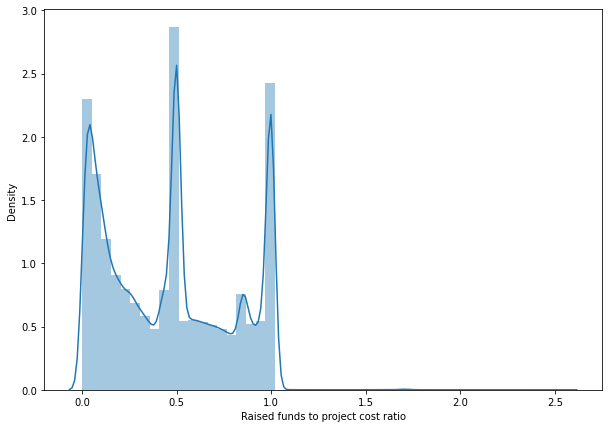

In [5]:
T=pd.Timedelta('30 days')
sub_var=["Number of dates since posted","Project ID","Donation Amount","Project Cost",
         "Project Posted Date","Project Expiration Date","Donation Received Date"]
sub_Data =Data.loc[:,sub_var]
sub_Data=sub_Data[sub_Data["Number of dates since posted"] < T]
sub_Data["Raised funds to project cost ratio"]=sub_Data["Donation Amount"]/sub_Data["Project Cost"]
Grouped_data=sub_Data.groupby(["Project ID"]).sum()
Grouped_data_Final = sub_Data.groupby(["Project ID"]).max()
Grouped_data_Final["Raised funds to project cost ratio"]=Grouped_data["Raised funds to project cost ratio"]

f, axes = plt.subplots(1, 1,figsize=(10,7))

y="Raised funds to project cost ratio"
q1 = Grouped_data_Final[y].quantile(0)
q3 = Grouped_data_Final[y].quantile(1)
mask = Grouped_data_Final[y].between(q1, q3, inclusive=True)
iqr = Grouped_data_Final.loc[mask, y]
sns.distplot(iqr, ax=axes,axlabel=y )
print(iqr.describe())


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    870802.000000
mean          0.555950
std           0.337268
min           0.000026
25%           0.255094
50%           0.500019
75%           0.889879
max           2.550013
Name: Raised funds to project cost ratio, dtype: float64


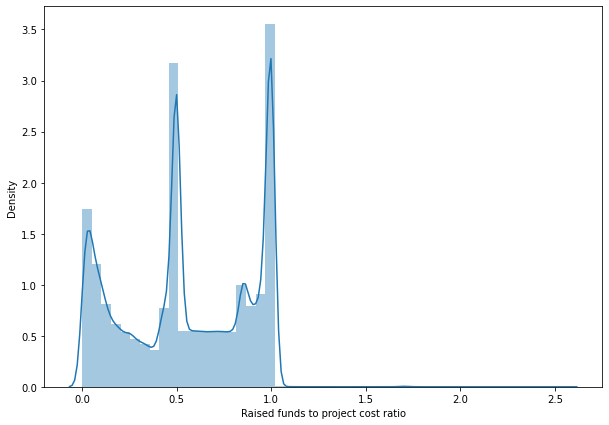

In [6]:
T=pd.Timedelta('120 days')
sub_var=["Number of dates since posted","Project ID","Donation Amount","Project Cost",
         "Project Posted Date","Project Expiration Date","Donation Received Date"]
sub_Data =Data.loc[:,sub_var]
sub_Data=sub_Data[sub_Data["Number of dates since posted"] < T]
sub_Data["Raised funds to project cost ratio"]=sub_Data["Donation Amount"]/sub_Data["Project Cost"]
Grouped_data=sub_Data.groupby(["Project ID"]).sum()
Grouped_data_Final = sub_Data.groupby(["Project ID"]).max()
Grouped_data_Final["Raised funds to project cost ratio"]=Grouped_data["Raised funds to project cost ratio"]

f, axes = plt.subplots(1, 1,figsize=(10,7))

y="Raised funds to project cost ratio"
q1 = Grouped_data_Final[y].quantile(0)
q3 = Grouped_data_Final[y].quantile(1)
mask = Grouped_data_Final[y].between(q1, q3, inclusive=True)
iqr = Grouped_data_Final.loc[mask, y]
sns.distplot(iqr, ax=axes,axlabel=y )
print(iqr.describe())

G120=Grouped_data_Final

In [7]:
#===============================================================================================
#                                  Model Training Funstion
#===============================================================================================

def Train_Model(Classifier,hyper_parameters, Model_variables_con,Model_variables_cat,Data,
                Time_period_indays=30,K=100,Fund_Ratio_treshold=0.142):
    # Time_period should be in days 
    # K is the Top-K value

    #=================================== Initiate the List Variables ================================
    
    Time_points = []
    Output=dict()
    count_itr=0
    
    Overall_Training_Accuracy_GS=[]
    Overall_Training_Precision_GS=[]
    Overall_Training_Recall_GS=[]

    Overall_Testing_Accuracy_GS=[]
    Overall_Testing_Precision_GS=[]
    Overall_Testing_Recall_GS=[]
    
    Overall_Top_K_Accuracy_GS=[]
    Overall_Top_K_Precision_GS=[]
    Overall_Top_K_Recall_GS=[]
    
    Classifier_models=[]
    
    #=================================== Initiate the Columns ======================================
    
    print("Initiatnig the Columns")
    Main_Variables = list(set(["Project ID","Project Posted Date","Project Expiration Date","Donation Received Date",
         "Project Cost","Donation Amount","Number of dates since posted"]+Model_variables_cat+Model_variables_con))
    Model_variables = Model_variables_con.copy()
    print("Variables considered in model training")
    for i in sub_var: print(">",i,i in Data.columns) # print all variables considered.
    print()
    Data["Number of dates since posted"]=Data.loc[:,"Donation Received Date"]-Data.loc[:,"Project Posted Date"]
    sub_Data = Data.loc[:,Main_Variables]
    sub_Data["Number of dates since posted"] = sub_Data["Number of dates since posted"]/ np.timedelta64(1, 'D')

    #================================= One-Hot-Encoding Columns to remove ==========================
    
    print("One-Hot-Encoding removing columns identification")
    Sub_Variables_to_remove=dict()
    for i in Model_variables_cat:
        sub_variables = Data[i].unique()
        Model_variables+=sorted([i+"_"+str(j) for j in Data[i].unique()])
        Model_variables.remove(i+"_"+str(sub_variables[0]))
        Sub_Variables_to_remove[i]=sub_variables[0]
        
    
    
    
    
    #======================================= Grid Search ===========================================
    keys=list(hyper_parameters.keys())
    vals=[]
    
    for i in keys:
        vals+=[hyper_parameters[i]]

    combinations=vals[0]
    for i in range (1,len(vals)):
        combinations = list(itertools.product(combinations,vals[i]))

    for i in range (len (combinations)): #tupples to single list
        try:
            p=list(combinations[i][0])
        except:
            p=[combinations[i][0]]
            
        for j in range (1,len(combinations[i])):
            p+=[combinations[i][j]]
        combinations[i]=p    


    for i in combinations:
        for j in range (len(keys)):
            setattr(Classifier, keys[j],i[j])
        print(Classifier)
        count_itr+=1
        
        
        #=================================== Initiate Time Variables ====================================
    
        print("Initiate Time Variables")
        MaxT = pd.Timestamp("2018-05-01 00:00:00")  #max(Data["Project Posted Date"])
        MinT = pd.Timestamp("2013-01-01 00:00:00")  #min(Data["Project Posted Date"])
        Time_period = timedelta(days=Time_period_indays)  
        T_current = MinT- Time_period +timedelta(days=120) 
        

        #=================================== Loop over time frams =======================================
        
        Output["Overall_Training_Accuracy"], Output["Overall_Training_Precision"], Output["Overall_Training_Recall"] = list(),list(),list()
        Output["Overall_Testing_Accuracy"], Output["Overall_Testing_Precision"], Output["Overall_Testing_Recall"] = list(),list(),list()
        Output["Top_K_Accuracy"], Output["Top_K_Precision"], Output["Top_K_Recall"] = list(),list(),list()
        
        print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")


        print(count_itr,"/",len(combinations),"Time iteration is starting\n")
        while (T_current<MaxT-Time_period):

            T_current = T_current+ Time_period
            Time_points+=[T_current]
            T_Train_start = T_current-timedelta(days=120)  # Start of the data frame
            T_Train_end = T_current-Time_period  #End of the data frame
            print("As of Date:",T_current,"\n"+"="*85)

        #====================================== Extract the frams ======================================= 

            # Extracts projects posted before the Current(As of) date
            Data_in_TimeWindow = sub_Data[sub_Data["Project Posted Date"] < pd.to_datetime(T_current)]  

            # Extracts projects posted after the start date of the Time window
            Data_in_TimeWindow = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] > pd.to_datetime(T_Train_start)]

            #Time period to be consided for the donations since posted (30days, as default)
            Data_in_TimeWindow = Data_in_TimeWindow[Data_in_TimeWindow["Number of dates since posted"]< Time_period_indays]

            #Express the donation amount as a ratio of to the Project cost
            Data_in_TimeWindow["Fund_Ratio"]=Data_in_TimeWindow["Donation Amount"]/Data_in_TimeWindow["Project Cost"]


        #=========================== Do One-Hot_Encoding for Categorical Variables ======================

            for var in Model_variables_cat:
                Sub_Dummied_Data=pd.get_dummies(Data_in_TimeWindow[var])  #create dummpy variables with one hot encoding 
                Sub_Dummied_Data_columns=sorted(Sub_Dummied_Data.columns)  #extract the column names of dummpy variables
                Sub_Dummied_Data_columns.remove(Sub_Variables_to_remove[var]) #remove a pre defined column from dummpy variables
                Data_in_TimeWindow=Data_in_TimeWindow.drop([var], axis=1) #remove main variable from the dataset
                #copy the columns to the main data set 
                for col in Sub_Dummied_Data_columns : Data_in_TimeWindow[var+"_"+col] = Sub_Dummied_Data[col]

            #Add the columns which have not been one-hot-encoded
            for i in Model_variables:
                if i not in Data_in_TimeWindow.columns:  Data_in_TimeWindow[i]=0


        #============================================ Imputing ==========================================
            Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


        #=================================== Training set Creation =====================================

            #extract the training set from the timewindow
            Train_Data = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] < pd.to_datetime(T_Train_end)]

            #Group by Project ID
            Train_Data_CR=Train_Data.groupby(["Project ID"]).sum() 
            Train_Data_Final=Train_Data.groupby(["Project ID"]).max()
            Train_Data_Final["Fund_Ratio"]=Train_Data_CR["Fund_Ratio"]
            Train_Data_Final["Donation Amount"]=Train_Data_CR["Donation Amount"]

            # Define Fund_Ratio_Treshold
            Fund_Ratio_Treshold = Fund_Ratio_treshold
            Fund_Ratio_Treshold = Train_Data_Final["Fund_Ratio"].median()

            # Genarate the Label for the dataset 
            Train_Data_Final['Label'] = Train_Data_Final.apply(lambda x : 1  if x['Fund_Ratio'] < 
                                                               Fund_Ratio_Treshold  else 0, axis=1)

            X_train = Train_Data_Final.loc[:,Model_variables]
            Y_train = np.array(Train_Data_Final.loc[:,["Label"]])[:,0]


        #==================================== Testing set Creation =====================================

            #extract the training set from the timewindow
            Test_Data = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] >= pd.to_datetime(T_Train_end)]

            #Group by Project ID
            Test_Data_CR=Test_Data.groupby(["Project ID"]).sum() 
            Test_Data_Final=Test_Data.groupby(["Project ID"]).max()
            Test_Data_Final["Fund_Ratio"]=Test_Data_CR["Fund_Ratio"]
            Test_Data_Final["Donation Amount"]=Test_Data_CR["Donation Amount"]

            # Genarate the Label for the dataset 
            Test_Data_Final['Label'] = Test_Data_Final.apply(lambda x : 1  if x['Fund_Ratio'] < 
                                                             Fund_Ratio_Treshold  else 0, axis=1)
            X_test = Test_Data_Final.loc[:,Model_variables]
            Y_test = np.array(Test_Data_Final.loc[:,["Label"]])[:,0]


        #===================================== Model Training =========================================

            Classifier.fit(X_train, Y_train)

            # Predict on training 
            Train_Data_Final["Y_pred_prob"] = Classifier.predict_proba(X_train)[:,1]
            Train_Data_Final["Y_pred"]= Classifier.predict(X_train)
            # Predict on testing 
            Test_Data_Final["Y_pred_prob"] = Classifier.predict_proba(X_test)[:,1]
            Test_Data_Final["Y_pred"] = Classifier.predict(X_test)


        #====================================== Evaluation Trainign  ============================================

            Training_CM= confusion_matrix(Y_train,Train_Data_Final["Y_pred"])
            Training_TN, Training_FP ,Training_FN, Training_TP =  Training_CM.ravel()

            Training_Accuracy=(Training_TP+Training_TN)/(Training_TN+ Training_FP +Training_FN+ Training_TP)
            Training_Precision=Training_TP/(Training_TP+Training_FP)
            Training_Recall=Training_TP/(Training_TP+Training_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Training_Accuracy)
            print("\tTraining_TP:",Training_TP,"\tTraining_FP:",Training_FP,
                  "\n\tTraining_TN:",Training_TN,"\tTraining_FN:",Training_FN ,end="\n"*2)


        #====================================== Evaluation Testign  ============================================   

            Testing_CM= confusion_matrix(Y_test,Test_Data_Final["Y_pred"])
            Testing_TN, Testing_FP ,Testing_FN, Testing_TP =  Testing_CM.ravel()

            Testing_Accuracy=(Testing_TP+Testing_TN)/(Testing_TN+ Testing_FP +Testing_FN+ Testing_TP)
            Testing_Precision=Testing_TP/(Testing_TP+Testing_FP)
            Testing_Recall=Testing_TP/(Testing_TP+Testing_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Testing_Accuracy)
            print("\tTesting_TP:",Testing_TP,"\tTesting_FP:",Testing_FP,
                  "\n\tTesting_TN:",Testing_TN,"\tTesting_FN:",Testing_FN ,end="\n"*2)

        #====================================== Evaluation Top K  ============================================        

            Test_Data_Final=Test_Data_Final.sort_values(by=['Y_pred_prob'], ascending=False)
            Top_K=Test_Data_Final.head(K)
            Y_test_Top_K =  Top_K.loc[:,["Label"]] 
            Y_pred_Top_K =  Top_K.loc[:,["Y_pred"]]
            Testing_Top_K_CM= confusion_matrix(Y_test_Top_K,Y_pred_Top_K)
            if len(Testing_Top_K_CM.ravel())==4:
                Testing_Top_K_TN, Testing_Top_K_FP ,Testing_Top_K_FN, Testing_Top_K_TP =  Testing_Top_K_CM.ravel()
            else:
                Testing_Top_K_TN, Testing_Top_K_FP ,Testing_Top_K_FN, Testing_Top_K_TP=0,0,0,K

            Testing_Top_K_Accuracy=(Testing_Top_K_TP+Testing_Top_K_TN)/(Testing_Top_K_TN
                                                                        + Testing_Top_K_FP +Testing_Top_K_FN+ Testing_Top_K_TP)
            Testing_Top_K_Precision=Testing_Top_K_TP/(Testing_Top_K_TP+Testing_Top_K_FP)
            Testing_Top_K_Recall=Testing_Top_K_TP/(Testing_Top_K_TP+Testing_Top_K_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Testing_Top_K_Accuracy)
            print("\tTesting_Top_K_TP:",Testing_Top_K_TP,"\tTesting_Top_K_FP:",Testing_Top_K_FP,
                  "\n\tTesting_Top_K_TN:",Testing_Top_K_TN,"\tTesting_Top_K_FN:",Testing_Top_K_FN ,end="\n"*2)

         #====================================== save computed values  ============================================       
            Output["Overall_Training_Accuracy"] += [Training_Accuracy]
            Output["Overall_Training_Precision"] += [Training_Precision]
            Output["Overall_Training_Recall"] += [Training_Recall ]

            Output["Overall_Testing_Accuracy"] += [Testing_Accuracy]
            Output["Overall_Testing_Precision"] += [Testing_Precision]
            Output["Overall_Testing_Recall"] += [Testing_Recall]

            Output["Top_K_Accuracy"] += [Testing_Top_K_Accuracy] 
            Output["Top_K_Precision"] += [Testing_Top_K_Precision]  
            Output["Top_K_Recall"] += [Testing_Top_K_Recall] 
            
            
        Overall_Training_Accuracy_GS+=[sum(Output["Overall_Training_Accuracy"])/len(Output["Overall_Training_Accuracy"])]
        Overall_Training_Precision_GS+=[sum(Output["Overall_Training_Precision"])/len(Output["Overall_Training_Precision"])]
        Overall_Training_Recall_GS+=[sum(Output["Overall_Training_Recall"])/len(Output["Overall_Training_Recall"])]

        Overall_Testing_Accuracy_GS+=[sum(Output["Overall_Testing_Accuracy"])/len(Output["Overall_Testing_Accuracy"])]
        Overall_Testing_Precision_GS+=[sum(Output["Overall_Testing_Precision"])/len(Output["Overall_Testing_Precision"])]
        Overall_Testing_Recall_GS+=[sum(Output["Overall_Testing_Recall"])/len(Output["Overall_Testing_Recall"])]

        Overall_Top_K_Accuracy_GS+=[sum(Output["Top_K_Accuracy"])/len(Output["Top_K_Accuracy"])]
        Overall_Top_K_Precision_GS+=[sum(Output["Top_K_Precision"])/len(Output["Top_K_Precision"])]
        Overall_Top_K_Recall_GS+=[sum(Output["Top_K_Recall"])/len(Output["Top_K_Recall"])]
        
        Classifier_models+=[Classifier]
        
    
    
    Output["Overall_Training_Accuracy"] = Overall_Training_Accuracy_GS
    Output["Overall_Training_Precision"] =Overall_Training_Precision_GS
    Output["Overall_Training_Recall"] =Overall_Training_Precision_GS

    Output["Overall_Testing_Accuracy"] =Overall_Testing_Accuracy_GS
    Output["Overall_Testing_Precision"] =Overall_Testing_Precision_GS
    Output["Overall_Testing_Recall"] =Overall_Testing_Recall_GS

    Output["Top_K_Accuracy"] = Overall_Top_K_Accuracy_GS
    Output["Top_K_Precision"] = Overall_Top_K_Precision_GS
    Output["Top_K_Recall"] = Overall_Top_K_Recall_GS
    
    Output["Classifier"]=Classifier_models
    Output["Model_variables"]=Model_variables
    Output["Time_points"]=Time_points
    
    print(Overall_Training_Accuracy_GS)
    return Output,Test_Data_Final,Train_Data_Final
        

In [8]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(criterion="entropy",random_state=43,n_jobs=50)

hyper_para=dict()
hyper_para["n_estimators"]=[10,20,40,75]
hyper_para["max_depth"]=[5,9,21,30]
hyper_para["min_samples_split"]=[3,10,30,50]
# hyper_para["criterion"]=["gini", "entropy"]

Model_variables_con= ["Project Cost","Number of dates since posted","School Percentage Free Lunch","Project Cost",
                      "Project Short Description_polarity","Project Short Description_subjectivity",
                      "Project Essay_polarity","Project Essay_subjectivity","Project Need Statement_polarity",
                      "Project Need Statement_subjectivity"]
Model_variables_cat= ["School Metro Type","Teacher Prefix","Project Grade Level Category"]

Output,Test_Data_Final,Train_Data_Final= Train_Model(clf, hyper_para,Model_variables_con,Model_variables_cat,
                                    Data,Time_period_indays=30,K=100,Fund_Ratio_treshold=0.03)

Initiatnig the Columns
Variables considered in model training
> Number of dates since posted True
> Project ID True
> Donation Amount True
> Project Cost True
> Project Posted Date True
> Project Expiration Date True
> Donation Received Date True

One-Hot-Encoding removing columns identification
RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=3,
                       n_estimators=10, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
1 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6406370408425379
	Training_TP: 5272 	Training_FP: 3082 
	Training_TN: 4704 	Training_FN: 2514

RandomForestClassifier  Testing Accuracy =  0.6166747690811862
	Testing_TP: 1199 	Testing_FP: 864 
	Testing_TN: 1338 	Testing_FN: 713

RandomForestClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6376153011394465
	Training_TP: 5450 	Training_FP: 3421 
	Training_TN: 3951 	Training_FN: 1922

RandomForestClassifier  Testing Accuracy =  0.624299975651327
	Testing_TP: 1547 	Testing_FP: 963 
	Testing_TN: 1017 	Testing_FN: 580

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6421526753125728
	Training_TP: 4260 	Training_FP: 2430 
	Training_TN: 4009 	Training_FN: 2178

RandomForestClassifier  Testing Accuracy =  0.6258521237545883
	Testing_TP: 1618 	Testing_FP: 597 
	Testing_TN: 769 	Testing_FN: 830

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6337476019684711
	Training_TP: 4488 	Training_FP: 2885 
	Training_TN: 3110 	Training_FN: 1506

RandomForestClassifier  Testing Accuracy =  0.5815722738799662
	Testing_TP: 1589 	Testing_FP: 1377 
	Testing_TN: 1163 	Testing_FN: 603

RandomForestClassifier  Testing Accuracy =  0.52
	Testing_Top_K_TP: 52 	Testing_Top_K_FP: 48 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6253190810465858
	Training_TP: 4545 	Training_FP: 2974 
	Training_TN: 3294 	Training_FN: 1723

RandomForestClassifier  Testing Accuracy =  0.611845529301551
	Testing_TP: 3054 	Testing_FP: 2638 
	Testing_TN: 2824 	Testing_FN: 1091

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6360064198350767
	Training_TP: 6291 	Training_FP: 3834 
	Training_TN: 5201 	Training_FN: 2743

RandomForestClassifier  Testing Accuracy =  0.652540406774418
	Testing_TP: 5502 	Testing_FP: 2403 
	Testing_TN: 2936 	Testing_FN: 2090

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.636393647067454
	Training_TP: 9640 	Training_FP: 5922 
	Training_TN: 7710 	Training_FN: 3991

RandomForestClassifier  Testing Accuracy =  0.6273562107298212
	Testing_TP: 3749 	Testing_FP: 2244 
	Testing_TN: 2741 	Testing_FN: 1611

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6338088271153377
	Training_TP: 10581 	Training_FP: 6191 
	Training_TN: 10213 	Training_FN: 5823

RandomForestClassifier  Testing Accuracy =  0.6588110811850711
	Testing_TP: 3746 	Testing_FP: 1903 
	Testing_TN: 3103 	Testing_FN: 1644

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6463312117209079
	Training_TP: 11333 	Training_FP: 6459 
	Training_TN: 10195 	Training_FN: 5321

RandomForestClassifier  Testing Accuracy =  0.6438510189739985
	Testing_TP: 1736 	Testing_FP: 1723 
	Testing_TN: 2845 	Testing_FN: 811

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6433336979109702
	Training_TP: 8532 	Training_FP: 4601 
	Training_TN: 9114 	Training_FN: 5182

RandomForestClassifier  Testing Accuracy =  0.6186550274814097
	Testing_TP: 1493 	Testing_FP: 1000 
	Testing_TN: 2334 	Testing_FN: 1359

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6443233114726173
	Training_TP: 6817 	Training_FP: 3428 
	Training_TN: 8313 	Training_FN: 4924

RandomForestClassifier  Testing Accuracy =  0.599948347107438
	Testing_TP: 1699 	Testing_FP: 1398 
	Testing_TN: 2947 	Testing_FN: 1700

RandomForestClassifier  Testing Accuracy =  0.49
	Testing_Top_K_TP: 49 	Testing_Top_K_FP: 51 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6311081185071181
	Training_TP: 6914 	Training_FP: 4188 
	Training_TN: 6208 	Training_FN: 3482

RandomForestClassifier  Testing Accuracy =  0.6146018222695538
	Testing_TP: 2781 	Testing_FP: 1742 
	Testing_TN: 2413 	Testing_FN: 1515

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6321704201832378
	Training_TP: 7495 	Training_FP: 4567 
	Training_TN: 6512 	Training_FN: 3583

RandomForestClassifier  Testing Accuracy =  0.6191163210099189
	Testing_TP: 1811 	Testing_FP: 1250 
	Testing_TN: 1622 	Testing_FN: 862

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6336943329287649
	Training_TP: 7157 	Training_FP: 4293 
	Training_TN: 6418 	Training_FN: 3554

RandomForestClassifier  Testing Accuracy =  0.610153438151165
	Testing_TP: 1776 	Testing_FP: 1096 
	Testing_TN: 1445 	Testing_FN: 962

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6352072864321608
	Training_TP: 5553 	Training_FP: 2970 
	Training_TN: 6582 	Training_FN: 3999

RandomForestClassifier  Testing Accuracy =  0.6092600605798356
	Testing_TP: 1479 	Testing_FP: 687 
	Testing_TN: 1337 	Testing_FN: 1119

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6382683410442829
	Training_TP: 4502 	Training_FP: 2410 
	Training_TN: 5155 	Training_FN: 3063

RandomForestClassifier  Testing Accuracy =  0.6216572504708098
	Testing_TP: 1702 	Testing_FP: 923 
	Testing_TN: 1599 	Testing_FN: 1086

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6379264744776514
	Training_TP: 4847 	Training_FP: 2761 
	Training_TN: 4801 	Training_FN: 2715

RandomForestClassifier  Testing Accuracy =  0.5728820598006644
	Testing_TP: 3564 	Testing_FP: 2975 
	Testing_TN: 4713 	Testing_FN: 3196

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6150927835051546
	Training_TP: 7751 	Training_FP: 4960 
	Training_TN: 7165 	Training_FN: 4374

RandomForestClassifier  Testing Accuracy =  0.6545305788504807
	Testing_TP: 8449 	Testing_FP: 3507 
	Testing_TN: 4351 	Testing_FN: 3249

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.643632748776509
	Training_TP: 11287 	Training_FP: 5652 
	Training_TN: 13964 	Training_FN: 8329

RandomForestClassifier  Testing Accuracy =  0.6196240020602627
	Testing_TP: 3944 	Testing_FP: 1715 
	Testing_TN: 3274 	Testing_FN: 2716

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6418367796834354
	Training_TP: 13796 	Training_FP: 7362 
	Training_TN: 15319 	Training_FN: 8885

RandomForestClassifier  Testing Accuracy =  0.6192606545797034
	Testing_TP: 2505 	Testing_FP: 1625 
	Testing_TN: 2755 	Testing_FN: 1609

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6473538198890312
	Training_TP: 12638 	Training_FP: 7114 
	Training_TN: 11630 	Training_FN: 6106

RandomForestClassifier  Testing Accuracy =  0.6215273117702322
	Testing_TP: 1811 	Testing_FP: 1803 
	Testing_TN: 2820 	Testing_FN: 1017

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6375646812727073
	Training_TP: 9696 	Training_FP: 5948 
	Training_TN: 7677 	Training_FN: 3928

RandomForestClassifier  Testing Accuracy =  0.6092949980307207
	Testing_TP: 1947 	Testing_FP: 1762 
	Testing_TN: 2694 	Testing_FN: 1214

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6301228183581125
	Training_TP: 8588 	Training_FP: 5569 
	Training_TN: 6034 	Training_FN: 3014

RandomForestClassifier  Testing Accuracy =  0.6223132036847492
	Testing_TP: 3408 	Testing_FP: 2359 
	Testing_TN: 2672 	Testing_FN: 1331

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6375350595504248
	Training_TP: 8948 	Training_FP: 5565 
	Training_TN: 6736 	Training_FN: 3352

RandomForestClassifier  Testing Accuracy =  0.6655330127829249
	Testing_TP: 3683 	Testing_FP: 1703 
	Testing_TN: 1992 	Testing_FN: 1149

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6547906759179855
	Training_TP: 8002 	Training_FP: 4031 
	Training_TN: 8796 	Training_FN: 4825

RandomForestClassifier  Testing Accuracy =  0.6562671045429667
	Testing_TP: 2250 	Testing_FP: 1183 
	Testing_TN: 2546 	Testing_FN: 1329

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6642178046672429
	Training_TP: 7567 	Training_FP: 3387 
	Training_TN: 9340 	Training_FN: 5160

RandomForestClassifier  Testing Accuracy =  0.6339381003201707
	Testing_TP: 1563 	Testing_FP: 768 
	Testing_TN: 2001 	Testing_FN: 1290

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6701741140942764
	Training_TP: 6956 	Training_FP: 3350 
	Training_TN: 7247 	Training_FN: 3640

RandomForestClassifier  Testing Accuracy =  0.6249768046019669
	Testing_TP: 1880 	Testing_FP: 804 
	Testing_TN: 1488 	Testing_FN: 1217

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6489759473184887
	Training_TP: 6485 	Training_FP: 3816 
	Training_TN: 5144 	Training_FN: 2474

RandomForestClassifier  Testing Accuracy =  0.6146567344473526
	Testing_TP: 1650 	Testing_FP: 1153 
	Testing_TN: 1403 	Testing_FN: 761

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6428165097022944
	Training_TP: 5485 	Training_FP: 3226 
	Training_TN: 4685 	Training_FN: 2425

RandomForestClassifier  Testing Accuracy =  0.6019056261343013
	Testing_TP: 2996 	Testing_FP: 3094 
	Testing_TN: 3637 	Testing_FN: 1293

RandomForestClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6243941461578278
	Training_TP: 7486 	Training_FP: 4843 
	Training_TN: 5783 	Training_FN: 3139

RandomForestClassifier  Testing Accuracy =  0.6245691438025645
	Testing_TP: 8046 	Testing_FP: 5166 
	Testing_TN: 5544 	Testing_FN: 3003

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6371314741035856
	Training_TP: 10886 	Training_FP: 5723 
	Training_TN: 13102 	Training_FN: 7939

RandomForestClassifier  Testing Accuracy =  0.6304056715242221
	Testing_TP: 3743 	Testing_FP: 1796 
	Testing_TN: 4260 	Testing_FN: 2896

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.63938043334363
	Training_TP: 13749 	Training_FP: 7432 
	Training_TN: 15229 	Training_FN: 8912

RandomForestClassifier  Testing Accuracy =  0.6426437999807303
	Testing_TP: 3186 	Testing_FP: 1777 
	Testing_TN: 3484 	Testing_FN: 1932

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6401406055108289
	Training_TP: 12820 	Training_FP: 6641 
	Training_TN: 15407 	Training_FN: 9227

RandomForestClassifier  Testing Accuracy =  0.6309278350515464
	Testing_TP: 3684 	Testing_FP: 2129 
	Testing_TN: 4884 	Testing_FN: 2883

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6374448494149242
	Training_TP: 12373 	Training_FP: 7358 
	Training_TN: 10888 	Training_FN: 5872

RandomForestClassifier  Testing Accuracy =  0.6228828206014517
	Testing_TP: 2444 	Testing_FP: 1673 
	Testing_TN: 2962 	Testing_FN: 1600

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6346003929028033
	Training_TP: 11236 	Training_FP: 6920 
	Training_TN: 9115 	Training_FN: 4798

RandomForestClassifier  Testing Accuracy =  0.6336442315771784
	Testing_TP: 3862 	Testing_FP: 2522 
	Testing_TN: 3679 	Testing_FN: 1838

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6298597550150896
	Training_TP: 12212 	Training_FP: 7823 
	Training_TN: 9076 	Training_FN: 4687

RandomForestClassifier  Testing Accuracy =  0.6110344827586207
	Testing_TP: 4987 	Testing_FP: 3928 
	Testing_TN: 4316 	Testing_FN: 1994

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6262890955198648
	Training_TP: 10672 	Training_FP: 6190 
	Training_TN: 11555 	Training_FN: 7073

RandomForestClassifier  Testing Accuracy =  0.6164925876010782
	Testing_TP: 3641 	Testing_FP: 2128 
	Testing_TN: 3678 	Testing_FN: 2425

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6253854725439892
	Training_TP: 12926 	Training_FP: 8088 
	Training_TN: 11207 	Training_FN: 6368

RandomForestClassifier  Testing Accuracy =  0.6298294029101856
	Testing_TP: 2978 	Testing_FP: 1724 
	Testing_TN: 2043 	Testing_FN: 1227

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.628678066140092
	Training_TP: 12218 	Training_FP: 7771 
	Training_TN: 9511 	Training_FN: 5063

RandomForestClassifier  Testing Accuracy =  0.6383467278989667
	Testing_TP: 2987 	Testing_FP: 1299 
	Testing_TN: 1461 	Testing_FN: 1221

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6352910231841581
	Training_TP: 9120 	Training_FP: 5520 
	Training_TN: 7787 	Training_FN: 4186

RandomForestClassifier  Testing Accuracy =  0.6172185430463576
	Testing_TP: 2695 	Testing_FP: 1614 
	Testing_TN: 1965 	Testing_FN: 1276

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6275663776449976
	Training_TP: 7911 	Training_FP: 5072 
	Training_TN: 6058 	Training_FN: 3218

RandomForestClassifier  Testing Accuracy =  0.6440611082924629
	Testing_TP: 6603 	Testing_FP: 4323 
	Testing_TN: 4822 	Testing_FN: 1991

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6447787279196056
	Training_TP: 8664 	Training_FP: 4025 
	Training_TN: 11996 	Training_FN: 7357

RandomForestClassifier  Testing Accuracy =  0.6553890953676386
	Testing_TP: 7601 	Testing_FP: 3605 
	Testing_TN: 9504 	Testing_FN: 5389

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.656690726287581
	Training_TP: 15353 	Training_FP: 7343 
	Training_TN: 18219 	Training_FN: 10208

RandomForestClassifier  Testing Accuracy =  0.637071957048386
	Testing_TP: 4495 	Testing_FP: 2187 
	Testing_TN: 5235 	Testing_FN: 3356

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6557257228332002
	Training_TP: 17130 	Training_FP: 7969 
	Training_TN: 21447 	Training_FN: 12285

RandomForestClassifier  Testing Accuracy =  0.6389817911557042
	Testing_TP: 2763 	Testing_FP: 1448 
	Testing_TN: 4115 	Testing_FN: 2438

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6530492686832393
	Training_TP: 15940 	Training_FP: 8103 
	Training_TN: 17502 	Training_FN: 9664

RandomForestClassifier  Testing Accuracy =  0.6514835497544237
	Testing_TP: 3713 	Testing_FP: 2376 
	Testing_TN: 5970 	Testing_FN: 2804

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6461858118135946
	Training_TP: 13789 	Training_FP: 7879 
	Training_TN: 12335 	Training_FN: 6425

RandomForestClassifier  Testing Accuracy =  0.6461009589288945
	Testing_TP: 2902 	Testing_FP: 2168 
	Testing_TN: 4240 	Testing_FN: 1744

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6430418753095252
	Training_TP: 12430 	Training_FP: 7231 
	Training_TN: 10942 	Training_FN: 5743

RandomForestClassifier  Testing Accuracy =  0.6334881385716079
	Testing_TP: 5139 	Testing_FP: 3486 
	Testing_TN: 4955 	Testing_FN: 2354

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6484537077242244
	Training_TP: 14036 	Training_FP: 7882 
	Training_TN: 12845 	Training_FN: 6691

RandomForestClassifier  Testing Accuracy =  0.6335723890632003
	Testing_TP: 3862 	Testing_FP: 2904 
	Testing_TN: 4619 	Testing_FN: 2001

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6458167132030315
	Training_TP: 13604 	Training_FP: 7755 
	Training_TN: 12301 	Training_FN: 6452

RandomForestClassifier  Testing Accuracy =  0.6059412780656304
	Testing_TP: 4302 	Testing_FP: 2755 
	Testing_TN: 4469 	Testing_FN: 2949

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6369721816876288
	Training_TP: 12856 	Training_FP: 7138 
	Training_TN: 14644 	Training_FN: 8535

RandomForestClassifier  Testing Accuracy =  0.6252564628641772
	Testing_TP: 2812 	Testing_FP: 1645 
	Testing_TN: 3283 	Testing_FN: 2008

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6248690747952196
	Training_TP: 9852 	Training_FP: 5469 
	Training_TN: 13415 	Training_FN: 8499

RandomForestClassifier  Testing Accuracy =  0.5935871289372309
	Testing_TP: 2808 	Testing_FP: 958 
	Testing_TN: 2431 	Testing_FN: 2629

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6220567332056115
	Training_TP: 8266 	Training_FP: 4316 
	Training_TN: 11865 	Training_FN: 7915

RandomForestClassifier  Testing Accuracy =  0.5886925141112243
	Testing_TP: 3130 	Testing_FP: 1383 
	Testing_TN: 3232 	Testing_FN: 3062

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6344911007430447
	Training_TP: 8648 	Training_FP: 4757 
	Training_TN: 9711 	Training_FN: 5819

RandomForestClassifier  Testing Accuracy =  0.6204731762996784
	Testing_TP: 4969 	Testing_FP: 3747 
	Testing_TN: 6990 	Testing_FN: 3568

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6292393724434319
	Training_TP: 11309 	Training_FP: 6317 
	Training_TN: 12996 	Training_FN: 8004

RandomForestClassifier  Testing Accuracy =  0.6339373720524679
	Testing_TP: 7721 	Testing_FP: 4687 
	Testing_TN: 9001 	Testing_FN: 4969

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6270984492815479
	Training_TP: 15577 	Training_FP: 8430 
	Training_TN: 19686 	Training_FN: 12539

RandomForestClassifier  Testing Accuracy =  0.6127613790522525
	Testing_TP: 6045 	Testing_FP: 3101 
	Testing_TN: 7054 	Testing_FN: 5177

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6289044358886009
	Training_TP: 18886 	Training_FP: 10282 
	Training_TN: 23094 	Training_FN: 14489

RandomForestClassifier  Testing Accuracy =  0.6157679868511744
	Testing_TP: 5140 	Testing_FP: 2727 
	Testing_TN: 6474 	Testing_FN: 4520

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6267874819157847
	Training_TP: 18037 	Training_FP: 9712 
	Training_TN: 23121 	Training_FN: 14795

RandomForestClassifier  Testing Accuracy =  0.613094211645686
	Testing_TP: 4814 	Testing_FP: 2778 
	Testing_TN: 5852 	Testing_FN: 3953

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6264640487403491
	Training_TP: 18237 	Training_FP: 11014 
	Training_TN: 17546 	Training_FN: 10322

RandomForestClassifier  Testing Accuracy =  0.6390630902908954
	Testing_TP: 3643 	Testing_FP: 2822 
	Testing_TN: 4815 	Testing_FN: 1955

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6286760194690989
	Training_TP: 15168 	Training_FP: 8876 
	Training_TN: 15573 	Training_FN: 9281

RandomForestClassifier  Testing Accuracy =  0.6191653065982746
	Testing_TP: 5646 	Testing_FP: 3914 
	Testing_TN: 7632 	Testing_FN: 4253

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6185844651541278
	Training_TP: 14554 	Training_FP: 8434 
	Training_TN: 17373 	Training_FN: 11252

RandomForestClassifier  Testing Accuracy =  0.6127923434656601
	Testing_TP: 3725 	Testing_FP: 2400 
	Testing_TN: 5367 	Testing_FN: 3345

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6162271722217673
	Training_TP: 15752 	Training_FP: 10248 
	Training_TN: 14347 	Training_FN: 8497

RandomForestClassifier  Testing Accuracy =  0.6428817946505608
	Testing_TP: 10282 	Testing_FP: 3645 
	Testing_TN: 4620 	Testing_FN: 4633

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=10,
                       n_estimators=10, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6349216542512202
	Training_TP: 5465 	Training_FP: 3364 
	Training_TN: 4422 	Training_FN: 2321

RandomForestClassifier  Testing Accuracy =  0.6105979581915411
	Testing_TP: 1237 	Testing_FP: 927 
	Testing_TN: 1275 	Testing_FN: 675

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.639514378730331
	Training_TP: 5318 	Training_FP: 3261 
	Training_TN: 4111 	Training_FN: 2054

RandomForestClassifier  Testing Accuracy =  0.6289262235208181
	Testing_TP: 1527 	Testing_FP: 924 
	Testing_TN: 1056 	Testing_FN: 600

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6356294167896249
	Training_TP: 4645 	Training_FP: 2899 
	Training_TN: 3540 	Training_FN: 1793

RandomForestClassifier  Testing Accuracy =  0.6494493969585736
	Testing_TP: 1790 	Testing_FP: 679 
	Testing_TN: 687 	Testing_FN: 658

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6329135040453749
	Training_TP: 4465 	Training_FP: 2872 
	Training_TN: 3123 	Training_FN: 1529

RandomForestClassifier  Testing Accuracy =  0.5813609467455622
	Testing_TP: 1577 	Testing_FP: 1366 
	Testing_TN: 1174 	Testing_FN: 615

RandomForestClassifier  Testing Accuracy =  0.54
	Testing_Top_K_TP: 54 	Testing_Top_K_FP: 46 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6251595405232929
	Training_TP: 4490 	Training_FP: 2921 
	Training_TN: 3347 	Training_FN: 1778

RandomForestClassifier  Testing Accuracy =  0.6119496200686999
	Testing_TP: 3041 	Testing_FP: 2624 
	Testing_TN: 2838 	Testing_FN: 1104

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6378880956334053
	Training_TP: 6287 	Training_FP: 3796 
	Training_TN: 5239 	Training_FN: 2747

RandomForestClassifier  Testing Accuracy =  0.651767071378857
	Testing_TP: 5474 	Testing_FP: 2385 
	Testing_TN: 2954 	Testing_FN: 2118

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6352565748450281
	Training_TP: 9625 	Training_FP: 5938 
	Training_TN: 7694 	Training_FN: 4006

RandomForestClassifier  Testing Accuracy =  0.6288061865635572
	Testing_TP: 3769 	Testing_FP: 2249 
	Testing_TN: 2736 	Testing_FN: 1591

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6369787856620337
	Training_TP: 10804 	Training_FP: 6310 
	Training_TN: 10094 	Training_FN: 5600

RandomForestClassifier  Testing Accuracy =  0.6587148903424394
	Testing_TP: 3817 	Testing_FP: 1975 
	Testing_TN: 3031 	Testing_FN: 1573

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6470517593370962
	Training_TP: 11404 	Training_FP: 6506 
	Training_TN: 10148 	Training_FN: 5250

RandomForestClassifier  Testing Accuracy =  0.6421644413211525
	Testing_TP: 1743 	Testing_FP: 1742 
	Testing_TN: 2826 	Testing_FN: 804

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6428597469831201
	Training_TP: 8587 	Training_FP: 4669 
	Training_TN: 9046 	Training_FN: 5127

RandomForestClassifier  Testing Accuracy =  0.6212415130940834
	Testing_TP: 1515 	Testing_FP: 1006 
	Testing_TN: 2328 	Testing_FN: 1337

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6430883229707861
	Training_TP: 6872 	Training_FP: 3512 
	Training_TN: 8229 	Training_FN: 4869

RandomForestClassifier  Testing Accuracy =  0.5996900826446281
	Testing_TP: 1720 	Testing_FP: 1421 
	Testing_TN: 2924 	Testing_FN: 1679

RandomForestClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6307714505579068
	Training_TP: 6946 	Training_FP: 4227 
	Training_TN: 6169 	Training_FN: 3450

RandomForestClassifier  Testing Accuracy =  0.6149568098449888
	Testing_TP: 2797 	Testing_FP: 1755 
	Testing_TN: 2400 	Testing_FN: 1499

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6342916459809541
	Training_TP: 7391 	Training_FP: 4416 
	Training_TN: 6663 	Training_FN: 3687

RandomForestClassifier  Testing Accuracy =  0.618214607754734
	Testing_TP: 1767 	Testing_FP: 1211 
	Testing_TN: 1661 	Testing_FN: 906

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6304733451591822
	Training_TP: 7055 	Training_FP: 4260 
	Training_TN: 6451 	Training_FN: 3656

RandomForestClassifier  Testing Accuracy =  0.6084485698048873
	Testing_TP: 1756 	Testing_FP: 1085 
	Testing_TN: 1456 	Testing_FN: 982

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6352072864321608
	Training_TP: 5732 	Training_FP: 3149 
	Training_TN: 6403 	Training_FN: 3820

RandomForestClassifier  Testing Accuracy =  0.6090437040242319
	Testing_TP: 1524 	Testing_FP: 733 
	Testing_TN: 1291 	Testing_FN: 1074

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6415730337078651
	Training_TP: 4684 	Training_FP: 2542 
	Training_TN: 5023 	Training_FN: 2881

RandomForestClassifier  Testing Accuracy =  0.6225988700564972
	Testing_TP: 1762 	Testing_FP: 978 
	Testing_TN: 1544 	Testing_FN: 1026

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6369346733668342
	Training_TP: 4694 	Training_FP: 2623 
	Training_TN: 4939 	Training_FN: 2868

RandomForestClassifier  Testing Accuracy =  0.5736434108527132
	Testing_TP: 3433 	Testing_FP: 2833 
	Testing_TN: 4855 	Testing_FN: 3327

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6165360824742268
	Training_TP: 7760 	Training_FP: 4934 
	Training_TN: 7191 	Training_FN: 4365

RandomForestClassifier  Testing Accuracy =  0.6543771732460626
	Testing_TP: 8449 	Testing_FP: 3510 
	Testing_TN: 4348 	Testing_FN: 3249

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6424857259380098
	Training_TP: 11448 	Training_FP: 5858 
	Training_TN: 13758 	Training_FN: 8168

RandomForestClassifier  Testing Accuracy =  0.6211691990728818
	Testing_TP: 4011 	Testing_FP: 1764 
	Testing_TN: 3225 	Testing_FN: 2649

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.642013138750496
	Training_TP: 13914 	Training_FP: 7472 
	Training_TN: 15209 	Training_FN: 8767

RandomForestClassifier  Testing Accuracy =  0.6205556863668472
	Testing_TP: 2534 	Testing_FP: 1643 
	Testing_TN: 2737 	Testing_FN: 1580

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6484208279982928
	Training_TP: 12533 	Training_FP: 6969 
	Training_TN: 11775 	Training_FN: 6211

RandomForestClassifier  Testing Accuracy =  0.6242115152328547
	Testing_TP: 1795 	Testing_FP: 1767 
	Testing_TN: 2856 	Testing_FN: 1033

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.633234247128335
	Training_TP: 9790 	Training_FP: 6160 
	Training_TN: 7465 	Training_FN: 3834

RandomForestClassifier  Testing Accuracy =  0.5998424576604963
	Testing_TP: 1966 	Testing_FP: 1853 
	Testing_TN: 2603 	Testing_FN: 1195

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6336565395388924
	Training_TP: 8460 	Training_FP: 5359 
	Training_TN: 6244 	Training_FN: 3142

RandomForestClassifier  Testing Accuracy =  0.6289662231320369
	Testing_TP: 3354 	Testing_FP: 2240 
	Testing_TN: 2791 	Testing_FN: 1385

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6389984146985895
	Training_TP: 8828 	Training_FP: 5409 
	Training_TN: 6892 	Training_FN: 3472

RandomForestClassifier  Testing Accuracy =  0.6660021109417146
	Testing_TP: 3624 	Testing_FP: 1640 
	Testing_TN: 2055 	Testing_FN: 1208

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6523349185312232
	Training_TP: 7962 	Training_FP: 4054 
	Training_TN: 8773 	Training_FN: 4865

RandomForestClassifier  Testing Accuracy =  0.6574986316365626
	Testing_TP: 2254 	Testing_FP: 1178 
	Testing_TN: 2551 	Testing_FN: 1325

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6608391608391608
	Training_TP: 7336 	Training_FP: 3242 
	Training_TN: 9485 	Training_FN: 5391

RandomForestClassifier  Testing Accuracy =  0.6275346851654215
	Testing_TP: 1506 	Testing_FP: 747 
	Testing_TN: 2022 	Testing_FN: 1347

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6668711366960789
	Training_TP: 6729 	Training_FP: 3193 
	Training_TN: 7404 	Training_FN: 3867

RandomForestClassifier  Testing Accuracy =  0.6218222304694748
	Testing_TP: 1808 	Testing_FP: 749 
	Testing_TN: 1543 	Testing_FN: 1289

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6511524080584854
	Training_TP: 6543 	Training_FP: 3835 
	Training_TN: 5125 	Training_FN: 2416

RandomForestClassifier  Testing Accuracy =  0.6106301590497282
	Testing_TP: 1650 	Testing_FP: 1173 
	Testing_TN: 1383 	Testing_FN: 761

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.643511788129701
	Training_TP: 5427 	Training_FP: 3157 
	Training_TN: 4754 	Training_FN: 2483

RandomForestClassifier  Testing Accuracy =  0.6054446460980036
	Testing_TP: 2968 	Testing_FP: 3027 
	Testing_TN: 3704 	Testing_FN: 1321

RandomForestClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6255235047762459
	Training_TP: 7377 	Training_FP: 4710 
	Training_TN: 5916 	Training_FN: 3248

RandomForestClassifier  Testing Accuracy =  0.6270968334941863
	Testing_TP: 7959 	Testing_FP: 5024 
	Testing_TN: 5686 	Testing_FN: 3090

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6371845949535192
	Training_TP: 10884 	Training_FP: 5719 
	Training_TN: 13106 	Training_FN: 7941

RandomForestClassifier  Testing Accuracy =  0.6307995273729815
	Testing_TP: 3743 	Testing_FP: 1791 
	Testing_TN: 4265 	Testing_FN: 2896

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.639865848815145
	Training_TP: 13979 	Training_FP: 7640 
	Training_TN: 15021 	Training_FN: 8682

RandomForestClassifier  Testing Accuracy =  0.642065709605935
	Testing_TP: 3225 	Testing_FP: 1822 
	Testing_TN: 3439 	Testing_FN: 1893

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6401406055108289
	Training_TP: 12820 	Training_FP: 6641 
	Training_TN: 15407 	Training_FN: 9227

RandomForestClassifier  Testing Accuracy =  0.6309278350515464
	Testing_TP: 3684 	Testing_FP: 2129 
	Testing_TN: 4884 	Testing_FN: 2883

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6361294565783344
	Training_TP: 12314 	Training_FP: 7347 
	Training_TN: 10899 	Training_FN: 5931

RandomForestClassifier  Testing Accuracy =  0.620463187003111
	Testing_TP: 2428 	Testing_FP: 1678 
	Testing_TN: 2957 	Testing_FN: 1616

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6336337272755621
	Training_TP: 11138 	Training_FP: 6853 
	Training_TN: 9182 	Training_FN: 4896

RandomForestClassifier  Testing Accuracy =  0.6272582135954962
	Testing_TP: 3779 	Testing_FP: 2515 
	Testing_TN: 3686 	Testing_FN: 1921

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6327297473223268
	Training_TP: 12200 	Training_FP: 7714 
	Training_TN: 9185 	Training_FN: 4699

RandomForestClassifier  Testing Accuracy =  0.6144499178981938
	Testing_TP: 4949 	Testing_FP: 3838 
	Testing_TN: 4406 	Testing_FN: 2032

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6257255564947872
	Training_TP: 10884 	Training_FP: 6422 
	Training_TN: 11323 	Training_FN: 6861

RandomForestClassifier  Testing Accuracy =  0.617756064690027
	Testing_TP: 3733 	Testing_FP: 2205 
	Testing_TN: 3601 	Testing_FN: 2333

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6231309440514136
	Training_TP: 13614 	Training_FP: 8863 
	Training_TN: 10432 	Training_FN: 5680

RandomForestClassifier  Testing Accuracy =  0.6287004515805319
	Testing_TP: 3107 	Testing_FP: 1862 
	Testing_TN: 1905 	Testing_FN: 1098

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6285044700980817
	Training_TP: 11819 	Training_FP: 7378 
	Training_TN: 9904 	Training_FN: 5462

RandomForestClassifier  Testing Accuracy =  0.631601607347876
	Testing_TP: 2884 	Testing_FP: 1243 
	Testing_TN: 1517 	Testing_FN: 1324

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6326607297185586
	Training_TP: 9301 	Training_FP: 5771 
	Training_TN: 7536 	Training_FN: 4005

RandomForestClassifier  Testing Accuracy =  0.6149668874172185
	Testing_TP: 2726 	Testing_FP: 1662 
	Testing_TN: 1917 	Testing_FN: 1245

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6224448537670156
	Training_TP: 8201 	Training_FP: 5476 
	Training_TN: 5654 	Training_FN: 2928

RandomForestClassifier  Testing Accuracy =  0.6338576018941315
	Testing_TP: 6750 	Testing_FP: 4651 
	Testing_TN: 4494 	Testing_FN: 1844

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6458710442544161
	Training_TP: 8909 	Training_FP: 4235 
	Training_TN: 11786 	Training_FN: 7112

RandomForestClassifier  Testing Accuracy =  0.6568450898501859
	Testing_TP: 7812 	Testing_FP: 3778 
	Testing_TN: 9331 	Testing_FN: 5178

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.656632044285351
	Training_TP: 15385 	Training_FP: 7378 
	Training_TN: 18184 	Training_FN: 10176

RandomForestClassifier  Testing Accuracy =  0.637071957048386
	Testing_TP: 4501 	Testing_FP: 2193 
	Testing_TN: 5229 	Testing_FN: 3350

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6557257228332002
	Training_TP: 17130 	Training_FP: 7969 
	Training_TN: 21447 	Training_FN: 12285

RandomForestClassifier  Testing Accuracy =  0.6389817911557042
	Testing_TP: 2763 	Testing_FP: 1448 
	Testing_TN: 4115 	Testing_FN: 2438

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6530492686832393
	Training_TP: 15940 	Training_FP: 8103 
	Training_TN: 17502 	Training_FN: 9664

RandomForestClassifier  Testing Accuracy =  0.6514835497544237
	Testing_TP: 3713 	Testing_FP: 2376 
	Testing_TN: 5970 	Testing_FN: 2804

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.646903136440091
	Training_TP: 13676 	Training_FP: 7737 
	Training_TN: 12477 	Training_FN: 6538

RandomForestClassifier  Testing Accuracy =  0.6471865388094807
	Testing_TP: 2869 	Testing_FP: 2123 
	Testing_TN: 4285 	Testing_FN: 1777

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6439773290045672
	Training_TP: 12436 	Training_FP: 7203 
	Training_TN: 10970 	Training_FN: 5737

RandomForestClassifier  Testing Accuracy =  0.6337391740931342
	Testing_TP: 5125 	Testing_FP: 3468 
	Testing_TN: 4973 	Testing_FN: 2368

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6481642302310995
	Training_TP: 14087 	Training_FP: 7945 
	Training_TN: 12782 	Training_FN: 6640

RandomForestClassifier  Testing Accuracy =  0.6331241595696997
	Testing_TP: 3883 	Testing_FP: 2931 
	Testing_TN: 4592 	Testing_FN: 1980

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6470382927802154
	Training_TP: 13254 	Training_FP: 7356 
	Training_TN: 12700 	Training_FN: 6802

RandomForestClassifier  Testing Accuracy =  0.6077374784110535
	Testing_TP: 4142 	Testing_FP: 2569 
	Testing_TN: 4655 	Testing_FN: 3109

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6369721816876288
	Training_TP: 12855 	Training_FP: 7137 
	Training_TN: 14645 	Training_FN: 8536

RandomForestClassifier  Testing Accuracy =  0.6251538777185064
	Testing_TP: 2811 	Testing_FP: 1645 
	Testing_TN: 3283 	Testing_FN: 2009

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.624842218342957
	Training_TP: 9869 	Training_FP: 5487 
	Training_TN: 13397 	Training_FN: 8482

RandomForestClassifier  Testing Accuracy =  0.5938137321549966
	Testing_TP: 2813 	Testing_FP: 961 
	Testing_TN: 2428 	Testing_FN: 2624

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.623725356900068
	Training_TP: 8320 	Training_FP: 4316 
	Training_TN: 11865 	Training_FN: 7861

RandomForestClassifier  Testing Accuracy =  0.5893402424354585
	Testing_TP: 3162 	Testing_FP: 1408 
	Testing_TN: 3207 	Testing_FN: 3030

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6336962156557802
	Training_TP: 8658 	Training_FP: 4790 
	Training_TN: 9678 	Training_FN: 5809

RandomForestClassifier  Testing Accuracy =  0.6193317422434368
	Testing_TP: 4970 	Testing_FP: 3770 
	Testing_TN: 6967 	Testing_FN: 3567

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6294205975249831
	Training_TP: 11326 	Training_FP: 6327 
	Training_TN: 12986 	Training_FN: 7987

RandomForestClassifier  Testing Accuracy =  0.6340131928121919
	Testing_TP: 7733 	Testing_FP: 4697 
	Testing_TN: 8991 	Testing_FN: 4957

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6270450988760848
	Training_TP: 15577 	Training_FP: 8433 
	Training_TN: 19683 	Training_FN: 12539

RandomForestClassifier  Testing Accuracy =  0.6127613790522525
	Testing_TP: 6045 	Testing_FP: 3101 
	Testing_TN: 7054 	Testing_FN: 5177

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6287995685457896
	Training_TP: 18848 	Training_FP: 10251 
	Training_TN: 23125 	Training_FN: 14527

RandomForestClassifier  Testing Accuracy =  0.6153438311860453
	Testing_TP: 5128 	Testing_FP: 2723 
	Testing_TN: 6478 	Testing_FN: 4532

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.626909312419097
	Training_TP: 18028 	Training_FP: 9695 
	Training_TN: 23138 	Training_FN: 14804

RandomForestClassifier  Testing Accuracy =  0.6131516928206012
	Testing_TP: 4811 	Testing_FP: 2774 
	Testing_TN: 5856 	Testing_FN: 3956

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.627619531154257
	Training_TP: 18202 	Training_FP: 10913 
	Training_TN: 17647 	Training_FN: 10357

RandomForestClassifier  Testing Accuracy =  0.6405742349829996
	Testing_TP: 3647 	Testing_FP: 2806 
	Testing_TN: 4831 	Testing_FN: 1951

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6285942165323735
	Training_TP: 15342 	Training_FP: 9054 
	Training_TN: 15395 	Training_FN: 9107

RandomForestClassifier  Testing Accuracy =  0.6184192119375146
	Testing_TP: 5719 	Testing_FP: 4003 
	Testing_TN: 7543 	Testing_FN: 4180

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6197082130471006
	Training_TP: 14836 	Training_FP: 8658 
	Training_TN: 17149 	Training_FN: 10970

RandomForestClassifier  Testing Accuracy =  0.61326413695491
	Testing_TP: 3780 	Testing_FP: 2448 
	Testing_TN: 5319 	Testing_FN: 3290

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6162066988780608
	Training_TP: 15758 	Training_FP: 10255 
	Training_TN: 14340 	Training_FN: 8491

RandomForestClassifier  Testing Accuracy =  0.6434426229508197
	Testing_TP: 10297 	Testing_FP: 3647 
	Testing_TN: 4618 	Testing_FN: 4618

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=30,
                       n_estimators=10, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
3 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6310685846390958
	Training_TP: 5455 	Training_FP: 3414 
	Training_TN: 4372 	Training_FN: 2331

RandomForestClassifier  Testing Accuracy =  0.6033057851239669
	Testing_TP: 1229 	Testing_FP: 949 
	Testing_TN: 1253 	Testing_FN: 683

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.640124796527401
	Training_TP: 5058 	Training_FP: 2992 
	Training_TN: 4380 	Training_FN: 2314

RandomForestClassifier  Testing Accuracy =  0.625517409301193
	Testing_TP: 1444 	Testing_FP: 855 
	Testing_TN: 1125 	Testing_FN: 683

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.631591209132562
	Training_TP: 4717 	Training_FP: 3023 
	Training_TN: 3416 	Training_FN: 1721

RandomForestClassifier  Testing Accuracy =  0.6565285789197692
	Testing_TP: 1838 	Testing_FP: 700 
	Testing_TN: 666 	Testing_FN: 610

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6280757360914171
	Training_TP: 4689 	Training_FP: 3154 
	Training_TN: 2841 	Training_FN: 1305

RandomForestClassifier  Testing Accuracy =  0.569737954353339
	Testing_TP: 1661 	Testing_FP: 1505 
	Testing_TN: 1035 	Testing_FN: 531

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6231652839821314
	Training_TP: 4572 	Training_FP: 3028 
	Training_TN: 3240 	Training_FN: 1696

RandomForestClassifier  Testing Accuracy =  0.6063287186426564
	Testing_TP: 3085 	Testing_FP: 2722 
	Testing_TN: 2740 	Testing_FN: 1060

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6366151972992418
	Training_TP: 6435 	Training_FP: 3967 
	Training_TN: 5068 	Training_FN: 2599

RandomForestClassifier  Testing Accuracy =  0.6506070682855154
	Testing_TP: 5563 	Testing_FP: 2489 
	Testing_TN: 2850 	Testing_FN: 2029

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6338260646297179
	Training_TP: 9705 	Training_FP: 6057 
	Training_TN: 7575 	Training_FN: 3926

RandomForestClassifier  Testing Accuracy =  0.6278395360077332
	Testing_TP: 3794 	Testing_FP: 2284 
	Testing_TN: 2701 	Testing_FN: 1566

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6372226286271641
	Training_TP: 10636 	Training_FP: 6134 
	Training_TN: 10270 	Training_FN: 5768

RandomForestClassifier  Testing Accuracy =  0.6590996537129665
	Testing_TP: 3759 	Testing_FP: 1913 
	Testing_TN: 3093 	Testing_FN: 1631

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6482526720307433
	Training_TP: 11403 	Training_FP: 6465 
	Training_TN: 10189 	Training_FN: 5251

RandomForestClassifier  Testing Accuracy =  0.6420238931834154
	Testing_TP: 1742 	Testing_FP: 1742 
	Testing_TN: 2826 	Testing_FN: 805

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.644974297276605
	Training_TP: 8593 	Training_FP: 4617 
	Training_TN: 9098 	Training_FN: 5121

RandomForestClassifier  Testing Accuracy =  0.6223731005496282
	Testing_TP: 1520 	Testing_FP: 1004 
	Testing_TN: 2330 	Testing_FN: 1332

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6456008857848565
	Training_TP: 6800 	Training_FP: 3381 
	Training_TN: 8360 	Training_FN: 4941

RandomForestClassifier  Testing Accuracy =  0.6038223140495868
	Testing_TP: 1701 	Testing_FP: 1370 
	Testing_TN: 2975 	Testing_FN: 1698

RandomForestClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6271642939592151
	Training_TP: 7136 	Training_FP: 4492 
	Training_TN: 5904 	Training_FN: 3260

RandomForestClassifier  Testing Accuracy =  0.6110519465152053
	Testing_TP: 2868 	Testing_FP: 1859 
	Testing_TN: 2296 	Testing_FN: 1428

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6370447262716071
	Training_TP: 7085 	Training_FP: 4049 
	Training_TN: 7030 	Training_FN: 3993

RandomForestClassifier  Testing Accuracy =  0.618394950405771
	Testing_TP: 1707 	Testing_FP: 1150 
	Testing_TN: 1722 	Testing_FN: 966

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6310335169451965
	Training_TP: 6722 	Training_FP: 3915 
	Training_TN: 6796 	Training_FN: 3989

RandomForestClassifier  Testing Accuracy =  0.6146997537412389
	Testing_TP: 1698 	Testing_FP: 994 
	Testing_TN: 1547 	Testing_FN: 1040

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6340033500837521
	Training_TP: 6736 	Training_FP: 4176 
	Training_TN: 5376 	Training_FN: 2816

RandomForestClassifier  Testing Accuracy =  0.6099091302466465
	Testing_TP: 1777 	Testing_FP: 982 
	Testing_TN: 1042 	Testing_FN: 821

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.638995373430271
	Training_TP: 4755 	Training_FP: 2652 
	Training_TN: 4913 	Training_FN: 2810

RandomForestClassifier  Testing Accuracy =  0.623352165725047
	Testing_TP: 1788 	Testing_FP: 1000 
	Testing_TN: 1522 	Testing_FN: 1000

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.635678391959799
	Training_TP: 4726 	Training_FP: 2674 
	Training_TN: 4888 	Training_FN: 2836

RandomForestClassifier  Testing Accuracy =  0.5741971207087486
	Testing_TP: 3497 	Testing_FP: 2889 
	Testing_TN: 4799 	Testing_FN: 3263

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6171958762886598
	Training_TP: 7660 	Training_FP: 4818 
	Training_TN: 7307 	Training_FN: 4465

RandomForestClassifier  Testing Accuracy =  0.6530987932092452
	Testing_TP: 8359 	Testing_FP: 3445 
	Testing_TN: 4413 	Testing_FN: 3339

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6434798123980424
	Training_TP: 11497 	Training_FP: 5868 
	Training_TN: 13748 	Training_FN: 8119

RandomForestClassifier  Testing Accuracy =  0.623229461756374
	Testing_TP: 4039 	Testing_FP: 1768 
	Testing_TN: 3221 	Testing_FN: 2621

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6409329394647503
	Training_TP: 13866 	Training_FP: 7473 
	Training_TN: 15208 	Training_FN: 8815

RandomForestClassifier  Testing Accuracy =  0.6192606545797034
	Testing_TP: 2527 	Testing_FP: 1647 
	Testing_TN: 2733 	Testing_FN: 1587

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6475138711054204
	Training_TP: 12904 	Training_FP: 7374 
	Training_TN: 11370 	Training_FN: 5840

RandomForestClassifier  Testing Accuracy =  0.621393101597101
	Testing_TP: 1851 	Testing_FP: 1844 
	Testing_TN: 2779 	Testing_FN: 977

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6375646812727073
	Training_TP: 9727 	Training_FP: 5979 
	Training_TN: 7646 	Training_FN: 3897

RandomForestClassifier  Testing Accuracy =  0.6060128659577262
	Testing_TP: 1958 	Testing_FP: 1798 
	Testing_TN: 2658 	Testing_FN: 1203

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6320620555914673
	Training_TP: 8519 	Training_FP: 5455 
	Training_TN: 6148 	Training_FN: 3083

RandomForestClassifier  Testing Accuracy =  0.6249744114636643
	Testing_TP: 3348 	Testing_FP: 2273 
	Testing_TN: 2758 	Testing_FN: 1391

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6390797122068209
	Training_TP: 8943 	Training_FP: 5522 
	Training_TN: 6779 	Training_FN: 3357

RandomForestClassifier  Testing Accuracy =  0.6664712091005043
	Testing_TP: 3656 	Testing_FP: 1668 
	Testing_TN: 2027 	Testing_FN: 1176

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6580650191003352
	Training_TP: 8270 	Training_FP: 4215 
	Training_TN: 8612 	Training_FN: 4557

RandomForestClassifier  Testing Accuracy =  0.6566776135741653
	Testing_TP: 2305 	Testing_FP: 1235 
	Testing_TN: 2494 	Testing_FN: 1274

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.660289149053194
	Training_TP: 7331 	Training_FP: 3251 
	Training_TN: 9476 	Training_FN: 5396

RandomForestClassifier  Testing Accuracy =  0.6293134115972964
	Testing_TP: 1496 	Testing_FP: 727 
	Testing_TN: 2042 	Testing_FN: 1357

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6659746142594253
	Training_TP: 6664 	Training_FP: 3147 
	Training_TN: 7450 	Training_FN: 3932

RandomForestClassifier  Testing Accuracy =  0.6225644832065318
	Testing_TP: 1803 	Testing_FP: 740 
	Testing_TN: 1552 	Testing_FN: 1294

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6517662816005357
	Training_TP: 6512 	Training_FP: 3793 
	Training_TN: 5167 	Training_FN: 2447

RandomForestClassifier  Testing Accuracy =  0.6124421179786591
	Testing_TP: 1674 	Testing_FP: 1188 
	Testing_TN: 1368 	Testing_FN: 737

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6358005182984641
	Training_TP: 5573 	Training_FP: 3425 
	Training_TN: 4486 	Training_FN: 2337

RandomForestClassifier  Testing Accuracy =  0.5967332123411978
	Testing_TP: 3066 	Testing_FP: 3221 
	Testing_TN: 3510 	Testing_FN: 1223

RandomForestClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6261352406945555
	Training_TP: 7554 	Training_FP: 4874 
	Training_TN: 5752 	Training_FN: 3071

RandomForestClassifier  Testing Accuracy =  0.6257640516567857
	Testing_TP: 8115 	Testing_FP: 5209 
	Testing_TN: 5501 	Testing_FN: 2934

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6335458167330678
	Training_TP: 10653 	Training_FP: 5625 
	Training_TN: 13200 	Training_FN: 8172

RandomForestClassifier  Testing Accuracy =  0.6276486805829067
	Testing_TP: 3680 	Testing_FP: 1768 
	Testing_TN: 4288 	Testing_FN: 2959

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6400423635320595
	Training_TP: 14114 	Training_FP: 7767 
	Training_TN: 14894 	Training_FN: 8547

RandomForestClassifier  Testing Accuracy =  0.6437036323345217
	Testing_TP: 3253 	Testing_FP: 1833 
	Testing_TN: 3428 	Testing_FN: 1865

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6412064859961447
	Training_TP: 12922 	Training_FP: 6696 
	Training_TN: 15352 	Training_FN: 9125

RandomForestClassifier  Testing Accuracy =  0.6303387334315169
	Testing_TP: 3694 	Testing_FP: 2147 
	Testing_TN: 4866 	Testing_FN: 2873

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6389794743909457
	Training_TP: 11937 	Training_FP: 6866 
	Training_TN: 11380 	Training_FN: 6308

RandomForestClassifier  Testing Accuracy =  0.6250720129047125
	Testing_TP: 2358 	Testing_FP: 1568 
	Testing_TN: 3067 	Testing_FN: 1686

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6374068414980198
	Training_TP: 10679 	Training_FP: 6273 
	Training_TN: 9762 	Training_FN: 5355

RandomForestClassifier  Testing Accuracy =  0.6280144525670112
	Testing_TP: 3600 	Testing_FP: 2327 
	Testing_TN: 3874 	Testing_FN: 2100

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6290904787265519
	Training_TP: 11787 	Training_FP: 7424 
	Training_TN: 9475 	Training_FN: 5112

RandomForestClassifier  Testing Accuracy =  0.614055829228243
	Testing_TP: 4854 	Testing_FP: 3749 
	Testing_TN: 4495 	Testing_FN: 2127

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6255283178360102
	Training_TP: 10828 	Training_FP: 6373 
	Training_TN: 11372 	Training_FN: 6917

RandomForestClassifier  Testing Accuracy =  0.6163241239892183
	Testing_TP: 3713 	Testing_FP: 2202 
	Testing_TN: 3604 	Testing_FN: 2353

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6237787970665215
	Training_TP: 13284 	Training_FP: 8508 
	Training_TN: 10787 	Training_FN: 6010

RandomForestClassifier  Testing Accuracy =  0.6235574510787757
	Testing_TP: 3011 	Testing_FP: 1807 
	Testing_TN: 1960 	Testing_FN: 1194

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6283598067297399
	Training_TP: 12051 	Training_FP: 7615 
	Training_TN: 9667 	Training_FN: 5230

RandomForestClassifier  Testing Accuracy =  0.6384902411021814
	Testing_TP: 2976 	Testing_FP: 1287 
	Testing_TN: 1473 	Testing_FN: 1232

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6335625446210499
	Training_TP: 9261 	Training_FP: 5707 
	Training_TN: 7600 	Training_FN: 4045

RandomForestClassifier  Testing Accuracy =  0.6162913907284768
	Testing_TP: 2728 	Testing_FP: 1654 
	Testing_TN: 1925 	Testing_FN: 1243

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6204681252527068
	Training_TP: 8279 	Training_FP: 5598 
	Training_TN: 5532 	Training_FN: 2850

RandomForestClassifier  Testing Accuracy =  0.6341958396752917
	Testing_TP: 6795 	Testing_FP: 4690 
	Testing_TN: 4455 	Testing_FN: 1799

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6459022532925536
	Training_TP: 8792 	Training_FP: 4117 
	Training_TN: 11904 	Training_FN: 7229

RandomForestClassifier  Testing Accuracy =  0.6554657266561937
	Testing_TP: 7687 	Testing_FP: 3689 
	Testing_TN: 9420 	Testing_FN: 5303

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6562212702697416
	Training_TP: 15300 	Training_FP: 7314 
	Training_TN: 18248 	Training_FN: 10261

RandomForestClassifier  Testing Accuracy =  0.6364172068355922
	Testing_TP: 4474 	Testing_FP: 2176 
	Testing_TN: 5246 	Testing_FN: 3377

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6548418350869439
	Training_TP: 17019 	Training_FP: 7910 
	Training_TN: 21506 	Training_FN: 12396

RandomForestClassifier  Testing Accuracy =  0.6395392047565961
	Testing_TP: 2753 	Testing_FP: 1432 
	Testing_TN: 4131 	Testing_FN: 2448

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6515260989279228
	Training_TP: 15614 	Training_FP: 7855 
	Training_TN: 17750 	Training_FN: 9990

RandomForestClassifier  Testing Accuracy =  0.6502724887304043
	Testing_TP: 3626 	Testing_FP: 2307 
	Testing_TN: 6039 	Testing_FN: 2891

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6453695458593054
	Training_TP: 14071 	Training_FP: 8194 
	Training_TN: 12020 	Training_FN: 6143

RandomForestClassifier  Testing Accuracy =  0.6428442192871359
	Testing_TP: 2962 	Testing_FP: 2264 
	Testing_TN: 4144 	Testing_FN: 1684

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6438947889726517
	Training_TP: 12371 	Training_FP: 7141 
	Training_TN: 11032 	Training_FN: 5802

RandomForestClassifier  Testing Accuracy =  0.6328605497677922
	Testing_TP: 5086 	Testing_FP: 3443 
	Testing_TN: 4998 	Testing_FN: 2407

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6464756115212043
	Training_TP: 14264 	Training_FP: 8192 
	Training_TN: 12535 	Training_FN: 6463

RandomForestClassifier  Testing Accuracy =  0.6299118481996115
	Testing_TP: 3934 	Testing_FP: 3025 
	Testing_TN: 4498 	Testing_FN: 1929

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6470133625847627
	Training_TP: 13268 	Training_FP: 7371 
	Training_TN: 12685 	Training_FN: 6788

RandomForestClassifier  Testing Accuracy =  0.6078756476683937
	Testing_TP: 4165 	Testing_FP: 2590 
	Testing_TN: 4634 	Testing_FN: 3086

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6370879948115721
	Training_TP: 12828 	Training_FP: 7105 
	Training_TN: 14677 	Training_FN: 8563

RandomForestClassifier  Testing Accuracy =  0.6227944193680756
	Testing_TP: 2792 	Testing_FP: 1649 
	Testing_TN: 3279 	Testing_FN: 2028

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6249765006042701
	Training_TP: 9754 	Training_FP: 5367 
	Training_TN: 13517 	Training_FN: 8597

RandomForestClassifier  Testing Accuracy =  0.592114208021754
	Testing_TP: 2781 	Testing_FP: 944 
	Testing_TN: 2445 	Testing_FN: 2656

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6252703788393795
	Training_TP: 8634 	Training_FP: 4580 
	Training_TN: 11601 	Training_FN: 7547

RandomForestClassifier  Testing Accuracy =  0.5928564819098733
	Testing_TP: 3286 	Testing_FP: 1494 
	Testing_TN: 3121 	Testing_FN: 2906

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6325902885778469
	Training_TP: 8695 	Training_FP: 4859 
	Training_TN: 9609 	Training_FN: 5772

RandomForestClassifier  Testing Accuracy =  0.61642627373664
	Testing_TP: 4975 	Testing_FP: 3831 
	Testing_TN: 6906 	Testing_FN: 3562

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6299901620670015
	Training_TP: 11022 	Training_FP: 6001 
	Training_TN: 13312 	Training_FN: 8291

RandomForestClassifier  Testing Accuracy =  0.6373113958601865
	Testing_TP: 7575 	Testing_FP: 4452 
	Testing_TN: 9236 	Testing_FN: 5115

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6274541186513017
	Training_TP: 15690 	Training_FP: 8523 
	Training_TN: 19593 	Training_FN: 12426

RandomForestClassifier  Testing Accuracy =  0.6125274828086261
	Testing_TP: 6059 	Testing_FP: 3120 
	Testing_TN: 7035 	Testing_FN: 5163

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6270467858159429
	Training_TP: 18833 	Training_FP: 10353 
	Training_TN: 23023 	Training_FN: 14542

RandomForestClassifier  Testing Accuracy =  0.6139653252743758
	Testing_TP: 5152 	Testing_FP: 2773 
	Testing_TN: 6428 	Testing_FN: 4508

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6289347445366633
	Training_TP: 18653 	Training_FP: 10187 
	Training_TN: 22646 	Training_FN: 14179

RandomForestClassifier  Testing Accuracy =  0.6171753750646664
	Testing_TP: 5027 	Testing_FP: 2920 
	Testing_TN: 5710 	Testing_FN: 3740

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6269367460914932
	Training_TP: 18520 	Training_FP: 11270 
	Training_TN: 17290 	Training_FN: 10039

RandomForestClassifier  Testing Accuracy =  0.6390630902908954
	Testing_TP: 3712 	Testing_FP: 2891 
	Testing_TN: 4746 	Testing_FN: 1886

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6296167532414414
	Training_TP: 15640 	Training_FP: 9302 
	Training_TN: 15147 	Training_FN: 8809

RandomForestClassifier  Testing Accuracy =  0.6171135462811844
	Testing_TP: 5808 	Testing_FP: 4120 
	Testing_TN: 7426 	Testing_FN: 4091

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6183519655900646
	Training_TP: 14704 	Training_FP: 8596 
	Training_TN: 17211 	Training_FN: 11102

RandomForestClassifier  Testing Accuracy =  0.6115117611376963
	Testing_TP: 3744 	Testing_FP: 2438 
	Testing_TN: 5329 	Testing_FN: 3326

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6163295389402997
	Training_TP: 15629 	Training_FP: 10120 
	Training_TN: 14475 	Training_FN: 8620

RandomForestClassifier  Testing Accuracy =  0.6421484037963762
	Testing_TP: 10213 	Testing_FP: 3593 
	Testing_TN: 4672 	Testing_FN: 4702

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=50,
                       n_estimators=10, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
4 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6284998715643463
	Training_TP: 5443 	Training_FP: 3442 
	Training_TN: 4344 	Training_FN: 2343

RandomForestClassifier  Testing Accuracy =  0.6059795819154108
	Testing_TP: 1231 	Testing_FP: 940 
	Testing_TN: 1262 	Testing_FN: 681

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6377509495387954
	Training_TP: 5093 	Training_FP: 3062 
	Training_TN: 4310 	Training_FN: 2279

RandomForestClassifier  Testing Accuracy =  0.6272218164110056
	Testing_TP: 1453 	Testing_FP: 857 
	Testing_TN: 1123 	Testing_FN: 674

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6382697833346276
	Training_TP: 4506 	Training_FP: 2726 
	Training_TN: 3713 	Training_FN: 1932

RandomForestClassifier  Testing Accuracy =  0.637650760356581
	Testing_TP: 1726 	Testing_FP: 660 
	Testing_TN: 706 	Testing_FN: 722

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6279089165067979
	Training_TP: 4604 	Training_FP: 3071 
	Training_TN: 2924 	Training_FN: 1390

RandomForestClassifier  Testing Accuracy =  0.5707945900253593
	Testing_TP: 1631 	Testing_FP: 1470 
	Testing_TN: 1070 	Testing_FN: 561

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6199744735162731
	Training_TP: 4513 	Training_FP: 3009 
	Training_TN: 3259 	Training_FN: 1755

RandomForestClassifier  Testing Accuracy =  0.6068491724784012
	Testing_TP: 3065 	Testing_FP: 2697 
	Testing_TN: 2765 	Testing_FN: 1080

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6355636725884111
	Training_TP: 6451 	Training_FP: 4002 
	Training_TN: 5033 	Training_FN: 2583

RandomForestClassifier  Testing Accuracy =  0.651689737839301
	Testing_TP: 5588 	Testing_FP: 2500 
	Testing_TN: 2839 	Testing_FN: 2004

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6374573597916591
	Training_TP: 9598 	Training_FP: 5851 
	Training_TN: 7781 	Training_FN: 4033

RandomForestClassifier  Testing Accuracy =  0.6293861768970517
	Testing_TP: 3734 	Testing_FP: 2208 
	Testing_TN: 2777 	Testing_FN: 1626

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6340526700804682
	Training_TP: 10680 	Training_FP: 6282 
	Training_TN: 10122 	Training_FN: 5724

RandomForestClassifier  Testing Accuracy =  0.6585225086571759
	Testing_TP: 3785 	Testing_FP: 1945 
	Testing_TN: 3061 	Testing_FN: 1605

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6441095232376606
	Training_TP: 11509 	Training_FP: 6709 
	Training_TN: 9945 	Training_FN: 5145

RandomForestClassifier  Testing Accuracy =  0.633731553056922
	Testing_TP: 1739 	Testing_FP: 1798 
	Testing_TN: 2770 	Testing_FN: 808

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6444638885850742
	Training_TP: 8647 	Training_FP: 4685 
	Training_TN: 9030 	Training_FN: 5067

RandomForestClassifier  Testing Accuracy =  0.6223731005496282
	Testing_TP: 1529 	Testing_FP: 1013 
	Testing_TN: 2321 	Testing_FN: 1323

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6467932884762797
	Training_TP: 7087 	Training_FP: 3640 
	Training_TN: 8101 	Training_FN: 4654

RandomForestClassifier  Testing Accuracy =  0.6017561983471075
	Testing_TP: 1782 	Testing_FP: 1467 
	Testing_TN: 2878 	Testing_FN: 1617

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6295690650250096
	Training_TP: 7166 	Training_FP: 4472 
	Training_TN: 5924 	Training_FN: 3230

RandomForestClassifier  Testing Accuracy =  0.6125902260087563
	Testing_TP: 2872 	Testing_FP: 1850 
	Testing_TN: 2305 	Testing_FN: 1424

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6379473755472311
	Training_TP: 7151 	Training_FP: 4095 
	Training_TN: 6984 	Training_FN: 3927

RandomForestClassifier  Testing Accuracy =  0.6216411181244365
	Testing_TP: 1719 	Testing_FP: 1144 
	Testing_TN: 1728 	Testing_FN: 954

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6335542899822613
	Training_TP: 7088 	Training_FP: 4227 
	Training_TN: 6484 	Training_FN: 3623

RandomForestClassifier  Testing Accuracy =  0.6167834817200227
	Testing_TP: 1783 	Testing_FP: 1068 
	Testing_TN: 1473 	Testing_FN: 955

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6290829145728644
	Training_TP: 6737 	Training_FP: 4271 
	Training_TN: 5281 	Training_FN: 2815

RandomForestClassifier  Testing Accuracy =  0.6133708351363046
	Testing_TP: 1814 	Testing_FP: 1003 
	Testing_TN: 1021 	Testing_FN: 784

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6374752148050231
	Training_TP: 4881 	Training_FP: 2801 
	Training_TN: 4764 	Training_FN: 2684

RandomForestClassifier  Testing Accuracy =  0.623352165725047
	Testing_TP: 1826 	Testing_FP: 1038 
	Testing_TN: 1484 	Testing_FN: 962

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6342898704046549
	Training_TP: 5407 	Training_FP: 3376 
	Training_TN: 4186 	Training_FN: 2155

RandomForestClassifier  Testing Accuracy =  0.5793189368770764
	Testing_TP: 4252 	Testing_FP: 3570 
	Testing_TN: 4118 	Testing_FN: 2508

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6141030927835052
	Training_TP: 7985 	Training_FP: 5218 
	Training_TN: 6907 	Training_FN: 4140

RandomForestClassifier  Testing Accuracy =  0.6538658212313356
	Testing_TP: 8642 	Testing_FP: 3713 
	Testing_TN: 4145 	Testing_FN: 3056

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.642001427406199
	Training_TP: 11214 	Training_FP: 5643 
	Training_TN: 13973 	Training_FN: 8402

RandomForestClassifier  Testing Accuracy =  0.621598420465276
	Testing_TP: 3949 	Testing_FP: 1697 
	Testing_TN: 3292 	Testing_FN: 2711

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6415942859662273
	Training_TP: 14037 	Training_FP: 7614 
	Training_TN: 15067 	Training_FN: 8644

RandomForestClassifier  Testing Accuracy =  0.6177301624676242
	Testing_TP: 2539 	Testing_FP: 1672 
	Testing_TN: 2708 	Testing_FN: 1575

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.646260136577038
	Training_TP: 12789 	Training_FP: 7306 
	Training_TN: 11438 	Training_FN: 5955

RandomForestClassifier  Testing Accuracy =  0.6242115152328547
	Testing_TP: 1837 	Testing_FP: 1809 
	Testing_TN: 2814 	Testing_FN: 991

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.63433520496165
	Training_TP: 9712 	Training_FP: 6052 
	Training_TN: 7573 	Training_FN: 3912

RandomForestClassifier  Testing Accuracy =  0.6050938689772877
	Testing_TP: 1954 	Testing_FP: 1801 
	Testing_TN: 2655 	Testing_FN: 1207

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6353372118078
	Training_TP: 8336 	Training_FP: 5196 
	Training_TN: 6407 	Training_FN: 3266

RandomForestClassifier  Testing Accuracy =  0.6338792221084953
	Testing_TP: 3270 	Testing_FP: 2108 
	Testing_TN: 2923 	Testing_FN: 1469

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6350961343034836
	Training_TP: 9042 	Training_FP: 5719 
	Training_TN: 6582 	Training_FN: 3258

RandomForestClassifier  Testing Accuracy =  0.6672921308783863
	Testing_TP: 3724 	Testing_FP: 1729 
	Testing_TN: 1966 	Testing_FN: 1108

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.658922585171903
	Training_TP: 8377 	Training_FP: 4300 
	Training_TN: 8527 	Training_FN: 4450

RandomForestClassifier  Testing Accuracy =  0.6591406677613574
	Testing_TP: 2342 	Testing_FP: 1254 
	Testing_TN: 2475 	Testing_FN: 1237

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6610748801760038
	Training_TP: 7125 	Training_FP: 3025 
	Training_TN: 9702 	Training_FN: 5602

RandomForestClassifier  Testing Accuracy =  0.6289576663109214
	Testing_TP: 1441 	Testing_FP: 674 
	Testing_TN: 2095 	Testing_FN: 1412

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6654555749539942
	Training_TP: 6660 	Training_FP: 3154 
	Training_TN: 7443 	Training_FN: 3936

RandomForestClassifier  Testing Accuracy =  0.6225644832065318
	Testing_TP: 1803 	Testing_FP: 740 
	Testing_TN: 1552 	Testing_FN: 1294

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6501478877169485
	Training_TP: 6576 	Training_FP: 3886 
	Training_TN: 5074 	Training_FN: 2383

RandomForestClassifier  Testing Accuracy =  0.6124421179786591
	Testing_TP: 1667 	Testing_FP: 1181 
	Testing_TN: 1375 	Testing_FN: 744

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6385184248783263
	Training_TP: 5362 	Training_FP: 3171 
	Training_TN: 4740 	Training_FN: 2548

RandomForestClassifier  Testing Accuracy =  0.6058076225045372
	Testing_TP: 2958 	Testing_FP: 3013 
	Testing_TN: 3718 	Testing_FN: 1331

RandomForestClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6238294668486188
	Training_TP: 7647 	Training_FP: 5016 
	Training_TN: 5610 	Training_FN: 2978

RandomForestClassifier  Testing Accuracy =  0.622914656004412
	Testing_TP: 8200 	Testing_FP: 5356 
	Testing_TN: 5354 	Testing_FN: 2849

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6358831341301461
	Training_TP: 10992 	Training_FP: 5876 
	Training_TN: 12949 	Training_FN: 7833

RandomForestClassifier  Testing Accuracy =  0.6299330445057109
	Testing_TP: 3788 	Testing_FP: 1847 
	Testing_TN: 4209 	Testing_FN: 2851

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6403512642866599
	Training_TP: 14081 	Training_FP: 7720 
	Training_TN: 14941 	Training_FN: 8580

RandomForestClassifier  Testing Accuracy =  0.643414587147124
	Testing_TP: 3245 	Testing_FP: 1828 
	Testing_TN: 3433 	Testing_FN: 1873

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6392107948747023
	Training_TP: 12794 	Training_FP: 6656 
	Training_TN: 15392 	Training_FN: 9253

RandomForestClassifier  Testing Accuracy =  0.6278350515463917
	Testing_TP: 3646 	Testing_FP: 2133 
	Testing_TN: 4880 	Testing_FN: 2921

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6416650680989833
	Training_TP: 11943 	Training_FP: 6774 
	Training_TN: 11472 	Training_FN: 6302

RandomForestClassifier  Testing Accuracy =  0.6286438529784537
	Testing_TP: 2364 	Testing_FP: 1543 
	Testing_TN: 3092 	Testing_FN: 1680

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6376251208332034
	Training_TP: 10181 	Training_FP: 5768 
	Training_TN: 10267 	Training_FN: 5853

RandomForestClassifier  Testing Accuracy =  0.6280984791194018
	Testing_TP: 3389 	Testing_FP: 2115 
	Testing_TN: 4086 	Testing_FN: 2311

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6304219184567135
	Training_TP: 11924 	Training_FP: 7516 
	Training_TN: 9383 	Training_FN: 4975

RandomForestClassifier  Testing Accuracy =  0.6155665024630542
	Testing_TP: 4850 	Testing_FP: 3722 
	Testing_TN: 4522 	Testing_FN: 2131

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6242040011270781
	Training_TP: 10795 	Training_FP: 6387 
	Training_TN: 11358 	Training_FN: 6950

RandomForestClassifier  Testing Accuracy =  0.619777628032345
	Testing_TP: 3729 	Testing_FP: 2177 
	Testing_TN: 3629 	Testing_FN: 2337

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6238824535489388
	Training_TP: 13341 	Training_FP: 8561 
	Training_TN: 10734 	Training_FN: 5953

RandomForestClassifier  Testing Accuracy =  0.6209232313095835
	Testing_TP: 3010 	Testing_FP: 1827 
	Testing_TN: 1940 	Testing_FN: 1195

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6282440760350664
	Training_TP: 11944 	Training_FP: 7512 
	Training_TN: 9770 	Training_FN: 5337

RandomForestClassifier  Testing Accuracy =  0.6364810562571757
	Testing_TP: 2932 	Testing_FP: 1257 
	Testing_TN: 1503 	Testing_FN: 1276

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6352158719422838
	Training_TP: 9246 	Training_FP: 5648 
	Training_TN: 7659 	Training_FN: 4060

RandomForestClassifier  Testing Accuracy =  0.6173509933774834
	Testing_TP: 2716 	Testing_FP: 1634 
	Testing_TN: 1945 	Testing_FN: 1255

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6222651511748057
	Training_TP: 8355 	Training_FP: 5634 
	Training_TN: 5496 	Training_FN: 2774

RandomForestClassifier  Testing Accuracy =  0.6328992615141777
	Testing_TP: 6847 	Testing_FP: 4765 
	Testing_TN: 4380 	Testing_FN: 1747

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6480868859621747
	Training_TP: 8864 	Training_FP: 4119 
	Training_TN: 11902 	Training_FN: 7157

RandomForestClassifier  Testing Accuracy =  0.6567301429173532
	Testing_TP: 7716 	Testing_FP: 3685 
	Testing_TN: 9424 	Testing_FN: 5274

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6556148895800324
	Training_TP: 15077 	Training_FP: 7122 
	Training_TN: 18440 	Training_FN: 10484

RandomForestClassifier  Testing Accuracy =  0.6361553067504747
	Testing_TP: 4433 	Testing_FP: 2139 
	Testing_TN: 5283 	Testing_FN: 3418

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6553007768013462
	Training_TP: 17000 	Training_FP: 7864 
	Training_TN: 21552 	Training_FN: 12415

RandomForestClassifier  Testing Accuracy =  0.6387030843552582
	Testing_TP: 2752 	Testing_FP: 1440 
	Testing_TN: 4123 	Testing_FN: 2449

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6511355425804057
	Training_TP: 15725 	Training_FP: 7986 
	Training_TN: 17619 	Training_FN: 9879

RandomForestClassifier  Testing Accuracy =  0.6508780192424141
	Testing_TP: 3664 	Testing_FP: 2336 
	Testing_TN: 6010 	Testing_FN: 2853

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6454932225190462
	Training_TP: 13981 	Training_FP: 8099 
	Training_TN: 12115 	Training_FN: 6233

RandomForestClassifier  Testing Accuracy =  0.6430251492672335
	Testing_TP: 2941 	Testing_FP: 2241 
	Testing_TN: 4167 	Testing_FN: 1705

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6446101359159192
	Training_TP: 12314 	Training_FP: 7058 
	Training_TN: 11115 	Training_FN: 5859

RandomForestClassifier  Testing Accuracy =  0.6322329609639764
	Testing_TP: 5051 	Testing_FP: 3418 
	Testing_TN: 5023 	Testing_FN: 2442

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.646403242147923
	Training_TP: 14109 	Training_FP: 8040 
	Training_TN: 12687 	Training_FN: 6618

RandomForestClassifier  Testing Accuracy =  0.6322277005826984
	Testing_TP: 3887 	Testing_FP: 2947 
	Testing_TN: 4576 	Testing_FN: 1976

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6451435979258078
	Training_TP: 13635 	Training_FP: 7813 
	Training_TN: 12243 	Training_FN: 6421

RandomForestClassifier  Testing Accuracy =  0.6057340241796201
	Testing_TP: 4314 	Testing_FP: 2770 
	Testing_TN: 4454 	Testing_FN: 2937

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.636763718064531
	Training_TP: 12499 	Training_FP: 6790 
	Training_TN: 14992 	Training_FN: 8892

RandomForestClassifier  Testing Accuracy =  0.6273081657775954
	Testing_TP: 2727 	Testing_FP: 1540 
	Testing_TN: 3388 	Testing_FN: 2093

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6241439505841279
	Training_TP: 10033 	Training_FP: 5677 
	Training_TN: 13207 	Training_FN: 8318

RandomForestClassifier  Testing Accuracy =  0.5969861772037163
	Testing_TP: 2871 	Testing_FP: 991 
	Testing_TN: 2398 	Testing_FN: 2566

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6262900933193252
	Training_TP: 8754 	Training_FP: 4667 
	Training_TN: 11514 	Training_FN: 7427

RandomForestClassifier  Testing Accuracy =  0.593319144998612
	Testing_TP: 3333 	Testing_FP: 1536 
	Testing_TN: 3079 	Testing_FN: 2859

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6326939692414032
	Training_TP: 8701 	Training_FP: 4862 
	Training_TN: 9606 	Training_FN: 5766

RandomForestClassifier  Testing Accuracy =  0.6180346580886168
	Testing_TP: 4984 	Testing_FP: 3809 
	Testing_TN: 6928 	Testing_FN: 3553

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6249935276756589
	Training_TP: 10434 	Training_FP: 5606 
	Training_TN: 13707 	Training_FN: 8879

RandomForestClassifier  Testing Accuracy =  0.6325725983774357
	Testing_TP: 7272 	Testing_FP: 4274 
	Testing_TN: 9414 	Testing_FN: 5418

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.627382984777351
	Training_TP: 15405 	Training_FP: 8242 
	Training_TN: 19874 	Training_FN: 12711

RandomForestClassifier  Testing Accuracy =  0.6122000280675493
	Testing_TP: 5950 	Testing_FP: 3018 
	Testing_TN: 7137 	Testing_FN: 5272

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6268520321792932
	Training_TP: 19471 	Training_FP: 11004 
	Training_TN: 22372 	Training_FN: 13904

RandomForestClassifier  Testing Accuracy =  0.6143894809395049
	Testing_TP: 5348 	Testing_FP: 2961 
	Testing_TN: 6240 	Testing_FN: 4312

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6265895073479022
	Training_TP: 18244 	Training_FP: 9932 
	Training_TN: 22901 	Training_FN: 14588

RandomForestClassifier  Testing Accuracy =  0.6161407139161924
	Testing_TP: 4908 	Testing_FP: 2819 
	Testing_TN: 5811 	Testing_FN: 3859

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6260088586985066
	Training_TP: 18450 	Training_FP: 11253 
	Training_TN: 17307 	Training_FN: 10109

RandomForestClassifier  Testing Accuracy =  0.6389875330562902
	Testing_TP: 3692 	Testing_FP: 2872 
	Testing_TN: 4765 	Testing_FN: 1906

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6301280215959753
	Training_TP: 15878 	Training_FP: 9515 
	Training_TN: 14934 	Training_FN: 8571

RandomForestClassifier  Testing Accuracy =  0.617533224527862
	Testing_TP: 5922 	Testing_FP: 4225 
	Testing_TN: 7321 	Testing_FN: 3977

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6185650901904559
	Training_TP: 14923 	Training_FP: 8804 
	Training_TN: 17003 	Training_FN: 10883

RandomForestClassifier  Testing Accuracy =  0.6121857518366246
	Testing_TP: 3813 	Testing_FP: 2497 
	Testing_TN: 5270 	Testing_FN: 3257

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6166366390958972
	Training_TP: 15574 	Training_FP: 10050 
	Training_TN: 14545 	Training_FN: 8675

RandomForestClassifier  Testing Accuracy =  0.6405522001725625
	Testing_TP: 10176 	Testing_FP: 3593 
	Testing_TN: 4672 	Testing_FN: 4739

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=3,
                       n_estimators=10, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
5 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.694451579758541
	Training_TP: 5642 	Training_FP: 2614 
	Training_TN: 5172 	Training_FN: 2144

RandomForestClassifier  Testing Accuracy =  0.6210500729217306
	Testing_TP: 1206 	Testing_FP: 853 
	Testing_TN: 1349 	Testing_FN: 706

RandomForestClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6912642430819317
	Training_TP: 5434 	Training_FP: 2614 
	Training_TN: 4758 	Training_FN: 1938

RandomForestClassifier  Testing Accuracy =  0.6157779401022644
	Testing_TP: 1409 	Testing_FP: 860 
	Testing_TN: 1120 	Testing_FN: 718

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7049002096761668
	Training_TP: 4817 	Training_FP: 2179 
	Training_TN: 4260 	Training_FN: 1621

RandomForestClassifier  Testing Accuracy =  0.6284740429994756
	Testing_TP: 1660 	Testing_FP: 629 
	Testing_TN: 737 	Testing_FN: 788

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.698473600800734
	Training_TP: 4774 	Training_FP: 2395 
	Training_TN: 3600 	Training_FN: 1220

RandomForestClassifier  Testing Accuracy =  0.5864327979712595
	Testing_TP: 1555 	Testing_FP: 1320 
	Testing_TN: 1220 	Testing_FN: 637

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6928047223994894
	Training_TP: 4726 	Training_FP: 2309 
	Training_TN: 3959 	Training_FN: 1542

RandomForestClassifier  Testing Accuracy =  0.6120537108358488
	Testing_TP: 2886 	Testing_FP: 2468 
	Testing_TN: 2994 	Testing_FN: 1259

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6896895234932757
	Training_TP: 6693 	Training_FP: 3266 
	Training_TN: 5769 	Training_FN: 2341

RandomForestClassifier  Testing Accuracy =  0.6398577062872167
	Testing_TP: 5299 	Testing_FP: 2364 
	Testing_TN: 2975 	Testing_FN: 2293

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6731467556761912
	Training_TP: 9451 	Training_FP: 4731 
	Training_TN: 8901 	Training_FN: 4180

RandomForestClassifier  Testing Accuracy =  0.6278395360077332
	Testing_TP: 3442 	Testing_FP: 1932 
	Testing_TN: 3053 	Testing_FN: 1918

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6752011704462326
	Training_TP: 11430 	Training_FP: 5682 
	Training_TN: 10722 	Training_FN: 4974

RandomForestClassifier  Testing Accuracy =  0.656694882647172
	Testing_TP: 3836 	Testing_FP: 2015 
	Testing_TN: 2991 	Testing_FN: 1554

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6777350786597814
	Training_TP: 11652 	Training_FP: 5732 
	Training_TN: 10922 	Training_FN: 5002

RandomForestClassifier  Testing Accuracy =  0.6486296556570625
	Testing_TP: 1711 	Testing_FP: 1664 
	Testing_TN: 2904 	Testing_FN: 836

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.685478872725947
	Training_TP: 9326 	Training_FP: 4239 
	Training_TN: 9476 	Training_FN: 4388

RandomForestClassifier  Testing Accuracy =  0.629324280633689
	Testing_TP: 1621 	Testing_FP: 1062 
	Testing_TN: 2272 	Testing_FN: 1231

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6919768333191381
	Training_TP: 7672 	Training_FP: 3164 
	Training_TN: 8577 	Training_FN: 4069

RandomForestClassifier  Testing Accuracy =  0.6060175619834711
	Testing_TP: 1860 	Testing_FP: 1512 
	Testing_TN: 2833 	Testing_FN: 1539

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6796844940361677
	Training_TP: 7024 	Training_FP: 3288 
	Training_TN: 7108 	Training_FN: 3372

RandomForestClassifier  Testing Accuracy =  0.6172050644894095
	Testing_TP: 2625 	Testing_FP: 1564 
	Testing_TN: 2591 	Testing_FN: 1671

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6780250033849348
	Training_TP: 7752 	Training_FP: 3808 
	Training_TN: 7271 	Training_FN: 3326

RandomForestClassifier  Testing Accuracy =  0.6229035166816952
	Testing_TP: 1741 	Testing_FP: 1159 
	Testing_TN: 1713 	Testing_FN: 932

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6793950144711045
	Training_TP: 7341 	Training_FP: 3498 
	Training_TN: 7213 	Training_FN: 3370

RandomForestClassifier  Testing Accuracy =  0.6088274294373934
	Testing_TP: 1717 	Testing_FP: 1044 
	Testing_TN: 1497 	Testing_FN: 1021

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6828412897822446
	Training_TP: 6813 	Training_FP: 3320 
	Training_TN: 6232 	Training_FN: 2739

RandomForestClassifier  Testing Accuracy =  0.6142362613587191
	Testing_TP: 1684 	Testing_FP: 869 
	Testing_TN: 1155 	Testing_FN: 914

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6858559153998678
	Training_TP: 5248 	Training_FP: 2436 
	Training_TN: 5129 	Training_FN: 2317

RandomForestClassifier  Testing Accuracy =  0.6286252354048965
	Testing_TP: 1850 	Testing_FP: 1034 
	Testing_TN: 1488 	Testing_FN: 938

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6875826500925681
	Training_TP: 5430 	Training_FP: 2593 
	Training_TN: 4969 	Training_FN: 2132

RandomForestClassifier  Testing Accuracy =  0.5834025470653378
	Testing_TP: 3984 	Testing_FP: 3243 
	Testing_TN: 4445 	Testing_FN: 2776

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6624742268041237
	Training_TP: 8201 	Training_FP: 4261 
	Training_TN: 7864 	Training_FN: 3924

RandomForestClassifier  Testing Accuracy =  0.6545305788504807
	Testing_TP: 8305 	Testing_FP: 3363 
	Testing_TN: 4495 	Testing_FN: 3393

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6749592169657422
	Training_TP: 12267 	Training_FP: 5403 
	Training_TN: 14213 	Training_FN: 7349

RandomForestClassifier  Testing Accuracy =  0.6315563567688214
	Testing_TP: 4115 	Testing_FP: 1747 
	Testing_TN: 3242 	Testing_FN: 2545

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6758961245095013
	Training_TP: 14832 	Training_FP: 6853 
	Training_TN: 15828 	Training_FN: 7849

RandomForestClassifier  Testing Accuracy =  0.6270308453025665
	Testing_TP: 2609 	Testing_FP: 1663 
	Testing_TN: 2717 	Testing_FN: 1505

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6814180537772087
	Training_TP: 12917 	Training_FP: 6116 
	Training_TN: 12628 	Training_FN: 5827

RandomForestClassifier  Testing Accuracy =  0.633337807005771
	Testing_TP: 1783 	Testing_FP: 1687 
	Testing_TN: 2936 	Testing_FN: 1045

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6789606958053507
	Training_TP: 9755 	Training_FP: 4879 
	Training_TN: 8746 	Training_FN: 3869

RandomForestClassifier  Testing Accuracy =  0.6234738085860575
	Testing_TP: 1887 	Testing_FP: 1594 
	Testing_TN: 2862 	Testing_FN: 1274

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6794225382460677
	Training_TP: 8666 	Training_FP: 4503 
	Training_TN: 7100 	Training_FN: 2936

RandomForestClassifier  Testing Accuracy =  0.6358239508700102
	Testing_TP: 3214 	Testing_FP: 2033 
	Testing_TN: 2998 	Testing_FN: 1525

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6770049997967562
	Training_TP: 8961 	Training_FP: 4607 
	Training_TN: 7694 	Training_FN: 3339

RandomForestClassifier  Testing Accuracy =  0.6689339744341504
	Testing_TP: 3502 	Testing_FP: 1493 
	Testing_TN: 2202 	Testing_FN: 1330

RandomForestClassifier  Testing Accuracy =  0.98
	Testing_Top_K_TP: 98 	Testing_Top_K_FP: 2 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6992671708115693
	Training_TP: 8987 	Training_FP: 3875 
	Training_TN: 8952 	Training_FN: 3840

RandomForestClassifier  Testing Accuracy =  0.6637931034482759
	Testing_TP: 2387 	Testing_FP: 1265 
	Testing_TN: 2464 	Testing_FN: 1192

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7133652863989942
	Training_TP: 8770 	Training_FP: 3339 
	Training_TN: 9388 	Training_FN: 3957

RandomForestClassifier  Testing Accuracy =  0.6378512984702953
	Testing_TP: 1703 	Testing_FP: 886 
	Testing_TN: 1883 	Testing_FN: 1150

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.714198084273109
	Training_TP: 7402 	Training_FP: 2863 
	Training_TN: 7734 	Training_FN: 3194

RandomForestClassifier  Testing Accuracy =  0.6299870105771015
	Testing_TP: 1903 	Testing_FP: 800 
	Testing_TN: 1492 	Testing_FN: 1194

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7044477928455829
	Training_TP: 6721 	Training_FP: 3058 
	Training_TN: 5902 	Training_FN: 2238

RandomForestClassifier  Testing Accuracy =  0.6162673646064023
	Testing_TP: 1607 	Testing_FP: 1102 
	Testing_TN: 1454 	Testing_FN: 804

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6891473358194804
	Training_TP: 5642 	Training_FP: 2650 
	Training_TN: 5261 	Training_FN: 2268

RandomForestClassifier  Testing Accuracy =  0.611978221415608
	Testing_TP: 2910 	Testing_FP: 2897 
	Testing_TN: 3834 	Testing_FN: 1379

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6777563408780763
	Training_TP: 7494 	Training_FP: 3717 
	Training_TN: 6909 	Training_FN: 3131

RandomForestClassifier  Testing Accuracy =  0.6395974079691162
	Testing_TP: 7470 	Testing_FP: 4263 
	Testing_TN: 6447 	Testing_FN: 3579

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6676494023904382
	Training_TP: 12174 	Training_FP: 5862 
	Training_TN: 12963 	Training_FN: 6651

RandomForestClassifier  Testing Accuracy =  0.6357621110673494
	Testing_TP: 3987 	Testing_FP: 1972 
	Testing_TN: 4084 	Testing_FN: 2652

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6698954150302281
	Training_TP: 15091 	Training_FP: 7391 
	Training_TN: 15270 	Training_FN: 7570

RandomForestClassifier  Testing Accuracy =  0.6453415550631082
	Testing_TP: 3344 	Testing_FP: 1907 
	Testing_TN: 3354 	Testing_FN: 1774

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6758135843066108
	Training_TP: 14946 	Training_FP: 7194 
	Training_TN: 14854 	Training_FN: 7101

RandomForestClassifier  Testing Accuracy =  0.6231222385861561
	Testing_TP: 4152 	Testing_FP: 2703 
	Testing_TN: 4310 	Testing_FN: 2415

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6711791948699679
	Training_TP: 12422 	Training_FP: 6176 
	Training_TN: 12070 	Training_FN: 5823

RandomForestClassifier  Testing Accuracy =  0.6376310634865768
	Testing_TP: 2427 	Testing_FP: 1528 
	Testing_TN: 3107 	Testing_FN: 1617

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6730487386572702
	Training_TP: 10784 	Training_FP: 5235 
	Training_TN: 10800 	Training_FN: 5250

RandomForestClassifier  Testing Accuracy =  0.6352407360725989
	Testing_TP: 3477 	Testing_FP: 2118 
	Testing_TN: 4083 	Testing_FN: 2223

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6645955381975265
	Training_TP: 11626 	Training_FP: 6063 
	Training_TN: 10836 	Training_FN: 5273

RandomForestClassifier  Testing Accuracy =  0.6239080459770115
	Testing_TP: 4399 	Testing_FP: 3144 
	Testing_TN: 5100 	Testing_FN: 2582

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6585517047055509
	Training_TP: 11663 	Training_FP: 6036 
	Training_TN: 11709 	Training_FN: 6082

RandomForestClassifier  Testing Accuracy =  0.626010781671159
	Testing_TP: 3878 	Testing_FP: 2252 
	Testing_TN: 3554 	Testing_FN: 2188

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6566638161134002
	Training_TP: 13166 	Training_FP: 7121 
	Training_TN: 12174 	Training_FN: 6128

RandomForestClassifier  Testing Accuracy =  0.6270697441043652
	Testing_TP: 2852 	Testing_FP: 1620 
	Testing_TN: 2147 	Testing_FN: 1353

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.661198391343344
	Training_TP: 12008 	Training_FP: 6437 
	Training_TN: 10845 	Training_FN: 5273

RandomForestClassifier  Testing Accuracy =  0.6384902411021814
	Testing_TP: 2847 	Testing_FP: 1158 
	Testing_TN: 1602 	Testing_FN: 1361

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6722278585653628
	Training_TP: 9333 	Training_FP: 4750 
	Training_TN: 8557 	Training_FN: 3973

RandomForestClassifier  Testing Accuracy =  0.6262251655629139
	Testing_TP: 2648 	Testing_FP: 1499 
	Testing_TN: 2080 	Testing_FN: 1323

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.671952917920841
	Training_TP: 7848 	Training_FP: 4021 
	Training_TN: 7109 	Training_FN: 3281

RandomForestClassifier  Testing Accuracy =  0.6532499013473139
	Testing_TP: 6291 	Testing_FP: 3848 
	Testing_TN: 5297 	Testing_FN: 2303

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6804194494725673
	Training_TP: 10468 	Training_FP: 4687 
	Training_TN: 11334 	Training_FN: 5553

RandomForestClassifier  Testing Accuracy =  0.6618644392505459
	Testing_TP: 8675 	Testing_FP: 4510 
	Testing_TN: 8599 	Testing_FN: 4315

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6843103886704615
	Training_TP: 16983 	Training_FP: 7561 
	Training_TN: 18001 	Training_FN: 8578

RandomForestClassifier  Testing Accuracy =  0.6413278334315459
	Testing_TP: 4803 	Testing_FP: 2430 
	Testing_TN: 4992 	Testing_FN: 3048

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6813584674746307
	Training_TP: 19340 	Training_FP: 8671 
	Training_TN: 20745 	Training_FN: 10075

RandomForestClassifier  Testing Accuracy =  0.6446488294314381
	Testing_TP: 3107 	Testing_FP: 1731 
	Testing_TN: 3832 	Testing_FN: 2094

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6756429533870999
	Training_TP: 16957 	Training_FP: 7963 
	Training_TN: 17642 	Training_FN: 8647

RandomForestClassifier  Testing Accuracy =  0.6508107380744129
	Testing_TP: 3865 	Testing_FP: 2538 
	Testing_TN: 5808 	Testing_FN: 2652

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6744582962303354
	Training_TP: 14106 	Training_FP: 7053 
	Training_TN: 13161 	Training_FN: 6108

RandomForestClassifier  Testing Accuracy =  0.6515288583318256
	Testing_TP: 2913 	Testing_FP: 2119 
	Testing_TN: 4289 	Testing_FN: 1733

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6712155395366753
	Training_TP: 12629 	Training_FP: 6406 
	Training_TN: 11767 	Training_FN: 5544

RandomForestClassifier  Testing Accuracy =  0.6371281536337392
	Testing_TP: 5020 	Testing_FP: 3309 
	Testing_TN: 5132 	Testing_FN: 2473

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6687171322429681
	Training_TP: 14667 	Training_FP: 7673 
	Training_TN: 13054 	Training_FN: 6060

RandomForestClassifier  Testing Accuracy =  0.6319288809203646
	Testing_TP: 3943 	Testing_FP: 3007 
	Testing_TN: 4516 	Testing_FN: 1920

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6736886717191862
	Training_TP: 13647 	Training_FP: 6680 
	Training_TN: 13376 	Training_FN: 6409

RandomForestClassifier  Testing Accuracy =  0.6105008635578584
	Testing_TP: 4069 	Testing_FP: 2456 
	Testing_TN: 4768 	Testing_FN: 3182

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6664582030435688
	Training_TP: 13792 	Training_FP: 6801 
	Training_TN: 14981 	Training_FN: 7599

RandomForestClassifier  Testing Accuracy =  0.6223840787853919
	Testing_TP: 2819 	Testing_FP: 1680 
	Testing_TN: 3248 	Testing_FN: 2001

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6573385255807708
	Training_TP: 11590 	Training_FP: 5998 
	Training_TN: 12886 	Training_FN: 6761

RandomForestClassifier  Testing Accuracy =  0.6157942442782688
	Testing_TP: 3213 	Testing_FP: 1167 
	Testing_TN: 2222 	Testing_FN: 2224

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6619801001174217
	Training_TP: 10137 	Training_FP: 4895 
	Training_TN: 11286 	Training_FN: 6044

RandomForestClassifier  Testing Accuracy =  0.607754233367262
	Testing_TP: 3762 	Testing_FP: 1809 
	Testing_TN: 2806 	Testing_FN: 2430

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6720580611715915
	Training_TP: 9606 	Training_FP: 4628 
	Training_TN: 9840 	Training_FN: 4861

RandomForestClassifier  Testing Accuracy =  0.6209920099616063
	Testing_TP: 5250 	Testing_FP: 4018 
	Testing_TN: 6719 	Testing_FN: 3287

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6597628540361414
	Training_TP: 12352 	Training_FP: 6181 
	Training_TN: 13132 	Training_FN: 6961

RandomForestClassifier  Testing Accuracy =  0.6302600652058533
	Testing_TP: 7939 	Testing_FP: 5002 
	Testing_TN: 8686 	Testing_FN: 4751

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6494700526390668
	Training_TP: 17033 	Training_FP: 8628 
	Training_TN: 19488 	Training_FN: 11083

RandomForestClassifier  Testing Accuracy =  0.6170182906862516
	Testing_TP: 6405 	Testing_FP: 3370 
	Testing_TN: 6785 	Testing_FN: 4817

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6469865619990712
	Training_TP: 20823 	Training_FP: 11012 
	Training_TN: 22364 	Training_FN: 12552

RandomForestClassifier  Testing Accuracy =  0.6178357457186787
	Testing_TP: 5609 	Testing_FP: 3157 
	Testing_TN: 6044 	Testing_FN: 4051

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6526307774308993
	Training_TP: 20728 	Training_FP: 10706 
	Training_TN: 22127 	Training_FN: 12104

RandomForestClassifier  Testing Accuracy =  0.6210840949589009
	Testing_TP: 5437 	Testing_FP: 3262 
	Testing_TN: 5368 	Testing_FN: 3330

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6498888285859347
	Training_TP: 18774 	Training_FP: 10213 
	Training_TN: 18347 	Training_FN: 9785

RandomForestClassifier  Testing Accuracy =  0.6404231205137892
	Testing_TP: 3639 	Testing_FP: 2800 
	Testing_TN: 4837 	Testing_FN: 1959

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6569798355760972
	Training_TP: 15936 	Training_FP: 8260 
	Training_TN: 16189 	Training_FN: 8513

RandomForestClassifier  Testing Accuracy =  0.6186989974352997
	Testing_TP: 5729 	Testing_FP: 4007 
	Testing_TN: 7539 	Testing_FN: 4170

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6456512894038323
	Training_TP: 16071 	Training_FP: 8554 
	Training_TN: 17253 	Training_FN: 9735

RandomForestClassifier  Testing Accuracy =  0.6138707285839455
	Testing_TP: 3922 	Testing_FP: 2581 
	Testing_TN: 5186 	Testing_FN: 3148

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.645340266972402
	Training_TP: 15733 	Training_FP: 8807 
	Training_TN: 15788 	Training_FN: 8516

RandomForestClassifier  Testing Accuracy =  0.6399913718723037
	Testing_TP: 9896 	Testing_FP: 3326 
	Testing_TN: 4939 	Testing_FN: 5019

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=10,
                       n_estimators=10, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
6 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6884151040328795
	Training_TP: 5746 	Training_FP: 2812 
	Training_TN: 4974 	Training_FN: 2040

RandomForestClassifier  Testing Accuracy =  0.6086533787068547
	Testing_TP: 1216 	Testing_FP: 914 
	Testing_TN: 1288 	Testing_FN: 696

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6829218665219751
	Training_TP: 5299 	Training_FP: 2602 
	Training_TN: 4770 	Training_FN: 2073

RandomForestClassifier  Testing Accuracy =  0.6126126126126126
	Testing_TP: 1389 	Testing_FP: 853 
	Testing_TN: 1127 	Testing_FN: 738

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7036576842432244
	Training_TP: 4874 	Training_FP: 2252 
	Training_TN: 4187 	Training_FN: 1564

RandomForestClassifier  Testing Accuracy =  0.6400104876769795
	Testing_TP: 1698 	Testing_FP: 623 
	Testing_TN: 743 	Testing_FN: 750

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.692384685962132
	Training_TP: 4692 	Training_FP: 2386 
	Training_TN: 3609 	Training_FN: 1302

RandomForestClassifier  Testing Accuracy =  0.591927303465765
	Testing_TP: 1533 	Testing_FP: 1272 
	Testing_TN: 1268 	Testing_FN: 659

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6890555201021059
	Training_TP: 4773 	Training_FP: 2403 
	Training_TN: 3865 	Training_FN: 1495

RandomForestClassifier  Testing Accuracy =  0.6067450817112522
	Testing_TP: 2927 	Testing_FP: 2560 
	Testing_TN: 2902 	Testing_FN: 1218

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6867009795782832
	Training_TP: 6662 	Training_FP: 3289 
	Training_TN: 5746 	Training_FN: 2372

RandomForestClassifier  Testing Accuracy =  0.642951047869461
	Testing_TP: 5352 	Testing_FP: 2377 
	Testing_TN: 2962 	Testing_FN: 2240

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6731467556761912
	Training_TP: 9520 	Training_FP: 4800 
	Training_TN: 8832 	Training_FN: 4111

RandomForestClassifier  Testing Accuracy =  0.6266795553407444
	Testing_TP: 3468 	Testing_FP: 1970 
	Testing_TN: 3015 	Testing_FN: 1892

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6737076322848086
	Training_TP: 11474 	Training_FP: 5775 
	Training_TN: 10629 	Training_FN: 4930

RandomForestClassifier  Testing Accuracy =  0.6583301269719123
	Testing_TP: 3879 	Testing_FP: 2041 
	Testing_TN: 2965 	Testing_FN: 1511

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6758436411672871
	Training_TP: 11559 	Training_FP: 5702 
	Training_TN: 10952 	Training_FN: 5095

RandomForestClassifier  Testing Accuracy =  0.6507378777231202
	Testing_TP: 1703 	Testing_FP: 1641 
	Testing_TN: 2927 	Testing_FN: 844

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6807393634474461
	Training_TP: 9314 	Training_FP: 4357 
	Training_TN: 9358 	Training_FN: 4400

RandomForestClassifier  Testing Accuracy =  0.6277077271257678
	Testing_TP: 1610 	Testing_FP: 1061 
	Testing_TN: 2273 	Testing_FN: 1242

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6884422110552764
	Training_TP: 7614 	Training_FP: 3189 
	Training_TN: 8552 	Training_FN: 4127

RandomForestClassifier  Testing Accuracy =  0.6080836776859504
	Testing_TP: 1832 	Testing_FP: 1468 
	Testing_TN: 2877 	Testing_FN: 1567

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.672085417468257
	Training_TP: 7126 	Training_FP: 3548 
	Training_TN: 6848 	Training_FN: 3270

RandomForestClassifier  Testing Accuracy =  0.608330375103538
	Testing_TP: 2692 	Testing_FP: 1706 
	Testing_TN: 2449 	Testing_FN: 1604

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6728799025138782
	Training_TP: 7414 	Training_FP: 3584 
	Training_TN: 7495 	Training_FN: 3664

RandomForestClassifier  Testing Accuracy =  0.6313796212804328
	Testing_TP: 1693 	Testing_FP: 1064 
	Testing_TN: 1808 	Testing_FN: 980

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6717860143777425
	Training_TP: 7238 	Training_FP: 3558 
	Training_TN: 7153 	Training_FN: 3473

RandomForestClassifier  Testing Accuracy =  0.6139420344762265
	Testing_TP: 1734 	Testing_FP: 1034 
	Testing_TN: 1507 	Testing_FN: 1004

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6810092127303182
	Training_TP: 6599 	Training_FP: 3141 
	Training_TN: 6411 	Training_FN: 2953

RandomForestClassifier  Testing Accuracy =  0.6189961055819991
	Testing_TP: 1658 	Testing_FP: 821 
	Testing_TN: 1203 	Testing_FN: 940

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6777263714474554
	Training_TP: 5138 	Training_FP: 2449 
	Training_TN: 5116 	Training_FN: 2427

RandomForestClassifier  Testing Accuracy =  0.6203389830508474
	Testing_TP: 1803 	Testing_FP: 1031 
	Testing_TN: 1491 	Testing_FN: 985

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6768050780216874
	Training_TP: 5511 	Training_FP: 2837 
	Training_TN: 4725 	Training_FN: 2051

RandomForestClassifier  Testing Accuracy =  0.5817414174972314
	Testing_TP: 4090 	Testing_FP: 3373 
	Testing_TN: 4315 	Testing_FN: 2670

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6556701030927835
	Training_TP: 8080 	Training_FP: 4305 
	Training_TN: 7820 	Training_FN: 4045

RandomForestClassifier  Testing Accuracy =  0.649468193904684
	Testing_TP: 8198 	Testing_FP: 3355 
	Testing_TN: 4503 	Testing_FN: 3500

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6727671288743883
	Training_TP: 12377 	Training_FP: 5599 
	Training_TN: 14017 	Training_FN: 7239

RandomForestClassifier  Testing Accuracy =  0.6288093398574985
	Testing_TP: 4114 	Testing_FP: 1778 
	Testing_TN: 3211 	Testing_FN: 2546

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6727437061857943
	Training_TP: 14989 	Training_FP: 7153 
	Training_TN: 15528 	Training_FN: 7692

RandomForestClassifier  Testing Accuracy =  0.6291499882269838
	Testing_TP: 2668 	Testing_FP: 1704 
	Testing_TN: 2676 	Testing_FN: 1446

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.680297695262484
	Training_TP: 12907 	Training_FP: 6148 
	Training_TN: 12596 	Training_FN: 5837

RandomForestClassifier  Testing Accuracy =  0.6299825526774929
	Testing_TP: 1779 	Testing_FP: 1708 
	Testing_TN: 2915 	Testing_FN: 1049

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6740797827443209
	Training_TP: 9584 	Training_FP: 4841 
	Training_TN: 8784 	Training_FN: 4040

RandomForestClassifier  Testing Accuracy =  0.6262307995273729
	Testing_TP: 1862 	Testing_FP: 1548 
	Testing_TN: 2908 	Testing_FN: 1299

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6768799827623357
	Training_TP: 8587 	Training_FP: 4483 
	Training_TN: 7120 	Training_FN: 3015

RandomForestClassifier  Testing Accuracy =  0.6387922210849539
	Testing_TP: 3183 	Testing_FP: 1973 
	Testing_TN: 3058 	Testing_FN: 1556

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6718019592699483
	Training_TP: 9073 	Training_FP: 4847 
	Training_TN: 7454 	Training_FN: 3227

RandomForestClassifier  Testing Accuracy =  0.6682303271959658
	Testing_TP: 3587 	Testing_FP: 1584 
	Testing_TN: 2111 	Testing_FN: 1245

RandomForestClassifier  Testing Accuracy =  0.98
	Testing_Top_K_TP: 98 	Testing_Top_K_FP: 2 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7009433226787246
	Training_TP: 8976 	Training_FP: 3821 
	Training_TN: 9006 	Training_FN: 3851

RandomForestClassifier  Testing Accuracy =  0.6583196496989601
	Testing_TP: 2376 	Testing_FP: 1294 
	Testing_TN: 2435 	Testing_FN: 1203

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7018936120059716
	Training_TP: 8347 	Training_FP: 3208 
	Training_TN: 9519 	Training_FN: 4380

RandomForestClassifier  Testing Accuracy =  0.6431874777659196
	Testing_TP: 1651 	Testing_FP: 804 
	Testing_TN: 1965 	Testing_FN: 1202

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7057990846034068
	Training_TP: 7362 	Training_FP: 3001 
	Training_TN: 7596 	Training_FN: 3234

RandomForestClassifier  Testing Accuracy =  0.6305437001298942
	Testing_TP: 1914 	Testing_FP: 808 
	Testing_TN: 1484 	Testing_FN: 1183

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7026619789050729
	Training_TP: 6545 	Training_FP: 2914 
	Training_TN: 6046 	Training_FN: 2414

RandomForestClassifier  Testing Accuracy =  0.6122407892087779
	Testing_TP: 1547 	Testing_FP: 1062 
	Testing_TN: 1494 	Testing_FN: 864

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6867454648884395
	Training_TP: 5634 	Training_FP: 2680 
	Training_TN: 5231 	Training_FN: 2276

RandomForestClassifier  Testing Accuracy =  0.611524500907441
	Testing_TP: 2928 	Testing_FP: 2920 
	Testing_TN: 3811 	Testing_FN: 1361

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6753093972048374
	Training_TP: 7431 	Training_FP: 3706 
	Training_TN: 6920 	Training_FN: 3194

RandomForestClassifier  Testing Accuracy =  0.63729950824946
	Testing_TP: 7394 	Testing_FP: 4237 
	Testing_TN: 6473 	Testing_FN: 3655

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6681540504648075
	Training_TP: 12230 	Training_FP: 5899 
	Training_TN: 12926 	Training_FN: 6595

RandomForestClassifier  Testing Accuracy =  0.6380464749901537
	Testing_TP: 4028 	Testing_FP: 1984 
	Testing_TN: 4072 	Testing_FN: 2611

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6696306429548564
	Training_TP: 15131 	Training_FP: 7443 
	Training_TN: 15218 	Training_FN: 7530

RandomForestClassifier  Testing Accuracy =  0.6467867810000963
	Testing_TP: 3337 	Testing_FP: 1885 
	Testing_TN: 3376 	Testing_FN: 1781

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.675518766300034
	Training_TP: 14974 	Training_FP: 7235 
	Training_TN: 14813 	Training_FN: 7073

RandomForestClassifier  Testing Accuracy =  0.6251104565537555
	Testing_TP: 4143 	Testing_FP: 2667 
	Testing_TN: 4346 	Testing_FN: 2424

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6679455208133512
	Training_TP: 12448 	Training_FP: 6320 
	Training_TN: 11926 	Training_FN: 5797

RandomForestClassifier  Testing Accuracy =  0.632100472404655
	Testing_TP: 2408 	Testing_FP: 1557 
	Testing_TN: 3078 	Testing_FN: 1636

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6693379899591506
	Training_TP: 10699 	Training_FP: 5269 
	Training_TN: 10766 	Training_FN: 5335

RandomForestClassifier  Testing Accuracy =  0.6277623729098395
	Testing_TP: 3394 	Testing_FP: 2124 
	Testing_TN: 4077 	Testing_FN: 2306

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6640037872063436
	Training_TP: 11994 	Training_FP: 6451 
	Training_TN: 10448 	Training_FN: 4905

RandomForestClassifier  Testing Accuracy =  0.6186535303776683
	Testing_TP: 4532 	Testing_FP: 3357 
	Testing_TN: 4887 	Testing_FN: 2449

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6550859397013243
	Training_TP: 11461 	Training_FP: 5957 
	Training_TN: 11788 	Training_FN: 6284

RandomForestClassifier  Testing Accuracy =  0.6217149595687331
	Testing_TP: 3822 	Testing_FP: 2247 
	Testing_TN: 3559 	Testing_FN: 2244

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6572857550079038
	Training_TP: 12947 	Training_FP: 6878 
	Training_TN: 12417 	Training_FN: 6347

RandomForestClassifier  Testing Accuracy =  0.624937280481686
	Testing_TP: 2798 	Testing_FP: 1583 
	Testing_TN: 2184 	Testing_FN: 1407

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6603882764806296
	Training_TP: 11764 	Training_FP: 6221 
	Training_TN: 11061 	Training_FN: 5517

RandomForestClassifier  Testing Accuracy =  0.6331802525832376
	Testing_TP: 2775 	Testing_FP: 1123 
	Testing_TN: 1637 	Testing_FN: 1433

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6723781610491113
	Training_TP: 9265 	Training_FP: 4678 
	Training_TN: 8629 	Training_FN: 4041

RandomForestClassifier  Testing Accuracy =  0.6249006622516556
	Testing_TP: 2660 	Testing_FP: 1521 
	Testing_TN: 2058 	Testing_FN: 1311

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.66957185857406
	Training_TP: 7791 	Training_FP: 4017 
	Training_TN: 7113 	Training_FN: 3338

RandomForestClassifier  Testing Accuracy =  0.6534753932014206
	Testing_TP: 6260 	Testing_FP: 3813 
	Testing_TN: 5332 	Testing_FN: 2334

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6784532800699082
	Training_TP: 10142 	Training_FP: 4424 
	Training_TN: 11597 	Training_FN: 5879

RandomForestClassifier  Testing Accuracy =  0.6599869726809456
	Testing_TP: 8330 	Testing_FP: 4214 
	Testing_TN: 8895 	Testing_FN: 4660

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6803200125188271
	Training_TP: 16714 	Training_FP: 7496 
	Training_TN: 18066 	Training_FN: 8847

RandomForestClassifier  Testing Accuracy =  0.6430956590060892
	Testing_TP: 4796 	Testing_FP: 2396 
	Testing_TN: 5026 	Testing_FN: 3055

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.681494450204824
	Training_TP: 19175 	Training_FP: 8498 
	Training_TN: 20918 	Training_FN: 10240

RandomForestClassifier  Testing Accuracy =  0.6443701226309922
	Testing_TP: 3052 	Testing_FP: 1679 
	Testing_TN: 3884 	Testing_FN: 2149

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6761506766388721
	Training_TP: 16982 	Training_FP: 7962 
	Training_TN: 17643 	Training_FN: 8622

RandomForestClassifier  Testing Accuracy =  0.6466393056583463
	Testing_TP: 3900 	Testing_FP: 2635 
	Testing_TN: 5711 	Testing_FN: 2617

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6738893835955279
	Training_TP: 13994 	Training_FP: 6964 
	Training_TN: 13250 	Training_FN: 6220

RandomForestClassifier  Testing Accuracy =  0.6518002533019721
	Testing_TP: 2874 	Testing_FP: 2077 
	Testing_TN: 4331 	Testing_FN: 1772

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.670307599185605
	Training_TP: 12764 	Training_FP: 6574 
	Training_TN: 11599 	Training_FN: 5409

RandomForestClassifier  Testing Accuracy =  0.6361867704280155
	Testing_TP: 5073 	Testing_FP: 3377 
	Testing_TN: 5064 	Testing_FN: 2420

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6691272253582284
	Training_TP: 14734 	Training_FP: 7723 
	Training_TN: 13004 	Training_FN: 5993

RandomForestClassifier  Testing Accuracy =  0.6321529956671149
	Testing_TP: 3963 	Testing_FP: 3024 
	Testing_TN: 4499 	Testing_FN: 1900

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6680544475468687
	Training_TP: 13593 	Training_FP: 6852 
	Training_TN: 13204 	Training_FN: 6463

RandomForestClassifier  Testing Accuracy =  0.6096718480138169
	Testing_TP: 4098 	Testing_FP: 2497 
	Testing_TN: 4727 	Testing_FN: 3153

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6621499548328816
	Training_TP: 13818 	Training_FP: 7013 
	Training_TN: 14769 	Training_FN: 7573

RandomForestClassifier  Testing Accuracy =  0.6212556421830119
	Testing_TP: 2870 	Testing_FP: 1742 
	Testing_TN: 3186 	Testing_FN: 1950

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6547603061635558
	Training_TP: 11164 	Training_FP: 5668 
	Training_TN: 13216 	Training_FN: 7187

RandomForestClassifier  Testing Accuracy =  0.608996147745298
	Testing_TP: 3099 	Testing_FP: 1113 
	Testing_TN: 2276 	Testing_FN: 2338

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6561090167480378
	Training_TP: 9996 	Training_FP: 4944 
	Training_TN: 11237 	Training_FN: 6185

RandomForestClassifier  Testing Accuracy =  0.6099750161932082
	Testing_TP: 3745 	Testing_FP: 1768 
	Testing_TN: 2847 	Testing_FN: 2447

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6714705374114395
	Training_TP: 9479 	Training_FP: 4518 
	Training_TN: 9950 	Training_FN: 4988

RandomForestClassifier  Testing Accuracy =  0.6218740271868839
	Testing_TP: 5210 	Testing_FP: 3961 
	Testing_TN: 6776 	Testing_FN: 3327

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6571739242996945
	Training_TP: 11970 	Training_FP: 5899 
	Training_TN: 13414 	Training_FN: 7343

RandomForestClassifier  Testing Accuracy =  0.6329517021760558
	Testing_TP: 7695 	Testing_FP: 4687 
	Testing_TN: 9001 	Testing_FN: 4995

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6490254659268744
	Training_TP: 16730 	Training_FP: 8350 
	Training_TN: 19766 	Training_FN: 11386

RandomForestClassifier  Testing Accuracy =  0.6152406792346915
	Testing_TP: 6229 	Testing_FP: 3232 
	Testing_TN: 6923 	Testing_FN: 4993

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6468966757052329
	Training_TP: 20581 	Training_FP: 10776 
	Training_TN: 22600 	Training_FN: 12794

RandomForestClassifier  Testing Accuracy =  0.6234027888234982
	Testing_TP: 5538 	Testing_FP: 2981 
	Testing_TN: 6220 	Testing_FN: 4122

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6503769131196223
	Training_TP: 20660 	Training_FP: 10786 
	Training_TN: 22047 	Training_FN: 12172

RandomForestClassifier  Testing Accuracy =  0.6205667643846641
	Testing_TP: 5437 	Testing_FP: 3271 
	Testing_TN: 5359 	Testing_FN: 3330

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6513769498765735
	Training_TP: 18665 	Training_FP: 10019 
	Training_TN: 18541 	Training_FN: 9894

RandomForestClassifier  Testing Accuracy =  0.6392142047601058
	Testing_TP: 3616 	Testing_FP: 2793 
	Testing_TN: 4844 	Testing_FN: 1982

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6580432737535278
	Training_TP: 16174 	Training_FP: 8446 
	Training_TN: 16003 	Training_FN: 8275

RandomForestClassifier  Testing Accuracy =  0.6234087199813476
	Testing_TP: 5860 	Testing_FP: 4037 
	Testing_TN: 7509 	Testing_FN: 4039

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6445856664018755
	Training_TP: 16261 	Training_FP: 8799 
	Training_TN: 17008 	Training_FN: 9545

RandomForestClassifier  Testing Accuracy =  0.6126575453258745
	Testing_TP: 3983 	Testing_FP: 2660 
	Testing_TN: 5107 	Testing_FN: 3087

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6464867742199656
	Training_TP: 15966 	Training_FP: 8984 
	Training_TN: 15611 	Training_FN: 8283

RandomForestClassifier  Testing Accuracy =  0.6411130284728214
	Testing_TP: 9979 	Testing_FP: 3383 
	Testing_TN: 4882 	Testing_FN: 4936

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=30,
                       n_estimators=10, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
7 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6780118160801438
	Training_TP: 5512 	Training_FP: 2740 
	Training_TN: 5046 	Training_FN: 2274

RandomForestClassifier  Testing Accuracy =  0.6186193485658726
	Testing_TP: 1180 	Testing_FP: 837 
	Testing_TN: 1365 	Testing_FN: 732

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.680615843733044
	Training_TP: 5240 	Training_FP: 2577 
	Training_TN: 4795 	Training_FN: 2132

RandomForestClassifier  Testing Accuracy =  0.6218651083515948
	Testing_TP: 1393 	Testing_FP: 819 
	Testing_TN: 1161 	Testing_FN: 734

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6839325929952629
	Training_TP: 4780 	Training_FP: 2412 
	Training_TN: 4027 	Training_FN: 1658

RandomForestClassifier  Testing Accuracy =  0.6279496591504982
	Testing_TP: 1697 	Testing_FP: 668 
	Testing_TN: 698 	Testing_FN: 751

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6803736758695471
	Training_TP: 4654 	Training_FP: 2492 
	Training_TN: 3503 	Training_FN: 1340

RandomForestClassifier  Testing Accuracy =  0.584319526627219
	Testing_TP: 1551 	Testing_FP: 1326 
	Testing_TN: 1214 	Testing_FN: 641

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6776483726866624
	Training_TP: 4681 	Training_FP: 2454 
	Training_TN: 3814 	Training_FN: 1587

RandomForestClassifier  Testing Accuracy =  0.6148641615488706
	Testing_TP: 2913 	Testing_FP: 2468 
	Testing_TN: 2994 	Testing_FN: 1232

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6814986994299629
	Training_TP: 6521 	Training_FP: 3242 
	Training_TN: 5793 	Training_FN: 2513

RandomForestClassifier  Testing Accuracy =  0.6448843863583636
	Testing_TP: 5229 	Testing_FP: 2229 
	Testing_TN: 3110 	Testing_FN: 2363

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6659942045996405
	Training_TP: 9591 	Training_FP: 5066 
	Training_TN: 8566 	Training_FN: 4040

RandomForestClassifier  Testing Accuracy =  0.6303528274528758
	Testing_TP: 3579 	Testing_FP: 2043 
	Testing_TN: 2942 	Testing_FN: 1781

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6675201170446232
	Training_TP: 11364 	Training_FP: 5868 
	Training_TN: 10536 	Training_FN: 5040

RandomForestClassifier  Testing Accuracy =  0.6637168141592921
	Testing_TP: 3868 	Testing_FP: 1974 
	Testing_TN: 3032 	Testing_FN: 1522

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6734117929626516
	Training_TP: 11519 	Training_FP: 5743 
	Training_TN: 10911 	Training_FN: 5135

RandomForestClassifier  Testing Accuracy =  0.6563598032326071
	Testing_TP: 1709 	Testing_FP: 1607 
	Testing_TN: 2961 	Testing_FN: 838

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6771665026067301
	Training_TP: 9128 	Training_FP: 4269 
	Training_TN: 9446 	Training_FN: 4586

RandomForestClassifier  Testing Accuracy =  0.6286776592305205
	Testing_TP: 1577 	Testing_FP: 1022 
	Testing_TN: 2312 	Testing_FN: 1275

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6817988246316328
	Training_TP: 7535 	Training_FP: 3266 
	Training_TN: 8475 	Training_FN: 4206

RandomForestClassifier  Testing Accuracy =  0.6044679752066116
	Testing_TP: 1820 	Testing_FP: 1484 
	Testing_TN: 2861 	Testing_FN: 1579

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6704020777222008
	Training_TP: 7040 	Training_FP: 3497 
	Training_TN: 6899 	Training_FN: 3356

RandomForestClassifier  Testing Accuracy =  0.6138918471186842
	Testing_TP: 2688 	Testing_FP: 1655 
	Testing_TN: 2500 	Testing_FN: 1608

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6687728483097892
	Training_TP: 7335 	Training_FP: 3596 
	Training_TN: 7483 	Training_FN: 3743

RandomForestClassifier  Testing Accuracy =  0.6236248872858431
	Testing_TP: 1690 	Testing_FP: 1104 
	Testing_TN: 1768 	Testing_FN: 983

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6682382597329848
	Training_TP: 7344 	Training_FP: 3740 
	Training_TN: 6971 	Training_FN: 3367

RandomForestClassifier  Testing Accuracy =  0.6109111574161773
	Testing_TP: 1745 	Testing_FP: 1061 
	Testing_TN: 1480 	Testing_FN: 993

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6732621440536013
	Training_TP: 6537 	Training_FP: 3227 
	Training_TN: 6325 	Training_FN: 3015

RandomForestClassifier  Testing Accuracy =  0.6153180441367373
	Testing_TP: 1638 	Testing_FP: 818 
	Testing_TN: 1206 	Testing_FN: 960

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6736285525446134
	Training_TP: 5230 	Training_FP: 2603 
	Training_TN: 4962 	Training_FN: 2335

RandomForestClassifier  Testing Accuracy =  0.6246704331450094
	Testing_TP: 1888 	Testing_FP: 1093 
	Testing_TN: 1429 	Testing_FN: 900

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6717138323194922
	Training_TP: 5101 	Training_FP: 2504 
	Training_TN: 5058 	Training_FN: 2461

RandomForestClassifier  Testing Accuracy =  0.5776578073089701
	Testing_TP: 3695 	Testing_FP: 3037 
	Testing_TN: 4651 	Testing_FN: 3065

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6515463917525773
	Training_TP: 8120 	Training_FP: 4445 
	Training_TN: 7680 	Training_FN: 4005

RandomForestClassifier  Testing Accuracy =  0.6542237676416445
	Testing_TP: 8337 	Testing_FP: 3401 
	Testing_TN: 4457 	Testing_FN: 3361

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6741180668841762
	Training_TP: 12622 	Training_FP: 5791 
	Training_TN: 13825 	Training_FN: 6994

RandomForestClassifier  Testing Accuracy =  0.6365353249205941
	Testing_TP: 4229 	Testing_FP: 1803 
	Testing_TN: 3186 	Testing_FN: 2431

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6669679467395617
	Training_TP: 14679 	Training_FP: 7105 
	Training_TN: 15576 	Training_FN: 8002

RandomForestClassifier  Testing Accuracy =  0.6290322580645161
	Testing_TP: 2623 	Testing_FP: 1660 
	Testing_TN: 2720 	Testing_FN: 1491

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6789105847204439
	Training_TP: 13066 	Training_FP: 6359 
	Training_TN: 12385 	Training_FN: 5678

RandomForestClassifier  Testing Accuracy =  0.631056234062542
	Testing_TP: 1813 	Testing_FP: 1734 
	Testing_TN: 2889 	Testing_FN: 1015

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6666666666666666
	Training_TP: 9602 	Training_FP: 5061 
	Training_TN: 8564 	Training_FN: 4022

RandomForestClassifier  Testing Accuracy =  0.6230799527372981
	Testing_TP: 1890 	Testing_FP: 1600 
	Testing_TN: 2856 	Testing_FN: 1271

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.664770523594053
	Training_TP: 8586 	Training_FP: 4763 
	Training_TN: 6840 	Training_FN: 3016

RandomForestClassifier  Testing Accuracy =  0.6358239508700102
	Testing_TP: 3254 	Testing_FP: 2073 
	Testing_TN: 2958 	Testing_FN: 1485

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.66952562903947
	Training_TP: 8628 	Training_FP: 4458 
	Training_TN: 7843 	Training_FN: 3672

RandomForestClassifier  Testing Accuracy =  0.6716312888471913
	Testing_TP: 3453 	Testing_FP: 1421 
	Testing_TN: 2274 	Testing_FN: 1379

RandomForestClassifier  Testing Accuracy =  0.99
	Testing_Top_K_TP: 99 	Testing_Top_K_FP: 1 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6928354252748109
	Training_TP: 8931 	Training_FP: 3984 
	Training_TN: 8843 	Training_FN: 3896

RandomForestClassifier  Testing Accuracy =  0.6602353585112206
	Testing_TP: 2393 	Testing_FP: 1297 
	Testing_TN: 2432 	Testing_FN: 1186

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6996542783059637
	Training_TP: 8526 	Training_FP: 3444 
	Training_TN: 9283 	Training_FN: 4201

RandomForestClassifier  Testing Accuracy =  0.6394521522589826
	Testing_TP: 1679 	Testing_FP: 853 
	Testing_TN: 1916 	Testing_FN: 1174

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7006086915490964
	Training_TP: 7464 	Training_FP: 3213 
	Training_TN: 7384 	Training_FN: 3132

RandomForestClassifier  Testing Accuracy =  0.6355539061050287
	Testing_TP: 1997 	Testing_FP: 864 
	Testing_TN: 1428 	Testing_FN: 1100

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6880964339527875
	Training_TP: 6433 	Training_FP: 3063 
	Training_TN: 5897 	Training_FN: 2526

RandomForestClassifier  Testing Accuracy =  0.6194886249245017
	Testing_TP: 1585 	Testing_FP: 1064 
	Testing_TN: 1492 	Testing_FN: 826

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.679160609316731
	Training_TP: 5579 	Training_FP: 2745 
	Training_TN: 5166 	Training_FN: 2331

RandomForestClassifier  Testing Accuracy =  0.6112522686025408
	Testing_TP: 2935 	Testing_FP: 2930 
	Testing_TN: 3801 	Testing_FN: 1354

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6686273587125312
	Training_TP: 7375 	Training_FP: 3792 
	Training_TN: 6834 	Training_FN: 3250

RandomForestClassifier  Testing Accuracy =  0.6414816857392344
	Testing_TP: 7436 	Testing_FP: 4188 
	Testing_TN: 6522 	Testing_FN: 3613

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6633731739707835
	Training_TP: 12196 	Training_FP: 6045 
	Training_TN: 12780 	Training_FN: 6629

RandomForestClassifier  Testing Accuracy =  0.6374950768018905
	Testing_TP: 4047 	Testing_FP: 2010 
	Testing_TN: 4046 	Testing_FN: 2592

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6673800803141962
	Training_TP: 15087 	Training_FP: 7501 
	Training_TN: 15160 	Training_FN: 7574

RandomForestClassifier  Testing Accuracy =  0.6480393101454861
	Testing_TP: 3365 	Testing_FP: 1900 
	Testing_TN: 3361 	Testing_FN: 1753

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6708923914275995
	Training_TP: 14891 	Training_FP: 7356 
	Training_TN: 14692 	Training_FN: 7156

RandomForestClassifier  Testing Accuracy =  0.620839469808542
	Testing_TP: 4170 	Testing_FP: 2752 
	Testing_TN: 4261 	Testing_FN: 2397

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6669315721684799
	Training_TP: 12401 	Training_FP: 6310 
	Training_TN: 11936 	Training_FN: 5844

RandomForestClassifier  Testing Accuracy =  0.6301417213964743
	Testing_TP: 2418 	Testing_FP: 1584 
	Testing_TN: 3051 	Testing_FN: 1626

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6621347718980948
	Training_TP: 10784 	Training_FP: 5585 
	Training_TN: 10450 	Training_FN: 5250

RandomForestClassifier  Testing Accuracy =  0.6293588774052601
	Testing_TP: 3526 	Testing_FP: 2237 
	Testing_TN: 3964 	Testing_FN: 2174

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6577608142493638
	Training_TP: 11659 	Training_FP: 6327 
	Training_TN: 10572 	Training_FN: 5240

RandomForestClassifier  Testing Accuracy =  0.6211494252873563
	Testing_TP: 4509 	Testing_FP: 3296 
	Testing_TN: 4948 	Testing_FN: 2472

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6543251620174697
	Training_TP: 11035 	Training_FP: 5558 
	Training_TN: 12187 	Training_FN: 6710

RandomForestClassifier  Testing Accuracy =  0.6198618598382749
	Testing_TP: 3620 	Testing_FP: 2067 
	Testing_TN: 3739 	Testing_FN: 2446

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6503925989271554
	Training_TP: 13289 	Training_FP: 7486 
	Training_TN: 11809 	Training_FN: 6005

RandomForestClassifier  Testing Accuracy =  0.6259407927747115
	Testing_TP: 2914 	Testing_FP: 1691 
	Testing_TN: 2076 	Testing_FN: 1291

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6548621358099702
	Training_TP: 11958 	Training_FP: 6606 
	Training_TN: 10676 	Training_FN: 5323

RandomForestClassifier  Testing Accuracy =  0.6330367393800229
	Testing_TP: 2859 	Testing_FP: 1208 
	Testing_TN: 1552 	Testing_FN: 1349

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6661406079735468
	Training_TP: 9093 	Training_FP: 4672 
	Training_TN: 8635 	Training_FN: 4213

RandomForestClassifier  Testing Accuracy =  0.6243708609271523
	Testing_TP: 2635 	Testing_FP: 1500 
	Testing_TN: 2079 	Testing_FN: 1336

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6621142009973494
	Training_TP: 7541 	Training_FP: 3933 
	Training_TN: 7197 	Training_FN: 3588

RandomForestClassifier  Testing Accuracy =  0.6584362139917695
	Testing_TP: 6214 	Testing_FP: 3679 
	Testing_TN: 5466 	Testing_FN: 2380

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.672960489357718
	Training_TP: 10118 	Training_FP: 4576 
	Training_TN: 11445 	Training_FN: 5903

RandomForestClassifier  Testing Accuracy =  0.6611364420092724
	Testing_TP: 8445 	Testing_FP: 4299 
	Testing_TN: 8810 	Testing_FN: 4545

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6799483598380377
	Training_TP: 16775 	Training_FP: 7576 
	Training_TN: 17986 	Training_FN: 8786

RandomForestClassifier  Testing Accuracy =  0.6425718588358541
	Testing_TP: 4794 	Testing_FP: 2402 
	Testing_TN: 5020 	Testing_FN: 3057

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6787238020771362
	Training_TP: 19353 	Training_FP: 8839 
	Training_TN: 20577 	Training_FN: 10062

RandomForestClassifier  Testing Accuracy =  0.6416759568933482
	Testing_TP: 3084 	Testing_FP: 1740 
	Testing_TN: 3823 	Testing_FN: 2117

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.673260559667246
	Training_TP: 16680 	Training_FP: 7808 
	Training_TN: 17797 	Training_FN: 8924

RandomForestClassifier  Testing Accuracy =  0.6503397698984055
	Testing_TP: 3822 	Testing_FP: 2502 
	Testing_TN: 5844 	Testing_FN: 2695

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6680023745918671
	Training_TP: 14059 	Training_FP: 7267 
	Training_TN: 12947 	Training_FN: 6155

RandomForestClassifier  Testing Accuracy =  0.6480911887099693
	Testing_TP: 2903 	Testing_FP: 2147 
	Testing_TN: 4261 	Testing_FN: 1743

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6632641831288175
	Training_TP: 12694 	Training_FP: 6760 
	Training_TN: 11413 	Training_FN: 5479

RandomForestClassifier  Testing Accuracy =  0.6373164302748839
	Testing_TP: 5094 	Testing_FP: 3380 
	Testing_TN: 5061 	Testing_FN: 2399

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6638442611086988
	Training_TP: 14496 	Training_FP: 7704 
	Training_TN: 13023 	Training_FN: 6231

RandomForestClassifier  Testing Accuracy =  0.632675930076199
	Testing_TP: 3912 	Testing_FP: 2966 
	Testing_TN: 4557 	Testing_FN: 1951

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6696998404467491
	Training_TP: 13882 	Training_FP: 7075 
	Training_TN: 12981 	Training_FN: 6174

RandomForestClassifier  Testing Accuracy =  0.6113989637305699
	Testing_TP: 4200 	Testing_FP: 2574 
	Testing_TN: 4650 	Testing_FN: 3051

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.66064438422162
	Training_TP: 14071 	Training_FP: 7331 
	Training_TN: 14451 	Training_FN: 7320

RandomForestClassifier  Testing Accuracy =  0.6242306114074682
	Testing_TP: 2937 	Testing_FP: 1780 
	Testing_TN: 3148 	Testing_FN: 1883

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6502484221834296
	Training_TP: 10930 	Training_FP: 5602 
	Training_TN: 13282 	Training_FN: 7421

RandomForestClassifier  Testing Accuracy =  0.6068434171765239
	Testing_TP: 3055 	Testing_FP: 1088 
	Testing_TN: 2301 	Testing_FN: 2382

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6553365057783821
	Training_TP: 9722 	Training_FP: 4695 
	Training_TN: 11486 	Training_FN: 6459

RandomForestClassifier  Testing Accuracy =  0.6017396132136578
	Testing_TP: 3600 	Testing_FP: 1712 
	Testing_TN: 2903 	Testing_FN: 2592

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.666355624675998
	Training_TP: 9482 	Training_FP: 4669 
	Training_TN: 9799 	Training_FN: 4985

RandomForestClassifier  Testing Accuracy =  0.6216146103559199
	Testing_TP: 5211 	Testing_FP: 3967 
	Testing_TN: 6770 	Testing_FN: 3326

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6519442862320717
	Training_TP: 12026 	Training_FP: 6157 
	Training_TN: 13156 	Training_FN: 7287

RandomForestClassifier  Testing Accuracy =  0.6309803624232315
	Testing_TP: 7818 	Testing_FP: 4862 
	Testing_TN: 8826 	Testing_FN: 4872

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6473360364205435
	Training_TP: 17290 	Training_FP: 9005 
	Training_TN: 19111 	Training_FN: 10826

RandomForestClassifier  Testing Accuracy =  0.6185152266454601
	Testing_TP: 6512 	Testing_FP: 3445 
	Testing_TN: 6710 	Testing_FN: 4710

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.644514688918518
	Training_TP: 20521 	Training_FP: 10875 
	Training_TN: 22501 	Training_FN: 12854

RandomForestClassifier  Testing Accuracy =  0.6205397380838767
	Testing_TP: 5523 	Testing_FP: 3020 
	Testing_TN: 6181 	Testing_FN: 4137

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6484580826924541
	Training_TP: 20462 	Training_FP: 10714 
	Training_TN: 22119 	Training_FN: 12370

RandomForestClassifier  Testing Accuracy =  0.6226360866816117
	Testing_TP: 5432 	Testing_FP: 3230 
	Testing_TN: 5400 	Testing_FN: 3335

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6471401810255781
	Training_TP: 18948 	Training_FP: 10544 
	Training_TN: 18016 	Training_FN: 9611

RandomForestClassifier  Testing Accuracy =  0.636796373252739
	Testing_TP: 3678 	Testing_FP: 2887 
	Testing_TN: 4750 	Testing_FN: 1920

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6529714916765512
	Training_TP: 15833 	Training_FP: 8353 
	Training_TN: 16096 	Training_FN: 8616

RandomForestClassifier  Testing Accuracy =  0.6213103287479599
	Testing_TP: 5714 	Testing_FP: 3936 
	Testing_TN: 7610 	Testing_FN: 4185

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6408075484858465
	Training_TP: 15902 	Training_FP: 8635 
	Training_TN: 17172 	Training_FN: 9904

RandomForestClassifier  Testing Accuracy =  0.6131967378850172
	Testing_TP: 3896 	Testing_FP: 2565 
	Testing_TN: 5202 	Testing_FN: 3174

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6437228728195888
	Training_TP: 15660 	Training_FP: 8813 
	Training_TN: 15782 	Training_FN: 8589

RandomForestClassifier  Testing Accuracy =  0.6402933563416738
	Testing_TP: 9861 	Testing_FP: 3284 
	Testing_TN: 4981 	Testing_FN: 5054

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=50,
                       n_estimators=10, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
8 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6691497559722579
	Training_TP: 5541 	Training_FP: 2907 
	Training_TN: 4879 	Training_FN: 2245

RandomForestClassifier  Testing Accuracy =  0.6118133203694701
	Testing_TP: 1201 	Testing_FP: 886 
	Testing_TN: 1316 	Testing_FN: 711

RandomForestClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6727482365708085
	Training_TP: 5200 	Training_FP: 2653 
	Training_TN: 4719 	Training_FN: 2172

RandomForestClassifier  Testing Accuracy =  0.6167518870221573
	Testing_TP: 1392 	Testing_FP: 839 
	Testing_TN: 1141 	Testing_FN: 735

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.667779762367011
	Training_TP: 4758 	Training_FP: 2598 
	Training_TN: 3841 	Training_FN: 1680

RandomForestClassifier  Testing Accuracy =  0.6324069218668065
	Testing_TP: 1740 	Testing_FP: 694 
	Testing_TN: 672 	Testing_FN: 708

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6679456168154141
	Training_TP: 4651 	Training_FP: 2638 
	Training_TN: 3357 	Training_FN: 1343

RandomForestClassifier  Testing Accuracy =  0.5900253592561285
	Testing_TP: 1572 	Testing_FP: 1320 
	Testing_TN: 1220 	Testing_FN: 620

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6674377791959157
	Training_TP: 4501 	Training_FP: 2402 
	Training_TN: 3866 	Training_FN: 1767

RandomForestClassifier  Testing Accuracy =  0.620693244509212
	Testing_TP: 2900 	Testing_FP: 2399 
	Testing_TN: 3063 	Testing_FN: 1245

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6731418451491504
	Training_TP: 6518 	Training_FP: 3390 
	Training_TN: 5645 	Training_FN: 2516

RandomForestClassifier  Testing Accuracy =  0.6421003789343438
	Testing_TP: 5292 	Testing_FP: 2328 
	Testing_TN: 3011 	Testing_FN: 2300

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6653706488647617
	Training_TP: 9421 	Training_FP: 4913 
	Training_TN: 8719 	Training_FN: 4210

RandomForestClassifier  Testing Accuracy =  0.6331561140647656
	Testing_TP: 3536 	Testing_FP: 1971 
	Testing_TN: 3014 	Testing_FN: 1824

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6658741770299926
	Training_TP: 11238 	Training_FP: 5796 
	Training_TN: 10608 	Training_FN: 5166

RandomForestClassifier  Testing Accuracy =  0.6635244324740285
	Testing_TP: 3862 	Testing_FP: 1970 
	Testing_TN: 3036 	Testing_FN: 1528

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6718205836435691
	Training_TP: 11418 	Training_FP: 5695 
	Training_TN: 10959 	Training_FN: 5236

RandomForestClassifier  Testing Accuracy =  0.6572030920590303
	Testing_TP: 1722 	Testing_FP: 1614 
	Testing_TN: 2954 	Testing_FN: 825

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6733384374202487
	Training_TP: 9185 	Training_FP: 4431 
	Training_TN: 9284 	Training_FN: 4529

RandomForestClassifier  Testing Accuracy =  0.6251212415130941
	Testing_TP: 1591 	Testing_FP: 1058 
	Testing_TN: 2276 	Testing_FN: 1261

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6810322800442893
	Training_TP: 7739 	Training_FP: 3488 
	Training_TN: 8253 	Training_FN: 4002

RandomForestClassifier  Testing Accuracy =  0.6030475206611571
	Testing_TP: 1878 	Testing_FP: 1553 
	Testing_TN: 2792 	Testing_FN: 1521

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6604463255098114
	Training_TP: 6847 	Training_FP: 3511 
	Training_TN: 6885 	Training_FN: 3549

RandomForestClassifier  Testing Accuracy =  0.6212282570110046
	Testing_TP: 2665 	Testing_FP: 1570 
	Testing_TN: 2585 	Testing_FN: 1631

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6617773164237035
	Training_TP: 7683 	Training_FP: 4099 
	Training_TN: 6980 	Training_FN: 3395

RandomForestClassifier  Testing Accuracy =  0.6230838593327321
	Testing_TP: 1772 	Testing_FP: 1189 
	Testing_TN: 1683 	Testing_FN: 901

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6654840817850808
	Training_TP: 7439 	Training_FP: 3894 
	Training_TN: 6817 	Training_FN: 3272

RandomForestClassifier  Testing Accuracy =  0.6169729115362758
	Testing_TP: 1811 	Testing_FP: 1095 
	Testing_TN: 1446 	Testing_FN: 927

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6726340033500837
	Training_TP: 6399 	Training_FP: 3101 
	Training_TN: 6451 	Training_FN: 3153

RandomForestClassifier  Testing Accuracy =  0.6133708351363046
	Testing_TP: 1617 	Testing_FP: 806 
	Testing_TN: 1218 	Testing_FN: 981

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.666226040978189
	Training_TP: 4982 	Training_FP: 2467 
	Training_TN: 5098 	Training_FN: 2583

RandomForestClassifier  Testing Accuracy =  0.6269303201506591
	Testing_TP: 1812 	Testing_FP: 1005 
	Testing_TN: 1517 	Testing_FN: 976

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6620603015075377
	Training_TP: 5150 	Training_FP: 2699 
	Training_TN: 4863 	Training_FN: 2412

RandomForestClassifier  Testing Accuracy =  0.5759966777408638
	Testing_TP: 3732 	Testing_FP: 3098 
	Testing_TN: 4590 	Testing_FN: 3028

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6455670103092783
	Training_TP: 7930 	Training_FP: 4400 
	Training_TN: 7725 	Training_FN: 4195

RandomForestClassifier  Testing Accuracy =  0.6559112292902434
	Testing_TP: 8280 	Testing_FP: 3311 
	Testing_TN: 4547 	Testing_FN: 3418

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6741945350734094
	Training_TP: 12494 	Training_FP: 5660 
	Training_TN: 13956 	Training_FN: 7122

RandomForestClassifier  Testing Accuracy =  0.6343033736801442
	Testing_TP: 4169 	Testing_FP: 1769 
	Testing_TN: 3220 	Testing_FN: 2491

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6663066002380847
	Training_TP: 14602 	Training_FP: 7058 
	Training_TN: 15623 	Training_FN: 8079

RandomForestClassifier  Testing Accuracy =  0.6266776548151637
	Testing_TP: 2599 	Testing_FP: 1656 
	Testing_TN: 2724 	Testing_FN: 1515

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6728819889031157
	Training_TP: 12912 	Training_FP: 6431 
	Training_TN: 12313 	Training_FN: 5832

RandomForestClassifier  Testing Accuracy =  0.627835189907395
	Testing_TP: 1786 	Testing_FP: 1731 
	Testing_TN: 2892 	Testing_FN: 1042

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6669969540166611
	Training_TP: 9688 	Training_FP: 5138 
	Training_TN: 8487 	Training_FN: 3936

RandomForestClassifier  Testing Accuracy =  0.6228173821714585
	Testing_TP: 1916 	Testing_FP: 1628 
	Testing_TN: 2828 	Testing_FN: 1245

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6649429002370179
	Training_TP: 8254 	Training_FP: 4427 
	Training_TN: 7176 	Training_FN: 3348

RandomForestClassifier  Testing Accuracy =  0.6407369498464688
	Testing_TP: 3121 	Testing_FP: 1892 
	Testing_TN: 3139 	Testing_FN: 1618

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6680622738913052
	Training_TP: 8907 	Training_FP: 4773 
	Training_TN: 7528 	Training_FN: 3393

RandomForestClassifier  Testing Accuracy =  0.6644775419256479
	Testing_TP: 3508 	Testing_FP: 1537 
	Testing_TN: 2158 	Testing_FN: 1324

RandomForestClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6934201294145163
	Training_TP: 8745 	Training_FP: 3783 
	Training_TN: 9044 	Training_FN: 4082

RandomForestClassifier  Testing Accuracy =  0.6533935413245758
	Testing_TP: 2296 	Testing_FP: 1250 
	Testing_TN: 2479 	Testing_FN: 1283

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6975328042743774
	Training_TP: 8396 	Training_FP: 3368 
	Training_TN: 9359 	Training_FN: 4331

RandomForestClassifier  Testing Accuracy =  0.6453219494841693
	Testing_TP: 1683 	Testing_FP: 824 
	Testing_TN: 1945 	Testing_FN: 1170

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6947577030151465
	Training_TP: 7287 	Training_FP: 3160 
	Training_TN: 7437 	Training_FN: 3309

RandomForestClassifier  Testing Accuracy =  0.6362961588420857
	Testing_TP: 1945 	Testing_FP: 808 
	Testing_TN: 1484 	Testing_FN: 1152

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6908867682348345
	Training_TP: 6420 	Training_FP: 3000 
	Training_TN: 5960 	Training_FN: 2539

RandomForestClassifier  Testing Accuracy =  0.6200926112341454
	Testing_TP: 1585 	Testing_FP: 1061 
	Testing_TN: 1495 	Testing_FN: 826

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6717653751343151
	Training_TP: 5565 	Training_FP: 2848 
	Training_TN: 5063 	Training_FN: 2345

RandomForestClassifier  Testing Accuracy =  0.6109800362976406
	Testing_TP: 2971 	Testing_FP: 2969 
	Testing_TN: 3762 	Testing_FN: 1318

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6643922638934638
	Training_TP: 7412 	Training_FP: 3919 
	Training_TN: 6707 	Training_FN: 3213

RandomForestClassifier  Testing Accuracy =  0.6408382738177306
	Testing_TP: 7458 	Testing_FP: 4224 
	Testing_TN: 6486 	Testing_FN: 3591

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6615139442231076
	Training_TP: 12003 	Training_FP: 5922 
	Training_TN: 12903 	Training_FN: 6822

RandomForestClassifier  Testing Accuracy =  0.6383615596691611
	Testing_TP: 3999 	Testing_FP: 1951 
	Testing_TN: 4105 	Testing_FN: 2640

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6635629495609197
	Training_TP: 14992 	Training_FP: 7579 
	Training_TN: 15082 	Training_FN: 7669

RandomForestClassifier  Testing Accuracy =  0.6464977358126988
	Testing_TP: 3370 	Testing_FP: 1921 
	Testing_TN: 3340 	Testing_FN: 1748

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6675360018142646
	Training_TP: 14915 	Training_FP: 7528 
	Training_TN: 14520 	Training_FN: 7132

RandomForestClassifier  Testing Accuracy =  0.6203976435935199
	Testing_TP: 4139 	Testing_FP: 2727 
	Testing_TN: 4286 	Testing_FN: 2428

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6646844427393056
	Training_TP: 12551 	Training_FP: 6542 
	Training_TN: 11704 	Training_FN: 5694

RandomForestClassifier  Testing Accuracy =  0.6332526788800553
	Testing_TP: 2450 	Testing_FP: 1589 
	Testing_TN: 3046 	Testing_FN: 1594

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.661854127038573
	Training_TP: 10584 	Training_FP: 5394 
	Training_TN: 10641 	Training_FN: 5450

RandomForestClassifier  Testing Accuracy =  0.6301151163767751
	Testing_TP: 3471 	Testing_FP: 2173 
	Testing_TN: 4028 	Testing_FN: 2229

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6563406118705248
	Training_TP: 11158 	Training_FP: 5874 
	Training_TN: 11025 	Training_FN: 5741

RandomForestClassifier  Testing Accuracy =  0.6278489326765189
	Testing_TP: 4260 	Testing_FP: 2945 
	Testing_TN: 5299 	Testing_FN: 2721

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6490278951817413
	Training_TP: 11231 	Training_FP: 5942 
	Training_TN: 11803 	Training_FN: 6514

RandomForestClassifier  Testing Accuracy =  0.6261792452830188
	Testing_TP: 3786 	Testing_FP: 2158 
	Testing_TN: 3648 	Testing_FN: 2280

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.648889579932105
	Training_TP: 12805 	Training_FP: 7060 
	Training_TN: 12235 	Training_FN: 6489

RandomForestClassifier  Testing Accuracy =  0.6285750125439037
	Testing_TP: 2816 	Testing_FP: 1572 
	Testing_TN: 2195 	Testing_FN: 1389

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6568874229667564
	Training_TP: 11751 	Training_FP: 6329 
	Training_TN: 10953 	Training_FN: 5530

RandomForestClassifier  Testing Accuracy =  0.6337543053960965
	Testing_TP: 2789 	Testing_FP: 1133 
	Testing_TN: 1627 	Testing_FN: 1419

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.663698192612633
	Training_TP: 9170 	Training_FP: 4814 
	Training_TN: 8493 	Training_FN: 4136

RandomForestClassifier  Testing Accuracy =  0.6181456953642384
	Testing_TP: 2651 	Testing_FP: 1563 
	Testing_TN: 2016 	Testing_FN: 1320

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6613504649804574
	Training_TP: 7681 	Training_FP: 4090 
	Training_TN: 7040 	Training_FN: 3448

RandomForestClassifier  Testing Accuracy =  0.6527989176391003
	Testing_TP: 6249 	Testing_FP: 3814 
	Testing_TN: 5331 	Testing_FN: 2345

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6715248736033955
	Training_TP: 10386 	Training_FP: 4890 
	Training_TN: 11131 	Training_FN: 5635

RandomForestClassifier  Testing Accuracy =  0.6627456990689299
	Testing_TP: 8689 	Testing_FP: 4501 
	Testing_TN: 8608 	Testing_FN: 4301

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6762905150323729
	Training_TP: 16797 	Training_FP: 7785 
	Training_TN: 17777 	Training_FN: 8764

RandomForestClassifier  Testing Accuracy =  0.6396909578995613
	Testing_TP: 4793 	Testing_FP: 2445 
	Testing_TN: 4977 	Testing_FN: 3058

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6763950978225766
	Training_TP: 19005 	Training_FP: 8628 
	Training_TN: 20788 	Training_FN: 10410

RandomForestClassifier  Testing Accuracy =  0.643998513563731
	Testing_TP: 3025 	Testing_FP: 1656 
	Testing_TN: 3907 	Testing_FN: 2176

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6720107793551915
	Training_TP: 17201 	Training_FP: 8393 
	Training_TN: 17212 	Training_FN: 8403

RandomForestClassifier  Testing Accuracy =  0.6472448361703559
	Testing_TP: 3972 	Testing_FP: 2698 
	Testing_TN: 5648 	Testing_FN: 2545

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6693380825170674
	Training_TP: 13860 	Training_FP: 7014 
	Training_TN: 13200 	Training_FN: 6354

RandomForestClassifier  Testing Accuracy =  0.655509317893975
	Testing_TP: 2873 	Testing_FP: 2035 
	Testing_TN: 4373 	Testing_FN: 1773

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6599350685082265
	Training_TP: 12625 	Training_FP: 6812 
	Training_TN: 11361 	Training_FN: 5548

RandomForestClassifier  Testing Accuracy =  0.638320572360989
	Testing_TP: 5113 	Testing_FP: 3383 
	Testing_TN: 5058 	Testing_FN: 2380

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6653640179476046
	Training_TP: 14275 	Training_FP: 7420 
	Training_TN: 13307 	Training_FN: 6452

RandomForestClassifier  Testing Accuracy =  0.6376064545047064
	Testing_TP: 3878 	Testing_FP: 2866 
	Testing_TN: 4657 	Testing_FN: 1985

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6649132429198245
	Training_TP: 13475 	Training_FP: 6860 
	Training_TN: 13196 	Training_FN: 6581

RandomForestClassifier  Testing Accuracy =  0.6089119170984456
	Testing_TP: 4098 	Testing_FP: 2508 
	Testing_TN: 4716 	Testing_FN: 3153

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6585597479906423
	Training_TP: 13497 	Training_FP: 6847 
	Training_TN: 14935 	Training_FN: 7894

RandomForestClassifier  Testing Accuracy =  0.6253590480098482
	Testing_TP: 2804 	Testing_FP: 1636 
	Testing_TN: 3292 	Testing_FN: 2016

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6484490398818316
	Training_TP: 11330 	Training_FP: 6069 
	Training_TN: 12815 	Training_FN: 7021

RandomForestClassifier  Testing Accuracy =  0.6173804668026286
	Testing_TP: 3208 	Testing_FP: 1148 
	Testing_TN: 2241 	Testing_FN: 2229

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.655058401829306
	Training_TP: 9919 	Training_FP: 4901 
	Training_TN: 11280 	Training_FN: 6262

RandomForestClassifier  Testing Accuracy =  0.6071990376607754
	Testing_TP: 3704 	Testing_FP: 1757 
	Testing_TN: 2858 	Testing_FN: 2488

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.659374459996544
	Training_TP: 9602 	Training_FP: 4991 
	Training_TN: 9477 	Training_FN: 4865

RandomForestClassifier  Testing Accuracy =  0.6188647919477016
	Testing_TP: 5363 	Testing_FP: 4172 
	Testing_TN: 6565 	Testing_FN: 3174

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6487340133588775
	Training_TP: 11994 	Training_FP: 6249 
	Training_TN: 13064 	Training_FN: 7319

RandomForestClassifier  Testing Accuracy =  0.6313594662218516
	Testing_TP: 7899 	Testing_FP: 4933 
	Testing_TN: 8755 	Testing_FN: 4791

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6451664532650448
	Training_TP: 16533 	Training_FP: 8370 
	Training_TN: 19746 	Training_FN: 11583

RandomForestClassifier  Testing Accuracy =  0.6135566262805819
	Testing_TP: 6243 	Testing_FP: 3282 
	Testing_TN: 6873 	Testing_FN: 4979

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6450839687794939
	Training_TP: 20739 	Training_FP: 11055 
	Training_TN: 22321 	Training_FN: 12636

RandomForestClassifier  Testing Accuracy =  0.6168813954721383
	Testing_TP: 5538 	Testing_FP: 3104 
	Testing_TN: 6097 	Testing_FN: 4122

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6474225234142998
	Training_TP: 20539 	Training_FP: 10859 
	Training_TN: 21974 	Training_FN: 12293

RandomForestClassifier  Testing Accuracy =  0.618957291487038
	Testing_TP: 5396 	Testing_FP: 3258 
	Testing_TN: 5372 	Testing_FN: 3371

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6452668989303034
	Training_TP: 18640 	Training_FP: 10343 
	Training_TN: 18217 	Training_FN: 9919

RandomForestClassifier  Testing Accuracy =  0.6415564790328674
	Testing_TP: 3639 	Testing_FP: 2785 
	Testing_TN: 4852 	Testing_FN: 1959

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6503333469671562
	Training_TP: 15815 	Training_FP: 8464 
	Training_TN: 15985 	Training_FN: 8634

RandomForestClassifier  Testing Accuracy =  0.6229890417346701
	Testing_TP: 5792 	Testing_FP: 3978 
	Testing_TN: 7568 	Testing_FN: 4107

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6393738011741228
	Training_TP: 16066 	Training_FP: 8873 
	Training_TN: 16934 	Training_FN: 9740

RandomForestClassifier  Testing Accuracy =  0.612859742535553
	Testing_TP: 3951 	Testing_FP: 2625 
	Testing_TN: 5142 	Testing_FN: 3119

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6415936450741135
	Training_TP: 15767 	Training_FP: 9024 
	Training_TN: 15571 	Training_FN: 8482

RandomForestClassifier  Testing Accuracy =  0.6395168248490077
	Testing_TP: 9922 	Testing_FP: 3363 
	Testing_TN: 4902 	Testing_FN: 4993

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_split=3,
                       n_estimators=10, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
9 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9622399178011816
	Training_TP: 7501 	Training_FP: 303 
	Training_TN: 7483 	Training_FN: 285

RandomForestClassifier  Testing Accuracy =  0.5989304812834224
	Testing_TP: 1093 	Testing_FP: 831 
	Testing_TN: 1371 	Testing_FN: 819

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9606619641888225
	Training_TP: 7105 	Training_FP: 313 
	Training_TN: 7059 	Training_FN: 267

RandomForestClassifier  Testing Accuracy =  0.5972729486243
	Testing_TP: 1273 	Testing_FP: 800 
	Testing_TN: 1180 	Testing_FN: 854

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9633454997281976
	Training_TP: 6201 	Training_FP: 235 
	Training_TN: 6204 	Training_FN: 237

RandomForestClassifier  Testing Accuracy =  0.5818038804404825
	Testing_TP: 1450 	Testing_FP: 597 
	Testing_TN: 769 	Testing_FN: 998

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9592126115605972
	Training_TP: 5811 	Training_FP: 306 
	Training_TN: 5689 	Training_FN: 183

RandomForestClassifier  Testing Accuracy =  0.5754437869822485
	Testing_TP: 1343 	Testing_FP: 1160 
	Testing_TN: 1380 	Testing_FN: 849

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9633056796426293
	Training_TP: 6069 	Training_FP: 261 
	Training_TN: 6007 	Training_FN: 199

RandomForestClassifier  Testing Accuracy =  0.5943582804205267
	Testing_TP: 2529 	Testing_FP: 2281 
	Testing_TN: 3181 	Testing_FN: 1616

RandomForestClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9577729813492722
	Training_TP: 8681 	Training_FP: 410 
	Training_TN: 8625 	Training_FN: 353

RandomForestClassifier  Testing Accuracy =  0.6117856314283505
	Testing_TP: 4741 	Testing_FP: 2169 
	Testing_TN: 3170 	Testing_FN: 2851

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9453838535744415
	Training_TP: 13018 	Training_FP: 876 
	Training_TN: 12756 	Training_FN: 613

RandomForestClassifier  Testing Accuracy =  0.608796520057999
	Testing_TP: 3282 	Testing_FP: 1969 
	Testing_TN: 3016 	Testing_FN: 2078

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9441599609851256
	Training_TP: 15585 	Training_FP: 1013 
	Training_TN: 15391 	Training_FN: 819

RandomForestClassifier  Testing Accuracy =  0.6393805309734514
	Testing_TP: 3609 	Testing_FP: 1968 
	Testing_TN: 3038 	Testing_FN: 1781

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9454785637084184
	Training_TP: 15719 	Training_FP: 881 
	Training_TN: 15773 	Training_FN: 935

RandomForestClassifier  Testing Accuracy =  0.6306394940267042
	Testing_TP: 1607 	Testing_FP: 1688 
	Testing_TN: 2880 	Testing_FN: 940

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9446206569689015
	Training_TP: 12847 	Training_FP: 652 
	Training_TN: 13063 	Training_FN: 867

RandomForestClassifier  Testing Accuracy =  0.6105722599418041
	Testing_TP: 1586 	Testing_FP: 1143 
	Testing_TN: 2191 	Testing_FN: 1266

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9559236862277489
	Training_TP: 11163 	Training_FP: 457 
	Training_TN: 11284 	Training_FN: 578

RandomForestClassifier  Testing Accuracy =  0.59375
	Testing_TP: 1903 	Testing_FP: 1650 
	Testing_TN: 2695 	Testing_FN: 1496

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9577722200846479
	Training_TP: 9935 	Training_FP: 417 
	Training_TN: 9979 	Training_FN: 461

RandomForestClassifier  Testing Accuracy =  0.5890427168382439
	Testing_TP: 2480 	Testing_FP: 1657 
	Testing_TN: 2498 	Testing_FN: 1816

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.95139233650765
	Training_TP: 10553 	Training_FP: 552 
	Training_TN: 10527 	Training_FN: 525

RandomForestClassifier  Testing Accuracy =  0.6001803426510369
	Testing_TP: 1621 	Testing_FP: 1165 
	Testing_TN: 1707 	Testing_FN: 1052

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9518719073849313
	Training_TP: 10242 	Training_FP: 562 
	Training_TN: 10149 	Training_FN: 469

RandomForestClassifier  Testing Accuracy =  0.5898844478120856
	Testing_TP: 1655 	Testing_FP: 1082 
	Testing_TN: 1459 	Testing_FN: 1083

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9504815745393634
	Training_TP: 9121 	Training_FP: 515 
	Training_TN: 9037 	Training_FN: 431

RandomForestClassifier  Testing Accuracy =  0.5958459541324103
	Testing_TP: 1590 	Testing_FP: 860 
	Testing_TN: 1164 	Testing_FN: 1008

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.955783212161269
	Training_TP: 7226 	Training_FP: 330 
	Training_TN: 7235 	Training_FN: 339

RandomForestClassifier  Testing Accuracy =  0.6020715630885123
	Testing_TP: 1758 	Testing_FP: 1083 
	Testing_TN: 1439 	Testing_FN: 1030

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9451203385347792
	Training_TP: 7198 	Training_FP: 466 
	Training_TN: 7096 	Training_FN: 364

RandomForestClassifier  Testing Accuracy =  0.5617386489479512
	Testing_TP: 3694 	Testing_FP: 3266 
	Testing_TN: 4422 	Testing_FN: 3066

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9478350515463918
	Training_TP: 11449 	Training_FP: 589 
	Training_TN: 11536 	Training_FN: 676

RandomForestClassifier  Testing Accuracy =  0.6186848026181223
	Testing_TP: 7498 	Testing_FP: 3257 
	Testing_TN: 4601 	Testing_FN: 4200

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9380097879282219
	Training_TP: 18167 	Training_FP: 983 
	Training_TN: 18633 	Training_FN: 1449

RandomForestClassifier  Testing Accuracy =  0.6130139926173921
	Testing_TP: 4093 	Testing_FP: 1941 
	Testing_TN: 3048 	Testing_FN: 2567

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9264803139191393
	Training_TP: 20790 	Training_FP: 1444 
	Training_TN: 21237 	Training_FN: 1891

RandomForestClassifier  Testing Accuracy =  0.6094890510948905
	Testing_TP: 2523 	Testing_FP: 1726 
	Testing_TN: 2654 	Testing_FN: 1591

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.945689287238583
	Training_TP: 17745 	Training_FP: 1037 
	Training_TN: 17707 	Training_FN: 999

RandomForestClassifier  Testing Accuracy =  0.619111528653872
	Testing_TP: 1709 	Testing_FP: 1719 
	Testing_TN: 2904 	Testing_FN: 1119

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9456493816286836
	Training_TP: 12986 	Training_FP: 843 
	Training_TN: 12782 	Training_FN: 638

RandomForestClassifier  Testing Accuracy =  0.612183274254956
	Testing_TP: 1818 	Testing_FP: 1611 
	Testing_TN: 2845 	Testing_FN: 1343

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9483301012712777
	Training_TP: 11073 	Training_FP: 670 
	Training_TN: 10933 	Training_FN: 529

RandomForestClassifier  Testing Accuracy =  0.6047082906857728
	Testing_TP: 2720 	Testing_FP: 1843 
	Testing_TN: 3188 	Testing_FN: 2019

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9470346733872607
	Training_TP: 11688 	Training_FP: 691 
	Training_TN: 11610 	Training_FN: 612

RandomForestClassifier  Testing Accuracy =  0.645479066494664
	Testing_TP: 3229 	Testing_FP: 1420 
	Testing_TN: 2275 	Testing_FN: 1603

RandomForestClassifier  Testing Accuracy =  0.97
	Testing_Top_K_TP: 97 	Testing_Top_K_FP: 3 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9559522881422
	Training_TP: 12152 	Training_FP: 455 
	Training_TN: 12372 	Training_FN: 675

RandomForestClassifier  Testing Accuracy =  0.6200054734537493
	Testing_TP: 2098 	Testing_FP: 1296 
	Testing_TN: 2433 	Testing_FN: 1481

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9605170110788088
	Training_TP: 12120 	Training_FP: 398 
	Training_TN: 12329 	Training_FN: 607

RandomForestClassifier  Testing Accuracy =  0.607968694414799
	Testing_TP: 1580 	Testing_FP: 931 
	Testing_TN: 1838 	Testing_FN: 1273

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9623932430519511
	Training_TP: 10127 	Training_FP: 328 
	Training_TN: 10269 	Training_FN: 469

RandomForestClassifier  Testing Accuracy =  0.6118018185192058
	Testing_TP: 1821 	Testing_FP: 816 
	Testing_TN: 1476 	Testing_FN: 1276

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9672972822144092
	Training_TP: 8652 	Training_FP: 279 
	Training_TN: 8681 	Training_FN: 307

RandomForestClassifier  Testing Accuracy =  0.5900946245218441
	Testing_TP: 1415 	Testing_FP: 1040 
	Testing_TN: 1516 	Testing_FN: 996

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9625181720498072
	Training_TP: 7623 	Training_FP: 306 
	Training_TN: 7605 	Training_FN: 287

RandomForestClassifier  Testing Accuracy =  0.5887477313974592
	Testing_TP: 2554 	Testing_FP: 2797 
	Testing_TN: 3934 	Testing_FN: 1735

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9544962589995765
	Training_TP: 10106 	Training_FP: 448 
	Training_TN: 10178 	Training_FN: 519

RandomForestClassifier  Testing Accuracy =  0.6106438715014477
	Testing_TP: 6729 	Testing_FP: 4152 
	Testing_TN: 6558 	Testing_FN: 4320

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9362018592297476
	Training_TP: 17445 	Training_FP: 1022 
	Training_TN: 17803 	Training_FN: 1380

RandomForestClassifier  Testing Accuracy =  0.6168570303269003
	Testing_TP: 3994 	Testing_FP: 2219 
	Testing_TN: 3837 	Testing_FN: 2645

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.937513790212259
	Training_TP: 21154 	Training_FP: 1325 
	Training_TN: 21336 	Training_FN: 1507

RandomForestClassifier  Testing Accuracy =  0.6151845071779555
	Testing_TP: 3153 	Testing_FP: 2029 
	Testing_TN: 3232 	Testing_FN: 1965

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9408549722190724
	Training_TP: 20638 	Training_FP: 1199 
	Training_TN: 20849 	Training_FN: 1409

RandomForestClassifier  Testing Accuracy =  0.6038291605301914
	Testing_TP: 3977 	Testing_FP: 2790 
	Testing_TN: 4223 	Testing_FN: 2590

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9393549094297224
	Training_TP: 17106 	Training_FP: 1074 
	Training_TN: 17172 	Training_FN: 1139

RandomForestClassifier  Testing Accuracy =  0.6137803894457887
	Testing_TP: 2312 	Testing_FP: 1620 
	Testing_TN: 3015 	Testing_FN: 1732

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9360129720290623
	Training_TP: 14926 	Training_FP: 944 
	Training_TN: 15091 	Training_FN: 1108

RandomForestClassifier  Testing Accuracy =  0.6113771951936812
	Testing_TP: 3339 	Testing_FP: 2264 
	Testing_TN: 3937 	Testing_FN: 2361

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9321261613113202
	Training_TP: 15841 	Training_FP: 1236 
	Training_TN: 15663 	Training_FN: 1058

RandomForestClassifier  Testing Accuracy =  0.6045320197044335
	Testing_TP: 4146 	Testing_FP: 3186 
	Testing_TN: 5058 	Testing_FN: 2835

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9295294449140603
	Training_TP: 16304 	Training_FP: 1060 
	Training_TN: 16685 	Training_FN: 1441

RandomForestClassifier  Testing Accuracy =  0.594845013477089
	Testing_TP: 3600 	Testing_FP: 2344 
	Testing_TN: 3462 	Testing_FN: 2466

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9238124854233072
	Training_TP: 17625 	Training_FP: 1271 
	Training_TN: 18024 	Training_FN: 1669

RandomForestClassifier  Testing Accuracy =  0.6043652784746613
	Testing_TP: 2582 	Testing_FP: 1531 
	Testing_TN: 2236 	Testing_FN: 1623

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.935740531782542
	Training_TP: 16242 	Training_FP: 1182 
	Training_TN: 16100 	Training_FN: 1039

RandomForestClassifier  Testing Accuracy =  0.6138059701492538
	Testing_TP: 2616 	Testing_FP: 1099 
	Testing_TN: 1661 	Testing_FN: 1592

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9487092774208093
	Training_TP: 12579 	Training_FP: 638 
	Training_TN: 12669 	Training_FN: 727

RandomForestClassifier  Testing Accuracy =  0.6011920529801325
	Testing_TP: 2423 	Testing_FP: 1463 
	Testing_TN: 2116 	Testing_FN: 1548

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9505817871422795
	Training_TP: 10620 	Training_FP: 591 
	Training_TN: 10539 	Training_FN: 509

RandomForestClassifier  Testing Accuracy =  0.6182422909972377
	Testing_TP: 5570 	Testing_FP: 3748 
	Testing_TN: 5397 	Testing_FN: 3024

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9437925223144623
	Training_TP: 15032 	Training_FP: 812 
	Training_TN: 15209 	Training_FN: 989

RandomForestClassifier  Testing Accuracy =  0.6314801333384421
	Testing_TP: 8359 	Testing_FP: 4987 
	Testing_TN: 8122 	Testing_FN: 4631

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9373667429532696
	Training_TP: 23834 	Training_FP: 1475 
	Training_TN: 24087 	Training_FN: 1727

RandomForestClassifier  Testing Accuracy =  0.6188699011327179
	Testing_TP: 4710 	Testing_FP: 2680 
	Testing_TN: 4742 	Testing_FN: 3141

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9306998011252571
	Training_TP: 27255 	Training_FP: 1917 
	Training_TN: 27499 	Training_FN: 2160

RandomForestClassifier  Testing Accuracy =  0.6265328874024526
	Testing_TP: 3120 	Testing_FP: 1939 
	Testing_TN: 3624 	Testing_FN: 2081

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.932882891679197
	Training_TP: 23924 	Training_FP: 1757 
	Training_TN: 23848 	Training_FN: 1680

RandomForestClassifier  Testing Accuracy =  0.6212743053219404
	Testing_TP: 3874 	Testing_FP: 2986 
	Testing_TN: 5360 	Testing_FN: 2643

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.938928465420006
	Training_TP: 19144 	Training_FP: 1399 
	Training_TN: 18815 	Training_FN: 1070

RandomForestClassifier  Testing Accuracy =  0.6273747059887823
	Testing_TP: 2845 	Testing_FP: 2318 
	Testing_TN: 4090 	Testing_FN: 1801

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.936471688769053
	Training_TP: 17070 	Training_FP: 1206 
	Training_TN: 16967 	Training_FN: 1103

RandomForestClassifier  Testing Accuracy =  0.620371532571859
	Testing_TP: 4689 	Testing_FP: 3245 
	Testing_TN: 5196 	Testing_FN: 2804

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9322381434843441
	Training_TP: 19527 	Training_FP: 1609 
	Training_TN: 19118 	Training_FN: 1200

RandomForestClassifier  Testing Accuracy =  0.6180337666218437
	Testing_TP: 3631 	Testing_FP: 2881 
	Testing_TN: 4642 	Testing_FN: 2232

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9419874351814919
	Training_TP: 18948 	Training_FP: 1219 
	Training_TN: 18837 	Training_FN: 1108

RandomForestClassifier  Testing Accuracy =  0.592538860103627
	Testing_TP: 3976 	Testing_FP: 2623 
	Testing_TN: 4601 	Testing_FN: 3275

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9358395293354643
	Training_TP: 20070 	Training_FP: 1449 
	Training_TN: 20333 	Training_FN: 1321

RandomForestClassifier  Testing Accuracy =  0.5977636438243742
	Testing_TP: 2743 	Testing_FP: 1844 
	Testing_TN: 3084 	Testing_FN: 2077

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9346851080972204
	Training_TP: 16956 	Training_FP: 1037 
	Training_TN: 17847 	Training_FN: 1395

RandomForestClassifier  Testing Accuracy =  0.5912077951506911
	Testing_TP: 3112 	Testing_FP: 1283 
	Testing_TN: 2106 	Testing_FN: 2325

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9423706816636797
	Training_TP: 15068 	Training_FP: 752 
	Training_TN: 15429 	Training_FN: 1113

RandomForestClassifier  Testing Accuracy =  0.5837882853705931
	Testing_TP: 3647 	Testing_FP: 1953 
	Testing_TN: 2662 	Testing_FN: 2545

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9413858648695351
	Training_TP: 13505 	Training_FP: 734 
	Training_TN: 13734 	Training_FN: 962

RandomForestClassifier  Testing Accuracy =  0.5964511777524126
	Testing_TP: 5070 	Testing_FP: 4311 
	Testing_TN: 6426 	Testing_FN: 3467

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.933335059286491
	Training_TP: 17889 	Training_FP: 1151 
	Training_TN: 18162 	Training_FN: 1424

RandomForestClassifier  Testing Accuracy =  0.6033816058836909
	Testing_TP: 7590 	Testing_FP: 5362 
	Testing_TN: 8326 	Testing_FN: 5100

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9242602077109119
	Training_TP: 25765 	Training_FP: 1908 
	Training_TN: 26208 	Training_FN: 2351

RandomForestClassifier  Testing Accuracy =  0.5912429246386303
	Testing_TP: 6433 	Testing_FP: 3949 
	Testing_TN: 6206 	Testing_FN: 4789

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.915192281763569
	Training_TP: 30295 	Training_FP: 2581 
	Training_TN: 30795 	Training_FN: 3080

RandomForestClassifier  Testing Accuracy =  0.5992259159111394
	Testing_TP: 5558 	Testing_FP: 3457 
	Testing_TN: 5744 	Testing_FN: 4102

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9238863930556613
	Training_TP: 30104 	Training_FP: 2270 
	Training_TN: 30563 	Training_FN: 2728

RandomForestClassifier  Testing Accuracy =  0.5966545956199345
	Testing_TP: 5301 	Testing_FP: 3551 
	Testing_TN: 5079 	Testing_FN: 3466

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9319140741259476
	Training_TP: 26603 	Training_FP: 1933 
	Training_TN: 26627 	Training_FN: 1956

RandomForestClassifier  Testing Accuracy =  0.613449187759728
	Testing_TP: 3469 	Testing_FP: 2987 
	Testing_TN: 4650 	Testing_FN: 2129

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9348439608981962
	Training_TP: 22785 	Training_FP: 1522 
	Training_TN: 22927 	Training_FN: 1664

RandomForestClassifier  Testing Accuracy =  0.5963161576124971
	Testing_TP: 5558 	Testing_FP: 4316 
	Testing_TN: 7230 	Testing_FN: 4341

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9273438862302134
	Training_TP: 23838 	Training_FP: 1782 
	Training_TN: 24025 	Training_FN: 1968

RandomForestClassifier  Testing Accuracy =  0.5912920401698456
	Testing_TP: 3933 	Testing_FP: 2927 
	Testing_TN: 4840 	Testing_FN: 3137

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9241462615674392
	Training_TP: 22208 	Training_FP: 1664 
	Training_TN: 22931 	Training_FN: 2041

RandomForestClassifier  Testing Accuracy =  0.6059102674719585
	Testing_TP: 9123 	Testing_FP: 3343 
	Testing_TN: 4922 	Testing_FN: 5792

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_split=10,
                       n_estimators=10, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
10 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9074621114821474
	Training_TP: 7119 	Training_FP: 774 
	Training_TN: 7012 	Training_FN: 667

RandomForestClassifier  Testing Accuracy =  0.5991735537190083
	Testing_TP: 1130 	Testing_FP: 867 
	Testing_TN: 1335 	Testing_FN: 782

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9127780792186653
	Training_TP: 6780 	Training_FP: 694 
	Training_TN: 6678 	Training_FN: 592

RandomForestClassifier  Testing Accuracy =  0.5936206476747017
	Testing_TP: 1300 	Testing_FP: 842 
	Testing_TN: 1138 	Testing_FN: 827

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9177603479071212
	Training_TP: 5930 	Training_FP: 551 
	Training_TN: 5888 	Training_FN: 508

RandomForestClassifier  Testing Accuracy =  0.6009438909281594
	Testing_TP: 1509 	Testing_FP: 583 
	Testing_TN: 783 	Testing_FN: 939

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9105012928517808
	Training_TP: 5520 	Training_FP: 599 
	Training_TN: 5396 	Training_FN: 474

RandomForestClassifier  Testing Accuracy =  0.5701606086221471
	Testing_TP: 1353 	Testing_FP: 1195 
	Testing_TN: 1345 	Testing_FN: 839

RandomForestClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9183950223356733
	Training_TP: 5765 	Training_FP: 520 
	Training_TN: 5748 	Training_FN: 503

RandomForestClassifier  Testing Accuracy =  0.6051837202040179
	Testing_TP: 2644 	Testing_FP: 2292 
	Testing_TN: 3170 	Testing_FN: 1501

RandomForestClassifier  Testing Accuracy =  0.56
	Testing_Top_K_TP: 56 	Testing_Top_K_FP: 44 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9146604682052133
	Training_TP: 8296 	Training_FP: 804 
	Training_TN: 8231 	Training_FN: 738

RandomForestClassifier  Testing Accuracy =  0.6090789575438867
	Testing_TP: 4744 	Testing_FP: 2207 
	Testing_TN: 3132 	Testing_FN: 2848

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8967831860030078
	Training_TP: 12263 	Training_FP: 1446 
	Training_TN: 12186 	Training_FN: 1368

RandomForestClassifier  Testing Accuracy =  0.6053165780570324
	Testing_TP: 3298 	Testing_FP: 2021 
	Testing_TN: 2964 	Testing_FN: 2062

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.895452328700317
	Training_TP: 14826 	Training_FP: 1852 
	Training_TN: 14552 	Training_FN: 1578

RandomForestClassifier  Testing Accuracy =  0.6373605232781839
	Testing_TP: 3655 	Testing_FP: 2035 
	Testing_TN: 2971 	Testing_FN: 1735

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8912873784075898
	Training_TP: 14857 	Training_FP: 1824 
	Training_TN: 14830 	Training_FN: 1797

RandomForestClassifier  Testing Accuracy =  0.6390723822909347
	Testing_TP: 1630 	Testing_FP: 1651 
	Testing_TN: 2917 	Testing_FN: 917

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8905173356666302
	Training_TP: 12096 	Training_FP: 1385 
	Training_TN: 12330 	Training_FN: 1618

RandomForestClassifier  Testing Accuracy =  0.6131587455544778
	Testing_TP: 1615 	Testing_FP: 1156 
	Testing_TN: 2178 	Testing_FN: 1237

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8992419725747381
	Training_TP: 10453 	Training_FP: 1078 
	Training_TN: 10663 	Training_FN: 1288

RandomForestClassifier  Testing Accuracy =  0.6003357438016529
	Testing_TP: 1910 	Testing_FP: 1606 
	Testing_TN: 2739 	Testing_FN: 1489

RandomForestClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.901404386302424
	Training_TP: 9330 	Training_FP: 984 
	Training_TN: 9412 	Training_FN: 1066

RandomForestClassifier  Testing Accuracy =  0.5962607975387528
	Testing_TP: 2547 	Testing_FP: 1663 
	Testing_TN: 2492 	Testing_FN: 1749

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8975493072166809
	Training_TP: 9955 	Training_FP: 1147 
	Training_TN: 9932 	Training_FN: 1123

RandomForestClassifier  Testing Accuracy =  0.6090171325518485
	Testing_TP: 1662 	Testing_FP: 1157 
	Testing_TN: 1715 	Testing_FN: 1011

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8889459434226497
	Training_TP: 9594 	Training_FP: 1262 
	Training_TN: 9449 	Training_FN: 1117

RandomForestClassifier  Testing Accuracy =  0.5934836143208941
	Testing_TP: 1681 	Testing_FP: 1089 
	Testing_TN: 1452 	Testing_FN: 1057

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8977177554438861
	Training_TP: 8646 	Training_FP: 1048 
	Training_TN: 8504 	Training_FN: 906

RandomForestClassifier  Testing Accuracy =  0.6010385114668975
	Testing_TP: 1663 	Testing_FP: 909 
	Testing_TN: 1115 	Testing_FN: 935

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8994051553205552
	Training_TP: 6828 	Training_FP: 785 
	Training_TN: 6780 	Training_FN: 737

RandomForestClassifier  Testing Accuracy =  0.6054613935969868
	Testing_TP: 1775 	Testing_FP: 1082 
	Testing_TN: 1440 	Testing_FN: 1013

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8991668870669135
	Training_TP: 6852 	Training_FP: 815 
	Training_TN: 6747 	Training_FN: 710

RandomForestClassifier  Testing Accuracy =  0.5684523809523809
	Testing_TP: 3680 	Testing_FP: 3155 
	Testing_TN: 4533 	Testing_FN: 3080

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8910103092783506
	Training_TP: 10745 	Training_FP: 1263 
	Training_TN: 10862 	Training_FN: 1380

RandomForestClassifier  Testing Accuracy =  0.6234915115565556
	Testing_TP: 7641 	Testing_FP: 3306 
	Testing_TN: 4552 	Testing_FN: 4057

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8881270391517129
	Training_TP: 17226 	Training_FP: 1999 
	Training_TN: 17617 	Training_FN: 2390

RandomForestClassifier  Testing Accuracy =  0.6161043866426302
	Testing_TP: 4118 	Testing_FP: 1930 
	Testing_TN: 3059 	Testing_FN: 2542

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8741898505356906
	Training_TP: 19516 	Training_FP: 2542 
	Training_TN: 20139 	Training_FN: 3165

RandomForestClassifier  Testing Accuracy =  0.6107840828820343
	Testing_TP: 2519 	Testing_FP: 1711 
	Testing_TN: 2669 	Testing_FN: 1595

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8931924882629108
	Training_TP: 16763 	Training_FP: 2023 
	Training_TN: 16721 	Training_FN: 1981

RandomForestClassifier  Testing Accuracy =  0.624614145752248
	Testing_TP: 1755 	Testing_FP: 1724 
	Testing_TN: 2899 	Testing_FN: 1073

RandomForestClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8971338397739367
	Training_TP: 12318 	Training_FP: 1497 
	Training_TN: 12128 	Training_FN: 1306

RandomForestClassifier  Testing Accuracy =  0.6136274123670736
	Testing_TP: 1810 	Testing_FP: 1592 
	Testing_TN: 2864 	Testing_FN: 1351

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.895582848524025
	Training_TP: 10484 	Training_FP: 1305 
	Training_TN: 10298 	Training_FN: 1118

RandomForestClassifier  Testing Accuracy =  0.6046059365404299
	Testing_TP: 2799 	Testing_FP: 1923 
	Testing_TN: 3108 	Testing_FN: 1940

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8986626559895939
	Training_TP: 11160 	Training_FP: 1353 
	Training_TN: 10948 	Training_FN: 1140

RandomForestClassifier  Testing Accuracy =  0.6433681247801102
	Testing_TP: 3292 	Testing_FP: 1501 
	Testing_TN: 2194 	Testing_FN: 1540

RandomForestClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9059795743353863
	Training_TP: 11530 	Training_FP: 1115 
	Training_TN: 11712 	Training_FN: 1297

RandomForestClassifier  Testing Accuracy =  0.6354679802955665
	Testing_TP: 2239 	Testing_FP: 1324 
	Testing_TN: 2405 	Testing_FN: 1340

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9073623006207275
	Training_TP: 11441 	Training_FP: 1072 
	Training_TN: 11655 	Training_FN: 1286

RandomForestClassifier  Testing Accuracy =  0.6257559587335468
	Testing_TP: 1661 	Testing_FP: 912 
	Testing_TN: 1857 	Testing_FN: 1192

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9135563629500306
	Training_TP: 9619 	Training_FP: 855 
	Training_TN: 9742 	Training_FN: 977

RandomForestClassifier  Testing Accuracy =  0.6140285767303767
	Testing_TP: 1851 	Testing_FP: 834 
	Testing_TN: 1458 	Testing_FN: 1246

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9090909090909091
	Training_TP: 8121 	Training_FP: 791 
	Training_TN: 8169 	Training_FN: 838

RandomForestClassifier  Testing Accuracy =  0.6039863096436481
	Testing_TP: 1459 	Testing_FP: 1015 
	Testing_TN: 1541 	Testing_FN: 952

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9023449845142532
	Training_TP: 7161 	Training_FP: 796 
	Training_TN: 7115 	Training_FN: 749

RandomForestClassifier  Testing Accuracy =  0.5948275862068966
	Testing_TP: 2707 	Testing_FP: 2883 
	Testing_TN: 3848 	Testing_FN: 1582

RandomForestClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8975577619876711
	Training_TP: 9569 	Training_FP: 1121 
	Training_TN: 9505 	Training_FN: 1056

RandomForestClassifier  Testing Accuracy =  0.6135851831426077
	Testing_TP: 6926 	Testing_FP: 4285 
	Testing_TN: 6425 	Testing_FN: 4123

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8815139442231076
	Training_TP: 16420 	Training_FP: 2056 
	Training_TN: 16769 	Training_FN: 2405

RandomForestClassifier  Testing Accuracy =  0.6198503347774714
	Testing_TP: 3990 	Testing_FP: 2177 
	Testing_TN: 3879 	Testing_FN: 2649

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8759763470279335
	Training_TP: 19790 	Training_FP: 2750 
	Training_TN: 19911 	Training_FN: 2871

RandomForestClassifier  Testing Accuracy =  0.629636766547837
	Testing_TP: 3247 	Testing_FP: 1973 
	Testing_TN: 3288 	Testing_FN: 1871

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8843179498809389
	Training_TP: 19433 	Training_FP: 2487 
	Training_TN: 19561 	Training_FN: 2614

RandomForestClassifier  Testing Accuracy =  0.6094256259204713
	Testing_TP: 4067 	Testing_FP: 2804 
	Testing_TN: 4209 	Testing_FN: 2500

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8835877339617988
	Training_TP: 16109 	Training_FP: 2112 
	Training_TN: 16134 	Training_FN: 2136

RandomForestClassifier  Testing Accuracy =  0.6218458347735915
	Testing_TP: 2384 	Testing_FP: 1622 
	Testing_TN: 3013 	Testing_FN: 1660

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8811936761358321
	Training_TP: 14066 	Training_FP: 1842 
	Training_TN: 14193 	Training_FN: 1968

RandomForestClassifier  Testing Accuracy =  0.6104529031173851
	Testing_TP: 3347 	Testing_FP: 2283 
	Testing_TN: 3918 	Testing_FN: 2353

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.879430735546482
	Training_TP: 15005 	Training_FP: 2181 
	Training_TN: 14718 	Training_FN: 1894

RandomForestClassifier  Testing Accuracy =  0.6074220032840723
	Testing_TP: 4165 	Testing_FP: 3161 
	Testing_TN: 5083 	Testing_FN: 2816

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8769512538743308
	Training_TP: 15381 	Training_FP: 2003 
	Training_TN: 15742 	Training_FN: 2364

RandomForestClassifier  Testing Accuracy =  0.5975404312668463
	Testing_TP: 3602 	Testing_FP: 2314 
	Testing_TN: 3492 	Testing_FN: 2464

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8771929824561403
	Training_TP: 16704 	Training_FP: 2149 
	Training_TN: 17146 	Training_FN: 2590

RandomForestClassifier  Testing Accuracy =  0.6054942298043151
	Testing_TP: 2601 	Testing_FP: 1541 
	Testing_TN: 2226 	Testing_FN: 1604

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.883632786505801
	Training_TP: 15281 	Training_FP: 2022 
	Training_TN: 15260 	Training_FN: 2000

RandomForestClassifier  Testing Accuracy =  0.6186854190585533
	Testing_TP: 2659 	Testing_FP: 1108 
	Testing_TN: 1652 	Testing_FN: 1549

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8942997783038364
	Training_TP: 11929 	Training_FP: 1436 
	Training_TN: 11871 	Training_FN: 1377

RandomForestClassifier  Testing Accuracy =  0.6105960264900663
	Testing_TP: 2552 	Testing_FP: 1521 
	Testing_TN: 2058 	Testing_FN: 1419

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8960869760546296
	Training_TP: 10033 	Training_FP: 1217 
	Training_TN: 9913 	Training_FN: 1096

RandomForestClassifier  Testing Accuracy =  0.6204972095383054
	Testing_TP: 5655 	Testing_FP: 3793 
	Testing_TN: 5352 	Testing_FN: 2939

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8861806379127395
	Training_TP: 14093 	Training_FP: 1719 
	Training_TN: 14302 	Training_FN: 1928

RandomForestClassifier  Testing Accuracy =  0.6412123069849419
	Testing_TP: 8550 	Testing_FP: 4924 
	Testing_TN: 8185 	Testing_FN: 4440

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.88111026348219
	Training_TP: 22339 	Training_FP: 2856 
	Training_TN: 22706 	Training_FN: 3222

RandomForestClassifier  Testing Accuracy =  0.6304589798991684
	Testing_TP: 4834 	Testing_FP: 2627 
	Testing_TN: 4795 	Testing_FN: 3017

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.878890380921623
	Training_TP: 25706 	Training_FP: 3416 
	Training_TN: 26000 	Training_FN: 3709

RandomForestClassifier  Testing Accuracy =  0.6261612783351914
	Testing_TP: 3085 	Testing_FP: 1908 
	Testing_TN: 3655 	Testing_FN: 2116

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8794547833388662
	Training_TP: 22610 	Training_FP: 3179 
	Training_TN: 22426 	Training_FN: 2994

RandomForestClassifier  Testing Accuracy =  0.6269932046020319
	Testing_TP: 3902 	Testing_FP: 2929 
	Testing_TN: 5417 	Testing_FN: 2615

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8799099633917087
	Training_TP: 17981 	Training_FP: 2622 
	Training_TN: 17592 	Training_FN: 2233

RandomForestClassifier  Testing Accuracy =  0.6280079609191243
	Testing_TP: 2799 	Testing_FP: 2265 
	Testing_TN: 4143 	Testing_FN: 1847

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8805920871622737
	Training_TP: 16057 	Training_FP: 2224 
	Training_TN: 15949 	Training_FN: 2116

RandomForestClassifier  Testing Accuracy =  0.6226308522655956
	Testing_TP: 4697 	Testing_FP: 3217 
	Testing_TN: 5224 	Testing_FN: 2796

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8838712790080572
	Training_TP: 18459 	Training_FP: 2546 
	Training_TN: 18181 	Training_FN: 2268

RandomForestClassifier  Testing Accuracy =  0.6201255042581801
	Testing_TP: 3658 	Testing_FP: 2880 
	Testing_TN: 4643 	Testing_FN: 2205

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8848972875947347
	Training_TP: 17819 	Training_FP: 2380 
	Training_TN: 17676 	Training_FN: 2237

RandomForestClassifier  Testing Accuracy =  0.5930915371329879
	Testing_TP: 3953 	Testing_FP: 2592 
	Testing_TN: 4632 	Testing_FN: 3298

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8794848632247007
	Training_TP: 18757 	Training_FP: 2569 
	Training_TN: 19213 	Training_FN: 2634

RandomForestClassifier  Testing Accuracy =  0.6053549446040213
	Testing_TP: 2808 	Testing_FP: 1835 
	Testing_TN: 3093 	Testing_FN: 2012

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8883577279441386
	Training_TP: 16159 	Training_FP: 1965 
	Training_TN: 16919 	Training_FN: 2192

RandomForestClassifier  Testing Accuracy =  0.5948334466349422
	Testing_TP: 3142 	Testing_FP: 1281 
	Testing_TN: 2108 	Testing_FN: 2295

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8871206971138991
	Training_TP: 14089 	Training_FP: 1561 
	Training_TN: 14620 	Training_FN: 2092

RandomForestClassifier  Testing Accuracy =  0.5908207643194225
	Testing_TP: 3679 	Testing_FP: 1909 
	Testing_TN: 2706 	Testing_FN: 2513

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8940729220667012
	Training_TP: 12915 	Training_FP: 1513 
	Training_TN: 12955 	Training_FN: 1552

RandomForestClassifier  Testing Accuracy =  0.60252153159697
	Testing_TP: 5106 	Testing_FP: 4230 
	Testing_TN: 6507 	Testing_FN: 3431

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8842230621860923
	Training_TP: 16935 	Training_FP: 2094 
	Training_TN: 17219 	Training_FN: 2378

RandomForestClassifier  Testing Accuracy =  0.6083857760254757
	Testing_TP: 7673 	Testing_FP: 5313 
	Testing_TN: 8375 	Testing_FN: 5017

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8687935694977948
	Training_TP: 23923 	Training_FP: 3185 
	Training_TN: 24931 	Training_FN: 4193

RandomForestClassifier  Testing Accuracy =  0.6049960237638583
	Testing_TP: 6526 	Testing_FP: 3748 
	Testing_TN: 6407 	Testing_FN: 4696

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8679720154005184
	Training_TP: 28588 	Training_FP: 4026 
	Training_TN: 29350 	Training_FN: 4787

RandomForestClassifier  Testing Accuracy =  0.6047399395578177
	Testing_TP: 5504 	Testing_FP: 3299 
	Testing_TN: 5902 	Testing_FN: 4156

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8730678443615321
	Training_TP: 28480 	Training_FP: 3983 
	Training_TN: 28850 	Training_FN: 4352

RandomForestClassifier  Testing Accuracy =  0.6021727884117951
	Testing_TP: 5362 	Testing_FP: 3516 
	Testing_TN: 5114 	Testing_FN: 3405

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8767835571351039
	Training_TP: 25005 	Training_FP: 3484 
	Training_TN: 25076 	Training_FN: 3554

RandomForestClassifier  Testing Accuracy =  0.6211560256894597
	Testing_TP: 3543 	Testing_FP: 2959 
	Testing_TN: 4678 	Testing_FN: 2055

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8819174608368441
	Training_TP: 21623 	Training_FP: 2948 
	Training_TN: 21501 	Training_FN: 2826

RandomForestClassifier  Testing Accuracy =  0.604056889717883
	Testing_TP: 5644 	Testing_FP: 4236 
	Testing_TN: 7310 	Testing_FN: 4255

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.881832096564819
	Training_TP: 22701 	Training_FP: 2994 
	Training_TN: 22813 	Training_FN: 3105

RandomForestClassifier  Testing Accuracy =  0.5966165666913796
	Testing_TP: 3951 	Testing_FP: 2866 
	Testing_TN: 4901 	Testing_FN: 3119

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8766071574809597
	Training_TP: 21117 	Training_FP: 2895 
	Training_TN: 21700 	Training_FN: 3132

RandomForestClassifier  Testing Accuracy =  0.6134598792062123
	Testing_TP: 9277 	Testing_FP: 3322 
	Testing_TN: 4943 	Testing_FN: 5638

RandomForestClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_split=30,
                       n_estimators=10, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
11 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8136398664269201
	Training_TP: 6334 	Training_FP: 1450 
	Training_TN: 6336 	Training_FN: 1452

RandomForestClassifier  Testing Accuracy =  0.6135148274185708
	Testing_TP: 1133 	Testing_FP: 811 
	Testing_TN: 1391 	Testing_FN: 779

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8124660879001627
	Training_TP: 6055 	Training_FP: 1448 
	Training_TN: 5924 	Training_FN: 1317

RandomForestClassifier  Testing Accuracy =  0.6014122230338447
	Testing_TP: 1307 	Testing_FP: 817 
	Testing_TN: 1163 	Testing_FN: 820

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8116797390696591
	Training_TP: 5300 	Training_FP: 1287 
	Training_TN: 5152 	Training_FN: 1138

RandomForestClassifier  Testing Accuracy =  0.6148400629260619
	Testing_TP: 1573 	Testing_FP: 594 
	Testing_TN: 772 	Testing_FN: 875

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8055717741262824
	Training_TP: 4971 	Training_FP: 1308 
	Training_TN: 4687 	Training_FN: 1023

RandomForestClassifier  Testing Accuracy =  0.5824175824175825
	Testing_TP: 1376 	Testing_FP: 1160 
	Testing_TN: 1380 	Testing_FN: 816

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8106253988513082
	Training_TP: 5170 	Training_FP: 1276 
	Training_TN: 4992 	Training_FN: 1098

RandomForestClassifier  Testing Accuracy =  0.6092432601228271
	Testing_TP: 2707 	Testing_FP: 2316 
	Testing_TN: 3146 	Testing_FN: 1438

RandomForestClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8103381482096408
	Training_TP: 7434 	Training_FP: 1827 
	Training_TN: 7208 	Training_FN: 1600

RandomForestClassifier  Testing Accuracy =  0.620910989095971
	Testing_TP: 4922 	Testing_FP: 2232 
	Testing_TN: 3107 	Testing_FN: 2670

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7998386091039137
	Training_TP: 11003 	Training_FP: 2829 
	Training_TN: 10803 	Training_FN: 2628

RandomForestClassifier  Testing Accuracy =  0.6205896568390527
	Testing_TP: 3364 	Testing_FP: 1929 
	Testing_TN: 3056 	Testing_FN: 1996

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8007498171177762
	Training_TP: 13216 	Training_FP: 3349 
	Training_TN: 13055 	Training_FN: 3188

RandomForestClassifier  Testing Accuracy =  0.6528472489419007
	Testing_TP: 3719 	Testing_FP: 1938 
	Testing_TN: 3068 	Testing_FN: 1671

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7997177855169929
	Training_TP: 13371 	Training_FP: 3388 
	Training_TN: 13266 	Training_FN: 3283

RandomForestClassifier  Testing Accuracy =  0.6431482782853127
	Testing_TP: 1634 	Testing_FP: 1626 
	Testing_TN: 2942 	Testing_FN: 913

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8035291115242991
	Training_TP: 10983 	Training_FP: 2658 
	Training_TN: 11057 	Training_FN: 2731

RandomForestClassifier  Testing Accuracy =  0.628031037827352
	Testing_TP: 1655 	Testing_FP: 1104 
	Testing_TN: 2230 	Testing_FN: 1197

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8112596882718678
	Training_TP: 9312 	Training_FP: 2003 
	Training_TN: 9738 	Training_FN: 2429

RandomForestClassifier  Testing Accuracy =  0.6035640495867769
	Testing_TP: 1924 	Testing_FP: 1595 
	Testing_TN: 2750 	Testing_FN: 1475

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8089649865332821
	Training_TP: 8426 	Training_FP: 2002 
	Training_TN: 8394 	Training_FN: 1970

RandomForestClassifier  Testing Accuracy =  0.5985090521831736
	Testing_TP: 2557 	Testing_FP: 1654 
	Testing_TN: 2501 	Testing_FN: 1739

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8048923590738818
	Training_TP: 8890 	Training_FP: 2135 
	Training_TN: 8944 	Training_FN: 2188

RandomForestClassifier  Testing Accuracy =  0.6254283137962128
	Testing_TP: 1717 	Testing_FP: 1121 
	Testing_TN: 1751 	Testing_FN: 956

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.803846512930632
	Training_TP: 8589 	Training_FP: 2080 
	Training_TN: 8631 	Training_FN: 2122

RandomForestClassifier  Testing Accuracy =  0.6071225610911157
	Testing_TP: 1701 	Testing_FP: 1037 
	Testing_TN: 1504 	Testing_FN: 1037

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8000418760469011
	Training_TP: 7765 	Training_FP: 2033 
	Training_TN: 7519 	Training_FN: 1787

RandomForestClassifier  Testing Accuracy =  0.6040675032453483
	Testing_TP: 1622 	Testing_FP: 854 
	Testing_TN: 1170 	Testing_FN: 976

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.796827495042961
	Training_TP: 6057 	Training_FP: 1566 
	Training_TN: 5999 	Training_FN: 1508

RandomForestClassifier  Testing Accuracy =  0.6224105461393596
	Testing_TP: 1843 	Testing_FP: 1060 
	Testing_TN: 1462 	Testing_FN: 945

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8005818566516795
	Training_TP: 6121 	Training_FP: 1575 
	Training_TN: 5987 	Training_FN: 1441

RandomForestClassifier  Testing Accuracy =  0.5746816168327796
	Testing_TP: 3757 	Testing_FP: 3142 
	Testing_TN: 4546 	Testing_FN: 3003

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8009072164948453
	Training_TP: 9599 	Training_FP: 2302 
	Training_TN: 9823 	Training_FN: 2526

RandomForestClassifier  Testing Accuracy =  0.6380650439762733
	Testing_TP: 7852 	Testing_FP: 3232 
	Testing_TN: 4626 	Testing_FN: 3846

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7964926590538336
	Training_TP: 15303 	Training_FP: 3671 
	Training_TN: 15945 	Training_FN: 4313

RandomForestClassifier  Testing Accuracy =  0.6259764786676968
	Testing_TP: 4184 	Testing_FP: 1881 
	Testing_TN: 3108 	Testing_FN: 2476

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7945196419910938
	Training_TP: 17803 	Training_FP: 4443 
	Training_TN: 18238 	Training_FN: 4878

RandomForestClassifier  Testing Accuracy =  0.624676242053214
	Testing_TP: 2627 	Testing_FP: 1701 
	Testing_TN: 2679 	Testing_FN: 1487

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8041239863422962
	Training_TP: 15063 	Training_FP: 3662 
	Training_TN: 15082 	Training_FN: 3681

RandomForestClassifier  Testing Accuracy =  0.6274325593880016
	Testing_TP: 1740 	Testing_FP: 1688 
	Testing_TN: 2935 	Testing_FN: 1088

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8022679731366289
	Training_TP: 11003 	Training_FP: 2767 
	Training_TN: 10858 	Training_FN: 2621

RandomForestClassifier  Testing Accuracy =  0.6229486674543784
	Testing_TP: 1836 	Testing_FP: 1547 
	Testing_TN: 2909 	Testing_FN: 1325

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8004309416074122
	Training_TP: 9479 	Training_FP: 2508 
	Training_TN: 9095 	Training_FN: 2123

RandomForestClassifier  Testing Accuracy =  0.6131013306038895
	Testing_TP: 2817 	Testing_FP: 1858 
	Testing_TN: 3173 	Testing_FN: 1922

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8039917076541604
	Training_TP: 10030 	Training_FP: 2552 
	Training_TN: 9749 	Training_FN: 2270

RandomForestClassifier  Testing Accuracy =  0.661780227512607
	Testing_TP: 3366 	Testing_FP: 1418 
	Testing_TN: 2277 	Testing_FN: 1466

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.818390894207531
	Training_TP: 10431 	Training_FP: 2263 
	Training_TN: 10564 	Training_FN: 2396

RandomForestClassifier  Testing Accuracy =  0.6488779419813903
	Testing_TP: 2292 	Testing_FP: 1279 
	Testing_TN: 2450 	Testing_FN: 1287

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.818653256855504
	Training_TP: 10205 	Training_FP: 2094 
	Training_TN: 10633 	Training_FN: 2522

RandomForestClassifier  Testing Accuracy =  0.6275346851654215
	Testing_TP: 1673 	Testing_FP: 914 
	Testing_TN: 1855 	Testing_FN: 1180

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8137592601330628
	Training_TP: 8545 	Training_FP: 1896 
	Training_TN: 8701 	Training_FN: 2051

RandomForestClassifier  Testing Accuracy =  0.6208944145481536
	Testing_TP: 1906 	Testing_FP: 852 
	Testing_TN: 1440 	Testing_FN: 1191

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8094201685361906
	Training_TP: 7241 	Training_FP: 1697 
	Training_TN: 7263 	Training_FN: 1718

RandomForestClassifier  Testing Accuracy =  0.608616871350916
	Testing_TP: 1504 	Testing_FP: 1037 
	Testing_TN: 1519 	Testing_FN: 907

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8122116174704507
	Training_TP: 6464 	Training_FP: 1525 
	Training_TN: 6386 	Training_FN: 1446

RandomForestClassifier  Testing Accuracy =  0.6010889292196008
	Testing_TP: 2776 	Testing_FP: 2883 
	Testing_TN: 3848 	Testing_FN: 1513

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.803585713613477
	Training_TP: 8620 	Training_FP: 2169 
	Training_TN: 8457 	Training_FN: 2005

RandomForestClassifier  Testing Accuracy =  0.6281538673652282
	Testing_TP: 7059 	Testing_FP: 4101 
	Testing_TN: 6609 	Testing_FN: 3990

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7932005312084993
	Training_TP: 14796 	Training_FP: 3757 
	Training_TN: 15068 	Training_FN: 4029

RandomForestClassifier  Testing Accuracy =  0.6289090192989366
	Testing_TP: 4088 	Testing_FP: 2160 
	Testing_TN: 3896 	Testing_FN: 2551

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7933895238515511
	Training_TP: 17931 	Training_FP: 4634 
	Training_TN: 18027 	Training_FN: 4730

RandomForestClassifier  Testing Accuracy =  0.6285769341940457
	Testing_TP: 3259 	Testing_FP: 1996 
	Testing_TN: 3265 	Testing_FN: 1859

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7993196507540538
	Training_TP: 17692 	Training_FP: 4494 
	Training_TN: 17554 	Training_FN: 4355

RandomForestClassifier  Testing Accuracy =  0.6147275405007364
	Testing_TP: 4114 	Testing_FP: 2779 
	Testing_TN: 4234 	Testing_FN: 2453

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7934833246553945
	Training_TP: 14537 	Training_FP: 3828 
	Training_TN: 14418 	Training_FN: 3708

RandomForestClassifier  Testing Accuracy =  0.6287590736259938
	Testing_TP: 2406 	Testing_FP: 1584 
	Testing_TN: 3051 	Testing_FN: 1638

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7962518319872774
	Training_TP: 12701 	Training_FP: 3201 
	Training_TN: 12834 	Training_FN: 3333

RandomForestClassifier  Testing Accuracy =  0.6157465759179901
	Testing_TP: 3374 	Testing_FP: 2247 
	Testing_TN: 3954 	Testing_FN: 2326

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7921474643470028
	Training_TP: 13484 	Training_FP: 3610 
	Training_TN: 13289 	Training_FN: 3415

RandomForestClassifier  Testing Accuracy =  0.6132676518883415
	Testing_TP: 4201 	Testing_FP: 3108 
	Testing_TN: 5136 	Testing_FN: 2780

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.787883910960834
	Training_TP: 13750 	Training_FP: 3533 
	Training_TN: 14212 	Training_FN: 3995

RandomForestClassifier  Testing Accuracy =  0.6084905660377359
	Testing_TP: 3670 	Testing_FP: 2252 
	Testing_TN: 3554 	Testing_FN: 2396

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7891886288838789
	Training_TP: 15093 	Training_FP: 3934 
	Training_TN: 15361 	Training_FN: 4201

RandomForestClassifier  Testing Accuracy =  0.6137732062217762
	Testing_TP: 2628 	Testing_FP: 1502 
	Testing_TN: 2265 	Testing_FN: 1577

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7900645198622804
	Training_TP: 13684 	Training_FP: 3659 
	Training_TN: 13623 	Training_FN: 3597

RandomForestClassifier  Testing Accuracy =  0.6258610792192881
	Testing_TP: 2695 	Testing_FP: 1094 
	Testing_TN: 1666 	Testing_FN: 1513

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8003607259609965
	Training_TP: 10684 	Training_FP: 2691 
	Training_TN: 10616 	Training_FN: 2622

RandomForestClassifier  Testing Accuracy =  0.6150993377483444
	Testing_TP: 2554 	Testing_FP: 1489 
	Testing_TN: 2090 	Testing_FN: 1417

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.800799676535334
	Training_TP: 8967 	Training_FP: 2272 
	Training_TN: 8858 	Training_FN: 2162

RandomForestClassifier  Testing Accuracy =  0.6315463103895371
	Testing_TP: 5734 	Testing_FP: 3676 
	Testing_TN: 5469 	Testing_FN: 2860

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8002309468822171
	Training_TP: 12742 	Training_FP: 3122 
	Training_TN: 12899 	Training_FN: 3279

RandomForestClassifier  Testing Accuracy =  0.650752902410054
	Testing_TP: 8711 	Testing_FP: 4836 
	Testing_TN: 8273 	Testing_FN: 4279

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7928525321283962
	Training_TP: 20198 	Training_FP: 5227 
	Training_TN: 20335 	Training_FN: 5363

RandomForestClassifier  Testing Accuracy =  0.6302625548353303
	Testing_TP: 4830 	Testing_FP: 2626 
	Testing_TN: 4796 	Testing_FN: 3021

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7977086909962435
	Training_TP: 23532 	Training_FP: 6018 
	Training_TN: 23398 	Training_FN: 5883

RandomForestClassifier  Testing Accuracy =  0.6346153846153846
	Testing_TP: 3159 	Testing_FP: 1891 
	Testing_TN: 3672 	Testing_FN: 2042

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7987463141244703
	Training_TP: 20567 	Training_FP: 5269 
	Training_TN: 20336 	Training_FN: 5037

RandomForestClassifier  Testing Accuracy =  0.6366144116261858
	Testing_TP: 4036 	Testing_FP: 2920 
	Testing_TN: 5426 	Testing_FN: 2481

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.795240922133175
	Training_TP: 16286 	Training_FP: 4350 
	Training_TN: 15864 	Training_FN: 3928

RandomForestClassifier  Testing Accuracy =  0.6367830649538628
	Testing_TP: 2830 	Testing_FP: 2199 
	Testing_TN: 4209 	Testing_FN: 1816

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7907610190942607
	Training_TP: 14572 	Training_FP: 4004 
	Training_TN: 14169 	Training_FN: 3601

RandomForestClassifier  Testing Accuracy =  0.6343667628969499
	Testing_TP: 4837 	Testing_FP: 3170 
	Testing_TN: 5271 	Testing_FN: 2656

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7922998986828774
	Training_TP: 16646 	Training_FP: 4529 
	Training_TN: 16198 	Training_FN: 4081

RandomForestClassifier  Testing Accuracy =  0.630658897355446
	Testing_TP: 3764 	Testing_FP: 2845 
	Testing_TN: 4678 	Testing_FN: 2099

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7962704427602713
	Training_TP: 16047 	Training_FP: 4163 
	Training_TN: 15893 	Training_FN: 4009

RandomForestClassifier  Testing Accuracy =  0.6091882556131261
	Testing_TP: 4088 	Testing_FP: 2494 
	Testing_TN: 4730 	Testing_FN: 3163

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7957751372385519
	Training_TP: 16820 	Training_FP: 4246 
	Training_TN: 17536 	Training_FN: 4571

RandomForestClassifier  Testing Accuracy =  0.6064833812064013
	Testing_TP: 2804 	Testing_FP: 1820 
	Testing_TN: 3108 	Testing_FN: 2016

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7923190546528803
	Training_TP: 14186 	Training_FP: 3568 
	Training_TN: 15316 	Training_FN: 4165

RandomForestClassifier  Testing Accuracy =  0.6043507817811012
	Testing_TP: 3166 	Testing_FP: 1221 
	Testing_TN: 2168 	Testing_FN: 2271

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7973549224398987
	Training_TP: 12667 	Training_FP: 3044 
	Training_TN: 13137 	Training_FN: 3514

RandomForestClassifier  Testing Accuracy =  0.5900805033774406
	Testing_TP: 3741 	Testing_FP: 1979 
	Testing_TN: 2636 	Testing_FN: 2451

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7989286331432521
	Training_TP: 11512 	Training_FP: 2863 
	Training_TN: 11605 	Training_FN: 2955

RandomForestClassifier  Testing Accuracy =  0.6131576216664937
	Testing_TP: 5246 	Testing_FP: 4165 
	Testing_TN: 6572 	Testing_FN: 3291

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.79234194583959
	Training_TP: 15137 	Training_FP: 3845 
	Training_TN: 15468 	Training_FN: 4176

RandomForestClassifier  Testing Accuracy =  0.6172188945333232
	Testing_TP: 7782 	Testing_FP: 5189 
	Testing_TN: 8499 	Testing_FN: 4908

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.782934983639209
	Training_TP: 21468 	Training_FP: 5558 
	Training_TN: 22558 	Training_FN: 6648

RandomForestClassifier  Testing Accuracy =  0.6046217897740562
	Testing_TP: 6455 	Testing_FP: 3685 
	Testing_TN: 6470 	Testing_FN: 4767

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7809920450629954
	Training_TP: 25661 	Training_FP: 6905 
	Training_TN: 26471 	Training_FN: 7714

RandomForestClassifier  Testing Accuracy =  0.6109432161603309
	Testing_TP: 5575 	Testing_FP: 3253 
	Testing_TN: 5948 	Testing_FN: 4085

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7837813142465545
	Training_TP: 25289 	Training_FP: 6655 
	Training_TN: 26178 	Training_FN: 7543

RandomForestClassifier  Testing Accuracy =  0.6102776340748405
	Testing_TP: 5399 	Testing_FP: 3412 
	Testing_TN: 5218 	Testing_FN: 3368

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.790717624608274
	Training_TP: 22547 	Training_FP: 5942 
	Training_TN: 22618 	Training_FN: 6012

RandomForestClassifier  Testing Accuracy =  0.6312051378919532
	Testing_TP: 3576 	Testing_FP: 2859 
	Testing_TN: 4778 	Testing_FN: 2022

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7942451634013661
	Training_TP: 19369 	Training_FP: 4981 
	Training_TN: 19468 	Training_FN: 5080

RandomForestClassifier  Testing Accuracy =  0.6167404989508044
	Testing_TP: 5774 	Testing_FP: 4094 
	Testing_TN: 7452 	Testing_FN: 4125

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7925522639645051
	Training_TP: 20172 	Training_FP: 5073 
	Training_TN: 20734 	Training_FN: 5634

RandomForestClassifier  Testing Accuracy =  0.6016714969333423
	Testing_TP: 3908 	Testing_FP: 2748 
	Testing_TN: 5019 	Testing_FN: 3162

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.788530832855622
	Training_TP: 18892 	Training_FP: 4972 
	Training_TN: 19623 	Training_FN: 5357

RandomForestClassifier  Testing Accuracy =  0.6222605694564279
	Testing_TP: 9481 	Testing_FP: 3322 
	Testing_TN: 4943 	Testing_FN: 5434

RandomForestClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_split=50,
                       n_estimators=10, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
12 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7649627536604161
	Training_TP: 6038 	Training_FP: 1912 
	Training_TN: 5874 	Training_FN: 1748

RandomForestClassifier  Testing Accuracy =  0.6149732620320856
	Testing_TP: 1157 	Testing_FP: 829 
	Testing_TN: 1373 	Testing_FN: 755

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7681090613130765
	Training_TP: 5750 	Training_FP: 1797 
	Training_TN: 5575 	Training_FN: 1622

RandomForestClassifier  Testing Accuracy =  0.6094472851229608
	Testing_TP: 1338 	Testing_FP: 815 
	Testing_TN: 1165 	Testing_FN: 789

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7648520618156402
	Training_TP: 5027 	Training_FP: 1617 
	Training_TN: 4822 	Training_FN: 1411

RandomForestClassifier  Testing Accuracy =  0.615626638699528
	Testing_TP: 1602 	Testing_FP: 620 
	Testing_TN: 746 	Testing_FN: 846

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7668696304946201
	Training_TP: 4796 	Training_FP: 1597 
	Training_TN: 4398 	Training_FN: 1198

RandomForestClassifier  Testing Accuracy =  0.5798816568047337
	Testing_TP: 1402 	Testing_FP: 1198 
	Testing_TN: 1342 	Testing_FN: 790

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7668315252074027
	Training_TP: 4898 	Training_FP: 1553 
	Training_TN: 4715 	Training_FN: 1370

RandomForestClassifier  Testing Accuracy =  0.6170500676589986
	Testing_TP: 2705 	Testing_FP: 2239 
	Testing_TN: 3223 	Testing_FN: 1440

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.76667220100725
	Training_TP: 7035 	Training_FP: 2217 
	Training_TN: 6818 	Training_FN: 1999

RandomForestClassifier  Testing Accuracy =  0.6211429897146392
	Testing_TP: 4822 	Testing_FP: 2129 
	Testing_TN: 3210 	Testing_FN: 2770

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7585738913545831
	Training_TP: 10485 	Training_FP: 3436 
	Training_TN: 10196 	Training_FN: 3146

RandomForestClassifier  Testing Accuracy =  0.6247462542290961
	Testing_TP: 3392 	Testing_FP: 1914 
	Testing_TN: 3071 	Testing_FN: 1968

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7606071689831748
	Training_TP: 12716 	Training_FP: 4166 
	Training_TN: 12238 	Training_FN: 3688

RandomForestClassifier  Testing Accuracy =  0.6541939207387457
	Testing_TP: 3763 	Testing_FP: 1968 
	Testing_TN: 3038 	Testing_FN: 1627

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7615287618590129
	Training_TP: 12708 	Training_FP: 3997 
	Training_TN: 12657 	Training_FN: 3946

RandomForestClassifier  Testing Accuracy =  0.6498945888966972
	Testing_TP: 1677 	Testing_FP: 1621 
	Testing_TN: 2947 	Testing_FN: 870

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.762404754092384
	Training_TP: 10427 	Training_FP: 3230 
	Training_TN: 10485 	Training_FN: 3287

RandomForestClassifier  Testing Accuracy =  0.6252828968638862
	Testing_TP: 1620 	Testing_FP: 1086 
	Testing_TN: 2248 	Testing_FN: 1232

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.771441955540414
	Training_TP: 8828 	Training_FP: 2454 
	Training_TN: 9287 	Training_FN: 2913

RandomForestClassifier  Testing Accuracy =  0.6082128099173554
	Testing_TP: 1924 	Testing_FP: 1559 
	Testing_TN: 2786 	Testing_FN: 1475

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.768468641785302
	Training_TP: 7959 	Training_FP: 2377 
	Training_TN: 8019 	Training_FN: 2437

RandomForestClassifier  Testing Accuracy =  0.6046621701573778
	Testing_TP: 2581 	Testing_FP: 1626 
	Testing_TN: 2529 	Testing_FN: 1715

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7501466805072889
	Training_TP: 8330 	Training_FP: 2788 
	Training_TN: 8291 	Training_FN: 2748

RandomForestClassifier  Testing Accuracy =  0.6250676284941389
	Testing_TP: 1702 	Testing_FP: 1108 
	Testing_TN: 1764 	Testing_FN: 971

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7544113528148633
	Training_TP: 8120 	Training_FP: 2670 
	Training_TN: 8041 	Training_FN: 2591

RandomForestClassifier  Testing Accuracy =  0.605228262928585
	Testing_TP: 1711 	Testing_FP: 1057 
	Testing_TN: 1484 	Testing_FN: 1027

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7582181742043551
	Training_TP: 7335 	Training_FP: 2402 
	Training_TN: 7150 	Training_FN: 2217

RandomForestClassifier  Testing Accuracy =  0.6070964950237993
	Testing_TP: 1647 	Testing_FP: 865 
	Testing_TN: 1159 	Testing_FN: 951

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7585591539986781
	Training_TP: 5765 	Training_FP: 1853 
	Training_TN: 5712 	Training_FN: 1800

RandomForestClassifier  Testing Accuracy =  0.6239171374764595
	Testing_TP: 1828 	Testing_FP: 1037 
	Testing_TN: 1485 	Testing_FN: 960

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7580005289605924
	Training_TP: 5792 	Training_FP: 1890 
	Training_TN: 5672 	Training_FN: 1770

RandomForestClassifier  Testing Accuracy =  0.5798726467331119
	Testing_TP: 3802 	Testing_FP: 3112 
	Testing_TN: 4576 	Testing_FN: 2958

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7560824742268041
	Training_TP: 9070 	Training_FP: 2860 
	Training_TN: 9265 	Training_FN: 3055

RandomForestClassifier  Testing Accuracy =  0.6479852730619758
	Testing_TP: 7967 	Testing_FP: 3153 
	Testing_TN: 4705 	Testing_FN: 3731

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7603486949429038
	Training_TP: 14491 	Training_FP: 4277 
	Training_TN: 15339 	Training_FN: 5125

RandomForestClassifier  Testing Accuracy =  0.6296677826422868
	Testing_TP: 4181 	Testing_FP: 1835 
	Testing_TN: 3154 	Testing_FN: 2479

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7566465323398439
	Training_TP: 16875 	Training_FP: 5233 
	Training_TN: 17448 	Training_FN: 5806

RandomForestClassifier  Testing Accuracy =  0.6259712738403579
	Testing_TP: 2637 	Testing_FP: 1700 
	Testing_TN: 2680 	Testing_FN: 1477

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7650714895433205
	Training_TP: 14305 	Training_FP: 4368 
	Training_TN: 14376 	Training_FN: 4439

RandomForestClassifier  Testing Accuracy =  0.633337807005771
	Testing_TP: 1742 	Testing_FP: 1646 
	Testing_TN: 2977 	Testing_FN: 1086

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7635876545928291
	Training_TP: 10506 	Training_FP: 3324 
	Training_TN: 10301 	Training_FN: 3118

RandomForestClassifier  Testing Accuracy =  0.6183536825521859
	Testing_TP: 1815 	Testing_FP: 1561 
	Testing_TN: 2895 	Testing_FN: 1346

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7678517560870503
	Training_TP: 9123 	Training_FP: 2908 
	Training_TN: 8695 	Training_FN: 2479

RandomForestClassifier  Testing Accuracy =  0.6231320368474923
	Testing_TP: 2905 	Testing_FP: 1848 
	Testing_TN: 3183 	Testing_FN: 1834

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.763871387341978
	Training_TP: 9583 	Training_FP: 3092 
	Training_TN: 9209 	Training_FN: 2717

RandomForestClassifier  Testing Accuracy =  0.6610765802744224
	Testing_TP: 3364 	Testing_FP: 1422 
	Testing_TN: 2273 	Testing_FN: 1468

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7788259140874717
	Training_TP: 9892 	Training_FP: 2739 
	Training_TN: 10088 	Training_FN: 2935

RandomForestClassifier  Testing Accuracy =  0.6506568144499179
	Testing_TP: 2299 	Testing_FP: 1273 
	Testing_TN: 2456 	Testing_FN: 1280

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7798381393887012
	Training_TP: 9683 	Training_FP: 2560 
	Training_TN: 10167 	Training_FN: 3044

RandomForestClassifier  Testing Accuracy =  0.6412308786908574
	Testing_TP: 1729 	Testing_FP: 893 
	Testing_TN: 1876 	Testing_FN: 1124

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7778511772755154
	Training_TP: 8175 	Training_FP: 2287 
	Training_TN: 8310 	Training_FN: 2421

RandomForestClassifier  Testing Accuracy =  0.631842642419744
	Testing_TP: 1952 	Testing_FP: 839 
	Testing_TN: 1453 	Testing_FN: 1145

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7732016295552208
	Training_TP: 6952 	Training_FP: 2057 
	Training_TN: 6903 	Training_FN: 2007

RandomForestClassifier  Testing Accuracy =  0.6108314878196094
	Testing_TP: 1502 	Testing_FP: 1024 
	Testing_TN: 1532 	Testing_FN: 909

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7670817268187852
	Training_TP: 6071 	Training_FP: 1846 
	Training_TN: 6065 	Training_FN: 1839

RandomForestClassifier  Testing Accuracy =  0.6105263157894737
	Testing_TP: 2774 	Testing_FP: 2777 
	Testing_TN: 3954 	Testing_FN: 1515

RandomForestClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7636346524869418
	Training_TP: 8222 	Training_FP: 2620 
	Training_TN: 8006 	Training_FN: 2403

RandomForestClassifier  Testing Accuracy =  0.6293028172250563
	Testing_TP: 7150 	Testing_FP: 4167 
	Testing_TN: 6543 	Testing_FN: 3899

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7533333333333333
	Training_TP: 14188 	Training_FP: 4650 
	Training_TN: 14175 	Training_FN: 4637

RandomForestClassifier  Testing Accuracy =  0.6320598660890114
	Testing_TP: 4084 	Testing_FP: 2116 
	Testing_TN: 3940 	Testing_FN: 2555

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7534089404704117
	Training_TP: 17051 	Training_FP: 5566 
	Training_TN: 17095 	Training_FN: 5610

RandomForestClassifier  Testing Accuracy =  0.6394643029193564
	Testing_TP: 3313 	Testing_FP: 1937 
	Testing_TN: 3324 	Testing_FN: 1805

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7609025966662887
	Training_TP: 16808 	Training_FP: 5304 
	Training_TN: 16744 	Training_FN: 5239

RandomForestClassifier  Testing Accuracy =  0.6152430044182622
	Testing_TP: 4115 	Testing_FP: 2773 
	Testing_TN: 4240 	Testing_FN: 2452

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7593653229563454
	Training_TP: 13869 	Training_FP: 4405 
	Training_TN: 13841 	Training_FN: 4376

RandomForestClassifier  Testing Accuracy =  0.6302569420440143
	Testing_TP: 2391 	Testing_FP: 1556 
	Testing_TN: 3079 	Testing_FN: 1653

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7589572484330662
	Training_TP: 12116 	Training_FP: 3812 
	Training_TN: 12223 	Training_FN: 3918

RandomForestClassifier  Testing Accuracy =  0.6223006470044534
	Testing_TP: 3417 	Testing_FP: 2212 
	Testing_TN: 3989 	Testing_FN: 2283

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7520267471448014
	Training_TP: 12803 	Training_FP: 4285 
	Training_TN: 12614 	Training_FN: 4096

RandomForestClassifier  Testing Accuracy =  0.6141871921182266
	Testing_TP: 4257 	Testing_FP: 3150 
	Testing_TN: 5094 	Testing_FN: 2724

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7473372781065089
	Training_TP: 13006 	Training_FP: 4228 
	Training_TN: 13517 	Training_FN: 4739

RandomForestClassifier  Testing Accuracy =  0.6161556603773585
	Testing_TP: 3725 	Testing_FP: 2216 
	Testing_TN: 3590 	Testing_FN: 2341

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7525978905905828
	Training_TP: 14431 	Training_FP: 4684 
	Training_TN: 14611 	Training_FN: 4863

RandomForestClassifier  Testing Accuracy =  0.6164074259909684
	Testing_TP: 2681 	Testing_FP: 1534 
	Testing_TN: 2233 	Testing_FN: 1524

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7498191707895727
	Training_TP: 13055 	Training_FP: 4421 
	Training_TN: 12861 	Training_FN: 4226

RandomForestClassifier  Testing Accuracy =  0.629735935706085
	Testing_TP: 2674 	Testing_FP: 1046 
	Testing_TN: 1714 	Testing_FN: 1534

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7616202607748093
	Training_TP: 10104 	Training_FP: 3142 
	Training_TN: 10165 	Training_FN: 3202

RandomForestClassifier  Testing Accuracy =  0.6201324503311259
	Testing_TP: 2529 	Testing_FP: 1426 
	Testing_TN: 2153 	Testing_FN: 1442

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7608158497686329
	Training_TP: 8506 	Training_FP: 2701 
	Training_TN: 8429 	Training_FN: 2623

RandomForestClassifier  Testing Accuracy =  0.6386493037939004
	Testing_TP: 5870 	Testing_FP: 3686 
	Testing_TN: 5459 	Testing_FN: 2724

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7585668809687286
	Training_TP: 12087 	Training_FP: 3802 
	Training_TN: 12219 	Training_FN: 3934

RandomForestClassifier  Testing Accuracy =  0.6544312042606997
	Testing_TP: 8793 	Testing_FP: 4822 
	Testing_TN: 8287 	Testing_FN: 4197

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7571934354400172
	Training_TP: 19196 	Training_FP: 6048 
	Training_TN: 19514 	Training_FN: 6365

RandomForestClassifier  Testing Accuracy =  0.6398219079421201
	Testing_TP: 4916 	Testing_FP: 2566 
	Testing_TN: 4856 	Testing_FN: 2935

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7562509561285716
	Training_TP: 22356 	Training_FP: 7281 
	Training_TN: 22135 	Training_FN: 7059

RandomForestClassifier  Testing Accuracy =  0.6435340022296544
	Testing_TP: 3244 	Testing_FP: 1880 
	Testing_TN: 3683 	Testing_FN: 1957

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7609014040500693
	Training_TP: 19589 	Training_FP: 6229 
	Training_TN: 19376 	Training_FN: 6015

RandomForestClassifier  Testing Accuracy =  0.6379600349862073
	Testing_TP: 3996 	Testing_FP: 2860 
	Testing_TN: 5486 	Testing_FN: 2521

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7610814287127733
	Training_TP: 15676 	Training_FP: 5121 
	Training_TN: 15093 	Training_FN: 4538

RandomForestClassifier  Testing Accuracy =  0.6470056088293831
	Testing_TP: 2892 	Testing_FP: 2148 
	Testing_TN: 4260 	Testing_FN: 1754

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7535079513564079
	Training_TP: 13899 	Training_FP: 4685 
	Training_TN: 13488 	Training_FN: 4274

RandomForestClassifier  Testing Accuracy =  0.633613656332371
	Testing_TP: 4855 	Testing_FP: 3200 
	Testing_TN: 5241 	Testing_FN: 2638

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7569836445216385
	Training_TP: 15964 	Training_FP: 5311 
	Training_TN: 15416 	Training_FN: 4763

RandomForestClassifier  Testing Accuracy =  0.6319288809203646
	Testing_TP: 3780 	Testing_FP: 2844 
	Testing_TN: 4679 	Testing_FN: 2083

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7558336657359394
	Training_TP: 15329 	Training_FP: 5067 
	Training_TN: 14989 	Training_FN: 4727

RandomForestClassifier  Testing Accuracy =  0.6080829015544041
	Testing_TP: 4077 	Testing_FP: 2499 
	Testing_TN: 4725 	Testing_FN: 3174

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7541982257429412
	Training_TP: 15979 	Training_FP: 5200 
	Training_TN: 16582 	Training_FN: 5412

RandomForestClassifier  Testing Accuracy =  0.6110997127615921
	Testing_TP: 2830 	Testing_FP: 1801 
	Testing_TN: 3127 	Testing_FN: 1990

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7531892037061904
	Training_TP: 13471 	Training_FP: 4310 
	Training_TN: 14574 	Training_FN: 4880

RandomForestClassifier  Testing Accuracy =  0.6091094493541809
	Testing_TP: 3193 	Testing_FP: 1206 
	Testing_TN: 2183 	Testing_FN: 2244

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7549904208639763
	Training_TP: 11952 	Training_FP: 3700 
	Training_TN: 12481 	Training_FN: 4229

RandomForestClassifier  Testing Accuracy =  0.600536689182937
	Testing_TP: 3790 	Testing_FP: 1915 
	Testing_TN: 2700 	Testing_FN: 2402

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7585968550198722
	Training_TP: 10921 	Training_FP: 3439 
	Training_TN: 11029 	Training_FN: 3546

RandomForestClassifier  Testing Accuracy =  0.6146103559198921
	Testing_TP: 5246 	Testing_FP: 4137 
	Testing_TN: 6600 	Testing_FN: 3291

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7586081913736861
	Training_TP: 14480 	Training_FP: 4491 
	Training_TN: 14822 	Training_FN: 4833

RandomForestClassifier  Testing Accuracy =  0.6208582910000758
	Testing_TP: 7905 	Testing_FP: 5216 
	Testing_TN: 8472 	Testing_FN: 4785

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7469768103570921
	Training_TP: 20554 	Training_FP: 6666 
	Training_TN: 21450 	Training_FN: 7562

RandomForestClassifier  Testing Accuracy =  0.6095803901389344
	Testing_TP: 6550 	Testing_FP: 3674 
	Testing_TN: 6481 	Testing_FN: 4672

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.745516921094815
	Training_TP: 24451 	Training_FP: 8063 
	Training_TN: 25313 	Training_FN: 8924

RandomForestClassifier  Testing Accuracy =  0.6110492550766131
	Testing_TP: 5574 	Testing_FP: 3250 
	Testing_TN: 5951 	Testing_FN: 4086

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7473539937561867
	Training_TP: 24092 	Training_FP: 7850 
	Training_TN: 24983 	Training_FN: 8740

RandomForestClassifier  Testing Accuracy =  0.6118871069724665
	Testing_TP: 5504 	Testing_FP: 3489 
	Testing_TN: 5141 	Testing_FN: 3263

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7503807839773106
	Training_TP: 21377 	Training_FP: 7076 
	Training_TN: 21484 	Training_FN: 7182

RandomForestClassifier  Testing Accuracy =  0.6290895353230072
	Testing_TP: 3572 	Testing_FP: 2883 
	Testing_TN: 4754 	Testing_FN: 2026

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7540185692666367
	Training_TP: 18404 	Training_FP: 5983 
	Training_TN: 18466 	Training_FN: 6045

RandomForestClassifier  Testing Accuracy =  0.6149218932152016
	Testing_TP: 5728 	Testing_FP: 4087 
	Testing_TN: 7459 	Testing_FN: 4171

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7514967159436576
	Training_TP: 19102 	Training_FP: 6122 
	Training_TN: 19685 	Training_FN: 6704

RandomForestClassifier  Testing Accuracy =  0.605917638336591
	Testing_TP: 3981 	Testing_FP: 2758 
	Testing_TN: 5009 	Testing_FN: 3089

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7509008271230857
	Training_TP: 17879 	Training_FP: 5797 
	Training_TN: 18798 	Training_FN: 6370

RandomForestClassifier  Testing Accuracy =  0.6249784296807592
	Testing_TP: 9406 	Testing_FP: 3184 
	Testing_TN: 5081 	Testing_FN: 5509

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=3,
                       n_estimators=10, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
13 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9808630875931158
	Training_TP: 7606 	Training_FP: 118 
	Training_TN: 7668 	Training_FN: 180

RandomForestClassifier  Testing Accuracy =  0.58458920758386
	Testing_TP: 1011 	Testing_FP: 808 
	Testing_TN: 1394 	Testing_FN: 901

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9793136190992946
	Training_TP: 7190 	Training_FP: 123 
	Training_TN: 7249 	Training_FN: 182

RandomForestClassifier  Testing Accuracy =  0.589481373265157
	Testing_TP: 1167 	Testing_FP: 726 
	Testing_TN: 1254 	Testing_FN: 960

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9825269860992467
	Training_TP: 6294 	Training_FP: 81 
	Training_TN: 6358 	Training_FN: 144

RandomForestClassifier  Testing Accuracy =  0.5823282642894598
	Testing_TP: 1419 	Testing_FP: 564 
	Testing_TN: 802 	Testing_FN: 1029

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9816498456918842
	Training_TP: 5858 	Training_FP: 84 
	Training_TN: 5911 	Training_FN: 136

RandomForestClassifier  Testing Accuracy =  0.5663567202028741
	Testing_TP: 1218 	Testing_FP: 1078 
	Testing_TN: 1462 	Testing_FN: 974

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9797383535417996
	Training_TP: 6114 	Training_FP: 100 
	Training_TN: 6168 	Training_FN: 154

RandomForestClassifier  Testing Accuracy =  0.5931091912147393
	Testing_TP: 2347 	Testing_FP: 2111 
	Testing_TN: 3351 	Testing_FN: 1798

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9814599590458797
	Training_TP: 8826 	Training_FP: 127 
	Training_TN: 8908 	Training_FN: 208

RandomForestClassifier  Testing Accuracy =  0.5913695769855386
	Testing_TP: 4299 	Testing_FP: 1991 
	Testing_TN: 3348 	Testing_FN: 3293

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9790925430070059
	Training_TP: 13294 	Training_FP: 233 
	Training_TN: 13399 	Training_FN: 337

RandomForestClassifier  Testing Accuracy =  0.5977767037216046
	Testing_TP: 3030 	Testing_FP: 1831 
	Testing_TN: 3154 	Testing_FN: 2330

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9803706413069982
	Training_TP: 16026 	Training_FP: 266 
	Training_TN: 16138 	Training_FN: 378

RandomForestClassifier  Testing Accuracy =  0.6300500192381685
	Testing_TP: 3378 	Testing_FP: 1834 
	Testing_TN: 3172 	Testing_FN: 2012

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9798546895640687
	Training_TP: 16225 	Training_FP: 242 
	Training_TN: 16412 	Training_FN: 429

RandomForestClassifier  Testing Accuracy =  0.6364019676739283
	Testing_TP: 1507 	Testing_FP: 1547 
	Testing_TN: 3021 	Testing_FN: 1040

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9794742790477232
	Training_TP: 13362 	Training_FP: 211 
	Training_TN: 13504 	Training_FN: 352

RandomForestClassifier  Testing Accuracy =  0.600387972841901
	Testing_TP: 1491 	Testing_FP: 1111 
	Testing_TN: 2223 	Testing_FN: 1361

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9798569116770293
	Training_TP: 11453 	Training_FP: 185 
	Training_TN: 11556 	Training_FN: 288

RandomForestClassifier  Testing Accuracy =  0.5826446280991735
	Testing_TP: 1780 	Testing_FP: 1613 
	Testing_TN: 2732 	Testing_FN: 1619

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9797999230473259
	Training_TP: 10138 	Training_FP: 162 
	Training_TN: 10234 	Training_FN: 258

RandomForestClassifier  Testing Accuracy =  0.5774464560407052
	Testing_TP: 2325 	Testing_FP: 1600 
	Testing_TN: 2555 	Testing_FN: 1971

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.981270027530803
	Training_TP: 10811 	Training_FP: 148 
	Training_TN: 10931 	Training_FN: 267

RandomForestClassifier  Testing Accuracy =  0.5994589720468891
	Testing_TP: 1538 	Testing_FP: 1086 
	Testing_TN: 1786 	Testing_FN: 1135

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9802539445429932
	Training_TP: 10453 	Training_FP: 165 
	Training_TN: 10546 	Training_FN: 258

RandomForestClassifier  Testing Accuracy =  0.5889372987308202
	Testing_TP: 1527 	Testing_FP: 959 
	Testing_TN: 1582 	Testing_FN: 1211

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9801612227805695
	Training_TP: 9341 	Training_FP: 168 
	Training_TN: 9384 	Training_FN: 211

RandomForestClassifier  Testing Accuracy =  0.5713976633491995
	Testing_TP: 1436 	Testing_FP: 819 
	Testing_TN: 1205 	Testing_FN: 1162

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9789821546596167
	Training_TP: 7370 	Training_FP: 123 
	Training_TN: 7442 	Training_FN: 195

RandomForestClassifier  Testing Accuracy =  0.5956685499058381
	Testing_TP: 1629 	Testing_FP: 988 
	Testing_TN: 1534 	Testing_FN: 1159

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9787754562285109
	Training_TP: 7362 	Training_FP: 121 
	Training_TN: 7441 	Training_FN: 200

RandomForestClassifier  Testing Accuracy =  0.564437984496124
	Testing_TP: 3449 	Testing_FP: 2982 
	Testing_TN: 4706 	Testing_FN: 3311

RandomForestClassifier  Testing Accuracy =  0.58
	Testing_Top_K_TP: 58 	Testing_Top_K_FP: 42 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9787628865979382
	Training_TP: 11767 	Training_FP: 157 
	Training_TN: 11968 	Training_FN: 358

RandomForestClassifier  Testing Accuracy =  0.6035999181836776
	Testing_TP: 7121 	Testing_FP: 3175 
	Testing_TN: 4683 	Testing_FN: 4577

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9785889070146819
	Training_TP: 19068 	Training_FP: 292 
	Training_TN: 19324 	Training_FN: 548

RandomForestClassifier  Testing Accuracy =  0.6022834578075371
	Testing_TP: 3860 	Testing_FP: 1833 
	Testing_TN: 3156 	Testing_FN: 2800

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9768087826815396
	Training_TP: 22012 	Training_FP: 383 
	Training_TN: 22298 	Training_FN: 669

RandomForestClassifier  Testing Accuracy =  0.6028961619967036
	Testing_TP: 2435 	Testing_FP: 1694 
	Testing_TN: 2686 	Testing_FN: 1679

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9793533930857875
	Training_TP: 18266 	Training_FP: 296 
	Training_TN: 18448 	Training_FN: 478

RandomForestClassifier  Testing Accuracy =  0.6185746879613475
	Testing_TP: 1604 	Testing_FP: 1618 
	Testing_TN: 3005 	Testing_FN: 1224

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9799992660281112
	Training_TP: 13303 	Training_FP: 224 
	Training_TN: 13401 	Training_FN: 321

RandomForestClassifier  Testing Accuracy =  0.605487724826047
	Testing_TP: 1638 	Testing_FP: 1482 
	Testing_TN: 2974 	Testing_FN: 1523

RandomForestClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9795302736479207
	Training_TP: 11315 	Training_FP: 188 
	Training_TN: 11415 	Training_FN: 287

RandomForestClassifier  Testing Accuracy =  0.5951893551688844
	Testing_TP: 2528 	Testing_FP: 1744 
	Testing_TN: 3287 	Testing_FN: 2211

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9789439453680745
	Training_TP: 12026 	Training_FP: 244 
	Training_TN: 12057 	Training_FN: 274

RandomForestClassifier  Testing Accuracy =  0.6331652398264337
	Testing_TP: 3075 	Testing_FP: 1371 
	Testing_TN: 2324 	Testing_FN: 1757

RandomForestClassifier  Testing Accuracy =  0.98
	Testing_Top_K_TP: 98 	Testing_Top_K_FP: 2 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9791065720745303
	Training_TP: 12479 	Training_FP: 188 
	Training_TN: 12639 	Training_FN: 348

RandomForestClassifier  Testing Accuracy =  0.6286261631089217
	Testing_TP: 2062 	Testing_FP: 1197 
	Testing_TN: 2532 	Testing_FN: 1517

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9804352950420366
	Training_TP: 12401 	Training_FP: 172 
	Training_TN: 12555 	Training_FN: 326

RandomForestClassifier  Testing Accuracy =  0.6095695482034863
	Testing_TP: 1519 	Testing_FP: 861 
	Testing_TN: 1908 	Testing_FN: 1334

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9807483603076488
	Training_TP: 10334 	Training_FP: 146 
	Training_TN: 10451 	Training_FN: 262

RandomForestClassifier  Testing Accuracy =  0.5954722583039525
	Testing_TP: 1684 	Testing_FP: 767 
	Testing_TN: 1525 	Testing_FN: 1413

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9804676600256711
	Training_TP: 8736 	Training_FP: 127 
	Training_TN: 8833 	Training_FN: 223

RandomForestClassifier  Testing Accuracy =  0.588081336823032
	Testing_TP: 1315 	Testing_FP: 950 
	Testing_TN: 1606 	Testing_FN: 1096

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.979773718475444
	Training_TP: 7706 	Training_FP: 116 
	Training_TN: 7795 	Training_FN: 204

RandomForestClassifier  Testing Accuracy =  0.5945553539019963
	Testing_TP: 2463 	Testing_FP: 2642 
	Testing_TN: 4089 	Testing_FN: 1826

RandomForestClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.980565620441391
	Training_TP: 10374 	Training_FP: 162 
	Training_TN: 10464 	Training_FN: 251

RandomForestClassifier  Testing Accuracy =  0.6014522726228227
	Testing_TP: 6241 	Testing_FP: 3864 
	Testing_TN: 6846 	Testing_FN: 4808

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9792297476759628
	Training_TP: 18350 	Training_FP: 307 
	Training_TN: 18518 	Training_FN: 475

RandomForestClassifier  Testing Accuracy =  0.6034659314690823
	Testing_TP: 3691 	Testing_FP: 2086 
	Testing_TN: 3970 	Testing_FN: 2948

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9793698424606152
	Training_TP: 22055 	Training_FP: 329 
	Training_TN: 22332 	Training_FN: 606

RandomForestClassifier  Testing Accuracy =  0.6087291646594084
	Testing_TP: 2983 	Testing_FP: 1926 
	Testing_TN: 3335 	Testing_FN: 2135

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9788184601428733
	Training_TP: 21490 	Training_FP: 377 
	Training_TN: 21671 	Training_FN: 557

RandomForestClassifier  Testing Accuracy =  0.6025773195876288
	Testing_TP: 3768 	Testing_FP: 2598 
	Testing_TN: 4415 	Testing_FN: 2799

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9785974623879861
	Training_TP: 17772 	Training_FP: 308 
	Training_TN: 17938 	Training_FN: 473

RandomForestClassifier  Testing Accuracy =  0.6156239198064293
	Testing_TP: 2243 	Testing_FP: 1535 
	Testing_TN: 3100 	Testing_FN: 1801

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9778914216221273
	Training_TP: 15582 	Training_FP: 257 
	Training_TN: 15778 	Training_FN: 452

RandomForestClassifier  Testing Accuracy =  0.6064196286026384
	Testing_TP: 3119 	Testing_FP: 2103 
	Testing_TN: 4098 	Testing_FN: 2581

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9770696490916623
	Training_TP: 16461 	Training_FP: 337 
	Training_TN: 16562 	Training_FN: 438

RandomForestClassifier  Testing Accuracy =  0.5917898193760263
	Testing_TP: 3875 	Testing_FP: 3109 
	Testing_TN: 5135 	Testing_FN: 3106

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9785009861932938
	Training_TP: 17271 	Training_FP: 289 
	Training_TN: 17456 	Training_FN: 474

RandomForestClassifier  Testing Accuracy =  0.5814521563342318
	Testing_TP: 3344 	Testing_FP: 2247 
	Testing_TN: 3559 	Testing_FN: 2722

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9784912798984167
	Training_TP: 18782 	Training_FP: 318 
	Training_TN: 18977 	Training_FN: 512

RandomForestClassifier  Testing Accuracy =  0.5908178625188159
	Testing_TP: 2404 	Testing_FP: 1461 
	Testing_TN: 2306 	Testing_FN: 1801

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9783872927697248
	Training_TP: 16839 	Training_FP: 305 
	Training_TN: 16977 	Training_FN: 442

RandomForestClassifier  Testing Accuracy =  0.5955797933409873
	Testing_TP: 2409 	Testing_FP: 1019 
	Testing_TN: 1741 	Testing_FN: 1799

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9778303836470897
	Training_TP: 12931 	Training_FP: 215 
	Training_TN: 13092 	Training_FN: 375

RandomForestClassifier  Testing Accuracy =  0.5839735099337748
	Testing_TP: 2250 	Testing_FP: 1420 
	Testing_TN: 2159 	Testing_FN: 1721

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9798283840244395
	Training_TP: 10865 	Training_FP: 185 
	Training_TN: 10945 	Training_FN: 264

RandomForestClassifier  Testing Accuracy =  0.6100118383223406
	Testing_TP: 5160 	Testing_FP: 3484 
	Testing_TN: 5661 	Testing_FN: 3434

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9793396167530116
	Training_TP: 15625 	Training_FP: 266 
	Training_TN: 15755 	Training_FN: 396

RandomForestClassifier  Testing Accuracy =  0.6231273228859343
	Testing_TP: 7954 	Testing_FP: 4800 
	Testing_TN: 8309 	Testing_FN: 5036

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9786984331905405
	Training_TP: 24937 	Training_FP: 465 
	Training_TN: 25097 	Training_FN: 624

RandomForestClassifier  Testing Accuracy =  0.6085248477705755
	Testing_TP: 4457 	Testing_FP: 2585 
	Testing_TN: 4837 	Testing_FN: 3394

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9777668236134011
	Training_TP: 28634 	Training_FP: 527 
	Training_TN: 28889 	Training_FN: 781

RandomForestClassifier  Testing Accuracy =  0.6192865105908584
	Testing_TP: 2983 	Testing_FP: 1880 
	Testing_TN: 3683 	Testing_FN: 2218

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.979046651955711
	Training_TP: 24949 	Training_FP: 418 
	Training_TN: 25187 	Training_FN: 655

RandomForestClassifier  Testing Accuracy =  0.6167664670658682
	Testing_TP: 3695 	Testing_FP: 2874 
	Testing_TN: 5472 	Testing_FN: 2822

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9778618779064016
	Training_TP: 19700 	Training_FP: 381 
	Training_TN: 19833 	Training_FN: 514

RandomForestClassifier  Testing Accuracy =  0.6250226162475122
	Testing_TP: 2619 	Testing_FP: 2118 
	Testing_TN: 4290 	Testing_FN: 2027

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9775491113189897
	Training_TP: 17702 	Training_FP: 345 
	Training_TN: 17828 	Training_FN: 471

RandomForestClassifier  Testing Accuracy =  0.60725492657211
	Testing_TP: 4374 	Testing_FP: 3139 
	Testing_TN: 5302 	Testing_FN: 3119

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9780238336469339
	Training_TP: 20237 	Training_FP: 421 
	Training_TN: 20306 	Training_FN: 490

RandomForestClassifier  Testing Accuracy =  0.6084715374271628
	Testing_TP: 3457 	Testing_FP: 2835 
	Testing_TN: 4688 	Testing_FN: 2406

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9785351017151974
	Training_TP: 19554 	Training_FP: 359 
	Training_TN: 19697 	Training_FN: 502

RandomForestClassifier  Testing Accuracy =  0.5883937823834197
	Testing_TP: 3703 	Testing_FP: 2410 
	Testing_TN: 4814 	Testing_FN: 3548

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9782734579482547
	Training_TP: 20829 	Training_FP: 376 
	Training_TN: 21406 	Training_FN: 562

RandomForestClassifier  Testing Accuracy =  0.6045342634386541
	Testing_TP: 2658 	Testing_FP: 1693 
	Testing_TN: 3235 	Testing_FN: 2162

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9777897139787834
	Training_TP: 17855 	Training_FP: 331 
	Training_TN: 18553 	Training_FN: 496

RandomForestClassifier  Testing Accuracy =  0.5799909358712894
	Testing_TP: 2964 	Testing_FP: 1234 
	Testing_TN: 2155 	Testing_FN: 2473

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.980440022248316
	Training_TP: 15765 	Training_FP: 217 
	Training_TN: 15964 	Training_FN: 416

RandomForestClassifier  Testing Accuracy =  0.5660220227630239
	Testing_TP: 3369 	Testing_FP: 1867 
	Testing_TN: 2748 	Testing_FN: 2823

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.979298427509936
	Training_TP: 14092 	Training_FP: 224 
	Training_TN: 14244 	Training_FN: 375

RandomForestClassifier  Testing Accuracy =  0.5972813116114973
	Testing_TP: 4802 	Testing_FP: 4027 
	Testing_TN: 6710 	Testing_FN: 3735

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9801687982188163
	Training_TP: 18833 	Training_FP: 286 
	Training_TN: 19027 	Training_FN: 480

RandomForestClassifier  Testing Accuracy =  0.5951171430737736
	Testing_TP: 7084 	Testing_FP: 5074 
	Testing_TN: 8614 	Testing_FN: 5606

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9768459240290226
	Training_TP: 27331 	Training_FP: 517 
	Training_TN: 27599 	Training_FN: 785

RandomForestClassifier  Testing Accuracy =  0.586611779014829
	Testing_TP: 6178 	Testing_FP: 3793 
	Testing_TN: 6362 	Testing_FN: 5044

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9776932180791299
	Training_TP: 32505 	Training_FP: 619 
	Training_TN: 32757 	Training_FN: 870

RandomForestClassifier  Testing Accuracy =  0.5899475107364403
	Testing_TP: 5234 	Testing_FP: 3308 
	Testing_TN: 5893 	Testing_FN: 4426

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9770501789385517
	Training_TP: 31952 	Training_FP: 627 
	Training_TN: 32206 	Training_FN: 880

RandomForestClassifier  Testing Accuracy =  0.5920561016267173
	Testing_TP: 5044 	Testing_FP: 3374 
	Testing_TN: 5256 	Testing_FN: 3723

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9779232829706402
	Training_TP: 27835 	Training_FP: 537 
	Training_TN: 28023 	Training_FN: 724

RandomForestClassifier  Testing Accuracy =  0.6053645636569701
	Testing_TP: 3257 	Testing_FP: 2882 
	Testing_TN: 4755 	Testing_FN: 2341

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.979671970223731
	Training_TP: 23844 	Training_FP: 389 
	Training_TN: 24060 	Training_FN: 605

RandomForestClassifier  Testing Accuracy =  0.590860340405689
	Testing_TP: 5251 	Testing_FP: 4126 
	Testing_TN: 7420 	Testing_FN: 4648

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9785325402514871
	Training_TP: 25155 	Training_FP: 457 
	Training_TN: 25350 	Training_FN: 651

RandomForestClassifier  Testing Accuracy =  0.583338949922491
	Testing_TP: 3687 	Testing_FP: 2799 
	Testing_TN: 4968 	Testing_FN: 3383

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9765580214560642
	Training_TP: 23565 	Training_FP: 461 
	Training_TN: 24134 	Training_FN: 684

RandomForestClassifier  Testing Accuracy =  0.5874460742018982
	Testing_TP: 8605 	Testing_FP: 3253 
	Testing_TN: 5012 	Testing_FN: 6310

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=10,
                       n_estimators=10, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
14 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9316080143847932
	Training_TP: 7289 	Training_FP: 568 
	Training_TN: 7218 	Training_FN: 497

RandomForestClassifier  Testing Accuracy =  0.5938259601361205
	Testing_TP: 1099 	Testing_FP: 858 
	Testing_TN: 1344 	Testing_FN: 813

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9330575149213239
	Training_TP: 6880 	Training_FP: 495 
	Training_TN: 6877 	Training_FN: 492

RandomForestClassifier  Testing Accuracy =  0.5970294618943267
	Testing_TP: 1299 	Testing_FP: 827 
	Testing_TN: 1153 	Testing_FN: 828

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9284771297662499
	Training_TP: 5979 	Training_FP: 462 
	Training_TN: 5977 	Training_FN: 459

RandomForestClassifier  Testing Accuracy =  0.5878342947037232
	Testing_TP: 1474 	Testing_FP: 598 
	Testing_TN: 768 	Testing_FN: 974

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9322712486445909
	Training_TP: 5615 	Training_FP: 433 
	Training_TN: 5562 	Training_FN: 379

RandomForestClassifier  Testing Accuracy =  0.573541842772612
	Testing_TP: 1328 	Testing_FP: 1154 
	Testing_TN: 1386 	Testing_FN: 864

RandomForestClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9353860880663688
	Training_TP: 5885 	Training_FP: 427 
	Training_TN: 5841 	Training_FN: 383

RandomForestClassifier  Testing Accuracy =  0.5999791818465702
	Testing_TP: 2619 	Testing_FP: 2317 
	Testing_TN: 3145 	Testing_FN: 1526

RandomForestClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9339753168409984
	Training_TP: 8468 	Training_FP: 627 
	Training_TN: 8408 	Training_FN: 566

RandomForestClassifier  Testing Accuracy =  0.6067589513572036
	Testing_TP: 4718 	Testing_FP: 2211 
	Testing_TN: 3128 	Testing_FN: 2874

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9261636650405312
	Training_TP: 12646 	Training_FP: 1028 
	Training_TN: 12604 	Training_FN: 985

RandomForestClassifier  Testing Accuracy =  0.6072498791686806
	Testing_TP: 3214 	Testing_FP: 1917 
	Testing_TN: 3068 	Testing_FN: 2146

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9266947086076567
	Training_TP: 15224 	Training_FP: 1225 
	Training_TN: 15179 	Training_FN: 1180

RandomForestClassifier  Testing Accuracy =  0.6369757599076568
	Testing_TP: 3619 	Testing_FP: 2003 
	Testing_TN: 3003 	Testing_FN: 1771

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9279152155638285
	Training_TP: 15425 	Training_FP: 1172 
	Training_TN: 15482 	Training_FN: 1229

RandomForestClassifier  Testing Accuracy =  0.6279690794096978
	Testing_TP: 1617 	Testing_FP: 1717 
	Testing_TN: 2851 	Testing_FN: 930

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9246418024718364
	Training_TP: 12613 	Training_FP: 966 
	Training_TN: 12749 	Training_FN: 1101

RandomForestClassifier  Testing Accuracy =  0.6091173617846751
	Testing_TP: 1614 	Testing_FP: 1180 
	Testing_TN: 2154 	Testing_FN: 1238

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9290946256707265
	Training_TP: 10897 	Training_FP: 821 
	Training_TN: 10920 	Training_FN: 844

RandomForestClassifier  Testing Accuracy =  0.5994318181818182
	Testing_TP: 1979 	Testing_FP: 1682 
	Testing_TN: 2663 	Testing_FN: 1420

RandomForestClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9339649865332821
	Training_TP: 9713 	Training_FP: 690 
	Training_TN: 9706 	Training_FN: 683

RandomForestClassifier  Testing Accuracy =  0.5942492012779552
	Testing_TP: 2539 	Testing_FP: 1672 
	Testing_TN: 2483 	Testing_FN: 1757

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9274721307036151
	Training_TP: 10295 	Training_FP: 824 
	Training_TN: 10255 	Training_FN: 783

RandomForestClassifier  Testing Accuracy =  0.60595130748422
	Testing_TP: 1671 	Testing_FP: 1183 
	Testing_TN: 1689 	Testing_FN: 1002

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9289982261226776
	Training_TP: 9946 	Training_FP: 756 
	Training_TN: 9955 	Training_FN: 765

RandomForestClassifier  Testing Accuracy =  0.5878007198333017
	Testing_TP: 1636 	Testing_FP: 1074 
	Testing_TN: 1467 	Testing_FN: 1102

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9274497487437185
	Training_TP: 8941 	Training_FP: 775 
	Training_TN: 8777 	Training_FN: 611

RandomForestClassifier  Testing Accuracy =  0.5928169623539593
	Testing_TP: 1611 	Testing_FP: 895 
	Testing_TN: 1129 	Testing_FN: 987

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9261731658955717
	Training_TP: 7019 	Training_FP: 571 
	Training_TN: 6994 	Training_FN: 546

RandomForestClassifier  Testing Accuracy =  0.5969868173258004
	Testing_TP: 1755 	Testing_FP: 1107 
	Testing_TN: 1415 	Testing_FN: 1033

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9283258397249405
	Training_TP: 7029 	Training_FP: 551 
	Training_TN: 7011 	Training_FN: 533

RandomForestClassifier  Testing Accuracy =  0.5683831672203765
	Testing_TP: 3746 	Testing_FP: 3222 
	Testing_TN: 4466 	Testing_FN: 3014

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9301443298969072
	Training_TP: 11256 	Training_FP: 825 
	Training_TN: 11300 	Training_FN: 869

RandomForestClassifier  Testing Accuracy =  0.623082429944774
	Testing_TP: 7680 	Testing_FP: 3353 
	Testing_TN: 4505 	Testing_FN: 4018

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9259023246329527
	Training_TP: 18067 	Training_FP: 1358 
	Training_TN: 18258 	Training_FN: 1549

RandomForestClassifier  Testing Accuracy =  0.615160099579363
	Testing_TP: 4080 	Testing_FP: 1903 
	Testing_TN: 3086 	Testing_FN: 2580

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.921255676557471
	Training_TP: 20875 	Training_FP: 1766 
	Training_TN: 20915 	Training_FN: 1806

RandomForestClassifier  Testing Accuracy =  0.6043089239463151
	Testing_TP: 2533 	Testing_FP: 1780 
	Testing_TN: 2600 	Testing_FN: 1581

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9267765685019206
	Training_TP: 17351 	Training_FP: 1352 
	Training_TN: 17392 	Training_FN: 1393

RandomForestClassifier  Testing Accuracy =  0.6075694537645954
	Testing_TP: 1688 	Testing_FP: 1784 
	Testing_TN: 2839 	Testing_FN: 1140

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9274468787845426
	Training_TP: 12647 	Training_FP: 1000 
	Training_TN: 12625 	Training_FN: 977

RandomForestClassifier  Testing Accuracy =  0.6136274123670736
	Testing_TP: 1815 	Testing_FP: 1597 
	Testing_TN: 2859 	Testing_FN: 1346

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9276449041154924
	Training_TP: 10803 	Training_FP: 880 
	Training_TN: 10723 	Training_FN: 799

RandomForestClassifier  Testing Accuracy =  0.6126919140225179
	Testing_TP: 2823 	Testing_FP: 1868 
	Testing_TN: 3163 	Testing_FN: 1916

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.928458192756392
	Training_TP: 11450 	Training_FP: 910 
	Training_TN: 11391 	Training_FN: 850

RandomForestClassifier  Testing Accuracy =  0.645479066494664
	Testing_TP: 3296 	Testing_FP: 1487 
	Testing_TN: 2208 	Testing_FN: 1536

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9290169174397754
	Training_TP: 11859 	Training_FP: 853 
	Training_TN: 11974 	Training_FN: 968

RandomForestClassifier  Testing Accuracy =  0.6382047071702244
	Testing_TP: 2229 	Testing_FP: 1294 
	Testing_TN: 2435 	Testing_FN: 1350

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9318771116523925
	Training_TP: 11796 	Training_FP: 803 
	Training_TN: 11924 	Training_FN: 931

RandomForestClassifier  Testing Accuracy =  0.6207755247242974
	Testing_TP: 1664 	Testing_FP: 943 
	Testing_TN: 1826 	Testing_FN: 1189

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9276647949794744
	Training_TP: 9811 	Training_FP: 748 
	Training_TN: 9849 	Training_FN: 785

RandomForestClassifier  Testing Accuracy =  0.6118018185192058
	Testing_TP: 1859 	Testing_FP: 854 
	Testing_TN: 1438 	Testing_FN: 1238

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9272280819242146
	Training_TP: 8299 	Training_FP: 644 
	Training_TN: 8316 	Training_FN: 660

RandomForestClassifier  Testing Accuracy =  0.6023756794845984
	Testing_TP: 1438 	Testing_FP: 1002 
	Testing_TN: 1554 	Testing_FN: 973

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9283231148473547
	Training_TP: 7348 	Training_FP: 572 
	Training_TN: 7339 	Training_FN: 562

RandomForestClassifier  Testing Accuracy =  0.5837568058076225
	Testing_TP: 2619 	Testing_FP: 2917 
	Testing_TN: 3814 	Testing_FN: 1670

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9295091995670792
	Training_TP: 9902 	Training_FP: 775 
	Training_TN: 9851 	Training_FN: 723

RandomForestClassifier  Testing Accuracy =  0.611517073394917
	Testing_TP: 6792 	Testing_FP: 4196 
	Testing_TN: 6514 	Testing_FN: 4257

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9234794156706507
	Training_TP: 17349 	Training_FP: 1405 
	Training_TN: 17420 	Training_FN: 1476

RandomForestClassifier  Testing Accuracy =  0.6117369042930287
	Testing_TP: 3927 	Testing_FP: 2217 
	Testing_TN: 3839 	Testing_FN: 2712

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9233926128590971
	Training_TP: 20933 	Training_FP: 1744 
	Training_TN: 20917 	Training_FN: 1728

RandomForestClassifier  Testing Accuracy =  0.6203873205511128
	Testing_TP: 3219 	Testing_FP: 2041 
	Testing_TN: 3220 	Testing_FN: 1899

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9221226896473523
	Training_TP: 20340 	Training_FP: 1727 
	Training_TN: 20321 	Training_FN: 1707

RandomForestClassifier  Testing Accuracy =  0.6069955817378497
	Testing_TP: 4069 	Testing_FP: 2839 
	Testing_TN: 4174 	Testing_FN: 2498

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9235427913732153
	Training_TP: 16858 	Training_FP: 1403 
	Training_TN: 16843 	Training_FN: 1387

RandomForestClassifier  Testing Accuracy =  0.6130890655605484
	Testing_TP: 2351 	Testing_FP: 1665 
	Testing_TN: 2970 	Testing_FN: 1693

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9265022295674951
	Training_TP: 14828 	Training_FP: 1151 
	Training_TN: 14884 	Training_FN: 1206

RandomForestClassifier  Testing Accuracy =  0.6051592303167801
	Testing_TP: 3300 	Testing_FP: 2299 
	Testing_TN: 3902 	Testing_FN: 2400

RandomForestClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9275696786792118
	Training_TP: 15699 	Training_FP: 1248 
	Training_TN: 15651 	Training_FN: 1200

RandomForestClassifier  Testing Accuracy =  0.6010509031198686
	Testing_TP: 4143 	Testing_FP: 3236 
	Testing_TN: 5008 	Testing_FN: 2838

RandomForestClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9272189349112426
	Training_TP: 16400 	Training_FP: 1238 
	Training_TN: 16507 	Training_FN: 1345

RandomForestClassifier  Testing Accuracy =  0.5941711590296496
	Testing_TP: 3587 	Testing_FP: 2339 
	Testing_TN: 3467 	Testing_FN: 2479

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9230091476845733
	Training_TP: 17729 	Training_FP: 1406 
	Training_TN: 17889 	Training_FN: 1565

RandomForestClassifier  Testing Accuracy =  0.6082538886101355
	Testing_TP: 2622 	Testing_FP: 1540 
	Testing_TN: 2227 	Testing_FN: 1583

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9268871336400196
	Training_TP: 16007 	Training_FP: 1253 
	Training_TN: 16029 	Training_FN: 1274

RandomForestClassifier  Testing Accuracy =  0.6064867967853043
	Testing_TP: 2585 	Testing_FP: 1119 
	Testing_TN: 1641 	Testing_FN: 1623

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9263893585841506
	Training_TP: 12299 	Training_FP: 952 
	Training_TN: 12355 	Training_FN: 1007

RandomForestClassifier  Testing Accuracy =  0.6080794701986755
	Testing_TP: 2473 	Testing_FP: 1461 
	Testing_TN: 2118 	Testing_FN: 1498

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.930500022462824
	Training_TP: 10386 	Training_FP: 804 
	Training_TN: 10326 	Training_FN: 743

RandomForestClassifier  Testing Accuracy =  0.6165511020914369
	Testing_TP: 5571 	Testing_FP: 3779 
	Testing_TN: 5366 	Testing_FN: 3023

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9292179015042756
	Training_TP: 14883 	Training_FP: 1130 
	Training_TN: 14891 	Training_FN: 1138

RandomForestClassifier  Testing Accuracy =  0.6378022146442393
	Testing_TP: 8583 	Testing_FP: 5046 
	Testing_TN: 8063 	Testing_FN: 4407

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9259824345206659
	Training_TP: 23626 	Training_FP: 1849 
	Training_TN: 23713 	Training_FN: 1935

RandomForestClassifier  Testing Accuracy =  0.624042427813789
	Testing_TP: 4842 	Testing_FP: 2733 
	Testing_TN: 4689 	Testing_FN: 3009

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.923169757440805
	Training_TP: 27184 	Training_FP: 2289 
	Training_TN: 27127 	Training_FN: 2231

RandomForestClassifier  Testing Accuracy =  0.6297844667409885
	Testing_TP: 3157 	Testing_FP: 1941 
	Testing_TN: 3622 	Testing_FN: 2044

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9239391513210569
	Training_TP: 23706 	Training_FP: 1997 
	Training_TN: 23608 	Training_FN: 1898

RandomForestClassifier  Testing Accuracy =  0.6237637085379802
	Testing_TP: 3898 	Testing_FP: 2973 
	Testing_TN: 5373 	Testing_FN: 2619

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9225536756703275
	Training_TP: 18701 	Training_FP: 1618 
	Training_TN: 18596 	Training_FN: 1513

RandomForestClassifier  Testing Accuracy =  0.6278270309390266
	Testing_TP: 2782 	Testing_FP: 2250 
	Testing_TN: 4158 	Testing_FN: 1864

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9262642381555054
	Training_TP: 16839 	Training_FP: 1346 
	Training_TN: 16827 	Training_FN: 1334

RandomForestClassifier  Testing Accuracy =  0.6185515250407932
	Testing_TP: 4665 	Testing_FP: 3250 
	Testing_TN: 5191 	Testing_FN: 2828

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.924542866792107
	Training_TP: 19183 	Training_FP: 1584 
	Training_TN: 19143 	Training_FN: 1544

RandomForestClassifier  Testing Accuracy =  0.6232631107126849
	Testing_TP: 3705 	Testing_FP: 2885 
	Testing_TN: 4638 	Testing_FN: 2158

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9271788990825688
	Training_TP: 18604 	Training_FP: 1469 
	Training_TN: 18587 	Training_FN: 1452

RandomForestClassifier  Testing Accuracy =  0.5944041450777202
	Testing_TP: 3989 	Testing_FP: 2609 
	Testing_TN: 4615 	Testing_FN: 3262

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9271998702893012
	Training_TP: 19797 	Training_FP: 1549 
	Training_TN: 20233 	Training_FN: 1594

RandomForestClassifier  Testing Accuracy =  0.6019696347968814
	Testing_TP: 2790 	Testing_FP: 1850 
	Testing_TN: 3078 	Testing_FN: 2030

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9285886934335974
	Training_TP: 16942 	Training_FP: 1250 
	Training_TN: 17634 	Training_FN: 1409

RandomForestClassifier  Testing Accuracy =  0.5815771583956492
	Testing_TP: 3047 	Testing_FP: 1303 
	Testing_TN: 2086 	Testing_FN: 2390

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9296088004449663
	Training_TP: 14975 	Training_FP: 1072 
	Training_TN: 15109 	Training_FN: 1206

RandomForestClassifier  Testing Accuracy =  0.5885074488757287
	Testing_TP: 3702 	Testing_FP: 1957 
	Testing_TN: 2658 	Testing_FN: 2490

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9295317090029376
	Training_TP: 13443 	Training_FP: 1015 
	Training_TN: 13453 	Training_FN: 1024

RandomForestClassifier  Testing Accuracy =  0.596606827850991
	Testing_TP: 5094 	Testing_FP: 4332 
	Testing_TN: 6405 	Testing_FN: 3443

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9293481074923626
	Training_TP: 17902 	Training_FP: 1318 
	Training_TN: 17995 	Training_FN: 1411

RandomForestClassifier  Testing Accuracy =  0.604063992721207
	Testing_TP: 7608 	Testing_FP: 5362 
	Testing_TN: 8326 	Testing_FN: 5082

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9281547873097169
	Training_TP: 26031 	Training_FP: 1955 
	Training_TN: 26161 	Training_FN: 2085

RandomForestClassifier  Testing Accuracy =  0.5960144080086074
	Testing_TP: 6583 	Testing_FP: 3997 
	Testing_TN: 6158 	Testing_FN: 4639

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9250198498898893
	Training_TP: 30752 	Training_FP: 2382 
	Training_TN: 30994 	Training_FN: 2623

RandomForestClassifier  Testing Accuracy =  0.595620592757542
	Testing_TP: 5470 	Testing_FP: 3437 
	Testing_TN: 5764 	Testing_FN: 4190

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9244650879463946
	Training_TP: 30299 	Training_FP: 2427 
	Training_TN: 30406 	Training_FN: 2533

RandomForestClassifier  Testing Accuracy =  0.5978042191182388
	Testing_TP: 5357 	Testing_FP: 3587 
	Testing_TN: 5043 	Testing_FN: 3410

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9291129046376863
	Training_TP: 26529 	Training_FP: 2019 
	Training_TN: 26541 	Training_FN: 2030

RandomForestClassifier  Testing Accuracy =  0.6125425009444654
	Testing_TP: 3463 	Testing_FP: 2993 
	Testing_TN: 4644 	Testing_FN: 2135

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9288927972514214
	Training_TP: 22718 	Training_FP: 1746 
	Training_TN: 22703 	Training_FN: 1731

RandomForestClassifier  Testing Accuracy =  0.5935649335509443
	Testing_TP: 5521 	Testing_FP: 4338 
	Testing_TN: 7208 	Testing_FN: 4378

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9315288783833531
	Training_TP: 23984 	Training_FP: 1712 
	Training_TN: 24095 	Training_FN: 1822

RandomForestClassifier  Testing Accuracy =  0.5867763024870257
	Testing_TP: 3974 	Testing_FP: 3035 
	Testing_TN: 4732 	Testing_FN: 3096

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9296126443370731
	Training_TP: 22433 	Training_FP: 1622 
	Training_TN: 22973 	Training_FN: 1816

RandomForestClassifier  Testing Accuracy =  0.6066005176876618
	Testing_TP: 9157 	Testing_FP: 3361 
	Testing_TN: 4904 	Testing_FN: 5758

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=30,
                       n_estimators=10, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
15 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8248137683020806
	Training_TP: 6473 	Training_FP: 1415 
	Training_TN: 6371 	Training_FN: 1313

RandomForestClassifier  Testing Accuracy =  0.6120563928050559
	Testing_TP: 1166 	Testing_FP: 850 
	Testing_TN: 1352 	Testing_FN: 746

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8223005968529571
	Training_TP: 6128 	Training_FP: 1376 
	Training_TN: 5996 	Training_FN: 1244

RandomForestClassifier  Testing Accuracy =  0.5943511078646214
	Testing_TP: 1301 	Testing_FP: 840 
	Testing_TN: 1140 	Testing_FN: 826

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8188242603090782
	Training_TP: 5342 	Training_FP: 1237 
	Training_TN: 5202 	Training_FN: 1096

RandomForestClassifier  Testing Accuracy =  0.6171997902464604
	Testing_TP: 1568 	Testing_FP: 580 
	Testing_TN: 786 	Testing_FN: 880

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8226707815497539
	Training_TP: 5071 	Training_FP: 1203 
	Training_TN: 4792 	Training_FN: 923

RandomForestClassifier  Testing Accuracy =  0.5826289095519864
	Testing_TP: 1378 	Testing_FP: 1161 
	Testing_TN: 1379 	Testing_FN: 814

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8254626675175495
	Training_TP: 5187 	Training_FP: 1107 
	Training_TN: 5161 	Training_FN: 1081

RandomForestClassifier  Testing Accuracy =  0.6073696263141459
	Testing_TP: 2638 	Testing_FP: 2265 
	Testing_TN: 3197 	Testing_FN: 1507

RandomForestClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8230671315512756
	Training_TP: 7493 	Training_FP: 1656 
	Training_TN: 7379 	Training_FN: 1541

RandomForestClassifier  Testing Accuracy =  0.6197509860026293
	Testing_TP: 4846 	Testing_FP: 2171 
	Testing_TN: 3168 	Testing_FN: 2746

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8151707442321094
	Training_TP: 11188 	Training_FP: 2596 
	Training_TN: 11036 	Training_FN: 2443

RandomForestClassifier  Testing Accuracy =  0.6154664088931852
	Testing_TP: 3296 	Testing_FP: 1914 
	Testing_TN: 3071 	Testing_FN: 2064

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8169044135576689
	Training_TP: 13520 	Training_FP: 3123 
	Training_TN: 13281 	Training_FN: 2884

RandomForestClassifier  Testing Accuracy =  0.6526548672566371
	Testing_TP: 3762 	Testing_FP: 1983 
	Testing_TN: 3023 	Testing_FN: 1628

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8179116128257475
	Training_TP: 13625 	Training_FP: 3036 
	Training_TN: 13618 	Training_FN: 3029

RandomForestClassifier  Testing Accuracy =  0.6465214335910049
	Testing_TP: 1652 	Testing_FP: 1620 
	Testing_TN: 2948 	Testing_FN: 895

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8208830070363484
	Training_TP: 11197 	Training_FP: 2396 
	Training_TN: 11319 	Training_FN: 2517

RandomForestClassifier  Testing Accuracy =  0.6273844164241836
	Testing_TP: 1656 	Testing_FP: 1109 
	Testing_TN: 2225 	Testing_FN: 1196

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8275700536581211
	Training_TP: 9587 	Training_FP: 1895 
	Training_TN: 9846 	Training_FN: 2154

RandomForestClassifier  Testing Accuracy =  0.6026601239669421
	Testing_TP: 1936 	Testing_FP: 1614 
	Testing_TN: 2731 	Testing_FN: 1463

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8228164678722586
	Training_TP: 8590 	Training_FP: 1878 
	Training_TN: 8518 	Training_FN: 1806

RandomForestClassifier  Testing Accuracy =  0.5975624186486806
	Testing_TP: 2577 	Testing_FP: 1682 
	Testing_TN: 2473 	Testing_FN: 1719

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8193347474838651
	Training_TP: 9082 	Training_FP: 2007 
	Training_TN: 9072 	Training_FN: 1996

RandomForestClassifier  Testing Accuracy =  0.6160504959422903
	Testing_TP: 1693 	Testing_FP: 1149 
	Testing_TN: 1723 	Testing_FN: 980

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8200448137428812
	Training_TP: 8761 	Training_FP: 1905 
	Training_TN: 8806 	Training_FN: 1950

RandomForestClassifier  Testing Accuracy =  0.5991665088084864
	Testing_TP: 1670 	Testing_FP: 1048 
	Testing_TN: 1493 	Testing_FN: 1068

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8167922948073701
	Training_TP: 7916 	Training_FP: 1864 
	Training_TN: 7688 	Training_FN: 1636

RandomForestClassifier  Testing Accuracy =  0.5928169623539593
	Testing_TP: 1628 	Testing_FP: 912 
	Testing_TN: 1112 	Testing_FN: 970

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8200264375413087
	Training_TP: 6229 	Training_FP: 1387 
	Training_TN: 6178 	Training_FN: 1336

RandomForestClassifier  Testing Accuracy =  0.6192090395480226
	Testing_TP: 1815 	Testing_FP: 1049 
	Testing_TN: 1473 	Testing_FN: 973

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.825443004496165
	Training_TP: 6280 	Training_FP: 1358 
	Training_TN: 6204 	Training_FN: 1282

RandomForestClassifier  Testing Accuracy =  0.575235326688815
	Testing_TP: 3752 	Testing_FP: 3129 
	Testing_TN: 4559 	Testing_FN: 3008

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.817979381443299
	Training_TP: 9831 	Training_FP: 2120 
	Training_TN: 10005 	Training_FN: 2294

RandomForestClassifier  Testing Accuracy =  0.6308549805686234
	Testing_TP: 7694 	Testing_FP: 3215 
	Testing_TN: 4643 	Testing_FN: 4004

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8214467781402937
	Training_TP: 15864 	Training_FP: 3253 
	Training_TN: 16363 	Training_FN: 3752

RandomForestClassifier  Testing Accuracy =  0.6246029702120354
	Testing_TP: 4166 	Testing_FP: 1879 
	Testing_TN: 3110 	Testing_FN: 2494

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8178431286098496
	Training_TP: 18432 	Training_FP: 4014 
	Training_TN: 18667 	Training_FN: 4249

RandomForestClassifier  Testing Accuracy =  0.6184365434424299
	Testing_TP: 2613 	Testing_FP: 1740 
	Testing_TN: 2640 	Testing_FN: 1501

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8199690567648314
	Training_TP: 15329 	Training_FP: 3334 
	Training_TN: 15410 	Training_FN: 3415

RandomForestClassifier  Testing Accuracy =  0.6232720440209368
	Testing_TP: 1737 	Testing_FP: 1716 
	Testing_TN: 2907 	Testing_FN: 1091

RandomForestClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8207640647363206
	Training_TP: 11283 	Training_FP: 2543 
	Training_TN: 11082 	Training_FN: 2341

RandomForestClassifier  Testing Accuracy =  0.6117894184061967
	Testing_TP: 1781 	Testing_FP: 1577 
	Testing_TN: 2879 	Testing_FN: 1380

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8196509372979961
	Training_TP: 9600 	Training_FP: 2183 
	Training_TN: 9420 	Training_FN: 2002

RandomForestClassifier  Testing Accuracy =  0.6114636642784033
	Testing_TP: 2816 	Testing_FP: 1873 
	Testing_TN: 3158 	Testing_FN: 1923

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8236657046461526
	Training_TP: 10245 	Training_FP: 2283 
	Training_TN: 10018 	Training_FN: 2055

RandomForestClassifier  Testing Accuracy =  0.6602556584965404
	Testing_TP: 3376 	Testing_FP: 1441 
	Testing_TN: 2254 	Testing_FN: 1456

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8297731347937943
	Training_TP: 10586 	Training_FP: 2126 
	Training_TN: 10701 	Training_FN: 2241

RandomForestClassifier  Testing Accuracy =  0.6464148877941981
	Testing_TP: 2297 	Testing_FP: 1302 
	Testing_TN: 2427 	Testing_FN: 1282

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8276891647678164
	Training_TP: 10350 	Training_FP: 2009 
	Training_TN: 10718 	Training_FN: 2377

RandomForestClassifier  Testing Accuracy =  0.628068303094984
	Testing_TP: 1687 	Testing_FP: 925 
	Testing_TN: 1844 	Testing_FN: 1166

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8251309394611428
	Training_TP: 8681 	Training_FP: 1791 
	Training_TN: 8806 	Training_FN: 1915

RandomForestClassifier  Testing Accuracy =  0.6273891259974022
	Testing_TP: 1935 	Testing_FP: 846 
	Testing_TN: 1446 	Testing_FN: 1162

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8237624867459121
	Training_TP: 7417 	Training_FP: 1616 
	Training_TN: 7344 	Training_FN: 1542

RandomForestClassifier  Testing Accuracy =  0.6005637205556674
	Testing_TP: 1466 	Testing_FP: 1039 
	Testing_TN: 1517 	Testing_FN: 945

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8233360723089564
	Training_TP: 6493 	Training_FP: 1378 
	Training_TN: 6533 	Training_FN: 1417

RandomForestClassifier  Testing Accuracy =  0.6065335753176043
	Testing_TP: 2754 	Testing_FP: 2801 
	Testing_TN: 3930 	Testing_FN: 1535

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8152086960613618
	Training_TP: 8676 	Training_FP: 1978 
	Training_TN: 8648 	Training_FN: 1949

RandomForestClassifier  Testing Accuracy =  0.6267751275334345
	Testing_TP: 7037 	Testing_FP: 4109 
	Testing_TN: 6601 	Testing_FN: 4012

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8177423638778221
	Training_TP: 15331 	Training_FP: 3368 
	Training_TN: 15457 	Training_FN: 3494

RandomForestClassifier  Testing Accuracy =  0.6233950374163056
	Testing_TP: 3980 	Testing_FP: 2122 
	Testing_TN: 3934 	Testing_FN: 2659

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8145050968624509
	Training_TP: 18451 	Training_FP: 4197 
	Training_TN: 18464 	Training_FN: 4210

RandomForestClassifier  Testing Accuracy =  0.6358030638789864
	Testing_TP: 3314 	Testing_FP: 1976 
	Testing_TN: 3285 	Testing_FN: 1804

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8152398231091961
	Training_TP: 18028 	Training_FP: 4128 
	Training_TN: 17920 	Training_FN: 4019

RandomForestClassifier  Testing Accuracy =  0.614138438880707
	Testing_TP: 4081 	Testing_FP: 2754 
	Testing_TN: 4259 	Testing_FN: 2486

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8165026992957167
	Training_TP: 14911 	Training_FP: 3362 
	Training_TN: 14884 	Training_FN: 3334

RandomForestClassifier  Testing Accuracy =  0.6210392902408112
	Testing_TP: 2378 	Testing_FP: 1623 
	Testing_TN: 3012 	Testing_FN: 1666

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8191087966572079
	Training_TP: 13144 	Training_FP: 2911 
	Training_TN: 13124 	Training_FN: 2890

RandomForestClassifier  Testing Accuracy =  0.6159146290227712
	Testing_TP: 3420 	Testing_FP: 2291 
	Testing_TN: 3910 	Testing_FN: 2280

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8145748269128351
	Training_TP: 13841 	Training_FP: 3209 
	Training_TN: 13690 	Training_FN: 3058

RandomForestClassifier  Testing Accuracy =  0.6094581280788177
	Testing_TP: 4167 	Testing_FP: 3132 
	Testing_TN: 5112 	Testing_FN: 2814

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.815243730628346
	Training_TP: 14317 	Training_FP: 3129 
	Training_TN: 14616 	Training_FN: 3428

RandomForestClassifier  Testing Accuracy =  0.610427897574124
	Testing_TP: 3728 	Testing_FP: 2287 
	Testing_TN: 3519 	Testing_FN: 2338

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8124335950659515
	Training_TP: 15590 	Training_FP: 3534 
	Training_TN: 15761 	Training_FN: 3704

RandomForestClassifier  Testing Accuracy =  0.6141495233316608
	Testing_TP: 2649 	Testing_FP: 1520 
	Testing_TN: 2247 	Testing_FN: 1556

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8191707895726644
	Training_TP: 14217 	Training_FP: 3186 
	Training_TN: 14096 	Training_FN: 3064

RandomForestClassifier  Testing Accuracy =  0.6234213547646383
	Testing_TP: 2700 	Testing_FP: 1116 
	Testing_TN: 1644 	Testing_FN: 1508

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8179836921805133
	Training_TP: 10877 	Training_FP: 2415 
	Training_TN: 10892 	Training_FN: 2429

RandomForestClassifier  Testing Accuracy =  0.6112582781456953
	Testing_TP: 2516 	Testing_FP: 1480 
	Testing_TN: 2099 	Testing_FN: 1455

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8170627611303293
	Training_TP: 9201 	Training_FP: 2144 
	Training_TN: 8986 	Training_FN: 1928

RandomForestClassifier  Testing Accuracy =  0.6299114944472631
	Testing_TP: 5821 	Testing_FP: 3792 
	Testing_TN: 5353 	Testing_FN: 2773

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8195493414892953
	Training_TP: 13062 	Training_FP: 2823 
	Training_TN: 13198 	Training_FN: 2959

RandomForestClassifier  Testing Accuracy =  0.6473044944250738
	Testing_TP: 8644 	Testing_FP: 4859 
	Testing_TN: 8250 	Testing_FN: 4346

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8168730317078419
	Training_TP: 20936 	Training_FP: 4737 
	Training_TN: 20825 	Training_FN: 4625

RandomForestClassifier  Testing Accuracy =  0.6313756301970798
	Testing_TP: 4866 	Testing_FP: 2645 
	Testing_TN: 4777 	Testing_FN: 2985

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8166442861756557
	Training_TP: 24105 	Training_FP: 5477 
	Training_TN: 23939 	Training_FN: 5310

RandomForestClassifier  Testing Accuracy =  0.6391675956893348
	Testing_TP: 3217 	Testing_FP: 1900 
	Testing_TN: 3663 	Testing_FN: 1984

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8168095451971333
	Training_TP: 21042 	Training_FP: 4819 
	Training_TN: 20786 	Training_FN: 4562

RandomForestClassifier  Testing Accuracy =  0.6374890668101998
	Testing_TP: 4032 	Testing_FP: 2903 
	Testing_TN: 5443 	Testing_FN: 2485

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8156723063223509
	Training_TP: 16610 	Training_FP: 3848 
	Training_TN: 16366 	Training_FN: 3604

RandomForestClassifier  Testing Accuracy =  0.6338881852722996
	Testing_TP: 2782 	Testing_FP: 2183 
	Testing_TN: 4225 	Testing_FN: 1864

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8184669564738898
	Training_TP: 14916 	Training_FP: 3341 
	Training_TN: 14832 	Training_FN: 3257

RandomForestClassifier  Testing Accuracy =  0.6294088113468056
	Testing_TP: 4798 	Testing_FP: 3210 
	Testing_TN: 5231 	Testing_FN: 2695

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8144449269069329
	Training_TP: 16926 	Training_FP: 3891 
	Training_TN: 16836 	Training_FN: 3801

RandomForestClassifier  Testing Accuracy =  0.6270730614074406
	Testing_TP: 3692 	Testing_FP: 2821 
	Testing_TN: 4702 	Testing_FN: 2171

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8155664140406861
	Training_TP: 16415 	Training_FP: 3757 
	Training_TN: 16299 	Training_FN: 3641

RandomForestClassifier  Testing Accuracy =  0.6064939550949914
	Testing_TP: 4040 	Testing_FP: 2485 
	Testing_TN: 4739 	Testing_FN: 3211

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8202348690153568
	Training_TP: 17430 	Training_FP: 3800 
	Training_TN: 17982 	Training_FN: 3961

RandomForestClassifier  Testing Accuracy =  0.6140746819860484
	Testing_TP: 2865 	Testing_FP: 1807 
	Testing_TN: 3121 	Testing_FN: 1955

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8188532294883846
	Training_TP: 14773 	Training_FP: 3167 
	Training_TN: 15717 	Training_FN: 3578

RandomForestClassifier  Testing Accuracy =  0.6103557670518921
	Testing_TP: 3206 	Testing_FP: 1208 
	Testing_TN: 2181 	Testing_FN: 2231

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8189543291514739
	Training_TP: 13061 	Training_FP: 2739 
	Training_TN: 13442 	Training_FN: 3120

RandomForestClassifier  Testing Accuracy =  0.5877671879337466
	Testing_TP: 3697 	Testing_FP: 1960 
	Testing_TN: 2655 	Testing_FN: 2495

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8183860376706411
	Training_TP: 11815 	Training_FP: 2603 
	Training_TN: 11865 	Training_FN: 2652

RandomForestClassifier  Testing Accuracy =  0.6035073155546332
	Testing_TP: 5164 	Testing_FP: 4269 
	Testing_TN: 6468 	Testing_FN: 3373

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8180759074198726
	Training_TP: 15656 	Training_FP: 3370 
	Training_TN: 15943 	Training_FN: 3657

RandomForestClassifier  Testing Accuracy =  0.6179012813708393
	Testing_TP: 7849 	Testing_FP: 5238 
	Testing_TN: 8450 	Testing_FN: 4841

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8150874946649594
	Training_TP: 22679 	Training_FP: 4961 
	Training_TN: 23155 	Training_FN: 5437

RandomForestClassifier  Testing Accuracy =  0.602469944332694
	Testing_TP: 6570 	Testing_FP: 3846 
	Testing_TN: 6309 	Testing_FN: 4652

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8132911866488891
	Training_TP: 26884 	Training_FP: 5972 
	Training_TN: 27404 	Training_FN: 6491

RandomForestClassifier  Testing Accuracy =  0.6047929590159589
	Testing_TP: 5522 	Testing_FP: 3316 
	Testing_TN: 5885 	Testing_FN: 4138

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8157161349272825
	Training_TP: 26540 	Training_FP: 5809 
	Training_TN: 27024 	Training_FN: 6292

RandomForestClassifier  Testing Accuracy =  0.6057366212565385
	Testing_TP: 5423 	Testing_FP: 3515 
	Testing_TN: 5115 	Testing_FN: 3344

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8208652112256867
	Training_TP: 23277 	Training_FP: 4950 
	Training_TN: 23610 	Training_FN: 5282

RandomForestClassifier  Testing Accuracy =  0.62652058934643
	Testing_TP: 3562 	Testing_FP: 2907 
	Testing_TN: 4730 	Testing_FN: 2036

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8200539899382387
	Training_TP: 20022 	Training_FP: 4372 
	Training_TN: 20077 	Training_FN: 4427

RandomForestClassifier  Testing Accuracy =  0.6075075775238984
	Testing_TP: 5643 	Testing_FP: 4161 
	Testing_TN: 7385 	Testing_FN: 4256

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8223509580919536
	Training_TP: 21045 	Training_FP: 4408 
	Training_TN: 21399 	Training_FN: 4761

RandomForestClassifier  Testing Accuracy =  0.598099346229022
	Testing_TP: 3914 	Testing_FP: 2807 
	Testing_TN: 4960 	Testing_FN: 3156

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8187699615101138
	Training_TP: 19613 	Training_FP: 4216 
	Training_TN: 20379 	Training_FN: 4636

RandomForestClassifier  Testing Accuracy =  0.619283865401208
	Testing_TP: 9331 	Testing_FP: 3241 
	Testing_TN: 5024 	Testing_FN: 5584

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=50,
                       n_estimators=10, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
16 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7725404572309273
	Training_TP: 6087 	Training_FP: 1843 
	Training_TN: 5943 	Training_FN: 1699

RandomForestClassifier  Testing Accuracy =  0.6101118133203695
	Testing_TP: 1142 	Testing_FP: 834 
	Testing_TN: 1368 	Testing_FN: 770

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7724498100922409
	Training_TP: 5819 	Training_FP: 1802 
	Training_TN: 5570 	Training_FN: 1553

RandomForestClassifier  Testing Accuracy =  0.6082298514730947
	Testing_TP: 1323 	Testing_FP: 805 
	Testing_TN: 1175 	Testing_FN: 804

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7734720820066786
	Training_TP: 5096 	Training_FP: 1575 
	Training_TN: 4864 	Training_FN: 1342

RandomForestClassifier  Testing Accuracy =  0.6232302045097011
	Testing_TP: 1610 	Testing_FP: 599 
	Testing_TN: 767 	Testing_FN: 838

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7718742180331971
	Training_TP: 4816 	Training_FP: 1557 
	Training_TN: 4438 	Training_FN: 1178

RandomForestClassifier  Testing Accuracy =  0.5900253592561285
	Testing_TP: 1427 	Testing_FP: 1175 
	Testing_TN: 1365 	Testing_FN: 765

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7715379706445438
	Training_TP: 4902 	Training_FP: 1498 
	Training_TN: 4770 	Training_FN: 1366

RandomForestClassifier  Testing Accuracy =  0.6192359737691266
	Testing_TP: 2725 	Testing_FP: 2238 
	Testing_TN: 3224 	Testing_FN: 1420

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7756378327522275
	Training_TP: 7116 	Training_FP: 2136 
	Training_TN: 6899 	Training_FN: 1918

RandomForestClassifier  Testing Accuracy =  0.6192869847652928
	Testing_TP: 4862 	Testing_FP: 2193 
	Testing_TN: 3146 	Testing_FN: 2730

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.768660822359975
	Training_TP: 10576 	Training_FP: 3252 
	Training_TN: 10380 	Training_FN: 3055

RandomForestClassifier  Testing Accuracy =  0.6185596906718221
	Testing_TP: 3361 	Testing_FP: 1947 
	Testing_TN: 3038 	Testing_FN: 1999

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7692940746159473
	Training_TP: 12780 	Training_FP: 3945 
	Training_TN: 12459 	Training_FN: 3624

RandomForestClassifier  Testing Accuracy =  0.6574644093882263
	Testing_TP: 3813 	Testing_FP: 1984 
	Testing_TN: 3022 	Testing_FN: 1577

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7739582082382611
	Training_TP: 12930 	Training_FP: 3805 
	Training_TN: 12849 	Training_FN: 3724

RandomForestClassifier  Testing Accuracy =  0.6445537596626845
	Testing_TP: 1639 	Testing_FP: 1621 
	Testing_TN: 2947 	Testing_FN: 908

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7728316745050858
	Training_TP: 10582 	Training_FP: 3099 
	Training_TN: 10616 	Training_FN: 3132

RandomForestClassifier  Testing Accuracy =  0.6228580666020045
	Testing_TP: 1640 	Testing_FP: 1121 
	Testing_TN: 2213 	Testing_FN: 1212

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.775870879822843
	Training_TP: 8944 	Training_FP: 2466 
	Training_TN: 9275 	Training_FN: 2797

RandomForestClassifier  Testing Accuracy =  0.6024018595041323
	Testing_TP: 1915 	Testing_FP: 1595 
	Testing_TN: 2750 	Testing_FN: 1484

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7699115044247787
	Training_TP: 7951 	Training_FP: 2339 
	Training_TN: 8057 	Training_FN: 2445

RandomForestClassifier  Testing Accuracy =  0.6095136670216542
	Testing_TP: 2629 	Testing_FP: 1633 
	Testing_TN: 2522 	Testing_FN: 1667

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7689669179040484
	Training_TP: 8555 	Training_FP: 2596 
	Training_TN: 8483 	Training_FN: 2523

RandomForestClassifier  Testing Accuracy =  0.6167718665464382
	Testing_TP: 1703 	Testing_FP: 1155 
	Testing_TN: 1717 	Testing_FN: 970

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7632807394267576
	Training_TP: 8204 	Training_FP: 2564 
	Training_TN: 8147 	Training_FN: 2507

RandomForestClassifier  Testing Accuracy =  0.6067437014586096
	Testing_TP: 1704 	Testing_FP: 1042 
	Testing_TN: 1499 	Testing_FN: 1034

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7680067001675042
	Training_TP: 7471 	Training_FP: 2351 
	Training_TN: 7201 	Training_FN: 2081

RandomForestClassifier  Testing Accuracy =  0.610774556469061
	Testing_TP: 1655 	Testing_FP: 856 
	Testing_TN: 1168 	Testing_FN: 943

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7699272967614011
	Training_TP: 5823 	Training_FP: 1739 
	Training_TN: 5826 	Training_FN: 1742

RandomForestClassifier  Testing Accuracy =  0.6156308851224106
	Testing_TP: 1819 	Testing_FP: 1072 
	Testing_TN: 1450 	Testing_FN: 969

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.765472097328749
	Training_TP: 5850 	Training_FP: 1835 
	Training_TN: 5727 	Training_FN: 1712

RandomForestClassifier  Testing Accuracy =  0.5817414174972314
	Testing_TP: 3781 	Testing_FP: 3064 
	Testing_TN: 4624 	Testing_FN: 2979

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7715463917525773
	Training_TP: 9290 	Training_FP: 2705 
	Training_TN: 9420 	Training_FN: 2835

RandomForestClassifier  Testing Accuracy =  0.6399059112292902
	Testing_TP: 7910 	Testing_FP: 3254 
	Testing_TN: 4604 	Testing_FN: 3788

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7745972675367048
	Training_TP: 14797 	Training_FP: 4024 
	Training_TN: 15592 	Training_FN: 4819

RandomForestClassifier  Testing Accuracy =  0.6250321916044296
	Testing_TP: 4143 	Testing_FP: 1851 
	Testing_TN: 3138 	Testing_FN: 2517

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7722102200079362
	Training_TP: 17314 	Training_FP: 4966 
	Training_TN: 17715 	Training_FN: 5367

RandomForestClassifier  Testing Accuracy =  0.6238521309159407
	Testing_TP: 2642 	Testing_FP: 1723 
	Testing_TN: 2657 	Testing_FN: 1472

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7755815194195476
	Training_TP: 14466 	Training_FP: 4135 
	Training_TN: 14609 	Training_FN: 4278

RandomForestClassifier  Testing Accuracy =  0.6294457119849685
	Testing_TP: 1747 	Testing_FP: 1680 
	Testing_TN: 2943 	Testing_FN: 1081

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7746339315204228
	Training_TP: 10678 	Training_FP: 3195 
	Training_TN: 10430 	Training_FN: 2946

RandomForestClassifier  Testing Accuracy =  0.6158592621767099
	Testing_TP: 1806 	Testing_FP: 1571 
	Testing_TN: 2885 	Testing_FN: 1355

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7750053867700927
	Training_TP: 9092 	Training_FP: 2711 
	Training_TN: 8892 	Training_FN: 2510

RandomForestClassifier  Testing Accuracy =  0.6187308085977482
	Testing_TP: 2860 	Testing_FP: 1846 
	Testing_TN: 3185 	Testing_FN: 1879

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7722043819356936
	Training_TP: 9654 	Training_FP: 2958 
	Training_TN: 9343 	Training_FN: 2646

RandomForestClassifier  Testing Accuracy =  0.6629529729095813
	Testing_TP: 3382 	Testing_FP: 1424 
	Testing_TN: 2271 	Testing_FN: 1450

RandomForestClassifier  Testing Accuracy =  0.99
	Testing_Top_K_TP: 99 	Testing_Top_K_FP: 1 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7856864426600141
	Training_TP: 9974 	Training_FP: 2645 
	Training_TN: 10182 	Training_FN: 2853

RandomForestClassifier  Testing Accuracy =  0.6559934318555009
	Testing_TP: 2328 	Testing_FP: 1263 
	Testing_TN: 2466 	Testing_FN: 1251

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7831774966606427
	Training_TP: 9738 	Training_FP: 2530 
	Training_TN: 10197 	Training_FN: 2989

RandomForestClassifier  Testing Accuracy =  0.6344717182497331
	Testing_TP: 1687 	Testing_FP: 889 
	Testing_TN: 1880 	Testing_FN: 1166

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7859670645968009
	Training_TP: 8256 	Training_FP: 2196 
	Training_TN: 8401 	Training_FN: 2340

RandomForestClassifier  Testing Accuracy =  0.6251623677862312
	Testing_TP: 1921 	Testing_FP: 844 
	Testing_TN: 1448 	Testing_FN: 1176

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7731458228695798
	Training_TP: 6915 	Training_FP: 2021 
	Training_TN: 6939 	Training_FN: 2044

RandomForestClassifier  Testing Accuracy =  0.6092208576605597
	Testing_TP: 1458 	Testing_FP: 988 
	Testing_TN: 1568 	Testing_FN: 953

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7752354465583717
	Training_TP: 6115 	Training_FP: 1761 
	Training_TN: 6150 	Training_FN: 1795

RandomForestClassifier  Testing Accuracy =  0.605535390199637
	Testing_TP: 2739 	Testing_FP: 2797 
	Testing_TN: 3934 	Testing_FN: 1550

RandomForestClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7683873700061173
	Training_TP: 8264 	Training_FP: 2561 
	Training_TN: 8065 	Training_FN: 2361

RandomForestClassifier  Testing Accuracy =  0.6281538673652282
	Testing_TP: 7128 	Testing_FP: 4170 
	Testing_TN: 6540 	Testing_FN: 3921

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7695617529880479
	Training_TP: 14434 	Training_FP: 4285 
	Training_TN: 14540 	Training_FN: 4391

RandomForestClassifier  Testing Accuracy =  0.629224103977944
	Testing_TP: 4040 	Testing_FP: 2108 
	Testing_TN: 3948 	Testing_FN: 2599

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7701778385772914
	Training_TP: 17458 	Training_FP: 5213 
	Training_TN: 17448 	Training_FN: 5203

RandomForestClassifier  Testing Accuracy =  0.6376336833991714
	Testing_TP: 3291 	Testing_FP: 1934 
	Testing_TN: 3327 	Testing_FN: 1827

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7679782288241297
	Training_TP: 17075 	Training_FP: 5259 
	Training_TN: 16789 	Training_FN: 4972

RandomForestClassifier  Testing Accuracy =  0.6186303387334315
	Testing_TP: 4152 	Testing_FP: 2764 
	Testing_TN: 4249 	Testing_FN: 2415

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7722452111479543
	Training_TP: 14231 	Training_FP: 4297 
	Training_TN: 13949 	Training_FN: 4014

RandomForestClassifier  Testing Accuracy =  0.6240350270768522
	Testing_TP: 2402 	Testing_FP: 1621 
	Testing_TN: 3014 	Testing_FN: 1642

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7731142224578254
	Training_TP: 12362 	Training_FP: 3604 
	Training_TN: 12431 	Training_FN: 3672

RandomForestClassifier  Testing Accuracy =  0.6182673724897068
	Testing_TP: 3389 	Testing_FP: 2232 
	Testing_TN: 3969 	Testing_FN: 2311

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7636842416711048
	Training_TP: 12976 	Training_FP: 4064 
	Training_TN: 12835 	Training_FN: 3923

RandomForestClassifier  Testing Accuracy =  0.6169458128078817
	Testing_TP: 4230 	Testing_FP: 3081 
	Testing_TN: 5163 	Testing_FN: 2751

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7622428853198084
	Training_TP: 13326 	Training_FP: 4019 
	Training_TN: 13726 	Training_FN: 4419

RandomForestClassifier  Testing Accuracy =  0.6137129380053908
	Testing_TP: 3740 	Testing_FP: 2260 
	Testing_TN: 3546 	Testing_FN: 2326

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7630153670735184
	Training_TP: 14585 	Training_FP: 4436 
	Training_TN: 14859 	Training_FN: 4709

RandomForestClassifier  Testing Accuracy =  0.6145258404415455
	Testing_TP: 2657 	Testing_FP: 1525 
	Testing_TN: 2242 	Testing_FN: 1548

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7702745710731128
	Training_TP: 13364 	Training_FP: 4023 
	Training_TN: 13259 	Training_FN: 3917

RandomForestClassifier  Testing Accuracy =  0.623564867967853
	Testing_TP: 2710 	Testing_FP: 1125 
	Testing_TN: 1635 	Testing_FN: 1498

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.769285687445985
	Training_TP: 10279 	Training_FP: 3113 
	Training_TN: 10194 	Training_FN: 3027

RandomForestClassifier  Testing Accuracy =  0.6194701986754967
	Testing_TP: 2555 	Testing_FP: 1457 
	Testing_TN: 2122 	Testing_FN: 1416

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7714183027090166
	Training_TP: 8668 	Training_FP: 2627 
	Training_TN: 8503 	Training_FN: 2461

RandomForestClassifier  Testing Accuracy =  0.6396076441738542
	Testing_TP: 5886 	Testing_FP: 3685 
	Testing_TN: 5460 	Testing_FN: 2708

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7706759877660571
	Training_TP: 12279 	Training_FP: 3606 
	Training_TN: 12415 	Training_FN: 3742

RandomForestClassifier  Testing Accuracy =  0.6520939499597685
	Testing_TP: 8758 	Testing_FP: 4848 
	Testing_TN: 8261 	Testing_FN: 4232

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.773428789390294
	Training_TP: 19707 	Training_FP: 5729 
	Training_TN: 19833 	Training_FN: 5854

RandomForestClassifier  Testing Accuracy =  0.6335363058992994
	Testing_TP: 4907 	Testing_FP: 2653 
	Testing_TN: 4769 	Testing_FN: 2944

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7699172205129948
	Training_TP: 22686 	Training_FP: 6807 
	Training_TN: 22609 	Training_FN: 6729

RandomForestClassifier  Testing Accuracy =  0.6419546636937942
	Testing_TP: 3220 	Testing_FP: 1873 
	Testing_TN: 3690 	Testing_FN: 1981

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7722665937628151
	Training_TP: 19889 	Training_FP: 5947 
	Training_TN: 19658 	Training_FN: 5715

RandomForestClassifier  Testing Accuracy =  0.6422660297382763
	Testing_TP: 4045 	Testing_FP: 2845 
	Testing_TN: 5501 	Testing_FN: 2472

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7679578509943603
	Training_TP: 15709 	Training_FP: 4876 
	Training_TN: 15338 	Training_FN: 4505

RandomForestClassifier  Testing Accuracy =  0.6404921295458658
	Testing_TP: 2856 	Testing_FP: 2184 
	Testing_TN: 4224 	Testing_FN: 1790

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7700434710834755
	Training_TP: 14124 	Training_FP: 4309 
	Training_TN: 13864 	Training_FN: 4049

RandomForestClassifier  Testing Accuracy =  0.6312915777582528
	Testing_TP: 4817 	Testing_FP: 3199 
	Testing_TN: 5242 	Testing_FN: 2676

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7662710474260627
	Training_TP: 16086 	Training_FP: 5048 
	Training_TN: 15679 	Training_FN: 4641

RandomForestClassifier  Testing Accuracy =  0.629986553115195
	Testing_TP: 3763 	Testing_FP: 2853 
	Testing_TN: 4670 	Testing_FN: 2100

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7674760670123654
	Training_TP: 15416 	Training_FP: 4687 
	Training_TN: 15369 	Training_FN: 4640

RandomForestClassifier  Testing Accuracy =  0.606839378238342
	Testing_TP: 4035 	Testing_FP: 2475 
	Testing_TN: 4749 	Testing_FN: 3216

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.765571074514164
	Training_TP: 16239 	Training_FP: 4969 
	Training_TN: 16813 	Training_FN: 5152

RandomForestClassifier  Testing Accuracy =  0.616741895773492
	Testing_TP: 2856 	Testing_FP: 1772 
	Testing_TN: 3156 	Testing_FN: 1964

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7690613669934202
	Training_TP: 13778 	Training_FP: 4026 
	Training_TN: 14858 	Training_FN: 4573

RandomForestClassifier  Testing Accuracy =  0.6043507817811012
	Testing_TP: 3185 	Testing_FP: 1240 
	Testing_TN: 2149 	Testing_FN: 2252

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.770224337185588
	Training_TP: 12162 	Training_FP: 3417 
	Training_TN: 12764 	Training_FN: 4019

RandomForestClassifier  Testing Accuracy =  0.5985935042102342
	Testing_TP: 3746 	Testing_FP: 1892 
	Testing_TN: 2723 	Testing_FN: 2446

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7685847589424573
	Training_TP: 11055 	Training_FP: 3284 
	Training_TN: 11184 	Training_FN: 3412

RandomForestClassifier  Testing Accuracy =  0.6101483864273114
	Testing_TP: 5155 	Testing_FP: 4132 
	Testing_TN: 6605 	Testing_FN: 3382

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.767695334748615
	Training_TP: 14679 	Training_FP: 4339 
	Training_TN: 14974 	Training_FN: 4634

RandomForestClassifier  Testing Accuracy =  0.6198726211236637
	Testing_TP: 7874 	Testing_FP: 5211 
	Testing_TN: 8477 	Testing_FN: 4816

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.762608479157775
	Training_TP: 20990 	Training_FP: 6223 
	Training_TN: 21893 	Training_FN: 7126

RandomForestClassifier  Testing Accuracy =  0.6053234785049352
	Testing_TP: 6513 	Testing_FP: 3728 
	Testing_TN: 6427 	Testing_FN: 4709

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7652769246902668
	Training_TP: 25100 	Training_FP: 7393 
	Training_TN: 25983 	Training_FN: 8275

RandomForestClassifier  Testing Accuracy =  0.6109962356184719
	Testing_TP: 5584 	Testing_FP: 3261 
	Testing_TN: 5940 	Testing_FN: 4076

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.767105764105688
	Training_TP: 24786 	Training_FP: 7247 
	Training_TN: 25586 	Training_FN: 8046

RandomForestClassifier  Testing Accuracy =  0.612289475196873
	Testing_TP: 5468 	Testing_FP: 3446 
	Testing_TN: 5184 	Testing_FN: 3299

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7699889703951399
	Training_TP: 21915 	Training_FP: 6494 
	Training_TN: 22066 	Training_FN: 6644

RandomForestClassifier  Testing Accuracy =  0.6282584057423498
	Testing_TP: 3567 	Testing_FP: 2889 
	Testing_TN: 4748 	Testing_FN: 2031

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.769213464763385
	Training_TP: 18801 	Training_FP: 5637 
	Training_TN: 18812 	Training_FN: 5648

RandomForestClassifier  Testing Accuracy =  0.6128701328981114
	Testing_TP: 5680 	Testing_FP: 4083 
	Testing_TN: 7463 	Testing_FN: 4219

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7717629279445101
	Training_TP: 19639 	Training_FP: 5613 
	Training_TN: 20194 	Training_FN: 6167

RandomForestClassifier  Testing Accuracy =  0.6050414504279841
	Testing_TP: 3952 	Testing_FP: 2742 
	Testing_TN: 5025 	Testing_FN: 3118

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.765907788059946
	Training_TP: 18370 	Training_FP: 5555 
	Training_TN: 19040 	Training_FN: 5879

RandomForestClassifier  Testing Accuracy =  0.6229508196721312
	Testing_TP: 9466 	Testing_FP: 3291 
	Testing_TN: 4974 	Testing_FN: 5449

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=3,
                       n_estimators=20, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
17 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6367197534035448
	Training_TP: 5629 	Training_FP: 3500 
	Training_TN: 4286 	Training_FN: 2157

RandomForestClassifier  Testing Accuracy =  0.6071949440933399
	Testing_TP: 1275 	Testing_FP: 979 
	Testing_TN: 1223 	Testing_FN: 637

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6371405317417255
	Training_TP: 5310 	Training_FP: 3288 
	Training_TN: 4084 	Training_FN: 2062

RandomForestClassifier  Testing Accuracy =  0.6245434623813002
	Testing_TP: 1528 	Testing_FP: 943 
	Testing_TN: 1037 	Testing_FN: 599

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6410654655587481
	Training_TP: 4441 	Training_FP: 2625 
	Training_TN: 3814 	Training_FN: 1997

RandomForestClassifier  Testing Accuracy =  0.6326691137912952
	Testing_TP: 1695 	Testing_FP: 648 
	Testing_TN: 718 	Testing_FN: 753

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6331637334223038
	Training_TP: 4544 	Training_FP: 2948 
	Training_TN: 3047 	Training_FN: 1450

RandomForestClassifier  Testing Accuracy =  0.5819949281487743
	Testing_TP: 1602 	Testing_FP: 1388 
	Testing_TN: 1152 	Testing_FN: 590

RandomForestClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6286694320357371
	Training_TP: 4524 	Training_FP: 2911 
	Training_TN: 3357 	Training_FN: 1744

RandomForestClassifier  Testing Accuracy =  0.6161132507546581
	Testing_TP: 3032 	Testing_FP: 2575 
	Testing_TN: 2887 	Testing_FN: 1113

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6402678620842327
	Training_TP: 6492 	Training_FP: 3958 
	Training_TN: 5077 	Training_FN: 2542

RandomForestClassifier  Testing Accuracy =  0.6500657335086227
	Testing_TP: 5599 	Testing_FP: 2532 
	Testing_TN: 2807 	Testing_FN: 1993

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6408318967098265
	Training_TP: 9484 	Training_FP: 5645 
	Training_TN: 7987 	Training_FN: 4147

RandomForestClassifier  Testing Accuracy =  0.6286128564523925
	Testing_TP: 3657 	Testing_FP: 2139 
	Testing_TN: 2846 	Testing_FN: 1703

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6382894415996099
	Training_TP: 11045 	Training_FP: 6508 
	Training_TN: 9896 	Training_FN: 5359

RandomForestClassifier  Testing Accuracy =  0.6594844170834937
	Testing_TP: 3870 	Testing_FP: 2020 
	Testing_TN: 2986 	Testing_FN: 1520

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6456106641047196
	Training_TP: 11228 	Training_FP: 6378 
	Training_TN: 10276 	Training_FN: 5426

RandomForestClassifier  Testing Accuracy =  0.6459592410400562
	Testing_TP: 1696 	Testing_FP: 1668 
	Testing_TN: 2900 	Testing_FN: 851

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6438805643661818
	Training_TP: 8579 	Training_FP: 4633 
	Training_TN: 9082 	Training_FN: 5135

RandomForestClassifier  Testing Accuracy =  0.619139993533786
	Testing_TP: 1508 	Testing_FP: 1012 
	Testing_TN: 2322 	Testing_FN: 1344

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6491355080487181
	Training_TP: 7036 	Training_FP: 3534 
	Training_TN: 8207 	Training_FN: 4705

RandomForestClassifier  Testing Accuracy =  0.6066632231404959
	Testing_TP: 1762 	Testing_FP: 1409 
	Testing_TN: 2936 	Testing_FN: 1637

RandomForestClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6283666794921123
	Training_TP: 7169 	Training_FP: 4500 
	Training_TN: 5896 	Training_FN: 3227

RandomForestClassifier  Testing Accuracy =  0.6096319962134659
	Testing_TP: 2894 	Testing_FP: 1897 
	Testing_TN: 2258 	Testing_FN: 1402

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6342465135171729
	Training_TP: 7825 	Training_FP: 4851 
	Training_TN: 6228 	Training_FN: 3253

RandomForestClassifier  Testing Accuracy =  0.6158701532912534
	Testing_TP: 1858 	Testing_FP: 1315 
	Testing_TN: 1557 	Testing_FN: 815

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6352348053403044
	Training_TP: 7060 	Training_FP: 4163 
	Training_TN: 6548 	Training_FN: 3651

RandomForestClassifier  Testing Accuracy =  0.6067437014586096
	Testing_TP: 1752 	Testing_FP: 1090 
	Testing_TN: 1451 	Testing_FN: 986

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6393948911222781
	Training_TP: 6412 	Training_FP: 3749 
	Training_TN: 5803 	Training_FN: 3140

RandomForestClassifier  Testing Accuracy =  0.6207269580268282
	Testing_TP: 1723 	Testing_FP: 878 
	Testing_TN: 1146 	Testing_FN: 875

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6435558493060145
	Training_TP: 4665 	Training_FP: 2493 
	Training_TN: 5072 	Training_FN: 2900

RandomForestClassifier  Testing Accuracy =  0.6284369114877589
	Testing_TP: 1754 	Testing_FP: 939 
	Testing_TN: 1583 	Testing_FN: 1034

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.639248875958741
	Training_TP: 4967 	Training_FP: 2861 
	Training_TN: 4701 	Training_FN: 2595

RandomForestClassifier  Testing Accuracy =  0.5759274640088593
	Testing_TP: 3698 	Testing_FP: 3065 
	Testing_TN: 4623 	Testing_FN: 3062

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.615298969072165
	Training_TP: 7938 	Training_FP: 5142 
	Training_TN: 6983 	Training_FN: 4187

RandomForestClassifier  Testing Accuracy =  0.6560134996931888
	Testing_TP: 8622 	Testing_FP: 3651 
	Testing_TN: 4207 	Testing_FN: 3076

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6421033849918434
	Training_TP: 11393 	Training_FP: 5818 
	Training_TN: 13798 	Training_FN: 8223

RandomForestClassifier  Testing Accuracy =  0.6228002403639797
	Testing_TP: 4000 	Testing_FP: 1734 
	Testing_TN: 3255 	Testing_FN: 2660

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.641351792249019
	Training_TP: 14016 	Training_FP: 7604 
	Training_TN: 15077 	Training_FN: 8665

RandomForestClassifier  Testing Accuracy =  0.6172592418177537
	Testing_TP: 2548 	Testing_FP: 1685 
	Testing_TN: 2695 	Testing_FN: 1566

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6475138711054204
	Training_TP: 12907 	Training_FP: 7377 
	Training_TN: 11367 	Training_FN: 5837

RandomForestClassifier  Testing Accuracy =  0.6219299422896255
	Testing_TP: 1858 	Testing_FP: 1847 
	Testing_TN: 2776 	Testing_FN: 970

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6368674079782745
	Training_TP: 9674 	Training_FP: 5945 
	Training_TN: 7680 	Training_FN: 3950

RandomForestClassifier  Testing Accuracy =  0.6043061572797689
	Testing_TP: 1916 	Testing_FP: 1769 
	Testing_TN: 2687 	Testing_FN: 1245

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6346477052359405
	Training_TP: 8632 	Training_FP: 5508 
	Training_TN: 6095 	Training_FN: 2970

RandomForestClassifier  Testing Accuracy =  0.6309109518935517
	Testing_TP: 3406 	Testing_FP: 2273 
	Testing_TN: 2758 	Testing_FN: 1333

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6357871631234503
	Training_TP: 8903 	Training_FP: 5563 
	Training_TN: 6738 	Training_FN: 3397

RandomForestClassifier  Testing Accuracy =  0.665063914624135
	Testing_TP: 3665 	Testing_FP: 1689 
	Testing_TN: 2006 	Testing_FN: 1167

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6625087705620956
	Training_TP: 8139 	Training_FP: 3970 
	Training_TN: 8857 	Training_FN: 4688

RandomForestClassifier  Testing Accuracy =  0.6620142309797482
	Testing_TP: 2268 	Testing_FP: 1159 
	Testing_TN: 2570 	Testing_FN: 1311

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6663785652549697
	Training_TP: 7554 	Training_FP: 3319 
	Training_TN: 9408 	Training_FN: 5173

RandomForestClassifier  Testing Accuracy =  0.6385627890430452
	Testing_TP: 1558 	Testing_FP: 737 
	Testing_TN: 2032 	Testing_FN: 1295

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6738545746236965
	Training_TP: 7087 	Training_FP: 3403 
	Training_TN: 7194 	Training_FN: 3509

RandomForestClassifier  Testing Accuracy =  0.6275746891816664
	Testing_TP: 1920 	Testing_FP: 830 
	Testing_TN: 1462 	Testing_FN: 1177

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6597466376471901
	Training_TP: 6382 	Training_FP: 3520 
	Training_TN: 5440 	Training_FN: 2577

RandomForestClassifier  Testing Accuracy =  0.6192872961546205
	Testing_TP: 1608 	Testing_FP: 1088 
	Testing_TN: 1468 	Testing_FN: 803

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6457872448012135
	Training_TP: 5555 	Training_FP: 3249 
	Training_TN: 4662 	Training_FN: 2355

RandomForestClassifier  Testing Accuracy =  0.6049909255898367
	Testing_TP: 3003 	Testing_FP: 3067 
	Testing_TN: 3664 	Testing_FN: 1286

RandomForestClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6244882593760294
	Training_TP: 7393 	Training_FP: 4748 
	Training_TN: 5878 	Training_FN: 3232

RandomForestClassifier  Testing Accuracy =  0.6243853118249919
	Testing_TP: 7963 	Testing_FP: 5087 
	Testing_TN: 5623 	Testing_FN: 3086

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6363081009296149
	Training_TP: 10772 	Training_FP: 5640 
	Training_TN: 13185 	Training_FN: 8053

RandomForestClassifier  Testing Accuracy =  0.627412367073651
	Testing_TP: 3692 	Testing_FP: 1783 
	Testing_TN: 4273 	Testing_FN: 2947

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6400202991924452
	Training_TP: 13793 	Training_FP: 7447 
	Training_TN: 15214 	Training_FN: 8868

RandomForestClassifier  Testing Accuracy =  0.6403314384815493
	Testing_TP: 3163 	Testing_FP: 1778 
	Testing_TN: 3483 	Testing_FN: 1955

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6382356276221793
	Training_TP: 12874 	Training_FP: 6779 
	Training_TN: 15269 	Training_FN: 9173

RandomForestClassifier  Testing Accuracy =  0.6286450662739322
	Testing_TP: 3674 	Testing_FP: 2150 
	Testing_TN: 4863 	Testing_FN: 2893

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6344030034803102
	Training_TP: 12329 	Training_FP: 7425 
	Training_TN: 10821 	Training_FN: 5916

RandomForestClassifier  Testing Accuracy =  0.6197718631178707
	Testing_TP: 2421 	Testing_FP: 1677 
	Testing_TN: 2958 	Testing_FN: 1623

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.637469207022358
	Training_TP: 10944 	Training_FP: 6536 
	Training_TN: 9499 	Training_FN: 5090

RandomForestClassifier  Testing Accuracy =  0.6309553819006806
	Testing_TP: 3708 	Testing_FP: 2400 
	Testing_TN: 3801 	Testing_FN: 1992

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6321379963311439
	Training_TP: 12175 	Training_FP: 7709 
	Training_TN: 9190 	Training_FN: 4724

RandomForestClassifier  Testing Accuracy =  0.6135960591133005
	Testing_TP: 4980 	Testing_FP: 3882 
	Testing_TN: 4362 	Testing_FN: 2001

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.624457593688363
	Training_TP: 11486 	Training_FP: 7069 
	Training_TN: 10676 	Training_FN: 6259

RandomForestClassifier  Testing Accuracy =  0.6196091644204852
	Testing_TP: 3955 	Testing_FP: 2405 
	Testing_TN: 3401 	Testing_FN: 2111

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6251781595791547
	Training_TP: 13029 	Training_FP: 8199 
	Training_TN: 11096 	Training_FN: 6265

RandomForestClassifier  Testing Accuracy =  0.6228048168590066
	Testing_TP: 2968 	Testing_FP: 1770 
	Testing_TN: 1997 	Testing_FN: 1237

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6266527789833058
	Training_TP: 12381 	Training_FP: 8004 
	Training_TN: 9278 	Training_FN: 4900

RandomForestClassifier  Testing Accuracy =  0.6384902411021814
	Testing_TP: 3025 	Testing_FP: 1336 
	Testing_TN: 1424 	Testing_FN: 1183

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6334122421373013
	Training_TP: 9539 	Training_FP: 5989 
	Training_TN: 7318 	Training_FN: 3767

RandomForestClassifier  Testing Accuracy =  0.6178807947019868
	Testing_TP: 2785 	Testing_FP: 1699 
	Testing_TN: 1880 	Testing_FN: 1186

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6281504110696797
	Training_TP: 7829 	Training_FP: 4977 
	Training_TN: 6153 	Training_FN: 3300

RandomForestClassifier  Testing Accuracy =  0.6460341620158971
	Testing_TP: 6525 	Testing_FP: 4210 
	Testing_TN: 4935 	Testing_FN: 2069

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6471818238561887
	Training_TP: 8890 	Training_FP: 4174 
	Training_TN: 11847 	Training_FN: 7131

RandomForestClassifier  Testing Accuracy =  0.6575347714471819
	Testing_TP: 7781 	Testing_FP: 3729 
	Testing_TN: 9380 	Testing_FN: 5209

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6549107055532735
	Training_TP: 14632 	Training_FP: 6713 
	Training_TN: 18849 	Training_FN: 10929

RandomForestClassifier  Testing Accuracy =  0.6368755319845479
	Testing_TP: 4318 	Testing_FP: 2013 
	Testing_TN: 5409 	Testing_FN: 3533

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6560656796586833
	Training_TP: 17374 	Training_FP: 8193 
	Training_TN: 21223 	Training_FN: 12041

RandomForestClassifier  Testing Accuracy =  0.6382385730211817
	Testing_TP: 2796 	Testing_FP: 1489 
	Testing_TN: 4074 	Testing_FN: 2405

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6502958464332441
	Training_TP: 16113 	Training_FP: 8417 
	Training_TN: 17188 	Training_FN: 9491

RandomForestClassifier  Testing Accuracy =  0.6495996770503936
	Testing_TP: 3772 	Testing_FP: 2463 
	Testing_TN: 5883 	Testing_FN: 2745

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6473236370832096
	Training_TP: 13648 	Training_FP: 7692 
	Training_TN: 12522 	Training_FN: 6566

RandomForestClassifier  Testing Accuracy =  0.6477293287497738
	Testing_TP: 2861 	Testing_FP: 2109 
	Testing_TN: 4299 	Testing_FN: 1785

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6448852693556375
	Training_TP: 12486 	Training_FP: 7220 
	Training_TN: 10953 	Training_FN: 5687

RandomForestClassifier  Testing Accuracy =  0.6329860675285552
	Testing_TP: 5151 	Testing_FP: 3506 
	Testing_TN: 4935 	Testing_FN: 2342

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6456554252906836
	Training_TP: 14327 	Training_FP: 8289 
	Training_TN: 12438 	Training_FN: 6400

RandomForestClassifier  Testing Accuracy =  0.6308083071866128
	Testing_TP: 3951 	Testing_FP: 3030 
	Testing_TN: 4493 	Testing_FN: 1912

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6446948544076585
	Training_TP: 13937 	Training_FP: 8133 
	Training_TN: 11923 	Training_FN: 6119

RandomForestClassifier  Testing Accuracy =  0.6070466321243523
	Testing_TP: 4428 	Testing_FP: 2865 
	Testing_TN: 4359 	Testing_FN: 2823

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6368795311884743
	Training_TP: 13262 	Training_FP: 7548 
	Training_TN: 14234 	Training_FN: 8129

RandomForestClassifier  Testing Accuracy =  0.6223840787853919
	Testing_TP: 2909 	Testing_FP: 1770 
	Testing_TN: 3158 	Testing_FN: 1911

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6257553377198872
	Training_TP: 10038 	Training_FP: 5622 
	Training_TN: 13262 	Training_FN: 8313

RandomForestClassifier  Testing Accuracy =  0.5947201450260594
	Testing_TP: 2848 	Testing_FP: 988 
	Testing_TN: 2401 	Testing_FN: 2589

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6265681972684012
	Training_TP: 8774 	Training_FP: 4678 
	Training_TN: 11503 	Training_FN: 7407

RandomForestClassifier  Testing Accuracy =  0.5960951235310447
	Testing_TP: 3361 	Testing_FP: 1534 
	Testing_TN: 3081 	Testing_FN: 2831

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6333506134439261
	Training_TP: 8650 	Training_FP: 4792 
	Training_TN: 9676 	Training_FN: 5817

RandomForestClassifier  Testing Accuracy =  0.6183978416519664
	Testing_TP: 4940 	Testing_FP: 3758 
	Testing_TN: 6979 	Testing_FN: 3597

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.627478900222648
	Training_TP: 10792 	Training_FP: 5868 
	Training_TN: 13445 	Training_FN: 8521

RandomForestClassifier  Testing Accuracy =  0.6330275229357798
	Testing_TP: 7466 	Testing_FP: 4456 
	Testing_TN: 9232 	Testing_FN: 5224

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6267072129748186
	Training_TP: 15190 	Training_FP: 8065 
	Training_TN: 20051 	Training_FN: 12926

RandomForestClassifier  Testing Accuracy =  0.6098142863825607
	Testing_TP: 5879 	Testing_FP: 2998 
	Testing_TN: 7157 	Testing_FN: 5343

RandomForestClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6267471648364819
	Training_TP: 18777 	Training_FP: 10317 
	Training_TN: 23059 	Training_FN: 14598

RandomForestClassifier  Testing Accuracy =  0.6153438311860453
	Testing_TP: 5158 	Testing_FP: 2753 
	Testing_TN: 6448 	Testing_FN: 4502

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6271986598644635
	Training_TP: 18709 	Training_FP: 10357 
	Training_TN: 22476 	Training_FN: 14123

RandomForestClassifier  Testing Accuracy =  0.6129792492958556
	Testing_TP: 4989 	Testing_FP: 2955 
	Testing_TN: 5675 	Testing_FN: 3778

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6257987709868871
	Training_TP: 18589 	Training_FP: 11404 
	Training_TN: 17156 	Training_FN: 9970

RandomForestClassifier  Testing Accuracy =  0.6372497166603702
	Testing_TP: 3709 	Testing_FP: 2912 
	Testing_TN: 4725 	Testing_FN: 1889

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6300871201276126
	Training_TP: 15210 	Training_FP: 8849 
	Training_TN: 15600 	Training_FN: 9239

RandomForestClassifier  Testing Accuracy =  0.6206108650034973
	Testing_TP: 5667 	Testing_FP: 3904 
	Testing_TN: 7642 	Testing_FN: 4232

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6173638424427954
	Training_TP: 14399 	Training_FP: 8342 
	Training_TN: 17465 	Training_FN: 11407

RandomForestClassifier  Testing Accuracy =  0.6131967378850172
	Testing_TP: 3668 	Testing_FP: 2337 
	Testing_TN: 5430 	Testing_FN: 3402

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.615428711817214
	Training_TP: 15617 	Training_FP: 10152 
	Training_TN: 14443 	Training_FN: 8632

RandomForestClassifier  Testing Accuracy =  0.6435720448662641
	Testing_TP: 10254 	Testing_FP: 3601 
	Testing_TN: 4664 	Testing_FN: 4661

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=10,
                       n_estimators=20, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
18 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6333162085795017
	Training_TP: 5725 	Training_FP: 3649 
	Training_TN: 4137 	Training_FN: 2061

RandomForestClassifier  Testing Accuracy =  0.6064657267865824
	Testing_TP: 1286 	Testing_FP: 993 
	Testing_TN: 1209 	Testing_FN: 626

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6384970157352143
	Training_TP: 5259 	Training_FP: 3217 
	Training_TN: 4155 	Training_FN: 2113

RandomForestClassifier  Testing Accuracy =  0.6262478694911128
	Testing_TP: 1503 	Testing_FP: 911 
	Testing_TN: 1069 	Testing_FN: 624

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6343868913566825
	Training_TP: 4660 	Training_FP: 2930 
	Training_TN: 3509 	Training_FN: 1778

RandomForestClassifier  Testing Accuracy =  0.6484006292606188
	Testing_TP: 1803 	Testing_FP: 696 
	Testing_TN: 670 	Testing_FN: 645

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6309116690299441
	Training_TP: 4547 	Training_FP: 2978 
	Training_TN: 3017 	Training_FN: 1447

RandomForestClassifier  Testing Accuracy =  0.5805156382079459
	Testing_TP: 1614 	Testing_FP: 1407 
	Testing_TN: 1133 	Testing_FN: 578

RandomForestClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6293873643905552
	Training_TP: 4527 	Training_FP: 2905 
	Training_TN: 3363 	Training_FN: 1741

RandomForestClassifier  Testing Accuracy =  0.61392734464453
	Testing_TP: 3025 	Testing_FP: 2589 
	Testing_TN: 2873 	Testing_FN: 1120

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6387735901267364
	Training_TP: 6430 	Training_FP: 3923 
	Training_TN: 5112 	Training_FN: 2604

RandomForestClassifier  Testing Accuracy =  0.6516124042997448
	Testing_TP: 5560 	Testing_FP: 2473 
	Testing_TN: 2866 	Testing_FN: 2032

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6394013864945164
	Training_TP: 9498 	Training_FP: 5698 
	Training_TN: 7934 	Training_FN: 4133

RandomForestClassifier  Testing Accuracy =  0.6300628322861286
	Testing_TP: 3682 	Testing_FP: 2149 
	Testing_TN: 2836 	Testing_FN: 1678

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6392648134601316
	Training_TP: 10993 	Training_FP: 6424 
	Training_TN: 9980 	Training_FN: 5411

RandomForestClassifier  Testing Accuracy =  0.6572720277029627
	Testing_TP: 3844 	Testing_FP: 2017 
	Testing_TN: 2989 	Testing_FN: 1546

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.646511348624955
	Training_TP: 11308 	Training_FP: 6428 
	Training_TN: 10226 	Training_FN: 5346

RandomForestClassifier  Testing Accuracy =  0.6466619817287421
	Testing_TP: 1716 	Testing_FP: 1683 
	Testing_TN: 2885 	Testing_FN: 831

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6459221991323052
	Training_TP: 8604 	Training_FP: 4602 
	Training_TN: 9113 	Training_FN: 5110

RandomForestClassifier  Testing Accuracy =  0.6202715809893308
	Testing_TP: 1512 	Testing_FP: 1009 
	Testing_TN: 2325 	Testing_FN: 1340

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.647815347926071
	Training_TP: 7117 	Training_FP: 3646 
	Training_TN: 8095 	Training_FN: 4624

RandomForestClassifier  Testing Accuracy =  0.6013688016528925
	Testing_TP: 1778 	Testing_FP: 1466 
	Testing_TN: 2879 	Testing_FN: 1621

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6309638322431704
	Training_TP: 7132 	Training_FP: 4409 
	Training_TN: 5987 	Training_FN: 3264

RandomForestClassifier  Testing Accuracy =  0.6101053129807124
	Testing_TP: 2859 	Testing_FP: 1858 
	Testing_TN: 2297 	Testing_FN: 1437

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6362323419235456
	Training_TP: 7518 	Training_FP: 4500 
	Training_TN: 6579 	Training_FN: 3560

RandomForestClassifier  Testing Accuracy =  0.6165915238954013
	Testing_TP: 1790 	Testing_FP: 1243 
	Testing_TN: 1629 	Testing_FN: 883

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6308934739986929
	Training_TP: 7267 	Training_FP: 4463 
	Training_TN: 6248 	Training_FN: 3444

RandomForestClassifier  Testing Accuracy =  0.6167834817200227
	Testing_TP: 1832 	Testing_FP: 1117 
	Testing_TN: 1424 	Testing_FN: 906

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6397613065326633
	Training_TP: 6435 	Training_FP: 3765 
	Training_TN: 5787 	Training_FN: 3117

RandomForestClassifier  Testing Accuracy =  0.6213760276936391
	Testing_TP: 1723 	Testing_FP: 875 
	Testing_TN: 1149 	Testing_FN: 875

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6446794448116325
	Training_TP: 4769 	Training_FP: 2580 
	Training_TN: 4985 	Training_FN: 2796

RandomForestClassifier  Testing Accuracy =  0.6314500941619585
	Testing_TP: 1800 	Testing_FP: 969 
	Testing_TN: 1553 	Testing_FN: 988

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6387860354403597
	Training_TP: 4756 	Training_FP: 2657 
	Training_TN: 4905 	Training_FN: 2806

RandomForestClassifier  Testing Accuracy =  0.5753737541528239
	Testing_TP: 3529 	Testing_FP: 2904 
	Testing_TN: 4784 	Testing_FN: 3231

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.613360824742268
	Training_TP: 7920 	Training_FP: 5171 
	Training_TN: 6954 	Training_FN: 4205

RandomForestClassifier  Testing Accuracy =  0.6568827981182246
	Testing_TP: 8631 	Testing_FP: 3643 
	Testing_TN: 4215 	Testing_FN: 3067

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6427406199021207
	Training_TP: 11507 	Training_FP: 5907 
	Training_TN: 13709 	Training_FN: 8109

RandomForestClassifier  Testing Accuracy =  0.623744527427247
	Testing_TP: 4045 	Testing_FP: 1768 
	Testing_TN: 3221 	Testing_FN: 2615

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6425201710682951
	Training_TP: 13982 	Training_FP: 7517 
	Training_TN: 15164 	Training_FN: 8699

RandomForestClassifier  Testing Accuracy =  0.6186720037673652
	Testing_TP: 2540 	Testing_FP: 1665 
	Testing_TN: 2715 	Testing_FN: 1574

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6494078104993598
	Training_TP: 12945 	Training_FP: 7344 
	Training_TN: 11400 	Training_FN: 5799

RandomForestClassifier  Testing Accuracy =  0.6227352033284123
	Testing_TP: 1858 	Testing_FP: 1841 
	Testing_TN: 2782 	Testing_FN: 970

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6336379316672172
	Training_TP: 9818 	Training_FP: 6177 
	Training_TN: 7448 	Training_FN: 3806

RandomForestClassifier  Testing Accuracy =  0.5991860312458973
	Testing_TP: 1974 	Testing_FP: 1866 
	Testing_TN: 2590 	Testing_FN: 1187

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6340443869855634
	Training_TP: 8529 	Training_FP: 5419 
	Training_TN: 6184 	Training_FN: 3073

RandomForestClassifier  Testing Accuracy =  0.6335721596724667
	Testing_TP: 3377 	Testing_FP: 2218 
	Testing_TN: 2813 	Testing_FN: 1362

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6368033819763425
	Training_TP: 8810 	Training_FP: 5445 
	Training_TN: 6856 	Training_FN: 3490

RandomForestClassifier  Testing Accuracy =  0.6689339744341504
	Testing_TP: 3628 	Testing_FP: 1619 
	Testing_TN: 2076 	Testing_FN: 1204

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6630934747018009
	Training_TP: 8263 	Training_FP: 4079 
	Training_TN: 8748 	Training_FN: 4564

RandomForestClassifier  Testing Accuracy =  0.6621510673234812
	Testing_TP: 2306 	Testing_FP: 1196 
	Testing_TN: 2533 	Testing_FN: 1273

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6668892904847961
	Training_TP: 7441 	Training_FP: 3193 
	Training_TN: 9534 	Training_FN: 5286

RandomForestClassifier  Testing Accuracy =  0.6360725720384205
	Testing_TP: 1528 	Testing_FP: 721 
	Testing_TN: 2048 	Testing_FN: 1325

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.671353748879347
	Training_TP: 6889 	Training_FP: 3258 
	Training_TN: 7339 	Training_FN: 3707

RandomForestClassifier  Testing Accuracy =  0.6247912414177027
	Testing_TP: 1862 	Testing_FP: 787 
	Testing_TN: 1505 	Testing_FN: 1235

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6601372844466767
	Training_TP: 6410 	Training_FP: 3541 
	Training_TN: 5419 	Training_FN: 2549

RandomForestClassifier  Testing Accuracy =  0.6200926112341454
	Testing_TP: 1624 	Testing_FP: 1100 
	Testing_TN: 1456 	Testing_FN: 787

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6452815877630996
	Training_TP: 5495 	Training_FP: 3197 
	Training_TN: 4714 	Training_FN: 2415

RandomForestClassifier  Testing Accuracy =  0.6078039927404719
	Testing_TP: 2995 	Testing_FP: 3028 
	Testing_TN: 3703 	Testing_FN: 1294

RandomForestClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6263234671309585
	Training_TP: 7362 	Training_FP: 4678 
	Training_TN: 5948 	Training_FN: 3263

RandomForestClassifier  Testing Accuracy =  0.6286134473091595
	Testing_TP: 7929 	Testing_FP: 4961 
	Testing_TN: 5749 	Testing_FN: 3120

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6360159362549801
	Training_TP: 10786 	Training_FP: 5665 
	Training_TN: 13160 	Training_FN: 8039

RandomForestClassifier  Testing Accuracy =  0.6283576211106735
	Testing_TP: 3699 	Testing_FP: 1778 
	Testing_TN: 4278 	Testing_FN: 2940

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6400423635320595
	Training_TP: 14142 	Training_FP: 7795 
	Training_TN: 14866 	Training_FN: 8519

RandomForestClassifier  Testing Accuracy =  0.6407168320647462
	Testing_TP: 3249 	Testing_FP: 1860 
	Testing_TN: 3401 	Testing_FN: 1869

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6390747250255131
	Training_TP: 12883 	Training_FP: 6751 
	Training_TN: 15297 	Training_FN: 9164

RandomForestClassifier  Testing Accuracy =  0.6276141384388807
	Testing_TP: 3666 	Testing_FP: 2156 
	Testing_TN: 4857 	Testing_FN: 2901

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6342933874105944
	Training_TP: 12279 	Training_FP: 7379 
	Training_TN: 10867 	Training_FN: 5966

RandomForestClassifier  Testing Accuracy =  0.6185044359949303
	Testing_TP: 2420 	Testing_FP: 1687 
	Testing_TN: 2948 	Testing_FN: 1624

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6372197449250054
	Training_TP: 10819 	Training_FP: 6419 
	Training_TN: 9616 	Training_FN: 5215

RandomForestClassifier  Testing Accuracy =  0.6281825056717922
	Testing_TP: 3629 	Testing_FP: 2354 
	Testing_TN: 3847 	Testing_FN: 2071

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6316941830877567
	Training_TP: 12080 	Training_FP: 7629 
	Training_TN: 9270 	Training_FN: 4819

RandomForestClassifier  Testing Accuracy =  0.6139244663382595
	Testing_TP: 4912 	Testing_FP: 3809 
	Testing_TN: 4435 	Testing_FN: 2069

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6231614539306847
	Training_TP: 11558 	Training_FP: 7187 
	Training_TN: 10558 	Training_FN: 6187

RandomForestClassifier  Testing Accuracy =  0.6210411051212938
	Testing_TP: 3997 	Testing_FP: 2430 
	Testing_TN: 3376 	Testing_FN: 2069

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6241675088755863
	Training_TP: 13217 	Training_FP: 8426 
	Training_TN: 10869 	Training_FN: 6077

RandomForestClassifier  Testing Accuracy =  0.6240592072252885
	Testing_TP: 2999 	Testing_FP: 1791 
	Testing_TN: 1976 	Testing_FN: 1206

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6289963255504442
	Training_TP: 12199 	Training_FP: 7741 
	Training_TN: 9541 	Training_FN: 5082

RandomForestClassifier  Testing Accuracy =  0.6371986222732492
	Testing_TP: 2977 	Testing_FP: 1297 
	Testing_TN: 1463 	Testing_FN: 1231

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6253710592567542
	Training_TP: 9822 	Training_FP: 6486 
	Training_TN: 6821 	Training_FN: 3484

RandomForestClassifier  Testing Accuracy =  0.6136423841059603
	Testing_TP: 2881 	Testing_FP: 1827 
	Testing_TN: 1752 	Testing_FN: 1090

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6241520283930095
	Training_TP: 7973 	Training_FP: 5210 
	Training_TN: 5920 	Training_FN: 3156

RandomForestClassifier  Testing Accuracy =  0.6407351034443881
	Testing_TP: 6608 	Testing_FP: 4387 
	Testing_TN: 4758 	Testing_FN: 1986

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6476811684663879
	Training_TP: 8979 	Training_FP: 4247 
	Training_TN: 11774 	Training_FN: 7042

RandomForestClassifier  Testing Accuracy =  0.658224453044178
	Testing_TP: 7861 	Testing_FP: 3791 
	Testing_TN: 9318 	Testing_FN: 5129

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.655282358234063
	Training_TP: 14663 	Training_FP: 6725 
	Training_TN: 18837 	Training_FN: 10898

RandomForestClassifier  Testing Accuracy =  0.6366791069207097
	Testing_TP: 4320 	Testing_FP: 2018 
	Testing_TN: 5404 	Testing_FN: 3531

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6561846645476025
	Training_TP: 17429 	Training_FP: 8241 
	Training_TN: 21175 	Training_FN: 11986

RandomForestClassifier  Testing Accuracy =  0.6381456707543665
	Testing_TP: 2806 	Testing_FP: 1500 
	Testing_TN: 4063 	Testing_FN: 2395

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6500419848073581
	Training_TP: 16111 	Training_FP: 8428 
	Training_TN: 17177 	Training_FN: 9493

RandomForestClassifier  Testing Accuracy =  0.6502052075624033
	Testing_TP: 3781 	Testing_FP: 2463 
	Testing_TN: 5883 	Testing_FN: 2736

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6472741664193133
	Training_TP: 13655 	Training_FP: 7701 
	Training_TN: 12513 	Training_FN: 6559

RandomForestClassifier  Testing Accuracy =  0.6470960738194319
	Testing_TP: 2863 	Testing_FP: 2118 
	Testing_TN: 4290 	Testing_FN: 1783

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6453529962031586
	Training_TP: 12480 	Training_FP: 7197 
	Training_TN: 10976 	Training_FN: 5693

RandomForestClassifier  Testing Accuracy =  0.6330488264089369
	Testing_TP: 5139 	Testing_FP: 3493 
	Testing_TN: 4948 	Testing_FN: 2354

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6462102571525064
	Training_TP: 14350 	Training_FP: 8289 
	Training_TN: 12438 	Training_FN: 6377

RandomForestClassifier  Testing Accuracy =  0.6317047661736143
	Testing_TP: 3956 	Testing_FP: 3023 
	Testing_TN: 4500 	Testing_FN: 1907

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6449690865576386
	Training_TP: 13788 	Training_FP: 7973 
	Training_TN: 12083 	Training_FN: 6268

RandomForestClassifier  Testing Accuracy =  0.6064248704663212
	Testing_TP: 4373 	Testing_FP: 2819 
	Testing_TN: 4405 	Testing_FN: 2878

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.636763718064531
	Training_TP: 13239 	Training_FP: 7530 
	Training_TN: 14252 	Training_FN: 8152

RandomForestClassifier  Testing Accuracy =  0.6215633976200247
	Testing_TP: 2900 	Testing_FP: 1769 
	Testing_TN: 3159 	Testing_FN: 1920

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6257016248153618
	Training_TP: 10001 	Training_FP: 5587 
	Training_TN: 13297 	Training_FN: 8350

RandomForestClassifier  Testing Accuracy =  0.5940403353727622
	Testing_TP: 2836 	Testing_FP: 982 
	Testing_TN: 2407 	Testing_FN: 2601

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6286694271058649
	Training_TP: 8824 	Training_FP: 4660 
	Training_TN: 11521 	Training_FN: 7357

RandomForestClassifier  Testing Accuracy =  0.596372721384288
	Testing_TP: 3379 	Testing_FP: 1549 
	Testing_TN: 3066 	Testing_FN: 2813

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6332123725591844
	Training_TP: 8619 	Training_FP: 4765 
	Training_TN: 9703 	Training_FN: 5848

RandomForestClassifier  Testing Accuracy =  0.617982774722424
	Testing_TP: 4918 	Testing_FP: 3744 
	Testing_TN: 6993 	Testing_FN: 3619

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6298348262828147
	Training_TP: 11142 	Training_FP: 6127 
	Training_TN: 13186 	Training_FN: 8171

RandomForestClassifier  Testing Accuracy =  0.6336340890135719
	Testing_TP: 7622 	Testing_FP: 4596 
	Testing_TN: 9092 	Testing_FN: 5068

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6267961303172571
	Training_TP: 15188 	Training_FP: 8058 
	Training_TN: 20058 	Training_FN: 12928

RandomForestClassifier  Testing Accuracy =  0.610048182626187
	Testing_TP: 5880 	Testing_FP: 2994 
	Testing_TN: 7161 	Testing_FN: 5342

RandomForestClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6266872406405897
	Training_TP: 18749 	Training_FP: 10293 
	Training_TN: 23083 	Training_FN: 14626

RandomForestClassifier  Testing Accuracy =  0.6151317533534807
	Testing_TP: 5152 	Testing_FP: 2751 
	Testing_TN: 6450 	Testing_FN: 4508

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6277316683164548
	Training_TP: 18743 	Training_FP: 10356 
	Training_TN: 22477 	Training_FN: 14089

RandomForestClassifier  Testing Accuracy =  0.6146462033683968
	Testing_TP: 5013 	Testing_FP: 2950 
	Testing_TN: 5680 	Testing_FN: 3754

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.625273551707838
	Training_TP: 18491 	Training_FP: 11336 
	Training_TN: 17224 	Training_FN: 10068

RandomForestClassifier  Testing Accuracy =  0.6374763883641859
	Testing_TP: 3696 	Testing_FP: 2896 
	Testing_TN: 4741 	Testing_FN: 1902

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6307824450897788
	Training_TP: 15362 	Training_FP: 8967 
	Training_TN: 15482 	Training_FN: 9087

RandomForestClassifier  Testing Accuracy =  0.6193984611797622
	Testing_TP: 5692 	Testing_FP: 3955 
	Testing_TN: 7591 	Testing_FN: 4207

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6191463391006142
	Training_TP: 14314 	Training_FP: 8165 
	Training_TN: 17642 	Training_FN: 11492

RandomForestClassifier  Testing Accuracy =  0.613668531374267
	Testing_TP: 3631 	Testing_FP: 2293 
	Testing_TN: 5474 	Testing_FN: 3439

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6139546310703464
	Training_TP: 15703 	Training_FP: 10310 
	Training_TN: 14285 	Training_FN: 8546

RandomForestClassifier  Testing Accuracy =  0.6441760138050043
	Testing_TP: 10315 	Testing_FP: 3648 
	Testing_TN: 4617 	Testing_FN: 4600

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=30,
                       n_estimators=20, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
19 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6297842281017211
	Training_TP: 5620 	Training_FP: 3599 
	Training_TN: 4187 	Training_FN: 2166

RandomForestClassifier  Testing Accuracy =  0.6071949440933399
	Testing_TP: 1282 	Testing_FP: 986 
	Testing_TN: 1216 	Testing_FN: 630

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6387683125339121
	Training_TP: 5250 	Training_FP: 3204 
	Training_TN: 4168 	Training_FN: 2122

RandomForestClassifier  Testing Accuracy =  0.6223520818115412
	Testing_TP: 1498 	Testing_FP: 922 
	Testing_TN: 1058 	Testing_FN: 629

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6321348140094742
	Training_TP: 4759 	Training_FP: 3058 
	Training_TN: 3381 	Training_FN: 1679

RandomForestClassifier  Testing Accuracy =  0.6533822758259046
	Testing_TP: 1852 	Testing_FP: 726 
	Testing_TN: 640 	Testing_FN: 596

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6317457669530403
	Training_TP: 4627 	Training_FP: 3048 
	Training_TN: 2947 	Training_FN: 1367

RandomForestClassifier  Testing Accuracy =  0.5800929839391378
	Testing_TP: 1633 	Testing_FP: 1428 
	Testing_TN: 1112 	Testing_FN: 559

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6274728781110402
	Training_TP: 4545 	Training_FP: 2947 
	Training_TN: 3321 	Training_FN: 1723

RandomForestClassifier  Testing Accuracy =  0.6121578016029978
	Testing_TP: 3052 	Testing_FP: 2633 
	Testing_TN: 2829 	Testing_FN: 1093

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6379434390392384
	Training_TP: 6542 	Training_FP: 4050 
	Training_TN: 4985 	Training_FN: 2492

RandomForestClassifier  Testing Accuracy =  0.6540870775655402
	Testing_TP: 5669 	Testing_FP: 2550 
	Testing_TN: 2789 	Testing_FN: 1923

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6400616219785057
	Training_TP: 9494 	Training_FP: 5676 
	Training_TN: 7956 	Training_FN: 4137

RandomForestClassifier  Testing Accuracy =  0.6278395360077332
	Testing_TP: 3667 	Testing_FP: 2157 
	Testing_TN: 2828 	Testing_FN: 1693

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6395696171665447
	Training_TP: 10783 	Training_FP: 6204 
	Training_TN: 10200 	Training_FN: 5621

RandomForestClassifier  Testing Accuracy =  0.6604463255098114
	Testing_TP: 3815 	Testing_FP: 1955 
	Testing_TN: 3051 	Testing_FN: 1575

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6468716224330491
	Training_TP: 11440 	Training_FP: 6548 
	Training_TN: 10106 	Training_FN: 5214

RandomForestClassifier  Testing Accuracy =  0.6442726633872101
	Testing_TP: 1720 	Testing_FP: 1704 
	Testing_TN: 2864 	Testing_FN: 827

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6460315724233475
	Training_TP: 8598 	Training_FP: 4593 
	Training_TN: 9122 	Training_FN: 5116

RandomForestClassifier  Testing Accuracy =  0.6199482702877466
	Testing_TP: 1517 	Testing_FP: 1016 
	Testing_TN: 2318 	Testing_FN: 1335

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6481560344093348
	Training_TP: 6997 	Training_FP: 3518 
	Training_TN: 8223 	Training_FN: 4744

RandomForestClassifier  Testing Accuracy =  0.599948347107438
	Testing_TP: 1731 	Testing_FP: 1430 
	Testing_TN: 2915 	Testing_FN: 1668

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6300019238168526
	Training_TP: 7246 	Training_FP: 4543 
	Training_TN: 5853 	Training_FN: 3150

RandomForestClassifier  Testing Accuracy =  0.6070287539936102
	Testing_TP: 2900 	Testing_FP: 1925 
	Testing_TN: 2230 	Testing_FN: 1396

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6354199575754841
	Training_TP: 7543 	Training_FP: 4543 
	Training_TN: 6536 	Training_FN: 3535

RandomForestClassifier  Testing Accuracy =  0.6138863841298468
	Testing_TP: 1799 	Testing_FP: 1267 
	Testing_TN: 1605 	Testing_FN: 874

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6318270936420503
	Training_TP: 7003 	Training_FP: 4179 
	Training_TN: 6532 	Training_FN: 3708

RandomForestClassifier  Testing Accuracy =  0.6139420344762265
	Testing_TP: 1764 	Testing_FP: 1064 
	Testing_TN: 1477 	Testing_FN: 974

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6344221105527639
	Training_TP: 6639 	Training_FP: 4071 
	Training_TN: 5481 	Training_FN: 2913

RandomForestClassifier  Testing Accuracy =  0.6202942449156209
	Testing_TP: 1784 	Testing_FP: 941 
	Testing_TN: 1083 	Testing_FN: 814

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6423661599471249
	Training_TP: 4817 	Training_FP: 2663 
	Training_TN: 4902 	Training_FN: 2748

RandomForestClassifier  Testing Accuracy =  0.6271186440677966
	Testing_TP: 1811 	Testing_FP: 1003 
	Testing_TN: 1519 	Testing_FN: 977

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6377281142554879
	Training_TP: 5131 	Training_FP: 3048 
	Training_TN: 4514 	Training_FN: 2431

RandomForestClassifier  Testing Accuracy =  0.5822259136212624
	Testing_TP: 3981 	Testing_FP: 3257 
	Testing_TN: 4431 	Testing_FN: 2779

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6141443298969073
	Training_TP: 7881 	Training_FP: 5113 
	Training_TN: 7012 	Training_FN: 4244

RandomForestClassifier  Testing Accuracy =  0.6559623644917161
	Testing_TP: 8594 	Testing_FP: 3624 
	Testing_TN: 4234 	Testing_FN: 3104

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6425876835236541
	Training_TP: 11473 	Training_FP: 5879 
	Training_TN: 13737 	Training_FN: 8143

RandomForestClassifier  Testing Accuracy =  0.6231436174778952
	Testing_TP: 4028 	Testing_FP: 1758 
	Testing_TN: 3231 	Testing_FN: 2632

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6411533882985759
	Training_TP: 13916 	Training_FP: 7513 
	Training_TN: 15168 	Training_FN: 8765

RandomForestClassifier  Testing Accuracy =  0.6183188132799623
	Testing_TP: 2526 	Testing_FP: 1654 
	Testing_TN: 2726 	Testing_FN: 1588

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6488209560392659
	Training_TP: 13111 	Training_FP: 7532 
	Training_TN: 11212 	Training_FN: 5633

RandomForestClassifier  Testing Accuracy =  0.6207220507314455
	Testing_TP: 1885 	Testing_FP: 1883 
	Testing_TN: 2740 	Testing_FN: 943

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6334911372894418
	Training_TP: 9974 	Training_FP: 6337 
	Training_TN: 7288 	Training_FN: 3650

RandomForestClassifier  Testing Accuracy =  0.5973480372850204
	Testing_TP: 1994 	Testing_FP: 1900 
	Testing_TN: 2556 	Testing_FN: 1167

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6352079293255763
	Training_TP: 8462 	Training_FP: 5325 
	Training_TN: 6278 	Training_FN: 3140

RandomForestClassifier  Testing Accuracy =  0.6365404298874104
	Testing_TP: 3372 	Testing_FP: 2184 
	Testing_TN: 2847 	Testing_FN: 1367

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6371285720092679
	Training_TP: 8960 	Training_FP: 5587 
	Training_TN: 6714 	Training_FN: 3340

RandomForestClassifier  Testing Accuracy =  0.666119385481412
	Testing_TP: 3657 	Testing_FP: 1672 
	Testing_TN: 2023 	Testing_FN: 1175

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6619240664223903
	Training_TP: 8390 	Training_FP: 4236 
	Training_TN: 8591 	Training_FN: 4437

RandomForestClassifier  Testing Accuracy =  0.6629720853858785
	Testing_TP: 2347 	Testing_FP: 1231 
	Testing_TN: 2498 	Testing_FN: 1232

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6662607055865483
	Training_TP: 7474 	Training_FP: 3242 
	Training_TN: 9485 	Training_FN: 5253

RandomForestClassifier  Testing Accuracy =  0.6350053361792957
	Testing_TP: 1523 	Testing_FP: 722 
	Testing_TN: 2047 	Testing_FN: 1330

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6701741140942764
	Training_TP: 6894 	Training_FP: 3288 
	Training_TN: 7309 	Training_FN: 3702

RandomForestClassifier  Testing Accuracy =  0.6305437001298942
	Testing_TP: 1900 	Testing_FP: 794 
	Testing_TN: 1498 	Testing_FN: 1197

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6565656565656566
	Training_TP: 6481 	Training_FP: 3676 
	Training_TN: 5284 	Training_FN: 2478

RandomForestClassifier  Testing Accuracy =  0.6130461042883028
	Testing_TP: 1666 	Testing_FP: 1177 
	Testing_TN: 1379 	Testing_FN: 745

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6393401175652613
	Training_TP: 5603 	Training_FP: 3399 
	Training_TN: 4512 	Training_FN: 2307

RandomForestClassifier  Testing Accuracy =  0.6005444646098004
	Testing_TP: 3065 	Testing_FP: 3178 
	Testing_TN: 3553 	Testing_FN: 1224

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6264646369582608
	Training_TP: 7341 	Training_FP: 4654 
	Training_TN: 5972 	Training_FN: 3284

RandomForestClassifier  Testing Accuracy =  0.6291189852474838
	Testing_TP: 7946 	Testing_FP: 4967 
	Testing_TN: 5743 	Testing_FN: 3103

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6341301460823373
	Training_TP: 10476 	Training_FP: 5426 
	Training_TN: 13399 	Training_FN: 8349

RandomForestClassifier  Testing Accuracy =  0.6224497833792831
	Testing_TP: 3593 	Testing_FP: 1747 
	Testing_TN: 4309 	Testing_FN: 3046

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.640218878248974
	Training_TP: 14181 	Training_FP: 7826 
	Training_TN: 14835 	Training_FN: 8480

RandomForestClassifier  Testing Accuracy =  0.641102225647943
	Testing_TP: 3243 	Testing_FP: 1850 
	Testing_TN: 3411 	Testing_FN: 1875

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6371243905204672
	Training_TP: 12815 	Training_FP: 6769 
	Training_TN: 15279 	Training_FN: 9232

RandomForestClassifier  Testing Accuracy =  0.6303387334315169
	Testing_TP: 3667 	Testing_FP: 2120 
	Testing_TN: 4893 	Testing_FN: 2900

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6344578115151681
	Training_TP: 12127 	Training_FP: 7221 
	Training_TN: 11025 	Training_FN: 6118

RandomForestClassifier  Testing Accuracy =  0.620463187003111
	Testing_TP: 2400 	Testing_FP: 1650 
	Testing_TN: 2985 	Testing_FN: 1644

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6373132932115126
	Training_TP: 10876 	Training_FP: 6473 
	Training_TN: 9562 	Training_FN: 5158

RandomForestClassifier  Testing Accuracy =  0.6286026384337451
	Testing_TP: 3661 	Testing_FP: 2381 
	Testing_TN: 3820 	Testing_FN: 2039

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6314870702408426
	Training_TP: 12019 	Training_FP: 7575 
	Training_TN: 9324 	Training_FN: 4880

RandomForestClassifier  Testing Accuracy =  0.6132019704433498
	Testing_TP: 4925 	Testing_FP: 3833 
	Testing_TN: 4411 	Testing_FN: 2056

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6221189067342914
	Training_TP: 11433 	Training_FP: 7099 
	Training_TN: 10646 	Training_FN: 6312

RandomForestClassifier  Testing Accuracy =  0.6212095687331537
	Testing_TP: 3962 	Testing_FP: 2393 
	Testing_TN: 3413 	Testing_FN: 2104

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6238047111871259
	Training_TP: 13070 	Training_FP: 8293 
	Training_TN: 11002 	Training_FN: 6224

RandomForestClassifier  Testing Accuracy =  0.622428499749122
	Testing_TP: 2972 	Testing_FP: 1777 
	Testing_TN: 1990 	Testing_FN: 1233

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6263055868992854
	Training_TP: 12319 	Training_FP: 7954 
	Training_TN: 9328 	Training_FN: 4962

RandomForestClassifier  Testing Accuracy =  0.6386337543053962
	Testing_TP: 3027 	Testing_FP: 1337 
	Testing_TN: 1423 	Testing_FN: 1181

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6311577048810731
	Training_TP: 9548 	Training_FP: 6058 
	Training_TN: 7249 	Training_FN: 3758

RandomForestClassifier  Testing Accuracy =  0.614569536423841
	Testing_TP: 2799 	Testing_FP: 1738 
	Testing_TN: 1841 	Testing_FN: 1172

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6241520283930095
	Training_TP: 8064 	Training_FP: 5301 
	Training_TN: 5829 	Training_FN: 3065

RandomForestClassifier  Testing Accuracy =  0.6387056767574272
	Testing_TP: 6658 	Testing_FP: 4473 
	Testing_TN: 4672 	Testing_FN: 1936

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6452156544535298
	Training_TP: 8560 	Training_FP: 3907 
	Training_TN: 12114 	Training_FN: 7461

RandomForestClassifier  Testing Accuracy =  0.6574964558029043
	Testing_TP: 7618 	Testing_FP: 3567 
	Testing_TN: 9542 	Testing_FN: 5372

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6567298476224008
	Training_TP: 15076 	Training_FP: 7064 
	Training_TN: 18498 	Training_FN: 10485

RandomForestClassifier  Testing Accuracy =  0.6372683821122241
	Testing_TP: 4412 	Testing_FP: 2101 
	Testing_TN: 5321 	Testing_FN: 3439

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6560486818174092
	Training_TP: 17484 	Training_FP: 8304 
	Training_TN: 21112 	Training_FN: 11931

RandomForestClassifier  Testing Accuracy =  0.6387959866220736
	Testing_TP: 2819 	Testing_FP: 1506 
	Testing_TN: 4057 	Testing_FN: 2382

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6505301802417544
	Training_TP: 15862 	Training_FP: 8154 
	Training_TN: 17451 	Training_FN: 9742

RandomForestClassifier  Testing Accuracy =  0.6495996770503936
	Testing_TP: 3695 	Testing_FP: 2386 
	Testing_TN: 5960 	Testing_FN: 2822

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6470515484317799
	Training_TP: 13935 	Training_FP: 7990 
	Training_TN: 12224 	Training_FN: 6279

RandomForestClassifier  Testing Accuracy =  0.642753754297087
	Testing_TP: 2924 	Testing_FP: 2227 
	Testing_TN: 4181 	Testing_FN: 1722

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.643206955373356
	Training_TP: 12424 	Training_FP: 7219 
	Training_TN: 10954 	Training_FN: 5749

RandomForestClassifier  Testing Accuracy =  0.6321702020835949
	Testing_TP: 5124 	Testing_FP: 3492 
	Testing_TN: 4949 	Testing_FN: 2369

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6442080378250591
	Training_TP: 14493 	Training_FP: 8515 
	Training_TN: 12212 	Training_FN: 6234

RandomForestClassifier  Testing Accuracy =  0.6289406842970268
	Testing_TP: 4007 	Testing_FP: 3111 
	Testing_TN: 4412 	Testing_FN: 1856

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6452931790985241
	Training_TP: 13648 	Training_FP: 7820 
	Training_TN: 12236 	Training_FN: 6408

RandomForestClassifier  Testing Accuracy =  0.608566493955095
	Testing_TP: 4335 	Testing_FP: 2750 
	Testing_TN: 4474 	Testing_FN: 2916

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6363467908183356
	Training_TP: 13130 	Training_FP: 7439 
	Training_TN: 14343 	Training_FN: 8261

RandomForestClassifier  Testing Accuracy =  0.6202297907263028
	Testing_TP: 2865 	Testing_FP: 1747 
	Testing_TN: 3181 	Testing_FN: 1955

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6268295958103934
	Training_TP: 10152 	Training_FP: 5696 
	Training_TN: 13188 	Training_FN: 8199

RandomForestClassifier  Testing Accuracy =  0.5976659868570133
	Testing_TP: 2889 	Testing_FP: 1003 
	Testing_TN: 2386 	Testing_FN: 2548

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6266917990235461
	Training_TP: 8866 	Training_FP: 4766 
	Training_TN: 11415 	Training_FN: 7315

RandomForestClassifier  Testing Accuracy =  0.5982233737392431
	Testing_TP: 3407 	Testing_FP: 1557 
	Testing_TN: 3058 	Testing_FN: 2785

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6356315880421635
	Training_TP: 8745 	Training_FP: 4821 
	Training_TN: 9647 	Training_FN: 5722

RandomForestClassifier  Testing Accuracy =  0.6181384248210023
	Testing_TP: 4989 	Testing_FP: 3812 
	Testing_TN: 6925 	Testing_FN: 3548

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6293429296328897
	Training_TP: 11167 	Training_FP: 6171 
	Training_TN: 13142 	Training_FN: 8146

RandomForestClassifier  Testing Accuracy =  0.6358708014254303
	Testing_TP: 7620 	Testing_FP: 4535 
	Testing_TN: 9153 	Testing_FN: 5070

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6274007682458387
	Training_TP: 15240 	Training_FP: 8076 
	Training_TN: 20040 	Training_FN: 12876

RandomForestClassifier  Testing Accuracy =  0.6109369883519671
	Testing_TP: 5901 	Testing_FP: 2996 
	Testing_TN: 7159 	Testing_FN: 5321

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.62526404098815
	Training_TP: 18615 	Training_FP: 10254 
	Training_TN: 23122 	Training_FN: 14760

RandomForestClassifier  Testing Accuracy =  0.6133821112348232
	Testing_TP: 5109 	Testing_FP: 2741 
	Testing_TN: 6460 	Testing_FN: 4551

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6294068377369983
	Training_TP: 19105 	Training_FP: 10608 
	Training_TN: 22225 	Training_FN: 13727

RandomForestClassifier  Testing Accuracy =  0.6166580444904294
	Testing_TP: 5127 	Testing_FP: 3029 
	Testing_TN: 5601 	Testing_FN: 3640

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6252385370892347
	Training_TP: 19080 	Training_FP: 11927 
	Training_TN: 16633 	Training_FN: 9479

RandomForestClassifier  Testing Accuracy =  0.6339251983377409
	Testing_TP: 3812 	Testing_FP: 3059 
	Testing_TN: 4578 	Testing_FN: 1786

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6298008098490736
	Training_TP: 15622 	Training_FP: 9275 
	Training_TN: 15174 	Training_FN: 8827

RandomForestClassifier  Testing Accuracy =  0.6186989974352997
	Testing_TP: 5809 	Testing_FP: 4087 
	Testing_TN: 7459 	Testing_FN: 4090

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6196500881560847
	Training_TP: 14751 	Training_FP: 8576 
	Training_TN: 17231 	Training_FN: 11055

RandomForestClassifier  Testing Accuracy =  0.6130619397452315
	Testing_TP: 3750 	Testing_FP: 2421 
	Testing_TN: 5346 	Testing_FN: 3320

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6154491851609205
	Training_TP: 15514 	Training_FP: 10048 
	Training_TN: 14547 	Training_FN: 8735

RandomForestClassifier  Testing Accuracy =  0.6411561691113028
	Testing_TP: 10175 	Testing_FP: 3578 
	Testing_TN: 4687 	Testing_FN: 4740

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=50,
                       n_estimators=20, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
20 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6253531980477781
	Training_TP: 5690 	Training_FP: 3738 
	Training_TN: 4048 	Training_FN: 2096

RandomForestClassifier  Testing Accuracy =  0.6030627126883812
	Testing_TP: 1292 	Testing_FP: 1013 
	Testing_TN: 1189 	Testing_FN: 620

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6387683125339121
	Training_TP: 5245 	Training_FP: 3199 
	Training_TN: 4173 	Training_FN: 2127

RandomForestClassifier  Testing Accuracy =  0.6194302410518627
	Testing_TP: 1494 	Testing_FP: 930 
	Testing_TN: 1050 	Testing_FN: 633

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6361730216665372
	Training_TP: 4714 	Training_FP: 2961 
	Training_TN: 3478 	Training_FN: 1724

RandomForestClassifier  Testing Accuracy =  0.6533822758259046
	Testing_TP: 1840 	Testing_FP: 714 
	Testing_TN: 652 	Testing_FN: 608

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6308282592376345
	Training_TP: 4600 	Training_FP: 3032 
	Training_TN: 2963 	Training_FN: 1394

RandomForestClassifier  Testing Accuracy =  0.5794590025359256
	Testing_TP: 1632 	Testing_FP: 1430 
	Testing_TN: 1110 	Testing_FN: 560

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6262763241863434
	Training_TP: 4487 	Training_FP: 2904 
	Training_TN: 3364 	Training_FN: 1781

RandomForestClassifier  Testing Accuracy =  0.6170500676589986
	Testing_TP: 3019 	Testing_FP: 2553 
	Testing_TN: 2909 	Testing_FN: 1126

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6370579445459074
	Training_TP: 6558 	Training_FP: 4082 
	Training_TN: 4953 	Training_FN: 2476

RandomForestClassifier  Testing Accuracy =  0.6560977495939989
	Testing_TP: 5718 	Testing_FP: 2573 
	Testing_TN: 2766 	Testing_FN: 1874

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6400249422293951
	Training_TP: 9478 	Training_FP: 5661 
	Training_TN: 7971 	Training_FN: 4153

RandomForestClassifier  Testing Accuracy =  0.6289995166747221
	Testing_TP: 3659 	Testing_FP: 2137 
	Testing_TN: 2848 	Testing_FN: 1701

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.638106559375762
	Training_TP: 10849 	Training_FP: 6318 
	Training_TN: 10086 	Training_FN: 5555

RandomForestClassifier  Testing Accuracy =  0.6609272797229704
	Testing_TP: 3845 	Testing_FP: 1980 
	Testing_TN: 3026 	Testing_FN: 1545

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6454305272006725
	Training_TP: 11395 	Training_FP: 6551 
	Training_TN: 10103 	Training_FN: 5259

RandomForestClassifier  Testing Accuracy =  0.642586085734364
	Testing_TP: 1721 	Testing_FP: 1717 
	Testing_TN: 2851 	Testing_FN: 826

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6451201283313281
	Training_TP: 8619 	Training_FP: 4639 
	Training_TN: 9076 	Training_FN: 5095

RandomForestClassifier  Testing Accuracy =  0.6218881344972519
	Testing_TP: 1526 	Testing_FP: 1013 
	Testing_TN: 2321 	Testing_FN: 1326

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6467932884762797
	Training_TP: 7184 	Training_FP: 3737 
	Training_TN: 8004 	Training_FN: 4557

RandomForestClassifier  Testing Accuracy =  0.6014979338842975
	Testing_TP: 1808 	Testing_FP: 1495 
	Testing_TN: 2850 	Testing_FN: 1591

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6265390534821085
	Training_TP: 7164 	Training_FP: 4533 
	Training_TN: 5863 	Training_FN: 3232

RandomForestClassifier  Testing Accuracy =  0.6044255117737546
	Testing_TP: 2881 	Testing_FP: 1928 
	Testing_TN: 2227 	Testing_FN: 1415

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6334341291691113
	Training_TP: 7663 	Training_FP: 4707 
	Training_TN: 6372 	Training_FN: 3415

RandomForestClassifier  Testing Accuracy =  0.6160504959422903
	Testing_TP: 1840 	Testing_FP: 1296 
	Testing_TN: 1576 	Testing_FN: 833

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6281859770329568
	Training_TP: 7350 	Training_FP: 4604 
	Training_TN: 6107 	Training_FN: 3361

RandomForestClassifier  Testing Accuracy =  0.6173517711687819
	Testing_TP: 1870 	Testing_FP: 1152 
	Testing_TN: 1389 	Testing_FN: 868

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6340033500837521
	Training_TP: 6598 	Training_FP: 4038 
	Training_TN: 5514 	Training_FN: 2954

RandomForestClassifier  Testing Accuracy =  0.6218087408048464
	Testing_TP: 1789 	Testing_FP: 939 
	Testing_TN: 1085 	Testing_FN: 809

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6423661599471249
	Training_TP: 4776 	Training_FP: 2622 
	Training_TN: 4943 	Training_FN: 2789

RandomForestClassifier  Testing Accuracy =  0.6259887005649718
	Testing_TP: 1798 	Testing_FP: 996 
	Testing_TN: 1526 	Testing_FN: 990

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6362734726262893
	Training_TP: 5341 	Training_FP: 3280 
	Training_TN: 4282 	Training_FN: 2221

RandomForestClassifier  Testing Accuracy =  0.5788344407530454
	Testing_TP: 4171 	Testing_FP: 3496 
	Testing_TN: 4192 	Testing_FN: 2589

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6143092783505154
	Training_TP: 8050 	Training_FP: 5278 
	Training_TN: 6847 	Training_FN: 4075

RandomForestClassifier  Testing Accuracy =  0.6570873389241154
	Testing_TP: 8737 	Testing_FP: 3745 
	Testing_TN: 4113 	Testing_FN: 2961

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6423582789559543
	Training_TP: 11503 	Training_FP: 5918 
	Training_TN: 13698 	Training_FN: 8113

RandomForestClassifier  Testing Accuracy =  0.623744527427247
	Testing_TP: 4042 	Testing_FP: 1765 
	Testing_TN: 3224 	Testing_FN: 2618

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6424540364181474
	Training_TP: 14015 	Training_FP: 7553 
	Training_TN: 15128 	Training_FN: 8666

RandomForestClassifier  Testing Accuracy =  0.6196138450671062
	Testing_TP: 2538 	Testing_FP: 1655 
	Testing_TN: 2725 	Testing_FN: 1576

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6493277848911652
	Training_TP: 13040 	Training_FP: 7442 
	Training_TN: 11302 	Training_FN: 5704

RandomForestClassifier  Testing Accuracy =  0.623540464367199
	Testing_TP: 1870 	Testing_FP: 1847 
	Testing_TN: 2776 	Testing_FN: 958

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6325002752394583
	Training_TP: 9926 	Training_FP: 6316 
	Training_TN: 7309 	Training_FN: 3698

RandomForestClassifier  Testing Accuracy =  0.5986608901142182
	Testing_TP: 1991 	Testing_FP: 1887 
	Testing_TN: 2569 	Testing_FN: 1170

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6360698125404007
	Training_TP: 8377 	Training_FP: 5220 
	Training_TN: 6383 	Training_FN: 3225

RandomForestClassifier  Testing Accuracy =  0.6403275332650973
	Testing_TP: 3331 	Testing_FP: 2106 
	Testing_TN: 2925 	Testing_FN: 1408

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.635827811877566
	Training_TP: 9109 	Training_FP: 5768 
	Training_TN: 6533 	Training_FN: 3191

RandomForestClassifier  Testing Accuracy =  0.6649466400844377
	Testing_TP: 3726 	Testing_FP: 1751 
	Testing_TN: 1944 	Testing_FN: 1106

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6632493958057223
	Training_TP: 8294 	Training_FP: 4106 
	Training_TN: 8721 	Training_FN: 4533

RandomForestClassifier  Testing Accuracy =  0.6603721948549535
	Testing_TP: 2298 	Testing_FP: 1201 
	Testing_TN: 2528 	Testing_FN: 1281

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6667321442602342
	Training_TP: 7412 	Training_FP: 3168 
	Training_TN: 9559 	Training_FN: 5315

RandomForestClassifier  Testing Accuracy =  0.6330487371042334
	Testing_TP: 1507 	Testing_FP: 717 
	Testing_TN: 2052 	Testing_FN: 1346

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6693247770490256
	Training_TP: 6794 	Training_FP: 3206 
	Training_TN: 7391 	Training_FN: 3802

RandomForestClassifier  Testing Accuracy =  0.6257190573390239
	Testing_TP: 1848 	Testing_FP: 768 
	Testing_TN: 1524 	Testing_FN: 1249

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6582398571348848
	Training_TP: 6498 	Training_FP: 3663 
	Training_TN: 5297 	Training_FN: 2461

RandomForestClassifier  Testing Accuracy =  0.6140527481377088
	Testing_TP: 1646 	Testing_FP: 1152 
	Testing_TN: 1404 	Testing_FN: 765

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6431325453511156
	Training_TP: 5505 	Training_FP: 3241 
	Training_TN: 4670 	Training_FN: 2405

RandomForestClassifier  Testing Accuracy =  0.6061705989110708
	Testing_TP: 3008 	Testing_FP: 3059 
	Testing_TN: 3672 	Testing_FN: 1281

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6264646369582608
	Training_TP: 7355 	Training_FP: 4668 
	Training_TN: 5958 	Training_FN: 3270

RandomForestClassifier  Testing Accuracy =  0.62847557332598
	Testing_TP: 7916 	Testing_FP: 4951 
	Testing_TN: 5759 	Testing_FN: 3133

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6351660026560425
	Training_TP: 10945 	Training_FP: 5856 
	Training_TN: 12969 	Training_FN: 7880

RandomForestClassifier  Testing Accuracy =  0.6281213076014179
	Testing_TP: 3761 	Testing_FP: 1843 
	Testing_TN: 4213 	Testing_FN: 2878

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6401968139093597
	Training_TP: 14160 	Training_FP: 7806 
	Training_TN: 14855 	Training_FN: 8501

RandomForestClassifier  Testing Accuracy =  0.6414876192311398
	Testing_TP: 3241 	Testing_FP: 1844 
	Testing_TN: 3417 	Testing_FN: 1877

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6367161809728994
	Training_TP: 12757 	Training_FP: 6729 
	Training_TN: 15319 	Training_FN: 9290

RandomForestClassifier  Testing Accuracy =  0.6296023564064801
	Testing_TP: 3646 	Testing_FP: 2109 
	Testing_TN: 4904 	Testing_FN: 2921

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6356361842646132
	Training_TP: 12102 	Training_FP: 7153 
	Training_TN: 11093 	Training_FN: 6143

RandomForestClassifier  Testing Accuracy =  0.6213849521834313
	Testing_TP: 2391 	Testing_FP: 1633 
	Testing_TN: 3002 	Testing_FN: 1653

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6360659827247498
	Training_TP: 10946 	Training_FP: 6583 
	Training_TN: 9452 	Training_FN: 5088

RandomForestClassifier  Testing Accuracy =  0.6291067977480884
	Testing_TP: 3703 	Testing_FP: 2417 
	Testing_TN: 3784 	Testing_FN: 1997

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6306882064027457
	Training_TP: 12119 	Training_FP: 7702 
	Training_TN: 9197 	Training_FN: 4780

RandomForestClassifier  Testing Accuracy =  0.6129392446633826
	Testing_TP: 4962 	Testing_FP: 3874 
	Testing_TN: 4370 	Testing_FN: 2019

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6220625528317836
	Training_TP: 11342 	Training_FP: 7010 
	Training_TN: 10735 	Training_FN: 6403

RandomForestClassifier  Testing Accuracy =  0.6211253369272237
	Testing_TP: 3932 	Testing_FP: 2364 
	Testing_TN: 3442 	Testing_FN: 2134

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6244784783228381
	Training_TP: 13021 	Training_FP: 8218 
	Training_TN: 11077 	Training_FN: 6273

RandomForestClassifier  Testing Accuracy =  0.6246864024084295
	Testing_TP: 2965 	Testing_FP: 1752 
	Testing_TN: 2015 	Testing_FN: 1240

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6266238463096375
	Training_TP: 12272 	Training_FP: 7896 
	Training_TN: 9386 	Training_FN: 5009

RandomForestClassifier  Testing Accuracy =  0.6383467278989667
	Testing_TP: 3012 	Testing_FP: 1324 
	Testing_TN: 1436 	Testing_FN: 1196

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6316461879532559
	Training_TP: 9538 	Training_FP: 6035 
	Training_TN: 7272 	Training_FN: 3768

RandomForestClassifier  Testing Accuracy =  0.6166887417218543
	Testing_TP: 2805 	Testing_FP: 1728 
	Testing_TN: 1851 	Testing_FN: 1166

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6242418796891145
	Training_TP: 8162 	Training_FP: 5397 
	Training_TN: 5733 	Training_FN: 2967

RandomForestClassifier  Testing Accuracy =  0.6364507582163594
	Testing_TP: 6721 	Testing_FP: 4576 
	Testing_TN: 4569 	Testing_FN: 1873

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6458398352162786
	Training_TP: 8562 	Training_FP: 3889 
	Training_TN: 12132 	Training_FN: 7459

RandomForestClassifier  Testing Accuracy =  0.6579945591785126
	Testing_TP: 7607 	Testing_FP: 3543 
	Testing_TN: 9566 	Testing_FN: 5383

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6559278602585921
	Training_TP: 15033 	Training_FP: 7062 
	Training_TN: 18500 	Training_FN: 10528

RandomForestClassifier  Testing Accuracy =  0.6367445819419891
	Testing_TP: 4410 	Testing_FP: 2107 
	Testing_TN: 5315 	Testing_FN: 3441

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6563886386428923
	Training_TP: 17386 	Training_FP: 8186 
	Training_TN: 21230 	Training_FN: 12029

RandomForestClassifier  Testing Accuracy =  0.6394463024897807
	Testing_TP: 2810 	Testing_FP: 1490 
	Testing_TN: 4073 	Testing_FN: 2391

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6499638735378547
	Training_TP: 15960 	Training_FP: 8281 
	Training_TN: 17324 	Training_FN: 9644

RandomForestClassifier  Testing Accuracy =  0.6505416134024087
	Testing_TP: 3716 	Testing_FP: 2393 
	Testing_TN: 5953 	Testing_FN: 2801

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6467052537845058
	Training_TP: 13908 	Training_FP: 7977 
	Training_TN: 12237 	Training_FN: 6306

RandomForestClassifier  Testing Accuracy =  0.6448344490682106
	Testing_TP: 2924 	Testing_FP: 2204 
	Testing_TN: 4204 	Testing_FN: 1722

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6440873823804545
	Training_TP: 12364 	Training_FP: 7127 
	Training_TN: 11046 	Training_FN: 5809

RandomForestClassifier  Testing Accuracy =  0.6332371030500816
	Testing_TP: 5100 	Testing_FP: 3451 
	Testing_TN: 4990 	Testing_FN: 2393

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6444251459449027
	Training_TP: 14465 	Training_FP: 8478 
	Training_TN: 12249 	Training_FN: 6262

RandomForestClassifier  Testing Accuracy =  0.6296130285372777
	Testing_TP: 4013 	Testing_FP: 3108 
	Testing_TN: 4415 	Testing_FN: 1850

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6450688073394495
	Training_TP: 13795 	Training_FP: 7976 
	Training_TN: 12080 	Training_FN: 6261

RandomForestClassifier  Testing Accuracy =  0.6066321243523316
	Testing_TP: 4373 	Testing_FP: 2816 
	Testing_TN: 4408 	Testing_FN: 2878

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6361614898200264
	Training_TP: 12688 	Training_FP: 7005 
	Training_TN: 14777 	Training_FN: 8703

RandomForestClassifier  Testing Accuracy =  0.6263848994665573
	Testing_TP: 2765 	Testing_FP: 1587 
	Testing_TN: 3341 	Testing_FN: 2055

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6255404861017859
	Training_TP: 10198 	Training_FP: 5790 
	Training_TN: 13094 	Training_FN: 8153

RandomForestClassifier  Testing Accuracy =  0.5989123045547247
	Testing_TP: 2909 	Testing_FP: 1012 
	Testing_TN: 2377 	Testing_FN: 2528

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6273716086768432
	Training_TP: 8916 	Training_FP: 4794 
	Training_TN: 11387 	Training_FN: 7265

RandomForestClassifier  Testing Accuracy =  0.5979457758859998
	Testing_TP: 3447 	Testing_FP: 1600 
	Testing_TN: 3015 	Testing_FN: 2745

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6353205460514947
	Training_TP: 8687 	Training_FP: 4772 
	Training_TN: 9696 	Training_FN: 5780

RandomForestClassifier  Testing Accuracy =  0.6176714745252672
	Testing_TP: 4946 	Testing_FP: 3778 
	Testing_TN: 6959 	Testing_FN: 3591

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6251229741624812
	Training_TP: 10597 	Training_FP: 5764 
	Training_TN: 13549 	Training_FN: 8716

RandomForestClassifier  Testing Accuracy =  0.6334445371142619
	Testing_TP: 7353 	Testing_FP: 4332 
	Testing_TN: 9356 	Testing_FN: 5337

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6264226774790155
	Training_TP: 14888 	Training_FP: 7779 
	Training_TN: 20337 	Training_FN: 13228

RandomForestClassifier  Testing Accuracy =  0.6100949618749123
	Testing_TP: 5765 	Testing_FP: 2878 
	Testing_TN: 7277 	Testing_FN: 5457

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6264475438570208
	Training_TP: 19093 	Training_FP: 10653 
	Training_TN: 22723 	Training_FN: 14282

RandomForestClassifier  Testing Accuracy =  0.6138592863580934
	Testing_TP: 5246 	Testing_FP: 2869 
	Testing_TN: 6332 	Testing_FN: 4414

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6276098378131425
	Training_TP: 19019 	Training_FP: 10640 
	Training_TN: 22193 	Training_FN: 13813

RandomForestClassifier  Testing Accuracy =  0.614703684543312
	Testing_TP: 5093 	Testing_FP: 3029 
	Testing_TN: 5601 	Testing_FN: 3674

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6253785955636478
	Training_TP: 19000 	Training_FP: 11839 
	Training_TN: 16721 	Training_FN: 9559

RandomForestClassifier  Testing Accuracy =  0.635058556856819
	Testing_TP: 3793 	Testing_FP: 3025 
	Testing_TN: 4612 	Testing_FN: 1805

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6311710090392245
	Training_TP: 15565 	Training_FP: 9151 
	Training_TN: 15298 	Training_FN: 8884

RandomForestClassifier  Testing Accuracy =  0.6220097924924225
	Testing_TP: 5809 	Testing_FP: 4016 
	Testing_TN: 7530 	Testing_FN: 4090

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6200763373568674
	Training_TP: 14899 	Training_FP: 8702 
	Training_TN: 17105 	Training_FN: 10907

RandomForestClassifier  Testing Accuracy =  0.6115117611376963
	Testing_TP: 3779 	Testing_FP: 2473 
	Testing_TN: 5294 	Testing_FN: 3291

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6164933256899516
	Training_TP: 15610 	Training_FP: 10093 
	Training_TN: 14502 	Training_FN: 8639

RandomForestClassifier  Testing Accuracy =  0.6431406384814495
	Testing_TP: 10224 	Testing_FP: 3581 
	Testing_TN: 4684 	Testing_FN: 4691

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=3,
                       n_estimators=20, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
21 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6990110454662214
	Training_TP: 5708 	Training_FP: 2609 
	Training_TN: 5177 	Training_FN: 2078

RandomForestClassifier  Testing Accuracy =  0.6249392318911036
	Testing_TP: 1199 	Testing_FP: 830 
	Testing_TN: 1372 	Testing_FN: 713

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7037438958220293
	Training_TP: 5483 	Training_FP: 2479 
	Training_TN: 4893 	Training_FN: 1889

RandomForestClassifier  Testing Accuracy =  0.6162649135622109
	Testing_TP: 1405 	Testing_FP: 854 
	Testing_TN: 1126 	Testing_FN: 722

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7045119204783723
	Training_TP: 4923 	Training_FP: 2290 
	Training_TN: 4149 	Training_FN: 1515

RandomForestClassifier  Testing Accuracy =  0.6326691137912952
	Testing_TP: 1710 	Testing_FP: 663 
	Testing_TN: 703 	Testing_FN: 738

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.707398448577863
	Training_TP: 4800 	Training_FP: 2314 
	Training_TN: 3681 	Training_FN: 1194

RandomForestClassifier  Testing Accuracy =  0.591927303465765
	Testing_TP: 1567 	Testing_FP: 1306 
	Testing_TN: 1234 	Testing_FN: 625

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6994256541161455
	Training_TP: 4814 	Training_FP: 2314 
	Training_TN: 3954 	Training_FN: 1454

RandomForestClassifier  Testing Accuracy =  0.6195482460705736
	Testing_TP: 2946 	Testing_FP: 2456 
	Testing_TN: 3006 	Testing_FN: 1199

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.69599867175826
	Training_TP: 6764 	Training_FP: 3223 
	Training_TN: 5812 	Training_FN: 2270

RandomForestClassifier  Testing Accuracy =  0.6426417137112366
	Testing_TP: 5332 	Testing_FP: 2361 
	Testing_TN: 2978 	Testing_FN: 2260

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6779884825587793
	Training_TP: 9535 	Training_FP: 4683 
	Training_TN: 8949 	Training_FN: 4096

RandomForestClassifier  Testing Accuracy =  0.631609473175447
	Testing_TP: 3480 	Testing_FP: 1931 
	Testing_TN: 3054 	Testing_FN: 1880

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6781882467690807
	Training_TP: 11523 	Training_FP: 5677 
	Training_TN: 10727 	Training_FN: 4881

RandomForestClassifier  Testing Accuracy =  0.6648711042708734
	Testing_TP: 3890 	Testing_FP: 1984 
	Testing_TN: 3022 	Testing_FN: 1500

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6787258316320404
	Training_TP: 11684 	Training_FP: 5731 
	Training_TN: 10923 	Training_FN: 4970

RandomForestClassifier  Testing Accuracy =  0.651440618411806
	Testing_TP: 1714 	Testing_FP: 1647 
	Testing_TN: 2921 	Testing_FN: 833

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6889788180393015
	Training_TP: 9289 	Training_FP: 4106 
	Training_TN: 9609 	Training_FN: 4425

RandomForestClassifier  Testing Accuracy =  0.6314258001939864
	Testing_TP: 1599 	Testing_FP: 1027 
	Testing_TN: 2307 	Testing_FN: 1253

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6923601056128098
	Training_TP: 7868 	Training_FP: 3351 
	Training_TN: 8390 	Training_FN: 3873

RandomForestClassifier  Testing Accuracy =  0.6106663223140496
	Testing_TP: 1914 	Testing_FP: 1530 
	Testing_TN: 2815 	Testing_FN: 1485

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6810792612543286
	Training_TP: 7105 	Training_FP: 3340 
	Training_TN: 7056 	Training_FN: 3291

RandomForestClassifier  Testing Accuracy =  0.6124718968169447
	Testing_TP: 2662 	Testing_FP: 1641 
	Testing_TN: 2514 	Testing_FN: 1634

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6759037775872185
	Training_TP: 7911 	Training_FP: 4014 
	Training_TN: 7065 	Training_FN: 3167

RandomForestClassifier  Testing Accuracy =  0.6254283137962128
	Testing_TP: 1790 	Testing_FP: 1194 
	Testing_TN: 1678 	Testing_FN: 883

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6822425543833442
	Training_TP: 7299 	Training_FP: 3395 
	Training_TN: 7316 	Training_FN: 3412

RandomForestClassifier  Testing Accuracy =  0.6037128243985603
	Testing_TP: 1696 	Testing_FP: 1050 
	Testing_TN: 1491 	Testing_FN: 1042

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6876046901172529
	Training_TP: 6899 	Training_FP: 3315 
	Training_TN: 6237 	Training_FN: 2653

RandomForestClassifier  Testing Accuracy =  0.6282994374729555
	Testing_TP: 1725 	Testing_FP: 845 
	Testing_TN: 1179 	Testing_FN: 873

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6884996695307336
	Training_TP: 5186 	Training_FP: 2334 
	Training_TN: 5231 	Training_FN: 2379

RandomForestClassifier  Testing Accuracy =  0.6282485875706215
	Testing_TP: 1830 	Testing_FP: 1016 
	Testing_TN: 1506 	Testing_FN: 958

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6898307326104205
	Training_TP: 5403 	Training_FP: 2532 
	Training_TN: 5030 	Training_FN: 2159

RandomForestClassifier  Testing Accuracy =  0.5883167220376523
	Testing_TP: 3949 	Testing_FP: 3137 
	Testing_TN: 4551 	Testing_FN: 2811

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6663092783505155
	Training_TP: 8324 	Training_FP: 4291 
	Training_TN: 7834 	Training_FN: 3801

RandomForestClassifier  Testing Accuracy =  0.657496420535897
	Testing_TP: 8410 	Testing_FP: 3410 
	Testing_TN: 4448 	Testing_FN: 3288

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6771258156606852
	Training_TP: 12424 	Training_FP: 5475 
	Training_TN: 14141 	Training_FN: 7192

RandomForestClassifier  Testing Accuracy =  0.6312988239333849
	Testing_TP: 4144 	Testing_FP: 1779 
	Testing_TN: 3210 	Testing_FN: 2516

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6780124333142278
	Training_TP: 14976 	Training_FP: 6901 
	Training_TN: 15780 	Training_FN: 7705

RandomForestClassifier  Testing Accuracy =  0.6252648928655522
	Testing_TP: 2614 	Testing_FP: 1683 
	Testing_TN: 2697 	Testing_FN: 1500

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6840855740503627
	Training_TP: 13121 	Training_FP: 6220 
	Training_TN: 12524 	Training_FN: 5623

RandomForestClassifier  Testing Accuracy =  0.6342772782176889
	Testing_TP: 1827 	Testing_FP: 1724 
	Testing_TN: 2899 	Testing_FN: 1001

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6784836140775808
	Training_TP: 9775 	Training_FP: 4912 
	Training_TN: 8713 	Training_FN: 3849

RandomForestClassifier  Testing Accuracy =  0.6226860968885388
	Testing_TP: 1864 	Testing_FP: 1577 
	Testing_TN: 2879 	Testing_FN: 1297

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6808446455505279
	Training_TP: 8638 	Training_FP: 4442 
	Training_TN: 7161 	Training_FN: 2964

RandomForestClassifier  Testing Accuracy =  0.634288638689867
	Testing_TP: 3158 	Testing_FP: 1992 
	Testing_TN: 3039 	Testing_FN: 1581

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6781838136661111
	Training_TP: 8891 	Training_FP: 4508 
	Training_TN: 7793 	Training_FN: 3409

RandomForestClassifier  Testing Accuracy =  0.6683476017356632
	Testing_TP: 3496 	Testing_FP: 1492 
	Testing_TN: 2203 	Testing_FN: 1336

RandomForestClassifier  Testing Accuracy =  0.99
	Testing_Top_K_TP: 99 	Testing_Top_K_FP: 1 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7018398690262727
	Training_TP: 8924 	Training_FP: 3746 
	Training_TN: 9081 	Training_FN: 3903

RandomForestClassifier  Testing Accuracy =  0.6606458675424193
	Testing_TP: 2354 	Testing_FP: 1255 
	Testing_TN: 2474 	Testing_FN: 1225

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.714386736858647
	Training_TP: 8704 	Training_FP: 3247 
	Training_TN: 9480 	Training_FN: 4023

RandomForestClassifier  Testing Accuracy =  0.643365350409107
	Testing_TP: 1703 	Testing_FP: 855 
	Testing_TN: 1914 	Testing_FN: 1150

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7159911291464163
	Training_TP: 7417 	Training_FP: 2840 
	Training_TN: 7757 	Training_FN: 3179

RandomForestClassifier  Testing Accuracy =  0.6329560215253294
	Testing_TP: 1924 	Testing_FP: 805 
	Testing_TN: 1487 	Testing_FN: 1173

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7123165355209554
	Training_TP: 6683 	Training_FP: 2879 
	Training_TN: 6081 	Training_FN: 2276

RandomForestClassifier  Testing Accuracy =  0.6190859673847393
	Testing_TP: 1585 	Testing_FP: 1066 
	Testing_TN: 1490 	Testing_FN: 826

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6948359774982618
	Training_TP: 5694 	Training_FP: 2612 
	Training_TN: 5299 	Training_FN: 2216

RandomForestClassifier  Testing Accuracy =  0.6147005444646098
	Testing_TP: 2942 	Testing_FP: 2899 
	Testing_TN: 3832 	Testing_FN: 1347

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6850030586795915
	Training_TP: 7573 	Training_FP: 3642 
	Training_TN: 6984 	Training_FN: 3052

RandomForestClassifier  Testing Accuracy =  0.639873155935475
	Testing_TP: 7467 	Testing_FP: 4254 
	Testing_TN: 6456 	Testing_FN: 3582

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6660823373173971
	Training_TP: 12207 	Training_FP: 5954 
	Training_TN: 12871 	Training_FN: 6618

RandomForestClassifier  Testing Accuracy =  0.6384403308389129
	Testing_TP: 4032 	Testing_FP: 1983 
	Testing_TN: 4073 	Testing_FN: 2607

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6709545033317152
	Training_TP: 15294 	Training_FP: 7546 
	Training_TN: 15115 	Training_FN: 7367

RandomForestClassifier  Testing Accuracy =  0.6482320069370845
	Testing_TP: 3386 	Testing_FP: 1919 
	Testing_TN: 3342 	Testing_FN: 1732

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6756775144574215
	Training_TP: 14923 	Training_FP: 7177 
	Training_TN: 14871 	Training_FN: 7124

RandomForestClassifier  Testing Accuracy =  0.6245213549337261
	Testing_TP: 4149 	Testing_FP: 2681 
	Testing_TN: 4332 	Testing_FN: 2418

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6743854649091556
	Training_TP: 12554 	Training_FP: 6191 
	Training_TN: 12055 	Training_FN: 5691

RandomForestClassifier  Testing Accuracy =  0.6346353266505358
	Testing_TP: 2416 	Testing_FP: 1543 
	Testing_TN: 3092 	Testing_FN: 1628

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6738906732358352
	Training_TP: 10708 	Training_FP: 5132 
	Training_TN: 10903 	Training_FN: 5326

RandomForestClassifier  Testing Accuracy =  0.6354087891773801
	Testing_TP: 3404 	Testing_FP: 2043 
	Testing_TN: 4158 	Testing_FN: 2296

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6688857328836025
	Training_TP: 11820 	Training_FP: 6112 
	Training_TN: 10787 	Training_FN: 5079

RandomForestClassifier  Testing Accuracy =  0.6221346469622332
	Testing_TP: 4476 	Testing_FP: 3248 
	Testing_TN: 4996 	Testing_FN: 2505

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6637080867850098
	Training_TP: 11475 	Training_FP: 5665 
	Training_TN: 12080 	Training_FN: 6270

RandomForestClassifier  Testing Accuracy =  0.6244946091644205
	Testing_TP: 3763 	Testing_FP: 2155 
	Testing_TN: 3651 	Testing_FN: 2303

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6592293140532276
	Training_TP: 13137 	Training_FP: 6993 
	Training_TN: 12302 	Training_FN: 6157

RandomForestClassifier  Testing Accuracy =  0.6297039638735574
	Testing_TP: 2853 	Testing_FP: 1600 
	Testing_TN: 2167 	Testing_FN: 1352

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6640337933628446
	Training_TP: 12079 	Training_FP: 6410 
	Training_TN: 10872 	Training_FN: 5202

RandomForestClassifier  Testing Accuracy =  0.6380597014925373
	Testing_TP: 2837 	Testing_FP: 1151 
	Testing_TN: 1609 	Testing_FN: 1371

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6745951226844024
	Training_TP: 9360 	Training_FP: 4714 
	Training_TN: 8593 	Training_FN: 3946

RandomForestClassifier  Testing Accuracy =  0.627682119205298
	Testing_TP: 2653 	Testing_FP: 1493 
	Testing_TN: 2086 	Testing_FN: 1318

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6750078619884092
	Training_TP: 7810 	Training_FP: 3915 
	Training_TN: 7215 	Training_FN: 3319

RandomForestClassifier  Testing Accuracy =  0.655617565815435
	Testing_TP: 6299 	Testing_FP: 3814 
	Testing_TN: 5331 	Testing_FN: 2295

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6837900255914112
	Training_TP: 10510 	Training_FP: 4621 
	Training_TN: 11400 	Training_FN: 5511

RandomForestClassifier  Testing Accuracy =  0.6627840147132074
	Testing_TP: 8670 	Testing_FP: 4481 
	Testing_TN: 8628 	Testing_FN: 4320

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6832345519629129
	Training_TP: 16849 	Training_FP: 7482 
	Training_TN: 18080 	Training_FN: 8712

RandomForestClassifier  Testing Accuracy =  0.6417206835592222
	Testing_TP: 4756 	Testing_FP: 2377 
	Testing_TN: 5045 	Testing_FN: 3095

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6812054869031633
	Training_TP: 19098 	Training_FP: 8438 
	Training_TN: 20978 	Training_FN: 10317

RandomForestClassifier  Testing Accuracy =  0.6450204384986994
	Testing_TP: 3044 	Testing_FP: 1664 
	Testing_TN: 3899 	Testing_FN: 2157

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6790798492452499
	Training_TP: 17054 	Training_FP: 7884 
	Training_TN: 17721 	Training_FN: 8550

RandomForestClassifier  Testing Accuracy =  0.6512144250824194
	Testing_TP: 3893 	Testing_FP: 2560 
	Testing_TN: 5786 	Testing_FN: 2624

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6750024735331949
	Training_TP: 14093 	Training_FP: 7018 
	Training_TN: 13196 	Training_FN: 6121

RandomForestClassifier  Testing Accuracy =  0.6516193233218744
	Testing_TP: 2887 	Testing_FP: 2092 
	Testing_TN: 4316 	Testing_FN: 1759

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6731414736147031
	Training_TP: 12792 	Training_FP: 6499 
	Training_TN: 11674 	Training_FN: 5381

RandomForestClassifier  Testing Accuracy =  0.6364378059495419
	Testing_TP: 5080 	Testing_FP: 3380 
	Testing_TN: 5061 	Testing_FN: 2413

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6715154146765089
	Training_TP: 14612 	Training_FP: 7502 
	Training_TN: 13225 	Training_FN: 6115

RandomForestClassifier  Testing Accuracy =  0.6343194382190348
	Testing_TP: 3938 	Testing_FP: 2970 
	Testing_TN: 4553 	Testing_FN: 1925

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6746360191463902
	Training_TP: 13832 	Training_FP: 6827 
	Training_TN: 13229 	Training_FN: 6224

RandomForestClassifier  Testing Accuracy =  0.6106390328151986
	Testing_TP: 4114 	Testing_FP: 2499 
	Testing_TN: 4725 	Testing_FN: 3137

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6665276909179348
	Training_TP: 13859 	Training_FP: 6865 
	Training_TN: 14917 	Training_FN: 7532

RandomForestClassifier  Testing Accuracy =  0.620024620434961
	Testing_TP: 2818 	Testing_FP: 1702 
	Testing_TN: 3226 	Testing_FN: 2002

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6633275144353431
	Training_TP: 11495 	Training_FP: 5680 
	Training_TN: 13204 	Training_FN: 6856

RandomForestClassifier  Testing Accuracy =  0.6160208474960345
	Testing_TP: 3171 	Testing_FP: 1123 
	Testing_TN: 2266 	Testing_FN: 2266

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6626290093319325
	Training_TP: 10024 	Training_FP: 4761 
	Training_TN: 11420 	Training_FN: 6157

RandomForestClassifier  Testing Accuracy =  0.6071990376607754
	Testing_TP: 3700 	Testing_FP: 1753 
	Testing_TN: 2862 	Testing_FN: 2492

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6735441506825643
	Training_TP: 9675 	Training_FP: 4654 
	Training_TN: 9814 	Training_FN: 4792

RandomForestClassifier  Testing Accuracy =  0.6228079277783543
	Testing_TP: 5316 	Testing_FP: 4049 
	Testing_TN: 6688 	Testing_FN: 3221

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6603065292807954
	Training_TP: 12236 	Training_FP: 6044 
	Training_TN: 13269 	Training_FN: 7077

RandomForestClassifier  Testing Accuracy =  0.6321555841989537
	Testing_TP: 7861 	Testing_FP: 4874 
	Testing_TN: 8814 	Testing_FN: 4829

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6509282970550576
	Training_TP: 17218 	Training_FP: 8731 
	Training_TN: 19385 	Training_FN: 10898

RandomForestClassifier  Testing Accuracy =  0.6179538756607569
	Testing_TP: 6463 	Testing_FP: 3408 
	Testing_TN: 6747 	Testing_FN: 4759

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6476457281538853
	Training_TP: 20527 	Training_FP: 10672 
	Training_TN: 22704 	Training_FN: 12848

RandomForestClassifier  Testing Accuracy =  0.6192142516303484
	Testing_TP: 5469 	Testing_FP: 2991 
	Testing_TN: 6210 	Testing_FN: 4191

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6523414299855326
	Training_TP: 20605 	Training_FP: 10602 
	Training_TN: 22231 	Training_FN: 12227

RandomForestClassifier  Testing Accuracy =  0.6215439443582227
	Testing_TP: 5432 	Testing_FP: 3249 
	Testing_TN: 5381 	Testing_FN: 3335

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6504665697928885
	Training_TP: 18747 	Training_FP: 10153 
	Training_TN: 18407 	Training_FN: 9812

RandomForestClassifier  Testing Accuracy =  0.6435965243672082
	Testing_TP: 3647 	Testing_FP: 2766 
	Testing_TN: 4871 	Testing_FN: 1951

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.658513640639699
	Training_TP: 15889 	Training_FP: 8138 
	Training_TN: 16311 	Training_FN: 8560

RandomForestClassifier  Testing Accuracy =  0.6211704359990674
	Testing_TP: 5694 	Testing_FP: 3919 
	Testing_TN: 7627 	Testing_FN: 4205

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6456512894038323
	Training_TP: 15879 	Training_FP: 8362 
	Training_TN: 17445 	Training_FN: 9927

RandomForestClassifier  Testing Accuracy =  0.6186560625463369
	Testing_TP: 3908 	Testing_FP: 2496 
	Testing_TN: 5271 	Testing_FN: 3162

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6493735156825813
	Training_TP: 15761 	Training_FP: 8638 
	Training_TN: 15957 	Training_FN: 8488

RandomForestClassifier  Testing Accuracy =  0.6401207937877481
	Testing_TP: 9900 	Testing_FP: 3327 
	Testing_TN: 4938 	Testing_FN: 5015

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=10,
                       n_estimators=20, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
22 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6951579758540971
	Training_TP: 5746 	Training_FP: 2707 
	Training_TN: 5079 	Training_FN: 2040

RandomForestClassifier  Testing Accuracy =  0.6110841030627127
	Testing_TP: 1195 	Testing_FP: 883 
	Testing_TN: 1319 	Testing_FN: 717

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6930276722734672
	Training_TP: 5413 	Training_FP: 2567 
	Training_TN: 4805 	Training_FN: 1959

RandomForestClassifier  Testing Accuracy =  0.6135865595325055
	Testing_TP: 1426 	Testing_FP: 886 
	Testing_TN: 1094 	Testing_FN: 701

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7050555253552846
	Training_TP: 4914 	Training_FP: 2274 
	Training_TN: 4165 	Training_FN: 1524

RandomForestClassifier  Testing Accuracy =  0.6379129522810697
	Testing_TP: 1712 	Testing_FP: 645 
	Testing_TN: 721 	Testing_FN: 736

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6963883559929935
	Training_TP: 4773 	Training_FP: 2419 
	Training_TN: 3576 	Training_FN: 1221

RandomForestClassifier  Testing Accuracy =  0.5946745562130178
	Testing_TP: 1558 	Testing_FP: 1284 
	Testing_TN: 1256 	Testing_FN: 634

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.693761965539247
	Training_TP: 4841 	Training_FP: 2412 
	Training_TN: 3856 	Training_FN: 1427

RandomForestClassifier  Testing Accuracy =  0.6138232538773811
	Testing_TP: 2998 	Testing_FP: 2563 
	Testing_TN: 2899 	Testing_FN: 1147

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.695445237699928
	Training_TP: 6690 	Training_FP: 3159 
	Training_TN: 5876 	Training_FN: 2344

RandomForestClassifier  Testing Accuracy =  0.6440337174232464
	Testing_TP: 5285 	Testing_FP: 2296 
	Testing_TN: 3043 	Testing_FN: 2307

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6763012140996956
	Training_TP: 9570 	Training_FP: 4764 
	Training_TN: 8868 	Training_FN: 4061

RandomForestClassifier  Testing Accuracy =  0.6273562107298212
	Testing_TP: 3490 	Testing_FP: 1985 
	Testing_TN: 3000 	Testing_FN: 1870

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6750792489636674
	Training_TP: 11496 	Training_FP: 5752 
	Training_TN: 10652 	Training_FN: 4908

RandomForestClassifier  Testing Accuracy =  0.6616006156213928
	Testing_TP: 3884 	Testing_FP: 2012 
	Testing_TN: 2994 	Testing_FN: 1506

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6770745766782755
	Training_TP: 11564 	Training_FP: 5666 
	Training_TN: 10988 	Training_FN: 5090

RandomForestClassifier  Testing Accuracy =  0.6518622628250176
	Testing_TP: 1683 	Testing_FP: 1613 
	Testing_TN: 2955 	Testing_FN: 864

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6847132596886507
	Training_TP: 9224 	Training_FP: 4158 
	Training_TN: 9557 	Training_FN: 4490

RandomForestClassifier  Testing Accuracy =  0.6285160038797284
	Testing_TP: 1585 	Testing_FP: 1031 
	Testing_TN: 2303 	Testing_FN: 1267

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6919342475087301
	Training_TP: 7701 	Training_FP: 3194 
	Training_TN: 8547 	Training_FN: 4040

RandomForestClassifier  Testing Accuracy =  0.6113119834710744
	Testing_TP: 1860 	Testing_FP: 1471 
	Testing_TN: 2874 	Testing_FN: 1539

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6836764140053867
	Training_TP: 7246 	Training_FP: 3427 
	Training_TN: 6969 	Training_FN: 3150

RandomForestClassifier  Testing Accuracy =  0.610223642172524
	Testing_TP: 2716 	Testing_FP: 1714 
	Testing_TN: 2441 	Testing_FN: 1580

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6786117254140903
	Training_TP: 7526 	Training_FP: 3569 
	Training_TN: 7510 	Training_FN: 3552

RandomForestClassifier  Testing Accuracy =  0.6270513976555455
	Testing_TP: 1688 	Testing_FP: 1083 
	Testing_TN: 1789 	Testing_FN: 985

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6806554009896368
	Training_TP: 7304 	Training_FP: 3434 
	Training_TN: 7277 	Training_FN: 3407

RandomForestClassifier  Testing Accuracy =  0.6186777798825536
	Testing_TP: 1737 	Testing_FP: 1012 
	Testing_TN: 1529 	Testing_FN: 1001

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6823701842546064
	Training_TP: 6667 	Training_FP: 3183 
	Training_TN: 6369 	Training_FN: 2885

RandomForestClassifier  Testing Accuracy =  0.6183470359151882
	Testing_TP: 1666 	Testing_FP: 832 
	Testing_TN: 1192 	Testing_FN: 932

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6820224719101123
	Training_TP: 5227 	Training_FP: 2473 
	Training_TN: 5092 	Training_FN: 2338

RandomForestClassifier  Testing Accuracy =  0.6306967984934087
	Testing_TP: 1861 	Testing_FP: 1034 
	Testing_TN: 1488 	Testing_FN: 927

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6797143612800847
	Training_TP: 5517 	Training_FP: 2799 
	Training_TN: 4763 	Training_FN: 2045

RandomForestClassifier  Testing Accuracy =  0.5838178294573644
	Testing_TP: 4085 	Testing_FP: 3338 
	Testing_TN: 4350 	Testing_FN: 2675

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6588453608247423
	Training_TP: 8194 	Training_FP: 4342 
	Training_TN: 7783 	Training_FN: 3931

RandomForestClassifier  Testing Accuracy =  0.6557578236858254
	Testing_TP: 8378 	Testing_FP: 3412 
	Testing_TN: 4446 	Testing_FN: 3320

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6738886623164764
	Training_TP: 12443 	Training_FP: 5621 
	Training_TN: 13995 	Training_FN: 7173

RandomForestClassifier  Testing Accuracy =  0.6320714224396944
	Testing_TP: 4148 	Testing_FP: 1774 
	Testing_TN: 3215 	Testing_FN: 2512

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6751025087077289
	Training_TP: 14934 	Training_FP: 6991 
	Training_TN: 15690 	Training_FN: 7747

RandomForestClassifier  Testing Accuracy =  0.6263244643277608
	Testing_TP: 2639 	Testing_FP: 1699 
	Testing_TN: 2681 	Testing_FN: 1475

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.683205292360222
	Training_TP: 13095 	Training_FP: 6227 
	Training_TN: 12517 	Training_FN: 5649

RandomForestClassifier  Testing Accuracy =  0.6356193799490001
	Testing_TP: 1824 	Testing_FP: 1711 
	Testing_TN: 2912 	Testing_FN: 1004

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6771991632720467
	Training_TP: 9736 	Training_FP: 4908 
	Training_TN: 8717 	Training_FN: 3888

RandomForestClassifier  Testing Accuracy =  0.6199291059472233
	Testing_TP: 1849 	Testing_FP: 1583 
	Testing_TN: 2873 	Testing_FN: 1312

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6774833010127128
	Training_TP: 8627 	Training_FP: 4509 
	Training_TN: 7094 	Training_FN: 2975

RandomForestClassifier  Testing Accuracy =  0.6400204708290685
	Testing_TP: 3211 	Testing_FP: 1989 
	Testing_TN: 3042 	Testing_FN: 1528

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6744034795333523
	Training_TP: 8996 	Training_FP: 4706 
	Training_TN: 7595 	Training_FN: 3304

RandomForestClassifier  Testing Accuracy =  0.6692857980532426
	Testing_TP: 3547 	Testing_FP: 1535 
	Testing_TN: 2160 	Testing_FN: 1285

RandomForestClassifier  Testing Accuracy =  0.98
	Testing_Top_K_TP: 98 	Testing_Top_K_FP: 2 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7051921727605831
	Training_TP: 8870 	Training_FP: 3606 
	Training_TN: 9221 	Training_FN: 3957

RandomForestClassifier  Testing Accuracy =  0.6611932129173509
	Testing_TP: 2324 	Testing_FP: 1221 
	Testing_TN: 2508 	Testing_FN: 1255

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7080616013200283
	Training_TP: 8513 	Training_FP: 3217 
	Training_TN: 9510 	Training_FN: 4214

RandomForestClassifier  Testing Accuracy =  0.6456776947705443
	Testing_TP: 1663 	Testing_FP: 802 
	Testing_TN: 1967 	Testing_FN: 1190

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7105648091350918
	Training_TP: 7454 	Training_FP: 2992 
	Training_TN: 7605 	Training_FN: 3142

RandomForestClassifier  Testing Accuracy =  0.6340694006309149
	Testing_TP: 1942 	Testing_FP: 817 
	Testing_TN: 1475 	Testing_FN: 1155

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7061219934148111
	Training_TP: 6541 	Training_FP: 2848 
	Training_TN: 6112 	Training_FN: 2418

RandomForestClassifier  Testing Accuracy =  0.6194886249245017
	Testing_TP: 1557 	Testing_FP: 1036 
	Testing_TN: 1520 	Testing_FN: 854

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6942039062006194
	Training_TP: 5681 	Training_FP: 2609 
	Training_TN: 5302 	Training_FN: 2229

RandomForestClassifier  Testing Accuracy =  0.6181488203266787
	Testing_TP: 2968 	Testing_FP: 2887 
	Testing_TN: 3844 	Testing_FN: 1321

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.680062114724013
	Training_TP: 7486 	Training_FP: 3660 
	Training_TN: 6966 	Training_FN: 3139

RandomForestClassifier  Testing Accuracy =  0.6436876694701044
	Testing_TP: 7421 	Testing_FP: 4125 
	Testing_TN: 6585 	Testing_FN: 3628

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.668207171314741
	Training_TP: 12196 	Training_FP: 5863 
	Training_TN: 12962 	Training_FN: 6629

RandomForestClassifier  Testing Accuracy =  0.6381252461599055
	Testing_TP: 4012 	Testing_FP: 1967 
	Testing_TN: 4089 	Testing_FN: 2627

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6707117955959578
	Training_TP: 15385 	Training_FP: 7648 
	Training_TN: 15013 	Training_FN: 7276

RandomForestClassifier  Testing Accuracy =  0.6509297620194624
	Testing_TP: 3418 	Testing_FP: 1923 
	Testing_TN: 3338 	Testing_FN: 1700

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6758589409230071
	Training_TP: 14798 	Training_FP: 7044 
	Training_TN: 15004 	Training_FN: 7249

RandomForestClassifier  Testing Accuracy =  0.6258468335787923
	Testing_TP: 4065 	Testing_FP: 2579 
	Testing_TN: 4434 	Testing_FN: 2502

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6694527417719438
	Training_TP: 12506 	Training_FP: 6323 
	Training_TN: 11923 	Training_FN: 5739

RandomForestClassifier  Testing Accuracy =  0.6315243691669548
	Testing_TP: 2406 	Testing_FP: 1560 
	Testing_TN: 3075 	Testing_FN: 1638

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6713648695001403
	Training_TP: 10851 	Training_FP: 5356 
	Training_TN: 10679 	Training_FN: 5183

RandomForestClassifier  Testing Accuracy =  0.6338122846819595
	Testing_TP: 3483 	Testing_FP: 2141 
	Testing_TN: 4060 	Testing_FN: 2217

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6671696550091721
	Training_TP: 12003 	Training_FP: 6353 
	Training_TN: 10546 	Training_FN: 4896

RandomForestClassifier  Testing Accuracy =  0.6217405582922825
	Testing_TP: 4549 	Testing_FP: 3327 
	Testing_TN: 4917 	Testing_FN: 2432

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6561003099464638
	Training_TP: 11564 	Training_FP: 6024 
	Training_TN: 11721 	Training_FN: 6181

RandomForestClassifier  Testing Accuracy =  0.6222203504043127
	Testing_TP: 3832 	Testing_FP: 2251 
	Testing_TN: 3555 	Testing_FN: 2234

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6582445774702635
	Training_TP: 12926 	Training_FP: 6820 
	Training_TN: 12475 	Training_FN: 6368

RandomForestClassifier  Testing Accuracy =  0.6254390366281987
	Testing_TP: 2809 	Testing_FP: 1590 
	Testing_TN: 2177 	Testing_FN: 1396

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6608801319329919
	Training_TP: 11969 	Training_FP: 6409 
	Training_TN: 10873 	Training_FN: 5312

RandomForestClassifier  Testing Accuracy =  0.6420780711825488
	Testing_TP: 2850 	Testing_FP: 1136 
	Testing_TN: 1624 	Testing_FN: 1358

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6741066396122196
	Training_TP: 9189 	Training_FP: 4556 
	Training_TN: 8751 	Training_FN: 4117

RandomForestClassifier  Testing Accuracy =  0.6271523178807947
	Testing_TP: 2615 	Testing_FP: 1459 
	Testing_TN: 2120 	Testing_FN: 1356

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6717732153286311
	Training_TP: 7662 	Training_FP: 3839 
	Training_TN: 7291 	Training_FN: 3467

RandomForestClassifier  Testing Accuracy =  0.6578724843565026
	Testing_TP: 6190 	Testing_FP: 3665 
	Testing_TN: 5480 	Testing_FN: 2404

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6812933025404158
	Training_TP: 10145 	Training_FP: 4336 
	Training_TN: 11685 	Training_FN: 5876

RandomForestClassifier  Testing Accuracy =  0.6625158052032645
	Testing_TP: 8358 	Testing_FP: 4176 
	Testing_TN: 8933 	Testing_FN: 4632

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6818848659116249
	Training_TP: 16866 	Training_FP: 7568 
	Training_TN: 17994 	Training_FN: 8695

RandomForestClassifier  Testing Accuracy =  0.644601584495515
	Testing_TP: 4794 	Testing_FP: 2371 
	Testing_TN: 5051 	Testing_FN: 3057

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6817494178239364
	Training_TP: 18968 	Training_FP: 8276 
	Training_TN: 21140 	Training_FN: 10447

RandomForestClassifier  Testing Accuracy =  0.6435340022296544
	Testing_TP: 3009 	Testing_FP: 1645 
	Testing_TN: 3918 	Testing_FN: 2192

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6789626823409948
	Training_TP: 17384 	Training_FP: 8220 
	Training_TN: 17385 	Training_FN: 8220

RandomForestClassifier  Testing Accuracy =  0.6477158043463634
	Testing_TP: 4014 	Testing_FP: 2733 
	Testing_TN: 5613 	Testing_FN: 2503

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6736420302760463
	Training_TP: 13933 	Training_FP: 6913 
	Training_TN: 13301 	Training_FN: 6281

RandomForestClassifier  Testing Accuracy =  0.652523973222363
	Testing_TP: 2846 	Testing_FP: 2041 
	Testing_TN: 4367 	Testing_FN: 1800

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6693171188026192
	Training_TP: 12725 	Training_FP: 6571 
	Training_TN: 11602 	Training_FN: 5448

RandomForestClassifier  Testing Accuracy =  0.6372536713945023
	Testing_TP: 5072 	Testing_FP: 3359 
	Testing_TN: 5082 	Testing_FN: 2421

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6698509190910407
	Training_TP: 14682 	Training_FP: 7641 
	Training_TN: 13086 	Training_FN: 6045

RandomForestClassifier  Testing Accuracy =  0.6358135365307037
	Testing_TP: 3962 	Testing_FP: 2974 
	Testing_TN: 4549 	Testing_FN: 1901

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6721928599920224
	Training_TP: 13691 	Training_FP: 6784 
	Training_TN: 13272 	Training_FN: 6365

RandomForestClassifier  Testing Accuracy =  0.6098100172711571
	Testing_TP: 4097 	Testing_FP: 2494 
	Testing_TN: 4730 	Testing_FN: 3154

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.663933476941607
	Training_TP: 13632 	Training_FP: 6750 
	Training_TN: 15032 	Training_FN: 7759

RandomForestClassifier  Testing Accuracy =  0.6229995896594173
	Testing_TP: 2828 	Testing_FP: 1683 
	Testing_TN: 3245 	Testing_FN: 1992

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6562374110380019
	Training_TP: 11339 	Training_FP: 5788 
	Training_TN: 13096 	Training_FN: 7012

RandomForestClassifier  Testing Accuracy =  0.6125084976206662
	Testing_TP: 3161 	Testing_FP: 1144 
	Testing_TN: 2245 	Testing_FN: 2276

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6583029479018602
	Training_TP: 9926 	Training_FP: 4803 
	Training_TN: 11378 	Training_FN: 6255

RandomForestClassifier  Testing Accuracy =  0.6107152771351901
	Testing_TP: 3726 	Testing_FP: 1741 
	Testing_TN: 2874 	Testing_FN: 2466

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6732676689130811
	Training_TP: 9582 	Training_FP: 4569 
	Training_TN: 9899 	Training_FN: 4885

RandomForestClassifier  Testing Accuracy =  0.6222890941164263
	Testing_TP: 5283 	Testing_FP: 4026 
	Testing_TN: 6711 	Testing_FN: 3254

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6606948687412624
	Training_TP: 12112 	Training_FP: 5905 
	Training_TN: 13408 	Training_FN: 7201

RandomForestClassifier  Testing Accuracy =  0.6362499052240503
	Testing_TP: 7789 	Testing_FP: 4694 
	Testing_TN: 8994 	Testing_FN: 4901

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6502880921895007
	Training_TP: 16987 	Training_FP: 8536 
	Training_TN: 19580 	Training_FN: 11129

RandomForestClassifier  Testing Accuracy =  0.6143986527576367
	Testing_TP: 6272 	Testing_FP: 3293 
	Testing_TN: 6862 	Testing_FN: 4950

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6486494584350796
	Training_TP: 20494 	Training_FP: 10572 
	Training_TN: 22804 	Training_FN: 12881

RandomForestClassifier  Testing Accuracy =  0.6193202905466306
	Testing_TP: 5469 	Testing_FP: 2989 
	Testing_TN: 6212 	Testing_FN: 4191

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6525850909921571
	Training_TP: 20931 	Training_FP: 10912 
	Training_TN: 21921 	Training_FN: 11901

RandomForestClassifier  Testing Accuracy =  0.6212565384836466
	Testing_TP: 5515 	Testing_FP: 3337 
	Testing_TN: 5293 	Testing_FN: 3252

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6495736970185052
	Training_TP: 18577 	Training_FP: 10034 
	Training_TN: 18526 	Training_FN: 9982

RandomForestClassifier  Testing Accuracy =  0.6415564790328674
	Testing_TP: 3610 	Testing_FP: 2756 
	Testing_TN: 4881 	Testing_FN: 1988

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6587385987156938
	Training_TP: 16052 	Training_FP: 8290 
	Training_TN: 16159 	Training_FN: 8397

RandomForestClassifier  Testing Accuracy =  0.6253672184658429
	Testing_TP: 5769 	Testing_FP: 3904 
	Testing_TN: 7642 	Testing_FN: 4130

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6475306608800109
	Training_TP: 16149 	Training_FP: 8535 
	Training_TN: 17272 	Training_FN: 9657

RandomForestClassifier  Testing Accuracy =  0.6160274988205163
	Testing_TP: 3961 	Testing_FP: 2588 
	Testing_TN: 5179 	Testing_FN: 3109

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6480018016542461
	Training_TP: 15927 	Training_FP: 8871 
	Training_TN: 15724 	Training_FN: 8322

RandomForestClassifier  Testing Accuracy =  0.6435720448662641
	Testing_TP: 10021 	Testing_FP: 3368 
	Testing_TN: 4897 	Testing_FN: 4894

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=30,
                       n_estimators=20, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
23 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6835345491908554
	Training_TP: 5583 	Training_FP: 2725 
	Training_TN: 5061 	Training_FN: 2203

RandomForestClassifier  Testing Accuracy =  0.6200777831793874
	Testing_TP: 1194 	Testing_FP: 845 
	Testing_TN: 1357 	Testing_FN: 718

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6836679327183939
	Training_TP: 5321 	Training_FP: 2613 
	Training_TN: 4759 	Training_FN: 2051

RandomForestClassifier  Testing Accuracy =  0.624299975651327
	Testing_TP: 1408 	Testing_FP: 824 
	Testing_TN: 1156 	Testing_FN: 719

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6941834278170381
	Training_TP: 4800 	Training_FP: 2300 
	Training_TN: 4139 	Training_FN: 1638

RandomForestClassifier  Testing Accuracy =  0.6350288411116938
	Testing_TP: 1691 	Testing_FP: 635 
	Testing_TN: 731 	Testing_FN: 757

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6909667194928685
	Training_TP: 4740 	Training_FP: 2451 
	Training_TN: 3544 	Training_FN: 1254

RandomForestClassifier  Testing Accuracy =  0.5931952662721893
	Testing_TP: 1553 	Testing_FP: 1286 
	Testing_TN: 1254 	Testing_FN: 639

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6824345883854499
	Training_TP: 4752 	Training_FP: 2465 
	Training_TN: 3803 	Training_FN: 1516

RandomForestClassifier  Testing Accuracy =  0.623087332153638
	Testing_TP: 3003 	Testing_FP: 2479 
	Testing_TN: 2983 	Testing_FN: 1142

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6843765565332891
	Training_TP: 6563 	Training_FP: 3232 
	Training_TN: 5803 	Training_FN: 2471

RandomForestClassifier  Testing Accuracy =  0.6479003944010517
	Testing_TP: 5285 	Testing_FP: 2246 
	Testing_TN: 3093 	Testing_FN: 2307

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6691119832740344
	Training_TP: 9661 	Training_FP: 5051 
	Training_TN: 8581 	Training_FN: 3970

RandomForestClassifier  Testing Accuracy =  0.63373610439826
	Testing_TP: 3608 	Testing_FP: 2037 
	Testing_TN: 2948 	Testing_FN: 1752

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6690136552060473
	Training_TP: 11353 	Training_FP: 5808 
	Training_TN: 10596 	Training_FN: 5051

RandomForestClassifier  Testing Accuracy =  0.6655444401692959
	Testing_TP: 3872 	Testing_FP: 1959 
	Testing_TN: 3047 	Testing_FN: 1518

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6739221808574517
	Training_TP: 11616 	Training_FP: 5823 
	Training_TN: 10831 	Training_FN: 5038

RandomForestClassifier  Testing Accuracy =  0.6534082923401265
	Testing_TP: 1710 	Testing_FP: 1629 
	Testing_TN: 2939 	Testing_FN: 837

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6814685187210616
	Training_TP: 9212 	Training_FP: 4235 
	Training_TN: 9480 	Training_FN: 4502

RandomForestClassifier  Testing Accuracy =  0.6277077271257678
	Testing_TP: 1583 	Testing_FP: 1034 
	Testing_TN: 2300 	Testing_FN: 1269

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6868665360701814
	Training_TP: 7685 	Training_FP: 3297 
	Training_TN: 8444 	Training_FN: 4056

RandomForestClassifier  Testing Accuracy =  0.6084710743801653
	Testing_TP: 1854 	Testing_FP: 1487 
	Testing_TN: 2858 	Testing_FN: 1545

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6757406694882647
	Training_TP: 7105 	Training_FP: 3451 
	Training_TN: 6945 	Training_FN: 3291

RandomForestClassifier  Testing Accuracy =  0.6160217725712933
	Testing_TP: 2705 	Testing_FP: 1654 
	Testing_TN: 2501 	Testing_FN: 1591

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6754524529494065
	Training_TP: 7608 	Training_FP: 3721 
	Training_TN: 7358 	Training_FN: 3470

RandomForestClassifier  Testing Accuracy =  0.630477908025248
	Testing_TP: 1752 	Testing_FP: 1128 
	Testing_TN: 1744 	Testing_FN: 921

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6722528241994211
	Training_TP: 7274 	Training_FP: 3584 
	Training_TN: 7127 	Training_FN: 3437

RandomForestClassifier  Testing Accuracy =  0.6184883500663004
	Testing_TP: 1750 	Testing_FP: 1026 
	Testing_TN: 1515 	Testing_FN: 988

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.676821608040201
	Training_TP: 6477 	Training_FP: 3099 
	Training_TN: 6453 	Training_FN: 3075

RandomForestClassifier  Testing Accuracy =  0.6161834703591519
	Testing_TP: 1623 	Testing_FP: 799 
	Testing_TN: 1225 	Testing_FN: 975

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6765366820885658
	Training_TP: 5199 	Training_FP: 2528 
	Training_TN: 5037 	Training_FN: 2366

RandomForestClassifier  Testing Accuracy =  0.6301318267419962
	Testing_TP: 1883 	Testing_FP: 1059 
	Testing_TN: 1463 	Testing_FN: 905

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.676738957947633
	Training_TP: 5225 	Training_FP: 2552 
	Training_TN: 5010 	Training_FN: 2337

RandomForestClassifier  Testing Accuracy =  0.5814645625692137
	Testing_TP: 3773 	Testing_FP: 3060 
	Testing_TN: 4628 	Testing_FN: 2987

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.655340206185567
	Training_TP: 8225 	Training_FP: 4458 
	Training_TN: 7667 	Training_FN: 3900

RandomForestClassifier  Testing Accuracy =  0.6588259357741869
	Testing_TP: 8452 	Testing_FP: 3426 
	Testing_TN: 4432 	Testing_FN: 3246

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6742455138662317
	Training_TP: 12599 	Training_FP: 5763 
	Training_TN: 13853 	Training_FN: 7017

RandomForestClassifier  Testing Accuracy =  0.6318138896042579
	Testing_TP: 4177 	Testing_FP: 1806 
	Testing_TN: 3183 	Testing_FN: 2483

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6694810634451743
	Training_TP: 14903 	Training_FP: 7215 
	Training_TN: 15466 	Training_FN: 7778

RandomForestClassifier  Testing Accuracy =  0.6271485754650341
	Testing_TP: 2643 	Testing_FP: 1696 
	Testing_TN: 2684 	Testing_FN: 1471

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6815781049935979
	Training_TP: 13236 	Training_FP: 6429 
	Training_TN: 12315 	Training_FN: 5508

RandomForestClassifier  Testing Accuracy =  0.6325325459669843
	Testing_TP: 1846 	Testing_FP: 1756 
	Testing_TN: 2867 	Testing_FN: 982

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.671657675511028
	Training_TP: 9781 	Training_FP: 5104 
	Training_TN: 8521 	Training_FN: 3843

RandomForestClassifier  Testing Accuracy =  0.6191413942497046
	Testing_TP: 1889 	Testing_FP: 1629 
	Testing_TN: 2827 	Testing_FN: 1272

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.66714070243482
	Training_TP: 8512 	Training_FP: 4634 
	Training_TN: 6969 	Training_FN: 3090

RandomForestClassifier  Testing Accuracy =  0.6415557830092119
	Testing_TP: 3242 	Testing_FP: 2005 
	Testing_TN: 3026 	Testing_FN: 1497

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6735905044510386
	Training_TP: 8707 	Training_FP: 4437 
	Training_TN: 7864 	Training_FN: 3593

RandomForestClassifier  Testing Accuracy =  0.6718658379265862
	Testing_TP: 3460 	Testing_FP: 1426 
	Testing_TN: 2269 	Testing_FN: 1372

RandomForestClassifier  Testing Accuracy =  0.99
	Testing_Top_K_TP: 99 	Testing_Top_K_FP: 1 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6949403601777501
	Training_TP: 8895 	Training_FP: 3894 
	Training_TN: 8933 	Training_FN: 3932

RandomForestClassifier  Testing Accuracy =  0.6581828133552271
	Testing_TP: 2344 	Testing_FP: 1263 
	Testing_TN: 2466 	Testing_FN: 1235

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7024043372357979
	Training_TP: 8456 	Training_FP: 3304 
	Training_TN: 9423 	Training_FN: 4271

RandomForestClassifier  Testing Accuracy =  0.644076840981857
	Testing_TP: 1663 	Testing_FP: 811 
	Testing_TN: 1958 	Testing_FN: 1190

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7066484216486576
	Training_TP: 7446 	Training_FP: 3067 
	Training_TN: 7530 	Training_FN: 3150

RandomForestClassifier  Testing Accuracy =  0.6401929857116349
	Testing_TP: 1975 	Testing_FP: 817 
	Testing_TN: 1475 	Testing_FN: 1122

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.693174842346113
	Training_TP: 6427 	Training_FP: 2966 
	Training_TN: 5994 	Training_FN: 2532

RandomForestClassifier  Testing Accuracy =  0.6170726796859272
	Testing_TP: 1563 	Testing_FP: 1054 
	Testing_TN: 1502 	Testing_FN: 848

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.681562480247772
	Training_TP: 5546 	Training_FP: 2674 
	Training_TN: 5237 	Training_FN: 2364

RandomForestClassifier  Testing Accuracy =  0.6141560798548095
	Testing_TP: 2904 	Testing_FP: 2867 
	Testing_TN: 3864 	Testing_FN: 1385

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6688626417580349
	Training_TP: 7391 	Training_FP: 3803 
	Training_TN: 6823 	Training_FN: 3234

RandomForestClassifier  Testing Accuracy =  0.6422170136495243
	Testing_TP: 7480 	Testing_FP: 4216 
	Testing_TN: 6494 	Testing_FN: 3569

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6659495351925631
	Training_TP: 12323 	Training_FP: 6075 
	Training_TN: 12750 	Training_FN: 6502

RandomForestClassifier  Testing Accuracy =  0.6385191020086648
	Testing_TP: 4087 	Testing_FP: 2037 
	Testing_TN: 4019 	Testing_FN: 2552

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6672476942765103
	Training_TP: 15173 	Training_FP: 7593 
	Training_TN: 15068 	Training_FN: 7488

RandomForestClassifier  Testing Accuracy =  0.6450525098757106
	Testing_TP: 3356 	Testing_FP: 1922 
	Testing_TN: 3339 	Testing_FN: 1762

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6698945458668784
	Training_TP: 14766 	Training_FP: 7275 
	Training_TN: 14773 	Training_FN: 7281

RandomForestClassifier  Testing Accuracy =  0.6249631811487482
	Testing_TP: 4135 	Testing_FP: 2661 
	Testing_TN: 4352 	Testing_FN: 2432

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6681921569702118
	Training_TP: 12539 	Training_FP: 6402 
	Training_TN: 11844 	Training_FN: 5706

RandomForestClassifier  Testing Accuracy =  0.6291047355686139
	Testing_TP: 2413 	Testing_FP: 1588 
	Testing_TN: 3047 	Testing_FN: 1631

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6647853066824659
	Training_TP: 10649 	Training_FP: 5365 
	Training_TN: 10670 	Training_FN: 5385

RandomForestClassifier  Testing Accuracy =  0.6333081253676162
	Testing_TP: 3482 	Testing_FP: 2146 
	Testing_TN: 4055 	Testing_FN: 2218

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6614000828451387
	Training_TP: 11624 	Training_FP: 6169 
	Training_TN: 10730 	Training_FN: 5275

RandomForestClassifier  Testing Accuracy =  0.620623973727422
	Testing_TP: 4459 	Testing_FP: 3254 
	Testing_TN: 4990 	Testing_FN: 2522

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6530853761622992
	Training_TP: 11155 	Training_FP: 5722 
	Training_TN: 12023 	Training_FN: 6590

RandomForestClassifier  Testing Accuracy =  0.6201145552560647
	Testing_TP: 3690 	Testing_FP: 2134 
	Testing_TN: 3672 	Testing_FN: 2376

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6531654098318174
	Training_TP: 13142 	Training_FP: 7232 
	Training_TN: 12063 	Training_FN: 6152

RandomForestClassifier  Testing Accuracy =  0.6248118414450577
	Testing_TP: 2869 	Testing_FP: 1655 
	Testing_TN: 2112 	Testing_FN: 1336

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6579579318924862
	Training_TP: 11954 	Training_FP: 6495 
	Training_TN: 10787 	Training_FN: 5327

RandomForestClassifier  Testing Accuracy =  0.6399253731343284
	Testing_TP: 2857 	Testing_FP: 1158 
	Testing_TN: 1602 	Testing_FN: 1351

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6686581745763349
	Training_TP: 9130 	Training_FP: 4642 
	Training_TN: 8665 	Training_FN: 4176

RandomForestClassifier  Testing Accuracy =  0.6256953642384105
	Testing_TP: 2619 	Testing_FP: 1474 
	Testing_TN: 2105 	Testing_FN: 1352

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6646300372882878
	Training_TP: 7590 	Training_FP: 3926 
	Training_TN: 7204 	Training_FN: 3539

RandomForestClassifier  Testing Accuracy =  0.6628896781103782
	Testing_TP: 6278 	Testing_FP: 3664 
	Testing_TN: 5481 	Testing_FN: 2316

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6762998564384246
	Training_TP: 10232 	Training_FP: 4583 
	Training_TN: 11438 	Training_FN: 5789

RandomForestClassifier  Testing Accuracy =  0.6649680064370282
	Testing_TP: 8503 	Testing_FP: 4257 
	Testing_TN: 8852 	Testing_FN: 4487

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6815523345656553
	Training_TP: 16863 	Training_FP: 7582 
	Training_TN: 17980 	Training_FN: 8698

RandomForestClassifier  Testing Accuracy =  0.6430301839848098
	Testing_TP: 4788 	Testing_FP: 2389 
	Testing_TN: 5033 	Testing_FN: 3063

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6801516207441655
	Training_TP: 19124 	Training_FP: 8526 
	Training_TN: 20890 	Training_FN: 10291

RandomForestClassifier  Testing Accuracy =  0.6432552954292085
	Testing_TP: 3038 	Testing_FP: 1677 
	Testing_TN: 3886 	Testing_FN: 2163

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6744127008924212
	Training_TP: 17041 	Training_FP: 8110 
	Training_TN: 17495 	Training_FN: 8563

RandomForestClassifier  Testing Accuracy =  0.6523582049384378
	Testing_TP: 3967 	Testing_FP: 2617 
	Testing_TN: 5729 	Testing_FN: 2550

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.669931730483823
	Training_TP: 13959 	Training_FP: 7089 
	Training_TN: 13125 	Training_FN: 6255

RandomForestClassifier  Testing Accuracy =  0.6528858331825583
	Testing_TP: 2876 	Testing_FP: 2067 
	Testing_TN: 4341 	Testing_FN: 1770

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.663814450008254
	Training_TP: 12625 	Training_FP: 6671 
	Training_TN: 11502 	Training_FN: 5548

RandomForestClassifier  Testing Accuracy =  0.63995230325091
	Testing_TP: 5109 	Testing_FP: 3353 
	Testing_TN: 5088 	Testing_FN: 2384

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6660635885559898
	Training_TP: 14310 	Training_FP: 7426 
	Training_TN: 13301 	Training_FN: 6417

RandomForestClassifier  Testing Accuracy =  0.6373076348423726
	Testing_TP: 3872 	Testing_FP: 2864 
	Testing_TN: 4659 	Testing_FN: 1991

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6689270043877144
	Training_TP: 13958 	Training_FP: 7182 
	Training_TN: 12874 	Training_FN: 6098

RandomForestClassifier  Testing Accuracy =  0.6124352331606218
	Testing_TP: 4252 	Testing_FP: 2611 
	Testing_TN: 4613 	Testing_FN: 2999

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6618488407106293
	Training_TP: 13748 	Training_FP: 6956 
	Training_TN: 14826 	Training_FN: 7643

RandomForestClassifier  Testing Accuracy =  0.6276159212146081
	Testing_TP: 2878 	Testing_FP: 1688 
	Testing_TN: 3240 	Testing_FN: 1942

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6525849335302807
	Training_TP: 11058 	Training_FP: 5643 
	Training_TN: 13241 	Training_FN: 7293

RandomForestClassifier  Testing Accuracy =  0.6088828461364152
	Testing_TP: 3065 	Testing_FP: 1080 
	Testing_TN: 2309 	Testing_FN: 2372

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.655460107533527
	Training_TP: 9801 	Training_FP: 4770 
	Training_TN: 11411 	Training_FN: 6380

RandomForestClassifier  Testing Accuracy =  0.6063662441010457
	Testing_TP: 3671 	Testing_FP: 1733 
	Testing_TN: 2882 	Testing_FN: 2521

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.667530672196302
	Training_TP: 9427 	Training_FP: 4580 
	Training_TN: 9888 	Training_FN: 5040

RandomForestClassifier  Testing Accuracy =  0.6251426792570302
	Testing_TP: 5209 	Testing_FP: 3897 
	Testing_TN: 6840 	Testing_FN: 3328

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6520478434215295
	Training_TP: 12256 	Training_FP: 6383 
	Training_TN: 12930 	Training_FN: 7057

RandomForestClassifier  Testing Accuracy =  0.6318902115399196
	Testing_TP: 7977 	Testing_FP: 4997 
	Testing_TN: 8691 	Testing_FN: 4713

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6471937686726419
	Training_TP: 17330 	Training_FP: 9053 
	Training_TN: 19063 	Training_FN: 10786

RandomForestClassifier  Testing Accuracy =  0.6179538756607569
	Testing_TP: 6525 	Testing_FP: 3470 
	Testing_TN: 6685 	Testing_FN: 4697

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6433012239517011
	Training_TP: 20276 	Training_FP: 10711 
	Training_TN: 22665 	Training_FN: 13099

RandomForestClassifier  Testing Accuracy =  0.6197974656699009
	Testing_TP: 5472 	Testing_FP: 2983 
	Testing_TN: 6218 	Testing_FN: 4188

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6503616843067083
	Training_TP: 20705 	Training_FP: 10832 
	Training_TN: 22001 	Training_FN: 12127

RandomForestClassifier  Testing Accuracy =  0.6240731160544921
	Testing_TP: 5492 	Testing_FP: 3265 
	Testing_TN: 5365 	Testing_FN: 3275

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6473327614278962
	Training_TP: 18737 	Training_FP: 10322 
	Training_TN: 18238 	Training_FN: 9822

RandomForestClassifier  Testing Accuracy =  0.6415564790328674
	Testing_TP: 3668 	Testing_FP: 2814 
	Testing_TN: 4823 	Testing_FN: 1930

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6552824246390445
	Training_TP: 15809 	Training_FP: 8216 
	Training_TN: 16233 	Training_FN: 8640

RandomForestClassifier  Testing Accuracy =  0.6246677547213803
	Testing_TP: 5695 	Testing_FP: 3845 
	Testing_TN: 7701 	Testing_FN: 4204

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6423381706159301
	Training_TP: 16062 	Training_FP: 8716 
	Training_TN: 17091 	Training_FN: 9744

RandomForestClassifier  Testing Accuracy =  0.6148143155624453
	Testing_TP: 3962 	Testing_FP: 2607 
	Testing_TN: 5160 	Testing_FN: 3108

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6439480796003604
	Training_TP: 15645 	Training_FP: 8787 
	Training_TN: 15808 	Training_FN: 8604

RandomForestClassifier  Testing Accuracy =  0.6408541846419327
	Testing_TP: 9871 	Testing_FP: 3281 
	Testing_TN: 4984 	Testing_FN: 5044

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=50,
                       n_estimators=20, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
24 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6744798356023632
	Training_TP: 5544 	Training_FP: 2827 
	Training_TN: 4959 	Training_FN: 2242

RandomForestClassifier  Testing Accuracy =  0.6132717549829849
	Testing_TP: 1202 	Testing_FP: 881 
	Testing_TN: 1321 	Testing_FN: 710

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6789202387411829
	Training_TP: 5301 	Training_FP: 2663 
	Training_TN: 4709 	Training_FN: 2071

RandomForestClassifier  Testing Accuracy =  0.617482347212077
	Testing_TP: 1404 	Testing_FP: 848 
	Testing_TN: 1132 	Testing_FN: 723

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6742253630503999
	Training_TP: 4753 	Training_FP: 2510 
	Training_TN: 3929 	Training_FN: 1685

RandomForestClassifier  Testing Accuracy =  0.6394861038280021
	Testing_TP: 1741 	Testing_FP: 668 
	Testing_TN: 698 	Testing_FN: 707

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6767870548002336
	Training_TP: 4717 	Training_FP: 2598 
	Training_TN: 3397 	Training_FN: 1277

RandomForestClassifier  Testing Accuracy =  0.5963651732882502
	Testing_TP: 1597 	Testing_FP: 1315 
	Testing_TN: 1225 	Testing_FN: 595

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.67477664326739
	Training_TP: 4587 	Training_FP: 2396 
	Training_TN: 3872 	Training_FN: 1681

RandomForestClassifier  Testing Accuracy =  0.6254814197980639
	Testing_TP: 2936 	Testing_FP: 2389 
	Testing_TN: 3073 	Testing_FN: 1209

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6785101555149704
	Training_TP: 6529 	Training_FP: 3304 
	Training_TN: 5731 	Training_FN: 2505

RandomForestClassifier  Testing Accuracy =  0.6448843863583636
	Testing_TP: 5299 	Testing_FP: 2299 
	Testing_TN: 3040 	Testing_FN: 2293

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6640868576458937
	Training_TP: 9511 	Training_FP: 5038 
	Training_TN: 8594 	Training_FN: 4120

RandomForestClassifier  Testing Accuracy =  0.6315128081198647
	Testing_TP: 3549 	Testing_FP: 2001 
	Testing_TN: 2984 	Testing_FN: 1811

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6680078029748842
	Training_TP: 11370 	Training_FP: 5858 
	Training_TN: 10546 	Training_FN: 5034

RandomForestClassifier  Testing Accuracy =  0.6630434782608695
	Testing_TP: 3888 	Testing_FP: 2001 
	Testing_TN: 3005 	Testing_FN: 1502

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6724210399903927
	Training_TP: 11485 	Training_FP: 5742 
	Training_TN: 10912 	Training_FN: 5169

RandomForestClassifier  Testing Accuracy =  0.654673225579761
	Testing_TP: 1705 	Testing_FP: 1615 
	Testing_TN: 2953 	Testing_FN: 842

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6767654672062415
	Training_TP: 9121 	Training_FP: 4273 
	Training_TN: 9442 	Training_FN: 4593

RandomForestClassifier  Testing Accuracy =  0.6317491108955706
	Testing_TP: 1587 	Testing_FP: 1013 
	Testing_TN: 2321 	Testing_FN: 1265

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6819265820628566
	Training_TP: 7794 	Training_FP: 3522 
	Training_TN: 8219 	Training_FN: 3947

RandomForestClassifier  Testing Accuracy =  0.609504132231405
	Testing_TP: 1910 	Testing_FP: 1535 
	Testing_TN: 2810 	Testing_FN: 1489

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6670353982300885
	Training_TP: 6920 	Training_FP: 3447 
	Training_TN: 6949 	Training_FN: 3476

RandomForestClassifier  Testing Accuracy =  0.6193349899420187
	Testing_TP: 2658 	Testing_FP: 1579 
	Testing_TN: 2576 	Testing_FN: 1638

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6637180123662951
	Training_TP: 7604 	Training_FP: 3977 
	Training_TN: 7102 	Training_FN: 3474

RandomForestClassifier  Testing Accuracy =  0.6261496844003607
	Testing_TP: 1747 	Testing_FP: 1147 
	Testing_TN: 1725 	Testing_FN: 926

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6682849407151527
	Training_TP: 7315 	Training_FP: 3710 
	Training_TN: 7001 	Training_FN: 3396

RandomForestClassifier  Testing Accuracy =  0.6173517711687819
	Testing_TP: 1784 	Testing_FP: 1066 
	Testing_TN: 1475 	Testing_FN: 954

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6734715242881072
	Training_TP: 6366 	Training_FP: 3052 
	Training_TN: 6500 	Training_FN: 3186

RandomForestClassifier  Testing Accuracy =  0.617914322803981
	Testing_TP: 1612 	Testing_FP: 780 
	Testing_TN: 1244 	Testing_FN: 986

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6707204230006609
	Training_TP: 5059 	Training_FP: 2476 
	Training_TN: 5089 	Training_FN: 2506

RandomForestClassifier  Testing Accuracy =  0.6278719397363465
	Testing_TP: 1825 	Testing_FP: 1013 
	Testing_TN: 1509 	Testing_FN: 963

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6654985453583708
	Training_TP: 5302 	Training_FP: 2799 
	Training_TN: 4763 	Training_FN: 2260

RandomForestClassifier  Testing Accuracy =  0.584094684385382
	Testing_TP: 3956 	Testing_FP: 3205 
	Testing_TN: 4483 	Testing_FN: 2804

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6479175257731958
	Training_TP: 8002 	Training_FP: 4415 
	Training_TN: 7710 	Training_FN: 4123

RandomForestClassifier  Testing Accuracy =  0.6556044180814072
	Testing_TP: 8316 	Testing_FP: 3353 
	Testing_TN: 4505 	Testing_FN: 3382

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6700907422512234
	Training_TP: 12531 	Training_FP: 5858 
	Training_TN: 13758 	Training_FN: 7085

RandomForestClassifier  Testing Accuracy =  0.6361919478066786
	Testing_TP: 4227 	Testing_FP: 1805 
	Testing_TN: 3184 	Testing_FN: 2433

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6681363255588378
	Training_TP: 14781 	Training_FP: 7154 
	Training_TN: 15527 	Training_FN: 7900

RandomForestClassifier  Testing Accuracy =  0.6258535436778903
	Testing_TP: 2629 	Testing_FP: 1693 
	Testing_TN: 2687 	Testing_FN: 1485

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6757895860008536
	Training_TP: 13018 	Training_FP: 6428 
	Training_TN: 12316 	Training_FN: 5726

RandomForestClassifier  Testing Accuracy =  0.6294457119849685
	Testing_TP: 1814 	Testing_FP: 1747 
	Testing_TN: 2876 	Testing_FN: 1014

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6683181034166391
	Training_TP: 9643 	Training_FP: 5057 
	Training_TN: 8568 	Training_FN: 3981

RandomForestClassifier  Testing Accuracy =  0.6205855323618222
	Testing_TP: 1884 	Testing_FP: 1613 
	Testing_TN: 2843 	Testing_FN: 1277

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6677009265244559
	Training_TP: 8414 	Training_FP: 4523 
	Training_TN: 7080 	Training_FN: 3188

RandomForestClassifier  Testing Accuracy =  0.6395087001023542
	Testing_TP: 3154 	Testing_FP: 1937 
	Testing_TN: 3094 	Testing_FN: 1585

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6692817365147758
	Training_TP: 8896 	Training_FP: 4732 
	Training_TN: 7569 	Training_FN: 3404

RandomForestClassifier  Testing Accuracy =  0.6697548962120323
	Testing_TP: 3536 	Testing_FP: 1520 
	Testing_TN: 2175 	Testing_FN: 1296

RandomForestClassifier  Testing Accuracy =  0.98
	Testing_Top_K_TP: 98 	Testing_Top_K_FP: 2 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6951742418336322
	Training_TP: 8720 	Training_FP: 3713 
	Training_TN: 9114 	Training_FN: 4107

RandomForestClassifier  Testing Accuracy =  0.6591406677613574
	Testing_TP: 2305 	Testing_FP: 1217 
	Testing_TN: 2512 	Testing_FN: 1274

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7008721615463188
	Training_TP: 8413 	Training_FP: 3300 
	Training_TN: 9427 	Training_FN: 4314

RandomForestClassifier  Testing Accuracy =  0.6442547136250445
	Testing_TP: 1676 	Testing_FP: 823 
	Testing_TN: 1946 	Testing_FN: 1177

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6986740905015807
	Training_TP: 7308 	Training_FP: 3098 
	Training_TN: 7499 	Training_FN: 3288

RandomForestClassifier  Testing Accuracy =  0.6416774911857488
	Testing_TP: 1966 	Testing_FP: 800 
	Testing_TN: 1492 	Testing_FN: 1131

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6949048496009822
	Training_TP: 6318 	Training_FP: 2826 
	Training_TN: 6134 	Training_FN: 2641

RandomForestClassifier  Testing Accuracy =  0.6217032413931951
	Testing_TP: 1541 	Testing_FP: 1009 
	Testing_TN: 1547 	Testing_FN: 870

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6784653308893244
	Training_TP: 5527 	Training_FP: 2704 
	Training_TN: 5207 	Training_FN: 2383

RandomForestClassifier  Testing Accuracy =  0.6172413793103448
	Testing_TP: 2932 	Testing_FP: 2861 
	Testing_TN: 3870 	Testing_FN: 1357

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.665662792339184
	Training_TP: 7349 	Training_FP: 3829 
	Training_TN: 6797 	Training_FN: 3276

RandomForestClassifier  Testing Accuracy =  0.6416195597224137
	Testing_TP: 7456 	Testing_FP: 4205 
	Testing_TN: 6505 	Testing_FN: 3593

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6601859229747676
	Training_TP: 12184 	Training_FP: 6153 
	Training_TN: 12672 	Training_FN: 6641

RandomForestClassifier  Testing Accuracy =  0.6384403308389129
	Testing_TP: 4072 	Testing_FP: 2023 
	Testing_TN: 4033 	Testing_FN: 2567

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6629010193724901
	Training_TP: 15077 	Training_FP: 7694 
	Training_TN: 14967 	Training_FN: 7584

RandomForestClassifier  Testing Accuracy =  0.6455342518547066
	Testing_TP: 3375 	Testing_FP: 1936 
	Testing_TN: 3325 	Testing_FN: 1743

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6668783308765166
	Training_TP: 14986 	Training_FP: 7628 
	Training_TN: 14420 	Training_FN: 7061

RandomForestClassifier  Testing Accuracy =  0.6232695139911635
	Testing_TP: 4188 	Testing_FP: 2737 
	Testing_TN: 4276 	Testing_FN: 2379

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6675070565344879
	Training_TP: 12480 	Training_FP: 6368 
	Training_TN: 11878 	Training_FN: 5765

RandomForestClassifier  Testing Accuracy =  0.6348657679456159
	Testing_TP: 2416 	Testing_FP: 1541 
	Testing_TN: 3094 	Testing_FN: 1628

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6623218684711092
	Training_TP: 10699 	Training_FP: 5494 
	Training_TN: 10541 	Training_FN: 5335

RandomForestClassifier  Testing Accuracy =  0.6343164439963028
	Testing_TP: 3504 	Testing_FP: 2156 
	Testing_TN: 4045 	Testing_FN: 2196

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6613704952955797
	Training_TP: 11442 	Training_FP: 5988 
	Training_TN: 10911 	Training_FN: 5457

RandomForestClassifier  Testing Accuracy =  0.6257471264367817
	Testing_TP: 4391 	Testing_FP: 3108 
	Testing_TN: 5136 	Testing_FN: 2590

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6516765285996056
	Training_TP: 11283 	Training_FP: 5900 
	Training_TN: 11845 	Training_FN: 6462

RandomForestClassifier  Testing Accuracy =  0.6274427223719676
	Testing_TP: 3800 	Testing_FP: 2157 
	Testing_TN: 3649 	Testing_FN: 2266

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6491746352587525
	Training_TP: 12950 	Training_FP: 7194 
	Training_TN: 12101 	Training_FN: 6344

RandomForestClassifier  Testing Accuracy =  0.629453085800301
	Testing_TP: 2851 	Testing_FP: 1600 
	Testing_TN: 2167 	Testing_FN: 1354

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.655469721957006
	Training_TP: 11952 	Training_FP: 6579 
	Training_TN: 10703 	Training_FN: 5329

RandomForestClassifier  Testing Accuracy =  0.6406429391504018
	Testing_TP: 2869 	Testing_FP: 1165 
	Testing_TN: 1595 	Testing_FN: 1339

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6659151542479239
	Training_TP: 9146 	Training_FP: 4731 
	Training_TN: 8576 	Training_FN: 4160

RandomForestClassifier  Testing Accuracy =  0.6211920529801325
	Testing_TP: 2642 	Testing_FP: 1531 
	Testing_TN: 2048 	Testing_FN: 1329

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6656184015454423
	Training_TP: 7659 	Training_FP: 3973 
	Training_TN: 7157 	Training_FN: 3470

RandomForestClassifier  Testing Accuracy =  0.6583798410282429
	Testing_TP: 6225 	Testing_FP: 3691 
	Testing_TN: 5454 	Testing_FN: 2369

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6717433368703577
	Training_TP: 10293 	Training_FP: 4790 
	Training_TN: 11231 	Training_FN: 5728

RandomForestClassifier  Testing Accuracy =  0.6652362159469711
	Testing_TP: 8640 	Testing_FP: 4387 
	Testing_TN: 8722 	Testing_FN: 4350

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6786769164563895
	Training_TP: 16644 	Training_FP: 7510 
	Training_TN: 18052 	Training_FN: 8917

RandomForestClassifier  Testing Accuracy =  0.6421135336868985
	Testing_TP: 4738 	Testing_FP: 2353 
	Testing_TN: 5069 	Testing_FN: 3113

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6782648603627339
	Training_TP: 19034 	Training_FP: 8547 
	Training_TN: 20869 	Training_FN: 10381

RandomForestClassifier  Testing Accuracy =  0.6453920475659606
	Testing_TP: 3036 	Testing_FP: 1652 
	Testing_TN: 3911 	Testing_FN: 2165

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.674178367083911
	Training_TP: 17230 	Training_FP: 8311 
	Training_TN: 17294 	Training_FN: 8374

RandomForestClassifier  Testing Accuracy =  0.6512817062504205
	Testing_TP: 3979 	Testing_FP: 2645 
	Testing_TN: 5701 	Testing_FN: 2538

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6691401998614821
	Training_TP: 13906 	Training_FP: 7068 
	Training_TN: 13146 	Training_FN: 6308

RandomForestClassifier  Testing Accuracy =  0.6542428080332912
	Testing_TP: 2875 	Testing_FP: 2051 
	Testing_TN: 4357 	Testing_FN: 1771

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.661283222362846
	Training_TP: 12615 	Training_FP: 6753 
	Training_TN: 11420 	Training_FN: 5558

RandomForestClassifier  Testing Accuracy =  0.6391364378059495
	Testing_TP: 5114 	Testing_FP: 3371 
	Testing_TN: 5070 	Testing_FN: 2379

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6669320210353645
	Training_TP: 14305 	Training_FP: 7385 
	Training_TN: 13342 	Training_FN: 6422

RandomForestClassifier  Testing Accuracy =  0.6385776184072912
	Testing_TP: 3874 	Testing_FP: 2849 
	Testing_TN: 4674 	Testing_FN: 1989

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6669824491424012
	Training_TP: 13620 	Training_FP: 6922 
	Training_TN: 13134 	Training_FN: 6436

RandomForestClassifier  Testing Accuracy =  0.610846286701209
	Testing_TP: 4129 	Testing_FP: 2511 
	Testing_TN: 4713 	Testing_FN: 3122

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6600884812266926
	Training_TP: 13501 	Training_FP: 6785 
	Training_TN: 14997 	Training_FN: 7890

RandomForestClassifier  Testing Accuracy =  0.6265900697578991
	Testing_TP: 2834 	Testing_FP: 1654 
	Testing_TN: 3274 	Testing_FN: 1986

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.649201020545186
	Training_TP: 11164 	Training_FP: 5875 
	Training_TN: 13009 	Training_FN: 7187

RandomForestClassifier  Testing Accuracy =  0.6120552911851348
	Testing_TP: 3129 	Testing_FP: 1116 
	Testing_TN: 2273 	Testing_FN: 2308

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6525554662876213
	Training_TP: 9799 	Training_FP: 4862 
	Training_TN: 11319 	Training_FN: 6382

RandomForestClassifier  Testing Accuracy =  0.6076617007495142
	Testing_TP: 3687 	Testing_FP: 1735 
	Testing_TN: 2880 	Testing_FN: 2505

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6621047174701918
	Training_TP: 9580 	Training_FP: 4890 
	Training_TN: 9578 	Training_FN: 4887

RandomForestClassifier  Testing Accuracy =  0.6230154612431255
	Testing_TP: 5357 	Testing_FP: 4086 
	Testing_TN: 6651 	Testing_FN: 3180

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6513747216900533
	Training_TP: 12194 	Training_FP: 6347 
	Training_TN: 12966 	Training_FN: 7119

RandomForestClassifier  Testing Accuracy =  0.6321555841989537
	Testing_TP: 7964 	Testing_FP: 4977 
	Testing_TN: 8711 	Testing_FN: 4726

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6474071702944942
	Training_TP: 17053 	Training_FP: 8764 
	Training_TN: 19352 	Training_FN: 11063

RandomForestClassifier  Testing Accuracy =  0.6136034055293071
	Testing_TP: 6378 	Testing_FP: 3416 
	Testing_TN: 6739 	Testing_FN: 4844

RandomForestClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6448442719959252
	Training_TP: 20417 	Training_FP: 10749 
	Training_TN: 22627 	Training_FN: 12958

RandomForestClassifier  Testing Accuracy =  0.6197444462117597
	Testing_TP: 5454 	Testing_FP: 2966 
	Testing_TN: 6235 	Testing_FN: 4206

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6480773623696033
	Training_TP: 20610 	Training_FP: 10887 
	Training_TN: 21946 	Training_FN: 12222

RandomForestClassifier  Testing Accuracy =  0.6205092832097489
	Testing_TP: 5439 	Testing_FP: 3274 
	Testing_TN: 5356 	Testing_FN: 3328

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6460197132302736
	Training_TP: 18478 	Training_FP: 10138 
	Training_TN: 18422 	Training_FN: 10081

RandomForestClassifier  Testing Accuracy =  0.6417075935020778
	Testing_TP: 3620 	Testing_FP: 2764 
	Testing_TN: 4873 	Testing_FN: 1978

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6549756636263242
	Training_TP: 15915 	Training_FP: 8337 
	Training_TN: 16112 	Training_FN: 8534

RandomForestClassifier  Testing Accuracy =  0.6249475402191653
	Testing_TP: 5789 	Testing_FP: 3933 
	Testing_TN: 7613 	Testing_FN: 4110

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6422606707612423
	Training_TP: 15990 	Training_FP: 8648 
	Training_TN: 17159 	Training_FN: 9816

RandomForestClassifier  Testing Accuracy =  0.6139381276538384
	Testing_TP: 3934 	Testing_FP: 2592 
	Testing_TN: 5175 	Testing_FN: 3136

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6439685529440669
	Training_TP: 15741 	Training_FP: 8882 
	Training_TN: 15713 	Training_FN: 8508

RandomForestClassifier  Testing Accuracy =  0.6405522001725625
	Testing_TP: 9923 	Testing_FP: 3340 
	Testing_TN: 4925 	Testing_FN: 4992

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_split=3,
                       n_estimators=20, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
25 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9874133059337272
	Training_TP: 7687 	Training_FP: 97 
	Training_TN: 7689 	Training_FN: 99

RandomForestClassifier  Testing Accuracy =  0.6096256684491979
	Testing_TP: 1116 	Testing_FP: 810 
	Testing_TN: 1392 	Testing_FN: 796

RandomForestClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9837221920781335
	Training_TP: 7279 	Training_FP: 147 
	Training_TN: 7225 	Training_FN: 93

RandomForestClassifier  Testing Accuracy =  0.5982468955441929
	Testing_TP: 1275 	Testing_FP: 798 
	Testing_TN: 1182 	Testing_FN: 852

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9870311407936632
	Training_TP: 6372 	Training_FP: 101 
	Training_TN: 6338 	Training_FN: 66

RandomForestClassifier  Testing Accuracy =  0.6027792343995805
	Testing_TP: 1530 	Testing_FP: 597 
	Testing_TN: 769 	Testing_FN: 918

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9869046626073901
	Training_TP: 5943 	Training_FP: 106 
	Training_TN: 5889 	Training_FN: 51

RandomForestClassifier  Testing Accuracy =  0.5817836010143702
	Testing_TP: 1380 	Testing_FP: 1167 
	Testing_TN: 1373 	Testing_FN: 812

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9865985960433951
	Training_TP: 6208 	Training_FP: 108 
	Training_TN: 6160 	Training_FN: 60

RandomForestClassifier  Testing Accuracy =  0.6086187155199334
	Testing_TP: 2691 	Testing_FP: 2306 
	Testing_TN: 3156 	Testing_FN: 1454

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.984116442525873
	Training_TP: 8925 	Training_FP: 178 
	Training_TN: 8857 	Training_FN: 109

RandomForestClassifier  Testing Accuracy =  0.6209883226355271
	Testing_TP: 4859 	Testing_FP: 2168 
	Testing_TN: 3171 	Testing_FN: 2733

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9739573781315336
	Training_TP: 13395 	Training_FP: 474 
	Training_TN: 13158 	Training_FN: 236

RandomForestClassifier  Testing Accuracy =  0.6185596906718221
	Testing_TP: 3332 	Testing_FP: 1918 
	Testing_TN: 3067 	Testing_FN: 2028

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9686052182394538
	Training_TP: 15982 	Training_FP: 608 
	Training_TN: 15796 	Training_FN: 422

RandomForestClassifier  Testing Accuracy =  0.6488072335513659
	Testing_TP: 3738 	Testing_FP: 1999 
	Testing_TN: 3007 	Testing_FN: 1652

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9695868860333854
	Training_TP: 16122 	Training_FP: 481 
	Training_TN: 16173 	Training_FN: 532

RandomForestClassifier  Testing Accuracy =  0.6490513000702741
	Testing_TP: 1670 	Testing_FP: 1620 
	Testing_TN: 2948 	Testing_FN: 877

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9699952604907215
	Training_TP: 13197 	Training_FP: 306 
	Training_TN: 13409 	Training_FN: 517

RandomForestClassifier  Testing Accuracy =  0.6225347559004203
	Testing_TP: 1600 	Testing_FP: 1083 
	Testing_TN: 2251 	Testing_FN: 1252

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9791329529000937
	Training_TP: 11455 	Training_FP: 204 
	Training_TN: 11537 	Training_FN: 286

RandomForestClassifier  Testing Accuracy =  0.6018853305785123
	Testing_TP: 1938 	Testing_FP: 1622 
	Testing_TN: 2723 	Testing_FN: 1461

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.981483262793382
	Training_TP: 10189 	Training_FP: 178 
	Training_TN: 10218 	Training_FN: 207

RandomForestClassifier  Testing Accuracy =  0.60336054904745
	Testing_TP: 2590 	Testing_FP: 1646 
	Testing_TN: 2509 	Testing_FN: 1706

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9738231710069053
	Training_TP: 10827 	Training_FP: 329 
	Training_TN: 10750 	Training_FN: 251

RandomForestClassifier  Testing Accuracy =  0.6185752930568079
	Testing_TP: 1678 	Testing_FP: 1120 
	Testing_TN: 1752 	Testing_FN: 995

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9742787788255065
	Training_TP: 10466 	Training_FP: 306 
	Training_TN: 10405 	Training_FN: 245

RandomForestClassifier  Testing Accuracy =  0.6023868156847888
	Testing_TP: 1696 	Testing_FP: 1057 
	Testing_TN: 1484 	Testing_FN: 1042

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.972571189279732
	Training_TP: 9322 	Training_FP: 294 
	Training_TN: 9258 	Training_FN: 230

RandomForestClassifier  Testing Accuracy =  0.6127217654694938
	Testing_TP: 1648 	Testing_FP: 840 
	Testing_TN: 1184 	Testing_FN: 950

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9810310641110377
	Training_TP: 7437 	Training_FP: 159 
	Training_TN: 7406 	Training_FN: 128

RandomForestClassifier  Testing Accuracy =  0.6090395480225989
	Testing_TP: 1775 	Testing_FP: 1063 
	Testing_TN: 1459 	Testing_FN: 1013

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9747421317111875
	Training_TP: 7401 	Training_FP: 221 
	Training_TN: 7341 	Training_FN: 161

RandomForestClassifier  Testing Accuracy =  0.5708056478405316
	Testing_TP: 3790 	Testing_FP: 3231 
	Testing_TN: 4457 	Testing_FN: 2970

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9743092783505155
	Training_TP: 11784 	Training_FP: 282 
	Training_TN: 11843 	Training_FN: 341

RandomForestClassifier  Testing Accuracy =  0.6329003886275312
	Testing_TP: 7753 	Testing_FP: 3234 
	Testing_TN: 4624 	Testing_FN: 3945

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9640344616639478
	Training_TP: 18747 	Training_FP: 542 
	Training_TN: 19074 	Training_FN: 869

RandomForestClassifier  Testing Accuracy =  0.6222851746931067
	Testing_TP: 4139 	Testing_FP: 1879 
	Testing_TN: 3110 	Testing_FN: 2521

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9545214055817645
	Training_TP: 21498 	Training_FP: 880 
	Training_TN: 21801 	Training_FN: 1183

RandomForestClassifier  Testing Accuracy =  0.6194961149046385
	Testing_TP: 2565 	Testing_FP: 1683 
	Testing_TN: 2697 	Testing_FN: 1549

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9711107554417413
	Training_TP: 18244 	Training_FP: 583 
	Training_TN: 18161 	Training_FN: 500

RandomForestClassifier  Testing Accuracy =  0.6226009931552812
	Testing_TP: 1696 	Testing_FP: 1680 
	Testing_TN: 2943 	Testing_FN: 1132

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9738706007559911
	Training_TP: 13316 	Training_FP: 404 
	Training_TN: 13221 	Training_FN: 308

RandomForestClassifier  Testing Accuracy =  0.6212419587764212
	Testing_TP: 1839 	Testing_FP: 1563 
	Testing_TN: 2893 	Testing_FN: 1322

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9759965524671407
	Training_TP: 11366 	Training_FP: 321 
	Training_TN: 11282 	Training_FN: 236

RandomForestClassifier  Testing Accuracy =  0.6134083930399181
	Testing_TP: 2811 	Testing_FP: 1849 
	Testing_TN: 3182 	Testing_FN: 1928

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9720743059225235
	Training_TP: 11993 	Training_FP: 380 
	Training_TN: 11921 	Training_FN: 307

RandomForestClassifier  Testing Accuracy =  0.6594347367186584
	Testing_TP: 3329 	Testing_FP: 1401 
	Testing_TN: 2294 	Testing_FN: 1503

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9770406174475715
	Training_TP: 12439 	Training_FP: 201 
	Training_TN: 12626 	Training_FN: 388

RandomForestClassifier  Testing Accuracy =  0.6408045977011494
	Testing_TP: 2245 	Testing_FP: 1291 
	Testing_TN: 2438 	Testing_FN: 1334

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9821639035122182
	Training_TP: 12428 	Training_FP: 155 
	Training_TN: 12572 	Training_FN: 299

RandomForestClassifier  Testing Accuracy =  0.6262895766631092
	Testing_TP: 1627 	Testing_FP: 875 
	Testing_TN: 1894 	Testing_FN: 1226

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9827773321379701
	Training_TP: 10370 	Training_FP: 139 
	Training_TN: 10458 	Training_FN: 226

RandomForestClassifier  Testing Accuracy =  0.6182965299684543
	Testing_TP: 1848 	Testing_FP: 808 
	Testing_TN: 1484 	Testing_FN: 1249

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9856018751046375
	Training_TP: 8827 	Training_FP: 126 
	Training_TN: 8834 	Training_FN: 132

RandomForestClassifier  Testing Accuracy =  0.5949265149989934
	Testing_TP: 1433 	Testing_FP: 1034 
	Testing_TN: 1522 	Testing_FN: 978

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9853991530244611
	Training_TP: 7797 	Training_FP: 118 
	Training_TN: 7793 	Training_FN: 113

RandomForestClassifier  Testing Accuracy =  0.6116152450090744
	Testing_TP: 2702 	Testing_FP: 2693 
	Testing_TN: 4038 	Testing_FN: 1587

RandomForestClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9788245259046633
	Training_TP: 10386 	Training_FP: 211 
	Training_TN: 10415 	Training_FN: 239

RandomForestClassifier  Testing Accuracy =  0.6234201939427363
	Testing_TP: 6917 	Testing_FP: 4062 
	Testing_TN: 6648 	Testing_FN: 4132

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9624435590969456
	Training_TP: 17984 	Training_FP: 573 
	Training_TN: 18252 	Training_FN: 841

RandomForestClassifier  Testing Accuracy =  0.6220559275305239
	Testing_TP: 4000 	Testing_FP: 2159 
	Testing_TN: 3897 	Testing_FN: 2639

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9617624994483915
	Training_TP: 21720 	Training_FP: 792 
	Training_TN: 21869 	Training_FN: 941

RandomForestClassifier  Testing Accuracy =  0.6297331149436362
	Testing_TP: 3291 	Testing_FP: 2016 
	Testing_TN: 3245 	Testing_FN: 1827

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9653021884567411
	Training_TP: 21214 	Training_FP: 697 
	Training_TN: 21351 	Training_FN: 833

RandomForestClassifier  Testing Accuracy =  0.6109720176730487
	Testing_TP: 4073 	Testing_FP: 2789 
	Testing_TN: 4224 	Testing_FN: 2494

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9622098599654709
	Training_TP: 17487 	Training_FP: 621 
	Training_TN: 17625 	Training_FN: 758

RandomForestClassifier  Testing Accuracy =  0.6257633367899528
	Testing_TP: 2383 	Testing_FP: 1587 
	Testing_TN: 3048 	Testing_FN: 1661

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9604290748074464
	Training_TP: 15286 	Training_FP: 521 
	Training_TN: 15514 	Training_FN: 748

RandomForestClassifier  Testing Accuracy =  0.617847239727754
	Testing_TP: 3401 	Testing_FP: 2249 
	Testing_TN: 3952 	Testing_FN: 2299

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9577489792295402
	Training_TP: 16185 	Training_FP: 714 
	Training_TN: 16185 	Training_FN: 714

RandomForestClassifier  Testing Accuracy =  0.6145812807881773
	Testing_TP: 4208 	Testing_FP: 3095 
	Testing_TN: 5149 	Testing_FN: 2773

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9548605240912933
	Training_TP: 16760 	Training_FP: 617 
	Training_TN: 17128 	Training_FN: 985

RandomForestClassifier  Testing Accuracy =  0.6061320754716981
	Testing_TP: 3662 	Testing_FP: 2272 
	Testing_TN: 3534 	Testing_FN: 2404

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9561273938168908
	Training_TP: 18267 	Training_FP: 666 
	Training_TN: 18629 	Training_FN: 1027

RandomForestClassifier  Testing Accuracy =  0.6127696939287506
	Testing_TP: 2658 	Testing_FP: 1540 
	Testing_TN: 2227 	Testing_FN: 1547

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9654543876399618
	Training_TP: 16668 	Training_FP: 581 
	Training_TN: 16701 	Training_FN: 613

RandomForestClassifier  Testing Accuracy =  0.6245694603903559
	Testing_TP: 2674 	Testing_FP: 1082 
	Testing_TN: 1678 	Testing_FN: 1534

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9735091872393191
	Training_TP: 12913 	Training_FP: 312 
	Training_TN: 12995 	Training_FN: 393

RandomForestClassifier  Testing Accuracy =  0.6052980132450331
	Testing_TP: 2491 	Testing_FP: 1500 
	Testing_TN: 2079 	Testing_FN: 1480

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9770429938451862
	Training_TP: 10897 	Training_FP: 279 
	Training_TN: 10851 	Training_FN: 232

RandomForestClassifier  Testing Accuracy =  0.6337448559670782
	Testing_TP: 5810 	Testing_FP: 3713 
	Testing_TN: 5432 	Testing_FN: 2784

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9700393233880532
	Training_TP: 15469 	Training_FP: 408 
	Training_TN: 15613 	Training_FN: 552

RandomForestClassifier  Testing Accuracy =  0.64814743859918
	Testing_TP: 8607 	Testing_FP: 4800 
	Testing_TN: 8309 	Testing_FN: 4383

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9599006318095573
	Training_TP: 24373 	Training_FP: 862 
	Training_TN: 24700 	Training_FN: 1188

RandomForestClassifier  Testing Accuracy =  0.6347803313036077
	Testing_TP: 4898 	Testing_FP: 2625 
	Testing_TN: 4797 	Testing_FN: 2953

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9515051588448267
	Training_TP: 27881 	Training_FP: 1319 
	Training_TN: 28097 	Training_FN: 1534

RandomForestClassifier  Testing Accuracy =  0.6355444072835377
	Testing_TP: 3205 	Testing_FP: 1927 
	Testing_TN: 3636 	Testing_FN: 1996

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9597922240231209
	Training_TP: 24674 	Training_FP: 1129 
	Training_TN: 24476 	Training_FN: 930

RandomForestClassifier  Testing Accuracy =  0.6307609500100921
	Testing_TP: 3970 	Testing_FP: 2941 
	Testing_TN: 5405 	Testing_FN: 2547

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.961165528841397
	Training_TP: 19591 	Training_FP: 947 
	Training_TN: 19267 	Training_FN: 623

RandomForestClassifier  Testing Accuracy =  0.634883300162837
	Testing_TP: 2875 	Testing_FP: 2265 
	Testing_TN: 4143 	Testing_FN: 1771

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9560887030209652
	Training_TP: 17442 	Training_FP: 865 
	Training_TN: 17308 	Training_FN: 731

RandomForestClassifier  Testing Accuracy =  0.6326095142462659
	Testing_TP: 4831 	Testing_FP: 3192 
	Testing_TN: 5249 	Testing_FN: 2662

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9566507454045448
	Training_TP: 19954 	Training_FP: 1024 
	Training_TN: 19703 	Training_FN: 773

RandomForestClassifier  Testing Accuracy =  0.6334229792320335
	Testing_TP: 3756 	Testing_FP: 2800 
	Testing_TN: 4723 	Testing_FN: 2107

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9653470283207021
	Training_TP: 19397 	Training_FP: 731 
	Training_TN: 19325 	Training_FN: 659

RandomForestClassifier  Testing Accuracy =  0.604559585492228
	Testing_TP: 4061 	Testing_FP: 2534 
	Testing_TN: 4690 	Testing_FN: 3190

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9646306719477451
	Training_TP: 20615 	Training_FP: 751 
	Training_TN: 21031 	Training_FN: 776

RandomForestClassifier  Testing Accuracy =  0.6095609355765286
	Testing_TP: 2794 	Testing_FP: 1780 
	Testing_TN: 3148 	Testing_FN: 2026

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9645226265610313
	Training_TP: 17594 	Training_FP: 564 
	Training_TN: 18320 	Training_FN: 757

RandomForestClassifier  Testing Accuracy =  0.6015182415590301
	Testing_TP: 3144 	Testing_FP: 1224 
	Testing_TN: 2165 	Testing_FN: 2293

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9682034484889686
	Training_TP: 15511 	Training_FP: 359 
	Training_TN: 15822 	Training_FN: 670

RandomForestClassifier  Testing Accuracy =  0.5950772647358193
	Testing_TP: 3758 	Testing_FP: 1942 
	Testing_TN: 2673 	Testing_FN: 2434

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9687921202695697
	Training_TP: 13939 	Training_FP: 375 
	Training_TN: 14093 	Training_FN: 528

RandomForestClassifier  Testing Accuracy =  0.6080730517795995
	Testing_TP: 5211 	Testing_FP: 4228 
	Testing_TN: 6509 	Testing_FN: 3326

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9612437218453891
	Training_TP: 18375 	Training_FP: 559 
	Training_TN: 18754 	Training_FN: 938

RandomForestClassifier  Testing Accuracy =  0.6142997952839487
	Testing_TP: 7770 	Testing_FP: 5254 
	Testing_TN: 8434 	Testing_FN: 4920

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9519312846777636
	Training_TP: 26487 	Training_FP: 1074 
	Training_TN: 27042 	Training_FN: 1629

RandomForestClassifier  Testing Accuracy =  0.6043878935304299
	Testing_TP: 6511 	Testing_FP: 3746 
	Testing_TN: 6409 	Testing_FN: 4711

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9439109526449042
	Training_TP: 31207 	Training_FP: 1576 
	Training_TN: 31800 	Training_FN: 2168

RandomForestClassifier  Testing Accuracy =  0.6095116907905201
	Testing_TP: 5580 	Testing_FP: 3285 
	Testing_TN: 5916 	Testing_FN: 4080

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9533541460443159
	Training_TP: 31116 	Training_FP: 1347 
	Training_TN: 31486 	Training_FN: 1716

RandomForestClassifier  Testing Accuracy =  0.606943725929758
	Testing_TP: 5399 	Testing_FP: 3470 
	Testing_TN: 5160 	Testing_FN: 3368

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9584726623365255
	Training_TP: 27407 	Training_FP: 1220 
	Training_TN: 27340 	Training_FN: 1152

RandomForestClassifier  Testing Accuracy =  0.6257650170003778
	Testing_TP: 3549 	Testing_FP: 2904 
	Testing_TN: 4733 	Testing_FN: 2049

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9648451879422472
	Training_TP: 23531 	Training_FP: 801 
	Training_TN: 23648 	Training_FN: 918

RandomForestClassifier  Testing Accuracy =  0.6134297038936816
	Testing_TP: 5665 	Testing_FP: 4056 
	Testing_TN: 7490 	Testing_FN: 4234

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9603781992908763
	Training_TP: 24688 	Training_FP: 927 
	Training_TN: 24880 	Training_FN: 1118

RandomForestClassifier  Testing Accuracy =  0.6006605108849498
	Testing_TP: 3970 	Testing_FP: 2825 
	Testing_TN: 4942 	Testing_FN: 3100

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9543444435345181
	Training_TP: 22931 	Training_FP: 912 
	Training_TN: 23683 	Training_FN: 1318

RandomForestClassifier  Testing Accuracy =  0.6187230371009491
	Testing_TP: 9336 	Testing_FP: 3259 
	Testing_TN: 5006 	Testing_FN: 5579

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_split=10,
                       n_estimators=20, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
26 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.941754431030054
	Training_TP: 7351 	Training_FP: 472 
	Training_TN: 7314 	Training_FN: 435

RandomForestClassifier  Testing Accuracy =  0.6132717549829849
	Testing_TP: 1142 	Testing_FP: 821 
	Testing_TN: 1381 	Testing_FN: 770

RandomForestClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9390938686923495
	Training_TP: 6945 	Training_FP: 471 
	Training_TN: 6901 	Training_FN: 427

RandomForestClassifier  Testing Accuracy =  0.5997078159240321
	Testing_TP: 1307 	Testing_FP: 824 
	Testing_TN: 1156 	Testing_FN: 820

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9411353576143512
	Training_TP: 6094 	Training_FP: 414 
	Training_TN: 6025 	Training_FN: 344

RandomForestClassifier  Testing Accuracy =  0.6082852648138437
	Testing_TP: 1553 	Testing_FP: 599 
	Testing_TN: 767 	Testing_FN: 895

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9438652097756277
	Training_TP: 5704 	Training_FP: 383 
	Training_TN: 5612 	Training_FN: 290

RandomForestClassifier  Testing Accuracy =  0.5781910397295013
	Testing_TP: 1377 	Testing_FP: 1181 
	Testing_TN: 1359 	Testing_FN: 815

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9486279514996809
	Training_TP: 5961 	Training_FP: 337 
	Training_TN: 5931 	Training_FN: 307

RandomForestClassifier  Testing Accuracy =  0.6166337045904028
	Testing_TP: 2739 	Testing_FP: 2277 
	Testing_TN: 3185 	Testing_FN: 1406

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9436604128618075
	Training_TP: 8582 	Training_FP: 566 
	Training_TN: 8469 	Training_FN: 452

RandomForestClassifier  Testing Accuracy =  0.621684324491532
	Testing_TP: 4854 	Testing_FP: 2154 
	Testing_TN: 3185 	Testing_FN: 2738

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.927007299270073
	Training_TP: 12681 	Training_FP: 1040 
	Training_TN: 12592 	Training_FN: 950

RandomForestClassifier  Testing Accuracy =  0.6183663605606573
	Testing_TP: 3372 	Testing_FP: 1960 
	Testing_TN: 3025 	Testing_FN: 1988

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9173677151914167
	Training_TP: 15141 	Training_FP: 1448 
	Training_TN: 14956 	Training_FN: 1263

RandomForestClassifier  Testing Accuracy =  0.6524624855713737
	Testing_TP: 3766 	Testing_FP: 1989 
	Testing_TN: 3017 	Testing_FN: 1624

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9159661342620391
	Training_TP: 15236 	Training_FP: 1381 
	Training_TN: 15273 	Training_FN: 1418

RandomForestClassifier  Testing Accuracy =  0.6469430780042165
	Testing_TP: 1664 	Testing_FP: 1629 
	Testing_TN: 2939 	Testing_FN: 883

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9176054540814467
	Training_TP: 12432 	Training_FP: 978 
	Training_TN: 12737 	Training_FN: 1282

RandomForestClassifier  Testing Accuracy =  0.6275460717749758
	Testing_TP: 1652 	Testing_FP: 1104 
	Testing_TN: 2230 	Testing_FN: 1200

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9280725662209351
	Training_TP: 10811 	Training_FP: 759 
	Training_TN: 10982 	Training_FN: 930

RandomForestClassifier  Testing Accuracy =  0.6021435950413223
	Testing_TP: 1910 	Testing_FP: 1592 
	Testing_TN: 2753 	Testing_FN: 1489

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9320892651019623
	Training_TP: 9646 	Training_FP: 662 
	Training_TN: 9734 	Training_FN: 750

RandomForestClassifier  Testing Accuracy =  0.6034788782392616
	Testing_TP: 2578 	Testing_FP: 1633 
	Testing_TN: 2522 	Testing_FN: 1718

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9196642144694679
	Training_TP: 10212 	Training_FP: 914 
	Training_TN: 10165 	Training_FN: 866

RandomForestClassifier  Testing Accuracy =  0.6176735798016231
	Testing_TP: 1678 	Testing_FP: 1125 
	Testing_TN: 1747 	Testing_FN: 995

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9194286247782654
	Training_TP: 9892 	Training_FP: 907 
	Training_TN: 9804 	Training_FN: 819

RandomForestClassifier  Testing Accuracy =  0.6010608069710173
	Testing_TP: 1699 	Testing_FP: 1067 
	Testing_TN: 1474 	Testing_FN: 1039

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.924570770519263
	Training_TP: 8895 	Training_FP: 784 
	Training_TN: 8768 	Training_FN: 657

RandomForestClassifier  Testing Accuracy =  0.6092600605798356
	Testing_TP: 1663 	Testing_FP: 871 
	Testing_TN: 1153 	Testing_FN: 935

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9274950429610046
	Training_TP: 7074 	Training_FP: 606 
	Training_TN: 6959 	Training_FN: 491

RandomForestClassifier  Testing Accuracy =  0.6135593220338983
	Testing_TP: 1811 	Testing_FP: 1075 
	Testing_TN: 1447 	Testing_FN: 977

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9257471568368156
	Training_TP: 7050 	Training_FP: 611 
	Training_TN: 6951 	Training_FN: 512

RandomForestClassifier  Testing Accuracy =  0.5758582502768549
	Testing_TP: 3701 	Testing_FP: 3069 
	Testing_TN: 4619 	Testing_FN: 3059

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9225154639175258
	Training_TP: 11147 	Training_FP: 901 
	Training_TN: 11224 	Training_FN: 978

RandomForestClassifier  Testing Accuracy =  0.6380650439762733
	Testing_TP: 7871 	Testing_FP: 3251 
	Testing_TN: 4607 	Testing_FN: 3827

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9112969004893964
	Training_TP: 17710 	Training_FP: 1574 
	Training_TN: 18042 	Training_FN: 1906

RandomForestClassifier  Testing Accuracy =  0.6282942741866254
	Testing_TP: 4167 	Testing_FP: 1837 
	Testing_TN: 3152 	Testing_FN: 2493

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9020766280146378
	Training_TP: 20202 	Training_FP: 1963 
	Training_TN: 20718 	Training_FN: 2479

RandomForestClassifier  Testing Accuracy =  0.6192606545797034
	Testing_TP: 2557 	Testing_FP: 1677 
	Testing_TN: 2703 	Testing_FN: 1557

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9163999146393512
	Training_TP: 17278 	Training_FP: 1668 
	Training_TN: 17076 	Training_FN: 1466

RandomForestClassifier  Testing Accuracy =  0.6285062407730506
	Testing_TP: 1758 	Testing_FP: 1698 
	Testing_TN: 2925 	Testing_FN: 1070

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9222356783735183
	Training_TP: 12634 	Training_FP: 1129 
	Training_TN: 12496 	Training_FN: 990

RandomForestClassifier  Testing Accuracy =  0.6228173821714585
	Testing_TP: 1836 	Testing_FP: 1548 
	Testing_TN: 2908 	Testing_FN: 1325

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9252316311139841
	Training_TP: 10806 	Training_FP: 939 
	Training_TN: 10664 	Training_FN: 796

RandomForestClassifier  Testing Accuracy =  0.6219037871033777
	Testing_TP: 2861 	Testing_FP: 1816 
	Testing_TN: 3215 	Testing_FN: 1878

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9291898703304744
	Training_TP: 11504 	Training_FP: 946 
	Training_TN: 11355 	Training_FN: 796

RandomForestClassifier  Testing Accuracy =  0.6581447167819866
	Testing_TP: 3374 	Testing_FP: 1457 
	Testing_TN: 2238 	Testing_FN: 1458

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9304202073750683
	Training_TP: 11799 	Training_FP: 757 
	Training_TN: 12070 	Training_FN: 1028

RandomForestClassifier  Testing Accuracy =  0.6495621237000547
	Testing_TP: 2293 	Testing_FP: 1275 
	Testing_TN: 2454 	Testing_FN: 1286

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.933762866347136
	Training_TP: 11765 	Training_FP: 724 
	Training_TN: 12003 	Training_FN: 962

RandomForestClassifier  Testing Accuracy =  0.6353610814656706
	Testing_TP: 1680 	Testing_FP: 877 
	Testing_TN: 1892 	Testing_FN: 1173

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9318642948143255
	Training_TP: 9789 	Training_FP: 637 
	Training_TN: 9960 	Training_FN: 807

RandomForestClassifier  Testing Accuracy =  0.6262757468918166
	Testing_TP: 1894 	Testing_FP: 811 
	Testing_TN: 1481 	Testing_FN: 1203

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9353200513421508
	Training_TP: 8364 	Training_FP: 564 
	Training_TN: 8396 	Training_FN: 595

RandomForestClassifier  Testing Accuracy =  0.6094221864304409
	Testing_TP: 1480 	Testing_FP: 1009 
	Testing_TN: 1547 	Testing_FN: 931

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.934770242083307
	Training_TP: 7400 	Training_FP: 522 
	Training_TN: 7389 	Training_FN: 510

RandomForestClassifier  Testing Accuracy =  0.6088929219600726
	Testing_TP: 2775 	Testing_FP: 2796 
	Testing_TN: 3935 	Testing_FN: 1514

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9279563314667545
	Training_TP: 9833 	Training_FP: 739 
	Training_TN: 9887 	Training_FN: 792

RandomForestClassifier  Testing Accuracy =  0.6275104554437244
	Testing_TP: 7086 	Testing_FP: 4142 
	Testing_TN: 6568 	Testing_FN: 3963

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9072509960159363
	Training_TP: 16835 	Training_FP: 1502 
	Training_TN: 17323 	Training_FN: 1990

RandomForestClassifier  Testing Accuracy =  0.6325324931075227
	Testing_TP: 4085 	Testing_FP: 2111 
	Testing_TN: 3945 	Testing_FN: 2554

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9043290234323287
	Training_TP: 20394 	Training_FP: 2069 
	Training_TN: 20592 	Training_FN: 2267

RandomForestClassifier  Testing Accuracy =  0.6378263801907699
	Testing_TP: 3339 	Testing_FP: 1980 
	Testing_TN: 3281 	Testing_FN: 1779

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9078126771742828
	Training_TP: 19911 	Training_FP: 1929 
	Training_TN: 20119 	Training_FN: 2136

RandomForestClassifier  Testing Accuracy =  0.6165684830633285
	Testing_TP: 4103 	Testing_FP: 2743 
	Testing_TN: 4270 	Testing_FN: 2464

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9116494478090488
	Training_TP: 16572 	Training_FP: 1551 
	Training_TN: 16695 	Training_FN: 1673

RandomForestClassifier  Testing Accuracy =  0.6334831201751354
	Testing_TP: 2427 	Testing_FP: 1564 
	Testing_TN: 3071 	Testing_FN: 1617

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.910224827715239
	Training_TP: 14515 	Training_FP: 1360 
	Training_TN: 14675 	Training_FN: 1519

RandomForestClassifier  Testing Accuracy =  0.6195277707755651
	Testing_TP: 3391 	Testing_FP: 2219 
	Testing_TN: 3982 	Testing_FN: 2309

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9035741759867448
	Training_TP: 15415 	Training_FP: 1775 
	Training_TN: 15124 	Training_FN: 1484

RandomForestClassifier  Testing Accuracy =  0.6139244663382595
	Testing_TP: 4236 	Testing_FP: 3133 
	Testing_TN: 5111 	Testing_FN: 2745

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9039447731755424
	Training_TP: 15874 	Training_FP: 1538 
	Training_TN: 16207 	Training_FN: 1871

RandomForestClassifier  Testing Accuracy =  0.608237870619946
	Testing_TP: 3684 	Testing_FP: 2269 
	Testing_TN: 3537 	Testing_FN: 2382

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9037549560755656
	Training_TP: 17204 	Training_FP: 1624 
	Training_TN: 17671 	Training_FN: 2090

RandomForestClassifier  Testing Accuracy =  0.6156547917711992
	Testing_TP: 2638 	Testing_FP: 1497 
	Testing_TN: 2270 	Testing_FN: 1567

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9105401730173885
	Training_TP: 15679 	Training_FP: 1490 
	Training_TN: 15792 	Training_FN: 1602

RandomForestClassifier  Testing Accuracy =  0.6260045924225028
	Testing_TP: 2703 	Testing_FP: 1101 
	Testing_TN: 1659 	Testing_FN: 1505

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9131627400142788
	Training_TP: 12161 	Training_FP: 1166 
	Training_TN: 12141 	Training_FN: 1145

RandomForestClassifier  Testing Accuracy =  0.6178807947019868
	Testing_TP: 2546 	Testing_FP: 1460 
	Testing_TN: 2119 	Testing_FN: 1425

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.92479446516016
	Training_TP: 10342 	Training_FP: 887 
	Training_TN: 10243 	Training_FN: 787

RandomForestClassifier  Testing Accuracy =  0.6389311686115339
	Testing_TP: 5863 	Testing_FP: 3674 
	Testing_TN: 5471 	Testing_FN: 2731

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9123650209100556
	Training_TP: 14506 	Training_FP: 1293 
	Training_TN: 14728 	Training_FN: 1515

RandomForestClassifier  Testing Accuracy =  0.6532434192880954
	Testing_TP: 8726 	Testing_FP: 4786 
	Testing_TN: 8323 	Testing_FN: 4264

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.900670930892162
	Training_TP: 22792 	Training_FP: 2309 
	Training_TN: 23253 	Training_FN: 2769

RandomForestClassifier  Testing Accuracy =  0.6357624566227984
	Testing_TP: 4846 	Testing_FP: 2558 
	Testing_TN: 4864 	Testing_FN: 3005

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8983869048630824
	Training_TP: 26326 	Training_FP: 2889 
	Training_TN: 26527 	Training_FN: 3089

RandomForestClassifier  Testing Accuracy =  0.632943143812709
	Testing_TP: 3154 	Testing_FP: 1904 
	Testing_TN: 3659 	Testing_FN: 2047

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9067156163955554
	Training_TP: 23357 	Training_FP: 2530 
	Training_TN: 23075 	Training_FN: 2247

RandomForestClassifier  Testing Accuracy =  0.6365471304581848
	Testing_TP: 3997 	Testing_FP: 2882 
	Testing_TN: 5464 	Testing_FN: 2520

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9089492430988424
	Training_TP: 18570 	Training_FP: 2037 
	Training_TN: 18177 	Training_FN: 1644

RandomForestClassifier  Testing Accuracy =  0.6385923647548398
	Testing_TP: 2841 	Testing_FP: 2190 
	Testing_TN: 4218 	Testing_FN: 1805

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8999614813184394
	Training_TP: 16454 	Training_FP: 1917 
	Training_TN: 16256 	Training_FN: 1719

RandomForestClassifier  Testing Accuracy =  0.6321702020835949
	Testing_TP: 4822 	Testing_FP: 3190 
	Testing_TN: 5251 	Testing_FN: 2671

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.905485598494717
	Training_TP: 18921 	Training_FP: 2112 
	Training_TN: 18615 	Training_FN: 1806

RandomForestClassifier  Testing Accuracy =  0.6270730614074406
	Testing_TP: 3725 	Testing_FP: 2854 
	Testing_TN: 4669 	Testing_FN: 2138

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.91094934184284
	Training_TP: 18374 	Training_FP: 1890 
	Training_TN: 18166 	Training_FN: 1682

RandomForestClassifier  Testing Accuracy =  0.6015889464594127
	Testing_TP: 4012 	Testing_FP: 2528 
	Testing_TN: 4696 	Testing_FN: 3239

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9061450443564265
	Training_TP: 19346 	Training_FP: 2007 
	Training_TN: 19775 	Training_FN: 2045

RandomForestClassifier  Testing Accuracy =  0.6152031185884284
	Testing_TP: 2832 	Testing_FP: 1763 
	Testing_TN: 3165 	Testing_FN: 1988

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9156707398952598
	Training_TP: 16715 	Training_FP: 1504 
	Training_TN: 17380 	Training_FN: 1636

RandomForestClassifier  Testing Accuracy =  0.6059370043054612
	Testing_TP: 3197 	Testing_FP: 1238 
	Testing_TN: 2151 	Testing_FN: 2240

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9105123292750757
	Training_TP: 14470 	Training_FP: 1185 
	Training_TN: 14996 	Training_FN: 1711

RandomForestClassifier  Testing Accuracy =  0.601276950124919
	Testing_TP: 3726 	Testing_FP: 1843 
	Testing_TN: 2772 	Testing_FN: 2466

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9156039398652152
	Training_TP: 13194 	Training_FP: 1169 
	Training_TN: 13299 	Training_FN: 1273

RandomForestClassifier  Testing Accuracy =  0.6096814361315762
	Testing_TP: 5167 	Testing_FP: 4153 
	Testing_TN: 6584 	Testing_FN: 3370

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9130378501527469
	Training_TP: 17464 	Training_FP: 1510 
	Training_TN: 17803 	Training_FN: 1849

RandomForestClassifier  Testing Accuracy =  0.6186973993479414
	Testing_TP: 7819 	Testing_FP: 5187 
	Testing_TN: 8501 	Testing_FN: 4871

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8960200597524541
	Training_TP: 24686 	Training_FP: 2417 
	Training_TN: 25699 	Training_FN: 3430

RandomForestClassifier  Testing Accuracy =  0.6145857697525378
	Testing_TP: 6601 	Testing_FP: 3618 
	Testing_TN: 6537 	Testing_FN: 4621

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8931102155772948
	Training_TP: 29435 	Training_FP: 3195 
	Training_TN: 30181 	Training_FN: 3940

RandomForestClassifier  Testing Accuracy =  0.6092996129579555
	Testing_TP: 5527 	Testing_FP: 3236 
	Testing_TN: 5965 	Testing_FN: 4133

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9040280210157619
	Training_TP: 29527 	Training_FP: 2997 
	Training_TN: 29836 	Training_FN: 3305

RandomForestClassifier  Testing Accuracy =  0.6071161694545036
	Testing_TP: 5397 	Testing_FP: 3465 
	Testing_TN: 5165 	Testing_FN: 3370

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9039724084805406
	Training_TP: 25810 	Training_FP: 2736 
	Training_TN: 25824 	Training_FN: 2749

RandomForestClassifier  Testing Accuracy =  0.6319607102380053
	Testing_TP: 3585 	Testing_FP: 2858 
	Testing_TN: 4779 	Testing_FN: 2013

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9109575033743711
	Training_TP: 22325 	Training_FP: 2230 
	Training_TN: 22219 	Training_FN: 2124

RandomForestClassifier  Testing Accuracy =  0.6147820004663092
	Testing_TP: 5710 	Testing_FP: 4072 
	Testing_TN: 7474 	Testing_FN: 4189

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9105651676903106
	Training_TP: 23382 	Training_FP: 2192 
	Training_TN: 23615 	Training_FN: 2424

RandomForestClassifier  Testing Accuracy =  0.6078722113634832
	Testing_TP: 3961 	Testing_FP: 2709 
	Testing_TN: 5058 	Testing_FN: 3109

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9060273523871919
	Training_TP: 21779 	Training_FP: 2120 
	Training_TN: 22475 	Training_FN: 2470

RandomForestClassifier  Testing Accuracy =  0.6248058671268335
	Testing_TP: 9448 	Testing_FP: 3230 
	Testing_TN: 5035 	Testing_FN: 5467

RandomForestClassifier  Testing Accuracy =  0.97
	Testing_Top_K_TP: 97 	Testing_Top_K_FP: 3 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_split=30,
                       n_estimators=20, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
27 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8341253531980478
	Training_TP: 6528 	Training_FP: 1325 
	Training_TN: 6461 	Training_FN: 1258

RandomForestClassifier  Testing Accuracy =  0.6237238697131745
	Testing_TP: 1174 	Testing_FP: 810 
	Testing_TN: 1392 	Testing_FN: 738

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8287438958220293
	Training_TP: 6162 	Training_FP: 1315 
	Training_TN: 6057 	Training_FN: 1210

RandomForestClassifier  Testing Accuracy =  0.6092037983929875
	Testing_TP: 1331 	Testing_FP: 809 
	Testing_TN: 1171 	Testing_FN: 796

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.831094198959385
	Training_TP: 5403 	Training_FP: 1140 
	Training_TN: 5299 	Training_FN: 1035

RandomForestClassifier  Testing Accuracy =  0.6245411641321448
	Testing_TP: 1593 	Testing_FP: 577 
	Testing_TN: 789 	Testing_FN: 855

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8349320210192677
	Training_TP: 5142 	Training_FP: 1127 
	Training_TN: 4868 	Training_FN: 852

RandomForestClassifier  Testing Accuracy =  0.5925612848689772
	Testing_TP: 1415 	Testing_FP: 1151 
	Testing_TN: 1389 	Testing_FN: 777

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8354339502233568
	Training_TP: 5334 	Training_FP: 1129 
	Training_TN: 5139 	Training_FN: 934

RandomForestClassifier  Testing Accuracy =  0.6181950660976372
	Testing_TP: 2791 	Testing_FP: 2314 
	Testing_TN: 3148 	Testing_FN: 1354

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8307598649620898
	Training_TP: 7645 	Training_FP: 1669 
	Training_TN: 7366 	Training_FN: 1389

RandomForestClassifier  Testing Accuracy =  0.630500348000928
	Testing_TP: 5004 	Testing_FP: 2190 
	Testing_TN: 3149 	Testing_FN: 2588

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8153541429776621
	Training_TP: 11234 	Training_FP: 2637 
	Training_TN: 10995 	Training_FN: 2397

RandomForestClassifier  Testing Accuracy =  0.6305461575640406
	Testing_TP: 3418 	Testing_FP: 1880 
	Testing_TN: 3105 	Testing_FN: 1942

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8164776883686906
	Training_TP: 13507 	Training_FP: 3124 
	Training_TN: 13280 	Training_FN: 2897

RandomForestClassifier  Testing Accuracy =  0.6616968064640246
	Testing_TP: 3790 	Testing_FP: 1917 
	Testing_TN: 3089 	Testing_FN: 1600

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.812957847964453
	Training_TP: 13588 	Training_FP: 3164 
	Training_TN: 13490 	Training_FN: 3066

RandomForestClassifier  Testing Accuracy =  0.6524244553759663
	Testing_TP: 1659 	Testing_FP: 1585 
	Testing_TN: 2983 	Testing_FN: 888

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8197163585985635
	Training_TP: 11143 	Training_FP: 2374 
	Training_TN: 11341 	Training_FN: 2571

RandomForestClassifier  Testing Accuracy =  0.632234076947947
	Testing_TP: 1628 	Testing_FP: 1051 
	Testing_TN: 2283 	Testing_FN: 1224

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8248871476024189
	Training_TP: 9489 	Training_FP: 1860 
	Training_TN: 9881 	Training_FN: 2252

RandomForestClassifier  Testing Accuracy =  0.609375
	Testing_TP: 1940 	Testing_FP: 1566 
	Testing_TN: 2779 	Testing_FN: 1459

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8267602924201616
	Training_TP: 8572 	Training_FP: 1778 
	Training_TN: 8618 	Training_FN: 1824

RandomForestClassifier  Testing Accuracy =  0.5994556857176665
	Testing_TP: 2570 	Testing_FP: 1659 
	Testing_TN: 2496 	Testing_FN: 1726

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8190639527011779
	Training_TP: 9110 	Training_FP: 2041 
	Training_TN: 9038 	Training_FN: 1968

RandomForestClassifier  Testing Accuracy =  0.6292155094679892
	Testing_TP: 1717 	Testing_FP: 1100 
	Testing_TN: 1772 	Testing_FN: 956

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8164970590981234
	Training_TP: 8713 	Training_FP: 1933 
	Training_TN: 8778 	Training_FN: 1998

RandomForestClassifier  Testing Accuracy =  0.6128054555787081
	Testing_TP: 1731 	Testing_FP: 1037 
	Testing_TN: 1504 	Testing_FN: 1007

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8193048576214406
	Training_TP: 7926 	Training_FP: 1826 
	Training_TN: 7726 	Training_FN: 1626

RandomForestClassifier  Testing Accuracy =  0.6142362613587191
	Testing_TP: 1653 	Testing_FP: 838 
	Testing_TN: 1186 	Testing_FN: 945

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8181758096497026
	Training_TP: 6225 	Training_FP: 1411 
	Training_TN: 6154 	Training_FN: 1340

RandomForestClassifier  Testing Accuracy =  0.6290018832391714
	Testing_TP: 1857 	Testing_FP: 1039 
	Testing_TN: 1483 	Testing_FN: 931

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8124834699814864
	Training_TP: 6218 	Training_FP: 1492 
	Training_TN: 6070 	Training_FN: 1344

RandomForestClassifier  Testing Accuracy =  0.5778654485049833
	Testing_TP: 3767 	Testing_FP: 3106 
	Testing_TN: 4582 	Testing_FN: 2993

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8185154639175257
	Training_TP: 9839 	Training_FP: 2115 
	Training_TN: 10010 	Training_FN: 2286

RandomForestClassifier  Testing Accuracy =  0.6500818163223563
	Testing_TP: 8032 	Testing_FP: 3177 
	Testing_TN: 4681 	Testing_FN: 3666

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8126019575856444
	Training_TP: 15624 	Training_FP: 3360 
	Training_TN: 16256 	Training_FN: 3992

RandomForestClassifier  Testing Accuracy =  0.6304403811485965
	Testing_TP: 4213 	Testing_FP: 1858 
	Testing_TN: 3131 	Testing_FN: 2447

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8065561483179754
	Training_TP: 18096 	Training_FP: 4190 
	Training_TN: 18491 	Training_FN: 4585

RandomForestClassifier  Testing Accuracy =  0.6296209088768543
	Testing_TP: 2640 	Testing_FP: 1672 
	Testing_TN: 2708 	Testing_FN: 1474

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8186352966282544
	Training_TP: 15349 	Training_FP: 3404 
	Training_TN: 15340 	Training_FN: 3395

RandomForestClassifier  Testing Accuracy =  0.6321299154475909
	Testing_TP: 1757 	Testing_FP: 1670 
	Testing_TN: 2953 	Testing_FN: 1071

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8184520532863592
	Training_TP: 11252 	Training_FP: 2575 
	Training_TN: 11050 	Training_FN: 2372

RandomForestClassifier  Testing Accuracy =  0.6258369436786136
	Testing_TP: 1802 	Testing_FP: 1491 
	Testing_TN: 2965 	Testing_FN: 1359

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8224951519069166
	Training_TP: 9714 	Training_FP: 2231 
	Training_TN: 9372 	Training_FN: 1888

RandomForestClassifier  Testing Accuracy =  0.6191402251791197
	Testing_TP: 2866 	Testing_FP: 1848 
	Testing_TN: 3183 	Testing_FN: 1873

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8245599772366977
	Training_TP: 10255 	Training_FP: 2271 
	Training_TN: 10030 	Training_FN: 2045

RandomForestClassifier  Testing Accuracy =  0.6703412689105195
	Testing_TP: 3409 	Testing_FP: 1388 
	Testing_TN: 2307 	Testing_FN: 1423

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8310984641771264
	Training_TP: 10524 	Training_FP: 2030 
	Training_TN: 10797 	Training_FN: 2303

RandomForestClassifier  Testing Accuracy =  0.6565407772304324
	Testing_TP: 2333 	Testing_FP: 1264 
	Testing_TN: 2465 	Testing_FN: 1246

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8336607213011707
	Training_TP: 10356 	Training_FP: 1863 
	Training_TN: 10864 	Training_FN: 2371

RandomForestClassifier  Testing Accuracy =  0.6415866239772323
	Testing_TP: 1701 	Testing_FP: 863 
	Testing_TN: 1906 	Testing_FN: 1152

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8321615627801633
	Training_TP: 8742 	Training_FP: 1703 
	Training_TN: 8894 	Training_FN: 1854

RandomForestClassifier  Testing Accuracy =  0.6333271478938579
	Testing_TP: 1929 	Testing_FP: 808 
	Testing_TN: 1484 	Testing_FN: 1168

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.826664434399241
	Training_TP: 7442 	Training_FP: 1589 
	Training_TN: 7371 	Training_FN: 1517

RandomForestClassifier  Testing Accuracy =  0.6156633782967587
	Testing_TP: 1533 	Testing_FP: 1031 
	Testing_TN: 1525 	Testing_FN: 878

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8310473421401934
	Training_TP: 6579 	Training_FP: 1342 
	Training_TN: 6569 	Training_FN: 1331

RandomForestClassifier  Testing Accuracy =  0.6081669691470054
	Testing_TP: 2810 	Testing_FP: 2839 
	Testing_TN: 3892 	Testing_FN: 1479

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8208084325443509
	Training_TP: 8805 	Training_FP: 1988 
	Training_TN: 8638 	Training_FN: 1820

RandomForestClassifier  Testing Accuracy =  0.6371156762718875
	Testing_TP: 7187 	Testing_FP: 4034 
	Testing_TN: 6676 	Testing_FN: 3862

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8055245683930943
	Training_TP: 15056 	Training_FP: 3553 
	Training_TN: 15272 	Training_FN: 3769

RandomForestClassifier  Testing Accuracy =  0.6289090192989366
	Testing_TP: 4095 	Testing_FP: 2167 
	Testing_TN: 3889 	Testing_FN: 2544

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8068487710162835
	Training_TP: 18272 	Training_FP: 4365 
	Training_TN: 18296 	Training_FN: 4389

RandomForestClassifier  Testing Accuracy =  0.6385008189613643
	Testing_TP: 3338 	Testing_FP: 1972 
	Testing_TN: 3289 	Testing_FN: 1780

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8087765052727066
	Training_TP: 17883 	Training_FP: 4268 
	Training_TN: 17780 	Training_FN: 4164

RandomForestClassifier  Testing Accuracy =  0.6217231222385862
	Testing_TP: 4152 	Testing_FP: 2722 
	Testing_TN: 4291 	Testing_FN: 2415

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.810857471705352
	Training_TP: 14824 	Training_FP: 3481 
	Training_TN: 14765 	Training_FN: 3421

RandomForestClassifier  Testing Accuracy =  0.6363636363636364
	Testing_TP: 2434 	Testing_FP: 1546 
	Testing_TN: 3089 	Testing_FN: 1610

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8113442888771087
	Training_TP: 12993 	Training_FP: 3009 
	Training_TN: 13026 	Training_FN: 3041

RandomForestClassifier  Testing Accuracy =  0.6250735232333418
	Testing_TP: 3419 	Testing_FP: 2181 
	Testing_TN: 4020 	Testing_FN: 2281

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8080359784602639
	Training_TP: 13715 	Training_FP: 3304 
	Training_TN: 13595 	Training_FN: 3184

RandomForestClassifier  Testing Accuracy =  0.6160919540229886
	Testing_TP: 4222 	Testing_FP: 3086 
	Testing_TN: 5158 	Testing_FN: 2759

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8026204564666103
	Training_TP: 14001 	Training_FP: 3261 
	Training_TN: 14484 	Training_FN: 3744

RandomForestClassifier  Testing Accuracy =  0.6189353099730458
	Testing_TP: 3713 	Testing_FP: 2171 
	Testing_TN: 3635 	Testing_FN: 2353

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8043743035580088
	Training_TP: 15413 	Training_FP: 3668 
	Training_TN: 15627 	Training_FN: 3881

RandomForestClassifier  Testing Accuracy =  0.6172854992473658
	Testing_TP: 2672 	Testing_FP: 1518 
	Testing_TN: 2249 	Testing_FN: 1533

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8056302982958655
	Training_TP: 13922 	Training_FP: 3359 
	Training_TN: 13923 	Training_FN: 3359

RandomForestClassifier  Testing Accuracy =  0.6376291618828932
	Testing_TP: 2747 	Testing_FP: 1064 
	Testing_TN: 1696 	Testing_FN: 1461

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8171946041408334
	Training_TP: 10900 	Training_FP: 2459 
	Training_TN: 10848 	Training_FN: 2406

RandomForestClassifier  Testing Accuracy =  0.6210596026490066
	Testing_TP: 2582 	Testing_FP: 1472 
	Testing_TN: 2107 	Testing_FN: 1389

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8189945639965857
	Training_TP: 9186 	Training_FP: 2086 
	Training_TN: 9044 	Training_FN: 1943

RandomForestClassifier  Testing Accuracy =  0.6414115790067084
	Testing_TP: 5918 	Testing_FP: 3685 
	Testing_TN: 5460 	Testing_FN: 2676

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8117470819549342
	Training_TP: 12915 	Training_FP: 2926 
	Training_TN: 13095 	Training_FN: 3106

RandomForestClassifier  Testing Accuracy =  0.6592206597953945
	Testing_TP: 8760 	Testing_FP: 4664 
	Testing_TN: 8445 	Testing_FN: 4230

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8052931166011384
	Training_TP: 20453 	Training_FP: 4846 
	Training_TN: 20716 	Training_FN: 5108

RandomForestClassifier  Testing Accuracy =  0.6383814574739737
	Testing_TP: 4904 	Testing_FP: 2576 
	Testing_TN: 4846 	Testing_FN: 2947

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8059016504903878
	Training_TP: 23697 	Training_FP: 5701 
	Training_TN: 23715 	Training_FN: 5718

RandomForestClassifier  Testing Accuracy =  0.6375882571534746
	Testing_TP: 3192 	Testing_FP: 1892 
	Testing_TN: 3671 	Testing_FN: 2009

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8099357534808335
	Training_TP: 20896 	Training_FP: 5025 
	Training_TN: 20580 	Training_FN: 4708

RandomForestClassifier  Testing Accuracy =  0.6443517459463096
	Testing_TP: 4065 	Testing_FP: 2834 
	Testing_TN: 5512 	Testing_FN: 2452

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8074601761155634
	Training_TP: 16596 	Training_FP: 4166 
	Training_TN: 16048 	Training_FN: 3618

RandomForestClassifier  Testing Accuracy =  0.6434774742174778
	Testing_TP: 2888 	Testing_FP: 2183 
	Testing_TN: 4225 	Testing_FN: 1758

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8082870192043141
	Training_TP: 14884 	Training_FP: 3679 
	Training_TN: 14494 	Training_FN: 3289

RandomForestClassifier  Testing Accuracy =  0.641270239738923
	Testing_TP: 4939 	Testing_FP: 3162 
	Testing_TN: 5279 	Testing_FN: 2554

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8086553770444348
	Training_TP: 16981 	Training_FP: 4186 
	Training_TN: 16541 	Training_FN: 3746

RandomForestClassifier  Testing Accuracy =  0.6337965038099507
	Testing_TP: 3793 	Testing_FP: 2832 
	Testing_TN: 4691 	Testing_FN: 2070

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8071150777822098
	Training_TP: 16315 	Training_FP: 3996 
	Training_TN: 16060 	Training_FN: 3741

RandomForestClassifier  Testing Accuracy =  0.6091882556131261
	Testing_TP: 4051 	Testing_FP: 2457 
	Testing_TN: 4767 	Testing_FN: 3200

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8084682556227272
	Training_TP: 17131 	Training_FP: 4009 
	Training_TN: 17773 	Training_FN: 4260

RandomForestClassifier  Testing Accuracy =  0.6165367254821502
	Testing_TP: 2838 	Testing_FP: 1756 
	Testing_TN: 3172 	Testing_FN: 1982

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8078420840606956
	Training_TP: 14486 	Training_FP: 3290 
	Training_TN: 15594 	Training_FN: 3865

RandomForestClassifier  Testing Accuracy =  0.611148878314072
	Testing_TP: 3211 	Testing_FP: 1206 
	Testing_TN: 2183 	Testing_FN: 2226

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8106421111179779
	Training_TP: 12822 	Training_FP: 2769 
	Training_TN: 13412 	Training_FN: 3359

RandomForestClassifier  Testing Accuracy =  0.6004441565651892
	Testing_TP: 3794 	Testing_FP: 1920 
	Testing_TN: 2695 	Testing_FN: 2398

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.811473993433558
	Training_TP: 11670 	Training_FP: 2658 
	Training_TN: 11810 	Training_FN: 2797

RandomForestClassifier  Testing Accuracy =  0.6149735394832416
	Testing_TP: 5273 	Testing_FP: 4157 
	Testing_TN: 6580 	Testing_FN: 3264

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8114741365919329
	Training_TP: 15482 	Training_FP: 3451 
	Training_TN: 15862 	Training_FN: 3831

RandomForestClassifier  Testing Accuracy =  0.6257487300022746
	Testing_TP: 7935 	Testing_FP: 5117 
	Testing_TN: 8571 	Testing_FN: 4755

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7981220657276995
	Training_TP: 21874 	Training_FP: 5110 
	Training_TN: 23006 	Training_FN: 6242

RandomForestClassifier  Testing Accuracy =  0.6131356130420546
	Testing_TP: 6557 	Testing_FP: 3605 
	Testing_TN: 6550 	Testing_FN: 4665

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7986247397042741
	Training_TP: 26106 	Training_FP: 6173 
	Training_TN: 27203 	Training_FN: 7269

RandomForestClassifier  Testing Accuracy =  0.6165102592651504
	Testing_TP: 5577 	Testing_FP: 3150 
	Testing_TN: 6051 	Testing_FN: 4083

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.803198050711947
	Training_TP: 25983 	Training_FP: 6074 
	Training_TN: 26759 	Training_FN: 6849

RandomForestClassifier  Testing Accuracy =  0.6157958268667012
	Testing_TP: 5466 	Testing_FP: 3383 
	Testing_TN: 5247 	Testing_FN: 3301

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8058789544634886
	Training_TP: 22913 	Training_FP: 5442 
	Training_TN: 23118 	Training_FN: 5646

RandomForestClassifier  Testing Accuracy =  0.6367208160181337
	Testing_TP: 3561 	Testing_FP: 2771 
	Testing_TN: 4866 	Testing_FN: 2037

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8107489058857213
	Training_TP: 19756 	Training_FP: 4561 
	Training_TN: 19888 	Training_FN: 4693

RandomForestClassifier  Testing Accuracy =  0.6214035905805549
	Testing_TP: 5716 	Testing_FP: 3936 
	Testing_TN: 7610 	Testing_FN: 4183

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8098153565962064
	Training_TP: 20614 	Training_FP: 4624 
	Training_TN: 21183 	Training_FN: 5192

RandomForestClassifier  Testing Accuracy =  0.6100289816000539
	Testing_TP: 3948 	Testing_FP: 2664 
	Testing_TN: 5103 	Testing_FN: 3122

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8056670215379576
	Training_TP: 19223 	Training_FP: 4466 
	Training_TN: 20129 	Training_FN: 5026

RandomForestClassifier  Testing Accuracy =  0.6285159620362382
	Testing_TP: 9564 	Testing_FP: 3260 
	Testing_TN: 5005 	Testing_FN: 5351

RandomForestClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_split=50,
                       n_estimators=20, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
28 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7776136655535577
	Training_TP: 6143 	Training_FP: 1820 
	Training_TN: 5966 	Training_FN: 1643

RandomForestClassifier  Testing Accuracy =  0.6203208556149733
	Testing_TP: 1152 	Testing_FP: 802 
	Testing_TN: 1400 	Testing_FN: 760

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7818095496473142
	Training_TP: 5839 	Training_FP: 1684 
	Training_TN: 5688 	Training_FN: 1533

RandomForestClassifier  Testing Accuracy =  0.6123691258826394
	Testing_TP: 1341 	Testing_FP: 806 
	Testing_TN: 1174 	Testing_FN: 786

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7820144443581579
	Training_TP: 5165 	Training_FP: 1534 
	Training_TN: 4905 	Training_FN: 1273

RandomForestClassifier  Testing Accuracy =  0.6221814368117462
	Testing_TP: 1615 	Testing_FP: 608 
	Testing_TN: 758 	Testing_FN: 833

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7813829343564934
	Training_TP: 4911 	Training_FP: 1538 
	Training_TN: 4457 	Training_FN: 1083

RandomForestClassifier  Testing Accuracy =  0.5940405748098055
	Testing_TP: 1454 	Testing_FP: 1183 
	Testing_TN: 1357 	Testing_FN: 738

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7820676451818762
	Training_TP: 5009 	Training_FP: 1473 
	Training_TN: 4795 	Training_FN: 1259

RandomForestClassifier  Testing Accuracy =  0.6258977828666598
	Testing_TP: 2783 	Testing_FP: 2232 
	Testing_TN: 3230 	Testing_FN: 1362

RandomForestClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7766340140572251
	Training_TP: 7186 	Training_FP: 2188 
	Training_TN: 6847 	Training_FN: 1848

RandomForestClassifier  Testing Accuracy =  0.6327430206480551
	Testing_TP: 4995 	Testing_FP: 2152 
	Testing_TN: 3187 	Testing_FN: 2597

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7646994094560393
	Training_TP: 10531 	Training_FP: 3315 
	Training_TN: 10317 	Training_FN: 3100

RandomForestClassifier  Testing Accuracy =  0.6283228612856452
	Testing_TP: 3408 	Testing_FP: 1893 
	Testing_TN: 3092 	Testing_FN: 1952

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7696903194342843
	Training_TP: 12806 	Training_FP: 3958 
	Training_TN: 12446 	Training_FN: 3598

RandomForestClassifier  Testing Accuracy =  0.6589072720277029
	Testing_TP: 3813 	Testing_FP: 1969 
	Testing_TN: 3037 	Testing_FN: 1577

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7705656298787078
	Training_TP: 12919 	Training_FP: 3907 
	Training_TN: 12747 	Training_FN: 3735

RandomForestClassifier  Testing Accuracy =  0.6527055516514406
	Testing_TP: 1691 	Testing_FP: 1615 
	Testing_TN: 2953 	Testing_FN: 856

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7725400123956396
	Training_TP: 10505 	Training_FP: 3030 
	Training_TN: 10685 	Training_FN: 3209

RandomForestClassifier  Testing Accuracy =  0.6273844164241836
	Testing_TP: 1617 	Testing_FP: 1070 
	Testing_TN: 2264 	Testing_FN: 1235

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7776594838599779
	Training_TP: 8924 	Training_FP: 2404 
	Training_TN: 9337 	Training_FN: 2817

RandomForestClassifier  Testing Accuracy =  0.6076962809917356
	Testing_TP: 1915 	Testing_FP: 1554 
	Testing_TN: 2791 	Testing_FN: 1484

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7778472489419007
	Training_TP: 8034 	Training_FP: 2257 
	Training_TN: 8139 	Training_FN: 2362

RandomForestClassifier  Testing Accuracy =  0.6057271328836824
	Testing_TP: 2588 	Testing_FP: 1624 
	Testing_TN: 2531 	Testing_FN: 1708

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7641828767432414
	Training_TP: 8536 	Training_FP: 2683 
	Training_TN: 8396 	Training_FN: 2542

RandomForestClassifier  Testing Accuracy =  0.6266907123534716
	Testing_TP: 1734 	Testing_FP: 1131 
	Testing_TN: 1741 	Testing_FN: 939

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7676687517505368
	Training_TP: 8256 	Training_FP: 2522 
	Training_TN: 8189 	Training_FN: 2455

RandomForestClassifier  Testing Accuracy =  0.6165940519037697
	Testing_TP: 1737 	Testing_FP: 1023 
	Testing_TN: 1518 	Testing_FN: 1001

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7683731155778895
	Training_TP: 7408 	Training_FP: 2281 
	Training_TN: 7271 	Training_FN: 2144

RandomForestClassifier  Testing Accuracy =  0.6120726958026829
	Testing_TP: 1655 	Testing_FP: 850 
	Testing_TN: 1174 	Testing_FN: 943

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7690019828155982
	Training_TP: 5847 	Training_FP: 1777 
	Training_TN: 5788 	Training_FN: 1718

RandomForestClassifier  Testing Accuracy =  0.6329566854990584
	Testing_TP: 1866 	Testing_FP: 1027 
	Testing_TN: 1495 	Testing_FN: 922

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7652737371065855
	Training_TP: 5874 	Training_FP: 1862 
	Training_TN: 5700 	Training_FN: 1688

RandomForestClassifier  Testing Accuracy =  0.5833333333333334
	Testing_TP: 3801 	Testing_FP: 3061 
	Testing_TN: 4627 	Testing_FN: 2959

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7710515463917526
	Training_TP: 9271 	Training_FP: 2698 
	Training_TN: 9427 	Training_FN: 2854

RandomForestClassifier  Testing Accuracy =  0.6583657189609327
	Testing_TP: 8145 	Testing_FP: 3128 
	Testing_TN: 4730 	Testing_FN: 3553

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7681739396411092
	Training_TP: 14695 	Training_FP: 4174 
	Training_TN: 15442 	Training_FN: 4921

RandomForestClassifier  Testing Accuracy =  0.6315563567688214
	Testing_TP: 4231 	Testing_FP: 1863 
	Testing_TN: 3126 	Testing_FN: 2429

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7670296724130329
	Training_TP: 17113 	Training_FP: 5000 
	Training_TN: 17681 	Training_FN: 5568

RandomForestClassifier  Testing Accuracy =  0.627501765952437
	Testing_TP: 2633 	Testing_FP: 1683 
	Testing_TN: 2697 	Testing_FN: 1481

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7753414425949637
	Training_TP: 14495 	Training_FP: 4173 
	Training_TN: 14571 	Training_FN: 4249

RandomForestClassifier  Testing Accuracy =  0.6393772647966716
	Testing_TP: 1764 	Testing_FP: 1623 
	Testing_TN: 3000 	Testing_FN: 1064

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7761385738926199
	Training_TP: 10735 	Training_FP: 3211 
	Training_TN: 10414 	Training_FN: 2889

RandomForestClassifier  Testing Accuracy =  0.6175659708546672
	Testing_TP: 1809 	Testing_FP: 1561 
	Testing_TN: 2895 	Testing_FN: 1352

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.779400991165697
	Training_TP: 9283 	Training_FP: 2800 
	Training_TN: 8803 	Training_FN: 2319

RandomForestClassifier  Testing Accuracy =  0.630603889457523
	Testing_TP: 2949 	Testing_FP: 1819 
	Testing_TN: 3212 	Testing_FN: 1790

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7767570423966506
	Training_TP: 9730 	Training_FP: 2922 
	Training_TN: 9379 	Training_FN: 2570

RandomForestClassifier  Testing Accuracy =  0.6683476017356632
	Testing_TP: 3385 	Testing_FP: 1381 
	Testing_TN: 2314 	Testing_FN: 1447

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7864660481796211
	Training_TP: 9929 	Training_FP: 2580 
	Training_TN: 10247 	Training_FN: 2898

RandomForestClassifier  Testing Accuracy =  0.657088122605364
	Testing_TP: 2326 	Testing_FP: 1253 
	Testing_TN: 2476 	Testing_FN: 1253

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7880097430659229
	Training_TP: 9732 	Training_FP: 2401 
	Training_TN: 10326 	Training_FN: 2995

RandomForestClassifier  Testing Accuracy =  0.6442547136250445
	Testing_TP: 1713 	Testing_FP: 860 
	Testing_TN: 1909 	Testing_FN: 1140

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7874769971216912
	Training_TP: 8267 	Training_FP: 2175 
	Training_TN: 8422 	Training_FN: 2329

RandomForestClassifier  Testing Accuracy =  0.6342549638151791
	Testing_TP: 1942 	Testing_FP: 816 
	Testing_TN: 1476 	Testing_FN: 1155

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7817400524582845
	Training_TP: 7080 	Training_FP: 2032 
	Training_TN: 6928 	Training_FN: 1879

RandomForestClassifier  Testing Accuracy =  0.6233138715522448
	Testing_TP: 1532 	Testing_FP: 992 
	Testing_TN: 1564 	Testing_FN: 879

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.780608052588332
	Training_TP: 6171 	Training_FP: 1732 
	Training_TN: 6179 	Training_FN: 1739

RandomForestClassifier  Testing Accuracy =  0.6142468239564428
	Testing_TP: 2797 	Testing_FP: 2759 
	Testing_TN: 3972 	Testing_FN: 1492

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.777422238953461
	Training_TP: 8408 	Training_FP: 2513 
	Training_TN: 8113 	Training_FN: 2217

RandomForestClassifier  Testing Accuracy =  0.6343122386139068
	Testing_TP: 7245 	Testing_FP: 4153 
	Testing_TN: 6557 	Testing_FN: 3804

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.759867197875166
	Training_TP: 14225 	Training_FP: 4441 
	Training_TN: 14384 	Training_FN: 4600

RandomForestClassifier  Testing Accuracy =  0.6383615596691611
	Testing_TP: 4114 	Testing_FP: 2066 
	Testing_TN: 3990 	Testing_FN: 2525

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7636467940514541
	Training_TP: 17339 	Training_FP: 5390 
	Training_TN: 17271 	Training_FN: 5322

RandomForestClassifier  Testing Accuracy =  0.6457269486463051
	Testing_TP: 3378 	Testing_FP: 1937 
	Testing_TN: 3324 	Testing_FN: 1740

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7697017802471936
	Training_TP: 17020 	Training_FP: 5128 
	Training_TN: 16920 	Training_FN: 5027

RandomForestClassifier  Testing Accuracy =  0.6218703976435935
	Testing_TP: 4143 	Testing_FP: 2711 
	Testing_TN: 4302 	Testing_FN: 2424

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7726562714093886
	Training_TP: 14100 	Training_FP: 4151 
	Training_TN: 14095 	Training_FN: 4145

RandomForestClassifier  Testing Accuracy =  0.632330913699735
	Testing_TP: 2405 	Testing_FP: 1552 
	Testing_TN: 3083 	Testing_FN: 1639

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7704636876734541
	Training_TP: 12247 	Training_FP: 3574 
	Training_TN: 12461 	Training_FN: 3787

RandomForestClassifier  Testing Accuracy =  0.6267540542811528
	Testing_TP: 3396 	Testing_FP: 2138 
	Testing_TN: 4063 	Testing_FN: 2304

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7635658914728682
	Training_TP: 12922 	Training_FP: 4014 
	Training_TN: 12885 	Training_FN: 3977

RandomForestClassifier  Testing Accuracy =  0.6211494252873563
	Testing_TP: 4252 	Testing_FP: 3039 
	Testing_TN: 5205 	Testing_FN: 2729

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7550295857988165
	Training_TP: 13046 	Training_FP: 3995 
	Training_TN: 13750 	Training_FN: 4699

RandomForestClassifier  Testing Accuracy =  0.6143025606469003
	Testing_TP: 3666 	Testing_FP: 2179 
	Testing_TN: 3627 	Testing_FN: 2400

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7630931094353313
	Training_TP: 14609 	Training_FP: 4457 
	Training_TN: 14838 	Training_FN: 4685

RandomForestClassifier  Testing Accuracy =  0.6200451580531862
	Testing_TP: 2699 	Testing_FP: 1523 
	Testing_TN: 2244 	Testing_FN: 1506

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7596562798368197
	Training_TP: 13200 	Training_FP: 4226 
	Training_TN: 13056 	Training_FN: 4081

RandomForestClassifier  Testing Accuracy =  0.630166475315729
	Testing_TP: 2690 	Testing_FP: 1059 
	Testing_TN: 1701 	Testing_FN: 1518

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7713523465975275
	Training_TP: 10331 	Training_FP: 3110 
	Training_TN: 10197 	Training_FN: 2975

RandomForestClassifier  Testing Accuracy =  0.623841059602649
	Testing_TP: 2578 	Testing_FP: 1447 
	Testing_TN: 2132 	Testing_FN: 1393

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7709241205804394
	Training_TP: 8602 	Training_FP: 2572 
	Training_TN: 8558 	Training_FN: 2527

RandomForestClassifier  Testing Accuracy =  0.6490783020463385
	Testing_TP: 5992 	Testing_FP: 3623 
	Testing_TN: 5522 	Testing_FN: 2602

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.769552462393109
	Training_TP: 12221 	Training_FP: 3584 
	Training_TN: 12437 	Training_FN: 3800

RandomForestClassifier  Testing Accuracy =  0.6609448637878846
	Testing_TP: 8845 	Testing_FP: 4704 
	Testing_TN: 8405 	Testing_FN: 4145

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7645678070535766
	Training_TP: 19449 	Training_FP: 5924 
	Training_TN: 19638 	Training_FN: 6112

RandomForestClassifier  Testing Accuracy =  0.6450599096444707
	Testing_TP: 4957 	Testing_FP: 2527 
	Testing_TN: 4895 	Testing_FN: 2894

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7622511940983495
	Training_TP: 22527 	Training_FP: 7099 
	Training_TN: 22317 	Training_FN: 6888

RandomForestClassifier  Testing Accuracy =  0.64520624303233
	Testing_TP: 3247 	Testing_FP: 1865 
	Testing_TN: 3698 	Testing_FN: 1954

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.765959108750415
	Training_TP: 19763 	Training_FP: 6144 
	Training_TN: 19461 	Training_FN: 5841

RandomForestClassifier  Testing Accuracy =  0.6418623427302698
	Testing_TP: 4040 	Testing_FP: 2846 
	Testing_TN: 5500 	Testing_FN: 2477

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7682794103096864
	Training_TP: 15825 	Training_FP: 4979 
	Training_TN: 15235 	Training_FN: 4389

RandomForestClassifier  Testing Accuracy =  0.6491767685905555
	Testing_TP: 2886 	Testing_FP: 2118 
	Testing_TN: 4290 	Testing_FN: 1760

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7623122214273923
	Training_TP: 14110 	Training_FP: 4576 
	Training_TN: 13597 	Training_FN: 4063

RandomForestClassifier  Testing Accuracy =  0.639512991088239
	Testing_TP: 4979 	Testing_FP: 3230 
	Testing_TN: 5211 	Testing_FN: 2514

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7644135668451778
	Training_TP: 16081 	Training_FP: 5120 
	Training_TN: 15607 	Training_FN: 4646

RandomForestClassifier  Testing Accuracy =  0.6384282085761243
	Testing_TP: 3810 	Testing_FP: 2787 
	Testing_TN: 4736 	Testing_FN: 2053

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7640107698444356
	Training_TP: 15531 	Training_FP: 4941 
	Training_TN: 15115 	Training_FN: 4525

RandomForestClassifier  Testing Accuracy =  0.6109844559585492
	Testing_TP: 4091 	Testing_FP: 2471 
	Testing_TN: 4753 	Testing_FN: 3160

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.764343455400366
	Training_TP: 16092 	Training_FP: 4875 
	Training_TN: 16907 	Training_FN: 5299

RandomForestClassifier  Testing Accuracy =  0.6221789084940501
	Testing_TP: 2862 	Testing_FP: 1725 
	Testing_TN: 3203 	Testing_FN: 1958

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7633140862092118
	Training_TP: 13678 	Training_FP: 4140 
	Training_TN: 14744 	Training_FN: 4673

RandomForestClassifier  Testing Accuracy =  0.6148878314072059
	Testing_TP: 3217 	Testing_FP: 1179 
	Testing_TN: 2210 	Testing_FN: 2220

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.76299363450961
	Training_TP: 12039 	Training_FP: 3528 
	Training_TN: 12653 	Training_FN: 4142

RandomForestClassifier  Testing Accuracy =  0.6065513093365411
	Testing_TP: 3815 	Testing_FP: 1875 
	Testing_TN: 2740 	Testing_FN: 2377

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7690340418178676
	Training_TP: 11077 	Training_FP: 3293 
	Training_TN: 11175 	Training_FN: 3390

RandomForestClassifier  Testing Accuracy =  0.6194355089758223
	Testing_TP: 5284 	Testing_FP: 4082 
	Testing_TN: 6655 	Testing_FN: 3253

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7688603531300161
	Training_TP: 14680 	Training_FP: 4295 
	Training_TN: 15018 	Training_FN: 4633

RandomForestClassifier  Testing Accuracy =  0.6258245507619986
	Testing_TP: 7955 	Testing_FP: 5135 
	Testing_TN: 8553 	Testing_FN: 4735

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7563842651870821
	Training_TP: 20797 	Training_FP: 6380 
	Training_TN: 21736 	Training_FN: 7319

RandomForestClassifier  Testing Accuracy =  0.6137905225242083
	Testing_TP: 6590 	Testing_FP: 3624 
	Testing_TN: 6531 	Testing_FN: 4632

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7570373477550898
	Training_TP: 24703 	Training_FP: 7546 
	Training_TN: 25830 	Training_FN: 8672

RandomForestClassifier  Testing Accuracy =  0.6156619479348922
	Testing_TP: 5587 	Testing_FP: 3176 
	Testing_TN: 6025 	Testing_FN: 4073

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7568872306403716
	Training_TP: 24382 	Training_FP: 7514 
	Training_TN: 25319 	Training_FN: 8450

RandomForestClassifier  Testing Accuracy =  0.6176927056389032
	Testing_TP: 5541 	Testing_FP: 3425 
	Testing_TN: 5205 	Testing_FN: 3226

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.761725520404769
	Training_TP: 21628 	Training_FP: 6679 
	Training_TN: 21881 	Training_FN: 6931

RandomForestClassifier  Testing Accuracy =  0.6358141292028712
	Testing_TP: 3572 	Testing_FP: 2794 
	Testing_TN: 4843 	Testing_FN: 2026

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7676592089656019
	Training_TP: 18616 	Training_FP: 5528 
	Training_TN: 18921 	Training_FN: 5833

RandomForestClassifier  Testing Accuracy =  0.6216833760783399
	Testing_TP: 5743 	Testing_FP: 3957 
	Testing_TN: 7589 	Testing_FN: 4156

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7636641931296378
	Training_TP: 19339 	Training_FP: 5731 
	Training_TN: 20076 	Training_FN: 6467

RandomForestClassifier  Testing Accuracy =  0.6110399676484465
	Testing_TP: 3963 	Testing_FP: 2664 
	Testing_TN: 5103 	Testing_FN: 3107

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.762099746130538
	Training_TP: 18177 	Training_FP: 5548 
	Training_TN: 19047 	Training_FN: 6072

RandomForestClassifier  Testing Accuracy =  0.6342105263157894
	Testing_TP: 9600 	Testing_FP: 3164 
	Testing_TN: 5101 	Testing_FN: 5315

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=3,
                       n_estimators=20, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
29 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9966606730028256
	Training_TP: 7757 	Training_FP: 23 
	Training_TN: 7763 	Training_FN: 29

RandomForestClassifier  Testing Accuracy =  0.5921244530870199
	Testing_TP: 1065 	Testing_FP: 831 
	Testing_TN: 1371 	Testing_FN: 847

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9959305480195334
	Training_TP: 7342 	Training_FP: 30 
	Training_TN: 7342 	Training_FN: 30

RandomForestClassifier  Testing Accuracy =  0.5928901874847821
	Testing_TP: 1251 	Testing_FP: 796 
	Testing_TN: 1184 	Testing_FN: 876

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9955735031451425
	Training_TP: 6410 	Training_FP: 29 
	Training_TN: 6410 	Training_FN: 28

RandomForestClassifier  Testing Accuracy =  0.6025170424750917
	Testing_TP: 1530 	Testing_FP: 598 
	Testing_TN: 768 	Testing_FN: 918

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9964133789306865
	Training_TP: 5963 	Training_FP: 12 
	Training_TN: 5983 	Training_FN: 31

RandomForestClassifier  Testing Accuracy =  0.5855874894336432
	Testing_TP: 1342 	Testing_FP: 1111 
	Testing_TN: 1429 	Testing_FN: 850

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9960912571793236
	Training_TP: 6241 	Training_FP: 22 
	Training_TN: 6246 	Training_FN: 27

RandomForestClassifier  Testing Accuracy =  0.6102841677943166
	Testing_TP: 2581 	Testing_FP: 2180 
	Testing_TN: 3282 	Testing_FN: 1564

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9967347390558415
	Training_TP: 9005 	Training_FP: 30 
	Training_TN: 9005 	Training_FN: 29

RandomForestClassifier  Testing Accuracy =  0.6065269507385354
	Testing_TP: 4631 	Testing_FP: 2127 
	Testing_TN: 3212 	Testing_FN: 2961

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9958918680996222
	Training_TP: 13585 	Training_FP: 66 
	Training_TN: 13566 	Training_FN: 46

RandomForestClassifier  Testing Accuracy =  0.6070565490575157
	Testing_TP: 3195 	Testing_FP: 1900 
	Testing_TN: 3085 	Testing_FN: 2165

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9955803462570105
	Training_TP: 16327 	Training_FP: 68 
	Training_TN: 16336 	Training_FN: 77

RandomForestClassifier  Testing Accuracy =  0.6444786456329358
	Testing_TP: 3590 	Testing_FP: 1896 
	Testing_TN: 3110 	Testing_FN: 1800

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9949861895040231
	Training_TP: 16559 	Training_FP: 72 
	Training_TN: 16582 	Training_FN: 95

RandomForestClassifier  Testing Accuracy =  0.640196767392832
	Testing_TP: 1576 	Testing_FP: 1589 
	Testing_TN: 2979 	Testing_FN: 971

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9946042509752452
	Training_TP: 13642 	Training_FP: 76 
	Training_TN: 13639 	Training_FN: 72

RandomForestClassifier  Testing Accuracy =  0.620594891690915
	Testing_TP: 1588 	Testing_FP: 1083 
	Testing_TN: 2251 	Testing_FN: 1264

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9946341878885955
	Training_TP: 11668 	Training_FP: 53 
	Training_TN: 11688 	Training_FN: 73

RandomForestClassifier  Testing Accuracy =  0.5901342975206612
	Testing_TP: 1883 	Testing_FP: 1658 
	Testing_TN: 2687 	Testing_FN: 1516

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9961523662947287
	Training_TP: 10356 	Training_FP: 40 
	Training_TN: 10356 	Training_FN: 40

RandomForestClassifier  Testing Accuracy =  0.5911726422908532
	Testing_TP: 2479 	Testing_FP: 1638 
	Testing_TN: 2517 	Testing_FN: 1817

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9952610913029742
	Training_TP: 11017 	Training_FP: 44 
	Training_TN: 11035 	Training_FN: 61

RandomForestClassifier  Testing Accuracy =  0.6081154192966637
	Testing_TP: 1628 	Testing_FP: 1128 
	Testing_TN: 1744 	Testing_FN: 1045

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9954719447297171
	Training_TP: 10657 	Training_FP: 43 
	Training_TN: 10668 	Training_FN: 54

RandomForestClassifier  Testing Accuracy =  0.6014396666035234
	Testing_TP: 1652 	Testing_FP: 1018 
	Testing_TN: 1523 	Testing_FN: 1086

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9950272194304858
	Training_TP: 9504 	Training_FP: 47 
	Training_TN: 9505 	Training_FN: 48

RandomForestClassifier  Testing Accuracy =  0.5876244050194721
	Testing_TP: 1552 	Testing_FP: 860 
	Testing_TN: 1164 	Testing_FN: 1046

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9962987442167879
	Training_TP: 7534 	Training_FP: 25 
	Training_TN: 7540 	Training_FN: 31

RandomForestClassifier  Testing Accuracy =  0.6152542372881356
	Testing_TP: 1752 	Testing_FP: 1007 
	Testing_TN: 1515 	Testing_FN: 1036

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9959666754826766
	Training_TP: 7523 	Training_FP: 22 
	Training_TN: 7540 	Training_FN: 39

RandomForestClassifier  Testing Accuracy =  0.5704595791805094
	Testing_TP: 3635 	Testing_FP: 3081 
	Testing_TN: 4607 	Testing_FN: 3125

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.996
	Training_TP: 12067 	Training_FP: 39 
	Training_TN: 12086 	Training_FN: 58

RandomForestClassifier  Testing Accuracy =  0.6256391900184086
	Testing_TP: 7616 	Testing_FP: 3239 
	Testing_TN: 4619 	Testing_FN: 4082

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9945452691680261
	Training_TP: 19493 	Training_FP: 91 
	Training_TN: 19525 	Training_FN: 123

RandomForestClassifier  Testing Accuracy =  0.6206541334020087
	Testing_TP: 4111 	Testing_FP: 1870 
	Testing_TN: 3119 	Testing_FN: 2549

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9937833428861161
	Training_TP: 22503 	Training_FP: 104 
	Training_TN: 22577 	Training_FN: 178

RandomForestClassifier  Testing Accuracy =  0.6079585589828114
	Testing_TP: 2511 	Testing_FP: 1727 
	Testing_TN: 2653 	Testing_FN: 1603

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9944782330345711
	Training_TP: 18642 	Training_FP: 105 
	Training_TN: 18639 	Training_FN: 102

RandomForestClassifier  Testing Accuracy =  0.6232720440209368
	Testing_TP: 1698 	Testing_FP: 1677 
	Testing_TN: 2946 	Testing_FN: 1130

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9942016220778744
	Training_TP: 13549 	Training_FP: 83 
	Training_TN: 13542 	Training_FN: 75

RandomForestClassifier  Testing Accuracy =  0.6184849678351056
	Testing_TP: 1775 	Testing_FP: 1520 
	Testing_TN: 2936 	Testing_FN: 1386

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9953889248006895
	Training_TP: 11538 	Training_FP: 43 
	Training_TN: 11560 	Training_FN: 64

RandomForestClassifier  Testing Accuracy =  0.6126919140225179
	Testing_TP: 2760 	Testing_FP: 1805 
	Testing_TN: 3226 	Testing_FN: 1979

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9952440957684647
	Training_TP: 12244 	Training_FP: 61 
	Training_TN: 12240 	Training_FN: 56

RandomForestClassifier  Testing Accuracy =  0.6540401078925765
	Testing_TP: 3267 	Testing_FP: 1385 
	Testing_TN: 2310 	Testing_FN: 1565

RandomForestClassifier  Testing Accuracy =  0.98
	Testing_Top_K_TP: 98 	Testing_Top_K_FP: 2 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9946597021906916
	Training_TP: 12740 	Training_FP: 50 
	Training_TN: 12777 	Training_FN: 87

RandomForestClassifier  Testing Accuracy =  0.6330049261083743
	Testing_TP: 2164 	Testing_FP: 1267 
	Testing_TN: 2462 	Testing_FN: 1415

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.994774888033315
	Training_TP: 12644 	Training_FP: 50 
	Training_TN: 12677 	Training_FN: 83

RandomForestClassifier  Testing Accuracy =  0.6184631803628602
	Testing_TP: 1581 	Testing_FP: 873 
	Testing_TN: 1896 	Testing_FN: 1272

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9951870900769122
	Training_TP: 10541 	Training_FP: 47 
	Training_TN: 10550 	Training_FN: 55

RandomForestClassifier  Testing Accuracy =  0.6118018185192058
	Testing_TP: 1794 	Testing_FP: 789 
	Testing_TN: 1503 	Testing_FN: 1303

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9949215916066745
	Training_TP: 8901 	Training_FP: 33 
	Training_TN: 8927 	Training_FN: 58

RandomForestClassifier  Testing Accuracy =  0.5977451177773304
	Testing_TP: 1426 	Testing_FP: 1013 
	Testing_TN: 1543 	Testing_FN: 985

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9958283294355603
	Training_TP: 7872 	Training_FP: 28 
	Training_TN: 7883 	Training_FN: 38

RandomForestClassifier  Testing Accuracy =  0.5956442831215971
	Testing_TP: 2619 	Testing_FP: 2786 
	Testing_TN: 3945 	Testing_FN: 1670

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9960001882264364
	Training_TP: 10583 	Training_FP: 43 
	Training_TN: 10583 	Training_FN: 42

RandomForestClassifier  Testing Accuracy =  0.6172158646996645
	Testing_TP: 6759 	Testing_FP: 4039 
	Testing_TN: 6671 	Testing_FN: 4290

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9950066401062417
	Training_TP: 18715 	Training_FP: 78 
	Training_TN: 18747 	Training_FN: 110

RandomForestClassifier  Testing Accuracy =  0.6174871996849153
	Testing_TP: 3909 	Testing_FP: 2126 
	Testing_TN: 3930 	Testing_FN: 2730

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.995101716605622
	Training_TP: 22544 	Training_FP: 105 
	Training_TN: 22556 	Training_FN: 117

RandomForestClassifier  Testing Accuracy =  0.6262645726948647
	Testing_TP: 3205 	Testing_FP: 1966 
	Testing_TN: 3295 	Testing_FN: 1913

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9948747023472049
	Training_TP: 21914 	Training_FP: 93 
	Training_TN: 21955 	Training_FN: 133

RandomForestClassifier  Testing Accuracy =  0.6128129602356407
	Testing_TP: 3993 	Testing_FP: 2684 
	Testing_TN: 4329 	Testing_FN: 2574

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9948480447233564
	Training_TP: 18139 	Training_FP: 82 
	Training_TN: 18164 	Training_FN: 106

RandomForestClassifier  Testing Accuracy =  0.6229980412489918
	Testing_TP: 2368 	Testing_FP: 1596 
	Testing_TN: 3039 	Testing_FN: 1676

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9947301131934266
	Training_TP: 15923 	Training_FP: 58 
	Training_TN: 15977 	Training_FN: 111

RandomForestClassifier  Testing Accuracy =  0.6104529031173851
	Testing_TP: 3248 	Testing_FP: 2184 
	Testing_TN: 4017 	Testing_FN: 2452

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9949997041245044
	Training_TP: 16811 	Training_FP: 81 
	Training_TN: 16818 	Training_FN: 88

RandomForestClassifier  Testing Accuracy =  0.6001970443349753
	Testing_TP: 4075 	Testing_FP: 3181 
	Testing_TN: 5063 	Testing_FN: 2906

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9951535643843337
	Training_TP: 17643 	Training_FP: 70 
	Training_TN: 17675 	Training_FN: 102

RandomForestClassifier  Testing Accuracy =  0.6031839622641509
	Testing_TP: 3627 	Testing_FP: 2272 
	Testing_TN: 3534 	Testing_FN: 2439

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.994687605276115
	Training_TP: 19174 	Training_FP: 85 
	Training_TN: 19210 	Training_FN: 120

RandomForestClassifier  Testing Accuracy =  0.6032363271450075
	Testing_TP: 2562 	Testing_FP: 1520 
	Testing_TN: 2247 	Testing_FN: 1643

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9950235801290397
	Training_TP: 17178 	Training_FP: 69 
	Training_TN: 17213 	Training_FN: 103

RandomForestClassifier  Testing Accuracy =  0.6161021814006888
	Testing_TP: 2608 	Testing_FP: 1075 
	Testing_TN: 1685 	Testing_FN: 1600

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.995040018036298
	Training_TP: 13230 	Training_FP: 56 
	Training_TN: 13251 	Training_FN: 76

RandomForestClassifier  Testing Accuracy =  0.6086092715231788
	Testing_TP: 2501 	Testing_FP: 1485 
	Testing_TN: 2094 	Testing_FN: 1470

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9954625095467002
	Training_TP: 11081 	Training_FP: 53 
	Training_TN: 11077 	Training_FN: 48

RandomForestClassifier  Testing Accuracy =  0.6233722306781667
	Testing_TP: 5585 	Testing_FP: 3672 
	Testing_TN: 5473 	Testing_FN: 3009

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.995505898508208
	Training_TP: 15940 	Training_FP: 63 
	Training_TN: 15958 	Training_FN: 81

RandomForestClassifier  Testing Accuracy =  0.6389133683282885
	Testing_TP: 8454 	Testing_FP: 4888 
	Testing_TN: 8221 	Testing_FN: 4536

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9946403771296677
	Training_TP: 25423 	Training_FP: 136 
	Training_TN: 25426 	Training_FN: 138

RandomForestClassifier  Testing Accuracy =  0.6227984024094808
	Testing_TP: 4733 	Testing_FP: 2643 
	Testing_TN: 4779 	Testing_FN: 3118

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9942717274906087
	Training_TP: 29228 	Training_FP: 150 
	Training_TN: 29266 	Training_FN: 187

RandomForestClassifier  Testing Accuracy =  0.6279264214046822
	Testing_TP: 3135 	Testing_FP: 1939 
	Testing_TN: 3624 	Testing_FN: 2066

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9941807104219962
	Training_TP: 25444 	Training_FP: 138 
	Training_TN: 25467 	Training_FN: 160

RandomForestClassifier  Testing Accuracy =  0.6263203929220211
	Testing_TP: 3909 	Testing_FP: 2946 
	Testing_TN: 5400 	Testing_FN: 2608

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9946571682991986
	Training_TP: 20115 	Training_FP: 117 
	Training_TN: 20097 	Training_FN: 99

RandomForestClassifier  Testing Accuracy =  0.634883300162837
	Testing_TP: 2789 	Testing_FP: 2179 
	Testing_TN: 4229 	Testing_FN: 1857

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9947449513013812
	Training_TP: 18082 	Training_FP: 100 
	Training_TN: 18073 	Training_FN: 91

RandomForestClassifier  Testing Accuracy =  0.6252039663612401
	Testing_TP: 4673 	Testing_FP: 3152 
	Testing_TN: 5289 	Testing_FN: 2820

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9944034351329184
	Training_TP: 20607 	Training_FP: 112 
	Training_TN: 20615 	Training_FN: 120

RandomForestClassifier  Testing Accuracy =  0.6207231435828477
	Testing_TP: 3633 	Testing_FP: 2847 
	Testing_TN: 4676 	Testing_FN: 2230

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9945402871958516
	Training_TP: 19920 	Training_FP: 83 
	Training_TN: 19973 	Training_FN: 136

RandomForestClassifier  Testing Accuracy =  0.5968911917098445
	Testing_TP: 3903 	Testing_FP: 2487 
	Testing_TN: 4737 	Testing_FN: 3348

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9952748245431172
	Training_TP: 21274 	Training_FP: 87 
	Training_TN: 21695 	Training_FN: 117

RandomForestClassifier  Testing Accuracy =  0.6073040623717686
	Testing_TP: 2747 	Testing_FP: 1755 
	Testing_TN: 3173 	Testing_FN: 2073

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9953806902108232
	Training_TP: 18250 	Training_FP: 71 
	Training_TN: 18813 	Training_FN: 101

RandomForestClassifier  Testing Accuracy =  0.5949467482438251
	Testing_TP: 3115 	Testing_FP: 1253 
	Testing_TN: 2136 	Testing_FN: 2322

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9954885359372103
	Training_TP: 16102 	Training_FP: 67 
	Training_TN: 16114 	Training_FN: 79

RandomForestClassifier  Testing Accuracy =  0.5872119922272601
	Testing_TP: 3664 	Testing_FP: 1933 
	Testing_TN: 2682 	Testing_FN: 2528

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9947814066010022
	Training_TP: 14389 	Training_FP: 73 
	Training_TN: 14395 	Training_FN: 78

RandomForestClassifier  Testing Accuracy =  0.6018470478364636
	Testing_TP: 5111 	Testing_FP: 4248 
	Testing_TN: 6489 	Testing_FN: 3426

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9955988194480402
	Training_TP: 19217 	Training_FP: 74 
	Training_TN: 19239 	Training_FN: 96

RandomForestClassifier  Testing Accuracy =  0.6081962241261657
	Testing_TP: 7546 	Testing_FP: 5191 
	Testing_TN: 8497 	Testing_FN: 5144

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9948605776070565
	Training_TP: 27959 	Training_FP: 132 
	Training_TN: 27984 	Training_FN: 157

RandomForestClassifier  Testing Accuracy =  0.5983065911961454
	Testing_TP: 6447 	Testing_FP: 3812 
	Testing_TN: 6343 	Testing_FN: 4775

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9947266707614867
	Training_TP: 33189 	Training_FP: 166 
	Training_TN: 33210 	Training_FN: 186

RandomForestClassifier  Testing Accuracy =  0.603308414188007
	Testing_TP: 5522 	Testing_FP: 3344 
	Testing_TN: 5857 	Testing_FN: 4138

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9942130510926673
	Training_TP: 32631 	Training_FP: 179 
	Training_TN: 32654 	Training_FN: 201

RandomForestClassifier  Testing Accuracy =  0.6051618095073863
	Testing_TP: 5379 	Testing_FP: 3481 
	Testing_TN: 5149 	Testing_FN: 3388

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9947127925909067
	Training_TP: 28404 	Training_FP: 147 
	Training_TN: 28413 	Training_FN: 155

RandomForestClassifier  Testing Accuracy =  0.6221382697393275
	Testing_TP: 3452 	Testing_FP: 2855 
	Testing_TN: 4782 	Testing_FN: 2146

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9952349789357438
	Training_TP: 24304 	Training_FP: 88 
	Training_TN: 24361 	Training_FN: 145

RandomForestClassifier  Testing Accuracy =  0.6046630916297505
	Testing_TP: 5593 	Testing_FP: 4172 
	Testing_TN: 7374 	Testing_FN: 4306

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9957375079921725
	Training_TP: 25689 	Training_FP: 103 
	Training_TN: 25704 	Training_FN: 117

RandomForestClassifier  Testing Accuracy =  0.5978297499494507
	Testing_TP: 3852 	Testing_FP: 2749 
	Testing_TN: 5018 	Testing_FN: 3218

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9947588240111375
	Training_TP: 24103 	Training_FP: 110 
	Training_TN: 24485 	Training_FN: 146

RandomForestClassifier  Testing Accuracy =  0.6103106125970664
	Testing_TP: 9137 	Testing_FP: 3255 
	Testing_TN: 5010 	Testing_FN: 5778

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=10,
                       n_estimators=20, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
30 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.961405086051888
	Training_TP: 7499 	Training_FP: 314 
	Training_TN: 7472 	Training_FN: 287

RandomForestClassifier  Testing Accuracy =  0.6047642197374817
	Testing_TP: 1127 	Testing_FP: 841 
	Testing_TN: 1361 	Testing_FN: 785

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9603228431904504
	Training_TP: 7076 	Training_FP: 289 
	Training_TN: 7083 	Training_FN: 296

RandomForestClassifier  Testing Accuracy =  0.6111516922327733
	Testing_TP: 1330 	Testing_FP: 800 
	Testing_TN: 1180 	Testing_FN: 797

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.958142424477751
	Training_TP: 6161 	Training_FP: 262 
	Training_TN: 6177 	Training_FN: 277

RandomForestClassifier  Testing Accuracy =  0.6082852648138437
	Testing_TP: 1546 	Testing_FP: 592 
	Testing_TN: 774 	Testing_FN: 902

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9632162815914589
	Training_TP: 5775 	Training_FP: 222 
	Training_TN: 5773 	Training_FN: 219

RandomForestClassifier  Testing Accuracy =  0.5786136939983094
	Testing_TP: 1357 	Testing_FP: 1159 
	Testing_TN: 1381 	Testing_FN: 835

RandomForestClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9633056796426293
	Training_TP: 6040 	Training_FP: 232 
	Training_TN: 6036 	Training_FN: 228

RandomForestClassifier  Testing Accuracy =  0.6125741646715936
	Testing_TP: 2661 	Testing_FP: 2238 
	Testing_TN: 3224 	Testing_FN: 1484

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.960816868670098
	Training_TP: 8726 	Training_FP: 400 
	Training_TN: 8635 	Training_FN: 308

RandomForestClassifier  Testing Accuracy =  0.6177403139741706
	Testing_TP: 4862 	Testing_FP: 2213 
	Testing_TN: 3126 	Testing_FN: 2730

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9551039870887283
	Training_TP: 13026 	Training_FP: 619 
	Training_TN: 13013 	Training_FN: 605

RandomForestClassifier  Testing Accuracy =  0.6174963750604157
	Testing_TP: 3320 	Testing_FP: 1917 
	Testing_TN: 3068 	Testing_FN: 2040

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9561692270178005
	Training_TP: 15682 	Training_FP: 716 
	Training_TN: 15688 	Training_FN: 722

RandomForestClassifier  Testing Accuracy =  0.653616775682955
	Testing_TP: 3743 	Testing_FP: 1954 
	Testing_TN: 3052 	Testing_FN: 1647

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9539149753812898
	Training_TP: 15854 	Training_FP: 735 
	Training_TN: 15919 	Training_FN: 800

RandomForestClassifier  Testing Accuracy =  0.642586085734364
	Testing_TP: 1652 	Testing_FP: 1648 
	Testing_TN: 2920 	Testing_FN: 895

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.952677822742353
	Training_TP: 13023 	Training_FP: 607 
	Training_TN: 13108 	Training_FN: 691

RandomForestClassifier  Testing Accuracy =  0.6217264791464597
	Testing_TP: 1627 	Testing_FP: 1115 
	Testing_TN: 2219 	Testing_FN: 1225

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9545609402946938
	Training_TP: 11168 	Training_FP: 494 
	Training_TN: 11247 	Training_FN: 573

RandomForestClassifier  Testing Accuracy =  0.6039514462809917
	Testing_TP: 1949 	Testing_FP: 1617 
	Testing_TN: 2728 	Testing_FN: 1450

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9614274721046556
	Training_TP: 9997 	Training_FP: 403 
	Training_TN: 9993 	Training_FN: 399

RandomForestClassifier  Testing Accuracy =  0.6046621701573778
	Testing_TP: 2559 	Testing_FP: 1604 
	Testing_TN: 2551 	Testing_FN: 1737

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9574400866543304
	Training_TP: 10597 	Training_FP: 462 
	Training_TN: 10617 	Training_FN: 481

RandomForestClassifier  Testing Accuracy =  0.6164111812443643
	Testing_TP: 1657 	Testing_FP: 1111 
	Testing_TN: 1761 	Testing_FN: 1016

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9583605639062646
	Training_TP: 10255 	Training_FP: 436 
	Training_TN: 10275 	Training_FN: 456

RandomForestClassifier  Testing Accuracy =  0.6037128243985603
	Testing_TP: 1682 	Testing_FP: 1036 
	Testing_TN: 1505 	Testing_FN: 1056

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9576005025125628
	Training_TP: 9171 	Training_FP: 429 
	Training_TN: 9123 	Training_FN: 381

RandomForestClassifier  Testing Accuracy =  0.599524015577672
	Testing_TP: 1628 	Testing_FP: 881 
	Testing_TN: 1143 	Testing_FN: 970

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9575677461996034
	Training_TP: 7259 	Training_FP: 336 
	Training_TN: 7229 	Training_FN: 306

RandomForestClassifier  Testing Accuracy =  0.6143126177024482
	Testing_TP: 1819 	Testing_FP: 1079 
	Testing_TN: 1443 	Testing_FN: 969

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9565591113462047
	Training_TP: 7232 	Training_FP: 327 
	Training_TN: 7235 	Training_FN: 330

RandomForestClassifier  Testing Accuracy =  0.5758582502768549
	Testing_TP: 3748 	Testing_FP: 3116 
	Testing_TN: 4572 	Testing_FN: 3012

RandomForestClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.960659793814433
	Training_TP: 11618 	Training_FP: 447 
	Training_TN: 11678 	Training_FN: 507

RandomForestClassifier  Testing Accuracy =  0.6370423399468194
	Testing_TP: 7842 	Testing_FP: 3242 
	Testing_TN: 4616 	Testing_FN: 3856

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9527426590538336
	Training_TP: 18654 	Training_FP: 892 
	Training_TN: 18724 	Training_FN: 962

RandomForestClassifier  Testing Accuracy =  0.6244312816550777
	Testing_TP: 4149 	Testing_FP: 1864 
	Testing_TN: 3125 	Testing_FN: 2511

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9488779154358273
	Training_TP: 21493 	Training_FP: 1131 
	Training_TN: 21550 	Training_FN: 1188

RandomForestClassifier  Testing Accuracy =  0.6117259241817754
	Testing_TP: 2564 	Testing_FP: 1748 
	Testing_TN: 2632 	Testing_FN: 1550

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9535051216389244
	Training_TP: 17853 	Training_FP: 852 
	Training_TN: 17892 	Training_FN: 891

RandomForestClassifier  Testing Accuracy =  0.6279694000805262
	Testing_TP: 1737 	Testing_FP: 1681 
	Testing_TN: 2942 	Testing_FN: 1091

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9558148922896254
	Training_TP: 13056 	Training_FP: 636 
	Training_TN: 12989 	Training_FN: 568

RandomForestClassifier  Testing Accuracy =  0.6253118025469345
	Testing_TP: 1845 	Testing_FP: 1538 
	Testing_TN: 2918 	Testing_FN: 1316

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9580262874380522
	Training_TP: 11118 	Training_FP: 490 
	Training_TN: 11113 	Training_FN: 484

RandomForestClassifier  Testing Accuracy =  0.6169907881269191
	Testing_TP: 2808 	Testing_FP: 1811 
	Testing_TN: 3220 	Testing_FN: 1931

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9578065932279176
	Training_TP: 11796 	Training_FP: 534 
	Training_TN: 11767 	Training_FN: 504

RandomForestClassifier  Testing Accuracy =  0.6613111293538173
	Testing_TP: 3362 	Testing_FP: 1418 
	Testing_TN: 2277 	Testing_FN: 1470

RandomForestClassifier  Testing Accuracy =  0.97
	Testing_Top_K_TP: 97 	Testing_Top_K_FP: 3 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9529118266157325
	Training_TP: 12156 	Training_FP: 537 
	Training_TN: 12290 	Training_FN: 671

RandomForestClassifier  Testing Accuracy =  0.6447728516694033
	Testing_TP: 2250 	Testing_FP: 1267 
	Testing_TN: 2462 	Testing_FN: 1329

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9587884026086273
	Training_TP: 12116 	Training_FP: 438 
	Training_TN: 12289 	Training_FN: 611

RandomForestClassifier  Testing Accuracy =  0.6298470295268588
	Testing_TP: 1673 	Testing_FP: 901 
	Testing_TN: 1868 	Testing_FN: 1180

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9493700750247723
	Training_TP: 10006 	Training_FP: 483 
	Training_TN: 10114 	Training_FN: 590

RandomForestClassifier  Testing Accuracy =  0.6218222304694748
	Testing_TP: 1901 	Testing_FP: 842 
	Testing_TN: 1450 	Testing_FN: 1196

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9553546514872482
	Training_TP: 8548 	Training_FP: 389 
	Training_TN: 8571 	Training_FN: 411

RandomForestClassifier  Testing Accuracy =  0.6120394604388967
	Testing_TP: 1473 	Testing_FP: 989 
	Testing_TN: 1567 	Testing_FN: 938

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9560078376840908
	Training_TP: 7551 	Training_FP: 337 
	Training_TN: 7574 	Training_FN: 359

RandomForestClassifier  Testing Accuracy =  0.6039927404718693
	Testing_TP: 2718 	Testing_FP: 2793 
	Testing_TN: 3938 	Testing_FN: 1571

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9588254670368453
	Training_TP: 10179 	Training_FP: 429 
	Training_TN: 10197 	Training_FN: 446

RandomForestClassifier  Testing Accuracy =  0.6242014798474195
	Testing_TP: 6925 	Testing_FP: 4053 
	Testing_TN: 6657 	Testing_FN: 4124

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9515803452855246
	Training_TP: 17880 	Training_FP: 878 
	Training_TN: 17947 	Training_FN: 945

RandomForestClassifier  Testing Accuracy =  0.6211894446632532
	Testing_TP: 3985 	Testing_FP: 2155 
	Testing_TN: 3901 	Testing_FN: 2654

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9514805171881205
	Training_TP: 21564 	Training_FP: 1102 
	Training_TN: 21559 	Training_FN: 1097

RandomForestClassifier  Testing Accuracy =  0.6355140186915887
	Testing_TP: 3292 	Testing_FP: 1957 
	Testing_TN: 3304 	Testing_FN: 1826

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.95037986166232
	Training_TP: 20944 	Training_FP: 1085 
	Training_TN: 20963 	Training_FN: 1103

RandomForestClassifier  Testing Accuracy =  0.6122974963181149
	Testing_TP: 4111 	Testing_FP: 2809 
	Testing_TN: 4204 	Testing_FN: 2456

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9519881614644707
	Training_TP: 17339 	Training_FP: 846 
	Training_TN: 17400 	Training_FN: 906

RandomForestClassifier  Testing Accuracy =  0.6218458347735915
	Testing_TP: 2369 	Testing_FP: 1607 
	Testing_TN: 3028 	Testing_FN: 1675

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9526333842651782
	Training_TP: 15252 	Training_FP: 737 
	Training_TN: 15298 	Training_FN: 782

RandomForestClassifier  Testing Accuracy =  0.6108730358793378
	Testing_TP: 3316 	Testing_FP: 2247 
	Testing_TN: 3954 	Testing_FN: 2384

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9550565122196579
	Training_TP: 16115 	Training_FP: 735 
	Training_TN: 16164 	Training_FN: 784

RandomForestClassifier  Testing Accuracy =  0.6080131362889983
	Testing_TP: 4172 	Testing_FP: 3159 
	Testing_TN: 5085 	Testing_FN: 2809

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.955818540433925
	Training_TP: 16915 	Training_FP: 738 
	Training_TN: 17007 	Training_FN: 830

RandomForestClassifier  Testing Accuracy =  0.6076482479784366
	Testing_TP: 3647 	Testing_FP: 2239 
	Testing_TN: 3567 	Testing_FN: 2419

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9543911477364015
	Training_TP: 18364 	Training_FP: 830 
	Training_TN: 18465 	Training_FN: 930

RandomForestClassifier  Testing Accuracy =  0.6146512794781737
	Testing_TP: 2667 	Testing_FP: 1534 
	Testing_TN: 2233 	Testing_FN: 1538

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9554436825507046
	Training_TP: 16471 	Training_FP: 730 
	Training_TN: 16552 	Training_FN: 810

RandomForestClassifier  Testing Accuracy =  0.6163892078071183
	Testing_TP: 2651 	Testing_FP: 1116 
	Testing_TN: 1644 	Testing_FN: 1557

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9556231916732424
	Training_TP: 12712 	Training_FP: 587 
	Training_TN: 12720 	Training_FN: 594

RandomForestClassifier  Testing Accuracy =  0.609271523178808
	Testing_TP: 2512 	Testing_FP: 1491 
	Testing_TN: 2088 	Testing_FN: 1459

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9604205040657712
	Training_TP: 10714 	Training_FP: 466 
	Training_TN: 10664 	Training_FN: 415

RandomForestClassifier  Testing Accuracy =  0.6338576018941315
	Testing_TP: 5827 	Testing_FP: 3728 
	Testing_TN: 5417 	Testing_FN: 2767

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9537482054803071
	Training_TP: 15298 	Training_FP: 759 
	Training_TN: 15262 	Training_FN: 723

RandomForestClassifier  Testing Accuracy =  0.6460783938081919
	Testing_TP: 8695 	Testing_FP: 4942 
	Testing_TN: 8167 	Testing_FN: 4295

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9487706120532833
	Training_TP: 24223 	Training_FP: 1281 
	Training_TN: 24281 	Training_FN: 1338

RandomForestClassifier  Testing Accuracy =  0.6353696064951221
	Testing_TP: 4921 	Testing_FP: 2639 
	Testing_TN: 4783 	Testing_FN: 2930

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9485645323043973
	Training_TP: 27864 	Training_FP: 1475 
	Training_TN: 27941 	Training_FN: 1551

RandomForestClassifier  Testing Accuracy =  0.6340579710144928
	Testing_TP: 3155 	Testing_FP: 1893 
	Testing_TN: 3670 	Testing_FN: 2046

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9501064266046984
	Training_TP: 24340 	Training_FP: 1291 
	Training_TN: 24314 	Training_FN: 1264

RandomForestClassifier  Testing Accuracy =  0.6304918253380879
	Testing_TP: 3933 	Testing_FP: 2908 
	Testing_TN: 5438 	Testing_FN: 2584

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9485999802117344
	Training_TP: 19235 	Training_FP: 1099 
	Training_TN: 19115 	Training_FN: 979

RandomForestClassifier  Testing Accuracy =  0.6416681744165008
	Testing_TP: 2862 	Testing_FP: 2177 
	Testing_TN: 4231 	Testing_FN: 1784

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9517140813294448
	Training_TP: 17297 	Training_FP: 879 
	Training_TN: 17294 	Training_FN: 876

RandomForestClassifier  Testing Accuracy =  0.6303501945525292
	Testing_TP: 4800 	Testing_FP: 3197 
	Testing_TN: 5244 	Testing_FN: 2693

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9507888261687654
	Training_TP: 19680 	Training_FP: 993 
	Training_TN: 19734 	Training_FN: 1047

RandomForestClassifier  Testing Accuracy =  0.6275212909009413
	Testing_TP: 3700 	Testing_FP: 2823 
	Testing_TN: 4700 	Testing_FN: 2163

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9524331870761866
	Training_TP: 19126 	Training_FP: 978 
	Training_TN: 19078 	Training_FN: 930

RandomForestClassifier  Testing Accuracy =  0.6011053540587219
	Testing_TP: 4047 	Testing_FP: 2570 
	Testing_TN: 4654 	Testing_FN: 3204

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9549718574108818
	Training_TP: 20387 	Training_FP: 940 
	Training_TN: 20842 	Training_FN: 1004

RandomForestClassifier  Testing Accuracy =  0.6139720968403776
	Testing_TP: 2850 	Testing_FP: 1793 
	Testing_TN: 3135 	Testing_FN: 1970

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9578890828521552
	Training_TP: 17531 	Training_FP: 748 
	Training_TN: 18136 	Training_FN: 820

RandomForestClassifier  Testing Accuracy =  0.6026512576478587
	Testing_TP: 3168 	Testing_FP: 1238 
	Testing_TN: 2151 	Testing_FN: 2269

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9586861133428095
	Training_TP: 15477 	Training_FP: 633 
	Training_TN: 15548 	Training_FN: 704

RandomForestClassifier  Testing Accuracy =  0.5942444711760896
	Testing_TP: 3749 	Testing_FP: 1942 
	Testing_TN: 2673 	Testing_FN: 2443

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9556246759979263
	Training_TP: 13830 	Training_FP: 647 
	Training_TN: 13821 	Training_FN: 637

RandomForestClassifier  Testing Accuracy =  0.6054788834699595
	Testing_TP: 5148 	Testing_FP: 4215 
	Testing_TN: 6522 	Testing_FN: 3389

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9589395743799514
	Training_TP: 18468 	Training_FP: 741 
	Training_TN: 18572 	Training_FN: 845

RandomForestClassifier  Testing Accuracy =  0.6155508378193949
	Testing_TP: 7774 	Testing_FP: 5225 
	Testing_TN: 8463 	Testing_FN: 4916

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9572307582870964
	Training_TP: 26863 	Training_FP: 1152 
	Training_TN: 26964 	Training_FN: 1253

RandomForestClassifier  Testing Accuracy =  0.6045282312766057
	Testing_TP: 6603 	Testing_FP: 3835 
	Testing_TN: 6320 	Testing_FN: 4619

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9552066635705833
	Training_TP: 31788 	Training_FP: 1403 
	Training_TN: 31973 	Training_FN: 1587

RandomForestClassifier  Testing Accuracy =  0.6072848735485923
	Testing_TP: 5552 	Testing_FP: 3299 
	Testing_TN: 5902 	Testing_FN: 4108

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.955684154420163
	Training_TP: 31366 	Training_FP: 1444 
	Training_TN: 31389 	Training_FN: 1466

RandomForestClassifier  Testing Accuracy =  0.6087831235270449
	Testing_TP: 5417 	Testing_FP: 3456 
	Testing_TN: 5174 	Testing_FN: 3350

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9598382324620529
	Training_TP: 27446 	Training_FP: 1181 
	Training_TN: 27379 	Training_FN: 1113

RandomForestClassifier  Testing Accuracy =  0.623724971666037
	Testing_TP: 3518 	Testing_FP: 2900 
	Testing_TN: 4737 	Testing_FN: 2080

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9565012883962535
	Training_TP: 23357 	Training_FP: 1035 
	Training_TN: 23414 	Training_FN: 1092

RandomForestClassifier  Testing Accuracy =  0.6043833061319654
	Testing_TP: 5619 	Testing_FP: 4204 
	Testing_TN: 7342 	Testing_FN: 4280

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9612694476197857
	Training_TP: 24799 	Training_FP: 992 
	Training_TN: 24815 	Training_FN: 1007

RandomForestClassifier  Testing Accuracy =  0.6003235155354856
	Testing_TP: 4012 	Testing_FP: 2872 
	Testing_TN: 4895 	Testing_FN: 3058

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9593194660551961
	Training_TP: 23194 	Training_FP: 932 
	Training_TN: 23663 	Training_FN: 1055

RandomForestClassifier  Testing Accuracy =  0.6161345987920621
	Testing_TP: 9293 	Testing_FP: 3276 
	Testing_TN: 4989 	Testing_FN: 5622

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=30,
                       n_estimators=20, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
31 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8469689185717956
	Training_TP: 6646 	Training_FP: 1243 
	Training_TN: 6543 	Training_FN: 1140

RandomForestClassifier  Testing Accuracy =  0.6108410306271269
	Testing_TP: 1148 	Testing_FP: 837 
	Testing_TN: 1365 	Testing_FN: 764

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.844886055344547
	Training_TP: 6252 	Training_FP: 1167 
	Training_TN: 6205 	Training_FN: 1120

RandomForestClassifier  Testing Accuracy =  0.6070124178232287
	Testing_TP: 1317 	Testing_FP: 804 
	Testing_TN: 1176 	Testing_FN: 810

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8388599829152753
	Training_TP: 5448 	Training_FP: 1085 
	Training_TN: 5354 	Training_FN: 990

RandomForestClassifier  Testing Accuracy =  0.626114315679077
	Testing_TP: 1609 	Testing_FP: 587 
	Testing_TN: 779 	Testing_FN: 839

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8471098506964717
	Training_TP: 5183 	Training_FP: 1022 
	Training_TN: 4973 	Training_FN: 811

RandomForestClassifier  Testing Accuracy =  0.5923499577345731
	Testing_TP: 1419 	Testing_FP: 1156 
	Testing_TN: 1384 	Testing_FN: 773

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8433312061263561
	Training_TP: 5353 	Training_FP: 1049 
	Training_TN: 5219 	Training_FN: 915

RandomForestClassifier  Testing Accuracy =  0.6221505152492974
	Testing_TP: 2748 	Testing_FP: 2233 
	Testing_TN: 3229 	Testing_FN: 1397

RandomForestClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8438209087387237
	Training_TP: 7695 	Training_FP: 1483 
	Training_TN: 7552 	Training_FN: 1339

RandomForestClassifier  Testing Accuracy =  0.6299590132240352
	Testing_TP: 4963 	Testing_FP: 2156 
	Testing_TN: 3183 	Testing_FN: 2629

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8328137035542676
	Training_TP: 11425 	Training_FP: 2352 
	Training_TN: 11280 	Training_FN: 2206

RandomForestClassifier  Testing Accuracy =  0.6269695505074916
	Testing_TP: 3374 	Testing_FP: 1873 
	Testing_TN: 3112 	Testing_FN: 1986

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8340343818580834
	Training_TP: 13804 	Training_FP: 2845 
	Training_TN: 13559 	Training_FN: 2600

RandomForestClassifier  Testing Accuracy =  0.6591958445555983
	Testing_TP: 3780 	Testing_FP: 1933 
	Testing_TN: 3073 	Testing_FN: 1610

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8346042992674433
	Training_TP: 13862 	Training_FP: 2717 
	Training_TN: 13937 	Training_FN: 2792

RandomForestClassifier  Testing Accuracy =  0.6504567814476458
	Testing_TP: 1681 	Testing_FP: 1621 
	Testing_TN: 2947 	Testing_FN: 866

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8371796274016552
	Training_TP: 11405 	Training_FP: 2157 
	Training_TN: 11558 	Training_FN: 2309

RandomForestClassifier  Testing Accuracy =  0.6328806983511154
	Testing_TP: 1651 	Testing_FP: 1070 
	Testing_TN: 2264 	Testing_FN: 1201

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8411123413678562
	Training_TP: 9725 	Training_FP: 1715 
	Training_TN: 10026 	Training_FN: 2016

RandomForestClassifier  Testing Accuracy =  0.6049845041322314
	Testing_TP: 1924 	Testing_FP: 1584 
	Testing_TN: 2761 	Testing_FN: 1475

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8456617929973067
	Training_TP: 8778 	Training_FP: 1591 
	Training_TN: 8805 	Training_FN: 1618

RandomForestClassifier  Testing Accuracy =  0.6103419713643355
	Testing_TP: 2643 	Testing_FP: 1640 
	Testing_TN: 2515 	Testing_FN: 1653

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8369815408223135
	Training_TP: 9271 	Training_FP: 1805 
	Training_TN: 9274 	Training_FN: 1807

RandomForestClassifier  Testing Accuracy =  0.6234445446348061
	Testing_TP: 1704 	Testing_FP: 1119 
	Testing_TN: 1753 	Testing_FN: 969

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8385771636635235
	Training_TP: 8977 	Training_FP: 1724 
	Training_TN: 8987 	Training_FN: 1734

RandomForestClassifier  Testing Accuracy =  0.6090168592536466
	Testing_TP: 1716 	Testing_FP: 1042 
	Testing_TN: 1499 	Testing_FN: 1022

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8349036850921273
	Training_TP: 8077 	Training_FP: 1679 
	Training_TN: 7873 	Training_FN: 1475

RandomForestClassifier  Testing Accuracy =  0.6068801384681956
	Testing_TP: 1650 	Testing_FP: 869 
	Testing_TN: 1155 	Testing_FN: 948

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8413747521480502
	Training_TP: 6392 	Training_FP: 1227 
	Training_TN: 6338 	Training_FN: 1173

RandomForestClassifier  Testing Accuracy =  0.6209039548022599
	Testing_TP: 1821 	Testing_FP: 1046 
	Testing_TN: 1476 	Testing_FN: 967

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8384025390108437
	Training_TP: 6380 	Training_FP: 1262 
	Training_TN: 6300 	Training_FN: 1182

RandomForestClassifier  Testing Accuracy =  0.5773117386489479
	Testing_TP: 3771 	Testing_FP: 3118 
	Testing_TN: 4570 	Testing_FN: 2989

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8409484536082474
	Training_TP: 10142 	Training_FP: 1874 
	Training_TN: 10251 	Training_FN: 1983

RandomForestClassifier  Testing Accuracy =  0.6442012681529965
	Testing_TP: 7926 	Testing_FP: 3186 
	Testing_TN: 4672 	Testing_FN: 3772

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8384482055464927
	Training_TP: 16206 	Training_FP: 2928 
	Training_TN: 16688 	Training_FN: 3410

RandomForestClassifier  Testing Accuracy =  0.6320714224396944
	Testing_TP: 4211 	Testing_FP: 1837 
	Testing_TN: 3152 	Testing_FN: 2449

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8332525020942639
	Training_TP: 18719 	Training_FP: 3602 
	Training_TN: 19079 	Training_FN: 3962

RandomForestClassifier  Testing Accuracy =  0.6236166705910055
	Testing_TP: 2639 	Testing_FP: 1722 
	Testing_TN: 2658 	Testing_FN: 1475

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8368811352966282
	Training_TP: 15602 	Training_FP: 2973 
	Training_TN: 15771 	Training_FN: 3142

RandomForestClassifier  Testing Accuracy =  0.6323983357938532
	Testing_TP: 1761 	Testing_FP: 1672 
	Testing_TN: 2951 	Testing_FN: 1067

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8412051818415355
	Training_TP: 11560 	Training_FP: 2263 
	Training_TN: 11362 	Training_FN: 2064

RandomForestClassifier  Testing Accuracy =  0.6180911119863464
	Testing_TP: 1812 	Testing_FP: 1560 
	Testing_TN: 2896 	Testing_FN: 1349

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8385261797026503
	Training_TP: 9808 	Training_FP: 1953 
	Training_TN: 9650 	Training_FN: 1794

RandomForestClassifier  Testing Accuracy =  0.6239508700102354
	Testing_TP: 2871 	Testing_FP: 1806 
	Testing_TN: 3225 	Testing_FN: 1868

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8439494329498801
	Training_TP: 10461 	Training_FP: 2000 
	Training_TN: 10301 	Training_FN: 1839

RandomForestClassifier  Testing Accuracy =  0.6709276416090066
	Testing_TP: 3405 	Testing_FP: 1379 
	Testing_TN: 2316 	Testing_FN: 1427

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8453652451859359
	Training_TP: 10727 	Training_FP: 1867 
	Training_TN: 10960 	Training_FN: 2100

RandomForestClassifier  Testing Accuracy =  0.6535303776683087
	Testing_TP: 2309 	Testing_FP: 1262 
	Testing_TN: 2467 	Testing_FN: 1270

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.846625284827532
	Training_TP: 10549 	Training_FP: 1726 
	Training_TN: 11001 	Training_FN: 2178

RandomForestClassifier  Testing Accuracy =  0.6337602276769833
	Testing_TP: 1697 	Testing_FP: 903 
	Testing_TN: 1866 	Testing_FN: 1156

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8396640400132119
	Training_TP: 8820 	Training_FP: 1622 
	Training_TN: 8975 	Training_FN: 1776

RandomForestClassifier  Testing Accuracy =  0.6335127110781221
	Testing_TP: 1956 	Testing_FP: 834 
	Testing_TN: 1458 	Testing_FN: 1141

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.843294826720241
	Training_TP: 7574 	Training_FP: 1423 
	Training_TN: 7537 	Training_FN: 1385

RandomForestClassifier  Testing Accuracy =  0.610428830279847
	Testing_TP: 1494 	Testing_FP: 1018 
	Testing_TN: 1538 	Testing_FN: 917

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8444472536502118
	Training_TP: 6664 	Training_FP: 1215 
	Training_TN: 6696 	Training_FN: 1246

RandomForestClassifier  Testing Accuracy =  0.6127949183303085
	Testing_TP: 2803 	Testing_FP: 2781 
	Testing_TN: 3950 	Testing_FN: 1486

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.836854736247706
	Training_TP: 8945 	Training_FP: 1787 
	Training_TN: 8839 	Training_FN: 1680

RandomForestClassifier  Testing Accuracy =  0.637667172204605
	Testing_TP: 7236 	Testing_FP: 4071 
	Testing_TN: 6639 	Testing_FN: 3813

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8307835325365206
	Training_TP: 15596 	Training_FP: 3142 
	Training_TN: 15683 	Training_FN: 3229

RandomForestClassifier  Testing Accuracy =  0.6300118156754628
	Testing_TP: 4048 	Testing_FP: 2106 
	Testing_TN: 3950 	Testing_FN: 2591

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8300163276113146
	Training_TP: 18879 	Training_FP: 3922 
	Training_TN: 18739 	Training_FN: 3782

RandomForestClassifier  Testing Accuracy =  0.6413912708353406
	Testing_TP: 3359 	Testing_FP: 1963 
	Testing_TN: 3298 	Testing_FN: 1759

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8297085837396531
	Training_TP: 18319 	Training_FP: 3781 
	Training_TN: 18267 	Training_FN: 3728

RandomForestClassifier  Testing Accuracy =  0.6217967599410898
	Testing_TP: 4129 	Testing_FP: 2698 
	Testing_TN: 4315 	Testing_FN: 2438

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8357129155134143
	Training_TP: 15315 	Training_FP: 3065 
	Training_TN: 15181 	Training_FN: 2930

RandomForestClassifier  Testing Accuracy =  0.6270307639128931
	Testing_TP: 2418 	Testing_FP: 1611 
	Testing_TN: 3024 	Testing_FN: 1626

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.836259315850198
	Training_TP: 13386 	Training_FP: 2603 
	Training_TN: 13432 	Training_FN: 2648

RandomForestClassifier  Testing Accuracy =  0.6220485673472818
	Testing_TP: 3425 	Testing_FP: 2223 
	Testing_TN: 3978 	Testing_FN: 2275

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8351677614060004
	Training_TP: 14174 	Training_FP: 2846 
	Training_TN: 14053 	Training_FN: 2725

RandomForestClassifier  Testing Accuracy =  0.6176683087027914
	Testing_TP: 4237 	Testing_FP: 3077 
	Testing_TN: 5167 	Testing_FN: 2744

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8329952099182868
	Training_TP: 14604 	Training_FP: 2786 
	Training_TN: 14959 	Training_FN: 3141

RandomForestClassifier  Testing Accuracy =  0.6181772237196765
	Testing_TP: 3711 	Testing_FP: 2178 
	Testing_TN: 3628 	Testing_FN: 2355

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8296146570266139
	Training_TP: 15919 	Training_FP: 3200 
	Training_TN: 16095 	Training_FN: 3375

RandomForestClassifier  Testing Accuracy =  0.6172854992473658
	Testing_TP: 2690 	Testing_FP: 1536 
	Testing_TN: 2231 	Testing_FN: 1515

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8349390967219281
	Training_TP: 14406 	Training_FP: 2830 
	Training_TN: 14452 	Training_FN: 2875

RandomForestClassifier  Testing Accuracy =  0.628300803673938
	Testing_TP: 2682 	Testing_FP: 1064 
	Testing_TN: 1696 	Testing_FN: 1526

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8362830195768985
	Training_TP: 11132 	Training_FP: 2183 
	Training_TN: 11124 	Training_FN: 2174

RandomForestClassifier  Testing Accuracy =  0.6152317880794702
	Testing_TP: 2542 	Testing_FP: 1476 
	Testing_TN: 2103 	Testing_FN: 1429

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8379531874747294
	Training_TP: 9394 	Training_FP: 1872 
	Training_TN: 9258 	Training_FN: 1735

RandomForestClassifier  Testing Accuracy =  0.639833136027961
	Testing_TP: 5960 	Testing_FP: 3755 
	Testing_TN: 5390 	Testing_FN: 2634

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.834623306909681
	Training_TP: 13320 	Training_FP: 2598 
	Training_TN: 13423 	Training_FN: 2701

RandomForestClassifier  Testing Accuracy =  0.6556573048775816
	Testing_TP: 8759 	Testing_FP: 4756 
	Testing_TN: 8353 	Testing_FN: 4231

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8292549341783542
	Training_TP: 21230 	Training_FP: 4398 
	Training_TN: 21164 	Training_FN: 4331

RandomForestClassifier  Testing Accuracy =  0.6387088325803706
	Testing_TP: 4951 	Testing_FP: 2618 
	Testing_TN: 4804 	Testing_FN: 2900

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8286447621152113
	Training_TP: 24414 	Training_FP: 5080 
	Training_TN: 24336 	Training_FN: 5001

RandomForestClassifier  Testing Accuracy =  0.643719806763285
	Testing_TP: 3236 	Testing_FP: 1870 
	Testing_TN: 3693 	Testing_FN: 1965

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8315921029506532
	Training_TP: 21387 	Training_FP: 4407 
	Training_TN: 21198 	Training_FN: 4217

RandomForestClassifier  Testing Accuracy =  0.6417950615622687
	Testing_TP: 4070 	Testing_FP: 2877 
	Testing_TN: 5469 	Testing_FN: 2447

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8322449787276145
	Training_TP: 17017 	Training_FP: 3585 
	Training_TN: 16629 	Training_FN: 3197

RandomForestClassifier  Testing Accuracy =  0.642753754297087
	Testing_TP: 2846 	Testing_FP: 2149 
	Testing_TN: 4259 	Testing_FN: 1800

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.830325207725747
	Training_TP: 15137 	Training_FP: 3131 
	Training_TN: 15042 	Training_FN: 3036

RandomForestClassifier  Testing Accuracy =  0.6363122881887787
	Testing_TP: 4903 	Testing_FP: 3205 
	Testing_TN: 5236 	Testing_FN: 2590

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8323684083562503
	Training_TP: 17355 	Training_FP: 3577 
	Training_TN: 17150 	Training_FN: 3372

RandomForestClassifier  Testing Accuracy =  0.6334976841476169
	Testing_TP: 3763 	Testing_FP: 2806 
	Testing_TN: 4717 	Testing_FN: 2100

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8315217391304348
	Training_TP: 16748 	Training_FP: 3450 
	Training_TN: 16606 	Training_FN: 3308

RandomForestClassifier  Testing Accuracy =  0.6063557858376512
	Testing_TP: 4051 	Testing_FP: 2498 
	Testing_TN: 4726 	Testing_FN: 3200

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8361244296203646
	Training_TP: 17725 	Training_FP: 3409 
	Training_TN: 18373 	Training_FN: 3666

RandomForestClassifier  Testing Accuracy =  0.620024620434961
	Testing_TP: 2866 	Testing_FP: 1750 
	Testing_TN: 3178 	Testing_FN: 1954

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8384047267355982
	Training_TP: 15169 	Training_FP: 2835 
	Training_TN: 16049 	Training_FN: 3182

RandomForestClassifier  Testing Accuracy =  0.6093360525719466
	Testing_TP: 3197 	Testing_FP: 1208 
	Testing_TN: 2181 	Testing_FN: 2240

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.840924541128484
	Training_TP: 13419 	Training_FP: 2386 
	Training_TN: 13795 	Training_FN: 2762

RandomForestClassifier  Testing Accuracy =  0.6025724067733876
	Testing_TP: 3795 	Testing_FP: 1898 
	Testing_TN: 2717 	Testing_FN: 2397

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8356661482633488
	Training_TP: 12052 	Training_FP: 2340 
	Training_TN: 12128 	Training_FN: 2415

RandomForestClassifier  Testing Accuracy =  0.6151291895818201
	Testing_TP: 5261 	Testing_FP: 4142 
	Testing_TN: 6595 	Testing_FN: 3276

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8402889245585875
	Training_TP: 16103 	Training_FP: 2959 
	Training_TN: 16354 	Training_FN: 3210

RandomForestClassifier  Testing Accuracy =  0.6254833573432406
	Testing_TP: 7907 	Testing_FP: 5096 
	Testing_TN: 8592 	Testing_FN: 4783

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8344714753165458
	Training_TP: 23224 	Training_FP: 4416 
	Training_TN: 23700 	Training_FN: 4892

RandomForestClassifier  Testing Accuracy =  0.6083641296720774
	Testing_TP: 6570 	Testing_FP: 3720 
	Testing_TN: 6435 	Testing_FN: 4652

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8338601668888855
	Training_TP: 27523 	Training_FP: 5238 
	Training_TN: 28138 	Training_FN: 5852

RandomForestClassifier  Testing Accuracy =  0.6132760723185409
	Testing_TP: 5579 	Testing_FP: 3213 
	Testing_TN: 5988 	Testing_FN: 4081

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8363664052387116
	Training_TP: 27202 	Training_FP: 5115 
	Training_TN: 27718 	Training_FN: 5630

RandomForestClassifier  Testing Accuracy =  0.6134965798700925
	Testing_TP: 5479 	Testing_FP: 3436 
	Testing_TN: 5194 	Testing_FN: 3288

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.841628880057424
	Training_TP: 23914 	Training_FP: 4401 
	Training_TN: 24159 	Training_FN: 4645

RandomForestClassifier  Testing Accuracy =  0.6381564034756327
	Testing_TP: 3622 	Testing_FP: 2813 
	Testing_TN: 4824 	Testing_FN: 1976

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8402388645752382
	Training_TP: 20464 	Training_FP: 3827 
	Training_TN: 20622 	Training_FN: 3985

RandomForestClassifier  Testing Accuracy =  0.6164607134530193
	Testing_TP: 5717 	Testing_FP: 4043 
	Testing_TN: 7503 	Testing_FN: 4182

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8467052874275861
	Training_TP: 21687 	Training_FP: 3793 
	Training_TN: 22014 	Training_FN: 4119

RandomForestClassifier  Testing Accuracy =  0.6076026150839119
	Testing_TP: 3932 	Testing_FP: 2684 
	Testing_TN: 5083 	Testing_FN: 3138

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8409630660879535
	Training_TP: 20151 	Training_FP: 3670 
	Training_TN: 20925 	Training_FN: 4098

RandomForestClassifier  Testing Accuracy =  0.6283433994823123
	Testing_TP: 9499 	Testing_FP: 3199 
	Testing_TN: 5066 	Testing_FN: 5416

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=50,
                       n_estimators=20, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
32 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7892370922167994
	Training_TP: 6200 	Training_FP: 1696 
	Training_TN: 6090 	Training_FN: 1586

RandomForestClassifier  Testing Accuracy =  0.6232377248420029
	Testing_TP: 1161 	Testing_FP: 799 
	Testing_TN: 1403 	Testing_FN: 751

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7892023874118286
	Training_TP: 5908 	Training_FP: 1644 
	Training_TN: 5728 	Training_FN: 1464

RandomForestClassifier  Testing Accuracy =  0.6138300462624787
	Testing_TP: 1351 	Testing_FP: 810 
	Testing_TN: 1170 	Testing_FN: 776

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7837229168284539
	Training_TP: 5150 	Training_FP: 1497 
	Training_TN: 4942 	Training_FN: 1288

RandomForestClassifier  Testing Accuracy =  0.6232302045097011
	Testing_TP: 1624 	Testing_FP: 613 
	Testing_TN: 753 	Testing_FN: 824

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.785636833764284
	Training_TP: 4893 	Training_FP: 1469 
	Training_TN: 4526 	Training_FN: 1101

RandomForestClassifier  Testing Accuracy =  0.591927303465765
	Testing_TP: 1450 	Testing_FP: 1189 
	Testing_TN: 1351 	Testing_FN: 742

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7844607530312699
	Training_TP: 5012 	Training_FP: 1446 
	Training_TN: 4822 	Training_FN: 1256

RandomForestClassifier  Testing Accuracy =  0.6271468720724471
	Testing_TP: 2793 	Testing_FP: 2230 
	Testing_TN: 3232 	Testing_FN: 1352

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7895290276163595
	Training_TP: 7271 	Training_FP: 2040 
	Training_TN: 6995 	Training_FN: 1763

RandomForestClassifier  Testing Accuracy =  0.6304230144613719
	Testing_TP: 5009 	Testing_FP: 2196 
	Testing_TN: 3143 	Testing_FN: 2583

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7752631771998679
	Training_TP: 10624 	Training_FP: 3120 
	Training_TN: 10512 	Training_FN: 3007

RandomForestClassifier  Testing Accuracy =  0.6281295311744804
	Testing_TP: 3421 	Testing_FP: 1908 
	Testing_TN: 3077 	Testing_FN: 1939

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7781638624725676
	Training_TP: 12908 	Training_FP: 3782 
	Training_TN: 12622 	Training_FN: 3496

RandomForestClassifier  Testing Accuracy =  0.660638707195075
	Testing_TP: 3800 	Testing_FP: 1938 
	Testing_TN: 3068 	Testing_FN: 1590

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7810736159481205
	Training_TP: 13045 	Training_FP: 3683 
	Training_TN: 12971 	Training_FN: 3609

RandomForestClassifier  Testing Accuracy =  0.6515811665495432
	Testing_TP: 1667 	Testing_FP: 1599 
	Testing_TN: 2969 	Testing_FN: 880

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7826752706988953
	Training_TP: 10638 	Training_FP: 2885 
	Training_TN: 10830 	Training_FN: 3076

RandomForestClassifier  Testing Accuracy =  0.6340122858066602
	Testing_TP: 1641 	Testing_FP: 1053 
	Testing_TN: 2281 	Testing_FN: 1211

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7866876756664679
	Training_TP: 9074 	Training_FP: 2342 
	Training_TN: 9399 	Training_FN: 2667

RandomForestClassifier  Testing Accuracy =  0.6049845041322314
	Testing_TP: 1913 	Testing_FP: 1573 
	Testing_TN: 2772 	Testing_FN: 1486

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7830896498653328
	Training_TP: 8073 	Training_FP: 2187 
	Training_TN: 8209 	Training_FN: 2323

RandomForestClassifier  Testing Accuracy =  0.6123535676251332
	Testing_TP: 2632 	Testing_FP: 1612 
	Testing_TN: 2543 	Testing_FN: 1664

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7779482781965067
	Training_TP: 8702 	Training_FP: 2544 
	Training_TN: 8535 	Training_FN: 2376

RandomForestClassifier  Testing Accuracy =  0.6203787195671776
	Testing_TP: 1706 	Testing_FP: 1138 
	Testing_TN: 1734 	Testing_FN: 967

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7791055923816637
	Training_TP: 8383 	Training_FP: 2404 
	Training_TN: 8307 	Training_FN: 2328

RandomForestClassifier  Testing Accuracy =  0.610153438151165
	Testing_TP: 1721 	Testing_FP: 1041 
	Testing_TN: 1500 	Testing_FN: 1017

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7808835845896147
	Training_TP: 7589 	Training_FP: 2223 
	Training_TN: 7329 	Training_FN: 1963

RandomForestClassifier  Testing Accuracy =  0.6157507572479446
	Testing_TP: 1653 	Testing_FP: 831 
	Testing_TN: 1193 	Testing_FN: 945

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7834104428288169
	Training_TP: 5982 	Training_FP: 1694 
	Training_TN: 5871 	Training_FN: 1583

RandomForestClassifier  Testing Accuracy =  0.6286252354048965
	Testing_TP: 1861 	Testing_FP: 1045 
	Testing_TN: 1477 	Testing_FN: 927

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7792250727320814
	Training_TP: 5922 	Training_FP: 1699 
	Training_TN: 5863 	Training_FN: 1640

RandomForestClassifier  Testing Accuracy =  0.5849252491694352
	Testing_TP: 3833 	Testing_FP: 3070 
	Testing_TN: 4618 	Testing_FN: 2927

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7838350515463918
	Training_TP: 9427 	Training_FP: 2544 
	Training_TN: 9581 	Training_FN: 2698

RandomForestClassifier  Testing Accuracy =  0.6521783595827367
	Testing_TP: 8071 	Testing_FP: 3175 
	Testing_TN: 4683 	Testing_FN: 3627

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.785659665579119
	Training_TP: 15032 	Training_FP: 3825 
	Training_TN: 15791 	Training_FN: 4584

RandomForestClassifier  Testing Accuracy =  0.6328440209460039
	Testing_TP: 4205 	Testing_FP: 1822 
	Testing_TN: 3167 	Testing_FN: 2455

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7819320135796481
	Training_TP: 17452 	Training_FP: 4663 
	Training_TN: 18018 	Training_FN: 5229

RandomForestClassifier  Testing Accuracy =  0.6253826230280197
	Testing_TP: 2634 	Testing_FP: 1702 
	Testing_TN: 2678 	Testing_FN: 1480

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7862249253094323
	Training_TP: 14650 	Training_FP: 3920 
	Training_TN: 14824 	Training_FN: 4094

RandomForestClassifier  Testing Accuracy =  0.6264930881760837
	Testing_TP: 1756 	Testing_FP: 1711 
	Testing_TN: 2912 	Testing_FN: 1072

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7897170538368381
	Training_TP: 10928 	Training_FP: 3034 
	Training_TN: 10591 	Training_FN: 2696

RandomForestClassifier  Testing Accuracy =  0.6270185112248917
	Testing_TP: 1837 	Testing_FP: 1517 
	Testing_TN: 2939 	Testing_FN: 1324

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.78763197586727
	Training_TP: 9267 	Training_FP: 2593 
	Training_TN: 9010 	Training_FN: 2335

RandomForestClassifier  Testing Accuracy =  0.6237461617195497
	Testing_TP: 2901 	Testing_FP: 1838 
	Testing_TN: 3193 	Testing_FN: 1838

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7886264785984309
	Training_TP: 9851 	Training_FP: 2751 
	Training_TN: 9550 	Training_FN: 2449

RandomForestClassifier  Testing Accuracy =  0.6683476017356632
	Testing_TP: 3394 	Testing_FP: 1390 
	Testing_TN: 2305 	Testing_FN: 1438

RandomForestClassifier  Testing Accuracy =  0.99
	Testing_Top_K_TP: 99 	Testing_Top_K_FP: 1 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7943790442036329
	Training_TP: 10031 	Training_FP: 2479 
	Training_TN: 10348 	Training_FN: 2796

RandomForestClassifier  Testing Accuracy =  0.6583196496989601
	Testing_TP: 2325 	Testing_FP: 1243 
	Testing_TN: 2486 	Testing_FN: 1254

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7942170189361201
	Training_TP: 9834 	Training_FP: 2345 
	Training_TN: 10382 	Training_FN: 2893

RandomForestClassifier  Testing Accuracy =  0.6390964069726076
	Testing_TP: 1696 	Testing_FP: 872 
	Testing_TN: 1897 	Testing_FN: 1157

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7973387439248809
	Training_TP: 8370 	Training_FP: 2069 
	Training_TN: 8528 	Training_FN: 2226

RandomForestClassifier  Testing Accuracy =  0.6283169419187233
	Testing_TP: 1921 	Testing_FP: 827 
	Testing_TN: 1465 	Testing_FN: 1176

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.785869747195714
	Training_TP: 7075 	Training_FP: 1953 
	Training_TN: 7007 	Training_FN: 1884

RandomForestClassifier  Testing Accuracy =  0.6200926112341454
	Testing_TP: 1522 	Testing_FP: 998 
	Testing_TN: 1558 	Testing_FN: 889

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7877504582516908
	Training_TP: 6175 	Training_FP: 1623 
	Training_TN: 6288 	Training_FN: 1735

RandomForestClassifier  Testing Accuracy =  0.615426497277677
	Testing_TP: 2806 	Testing_FP: 2755 
	Testing_TN: 3976 	Testing_FN: 1483

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7813279375088231
	Training_TP: 8404 	Training_FP: 2426 
	Training_TN: 8200 	Training_FN: 2221

RandomForestClassifier  Testing Accuracy =  0.636196516384025
	Testing_TP: 7260 	Testing_FP: 4127 
	Testing_TN: 6583 	Testing_FN: 3789

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.778273572377158
	Training_TP: 14608 	Training_FP: 4131 
	Training_TN: 14694 	Training_FN: 4217

RandomForestClassifier  Testing Accuracy =  0.6354470263883418
	Testing_TP: 4082 	Testing_FP: 2071 
	Testing_TN: 3985 	Testing_FN: 2557

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7781430651780592
	Training_TP: 17716 	Training_FP: 5110 
	Training_TN: 17551 	Training_FN: 4945

RandomForestClassifier  Testing Accuracy =  0.6417766644185374
	Testing_TP: 3346 	Testing_FP: 1946 
	Testing_TN: 3315 	Testing_FN: 1772

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7748270778999886
	Training_TP: 17164 	Training_FP: 5046 
	Training_TN: 17002 	Training_FN: 4883

RandomForestClassifier  Testing Accuracy =  0.6259941089837997
	Testing_TP: 4188 	Testing_FP: 2700 
	Testing_TN: 4313 	Testing_FN: 2379

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7843577868515524
	Training_TP: 14487 	Training_FP: 4111 
	Training_TN: 14135 	Training_FN: 3758

RandomForestClassifier  Testing Accuracy =  0.6317548104620347
	Testing_TP: 2430 	Testing_FP: 1582 
	Testing_TN: 3053 	Testing_FN: 1614

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7858991549471452
	Training_TP: 12606 	Training_FP: 3438 
	Training_TN: 12597 	Training_FN: 3428

RandomForestClassifier  Testing Accuracy =  0.6242332577094362
	Testing_TP: 3436 	Testing_FP: 2208 
	Testing_TN: 3993 	Testing_FN: 2264

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7806379075684952
	Training_TP: 13285 	Training_FP: 3800 
	Training_TN: 13099 	Training_FN: 3614

RandomForestClassifier  Testing Accuracy =  0.6216748768472906
	Testing_TP: 4286 	Testing_FP: 3065 
	Testing_TN: 5179 	Testing_FN: 2695

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.774443505212736
	Training_TP: 13532 	Training_FP: 3792 
	Training_TN: 13953 	Training_FN: 4213

RandomForestClassifier  Testing Accuracy =  0.6154818059299192
	Testing_TP: 3725 	Testing_FP: 2224 
	Testing_TN: 3582 	Testing_FN: 2341

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7764388815465547
	Training_TP: 14892 	Training_FP: 4225 
	Training_TN: 15070 	Training_FN: 4402

RandomForestClassifier  Testing Accuracy =  0.620546914199699
	Testing_TP: 2689 	Testing_FP: 1509 
	Testing_TN: 2258 	Testing_FN: 1516

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7841333217602638
	Training_TP: 13599 	Training_FP: 3779 
	Training_TN: 13503 	Training_FN: 3682

RandomForestClassifier  Testing Accuracy =  0.631171067738232
	Testing_TP: 2738 	Testing_FP: 1100 
	Testing_TN: 1660 	Testing_FN: 1470

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7833389696764739
	Training_TP: 10515 	Training_FP: 2975 
	Training_TN: 10332 	Training_FN: 2791

RandomForestClassifier  Testing Accuracy =  0.6189403973509934
	Testing_TP: 2574 	Testing_FP: 1480 
	Testing_TN: 2099 	Testing_FN: 1397

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.785884361381913
	Training_TP: 8826 	Training_FP: 2463 
	Training_TN: 8667 	Training_FN: 2303

RandomForestClassifier  Testing Accuracy =  0.6464851457241108
	Testing_TP: 5999 	Testing_FP: 3676 
	Testing_TN: 5469 	Testing_FN: 2595

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7808189251607266
	Training_TP: 12430 	Training_FP: 3432 
	Training_TN: 12589 	Training_FN: 3591

RandomForestClassifier  Testing Accuracy =  0.6574581401586268
	Testing_TP: 8825 	Testing_FP: 4775 
	Testing_TN: 8334 	Testing_FN: 4165

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7805097509927039
	Training_TP: 19892 	Training_FP: 5552 
	Training_TN: 20010 	Training_FN: 5669

RandomForestClassifier  Testing Accuracy =  0.641000458325149
	Testing_TP: 4942 	Testing_FP: 2574 
	Testing_TN: 4848 	Testing_FN: 2909

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7772262922608829
	Training_TP: 22936 	Training_FP: 6627 
	Training_TN: 22789 	Training_FN: 6479

RandomForestClassifier  Testing Accuracy =  0.6426978818283167
	Testing_TP: 3234 	Testing_FP: 1879 
	Testing_TN: 3684 	Testing_FN: 1967

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7804682770606729
	Training_TP: 20190 	Training_FP: 5828 
	Training_TN: 19777 	Training_FN: 5414

RandomForestClassifier  Testing Accuracy =  0.6462356186503397
	Testing_TP: 4077 	Testing_FP: 2818 
	Testing_TN: 5528 	Testing_FN: 2440

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7773820124666073
	Training_TP: 15904 	Training_FP: 4690 
	Training_TN: 15524 	Training_FN: 4310

RandomForestClassifier  Testing Accuracy =  0.6468246788492853
	Testing_TP: 2882 	Testing_FP: 2140 
	Testing_TN: 4268 	Testing_FN: 1764

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7765641336047984
	Training_TP: 14332 	Training_FP: 4280 
	Training_TN: 13893 	Training_FN: 3841

RandomForestClassifier  Testing Accuracy =  0.6358102171457262
	Testing_TP: 4922 	Testing_FP: 3232 
	Testing_TN: 5209 	Testing_FN: 2571

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7757996815747575
	Training_TP: 16252 	Training_FP: 4819 
	Training_TN: 15908 	Training_FN: 4475

RandomForestClassifier  Testing Accuracy =  0.6391752577319587
	Testing_TP: 3815 	Testing_FP: 2782 
	Testing_TN: 4741 	Testing_FN: 2048

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7771240526525728
	Training_TP: 15674 	Training_FP: 4558 
	Training_TN: 15498 	Training_FN: 4382

RandomForestClassifier  Testing Accuracy =  0.610293609671848
	Testing_TP: 4089 	Testing_FP: 2479 
	Testing_TN: 4745 	Testing_FN: 3162

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7779862414008756
	Training_TP: 16447 	Training_FP: 4641 
	Training_TN: 17141 	Training_FN: 4944

RandomForestClassifier  Testing Accuracy =  0.6209478867459992
	Testing_TP: 2858 	Testing_FP: 1733 
	Testing_TN: 3195 	Testing_FN: 1962

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7801262253256345
	Training_TP: 13969 	Training_FP: 3805 
	Training_TN: 15079 	Training_FN: 4382

RandomForestClassifier  Testing Accuracy =  0.6136415137094947
	Testing_TP: 3192 	Testing_FP: 1165 
	Testing_TN: 2224 	Testing_FN: 2245

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7797416723317471
	Training_TP: 12302 	Training_FP: 3249 
	Training_TN: 12932 	Training_FN: 3879

RandomForestClassifier  Testing Accuracy =  0.6034977329508652
	Testing_TP: 3804 	Testing_FP: 1897 
	Testing_TN: 2718 	Testing_FN: 2388

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.780957318126836
	Training_TP: 11220 	Training_FP: 3091 
	Training_TN: 11377 	Training_FN: 3247

RandomForestClassifier  Testing Accuracy =  0.616945107398568
	Testing_TP: 5300 	Testing_FP: 4146 
	Testing_TN: 6591 	Testing_FN: 3237

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7815461088386061
	Training_TP: 14931 	Training_FP: 4056 
	Training_TN: 15257 	Training_FN: 4382

RandomForestClassifier  Testing Accuracy =  0.6266206687391007
	Testing_TP: 7918 	Testing_FP: 5077 
	Testing_TN: 8611 	Testing_FN: 4772

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7754481434058899
	Training_TP: 21388 	Training_FP: 5899 
	Training_TN: 22217 	Training_FN: 6728

RandomForestClassifier  Testing Accuracy =  0.6099546241287365
	Testing_TP: 6571 	Testing_FP: 3687 
	Testing_TN: 6468 	Testing_FN: 4651

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7778010816317359
	Training_TP: 25477 	Training_FP: 6934 
	Training_TN: 26442 	Training_FN: 7898

RandomForestClassifier  Testing Accuracy =  0.6151317533534807
	Testing_TP: 5566 	Testing_FP: 3165 
	Testing_TN: 6036 	Testing_FN: 4094

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7796999923855935
	Training_TP: 25195 	Training_FP: 6829 
	Training_TN: 26004 	Training_FN: 7637

RandomForestClassifier  Testing Accuracy =  0.6166005633155142
	Testing_TP: 5456 	Testing_FP: 3359 
	Testing_TN: 5271 	Testing_FN: 3311

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7839072812899386
	Training_TP: 22233 	Training_FP: 6017 
	Training_TN: 22543 	Training_FN: 6326

RandomForestClassifier  Testing Accuracy =  0.634680770683793
	Testing_TP: 3571 	Testing_FP: 2808 
	Testing_TN: 4829 	Testing_FN: 2027

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7853081925641131
	Training_TP: 19108 	Training_FP: 5157 
	Training_TN: 19292 	Training_FN: 5341

RandomForestClassifier  Testing Accuracy =  0.6188388901841921
	Testing_TP: 5739 	Testing_FP: 4014 
	Testing_TN: 7532 	Testing_FN: 4160

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7870110243543293
	Training_TP: 19944 	Training_FP: 5131 
	Training_TN: 20676 	Training_FN: 5862

RandomForestClassifier  Testing Accuracy =  0.6105007750893038
	Testing_TP: 3963 	Testing_FP: 2672 
	Testing_TN: 5095 	Testing_FN: 3107

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7817541560887724
	Training_TP: 18744 	Training_FP: 5155 
	Training_TN: 19440 	Training_FN: 5505

RandomForestClassifier  Testing Accuracy =  0.6311044003451252
	Testing_TP: 9586 	Testing_FP: 3222 
	Testing_TN: 5043 	Testing_FN: 5329

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=3,
                       n_estimators=40, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
33 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.638646288209607
	Training_TP: 5522 	Training_FP: 3363 
	Training_TN: 4423 	Training_FN: 2264

RandomForestClassifier  Testing Accuracy =  0.6050072921730676
	Testing_TP: 1241 	Testing_FP: 954 
	Testing_TN: 1248 	Testing_FN: 671

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6374118285404232
	Training_TP: 5355 	Training_FP: 3329 
	Training_TN: 4043 	Training_FN: 2017

RandomForestClassifier  Testing Accuracy =  0.6245434623813002
	Testing_TP: 1529 	Testing_FP: 944 
	Testing_TN: 1036 	Testing_FN: 598

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6390463617302167
	Training_TP: 4671 	Training_FP: 2881 
	Training_TN: 3558 	Training_FN: 1767

RandomForestClassifier  Testing Accuracy =  0.6523335081279497
	Testing_TP: 1821 	Testing_FP: 699 
	Testing_TN: 667 	Testing_FN: 627

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6302443906914672
	Training_TP: 4540 	Training_FP: 2979 
	Training_TN: 3016 	Training_FN: 1454

RandomForestClassifier  Testing Accuracy =  0.5864327979712595
	Testing_TP: 1623 	Testing_FP: 1388 
	Testing_TN: 1152 	Testing_FN: 569

RandomForestClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.628988513082323
	Training_TP: 4663 	Training_FP: 3046 
	Training_TN: 3222 	Training_FN: 1605

RandomForestClassifier  Testing Accuracy =  0.611741438534402
	Testing_TP: 3111 	Testing_FP: 2696 
	Testing_TN: 2766 	Testing_FN: 1034

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.641485417012563
	Training_TP: 6513 	Training_FP: 3957 
	Training_TN: 5078 	Training_FN: 2521

RandomForestClassifier  Testing Accuracy =  0.6523857396953059
	Testing_TP: 5634 	Testing_FP: 2537 
	Testing_TN: 2802 	Testing_FN: 1958

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6413454131973737
	Training_TP: 9600 	Training_FP: 5747 
	Training_TN: 7885 	Training_FN: 4031

RandomForestClassifier  Testing Accuracy =  0.6303528274528758
	Testing_TP: 3707 	Testing_FP: 2171 
	Testing_TN: 2814 	Testing_FN: 1653

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6434406242379908
	Training_TP: 11235 	Training_FP: 6529 
	Training_TN: 9875 	Training_FN: 5169

RandomForestClassifier  Testing Accuracy =  0.6614082339361292
	Testing_TP: 3924 	Testing_FP: 2054 
	Testing_TN: 2952 	Testing_FN: 1466

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6442296145070253
	Training_TP: 11385 	Training_FP: 6581 
	Training_TN: 10073 	Training_FN: 5269

RandomForestClassifier  Testing Accuracy =  0.641742796907941
	Testing_TP: 1724 	Testing_FP: 1726 
	Testing_TN: 2842 	Testing_FN: 823

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6455940792591782
	Training_TP: 8549 	Training_FP: 4556 
	Training_TN: 9159 	Training_FN: 5165

RandomForestClassifier  Testing Accuracy =  0.6230197219527966
	Testing_TP: 1512 	Testing_FP: 992 
	Testing_TN: 2342 	Testing_FN: 1340

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6482412060301508
	Training_TP: 7087 	Training_FP: 3606 
	Training_TN: 8135 	Training_FN: 4654

RandomForestClassifier  Testing Accuracy =  0.6076962809917356
	Testing_TP: 1798 	Testing_FP: 1437 
	Testing_TN: 2908 	Testing_FN: 1601

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6297614467102732
	Training_TP: 7215 	Training_FP: 4517 
	Training_TN: 5879 	Training_FN: 3181

RandomForestClassifier  Testing Accuracy =  0.6105786297479588
	Testing_TP: 2912 	Testing_FP: 1907 
	Testing_TN: 2248 	Testing_FN: 1384

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6369544613440448
	Training_TP: 7575 	Training_FP: 4541 
	Training_TN: 6538 	Training_FN: 3503

RandomForestClassifier  Testing Accuracy =  0.6173128944995492
	Testing_TP: 1807 	Testing_FP: 1256 
	Testing_TN: 1616 	Testing_FN: 866

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6352814863224723
	Training_TP: 7047 	Training_FP: 4149 
	Training_TN: 6562 	Training_FN: 3664

RandomForestClassifier  Testing Accuracy =  0.610153438151165
	Testing_TP: 1761 	Testing_FP: 1081 
	Testing_TN: 1460 	Testing_FN: 977

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6419597989949749
	Training_TP: 6420 	Training_FP: 3708 
	Training_TN: 5844 	Training_FN: 3132

RandomForestClassifier  Testing Accuracy =  0.6246213760276936
	Testing_TP: 1717 	Testing_FP: 854 
	Testing_TN: 1170 	Testing_FN: 881

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6429610046265697
	Training_TP: 4735 	Training_FP: 2572 
	Training_TN: 4993 	Training_FN: 2830

RandomForestClassifier  Testing Accuracy =  0.6274952919020715
	Testing_TP: 1776 	Testing_FP: 966 
	Testing_TN: 1556 	Testing_FN: 1012

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6400423168473949
	Training_TP: 4917 	Training_FP: 2799 
	Training_TN: 4763 	Training_FN: 2645

RandomForestClassifier  Testing Accuracy =  0.5746816168327796
	Testing_TP: 3659 	Testing_FP: 3044 
	Testing_TN: 4644 	Testing_FN: 3101

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6183505154639175
	Training_TP: 7906 	Training_FP: 5036 
	Training_TN: 7089 	Training_FN: 4219

RandomForestClassifier  Testing Accuracy =  0.6582634485579874
	Testing_TP: 8572 	Testing_FP: 3557 
	Testing_TN: 4301 	Testing_FN: 3126

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6442190048939641
	Training_TP: 11466 	Training_FP: 5808 
	Training_TN: 13808 	Training_FN: 8150

RandomForestClassifier  Testing Accuracy =  0.623229461756374
	Testing_TP: 4006 	Testing_FP: 1735 
	Testing_TN: 3254 	Testing_FN: 2654

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6430272033860941
	Training_TP: 13963 	Training_FP: 7475 
	Training_TN: 15206 	Training_FN: 8718

RandomForestClassifier  Testing Accuracy =  0.6194961149046385
	Testing_TP: 2543 	Testing_FP: 1661 
	Testing_TN: 2719 	Testing_FN: 1571

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6473271446862996
	Training_TP: 12904 	Training_FP: 7381 
	Training_TN: 11363 	Training_FN: 5840

RandomForestClassifier  Testing Accuracy =  0.6230036236746745
	Testing_TP: 1849 	Testing_FP: 1830 
	Testing_TN: 2793 	Testing_FN: 979

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6368674079782745
	Training_TP: 9812 	Training_FP: 6083 
	Training_TN: 7542 	Training_FN: 3812

RandomForestClassifier  Testing Accuracy =  0.6057502953918865
	Testing_TP: 1970 	Testing_FP: 1812 
	Testing_TN: 2644 	Testing_FN: 1191

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6359405300581771
	Training_TP: 8555 	Training_FP: 5401 
	Training_TN: 6202 	Training_FN: 3047

RandomForestClassifier  Testing Accuracy =  0.6346980552712385
	Testing_TP: 3361 	Testing_FP: 2191 
	Testing_TN: 2840 	Testing_FN: 1378

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6391203609609365
	Training_TP: 8742 	Training_FP: 5320 
	Training_TN: 6981 	Training_FN: 3558

RandomForestClassifier  Testing Accuracy =  0.6702239943708221
	Testing_TP: 3619 	Testing_FP: 1599 
	Testing_TN: 2096 	Testing_FN: 1213

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6660169954003274
	Training_TP: 8479 	Training_FP: 4220 
	Training_TN: 8607 	Training_FN: 4348

RandomForestClassifier  Testing Accuracy =  0.6611932129173509
	Testing_TP: 2346 	Testing_FP: 1243 
	Testing_TN: 2486 	Testing_FN: 1233

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6685000392865561
	Training_TP: 7763 	Training_FP: 3474 
	Training_TN: 9253 	Training_FN: 4964

RandomForestClassifier  Testing Accuracy =  0.6387406616862327
	Testing_TP: 1612 	Testing_FP: 790 
	Testing_TN: 1979 	Testing_FN: 1241

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6719671589675836
	Training_TP: 7025 	Training_FP: 3381 
	Training_TN: 7216 	Training_FN: 3571

RandomForestClassifier  Testing Accuracy =  0.6286880682872518
	Testing_TP: 1918 	Testing_FP: 822 
	Testing_TN: 1470 	Testing_FN: 1179

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6566772699369384
	Training_TP: 6488 	Training_FP: 3681 
	Training_TN: 5279 	Training_FN: 2471

RandomForestClassifier  Testing Accuracy =  0.6194886249245017
	Testing_TP: 1652 	Testing_FP: 1131 
	Testing_TN: 1425 	Testing_FN: 759

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6430061310915871
	Training_TP: 5536 	Training_FP: 3274 
	Training_TN: 4637 	Training_FN: 2374

RandomForestClassifier  Testing Accuracy =  0.6041742286751361
	Testing_TP: 3029 	Testing_FP: 3102 
	Testing_TN: 3629 	Testing_FN: 1260

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6295233165498094
	Training_TP: 7206 	Training_FP: 4454 
	Training_TN: 6172 	Training_FN: 3419

RandomForestClassifier  Testing Accuracy =  0.6341284066363344
	Testing_TP: 7767 	Testing_FP: 4679 
	Testing_TN: 6031 	Testing_FN: 3282

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.638539176626826
	Training_TP: 11146 	Training_FP: 5930 
	Training_TN: 12895 	Training_FN: 7679

RandomForestClassifier  Testing Accuracy =  0.6291453328081922
	Testing_TP: 3820 	Testing_FP: 1889 
	Testing_TN: 4167 	Testing_FN: 2819

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6412338378712326
	Training_TP: 14033 	Training_FP: 7632 
	Training_TN: 15029 	Training_FN: 8628

RandomForestClassifier  Testing Accuracy =  0.641583967626939
	Testing_TP: 3212 	Testing_FP: 1814 
	Testing_TN: 3447 	Testing_FN: 1906

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6406395282911895
	Training_TP: 13163 	Training_FP: 6962 
	Training_TN: 15086 	Training_FN: 8884

RandomForestClassifier  Testing Accuracy =  0.6288659793814433
	Testing_TP: 3749 	Testing_FP: 2222 
	Testing_TN: 4791 	Testing_FN: 2818

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6363486887177661
	Training_TP: 12290 	Training_FP: 7315 
	Training_TN: 10931 	Training_FN: 5955

RandomForestClassifier  Testing Accuracy =  0.6194262011752506
	Testing_TP: 2426 	Testing_FP: 1685 
	Testing_TN: 2950 	Testing_FN: 1618

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6392154417038262
	Training_TP: 10883 	Training_FP: 6419 
	Training_TN: 9616 	Training_FN: 5151

RandomForestClassifier  Testing Accuracy =  0.6333081253676162
	Testing_TP: 3678 	Testing_FP: 2342 
	Testing_TN: 3859 	Testing_FN: 2022

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6323155216284987
	Training_TP: 11739 	Training_FP: 7267 
	Training_TN: 9632 	Training_FN: 5160

RandomForestClassifier  Testing Accuracy =  0.6183908045977011
	Testing_TP: 4775 	Testing_FP: 3604 
	Testing_TN: 4640 	Testing_FN: 2206

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6227669766131304
	Training_TP: 11383 	Training_FP: 7026 
	Training_TN: 10719 	Training_FN: 6362

RandomForestClassifier  Testing Accuracy =  0.6209568733153639
	Testing_TP: 3934 	Testing_FP: 2368 
	Testing_TN: 3438 	Testing_FN: 2132

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.625126331337946
	Training_TP: 13167 	Training_FP: 8339 
	Training_TN: 10956 	Training_FN: 6127

RandomForestClassifier  Testing Accuracy =  0.6248118414450577
	Testing_TP: 2996 	Testing_FP: 1782 
	Testing_TN: 1985 	Testing_FN: 1209

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6276364898880306
	Training_TP: 12315 	Training_FP: 7904 
	Training_TN: 9378 	Training_FN: 4966

RandomForestClassifier  Testing Accuracy =  0.6415040183696901
	Testing_TP: 3027 	Testing_FP: 1317 
	Testing_TN: 1443 	Testing_FN: 1181

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.635253447563221
	Training_TP: 9524 	Training_FP: 5925 
	Training_TN: 7382 	Training_FN: 3782

RandomForestClassifier  Testing Accuracy =  0.6217218543046358
	Testing_TP: 2808 	Testing_FP: 1693 
	Testing_TN: 1886 	Testing_FN: 1163

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6316096859697201
	Training_TP: 7899 	Training_FP: 4970 
	Training_TN: 6160 	Training_FN: 3230

RandomForestClassifier  Testing Accuracy =  0.6494165398274987
	Testing_TP: 6574 	Testing_FP: 4199 
	Testing_TN: 4946 	Testing_FN: 2020

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.64789963173335
	Training_TP: 8714 	Training_FP: 3975 
	Training_TN: 12046 	Training_FN: 7307

RandomForestClassifier  Testing Accuracy =  0.6570749837158512
	Testing_TP: 7652 	Testing_FP: 3612 
	Testing_TN: 9497 	Testing_FN: 5338

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6565538016157111
	Training_TP: 14524 	Training_FP: 6521 
	Training_TN: 19041 	Training_FN: 11037

RandomForestClassifier  Testing Accuracy =  0.6353696064951221
	Testing_TP: 4274 	Testing_FP: 1992 
	Testing_TN: 5430 	Testing_FN: 3577

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6572725263891486
	Training_TP: 17571 	Training_FP: 8319 
	Training_TN: 21097 	Training_FN: 11844

RandomForestClassifier  Testing Accuracy =  0.6390746934225195
	Testing_TP: 2836 	Testing_FP: 1520 
	Testing_TN: 4043 	Testing_FN: 2365

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6505692358765061
	Training_TP: 16100 	Training_FP: 8390 
	Training_TN: 17215 	Training_FN: 9504

RandomForestClassifier  Testing Accuracy =  0.6506088945704097
	Testing_TP: 3775 	Testing_FP: 2451 
	Testing_TN: 5895 	Testing_FN: 2742

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6483872563569804
	Training_TP: 13693 	Training_FP: 7694 
	Training_TN: 12520 	Training_FN: 6521

RandomForestClassifier  Testing Accuracy =  0.6481816537000181
	Testing_TP: 2875 	Testing_FP: 2118 
	Testing_TN: 4290 	Testing_FN: 1771

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6457932097067077
	Training_TP: 12445 	Training_FP: 7146 
	Training_TN: 11027 	Training_FN: 5728

RandomForestClassifier  Testing Accuracy =  0.6328605497677922
	Testing_TP: 5135 	Testing_FP: 3492 
	Testing_TN: 4949 	Testing_FN: 2358

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6453659477975587
	Training_TP: 14580 	Training_FP: 8554 
	Training_TN: 12173 	Training_FN: 6147

RandomForestClassifier  Testing Accuracy =  0.6296877334528612
	Testing_TP: 4039 	Testing_FP: 3133 
	Testing_TN: 4390 	Testing_FN: 1824

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.64270043877144
	Training_TP: 13978 	Training_FP: 8254 
	Training_TN: 11802 	Training_FN: 6078

RandomForestClassifier  Testing Accuracy =  0.6039378238341969
	Testing_TP: 4448 	Testing_FP: 2930 
	Testing_TN: 4294 	Testing_FN: 2803

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6370416695619948
	Training_TP: 13235 	Training_FP: 7514 
	Training_TN: 14268 	Training_FN: 8156

RandomForestClassifier  Testing Accuracy =  0.6227944193680756
	Testing_TP: 2900 	Testing_FP: 1757 
	Testing_TN: 3171 	Testing_FN: 1920

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6253524909359474
	Training_TP: 10115 	Training_FP: 5714 
	Training_TN: 13170 	Training_FN: 8236

RandomForestClassifier  Testing Accuracy =  0.5984590981191933
	Testing_TP: 2875 	Testing_FP: 982 
	Testing_TN: 2407 	Testing_FN: 2562

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6281132192077128
	Training_TP: 9193 	Training_FP: 5047 
	Training_TN: 11134 	Training_FN: 6988

RandomForestClassifier  Testing Accuracy =  0.6029425372443786
	Testing_TP: 3566 	Testing_FP: 1665 
	Testing_TN: 2950 	Testing_FN: 2626

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6335234145498532
	Training_TP: 8665 	Training_FP: 4802 
	Training_TN: 9666 	Training_FN: 5802

RandomForestClassifier  Testing Accuracy =  0.6187091418491232
	Testing_TP: 4956 	Testing_FP: 3768 
	Testing_TN: 6969 	Testing_FN: 3581

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6304302801221975
	Training_TP: 11229 	Training_FP: 6191 
	Training_TN: 13122 	Training_FN: 8084

RandomForestClassifier  Testing Accuracy =  0.6343543862309501
	Testing_TP: 7634 	Testing_FP: 4589 
	Testing_TN: 9099 	Testing_FN: 5056

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6285033432920757
	Training_TP: 15775 	Training_FP: 8549 
	Training_TN: 19567 	Training_FN: 12341

RandomForestClassifier  Testing Accuracy =  0.6114047808392197
	Testing_TP: 6076 	Testing_FP: 3161 
	Testing_TN: 6994 	Testing_FN: 5146

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.626822070081347
	Training_TP: 18623 	Training_FP: 10158 
	Training_TN: 23218 	Training_FN: 14752

RandomForestClassifier  Testing Accuracy =  0.6164572398070092
	Testing_TP: 5135 	Testing_FP: 2709 
	Testing_TN: 6492 	Testing_FN: 4525

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6277621259422828
	Training_TP: 18540 	Training_FP: 10151 
	Training_TN: 22682 	Training_FN: 14292

RandomForestClassifier  Testing Accuracy =  0.6131516928206012
	Testing_TP: 4910 	Testing_FP: 2873 
	Testing_TN: 5757 	Testing_FN: 3857

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6264990633589523
	Training_TP: 18759 	Training_FP: 11534 
	Training_TN: 17026 	Training_FN: 9800

RandomForestClassifier  Testing Accuracy =  0.6361919153758973
	Testing_TP: 3712 	Testing_FP: 2929 
	Testing_TN: 4708 	Testing_FN: 1886

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.631886784735572
	Training_TP: 15694 	Training_FP: 9245 
	Training_TN: 15204 	Training_FN: 8755

RandomForestClassifier  Testing Accuracy =  0.6212636978316624
	Testing_TP: 5862 	Testing_FP: 4085 
	Testing_TN: 7461 	Testing_FN: 4037

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.619553213337725
	Training_TP: 14784 	Training_FP: 8614 
	Training_TN: 17193 	Training_FN: 11022

RandomForestClassifier  Testing Accuracy =  0.6125227471860888
	Testing_TP: 3776 	Testing_FP: 2455 
	Testing_TN: 5312 	Testing_FN: 3294

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6146916714437802
	Training_TP: 15523 	Training_FP: 10094 
	Training_TN: 14501 	Training_FN: 8726

RandomForestClassifier  Testing Accuracy =  0.6443917169974116
	Testing_TP: 10253 	Testing_FP: 3581 
	Testing_TN: 4684 	Testing_FN: 4662

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=10,
                       n_estimators=40, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
34 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6350500899049576
	Training_TP: 5600 	Training_FP: 3497 
	Training_TN: 4289 	Training_FN: 2186

RandomForestClassifier  Testing Accuracy =  0.6059795819154108
	Testing_TP: 1263 	Testing_FP: 972 
	Testing_TN: 1230 	Testing_FN: 649

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6398534997287032
	Training_TP: 5315 	Training_FP: 3253 
	Training_TN: 4119 	Training_FN: 2057

RandomForestClassifier  Testing Accuracy =  0.6228390552714878
	Testing_TP: 1511 	Testing_FP: 933 
	Testing_TN: 1047 	Testing_FN: 616

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6353187854313893
	Training_TP: 4724 	Training_FP: 2982 
	Training_TN: 3457 	Training_FN: 1714

RandomForestClassifier  Testing Accuracy =  0.6581017304667016
	Testing_TP: 1845 	Testing_FP: 701 
	Testing_TN: 665 	Testing_FN: 603

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6287430144298941
	Training_TP: 4487 	Training_FP: 2944 
	Training_TN: 3051 	Training_FN: 1507

RandomForestClassifier  Testing Accuracy =  0.5834742180896028
	Testing_TP: 1605 	Testing_FP: 1384 
	Testing_TN: 1156 	Testing_FN: 587

RandomForestClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6272335673261008
	Training_TP: 4669 	Training_FP: 3074 
	Training_TN: 3194 	Training_FN: 1599

RandomForestClassifier  Testing Accuracy =  0.6067450817112522
	Testing_TP: 3104 	Testing_FP: 2737 
	Testing_TN: 2725 	Testing_FN: 1041

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6408766395483978
	Training_TP: 6475 	Training_FP: 3930 
	Training_TN: 5105 	Training_FN: 2559

RandomForestClassifier  Testing Accuracy =  0.6526177403139741
	Testing_TP: 5620 	Testing_FP: 2520 
	Testing_TN: 2819 	Testing_FN: 1972

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6412353739500422
	Training_TP: 9619 	Training_FP: 5769 
	Training_TN: 7863 	Training_FN: 4012

RandomForestClassifier  Testing Accuracy =  0.6281295311744804
	Testing_TP: 3706 	Testing_FP: 2193 
	Testing_TN: 2792 	Testing_FN: 1654

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6428005364545233
	Training_TP: 11215 	Training_FP: 6530 
	Training_TN: 9874 	Training_FN: 5189

RandomForestClassifier  Testing Accuracy =  0.6622739515198153
	Testing_TP: 3927 	Testing_FP: 2048 
	Testing_TN: 2958 	Testing_FN: 1463

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6457908010087666
	Training_TP: 11453 	Training_FP: 6597 
	Training_TN: 10057 	Training_FN: 5201

RandomForestClassifier  Testing Accuracy =  0.6414617006324667
	Testing_TP: 1728 	Testing_FP: 1732 
	Testing_TN: 2836 	Testing_FN: 819

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6454847059681359
	Training_TP: 8531 	Training_FP: 4541 
	Training_TN: 9174 	Training_FN: 5183

RandomForestClassifier  Testing Accuracy =  0.6241513094083414
	Testing_TP: 1517 	Testing_FP: 990 
	Testing_TN: 2344 	Testing_FN: 1335

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6489225789966783
	Training_TP: 7114 	Training_FP: 3617 
	Training_TN: 8124 	Training_FN: 4627

RandomForestClassifier  Testing Accuracy =  0.6069214876033058
	Testing_TP: 1802 	Testing_FP: 1447 
	Testing_TN: 2898 	Testing_FN: 1597

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6303866871873798
	Training_TP: 7232 	Training_FP: 4521 
	Training_TN: 5875 	Training_FN: 3164

RandomForestClassifier  Testing Accuracy =  0.6105786297479588
	Testing_TP: 2908 	Testing_FP: 1903 
	Testing_TN: 2252 	Testing_FN: 1388

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6348332355463284
	Training_TP: 7563 	Training_FP: 4576 
	Training_TN: 6503 	Training_FN: 3515

RandomForestClassifier  Testing Accuracy =  0.6135256988277727
	Testing_TP: 1807 	Testing_FP: 1277 
	Testing_TN: 1595 	Testing_FN: 866

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6303799831948464
	Training_TP: 7222 	Training_FP: 4429 
	Training_TN: 6282 	Training_FN: 3489

RandomForestClassifier  Testing Accuracy =  0.6173517711687819
	Testing_TP: 1831 	Testing_FP: 1113 
	Testing_TN: 1428 	Testing_FN: 907

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6423262144053601
	Training_TP: 6552 	Training_FP: 3833 
	Training_TN: 5719 	Training_FN: 3000

RandomForestClassifier  Testing Accuracy =  0.6205106014712246
	Testing_TP: 1750 	Testing_FP: 906 
	Testing_TN: 1118 	Testing_FN: 848

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6431592861863846
	Training_TP: 4736 	Training_FP: 2570 
	Training_TN: 4995 	Training_FN: 2829

RandomForestClassifier  Testing Accuracy =  0.6273069679849341
	Testing_TP: 1772 	Testing_FP: 963 
	Testing_TN: 1559 	Testing_FN: 1016

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6424226395133562
	Training_TP: 5207 	Training_FP: 3053 
	Training_TN: 4509 	Training_FN: 2355

RandomForestClassifier  Testing Accuracy =  0.5777270210409745
	Testing_TP: 3958 	Testing_FP: 3299 
	Testing_TN: 4389 	Testing_FN: 2802

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6181855670103092
	Training_TP: 7894 	Training_FP: 5028 
	Training_TN: 7097 	Training_FN: 4231

RandomForestClassifier  Testing Accuracy =  0.6585191245653508
	Testing_TP: 8556 	Testing_FP: 3536 
	Testing_TN: 4322 	Testing_FN: 3142

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6434033442088092
	Training_TP: 11547 	Training_FP: 5921 
	Training_TN: 13695 	Training_FN: 8069

RandomForestClassifier  Testing Accuracy =  0.6245171259335566
	Testing_TP: 4040 	Testing_FP: 1754 
	Testing_TN: 3235 	Testing_FN: 2620

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6438649089546317
	Training_TP: 13920 	Training_FP: 7394 
	Training_TN: 15287 	Training_FN: 8761

RandomForestClassifier  Testing Accuracy =  0.620320226041912
	Testing_TP: 2532 	Testing_FP: 1643 
	Testing_TN: 2737 	Testing_FN: 1582

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6477539479300043
	Training_TP: 12924 	Training_FP: 7385 
	Training_TN: 11359 	Training_FN: 5820

RandomForestClassifier  Testing Accuracy =  0.6227352033284123
	Testing_TP: 1853 	Testing_FP: 1836 
	Testing_TN: 2787 	Testing_FN: 975

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6349590810671951
	Training_TP: 9746 	Training_FP: 6069 
	Training_TN: 7556 	Training_FN: 3878

RandomForestClassifier  Testing Accuracy =  0.6058815806748064
	Testing_TP: 1966 	Testing_FP: 1807 
	Testing_TN: 2649 	Testing_FN: 1195

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6356388709329885
	Training_TP: 8505 	Training_FP: 5358 
	Training_TN: 6245 	Training_FN: 3097

RandomForestClassifier  Testing Accuracy =  0.6356192425793245
	Testing_TP: 3340 	Testing_FP: 2161 
	Testing_TN: 2870 	Testing_FN: 1399

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6380634933539288
	Training_TP: 8762 	Training_FP: 5366 
	Training_TN: 6935 	Training_FN: 3538

RandomForestClassifier  Testing Accuracy =  0.6702239943708221
	Testing_TP: 3622 	Testing_FP: 1602 
	Testing_TN: 2093 	Testing_FN: 1210

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6644188040851329
	Training_TP: 8469 	Training_FP: 4251 
	Training_TN: 8576 	Training_FN: 4358

RandomForestClassifier  Testing Accuracy =  0.6624247400109469
	Testing_TP: 2350 	Testing_FP: 1238 
	Testing_TN: 2491 	Testing_FN: 1229

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6676357350514653
	Training_TP: 7653 	Training_FP: 3386 
	Training_TN: 9341 	Training_FN: 5074

RandomForestClassifier  Testing Accuracy =  0.6353610814656706
	Testing_TP: 1585 	Testing_FP: 782 
	Testing_TN: 1987 	Testing_FN: 1268

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6703156702684849
	Training_TP: 6934 	Training_FP: 3325 
	Training_TN: 7272 	Training_FN: 3662

RandomForestClassifier  Testing Accuracy =  0.6264613100760809
	Testing_TP: 1890 	Testing_FP: 806 
	Testing_TN: 1486 	Testing_FN: 1207

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6557843629666834
	Training_TP: 6511 	Training_FP: 3720 
	Training_TN: 5240 	Training_FN: 2448

RandomForestClassifier  Testing Accuracy =  0.6172740084558084
	Testing_TP: 1656 	Testing_FP: 1146 
	Testing_TN: 1410 	Testing_FN: 755

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6449655521142785
	Training_TP: 5523 	Training_FP: 3230 
	Training_TN: 4681 	Training_FN: 2387

RandomForestClassifier  Testing Accuracy =  0.6060798548094374
	Testing_TP: 3021 	Testing_FP: 3073 
	Testing_TN: 3658 	Testing_FN: 1268

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6291468636770035
	Training_TP: 7104 	Training_FP: 4360 
	Training_TN: 6266 	Training_FN: 3521

RandomForestClassifier  Testing Accuracy =  0.6344960705914794
	Testing_TP: 7662 	Testing_FP: 4566 
	Testing_TN: 6144 	Testing_FN: 3387

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6381938911022577
	Training_TP: 11044 	Training_FP: 5841 
	Training_TN: 12984 	Training_FN: 7781

RandomForestClassifier  Testing Accuracy =  0.6291453328081922
	Testing_TP: 3781 	Testing_FP: 1850 
	Testing_TN: 4206 	Testing_FN: 2858

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6412117735316182
	Training_TP: 14165 	Training_FP: 7765 
	Training_TN: 14896 	Training_FN: 8496

RandomForestClassifier  Testing Accuracy =  0.641102225647943
	Testing_TP: 3245 	Testing_FP: 1852 
	Testing_TN: 3409 	Testing_FN: 1873

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6413652341535322
	Training_TP: 13233 	Training_FP: 7000 
	Training_TN: 15048 	Training_FN: 8814

RandomForestClassifier  Testing Accuracy =  0.6295287187039764
	Testing_TP: 3775 	Testing_FP: 2239 
	Testing_TN: 4774 	Testing_FN: 2792

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6347592557068866
	Training_TP: 12155 	Training_FP: 7238 
	Training_TN: 11008 	Training_FN: 6090

RandomForestClassifier  Testing Accuracy =  0.6191957598801705
	Testing_TP: 2391 	Testing_FP: 1652 
	Testing_TN: 2983 	Testing_FN: 1653

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6371885621628364
	Training_TP: 10857 	Training_FP: 6458 
	Training_TN: 9577 	Training_FN: 5177

RandomForestClassifier  Testing Accuracy =  0.6316275943198051
	Testing_TP: 3660 	Testing_FP: 2344 
	Testing_TN: 3857 	Testing_FN: 2040

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.632167583880703
	Training_TP: 11814 	Training_FP: 7347 
	Training_TN: 9552 	Training_FN: 5085

RandomForestClassifier  Testing Accuracy =  0.6174712643678161
	Testing_TP: 4772 	Testing_FP: 3615 
	Testing_TN: 4629 	Testing_FN: 2209

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6225133840518456
	Training_TP: 11509 	Training_FP: 7161 
	Training_TN: 10584 	Training_FN: 6236

RandomForestClassifier  Testing Accuracy =  0.6212938005390836
	Testing_TP: 3986 	Testing_FP: 2416 
	Testing_TN: 3390 	Testing_FN: 2080

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6247635336494856
	Training_TP: 13238 	Training_FP: 8424 
	Training_TN: 10871 	Training_FN: 6056

RandomForestClassifier  Testing Accuracy =  0.6253135975915705
	Testing_TP: 3003 	Testing_FP: 1785 
	Testing_TN: 1982 	Testing_FN: 1202

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6281283453403929
	Training_TP: 12272 	Training_FP: 7844 
	Training_TN: 9438 	Training_FN: 5009

RandomForestClassifier  Testing Accuracy =  0.6383467278989667
	Testing_TP: 3001 	Testing_FP: 1313 
	Testing_TN: 1447 	Testing_FN: 1207

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.63277345658137
	Training_TP: 9689 	Training_FP: 6156 
	Training_TN: 7151 	Training_FN: 3617

RandomForestClassifier  Testing Accuracy =  0.6174834437086093
	Testing_TP: 2828 	Testing_FP: 1745 
	Testing_TN: 1834 	Testing_FN: 1143

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6303068421761984
	Training_TP: 8015 	Training_FP: 5115 
	Training_TN: 6015 	Training_FN: 3114

RandomForestClassifier  Testing Accuracy =  0.64496307570889
	Testing_TP: 6651 	Testing_FP: 4355 
	Testing_TN: 4790 	Testing_FN: 1943

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6477747955808002
	Training_TP: 8806 	Training_FP: 4071 
	Training_TN: 11950 	Training_FN: 7215

RandomForestClassifier  Testing Accuracy =  0.6573815088700716
	Testing_TP: 7732 	Testing_FP: 3684 
	Testing_TN: 9425 	Testing_FN: 5258

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6565733622831211
	Training_TP: 14512 	Training_FP: 6508 
	Training_TN: 19054 	Training_FN: 11049

RandomForestClassifier  Testing Accuracy =  0.6353041314738427
	Testing_TP: 4269 	Testing_FP: 1988 
	Testing_TN: 5434 	Testing_FN: 3582

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6567455933096497
	Training_TP: 17621 	Training_FP: 8400 
	Training_TN: 21016 	Training_FN: 11794

RandomForestClassifier  Testing Accuracy =  0.6393534002229655
	Testing_TP: 2850 	Testing_FP: 1531 
	Testing_TN: 4032 	Testing_FN: 2351

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6504520689722509
	Training_TP: 16085 	Training_FP: 8381 
	Training_TN: 17224 	Training_FN: 9519

RandomForestClassifier  Testing Accuracy =  0.6508780192424141
	Testing_TP: 3766 	Testing_FP: 2438 
	Testing_TN: 5908 	Testing_FN: 2751

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6472741664193133
	Training_TP: 13685 	Training_FP: 7731 
	Training_TN: 12483 	Training_FN: 6529

RandomForestClassifier  Testing Accuracy =  0.6474579337796272
	Testing_TP: 2878 	Testing_FP: 2129 
	Testing_TN: 4279 	Testing_FN: 1768

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6445551092279755
	Training_TP: 12477 	Training_FP: 7223 
	Training_TN: 10950 	Training_FN: 5696

RandomForestClassifier  Testing Accuracy =  0.6317308899209239
	Testing_TP: 5150 	Testing_FP: 3525 
	Testing_TN: 4916 	Testing_FN: 2343

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6434602209678197
	Training_TP: 14684 	Training_FP: 8737 
	Training_TN: 11990 	Training_FN: 6043

RandomForestClassifier  Testing Accuracy =  0.6275212909009413
	Testing_TP: 4070 	Testing_FP: 3193 
	Testing_TN: 4330 	Testing_FN: 1793

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.642874950139609
	Training_TP: 13960 	Training_FP: 8229 
	Training_TN: 11827 	Training_FN: 6096

RandomForestClassifier  Testing Accuracy =  0.6051122625215889
	Testing_TP: 4448 	Testing_FP: 2913 
	Testing_TN: 4311 	Testing_FN: 2803

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6370185069372061
	Training_TP: 13247 	Training_FP: 7527 
	Training_TN: 14255 	Training_FN: 8144

RandomForestClassifier  Testing Accuracy =  0.6223840787853919
	Testing_TP: 2902 	Testing_FP: 1763 
	Testing_TN: 3165 	Testing_FN: 1918

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.626319323217403
	Training_TP: 10146 	Training_FP: 5709 
	Training_TN: 13175 	Training_FN: 8205

RandomForestClassifier  Testing Accuracy =  0.5982324949014276
	Testing_TP: 2885 	Testing_FP: 994 
	Testing_TN: 2395 	Testing_FN: 2552

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6282677214016439
	Training_TP: 9226 	Training_FP: 5075 
	Training_TN: 11106 	Training_FN: 6955

RandomForestClassifier  Testing Accuracy =  0.6021097436846489
	Testing_TP: 3586 	Testing_FP: 1694 
	Testing_TN: 2921 	Testing_FN: 2606

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6330741316744427
	Training_TP: 8641 	Training_FP: 4791 
	Training_TN: 9677 	Training_FN: 5826

RandomForestClassifier  Testing Accuracy =  0.6177752412576528
	Testing_TP: 4939 	Testing_FP: 3769 
	Testing_TN: 6968 	Testing_FN: 3598

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6313105162325895
	Training_TP: 11554 	Training_FP: 6482 
	Training_TN: 12831 	Training_FN: 7759

RandomForestClassifier  Testing Accuracy =  0.6349230419288802
	Testing_TP: 7810 	Testing_FP: 4750 
	Testing_TN: 8938 	Testing_FN: 4880

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6281654573908095
	Training_TP: 15661 	Training_FP: 8454 
	Training_TN: 19662 	Training_FN: 12455

RandomForestClassifier  Testing Accuracy =  0.6117790148290219
	Testing_TP: 6054 	Testing_FP: 3131 
	Testing_TN: 7024 	Testing_FN: 5168

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6266422974936705
	Training_TP: 18679 	Training_FP: 10226 
	Training_TN: 23150 	Training_FN: 14696

RandomForestClassifier  Testing Accuracy =  0.615237792269763
	Testing_TP: 5132 	Testing_FP: 2729 
	Testing_TN: 6472 	Testing_FN: 4528

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6280667022005635
	Training_TP: 18510 	Training_FP: 10101 
	Training_TN: 22732 	Training_FN: 14322

RandomForestClassifier  Testing Accuracy =  0.6124044375467035
	Testing_TP: 4885 	Testing_FP: 2861 
	Testing_TN: 5769 	Testing_FN: 3882

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6269892680193981
	Training_TP: 18739 	Training_FP: 11486 
	Training_TN: 17074 	Training_FN: 9820

RandomForestClassifier  Testing Accuracy =  0.6370230449565546
	Testing_TP: 3717 	Testing_FP: 2923 
	Testing_TN: 4714 	Testing_FN: 1881

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6317640803304838
	Training_TP: 15764 	Training_FP: 9321 
	Training_TN: 15128 	Training_FN: 8685

RandomForestClassifier  Testing Accuracy =  0.6208440195849848
	Testing_TP: 5894 	Testing_FP: 4126 
	Testing_TN: 7420 	Testing_FN: 4005

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6197469629744444
	Training_TP: 14631 	Training_FP: 8451 
	Training_TN: 17356 	Training_FN: 11175

RandomForestClassifier  Testing Accuracy =  0.6137359304441599
	Testing_TP: 3726 	Testing_FP: 2387 
	Testing_TN: 5380 	Testing_FN: 3344

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6141593645074114
	Training_TP: 15571 	Training_FP: 10168 
	Training_TN: 14427 	Training_FN: 8678

RandomForestClassifier  Testing Accuracy =  0.6457290767903365
	Testing_TP: 10297 	Testing_FP: 3594 
	Testing_TN: 4671 	Testing_FN: 4618

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=30,
                       n_estimators=40, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
35 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6322245055227331
	Training_TP: 5530 	Training_FP: 3471 
	Training_TN: 4315 	Training_FN: 2256

RandomForestClassifier  Testing Accuracy =  0.6076810889645115
	Testing_TP: 1242 	Testing_FP: 944 
	Testing_TN: 1258 	Testing_FN: 670

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6351058057514921
	Training_TP: 5261 	Training_FP: 3269 
	Training_TN: 4103 	Training_FN: 2111

RandomForestClassifier  Testing Accuracy =  0.6196737277818359
	Testing_TP: 1513 	Testing_FP: 948 
	Testing_TN: 1032 	Testing_FN: 614

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6356294167896249
	Training_TP: 4715 	Training_FP: 2969 
	Training_TN: 3470 	Training_FN: 1723

RandomForestClassifier  Testing Accuracy =  0.6586261143156791
	Testing_TP: 1844 	Testing_FP: 698 
	Testing_TN: 668 	Testing_FN: 604

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.629410292768371
	Training_TP: 4593 	Training_FP: 3042 
	Training_TN: 2953 	Training_FN: 1401

RandomForestClassifier  Testing Accuracy =  0.5796703296703297
	Testing_TP: 1622 	Testing_FP: 1419 
	Testing_TN: 1121 	Testing_FN: 570

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6256381620931717
	Training_TP: 4668 	Training_FP: 3093 
	Training_TN: 3175 	Training_FN: 1600

RandomForestClassifier  Testing Accuracy =  0.6104923493286145
	Testing_TP: 3110 	Testing_FP: 2707 
	Testing_TN: 2755 	Testing_FN: 1035

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6401571752725663
	Training_TP: 6539 	Training_FP: 4007 
	Training_TN: 5028 	Training_FN: 2495

RandomForestClassifier  Testing Accuracy =  0.6557884154357745
	Testing_TP: 5709 	Testing_FP: 2568 
	Testing_TN: 2771 	Testing_FN: 1883

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6405384587169424
	Training_TP: 9611 	Training_FP: 5780 
	Training_TN: 7852 	Training_FN: 4020

RandomForestClassifier  Testing Accuracy =  0.6283228612856452
	Testing_TP: 3706 	Testing_FP: 2191 
	Testing_TN: 2794 	Testing_FN: 1654

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6439283101682517
	Training_TP: 11008 	Training_FP: 6286 
	Training_TN: 10118 	Training_FN: 5396

RandomForestClassifier  Testing Accuracy =  0.6625625240477107
	Testing_TP: 3861 	Testing_FP: 1979 
	Testing_TN: 3027 	Testing_FN: 1529

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6454905728353548
	Training_TP: 11450 	Training_FP: 6604 
	Training_TN: 10050 	Training_FN: 5204

RandomForestClassifier  Testing Accuracy =  0.641742796907941
	Testing_TP: 1726 	Testing_FP: 1728 
	Testing_TN: 2840 	Testing_FN: 821

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6455211637318167
	Training_TP: 8565 	Training_FP: 4574 
	Training_TN: 9141 	Training_FN: 5149

RandomForestClassifier  Testing Accuracy =  0.6238279987067572
	Testing_TP: 1526 	Testing_FP: 1001 
	Testing_TN: 2333 	Testing_FN: 1326

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6487522357550464
	Training_TP: 7153 	Training_FP: 3660 
	Training_TN: 8081 	Training_FN: 4588

RandomForestClassifier  Testing Accuracy =  0.6042097107438017
	Testing_TP: 1808 	Testing_FP: 1474 
	Testing_TN: 2871 	Testing_FN: 1591

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.629424778761062
	Training_TP: 7250 	Training_FP: 4559 
	Training_TN: 5837 	Training_FN: 3146

RandomForestClassifier  Testing Accuracy =  0.6076203999526684
	Testing_TP: 2915 	Testing_FP: 1935 
	Testing_TN: 2220 	Testing_FN: 1381

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6337049239517986
	Training_TP: 7556 	Training_FP: 4594 
	Training_TN: 6485 	Training_FN: 3522

RandomForestClassifier  Testing Accuracy =  0.6151487826871055
	Testing_TP: 1808 	Testing_FP: 1269 
	Testing_TN: 1603 	Testing_FN: 865

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6313602838203716
	Training_TP: 7188 	Training_FP: 4374 
	Training_TN: 6337 	Training_FN: 3523

RandomForestClassifier  Testing Accuracy =  0.612426595946202
	Testing_TP: 1817 	Testing_FP: 1125 
	Testing_TN: 1416 	Testing_FN: 921

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6401277219430486
	Training_TP: 6508 	Training_FP: 3831 
	Training_TN: 5721 	Training_FN: 3044

RandomForestClassifier  Testing Accuracy =  0.6233232366940719
	Testing_TP: 1747 	Testing_FP: 890 
	Testing_TN: 1134 	Testing_FN: 851

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6405155320555188
	Training_TP: 4656 	Training_FP: 2530 
	Training_TN: 5035 	Training_FN: 2909

RandomForestClassifier  Testing Accuracy =  0.6246704331450094
	Testing_TP: 1759 	Testing_FP: 964 
	Testing_TN: 1558 	Testing_FN: 1029

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6400423168473949
	Training_TP: 5016 	Training_FP: 2898 
	Training_TN: 4664 	Training_FN: 2546

RandomForestClassifier  Testing Accuracy =  0.5759966777408638
	Testing_TP: 3770 	Testing_FP: 3136 
	Testing_TN: 4552 	Testing_FN: 2990

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6171134020618557
	Training_TP: 7814 	Training_FP: 4974 
	Training_TN: 7151 	Training_FN: 4311

RandomForestClassifier  Testing Accuracy =  0.6575986909388423
	Testing_TP: 8527 	Testing_FP: 3525 
	Testing_TN: 4333 	Testing_FN: 3171

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6439896003262643
	Training_TP: 11522 	Training_FP: 5873 
	Training_TN: 13743 	Training_FN: 8094

RandomForestClassifier  Testing Accuracy =  0.623744527427247
	Testing_TP: 4022 	Testing_FP: 1745 
	Testing_TN: 3244 	Testing_FN: 2638

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6430051585027116
	Training_TP: 13888 	Training_FP: 7401 
	Training_TN: 15280 	Training_FN: 8793

RandomForestClassifier  Testing Accuracy =  0.6198493053920414
	Testing_TP: 2524 	Testing_FP: 1639 
	Testing_TN: 2741 	Testing_FN: 1590

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6464201877934272
	Training_TP: 13011 	Training_FP: 7522 
	Training_TN: 11222 	Training_FN: 5733

RandomForestClassifier  Testing Accuracy =  0.6211246812508389
	Testing_TP: 1863 	Testing_FP: 1858 
	Testing_TN: 2765 	Testing_FN: 965

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6330874527505597
	Training_TP: 9986 	Training_FP: 6360 
	Training_TN: 7265 	Training_FN: 3638

RandomForestClassifier  Testing Accuracy =  0.6019430221872129
	Testing_TP: 2014 	Testing_FP: 1885 
	Testing_TN: 2571 	Testing_FN: 1147

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6376212023270846
	Training_TP: 8495 	Training_FP: 5302 
	Training_TN: 6301 	Training_FN: 3107

RandomForestClassifier  Testing Accuracy =  0.6382804503582395
	Testing_TP: 3366 	Testing_FP: 2161 
	Testing_TN: 2870 	Testing_FN: 1373

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6370066257469209
	Training_TP: 8905 	Training_FP: 5535 
	Training_TN: 6766 	Training_FN: 3395

RandomForestClassifier  Testing Accuracy =  0.6678785035768735
	Testing_TP: 3668 	Testing_FP: 1668 
	Testing_TN: 2027 	Testing_FN: 1164

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6637171591174865
	Training_TP: 8574 	Training_FP: 4374 
	Training_TN: 8453 	Training_FN: 4253

RandomForestClassifier  Testing Accuracy =  0.6629720853858785
	Testing_TP: 2381 	Testing_FP: 1265 
	Testing_TN: 2464 	Testing_FN: 1198

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6681857468374323
	Training_TP: 7668 	Training_FP: 3387 
	Training_TN: 9340 	Training_FN: 5059

RandomForestClassifier  Testing Accuracy =  0.636250444681608
	Testing_TP: 1577 	Testing_FP: 769 
	Testing_TN: 2000 	Testing_FN: 1276

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.671353748879347
	Training_TP: 7027 	Training_FP: 3396 
	Training_TN: 7201 	Training_FN: 3569

RandomForestClassifier  Testing Accuracy =  0.6255334941547597
	Testing_TP: 1921 	Testing_FP: 842 
	Testing_TN: 1450 	Testing_FN: 1176

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6540543557118143
	Training_TP: 6538 	Training_FP: 3778 
	Training_TN: 5182 	Training_FN: 2421

RandomForestClassifier  Testing Accuracy =  0.6170726796859272
	Testing_TP: 1677 	Testing_FP: 1168 
	Testing_TN: 1388 	Testing_FN: 734

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6402250173819607
	Training_TP: 5620 	Training_FP: 3402 
	Training_TN: 4509 	Training_FN: 2290

RandomForestClassifier  Testing Accuracy =  0.6007259528130672
	Testing_TP: 3085 	Testing_FP: 3196 
	Testing_TN: 3535 	Testing_FN: 1204

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6311702978683356
	Training_TP: 7248 	Training_FP: 4461 
	Training_TN: 6165 	Training_FN: 3377

RandomForestClassifier  Testing Accuracy =  0.6333471207316512
	Testing_TP: 7774 	Testing_FP: 4703 
	Testing_TN: 6007 	Testing_FN: 3275

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6380345285524568
	Training_TP: 11000 	Training_FP: 5803 
	Training_TN: 13022 	Training_FN: 7825

RandomForestClassifier  Testing Accuracy =  0.6266246553761323
	Testing_TP: 3753 	Testing_FP: 1854 
	Testing_TN: 4202 	Testing_FN: 2886

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6410352588147037
	Training_TP: 14233 	Training_FP: 7841 
	Training_TN: 14820 	Training_FN: 8428

RandomForestClassifier  Testing Accuracy =  0.6412949224395413
	Testing_TP: 3256 	Testing_FP: 1861 
	Testing_TN: 3400 	Testing_FN: 1862

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6406395282911895
	Training_TP: 13241 	Training_FP: 7040 
	Training_TN: 15008 	Training_FN: 8806

RandomForestClassifier  Testing Accuracy =  0.6295287187039764
	Testing_TP: 3772 	Testing_FP: 2236 
	Testing_TN: 4777 	Testing_FN: 2795

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6355265681948974
	Training_TP: 12007 	Training_FP: 7062 
	Training_TN: 11184 	Training_FN: 6238

RandomForestClassifier  Testing Accuracy =  0.6197718631178707
	Testing_TP: 2354 	Testing_FP: 1610 
	Testing_TN: 3025 	Testing_FN: 1690

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6393713555146715
	Training_TP: 10818 	Training_FP: 6349 
	Training_TN: 9686 	Training_FN: 5216

RandomForestClassifier  Testing Accuracy =  0.6313755146626334
	Testing_TP: 3643 	Testing_FP: 2330 
	Testing_TN: 3871 	Testing_FN: 2057

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.632374696727617
	Training_TP: 11896 	Training_FP: 7422 
	Training_TN: 9477 	Training_FN: 5003

RandomForestClassifier  Testing Accuracy =  0.6145812807881773
	Testing_TP: 4824 	Testing_FP: 3711 
	Testing_TN: 4533 	Testing_FN: 2157

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6232178078331925
	Training_TP: 11409 	Training_FP: 7036 
	Training_TN: 10709 	Training_FN: 6336

RandomForestClassifier  Testing Accuracy =  0.6211253369272237
	Testing_TP: 3954 	Testing_FP: 2386 
	Testing_TN: 3420 	Testing_FN: 2112

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6245562206846511
	Training_TP: 13223 	Training_FP: 8417 
	Training_TN: 10878 	Training_FN: 6071

RandomForestClassifier  Testing Accuracy =  0.6255644756648269
	Testing_TP: 3012 	Testing_FP: 1792 
	Testing_TN: 1975 	Testing_FN: 1193

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6278100859300408
	Training_TP: 12355 	Training_FP: 7938 
	Training_TN: 9344 	Training_FN: 4926

RandomForestClassifier  Testing Accuracy =  0.6393513203214696
	Testing_TP: 3024 	Testing_FP: 1329 
	Testing_TN: 1431 	Testing_FN: 1184

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6334873933791756
	Training_TP: 9594 	Training_FP: 6042 
	Training_TN: 7265 	Training_FN: 3712

RandomForestClassifier  Testing Accuracy =  0.6185430463576159
	Testing_TP: 2814 	Testing_FP: 1723 
	Testing_TN: 1856 	Testing_FN: 1157

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6290489240307291
	Training_TP: 8091 	Training_FP: 5219 
	Training_TN: 5911 	Training_FN: 3038

RandomForestClassifier  Testing Accuracy =  0.6442866001465697
	Testing_TP: 6697 	Testing_FP: 4413 
	Testing_TN: 4732 	Testing_FN: 1897

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6454029086823544
	Training_TP: 8457 	Training_FP: 3798 
	Training_TN: 12223 	Training_FN: 7564

RandomForestClassifier  Testing Accuracy =  0.6569600367830185
	Testing_TP: 7528 	Testing_FP: 3491 
	Testing_TN: 9618 	Testing_FN: 5462

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6558496175889521
	Training_TP: 14606 	Training_FP: 6639 
	Training_TN: 18923 	Training_FN: 10955

RandomForestClassifier  Testing Accuracy =  0.6360243567079159
	Testing_TP: 4309 	Testing_FP: 2017 
	Testing_TN: 5405 	Testing_FN: 3542

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6570685522938586
	Training_TP: 17680 	Training_FP: 8440 
	Training_TN: 20976 	Training_FN: 11735

RandomForestClassifier  Testing Accuracy =  0.6400037160906726
	Testing_TP: 2865 	Testing_FP: 1539 
	Testing_TN: 4024 	Testing_FN: 2336

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6506278193286337
	Training_TP: 16058 	Training_FP: 8345 
	Training_TN: 17260 	Training_FN: 9546

RandomForestClassifier  Testing Accuracy =  0.6495996770503936
	Testing_TP: 3749 	Testing_FP: 2440 
	Testing_TN: 5906 	Testing_FN: 2768

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6476451963985357
	Training_TP: 13818 	Training_FP: 7849 
	Training_TN: 12365 	Training_FN: 6396

RandomForestClassifier  Testing Accuracy =  0.6454677039985526
	Testing_TP: 2900 	Testing_FP: 2173 
	Testing_TN: 4235 	Testing_FN: 1746

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6437297089088208
	Training_TP: 12510 	Training_FP: 7286 
	Training_TN: 10887 	Training_FN: 5663

RandomForestClassifier  Testing Accuracy =  0.6309150244759634
	Testing_TP: 5150 	Testing_FP: 3538 
	Testing_TN: 4903 	Testing_FN: 2343

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6441115453273508
	Training_TP: 14644 	Training_FP: 8670 
	Training_TN: 12057 	Training_FN: 6083

RandomForestClassifier  Testing Accuracy =  0.627969520394442
	Testing_TP: 4058 	Testing_FP: 3175 
	Testing_TN: 4348 	Testing_FN: 1805

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6434234144395692
	Training_TP: 13902 	Training_FP: 8149 
	Training_TN: 11907 	Training_FN: 6154

RandomForestClassifier  Testing Accuracy =  0.6062176165803109
	Testing_TP: 4431 	Testing_FP: 2880 
	Testing_TN: 4344 	Testing_FN: 2820

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6367405554397424
	Training_TP: 13241 	Training_FP: 7533 
	Training_TN: 14249 	Training_FN: 8150

RandomForestClassifier  Testing Accuracy =  0.6220763233483791
	Testing_TP: 2894 	Testing_FP: 1758 
	Testing_TN: 3170 	Testing_FN: 1926

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6268564522626561
	Training_TP: 10319 	Training_FP: 5862 
	Training_TN: 13022 	Training_FN: 8032

RandomForestClassifier  Testing Accuracy =  0.600951733514616
	Testing_TP: 2947 	Testing_FP: 1032 
	Testing_TN: 2357 	Testing_FN: 2490

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6280514183301403
	Training_TP: 9088 	Training_FP: 4944 
	Training_TN: 11237 	Training_FN: 7093

RandomForestClassifier  Testing Accuracy =  0.6030350698621264
	Testing_TP: 3533 	Testing_FP: 1631 
	Testing_TN: 2984 	Testing_FN: 2659

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6323138068083636
	Training_TP: 8696 	Training_FP: 4868 
	Training_TN: 9600 	Training_FN: 5771

RandomForestClassifier  Testing Accuracy =  0.6194873923420151
	Testing_TP: 4978 	Testing_FP: 3775 
	Testing_TN: 6962 	Testing_FN: 3559

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6300419406617305
	Training_TP: 11415 	Training_FP: 6392 
	Training_TN: 12921 	Training_FN: 7898

RandomForestClassifier  Testing Accuracy =  0.6348851315490182
	Testing_TP: 7731 	Testing_FP: 4672 
	Testing_TN: 9016 	Testing_FN: 4959

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6285211267605634
	Training_TP: 15415 	Training_FP: 8188 
	Training_TN: 19928 	Training_FN: 12701

RandomForestClassifier  Testing Accuracy =  0.6099078448800113
	Testing_TP: 5933 	Testing_FP: 3050 
	Testing_TN: 7105 	Testing_FN: 5289

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.626807089032374
	Training_TP: 18901 	Training_FP: 10437 
	Training_TN: 22939 	Training_FN: 14474

RandomForestClassifier  Testing Accuracy =  0.615237792269763
	Testing_TP: 5198 	Testing_FP: 2795 
	Testing_TN: 6406 	Testing_FN: 4462

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6292850072336862
	Training_TP: 18784 	Training_FP: 10295 
	Training_TN: 22538 	Training_FN: 14048

RandomForestClassifier  Testing Accuracy =  0.616025751566362
	Testing_TP: 5027 	Testing_FP: 2940 
	Testing_TN: 5690 	Testing_FN: 3740

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.625991351389205
	Training_TP: 18913 	Training_FP: 11717 
	Training_TN: 16843 	Training_FN: 9646

RandomForestClassifier  Testing Accuracy =  0.6355874574990555
	Testing_TP: 3747 	Testing_FP: 2972 
	Testing_TN: 4665 	Testing_FN: 1851

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6307210928872347
	Training_TP: 15967 	Training_FP: 9575 
	Training_TN: 14874 	Training_FN: 8482

RandomForestClassifier  Testing Accuracy =  0.6204709722546048
	Testing_TP: 5994 	Testing_FP: 4234 
	Testing_TN: 7312 	Testing_FN: 3905

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6203863367756185
	Training_TP: 14967 	Training_FP: 8754 
	Training_TN: 17053 	Training_FN: 10839

RandomForestClassifier  Testing Accuracy =  0.6148817146323381
	Testing_TP: 3829 	Testing_FP: 2473 
	Testing_TN: 5294 	Testing_FN: 3241

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6151216116616166
	Training_TP: 15526 	Training_FP: 10076 
	Training_TN: 14519 	Training_FN: 8723

RandomForestClassifier  Testing Accuracy =  0.6439171699741156
	Testing_TP: 10231 	Testing_FP: 3570 
	Testing_TN: 4695 	Testing_FN: 4684

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=50,
                       n_estimators=40, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
36 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.630041099409196
	Training_TP: 5618 	Training_FP: 3593 
	Training_TN: 4193 	Training_FN: 2168

RandomForestClassifier  Testing Accuracy =  0.6018473505104521
	Testing_TP: 1263 	Testing_FP: 989 
	Testing_TN: 1213 	Testing_FN: 649

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6374796527400977
	Training_TP: 5264 	Training_FP: 3237 
	Training_TN: 4135 	Training_FN: 2108

RandomForestClassifier  Testing Accuracy =  0.6201607012417824
	Testing_TP: 1507 	Testing_FP: 940 
	Testing_TN: 1040 	Testing_FN: 620

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6352411275918304
	Training_TP: 4719 	Training_FP: 2978 
	Training_TN: 3461 	Training_FN: 1719

RandomForestClassifier  Testing Accuracy =  0.6581017304667016
	Testing_TP: 1850 	Testing_FP: 706 
	Testing_TN: 660 	Testing_FN: 598

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6303278004837768
	Training_TP: 4620 	Training_FP: 3058 
	Training_TN: 2937 	Training_FN: 1374

RandomForestClassifier  Testing Accuracy =  0.5798816568047337
	Testing_TP: 1645 	Testing_FP: 1441 
	Testing_TN: 1099 	Testing_FN: 547

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6273133375877473
	Training_TP: 4673 	Training_FP: 3077 
	Training_TN: 3191 	Training_FN: 1595

RandomForestClassifier  Testing Accuracy =  0.6102841677943166
	Testing_TP: 3115 	Testing_FP: 2714 
	Testing_TN: 2748 	Testing_FN: 1030

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6399911450550667
	Training_TP: 6468 	Training_FP: 3939 
	Training_TN: 5096 	Training_FN: 2566

RandomForestClassifier  Testing Accuracy =  0.6516124042997448
	Testing_TP: 5618 	Testing_FP: 2531 
	Testing_TN: 2808 	Testing_FN: 1974

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6415654916920368
	Training_TP: 9648 	Training_FP: 5789 
	Training_TN: 7843 	Training_FN: 3983

RandomForestClassifier  Testing Accuracy =  0.6300628322861286
	Testing_TP: 3729 	Testing_FP: 2196 
	Testing_TN: 2789 	Testing_FN: 1631

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6410631553279688
	Training_TP: 11067 	Training_FP: 6439 
	Training_TN: 9965 	Training_FN: 5337

RandomForestClassifier  Testing Accuracy =  0.6636206233166603
	Testing_TP: 3924 	Testing_FP: 2031 
	Testing_TN: 2975 	Testing_FN: 1466

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6443797285937313
	Training_TP: 11496 	Training_FP: 6687 
	Training_TN: 9967 	Training_FN: 5158

RandomForestClassifier  Testing Accuracy =  0.6382290934645116
	Testing_TP: 1742 	Testing_FP: 1769 
	Testing_TN: 2799 	Testing_FN: 805

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6452659593860512
	Training_TP: 8611 	Training_FP: 4627 
	Training_TN: 9088 	Training_FN: 5103

RandomForestClassifier  Testing Accuracy =  0.6239896540575494
	Testing_TP: 1535 	Testing_FP: 1009 
	Testing_TN: 2325 	Testing_FN: 1317

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.64951878034239
	Training_TP: 7215 	Training_FP: 3704 
	Training_TN: 8037 	Training_FN: 4526

RandomForestClassifier  Testing Accuracy =  0.6029183884297521
	Testing_TP: 1819 	Testing_FP: 1495 
	Testing_TN: 2850 	Testing_FN: 1580

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6251442862639477
	Training_TP: 7242 	Training_FP: 4640 
	Training_TN: 5756 	Training_FN: 3154

RandomForestClassifier  Testing Accuracy =  0.6041888533901314
	Testing_TP: 2922 	Testing_FP: 1971 
	Testing_TN: 2184 	Testing_FN: 1374

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6322606851108002
	Training_TP: 7667 	Training_FP: 4737 
	Training_TN: 6342 	Training_FN: 3411

RandomForestClassifier  Testing Accuracy =  0.6128043282236249
	Testing_TP: 1835 	Testing_FP: 1309 
	Testing_TN: 1563 	Testing_FN: 838

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.631547007749043
	Training_TP: 7251 	Training_FP: 4433 
	Training_TN: 6278 	Training_FN: 3460

RandomForestClassifier  Testing Accuracy =  0.6175412009850351
	Testing_TP: 1852 	Testing_FP: 1133 
	Testing_TN: 1408 	Testing_FN: 886

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.638714405360134
	Training_TP: 6507 	Training_FP: 3857 
	Training_TN: 5695 	Training_FN: 3045

RandomForestClassifier  Testing Accuracy =  0.622674167027261
	Testing_TP: 1753 	Testing_FP: 899 
	Testing_TN: 1125 	Testing_FN: 845

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6401189689358889
	Training_TP: 4681 	Training_FP: 2561 
	Training_TN: 5004 	Training_FN: 2884

RandomForestClassifier  Testing Accuracy =  0.624482109227872
	Testing_TP: 1771 	Testing_FP: 977 
	Testing_TN: 1545 	Testing_FN: 1017

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6395794763290135
	Training_TP: 5161 	Training_FP: 3050 
	Training_TN: 4512 	Training_FN: 2401

RandomForestClassifier  Testing Accuracy =  0.5746816168327796
	Testing_TP: 3931 	Testing_FP: 3316 
	Testing_TN: 4372 	Testing_FN: 2829

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6187628865979381
	Training_TP: 7945 	Training_FP: 5065 
	Training_TN: 7060 	Training_FN: 4180

RandomForestClassifier  Testing Accuracy =  0.658979341378605
	Testing_TP: 8604 	Testing_FP: 3575 
	Testing_TN: 4283 	Testing_FN: 3094

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6426896411092985
	Training_TP: 11611 	Training_FP: 6013 
	Training_TN: 13603 	Training_FN: 8005

RandomForestClassifier  Testing Accuracy =  0.62425959309812
	Testing_TP: 4057 	Testing_FP: 1774 
	Testing_TN: 3215 	Testing_FN: 2603

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6436665050041885
	Training_TP: 13945 	Training_FP: 7428 
	Training_TN: 15253 	Training_FN: 8736

RandomForestClassifier  Testing Accuracy =  0.6204379562043796
	Testing_TP: 2534 	Testing_FP: 1644 
	Testing_TN: 2736 	Testing_FN: 1580

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.645326504481434
	Training_TP: 12944 	Training_FP: 7496 
	Training_TN: 11248 	Training_FN: 5800

RandomForestClassifier  Testing Accuracy =  0.621393101597101
	Testing_TP: 1853 	Testing_FP: 1846 
	Testing_TN: 2777 	Testing_FN: 975

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.632793863995009
	Training_TP: 9953 	Training_FP: 6335 
	Training_TN: 7290 	Training_FN: 3671

RandomForestClassifier  Testing Accuracy =  0.6007614546409348
	Testing_TP: 2009 	Testing_FP: 1889 
	Testing_TN: 2567 	Testing_FN: 1152

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.638483085541909
	Training_TP: 8374 	Training_FP: 5161 
	Training_TN: 6442 	Training_FN: 3228

RandomForestClassifier  Testing Accuracy =  0.6359263050153531
	Testing_TP: 3289 	Testing_FP: 2107 
	Testing_TN: 2924 	Testing_FN: 1450

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6338360229258974
	Training_TP: 8965 	Training_FP: 5673 
	Training_TN: 6628 	Training_FN: 3335

RandomForestClassifier  Testing Accuracy =  0.6663539345608068
	Testing_TP: 3696 	Testing_FP: 1709 
	Testing_TN: 1986 	Testing_FN: 1136

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6631324549777813
	Training_TP: 8484 	Training_FP: 4299 
	Training_TN: 8528 	Training_FN: 4343

RandomForestClassifier  Testing Accuracy =  0.6602353585112206
	Testing_TP: 2352 	Testing_FP: 1256 
	Testing_TN: 2473 	Testing_FN: 1227

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6678714543883083
	Training_TP: 7624 	Training_FP: 3351 
	Training_TN: 9376 	Training_FN: 5103

RandomForestClassifier  Testing Accuracy =  0.6351832088224831
	Testing_TP: 1574 	Testing_FP: 772 
	Testing_TN: 1997 	Testing_FN: 1279

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6703156702684849
	Training_TP: 6924 	Training_FP: 3315 
	Training_TN: 7282 	Training_FN: 3672

RandomForestClassifier  Testing Accuracy =  0.6283169419187233
	Testing_TP: 1902 	Testing_FP: 808 
	Testing_TN: 1484 	Testing_FN: 1195

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6538311289692506
	Training_TP: 6520 	Training_FP: 3764 
	Training_TN: 5196 	Training_FN: 2439

RandomForestClassifier  Testing Accuracy =  0.6166700221461647
	Testing_TP: 1654 	Testing_FP: 1147 
	Testing_TN: 1409 	Testing_FN: 757

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6420580241451236
	Training_TP: 5539 	Training_FP: 3292 
	Training_TN: 4619 	Training_FN: 2371

RandomForestClassifier  Testing Accuracy =  0.6042649727767695
	Testing_TP: 3048 	Testing_FP: 3120 
	Testing_TN: 3611 	Testing_FN: 1241

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.631640863959343
	Training_TP: 7243 	Training_FP: 4446 
	Training_TN: 6180 	Training_FN: 3382

RandomForestClassifier  Testing Accuracy =  0.6348177765522313
	Testing_TP: 7769 	Testing_FP: 4666 
	Testing_TN: 6044 	Testing_FN: 3280

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6381407702523241
	Training_TP: 11273 	Training_FP: 6072 
	Training_TN: 12753 	Training_FN: 7552

RandomForestClassifier  Testing Accuracy =  0.6313509255612446
	Testing_TP: 3859 	Testing_FP: 1900 
	Testing_TN: 4156 	Testing_FN: 2780

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6408587440977892
	Training_TP: 14238 	Training_FP: 7854 
	Training_TN: 14807 	Training_FN: 8423

RandomForestClassifier  Testing Accuracy =  0.642932845168128
	Testing_TP: 3264 	Testing_FP: 1852 
	Testing_TN: 3409 	Testing_FN: 1854

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.643202177117587
	Training_TP: 13570 	Training_FP: 7256 
	Training_TN: 14792 	Training_FN: 8477

RandomForestClassifier  Testing Accuracy =  0.6272459499263623
	Testing_TP: 3858 	Testing_FP: 2353 
	Testing_TN: 4660 	Testing_FN: 2709

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6353347400728947
	Training_TP: 11974 	Training_FP: 7036 
	Training_TN: 11210 	Training_FN: 6271

RandomForestClassifier  Testing Accuracy =  0.6206936282981911
	Testing_TP: 2353 	Testing_FP: 1601 
	Testing_TN: 3034 	Testing_FN: 1691

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6394337210390096
	Training_TP: 10792 	Training_FP: 6321 
	Training_TN: 9714 	Training_FN: 5242

RandomForestClassifier  Testing Accuracy =  0.6322157801865389
	Testing_TP: 3626 	Testing_FP: 2303 
	Testing_TN: 3898 	Testing_FN: 2074

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6321084087815847
	Training_TP: 11970 	Training_FP: 7505 
	Training_TN: 9394 	Training_FN: 4929

RandomForestClassifier  Testing Accuracy =  0.6148440065681445
	Testing_TP: 4879 	Testing_FP: 3762 
	Testing_TN: 4482 	Testing_FN: 2102

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6218371372217526
	Training_TP: 11373 	Training_FP: 7049 
	Training_TN: 10696 	Training_FN: 6372

RandomForestClassifier  Testing Accuracy =  0.6204514824797843
	Testing_TP: 3946 	Testing_FP: 2386 
	Testing_TN: 3420 	Testing_FN: 2120

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6246598771670684
	Training_TP: 13133 	Training_FP: 8323 
	Training_TN: 10972 	Training_FN: 6161

RandomForestClassifier  Testing Accuracy =  0.6256899147014551
	Testing_TP: 2994 	Testing_FP: 1773 
	Testing_TN: 1994 	Testing_FN: 1211

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6267106443306426
	Training_TP: 12354 	Training_FP: 7975 
	Training_TN: 9307 	Training_FN: 4927

RandomForestClassifier  Testing Accuracy =  0.6384902411021814
	Testing_TP: 3022 	Testing_FP: 1333 
	Testing_TN: 1427 	Testing_FN: 1186

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6340510276932326
	Training_TP: 9578 	Training_FP: 6011 
	Training_TN: 7296 	Training_FN: 3728

RandomForestClassifier  Testing Accuracy =  0.6193377483443708
	Testing_TP: 2818 	Testing_FP: 1721 
	Testing_TN: 1858 	Testing_FN: 1153

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.630082213935936
	Training_TP: 8093 	Training_FP: 5198 
	Training_TN: 5932 	Training_FN: 3036

RandomForestClassifier  Testing Accuracy =  0.643497378657196
	Testing_TP: 6692 	Testing_FP: 4422 
	Testing_TN: 4723 	Testing_FN: 1902

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6458398352162786
	Training_TP: 8512 	Training_FP: 3839 
	Training_TN: 12182 	Training_FN: 7509

RandomForestClassifier  Testing Accuracy =  0.6571132993601287
	Testing_TP: 7562 	Testing_FP: 3521 
	Testing_TN: 9588 	Testing_FN: 5428

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6559278602585921
	Training_TP: 14598 	Training_FP: 6627 
	Training_TN: 18935 	Training_FN: 10963

RandomForestClassifier  Testing Accuracy =  0.6360243567079159
	Testing_TP: 4302 	Testing_FP: 2010 
	Testing_TN: 5412 	Testing_FN: 3549

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6566266084207306
	Training_TP: 17603 	Training_FP: 8389 
	Training_TN: 21027 	Training_FN: 11812

RandomForestClassifier  Testing Accuracy =  0.6391675956893348
	Testing_TP: 2843 	Testing_FP: 1526 
	Testing_TN: 4037 	Testing_FN: 2358

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.650979320041399
	Training_TP: 15988 	Training_FP: 8257 
	Training_TN: 17348 	Training_FN: 9616

RandomForestClassifier  Testing Accuracy =  0.6507434569064119
	Testing_TP: 3717 	Testing_FP: 2391 
	Testing_TN: 5955 	Testing_FN: 2800

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6466310477886613
	Training_TP: 13845 	Training_FP: 7917 
	Training_TN: 12297 	Training_FN: 6369

RandomForestClassifier  Testing Accuracy =  0.645196309028406
	Testing_TP: 2911 	Testing_FP: 2187 
	Testing_TN: 4221 	Testing_FN: 1735

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.64416992241237
	Training_TP: 12473 	Training_FP: 7233 
	Training_TN: 10940 	Training_FN: 5700

RandomForestClassifier  Testing Accuracy =  0.6306012300740554
	Testing_TP: 5131 	Testing_FP: 3524 
	Testing_TN: 4917 	Testing_FN: 2362

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6457036715395378
	Training_TP: 14556 	Training_FP: 8516 
	Training_TN: 12211 	Training_FN: 6171

RandomForestClassifier  Testing Accuracy =  0.6291647990437771
	Testing_TP: 4028 	Testing_FP: 3129 
	Testing_TN: 4394 	Testing_FN: 1835

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6445702034303948
	Training_TP: 13858 	Training_FP: 8059 
	Training_TN: 11997 	Training_FN: 6198

RandomForestClassifier  Testing Accuracy =  0.6071848013816926
	Testing_TP: 4405 	Testing_FP: 2840 
	Testing_TN: 4384 	Testing_FN: 2846

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6369721816876288
	Training_TP: 12820 	Training_FP: 7102 
	Training_TN: 14680 	Training_FN: 8571

RandomForestClassifier  Testing Accuracy =  0.6250512925728354
	Testing_TP: 2788 	Testing_FP: 1623 
	Testing_TN: 3305 	Testing_FN: 2032

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6267221700013428
	Training_TP: 10341 	Training_FP: 5889 
	Training_TN: 12995 	Training_FN: 8010

RandomForestClassifier  Testing Accuracy =  0.6023113528212101
	Testing_TP: 2967 	Testing_FP: 1040 
	Testing_TN: 2349 	Testing_FN: 2470

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6274334095544156
	Training_TP: 9111 	Training_FP: 4987 
	Training_TN: 11194 	Training_FN: 7070

RandomForestClassifier  Testing Accuracy =  0.6018321458314055
	Testing_TP: 3538 	Testing_FP: 1649 
	Testing_TN: 2966 	Testing_FN: 2654

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6328667703473302
	Training_TP: 8672 	Training_FP: 4828 
	Training_TN: 9640 	Training_FN: 5795

RandomForestClassifier  Testing Accuracy =  0.6189166753138944
	Testing_TP: 4949 	Testing_FP: 3757 
	Testing_TN: 6980 	Testing_FN: 3588

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6275824574121058
	Training_TP: 11069 	Training_FP: 6141 
	Training_TN: 13172 	Training_FN: 8244

RandomForestClassifier  Testing Accuracy =  0.6357570702858443
	Testing_TP: 7601 	Testing_FP: 4519 
	Testing_TN: 9169 	Testing_FN: 5089

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6279698392374449
	Training_TP: 15311 	Training_FP: 8115 
	Training_TN: 20001 	Training_FN: 12805

RandomForestClassifier  Testing Accuracy =  0.6092061561491322
	Testing_TP: 5894 	Testing_FP: 3026 
	Testing_TN: 7129 	Testing_FN: 5328

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6265973543467513
	Training_TP: 18874 	Training_FP: 10424 
	Training_TN: 22952 	Training_FN: 14501

RandomForestClassifier  Testing Accuracy =  0.6153968506441864
	Testing_TP: 5189 	Testing_FP: 2783 
	Testing_TN: 6418 	Testing_FN: 4471

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6287824564075231
	Training_TP: 18738 	Training_FP: 10282 
	Training_TN: 22551 	Training_FN: 14094

RandomForestClassifier  Testing Accuracy =  0.6149336092429729
	Testing_TP: 5004 	Testing_FP: 2936 
	Testing_TN: 5694 	Testing_FN: 3763

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6252910590171397
	Training_TP: 18971 	Training_FP: 11815 
	Training_TN: 16745 	Training_FN: 9588

RandomForestClassifier  Testing Accuracy =  0.6353607857952399
	Testing_TP: 3773 	Testing_FP: 3001 
	Testing_TN: 4636 	Testing_FN: 1825

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6314777700519448
	Training_TP: 15918 	Training_FP: 9489 
	Training_TN: 14960 	Training_FN: 8531

RandomForestClassifier  Testing Accuracy =  0.6209839123338774
	Testing_TP: 5964 	Testing_FP: 4193 
	Testing_TN: 7353 	Testing_FN: 3935

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6204832115939782
	Training_TP: 14957 	Training_FP: 8739 
	Training_TN: 17068 	Training_FN: 10849

RandomForestClassifier  Testing Accuracy =  0.6145447192828739
	Testing_TP: 3825 	Testing_FP: 2474 
	Testing_TN: 5293 	Testing_FN: 3245

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6157153386291049
	Training_TP: 15526 	Training_FP: 10047 
	Training_TN: 14548 	Training_FN: 8723

RandomForestClassifier  Testing Accuracy =  0.6438740293356342
	Testing_TP: 10238 	Testing_FP: 3578 
	Testing_TN: 4687 	Testing_FN: 4677

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=3,
                       n_estimators=40, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
37 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7046622142306704
	Training_TP: 5724 	Training_FP: 2537 
	Training_TN: 5249 	Training_FN: 2062

RandomForestClassifier  Testing Accuracy =  0.620563928050559
	Testing_TP: 1196 	Testing_FP: 845 
	Testing_TN: 1357 	Testing_FN: 716

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7059142702116115
	Training_TP: 5536 	Training_FP: 2500 
	Training_TN: 4872 	Training_FN: 1836

RandomForestClassifier  Testing Accuracy =  0.6206476747017288
	Testing_TP: 1428 	Testing_FP: 859 
	Testing_TN: 1121 	Testing_FN: 699

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7097926535683777
	Training_TP: 4907 	Training_FP: 2206 
	Training_TN: 4233 	Training_FN: 1531

RandomForestClassifier  Testing Accuracy =  0.6368641845831149
	Testing_TP: 1702 	Testing_FP: 639 
	Testing_TN: 727 	Testing_FN: 746

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7037284177162398
	Training_TP: 4779 	Training_FP: 2337 
	Training_TN: 3658 	Training_FN: 1215

RandomForestClassifier  Testing Accuracy =  0.5967878275570583
	Testing_TP: 1556 	Testing_FP: 1272 
	Testing_TN: 1268 	Testing_FN: 636

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7021378430121251
	Training_TP: 4850 	Training_FP: 2316 
	Training_TN: 3952 	Training_FN: 1418

RandomForestClassifier  Testing Accuracy =  0.6194441553034246
	Testing_TP: 2981 	Testing_FP: 2492 
	Testing_TN: 2970 	Testing_FN: 1164

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6988765288615861
	Training_TP: 6811 	Training_FP: 3218 
	Training_TN: 5817 	Training_FN: 2223

RandomForestClassifier  Testing Accuracy =  0.6479777279406078
	Testing_TP: 5382 	Testing_FP: 2342 
	Testing_TN: 2997 	Testing_FN: 2210

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6804460257491839
	Training_TP: 9636 	Training_FP: 4717 
	Training_TN: 8915 	Training_FN: 3995

RandomForestClassifier  Testing Accuracy =  0.6324794586756888
	Testing_TP: 3509 	Testing_FP: 1951 
	Testing_TN: 3034 	Testing_FN: 1851

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6801389904901244
	Training_TP: 11562 	Training_FP: 5652 
	Training_TN: 10752 	Training_FN: 4842

RandomForestClassifier  Testing Accuracy =  0.6640053866871873
	Testing_TP: 3868 	Testing_FP: 1971 
	Testing_TN: 3035 	Testing_FN: 1522

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6786958088146992
	Training_TP: 11726 	Training_FP: 5774 
	Training_TN: 10880 	Training_FN: 4928

RandomForestClassifier  Testing Accuracy =  0.6527055516514406
	Testing_TP: 1718 	Testing_FP: 1642 
	Testing_TN: 2926 	Testing_FN: 829

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6890152758029823
	Training_TP: 9286 	Training_FP: 4102 
	Training_TN: 9613 	Training_FN: 4428

RandomForestClassifier  Testing Accuracy =  0.6306175234400259
	Testing_TP: 1597 	Testing_FP: 1030 
	Testing_TN: 2304 	Testing_FN: 1255

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6955966272038157
	Training_TP: 7893 	Training_FP: 3300 
	Training_TN: 8441 	Training_FN: 3848

RandomForestClassifier  Testing Accuracy =  0.6087293388429752
	Testing_TP: 1893 	Testing_FP: 1524 
	Testing_TN: 2821 	Testing_FN: 1506

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6860811850711812
	Training_TP: 7146 	Training_FP: 3277 
	Training_TN: 7119 	Training_FN: 3250

RandomForestClassifier  Testing Accuracy =  0.6160217725712933
	Testing_TP: 2691 	Testing_FP: 1640 
	Testing_TN: 2515 	Testing_FN: 1605

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6801913616464322
	Training_TP: 7869 	Training_FP: 3877 
	Training_TN: 7202 	Training_FN: 3209

RandomForestClassifier  Testing Accuracy =  0.6283137962128044
	Testing_TP: 1774 	Testing_FP: 1162 
	Testing_TN: 1710 	Testing_FN: 899

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6830361310801979
	Training_TP: 7264 	Training_FP: 3343 
	Training_TN: 7368 	Training_FN: 3447

RandomForestClassifier  Testing Accuracy =  0.610153438151165
	Testing_TP: 1714 	Testing_FP: 1034 
	Testing_TN: 1507 	Testing_FN: 1024

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6889133165829145
	Training_TP: 6764 	Training_FP: 3155 
	Training_TN: 6397 	Training_FN: 2788

RandomForestClassifier  Testing Accuracy =  0.6259195153613154
	Testing_TP: 1692 	Testing_FP: 823 
	Testing_TN: 1201 	Testing_FN: 906

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6887640449438203
	Training_TP: 5279 	Training_FP: 2423 
	Training_TN: 5142 	Training_FN: 2286

RandomForestClassifier  Testing Accuracy =  0.6314500941619585
	Testing_TP: 1855 	Testing_FP: 1024 
	Testing_TN: 1498 	Testing_FN: 933

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6876487701666226
	Training_TP: 5451 	Training_FP: 2613 
	Training_TN: 4949 	Training_FN: 2111

RandomForestClassifier  Testing Accuracy =  0.5830564784053156
	Testing_TP: 3935 	Testing_FP: 3199 
	Testing_TN: 4489 	Testing_FN: 2825

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6672577319587629
	Training_TP: 8321 	Training_FP: 4265 
	Training_TN: 7860 	Training_FN: 3804

RandomForestClassifier  Testing Accuracy =  0.6593372877889139
	Testing_TP: 8393 	Testing_FP: 3357 
	Testing_TN: 4501 	Testing_FN: 3305

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6788590946166395
	Training_TP: 12671 	Training_FP: 5654 
	Training_TN: 13962 	Training_FN: 6945

RandomForestClassifier  Testing Accuracy =  0.6347325950725384
	Testing_TP: 4215 	Testing_FP: 1810 
	Testing_TN: 3179 	Testing_FN: 2445

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6755874961421454
	Training_TP: 14981 	Training_FP: 7016 
	Training_TN: 15665 	Training_FN: 7700

RandomForestClassifier  Testing Accuracy =  0.6264421944902284
	Testing_TP: 2628 	Testing_FP: 1687 
	Testing_TN: 2693 	Testing_FN: 1486

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6850192061459667
	Training_TP: 13019 	Training_FP: 6083 
	Training_TN: 12661 	Training_FN: 5725

RandomForestClassifier  Testing Accuracy =  0.6356193799490001
	Testing_TP: 1815 	Testing_FP: 1702 
	Testing_TN: 2921 	Testing_FN: 1013

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6811259128775368
	Training_TP: 9817 	Training_FP: 4882 
	Training_TN: 8743 	Training_FN: 3807

RandomForestClassifier  Testing Accuracy =  0.6245240908494157
	Testing_TP: 1884 	Testing_FP: 1583 
	Testing_TN: 2873 	Testing_FN: 1277

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6851971557853911
	Training_TP: 8650 	Training_FP: 4353 
	Training_TN: 7250 	Training_FN: 2952

RandomForestClassifier  Testing Accuracy =  0.6399181166837257
	Testing_TP: 3179 	Testing_FP: 1958 
	Testing_TN: 3073 	Testing_FN: 1560

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6830616641599935
	Training_TP: 8957 	Training_FP: 4454 
	Training_TN: 7847 	Training_FN: 3343

RandomForestClassifier  Testing Accuracy =  0.6733904069426527
	Testing_TP: 3524 	Testing_FP: 1477 
	Testing_TN: 2218 	Testing_FN: 1308

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7055819755203867
	Training_TP: 9009 	Training_FP: 3735 
	Training_TN: 9092 	Training_FN: 3818

RandomForestClassifier  Testing Accuracy =  0.6635194307608101
	Testing_TP: 2366 	Testing_FP: 1246 
	Testing_TN: 2483 	Testing_FN: 1213

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7147010293077709
	Training_TP: 8693 	Training_FP: 3228 
	Training_TN: 9499 	Training_FN: 4034

RandomForestClassifier  Testing Accuracy =  0.6424759871931697
	Testing_TP: 1699 	Testing_FP: 856 
	Testing_TN: 1913 	Testing_FN: 1154

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.715000235926957
	Training_TP: 7408 	Training_FP: 2852 
	Training_TN: 7745 	Training_FN: 3188

RandomForestClassifier  Testing Accuracy =  0.6362961588420857
	Testing_TP: 1935 	Testing_FP: 798 
	Testing_TN: 1494 	Testing_FN: 1162

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7105865282660863
	Training_TP: 6637 	Training_FP: 2864 
	Training_TN: 6096 	Training_FN: 2322

RandomForestClassifier  Testing Accuracy =  0.6190859673847393
	Testing_TP: 1564 	Testing_FP: 1045 
	Testing_TN: 1511 	Testing_FN: 847

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6956576701851969
	Training_TP: 5648 	Training_FP: 2553 
	Training_TN: 5358 	Training_FN: 2262

RandomForestClassifier  Testing Accuracy =  0.6150635208711434
	Testing_TP: 2917 	Testing_FP: 2870 
	Testing_TN: 3861 	Testing_FN: 1372

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6856618512070021
	Training_TP: 7596 	Training_FP: 3651 
	Training_TN: 6975 	Training_FN: 3029

RandomForestClassifier  Testing Accuracy =  0.6401029459074405
	Testing_TP: 7453 	Testing_FP: 4235 
	Testing_TN: 6475 	Testing_FN: 3596

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6670650730411687
	Training_TP: 12183 	Training_FP: 5893 
	Training_TN: 12932 	Training_FN: 6642

RandomForestClassifier  Testing Accuracy =  0.6389129578574242
	Testing_TP: 4019 	Testing_FP: 1964 
	Testing_TN: 4092 	Testing_FN: 2620

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6699174793698425
	Training_TP: 15297 	Training_FP: 7596 
	Training_TN: 15065 	Training_FN: 7364

RandomForestClassifier  Testing Accuracy =  0.6466904326042971
	Testing_TP: 3387 	Testing_FP: 1936 
	Testing_TN: 3325 	Testing_FN: 1731

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6753146615262502
	Training_TP: 15085 	Training_FP: 7355 
	Training_TN: 14693 	Training_FN: 6962

RandomForestClassifier  Testing Accuracy =  0.6233431516936672
	Testing_TP: 4184 	Testing_FP: 2732 
	Testing_TN: 4281 	Testing_FN: 2383

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6743854649091556
	Training_TP: 12602 	Training_FP: 6239 
	Training_TN: 12007 	Training_FN: 5643

RandomForestClassifier  Testing Accuracy =  0.6304873833390944
	Testing_TP: 2404 	Testing_FP: 1567 
	Testing_TN: 3068 	Testing_FN: 1640

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6734541145654682
	Training_TP: 10706 	Training_FP: 5144 
	Training_TN: 10891 	Training_FN: 5328

RandomForestClassifier  Testing Accuracy =  0.6348206033106462
	Testing_TP: 3416 	Testing_FP: 2062 
	Testing_TN: 4139 	Testing_FN: 2284

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.669181608379194
	Training_TP: 11863 	Training_FP: 6145 
	Training_TN: 10754 	Training_FN: 5036

RandomForestClassifier  Testing Accuracy =  0.6214778325123153
	Testing_TP: 4484 	Testing_FP: 3266 
	Testing_TN: 4978 	Testing_FN: 2497

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6641870949563258
	Training_TP: 11359 	Training_FP: 5532 
	Training_TN: 12213 	Training_FN: 6386

RandomForestClassifier  Testing Accuracy =  0.6233995956873315
	Testing_TP: 3711 	Testing_FP: 2116 
	Testing_TN: 3690 	Testing_FN: 2355

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6608359895306952
	Training_TP: 13035 	Training_FP: 6829 
	Training_TN: 12466 	Training_FN: 6259

RandomForestClassifier  Testing Accuracy =  0.6298294029101856
	Testing_TP: 2833 	Testing_FP: 1579 
	Testing_TN: 2188 	Testing_FN: 1372

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6675635795503863
	Training_TP: 12103 	Training_FP: 6312 
	Training_TN: 10970 	Training_FN: 5178

RandomForestClassifier  Testing Accuracy =  0.639638346727899
	Testing_TP: 2848 	Testing_FP: 1151 
	Testing_TN: 1609 	Testing_FN: 1360

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6768120843196934
	Training_TP: 9240 	Training_FP: 4535 
	Training_TN: 8772 	Training_FN: 4066

RandomForestClassifier  Testing Accuracy =  0.6296688741721854
	Testing_TP: 2646 	Testing_FP: 1471 
	Testing_TN: 2108 	Testing_FN: 1325

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6782874342962397
	Training_TP: 7908 	Training_FP: 3940 
	Training_TN: 7190 	Training_FN: 3221

RandomForestClassifier  Testing Accuracy =  0.6586053328823496
	Testing_TP: 6367 	Testing_FP: 3829 
	Testing_TN: 5316 	Testing_FN: 2227

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6845390425067099
	Training_TP: 10320 	Training_FP: 4407 
	Training_TN: 11614 	Training_FN: 5701

RandomForestClassifier  Testing Accuracy =  0.6650063220813058
	Testing_TP: 8526 	Testing_FP: 4279 
	Testing_TN: 8830 	Testing_FN: 4464

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6842517066682315
	Training_TP: 16896 	Training_FP: 7477 
	Training_TN: 18085 	Training_FN: 8665

RandomForestClassifier  Testing Accuracy =  0.6429647089635304
	Testing_TP: 4768 	Testing_FP: 2370 
	Testing_TN: 5052 	Testing_FN: 3083

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6828032839829342
	Training_TP: 19129 	Training_FP: 8375 
	Training_TN: 21041 	Training_FN: 10286

RandomForestClassifier  Testing Accuracy =  0.6450204384986994
	Testing_TP: 3038 	Testing_FP: 1658 
	Testing_TN: 3905 	Testing_FN: 2163

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6800367122966666
	Training_TP: 17184 	Training_FP: 7965 
	Training_TN: 17640 	Training_FN: 8420

RandomForestClassifier  Testing Accuracy =  0.6541075153064657
	Testing_TP: 3937 	Testing_FP: 2561 
	Testing_TN: 5785 	Testing_FN: 2580

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6746561788859207
	Training_TP: 14004 	Training_FP: 6943 
	Training_TN: 13271 	Training_FN: 6210

RandomForestClassifier  Testing Accuracy =  0.652523973222363
	Testing_TP: 2872 	Testing_FP: 2067 
	Testing_TN: 4341 	Testing_FN: 1774

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6742420073735762
	Training_TP: 12885 	Training_FP: 6552 
	Training_TN: 11621 	Training_FN: 5288

RandomForestClassifier  Testing Accuracy =  0.638195054600226
	Testing_TP: 5128 	Testing_FP: 3400 
	Testing_TN: 5041 	Testing_FN: 2365

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6724079702803107
	Training_TP: 14549 	Training_FP: 7402 
	Training_TN: 13325 	Training_FN: 6178

RandomForestClassifier  Testing Accuracy =  0.6369341102644555
	Testing_TP: 3898 	Testing_FP: 2895 
	Testing_TN: 4628 	Testing_FN: 1965

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6719684882329477
	Training_TP: 13725 	Training_FP: 6827 
	Training_TN: 13229 	Training_FN: 6331

RandomForestClassifier  Testing Accuracy =  0.6113989637305699
	Testing_TP: 4112 	Testing_FP: 2486 
	Testing_TN: 4738 	Testing_FN: 3139

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6671530817872281
	Training_TP: 13989 	Training_FP: 6968 
	Training_TN: 14814 	Training_FN: 7402

RandomForestClassifier  Testing Accuracy =  0.6251538777185064
	Testing_TP: 2892 	Testing_FP: 1726 
	Testing_TN: 3202 	Testing_FN: 1928

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6606687256613402
	Training_TP: 11411 	Training_FP: 5695 
	Training_TN: 13189 	Training_FN: 6940

RandomForestClassifier  Testing Accuracy =  0.6154543394516202
	Testing_TP: 3153 	Testing_FP: 1110 
	Testing_TN: 2279 	Testing_FN: 2284

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.660558679933255
	Training_TP: 9928 	Training_FP: 4732 
	Training_TN: 11449 	Training_FN: 6253

RandomForestClassifier  Testing Accuracy =  0.6083094290737485
	Testing_TP: 3699 	Testing_FP: 1740 
	Testing_TN: 2875 	Testing_FN: 2493

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6763780888197685
	Training_TP: 9614 	Training_FP: 4511 
	Training_TN: 9957 	Training_FN: 4853

RandomForestClassifier  Testing Accuracy =  0.6266472968766214
	Testing_TP: 5285 	Testing_FP: 3944 
	Testing_TN: 6793 	Testing_FN: 3252

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.661005540309636
	Training_TP: 12462 	Training_FP: 6243 
	Training_TN: 13070 	Training_FN: 6851

RandomForestClassifier  Testing Accuracy =  0.6333687163545378
	Testing_TP: 7995 	Testing_FP: 4976 
	Testing_TN: 8712 	Testing_FN: 4695

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6517285531370038
	Training_TP: 17247 	Training_FP: 8715 
	Training_TN: 19401 	Training_FN: 10869

RandomForestClassifier  Testing Accuracy =  0.6194508116199654
	Testing_TP: 6475 	Testing_FP: 3388 
	Testing_TN: 6767 	Testing_FN: 4747

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6495633024224357
	Training_TP: 20422 	Training_FP: 10439 
	Training_TN: 22937 	Training_FN: 12953

RandomForestClassifier  Testing Accuracy =  0.6199035045861832
	Testing_TP: 5428 	Testing_FP: 2937 
	Testing_TN: 6264 	Testing_FN: 4232

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6529962689408361
	Training_TP: 20648 	Training_FP: 10602 
	Training_TN: 22231 	Training_FN: 12184

RandomForestClassifier  Testing Accuracy =  0.6222911996321204
	Testing_TP: 5440 	Testing_FP: 3244 
	Testing_TN: 5386 	Testing_FN: 3327

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6506591501952065
	Training_TP: 18728 	Training_FP: 10123 
	Training_TN: 18437 	Training_FN: 9831

RandomForestClassifier  Testing Accuracy =  0.6420853796751039
	Testing_TP: 3646 	Testing_FP: 2785 
	Testing_TN: 4852 	Testing_FN: 1952

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6589840075258702
	Training_TP: 15932 	Training_FP: 8158 
	Training_TN: 16291 	Training_FN: 8517

RandomForestClassifier  Testing Accuracy =  0.6243413383072978
	Testing_TP: 5732 	Testing_FP: 3889 
	Testing_TN: 7657 	Testing_FN: 4167

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6486544087729835
	Training_TP: 16034 	Training_FP: 8362 
	Training_TN: 17445 	Training_FN: 9772

RandomForestClassifier  Testing Accuracy =  0.6189930578958011
	Testing_TP: 3926 	Testing_FP: 2509 
	Testing_TN: 5258 	Testing_FN: 3144

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6501105560560151
	Training_TP: 15849 	Training_FP: 8690 
	Training_TN: 15905 	Training_FN: 8400

RandomForestClassifier  Testing Accuracy =  0.6418895599654875
	Testing_TP: 9927 	Testing_FP: 3313 
	Testing_TN: 4952 	Testing_FN: 4988

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=10,
                       n_estimators=40, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
38 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6963781145646031
	Training_TP: 5709 	Training_FP: 2651 
	Training_TN: 5135 	Training_FN: 2077

RandomForestClassifier  Testing Accuracy =  0.6164316966456004
	Testing_TP: 1197 	Testing_FP: 863 
	Testing_TN: 1339 	Testing_FN: 715

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7016413456321215
	Training_TP: 5443 	Training_FP: 2470 
	Training_TN: 4902 	Training_FN: 1929

RandomForestClassifier  Testing Accuracy =  0.6148039931823716
	Testing_TP: 1409 	Testing_FP: 864 
	Testing_TN: 1116 	Testing_FN: 718

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.710413916284849
	Training_TP: 4934 	Training_FP: 2225 
	Training_TN: 4214 	Training_FN: 1504

RandomForestClassifier  Testing Accuracy =  0.6394861038280021
	Testing_TP: 1705 	Testing_FP: 632 
	Testing_TN: 734 	Testing_FN: 743

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6977229126699475
	Training_TP: 4767 	Training_FP: 2397 
	Training_TN: 3598 	Training_FN: 1227

RandomForestClassifier  Testing Accuracy =  0.599112426035503
	Testing_TP: 1570 	Testing_FP: 1275 
	Testing_TN: 1265 	Testing_FN: 622

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6917677089980855
	Training_TP: 4815 	Training_FP: 2411 
	Training_TN: 3857 	Training_FN: 1453

RandomForestClassifier  Testing Accuracy =  0.6164255230561049
	Testing_TP: 2968 	Testing_FP: 2508 
	Testing_TN: 2954 	Testing_FN: 1177

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6976036305274227
	Training_TP: 6732 	Training_FP: 3162 
	Training_TN: 5873 	Training_FN: 2302

RandomForestClassifier  Testing Accuracy =  0.6468950583868224
	Testing_TP: 5288 	Testing_FP: 2262 
	Testing_TN: 3077 	Testing_FN: 2304

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6780251623078898
	Training_TP: 9663 	Training_FP: 4810 
	Training_TN: 8822 	Training_FN: 3968

RandomForestClassifier  Testing Accuracy =  0.6279362010633156
	Testing_TP: 3520 	Testing_FP: 2009 
	Testing_TN: 2976 	Testing_FN: 1840

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6779444038039503
	Training_TP: 11508 	Training_FP: 5670 
	Training_TN: 10734 	Training_FN: 4896

RandomForestClassifier  Testing Accuracy =  0.6663139669103502
	Testing_TP: 3892 	Testing_FP: 1971 
	Testing_TN: 3035 	Testing_FN: 1498

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6773447820343461
	Training_TP: 11602 	Training_FP: 5695 
	Training_TN: 10959 	Training_FN: 5052

RandomForestClassifier  Testing Accuracy =  0.6520028109627547
	Testing_TP: 1699 	Testing_FP: 1628 
	Testing_TN: 2940 	Testing_FN: 848

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6859163658901163
	Training_TP: 9257 	Training_FP: 4158 
	Training_TN: 9557 	Training_FN: 4457

RandomForestClassifier  Testing Accuracy =  0.6285160038797284
	Testing_TP: 1583 	Testing_FP: 1029 
	Testing_TN: 2305 	Testing_FN: 1269

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6941912954603526
	Training_TP: 7787 	Training_FP: 3227 
	Training_TN: 8514 	Training_FN: 3954

RandomForestClassifier  Testing Accuracy =  0.609245867768595
	Testing_TP: 1864 	Testing_FP: 1491 
	Testing_TN: 2854 	Testing_FN: 1535

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6833878414774913
	Training_TP: 7159 	Training_FP: 3346 
	Training_TN: 7050 	Training_FN: 3237

RandomForestClassifier  Testing Accuracy =  0.6144834930777423
	Testing_TP: 2688 	Testing_FP: 1650 
	Testing_TN: 2505 	Testing_FN: 1608

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6797400370086203
	Training_TP: 7670 	Training_FP: 3688 
	Training_TN: 7391 	Training_FN: 3408

RandomForestClassifier  Testing Accuracy =  0.6295761947700631
	Testing_TP: 1751 	Testing_FP: 1132 
	Testing_TN: 1740 	Testing_FN: 922

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6830361310801979
	Training_TP: 7249 	Training_FP: 3328 
	Training_TN: 7383 	Training_FN: 3462

RandomForestClassifier  Testing Accuracy =  0.6182989202500474
	Testing_TP: 1728 	Testing_FP: 1005 
	Testing_TN: 1536 	Testing_FN: 1010

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6853015075376885
	Training_TP: 6619 	Training_FP: 3079 
	Training_TN: 6473 	Training_FN: 2933

RandomForestClassifier  Testing Accuracy =  0.6218087408048464
	Testing_TP: 1662 	Testing_FP: 812 
	Testing_TN: 1212 	Testing_FN: 936

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6862524785194977
	Training_TP: 5233 	Training_FP: 2415 
	Training_TN: 5150 	Training_FN: 2332

RandomForestClassifier  Testing Accuracy =  0.6342749529190207
	Testing_TP: 1863 	Testing_FP: 1017 
	Testing_TN: 1505 	Testing_FN: 925

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.678391959798995
	Training_TP: 5446 	Training_FP: 2748 
	Training_TN: 4814 	Training_FN: 2116

RandomForestClassifier  Testing Accuracy =  0.5807724252491694
	Testing_TP: 3986 	Testing_FP: 3283 
	Testing_TN: 4405 	Testing_FN: 2774

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6635876288659793
	Training_TP: 8190 	Training_FP: 4223 
	Training_TN: 7902 	Training_FN: 3935

RandomForestClassifier  Testing Accuracy =  0.6604111270198405
	Testing_TP: 8396 	Testing_FP: 3339 
	Testing_TN: 4519 	Testing_FN: 3302

RandomForestClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6754944942903752
	Training_TP: 12627 	Training_FP: 5742 
	Training_TN: 13874 	Training_FN: 6989

RandomForestClassifier  Testing Accuracy =  0.6363636363636364
	Testing_TP: 4231 	Testing_FP: 1807 
	Testing_TN: 3182 	Testing_FN: 2429

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6754993166086152
	Training_TP: 14944 	Training_FP: 6983 
	Training_TN: 15698 	Training_FN: 7737

RandomForestClassifier  Testing Accuracy =  0.6304450200141276
	Testing_TP: 2656 	Testing_FP: 1681 
	Testing_TN: 2699 	Testing_FN: 1458

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6825117370892019
	Training_TP: 13021 	Training_FP: 6179 
	Training_TN: 12565 	Training_FN: 5723

RandomForestClassifier  Testing Accuracy =  0.6340088578714267
	Testing_TP: 1807 	Testing_FP: 1706 
	Testing_TN: 2917 	Testing_FN: 1021

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6769789717053837
	Training_TP: 9723 	Training_FP: 4901 
	Training_TN: 8724 	Training_FN: 3901

RandomForestClassifier  Testing Accuracy =  0.6234738085860575
	Testing_TP: 1855 	Testing_FP: 1562 
	Testing_TN: 2894 	Testing_FN: 1306

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6780435251023487
	Training_TP: 8627 	Training_FP: 4496 
	Training_TN: 7107 	Training_FN: 2975

RandomForestClassifier  Testing Accuracy =  0.6417604912998977
	Testing_TP: 3226 	Testing_FP: 1987 
	Testing_TN: 3044 	Testing_FN: 1513

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.675866834681517
	Training_TP: 8963 	Training_FP: 4637 
	Training_TN: 7664 	Training_FN: 3337

RandomForestClassifier  Testing Accuracy =  0.6705758179899144
	Testing_TP: 3546 	Testing_FP: 1523 
	Testing_TN: 2172 	Testing_FN: 1286

RandomForestClassifier  Testing Accuracy =  0.99
	Testing_Top_K_TP: 99 	Testing_Top_K_FP: 1 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7059717782801902
	Training_TP: 8990 	Training_FP: 3706 
	Training_TN: 9121 	Training_FN: 3837

RandomForestClassifier  Testing Accuracy =  0.6605090311986864
	Testing_TP: 2344 	Testing_FP: 1246 
	Testing_TN: 2483 	Testing_FN: 1235

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7097116366779288
	Training_TP: 8584 	Training_FP: 3246 
	Training_TN: 9481 	Training_FN: 4143

RandomForestClassifier  Testing Accuracy =  0.6438989683386696
	Testing_TP: 1678 	Testing_FP: 827 
	Testing_TN: 1942 	Testing_FN: 1175

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7133015618364554
	Training_TP: 7460 	Training_FP: 2940 
	Training_TN: 7657 	Training_FN: 3136

RandomForestClassifier  Testing Accuracy =  0.6342549638151791
	Testing_TP: 1938 	Testing_FP: 812 
	Testing_TN: 1480 	Testing_FN: 1159

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7052290864445561
	Training_TP: 6459 	Training_FP: 2782 
	Training_TN: 6178 	Training_FN: 2500

RandomForestClassifier  Testing Accuracy =  0.6243205154016509
	Testing_TP: 1543 	Testing_FP: 998 
	Testing_TN: 1558 	Testing_FN: 868

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6940142848113268
	Training_TP: 5613 	Training_FP: 2544 
	Training_TN: 5367 	Training_FN: 2297

RandomForestClassifier  Testing Accuracy =  0.6189655172413793
	Testing_TP: 2925 	Testing_FP: 2835 
	Testing_TN: 3896 	Testing_FN: 1364

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6822267187426474
	Training_TP: 7488 	Training_FP: 3616 
	Training_TN: 7010 	Training_FN: 3137

RandomForestClassifier  Testing Accuracy =  0.643595753481318
	Testing_TP: 7394 	Testing_FP: 4100 
	Testing_TN: 6610 	Testing_FN: 3655

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6675697211155378
	Training_TP: 12134 	Training_FP: 5825 
	Training_TN: 13000 	Training_FN: 6691

RandomForestClassifier  Testing Accuracy =  0.6380464749901537
	Testing_TP: 4008 	Testing_FP: 1964 
	Testing_TN: 4092 	Testing_FN: 2631

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6703367018225145
	Training_TP: 15317 	Training_FP: 7597 
	Training_TN: 15064 	Training_FN: 7344

RandomForestClassifier  Testing Accuracy =  0.6472685229790924
	Testing_TP: 3385 	Testing_FP: 1928 
	Testing_TN: 3333 	Testing_FN: 1733

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6749518085950789
	Training_TP: 14817 	Training_FP: 7103 
	Training_TN: 14945 	Training_FN: 7230

RandomForestClassifier  Testing Accuracy =  0.6273932253313697
	Testing_TP: 4097 	Testing_FP: 2590 
	Testing_TN: 4423 	Testing_FN: 2470

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6715902551314022
	Training_TP: 12618 	Training_FP: 6357 
	Training_TN: 11889 	Training_FN: 5627

RandomForestClassifier  Testing Accuracy =  0.6291047355686139
	Testing_TP: 2413 	Testing_FP: 1588 
	Testing_TN: 3047 	Testing_FN: 1631

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6764788424958683
	Training_TP: 10848 	Training_FP: 5189 
	Training_TN: 10846 	Training_FN: 5186

RandomForestClassifier  Testing Accuracy =  0.6354928157297706
	Testing_TP: 3450 	Testing_FP: 2088 
	Testing_TN: 4113 	Testing_FN: 2250

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6686490324871294
	Training_TP: 11838 	Training_FP: 6138 
	Training_TN: 10761 	Training_FN: 5061

RandomForestClassifier  Testing Accuracy =  0.6232512315270936
	Testing_TP: 4507 	Testing_FP: 3262 
	Testing_TN: 4982 	Testing_FN: 2474

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6574246266553959
	Training_TP: 11391 	Training_FP: 5804 
	Training_TN: 11941 	Training_FN: 6354

RandomForestClassifier  Testing Accuracy =  0.621967654986523
	Testing_TP: 3763 	Testing_FP: 2185 
	Testing_TN: 3621 	Testing_FN: 2303

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6574930679727383
	Training_TP: 12960 	Training_FP: 6883 
	Training_TN: 12412 	Training_FN: 6334

RandomForestClassifier  Testing Accuracy =  0.6281986954340191
	Testing_TP: 2810 	Testing_FP: 1569 
	Testing_TN: 2198 	Testing_FN: 1395

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6627318230477679
	Training_TP: 12022 	Training_FP: 6398 
	Training_TN: 10884 	Training_FN: 5259

RandomForestClassifier  Testing Accuracy =  0.6390642939150402
	Testing_TP: 2836 	Testing_FP: 1143 
	Testing_TN: 1617 	Testing_FN: 1372

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6754217863450194
	Training_TP: 9265 	Training_FP: 4597 
	Training_TN: 8710 	Training_FN: 4041

RandomForestClassifier  Testing Accuracy =  0.6329801324503311
	Testing_TP: 2660 	Testing_FP: 1460 
	Testing_TN: 2119 	Testing_FN: 1311

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6765802596702457
	Training_TP: 7768 	Training_FP: 3838 
	Training_TN: 7292 	Training_FN: 3361

RandomForestClassifier  Testing Accuracy =  0.6600710299340437
	Testing_TP: 6236 	Testing_FP: 3672 
	Testing_TN: 5473 	Testing_FN: 2358

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6819799013794395
	Training_TP: 10305 	Training_FP: 4474 
	Training_TN: 11547 	Training_FN: 5716

RandomForestClassifier  Testing Accuracy =  0.6643932717728649
	Testing_TP: 8490 	Testing_FP: 4259 
	Testing_TN: 8850 	Testing_FN: 4500

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6816501379027052
	Training_TP: 16832 	Training_FP: 7546 
	Training_TN: 18016 	Training_FN: 8729

RandomForestClassifier  Testing Accuracy =  0.6423099587507366
	Testing_TP: 4766 	Testing_FP: 2378 
	Testing_TN: 5044 	Testing_FN: 3085

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6826842990940151
	Training_TP: 19238 	Training_FP: 8491 
	Training_TN: 20925 	Training_FN: 10177

RandomForestClassifier  Testing Accuracy =  0.6456707543664065
	Testing_TP: 3062 	Testing_FP: 1675 
	Testing_TN: 3888 	Testing_FN: 2139

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6803686851920561
	Training_TP: 17452 	Training_FP: 8216 
	Training_TN: 17389 	Training_FN: 8152

RandomForestClassifier  Testing Accuracy =  0.6504743322344075
	Testing_TP: 4025 	Testing_FP: 2703 
	Testing_TN: 5643 	Testing_FN: 2492

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6720589690313644
	Training_TP: 13975 	Training_FP: 7019 
	Training_TN: 13195 	Training_FN: 6239

RandomForestClassifier  Testing Accuracy =  0.6520716482721187
	Testing_TP: 2864 	Testing_FP: 2064 
	Testing_TN: 4344 	Testing_FN: 1782

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6686017718593518
	Training_TP: 12769 	Training_FP: 6641 
	Training_TN: 11532 	Training_FN: 5404

RandomForestClassifier  Testing Accuracy =  0.637881260198318
	Testing_TP: 5111 	Testing_FP: 3388 
	Testing_TN: 5053 	Testing_FN: 2382

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6696096878467699
	Training_TP: 14629 	Training_FP: 7598 
	Training_TN: 13129 	Training_FN: 6098

RandomForestClassifier  Testing Accuracy =  0.636859405348872
	Testing_TP: 3948 	Testing_FP: 2946 
	Testing_TN: 4577 	Testing_FN: 1915

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6725169525329079
	Training_TP: 13720 	Training_FP: 6800 
	Training_TN: 13256 	Training_FN: 6336

RandomForestClassifier  Testing Accuracy =  0.6111917098445596
	Testing_TP: 4114 	Testing_FP: 2491 
	Testing_TN: 4733 	Testing_FN: 3137

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6654622101776574
	Training_TP: 13672 	Training_FP: 6724 
	Training_TN: 15058 	Training_FN: 7719

RandomForestClassifier  Testing Accuracy =  0.6249487074271646
	Testing_TP: 2819 	Testing_FP: 1655 
	Testing_TN: 3273 	Testing_FN: 2001

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.656774540083255
	Training_TP: 11294 	Training_FP: 5723 
	Training_TN: 13161 	Training_FN: 7057

RandomForestClassifier  Testing Accuracy =  0.6125084976206662
	Testing_TP: 3144 	Testing_FP: 1127 
	Testing_TN: 2262 	Testing_FN: 2293

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6568815277176936
	Training_TP: 9906 	Training_FP: 4829 
	Training_TN: 11352 	Training_FN: 6275

RandomForestClassifier  Testing Accuracy =  0.6109003423706857
	Testing_TP: 3704 	Testing_FP: 1717 
	Testing_TN: 2898 	Testing_FN: 2488

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6732331086918957
	Training_TP: 9556 	Training_FP: 4544 
	Training_TN: 9924 	Training_FN: 4911

RandomForestClassifier  Testing Accuracy =  0.6252464459894158
	Testing_TP: 5246 	Testing_FP: 3932 
	Testing_TN: 6805 	Testing_FN: 3291

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6620152229068503
	Training_TP: 12380 	Training_FP: 6122 
	Training_TN: 13191 	Training_FN: 6933

RandomForestClassifier  Testing Accuracy =  0.6360603533247403
	Testing_TP: 7970 	Testing_FP: 4880 
	Testing_TN: 8808 	Testing_FN: 4720

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.651017214397496
	Training_TP: 17219 	Training_FP: 8727 
	Training_TN: 19389 	Training_FN: 10897

RandomForestClassifier  Testing Accuracy =  0.6179070964120317
	Testing_TP: 6419 	Testing_FP: 3365 
	Testing_TN: 6790 	Testing_FN: 4803

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6484097616515109
	Training_TP: 20523 	Training_FP: 10617 
	Training_TN: 22759 	Training_FN: 12852

RandomForestClassifier  Testing Accuracy =  0.6209638937490058
	Testing_TP: 5476 	Testing_FP: 2965 
	Testing_TN: 6236 	Testing_FN: 4184

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6538338536511079
	Training_TP: 20981 	Training_FP: 10880 
	Training_TN: 21953 	Training_FN: 11851

RandomForestClassifier  Testing Accuracy =  0.6215439443582227
	Testing_TP: 5530 	Testing_FP: 3347 
	Testing_TN: 5283 	Testing_FN: 3237

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.649538682399902
	Training_TP: 18577 	Training_FP: 10036 
	Training_TN: 18524 	Training_FN: 9982

RandomForestClassifier  Testing Accuracy =  0.641783150736683
	Testing_TP: 3608 	Testing_FP: 2751 
	Testing_TN: 4886 	Testing_FN: 1990

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6584522884371549
	Training_TP: 16070 	Training_FP: 8322 
	Training_TN: 16127 	Training_FN: 8379

RandomForestClassifier  Testing Accuracy =  0.6242947073910002
	Testing_TP: 5782 	Testing_FP: 3940 
	Testing_TN: 7606 	Testing_FN: 4117

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6477244105167302
	Training_TP: 16162 	Training_FP: 8538 
	Training_TN: 17269 	Training_FN: 9644

RandomForestClassifier  Testing Accuracy =  0.6169710857990159
	Testing_TP: 3968 	Testing_FP: 2581 
	Testing_TN: 5186 	Testing_FN: 3102

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6484317418720825
	Training_TP: 15886 	Training_FP: 8809 
	Training_TN: 15786 	Training_FN: 8363

RandomForestClassifier  Testing Accuracy =  0.6437877480586712
	Testing_TP: 10007 	Testing_FP: 3349 
	Testing_TN: 4916 	Testing_FN: 4908

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=30,
                       n_estimators=40, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
39 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6836629848445929
	Training_TP: 5490 	Training_FP: 2630 
	Training_TN: 5156 	Training_FN: 2296

RandomForestClassifier  Testing Accuracy =  0.620563928050559
	Testing_TP: 1170 	Testing_FP: 819 
	Testing_TN: 1383 	Testing_FN: 742

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6886190992946283
	Training_TP: 5355 	Training_FP: 2574 
	Training_TN: 4798 	Training_FN: 2017

RandomForestClassifier  Testing Accuracy =  0.6225955685415144
	Testing_TP: 1417 	Testing_FP: 840 
	Testing_TN: 1140 	Testing_FN: 710

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6965908208433641
	Training_TP: 4845 	Training_FP: 2314 
	Training_TN: 4125 	Training_FN: 1593

RandomForestClassifier  Testing Accuracy =  0.6415836392239119
	Testing_TP: 1720 	Testing_FP: 639 
	Testing_TN: 727 	Testing_FN: 728

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6870464592543165
	Training_TP: 4712 	Training_FP: 2470 
	Training_TN: 3525 	Training_FN: 1282

RandomForestClassifier  Testing Accuracy =  0.5915046491969569
	Testing_TP: 1563 	Testing_FP: 1304 
	Testing_TN: 1236 	Testing_FN: 629

RandomForestClassifier  Testing Accuracy =  0.61
	Testing_Top_K_TP: 61 	Testing_Top_K_FP: 39 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6782067645181876
	Training_TP: 4749 	Training_FP: 2515 
	Training_TN: 3753 	Training_FN: 1519

RandomForestClassifier  Testing Accuracy =  0.6188196107005308
	Testing_TP: 3000 	Testing_FP: 2517 
	Testing_TN: 2945 	Testing_FN: 1145

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6862028889257845
	Training_TP: 6621 	Training_FP: 3257 
	Training_TN: 5778 	Training_FN: 2413

RandomForestClassifier  Testing Accuracy =  0.6470497254659345
	Testing_TP: 5287 	Testing_FP: 2259 
	Testing_TN: 3080 	Testing_FN: 2305

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6720830429519862
	Training_TP: 9648 	Training_FP: 4957 
	Training_TN: 8675 	Training_FN: 3983

RandomForestClassifier  Testing Accuracy =  0.6351860802319962
	Testing_TP: 3589 	Testing_FP: 2003 
	Testing_TN: 2982 	Testing_FN: 1771

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6716959278224823
	Training_TP: 11448 	Training_FP: 5815 
	Training_TN: 10589 	Training_FN: 4956

RandomForestClassifier  Testing Accuracy =  0.667275875336668
	Testing_TP: 3899 	Testing_FP: 1968 
	Testing_TN: 3038 	Testing_FN: 1491

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6747027741083224
	Training_TP: 11676 	Training_FP: 5857 
	Training_TN: 10797 	Training_FN: 4978

RandomForestClassifier  Testing Accuracy =  0.6539704848910752
	Testing_TP: 1712 	Testing_FP: 1627 
	Testing_TN: 2941 	Testing_FN: 835

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6809581100295308
	Training_TP: 9230 	Training_FP: 4267 
	Training_TN: 9448 	Training_FN: 4484

RandomForestClassifier  Testing Accuracy =  0.6268994503718073
	Testing_TP: 1589 	Testing_FP: 1045 
	Testing_TN: 2289 	Testing_FN: 1263

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6884847968656843
	Training_TP: 7743 	Training_FP: 3317 
	Training_TN: 8424 	Training_FN: 3998

RandomForestClassifier  Testing Accuracy =  0.6111828512396694
	Testing_TP: 1878 	Testing_FP: 1490 
	Testing_TN: 2855 	Testing_FN: 1521

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.675596383224317
	Training_TP: 7116 	Training_FP: 3465 
	Training_TN: 6931 	Training_FN: 3280

RandomForestClassifier  Testing Accuracy =  0.616140101763105
	Testing_TP: 2694 	Testing_FP: 1642 
	Testing_TN: 2513 	Testing_FN: 1602

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6744595387462201
	Training_TP: 7601 	Training_FP: 3736 
	Training_TN: 7343 	Training_FN: 3477

RandomForestClassifier  Testing Accuracy =  0.6326420198376916
	Testing_TP: 1748 	Testing_FP: 1112 
	Testing_TN: 1760 	Testing_FN: 925

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6749136401829895
	Training_TP: 7251 	Training_FP: 3504 
	Training_TN: 7207 	Training_FN: 3460

RandomForestClassifier  Testing Accuracy =  0.6200037885963251
	Testing_TP: 1742 	Testing_FP: 1010 
	Testing_TN: 1531 	Testing_FN: 996

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.679962311557789
	Training_TP: 6564 	Training_FP: 3126 
	Training_TN: 6426 	Training_FN: 2988

RandomForestClassifier  Testing Accuracy =  0.617914322803981
	Testing_TP: 1647 	Testing_FP: 815 
	Testing_TN: 1209 	Testing_FN: 951

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6764044943820224
	Training_TP: 5167 	Training_FP: 2498 
	Training_TN: 5067 	Training_FN: 2398

RandomForestClassifier  Testing Accuracy =  0.6308851224105462
	Testing_TP: 1866 	Testing_FP: 1038 
	Testing_TN: 1484 	Testing_FN: 922

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6726395133562549
	Training_TP: 5287 	Training_FP: 2676 
	Training_TN: 4886 	Training_FN: 2275

RandomForestClassifier  Testing Accuracy =  0.5796650055370985
	Testing_TP: 3847 	Testing_FP: 3160 
	Testing_TN: 4528 	Testing_FN: 2913

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6569896907216495
	Training_TP: 8226 	Training_FP: 4419 
	Training_TN: 7706 	Training_FN: 3899

RandomForestClassifier  Testing Accuracy =  0.6585191245653508
	Testing_TP: 8427 	Testing_FP: 3407 
	Testing_TN: 4451 	Testing_FN: 3271

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6717475530179445
	Training_TP: 12610 	Training_FP: 5872 
	Training_TN: 13744 	Training_FN: 7006

RandomForestClassifier  Testing Accuracy =  0.6345609065155807
	Testing_TP: 4233 	Testing_FP: 1830 
	Testing_TN: 3159 	Testing_FN: 2427

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6712666989991622
	Training_TP: 14891 	Training_FP: 7122 
	Training_TN: 15559 	Training_FN: 7790

RandomForestClassifier  Testing Accuracy =  0.6272663056275017
	Testing_TP: 2630 	Testing_FP: 1682 
	Testing_TN: 2698 	Testing_FN: 1484

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6809645753307725
	Training_TP: 13091 	Training_FP: 6307 
	Training_TN: 12437 	Training_FN: 5653

RandomForestClassifier  Testing Accuracy =  0.6352167494296068
	Testing_TP: 1831 	Testing_FP: 1721 
	Testing_TN: 2902 	Testing_FN: 997

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6734926052332195
	Training_TP: 9655 	Training_FP: 4928 
	Training_TN: 8697 	Training_FN: 3969

RandomForestClassifier  Testing Accuracy =  0.6255743731127741
	Testing_TP: 1877 	Testing_FP: 1568 
	Testing_TN: 2888 	Testing_FN: 1284

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6719672484378367
	Training_TP: 8517 	Training_FP: 4527 
	Training_TN: 7076 	Training_FN: 3085

RandomForestClassifier  Testing Accuracy =  0.6451381780962129
	Testing_TP: 3220 	Testing_FP: 1948 
	Testing_TN: 3083 	Testing_FN: 1519

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6697288728100483
	Training_TP: 8620 	Training_FP: 4445 
	Training_TN: 7856 	Training_FN: 3680

RandomForestClassifier  Testing Accuracy =  0.6762049958953911
	Testing_TP: 3473 	Testing_FP: 1402 
	Testing_TN: 2293 	Testing_FN: 1359

RandomForestClassifier  Testing Accuracy =  0.99
	Testing_Top_K_TP: 99 	Testing_Top_K_FP: 1 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6976689794963749
	Training_TP: 8916 	Training_FP: 3845 
	Training_TN: 8982 	Training_FN: 3911

RandomForestClassifier  Testing Accuracy =  0.6599616858237548
	Testing_TP: 2347 	Testing_FP: 1253 
	Testing_TN: 2476 	Testing_FN: 1232

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7028757759094838
	Training_TP: 8509 	Training_FP: 3345 
	Training_TN: 9382 	Training_FN: 4218

RandomForestClassifier  Testing Accuracy =  0.644076840981857
	Testing_TP: 1682 	Testing_FP: 830 
	Testing_TN: 1939 	Testing_FN: 1171

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7064596800830463
	Training_TP: 7403 	Training_FP: 3028 
	Training_TN: 7569 	Training_FN: 3193

RandomForestClassifier  Testing Accuracy =  0.6407496752644275
	Testing_TP: 1974 	Testing_FP: 813 
	Testing_TN: 1479 	Testing_FN: 1123

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6999832579943077
	Training_TP: 6463 	Training_FP: 2880 
	Training_TN: 6080 	Training_FN: 2496

RandomForestClassifier  Testing Accuracy =  0.6213005838534327
	Testing_TP: 1552 	Testing_FP: 1022 
	Testing_TN: 1534 	Testing_FN: 859

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6790974021869667
	Training_TP: 5571 	Training_FP: 2738 
	Training_TN: 5173 	Training_FN: 2339

RandomForestClassifier  Testing Accuracy =  0.6151542649727768
	Testing_TP: 2955 	Testing_FP: 2907 
	Testing_TN: 3824 	Testing_FN: 1334

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6746035480683262
	Training_TP: 7387 	Training_FP: 3677 
	Training_TN: 6949 	Training_FN: 3238

RandomForestClassifier  Testing Accuracy =  0.6441012914196425
	Testing_TP: 7423 	Testing_FP: 4118 
	Testing_TN: 6592 	Testing_FN: 3626

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6637450199203188
	Training_TP: 12152 	Training_FP: 5987 
	Training_TN: 12838 	Training_FN: 6673

RandomForestClassifier  Testing Accuracy =  0.639621898385191
	Testing_TP: 4027 	Testing_FP: 1963 
	Testing_TN: 4093 	Testing_FN: 2612

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6668946648426812
	Training_TP: 15173 	Training_FP: 7609 
	Training_TN: 15052 	Training_FN: 7488

RandomForestClassifier  Testing Accuracy =  0.6482320069370845
	Testing_TP: 3362 	Testing_FP: 1895 
	Testing_TN: 3366 	Testing_FN: 1756

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6702347204898514
	Training_TP: 14932 	Training_FP: 7426 
	Training_TN: 14622 	Training_FN: 7115

RandomForestClassifier  Testing Accuracy =  0.6232695139911635
	Testing_TP: 4165 	Testing_FP: 2714 
	Testing_TN: 4299 	Testing_FN: 2402

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6676714806390617
	Training_TP: 12486 	Training_FP: 6368 
	Training_TN: 11878 	Training_FN: 5759

RandomForestClassifier  Testing Accuracy =  0.6303721626915543
	Testing_TP: 2396 	Testing_FP: 1560 
	Testing_TN: 3075 	Testing_FN: 1648

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6703046555863919
	Training_TP: 10693 	Training_FP: 5232 
	Training_TN: 10803 	Training_FN: 5341

RandomForestClassifier  Testing Accuracy =  0.6322998067389295
	Testing_TP: 3440 	Testing_FP: 2116 
	Testing_TN: 4085 	Testing_FN: 2260

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6634416237647198
	Training_TP: 11585 	Training_FP: 6061 
	Training_TN: 10838 	Training_FN: 5314

RandomForestClassifier  Testing Accuracy =  0.6227257799671593
	Testing_TP: 4445 	Testing_FP: 3208 
	Testing_TN: 5036 	Testing_FN: 2536

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6546914623837701
	Training_TP: 11125 	Training_FP: 5635 
	Training_TN: 12110 	Training_FN: 6620

RandomForestClassifier  Testing Accuracy =  0.6201145552560647
	Testing_TP: 3669 	Testing_FP: 2113 
	Testing_TN: 3693 	Testing_FN: 2397

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.654772085309285
	Training_TP: 13121 	Training_FP: 7149 
	Training_TN: 12146 	Training_FN: 6173

RandomForestClassifier  Testing Accuracy =  0.6292022077270446
	Testing_TP: 2869 	Testing_FP: 1620 
	Testing_TN: 2147 	Testing_FN: 1336

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6595781616179152
	Training_TP: 11999 	Training_FP: 6484 
	Training_TN: 10798 	Training_FN: 5282

RandomForestClassifier  Testing Accuracy =  0.6432261768082663
	Testing_TP: 2866 	Testing_FP: 1144 
	Testing_TN: 1616 	Testing_FN: 1342

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6711757411791229
	Training_TP: 9158 	Training_FP: 4603 
	Training_TN: 8704 	Training_FN: 4148

RandomForestClassifier  Testing Accuracy =  0.628476821192053
	Testing_TP: 2650 	Testing_FP: 1484 
	Testing_TN: 2095 	Testing_FN: 1321

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6693472303337976
	Training_TP: 7732 	Training_FP: 3963 
	Training_TN: 7167 	Training_FN: 3397

RandomForestClassifier  Testing Accuracy =  0.6637916455268054
	Testing_TP: 6330 	Testing_FP: 3700 
	Testing_TN: 5445 	Testing_FN: 2264

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6765807377816616
	Training_TP: 10181 	Training_FP: 4523 
	Training_TN: 11498 	Training_FN: 5840

RandomForestClassifier  Testing Accuracy =  0.6656576880340243
	Testing_TP: 8483 	Testing_FP: 4219 
	Testing_TN: 8890 	Testing_FN: 4507

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6822173972575944
	Training_TP: 16944 	Training_FP: 7629 
	Training_TN: 17933 	Training_FN: 8617

RandomForestClassifier  Testing Accuracy =  0.6426373338571335
	Testing_TP: 4800 	Testing_FP: 2407 
	Testing_TN: 5015 	Testing_FN: 3051

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6813244717920824
	Training_TP: 19213 	Training_FP: 8546 
	Training_TN: 20870 	Training_FN: 10202

RandomForestClassifier  Testing Accuracy =  0.6442772203641769
	Testing_TP: 3059 	Testing_FP: 1687 
	Testing_TN: 3876 	Testing_FN: 2142

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.678142514011209
	Training_TP: 17246 	Training_FP: 8124 
	Training_TN: 17481 	Training_FN: 8358

RandomForestClassifier  Testing Accuracy =  0.6533001412904528
	Testing_TP: 3979 	Testing_FP: 2615 
	Testing_TN: 5731 	Testing_FN: 2538

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6695359651726526
	Training_TP: 13941 	Training_FP: 7087 
	Training_TN: 13127 	Training_FN: 6273

RandomForestClassifier  Testing Accuracy =  0.6521621132621676
	Testing_TP: 2868 	Testing_FP: 2067 
	Testing_TN: 4341 	Testing_FN: 1778

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6648049303912398
	Training_TP: 12779 	Training_FP: 6789 
	Training_TN: 11384 	Training_FN: 5394

RandomForestClassifier  Testing Accuracy =  0.6400150621312916
	Testing_TP: 5162 	Testing_FP: 3405 
	Testing_TN: 5036 	Testing_FN: 2331

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6679934385101558
	Training_TP: 14429 	Training_FP: 7465 
	Training_TN: 13262 	Training_FN: 6298

RandomForestClassifier  Testing Accuracy =  0.636187061108621
	Testing_TP: 3880 	Testing_FP: 2887 
	Testing_TN: 4636 	Testing_FN: 1983

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6689768647786198
	Training_TP: 13720 	Training_FP: 6942 
	Training_TN: 13114 	Training_FN: 6336

RandomForestClassifier  Testing Accuracy =  0.6122970639032815
	Testing_TP: 4166 	Testing_FP: 2527 
	Testing_TN: 4697 	Testing_FN: 3085

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6637481759432979
	Training_TP: 13802 	Training_FP: 6928 
	Training_TN: 14854 	Training_FN: 7589

RandomForestClassifier  Testing Accuracy =  0.6273081657775954
	Testing_TP: 2874 	Testing_FP: 1687 
	Testing_TN: 3241 	Testing_FN: 1946

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6530952061232711
	Training_TP: 11119 	Training_FP: 5685 
	Training_TN: 13199 	Training_FN: 7232

RandomForestClassifier  Testing Accuracy =  0.6129617040561975
	Testing_TP: 3100 	Testing_FP: 1079 
	Testing_TN: 2310 	Testing_FN: 2337

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6537605834002843
	Training_TP: 9861 	Training_FP: 4885 
	Training_TN: 11296 	Training_FN: 6320

RandomForestClassifier  Testing Accuracy =  0.6070139724252799
	Testing_TP: 3694 	Testing_FP: 1749 
	Testing_TN: 2866 	Testing_FN: 2498

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6672541904268188
	Training_TP: 9458 	Training_FP: 4619 
	Training_TN: 9849 	Training_FN: 5009

RandomForestClassifier  Testing Accuracy =  0.6256096295527653
	Testing_TP: 5240 	Testing_FP: 3919 
	Testing_TN: 6818 	Testing_FN: 3297

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6556982343499197
	Training_TP: 12275 	Training_FP: 6261 
	Training_TN: 13052 	Training_FN: 7038

RandomForestClassifier  Testing Accuracy =  0.6337478201531579
	Testing_TP: 7999 	Testing_FP: 4970 
	Testing_TN: 8718 	Testing_FN: 4691

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6496301038554559
	Training_TP: 17351 	Training_FP: 8937 
	Training_TN: 19179 	Training_FN: 10765

RandomForestClassifier  Testing Accuracy =  0.6187959021378117
	Testing_TP: 6524 	Testing_FP: 3451 
	Testing_TN: 6704 	Testing_FN: 4698

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6458480022771195
	Training_TP: 20512 	Training_FP: 10777 
	Training_TN: 22599 	Training_FN: 12863

RandomForestClassifier  Testing Accuracy =  0.6203806797094533
	Testing_TP: 5501 	Testing_FP: 3001 
	Testing_TN: 6200 	Testing_FN: 4159

RandomForestClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6520216249143379
	Training_TP: 20737 	Training_FP: 10755 
	Training_TN: 22078 	Training_FN: 12095

RandomForestClassifier  Testing Accuracy =  0.6244754842788987
	Testing_TP: 5510 	Testing_FP: 3276 
	Testing_TN: 5354 	Testing_FN: 3257

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6484707365325023
	Training_TP: 18781 	Training_FP: 10301 
	Training_TN: 18259 	Training_FN: 9778

RandomForestClassifier  Testing Accuracy =  0.6426142803173404
	Testing_TP: 3669 	Testing_FP: 2801 
	Testing_TN: 4836 	Testing_FN: 1929

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6556505378543089
	Training_TP: 15931 	Training_FP: 8320 
	Training_TN: 16129 	Training_FN: 8518

RandomForestClassifier  Testing Accuracy =  0.6242947073910002
	Testing_TP: 5739 	Testing_FP: 3897 
	Testing_TN: 7649 	Testing_FN: 4160

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6453219150214093
	Training_TP: 16255 	Training_FP: 8755 
	Training_TN: 17052 	Training_FN: 9551

RandomForestClassifier  Testing Accuracy =  0.6148143155624453
	Testing_TP: 3991 	Testing_FP: 2636 
	Testing_TN: 5131 	Testing_FN: 3079

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6449922201293915
	Training_TP: 15618 	Training_FP: 8709 
	Training_TN: 15886 	Training_FN: 8631

RandomForestClassifier  Testing Accuracy =  0.6421484037963762
	Testing_TP: 9906 	Testing_FP: 3286 
	Testing_TN: 4979 	Testing_FN: 5009

RandomForestClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=50,
                       n_estimators=40, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
40 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6812227074235808
	Training_TP: 5579 	Training_FP: 2757 
	Training_TN: 5029 	Training_FN: 2207

RandomForestClassifier  Testing Accuracy =  0.6176470588235294
	Testing_TP: 1193 	Testing_FP: 854 
	Testing_TN: 1348 	Testing_FN: 719

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6812940857297883
	Training_TP: 5300 	Training_FP: 2627 
	Training_TN: 4745 	Training_FN: 2072

RandomForestClassifier  Testing Accuracy =  0.6169953737521305
	Testing_TP: 1418 	Testing_FP: 864 
	Testing_TN: 1116 	Testing_FN: 709

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6809815950920245
	Training_TP: 4765 	Training_FP: 2435 
	Training_TN: 4004 	Training_FN: 1673

RandomForestClassifier  Testing Accuracy =  0.6415836392239119
	Testing_TP: 1739 	Testing_FP: 658 
	Testing_TN: 708 	Testing_FN: 709

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6735340729001584
	Training_TP: 4647 	Training_FP: 2567 
	Training_TN: 3428 	Training_FN: 1347

RandomForestClassifier  Testing Accuracy =  0.5936179205409975
	Testing_TP: 1565 	Testing_FP: 1296 
	Testing_TN: 1244 	Testing_FN: 627

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6745373324824505
	Training_TP: 4658 	Training_FP: 2470 
	Training_TN: 3798 	Training_FN: 1610

RandomForestClassifier  Testing Accuracy =  0.6199646091391694
	Testing_TP: 2949 	Testing_FP: 2455 
	Testing_TN: 3007 	Testing_FN: 1196

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6818861032707952
	Training_TP: 6570 	Training_FP: 3284 
	Training_TN: 5751 	Training_FN: 2464

RandomForestClassifier  Testing Accuracy =  0.6467403913077101
	Testing_TP: 5322 	Testing_FP: 2298 
	Testing_TN: 3041 	Testing_FN: 2270

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6673513553167296
	Training_TP: 9488 	Training_FP: 4926 
	Training_TN: 8706 	Training_FN: 4143

RandomForestClassifier  Testing Accuracy =  0.6317061382310295
	Testing_TP: 3539 	Testing_FP: 1989 
	Testing_TN: 2996 	Testing_FN: 1821

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6705071933674713
	Training_TP: 11393 	Training_FP: 5799 
	Training_TN: 10605 	Training_FN: 5011

RandomForestClassifier  Testing Accuracy =  0.6649672951135052
	Testing_TP: 3888 	Testing_FP: 1981 
	Testing_TN: 3025 	Testing_FN: 1502

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6717905608262279
	Training_TP: 11440 	Training_FP: 5718 
	Training_TN: 10936 	Training_FN: 5214

RandomForestClassifier  Testing Accuracy =  0.6555165144061841
	Testing_TP: 1699 	Testing_FP: 1603 
	Testing_TN: 2965 	Testing_FN: 848

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.678333151044515
	Training_TP: 9176 	Training_FP: 4285 
	Training_TN: 9430 	Training_FN: 4538

RandomForestClassifier  Testing Accuracy =  0.6298092466860653
	Testing_TP: 1595 	Testing_FP: 1033 
	Testing_TN: 2301 	Testing_FN: 1257

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6852482752746785
	Training_TP: 7826 	Training_FP: 3476 
	Training_TN: 8265 	Training_FN: 3915

RandomForestClassifier  Testing Accuracy =  0.609375
	Testing_TP: 1918 	Testing_FP: 1544 
	Testing_TN: 2801 	Testing_FN: 1481

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6705944594074644
	Training_TP: 6990 	Training_FP: 3443 
	Training_TN: 6953 	Training_FN: 3406

RandomForestClassifier  Testing Accuracy =  0.6192166607502071
	Testing_TP: 2693 	Testing_FP: 1615 
	Testing_TN: 2540 	Testing_FN: 1603

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6687728483097892
	Training_TP: 7605 	Training_FP: 3866 
	Training_TN: 7213 	Training_FN: 3473

RandomForestClassifier  Testing Accuracy =  0.6310189359783589
	Testing_TP: 1747 	Testing_FP: 1120 
	Testing_TN: 1752 	Testing_FN: 926

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6682849407151527
	Training_TP: 7338 	Training_FP: 3733 
	Training_TN: 6978 	Training_FN: 3373

RandomForestClassifier  Testing Accuracy =  0.6171623413525289
	Testing_TP: 1792 	Testing_FP: 1075 
	Testing_TN: 1466 	Testing_FN: 946

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6755129815745393
	Training_TP: 6489 	Training_FP: 3136 
	Training_TN: 6416 	Training_FN: 3063

RandomForestClassifier  Testing Accuracy =  0.6218087408048464
	Testing_TP: 1656 	Testing_FP: 806 
	Testing_TN: 1218 	Testing_FN: 942

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6707865168539325
	Training_TP: 5030 	Training_FP: 2446 
	Training_TN: 5119 	Training_FN: 2535

RandomForestClassifier  Testing Accuracy =  0.6322033898305085
	Testing_TP: 1829 	Testing_FP: 994 
	Testing_TN: 1528 	Testing_FN: 959

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6663581063210791
	Training_TP: 5374 	Training_FP: 2858 
	Training_TN: 4704 	Training_FN: 2188

RandomForestClassifier  Testing Accuracy =  0.5801495016611296
	Testing_TP: 3993 	Testing_FP: 3299 
	Testing_TN: 4389 	Testing_FN: 2767

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6509690721649485
	Training_TP: 8120 	Training_FP: 4459 
	Training_TN: 7666 	Training_FN: 4005

RandomForestClassifier  Testing Accuracy =  0.659490693393332
	Testing_TP: 8450 	Testing_FP: 3411 
	Testing_TN: 4447 	Testing_FN: 3248

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6726651712887439
	Training_TP: 12523 	Training_FP: 5749 
	Training_TN: 13867 	Training_FN: 7093

RandomForestClassifier  Testing Accuracy =  0.6363636363636364
	Testing_TP: 4215 	Testing_FP: 1791 
	Testing_TN: 3198 	Testing_FN: 2445

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6706935320312155
	Training_TP: 14922 	Training_FP: 7179 
	Training_TN: 15502 	Training_FN: 7759

RandomForestClassifier  Testing Accuracy =  0.6266776548151637
	Testing_TP: 2647 	Testing_FP: 1704 
	Testing_TN: 2676 	Testing_FN: 1467

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.674775928297055
	Training_TP: 12919 	Training_FP: 6367 
	Training_TN: 12377 	Training_FN: 5825

RandomForestClassifier  Testing Accuracy =  0.6326667561401155
	Testing_TP: 1809 	Testing_FP: 1718 
	Testing_TN: 2905 	Testing_FN: 1019

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6698961429777239
	Training_TP: 9695 	Training_FP: 5066 
	Training_TN: 8559 	Training_FN: 3929

RandomForestClassifier  Testing Accuracy =  0.6212419587764212
	Testing_TP: 1895 	Testing_FP: 1619 
	Testing_TN: 2837 	Testing_FN: 1266

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6698987287222581
	Training_TP: 8480 	Training_FP: 4538 
	Training_TN: 7065 	Training_FN: 3122

RandomForestClassifier  Testing Accuracy =  0.6427840327533265
	Testing_TP: 3187 	Testing_FP: 1938 
	Testing_TN: 3093 	Testing_FN: 1552

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6715174179911386
	Training_TP: 8867 	Training_FP: 4648 
	Training_TN: 7653 	Training_FN: 3433

RandomForestClassifier  Testing Accuracy =  0.6755013486572066
	Testing_TP: 3553 	Testing_FP: 1488 
	Testing_TN: 2207 	Testing_FN: 1279

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6943946363140251
	Training_TP: 8755 	Training_FP: 3768 
	Training_TN: 9059 	Training_FN: 4072

RandomForestClassifier  Testing Accuracy =  0.6616037219485496
	Testing_TP: 2326 	Testing_FP: 1220 
	Testing_TN: 2509 	Testing_FN: 1253

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7017757523375501
	Training_TP: 8490 	Training_FP: 3354 
	Training_TN: 9373 	Training_FN: 4237

RandomForestClassifier  Testing Accuracy =  0.6417644966204198
	Testing_TP: 1674 	Testing_FP: 835 
	Testing_TN: 1934 	Testing_FN: 1179

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6994290567640259
	Training_TP: 7370 	Training_FP: 3144 
	Training_TN: 7453 	Training_FN: 3226

RandomForestClassifier  Testing Accuracy =  0.6403785488958991
	Testing_TP: 1974 	Testing_FP: 815 
	Testing_TN: 1477 	Testing_FN: 1123

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6963558234276467
	Training_TP: 6340 	Training_FP: 2822 
	Training_TN: 6138 	Training_FN: 2619

RandomForestClassifier  Testing Accuracy =  0.623515200322126
	Testing_TP: 1549 	Testing_FP: 1008 
	Testing_TN: 1548 	Testing_FN: 862

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6802983376524872
	Training_TP: 5583 	Training_FP: 2731 
	Training_TN: 5180 	Training_FN: 2327

RandomForestClassifier  Testing Accuracy =  0.6147005444646098
	Testing_TP: 2932 	Testing_FP: 2889 
	Testing_TN: 3842 	Testing_FN: 1357

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6695214342854454
	Training_TP: 7400 	Training_FP: 3798 
	Training_TN: 6828 	Training_FN: 3225

RandomForestClassifier  Testing Accuracy =  0.6424008456270969
	Testing_TP: 7465 	Testing_FP: 4197 
	Testing_TN: 6513 	Testing_FN: 3584

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.661062416998672
	Training_TP: 12142 	Training_FP: 6078 
	Training_TN: 12747 	Training_FN: 6683

RandomForestClassifier  Testing Accuracy =  0.6388341866876723
	Testing_TP: 4060 	Testing_FP: 2006 
	Testing_TN: 4050 	Testing_FN: 2579

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6642690084285777
	Training_TP: 15218 	Training_FP: 7773 
	Training_TN: 14888 	Training_FN: 7443

RandomForestClassifier  Testing Accuracy =  0.6467867810000963
	Testing_TP: 3401 	Testing_FP: 1949 
	Testing_TN: 3312 	Testing_FN: 1717

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.66746796688967
	Training_TP: 15012 	Training_FP: 7628 
	Training_TN: 14420 	Training_FN: 7035

RandomForestClassifier  Testing Accuracy =  0.6225331369661267
	Testing_TP: 4200 	Testing_FP: 2759 
	Testing_TN: 4254 	Testing_FN: 2367

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6680277328656381
	Training_TP: 12638 	Training_FP: 6507 
	Training_TN: 11739 	Training_FN: 5607

RandomForestClassifier  Testing Accuracy =  0.6330222375849752
	Testing_TP: 2443 	Testing_FP: 1584 
	Testing_TN: 3051 	Testing_FN: 1601

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6656584240232
	Training_TP: 10681 	Training_FP: 5369 
	Training_TN: 10666 	Training_FN: 5353

RandomForestClassifier  Testing Accuracy =  0.6349046298630368
	Testing_TP: 3481 	Testing_FP: 2126 
	Testing_TN: 4075 	Testing_FN: 2219

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6622285342327948
	Training_TP: 11532 	Training_FP: 6049 
	Training_TN: 10850 	Training_FN: 5367

RandomForestClassifier  Testing Accuracy =  0.6254187192118227
	Testing_TP: 4403 	Testing_FP: 3125 
	Testing_TN: 5119 	Testing_FN: 2578

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6538461538461539
	Training_TP: 11136 	Training_FP: 5676 
	Training_TN: 12069 	Training_FN: 6609

RandomForestClassifier  Testing Accuracy =  0.6257580862533693
	Testing_TP: 3718 	Testing_FP: 2095 
	Testing_TN: 3711 	Testing_FN: 2348

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6519474461634145
	Training_TP: 12992 	Training_FP: 7129 
	Training_TN: 12166 	Training_FN: 6302

RandomForestClassifier  Testing Accuracy =  0.6274460612142498
	Testing_TP: 2844 	Testing_FP: 1609 
	Testing_TN: 2158 	Testing_FN: 1361

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6566559615774094
	Training_TP: 11973 	Training_FP: 6559 
	Training_TN: 10723 	Training_FN: 5308

RandomForestClassifier  Testing Accuracy =  0.6445177956371986
	Testing_TP: 2896 	Testing_FP: 1165 
	Testing_TN: 1595 	Testing_FN: 1312

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6655393980385526
	Training_TP: 9122 	Training_FP: 4717 
	Training_TN: 8590 	Training_FN: 4184

RandomForestClassifier  Testing Accuracy =  0.6252980132450331
	Testing_TP: 2638 	Testing_FP: 1496 
	Testing_TN: 2083 	Testing_FN: 1333

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6630576396064514
	Training_TP: 7615 	Training_FP: 3986 
	Training_TN: 7144 	Training_FN: 3514

RandomForestClassifier  Testing Accuracy =  0.6626078132927448
	Testing_TP: 6290 	Testing_FP: 3681 
	Testing_TN: 5464 	Testing_FN: 2304

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6740215966543911
	Training_TP: 10300 	Training_FP: 4724 
	Training_TN: 11297 	Training_FN: 5721

RandomForestClassifier  Testing Accuracy =  0.6658492662554121
	Testing_TP: 8619 	Testing_FP: 4350 
	Testing_TN: 8759 	Testing_FN: 4371

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6784226277800599
	Training_TP: 16612 	Training_FP: 7491 
	Training_TN: 18071 	Training_FN: 8949

RandomForestClassifier  Testing Accuracy =  0.6416552085379428
	Testing_TP: 4735 	Testing_FP: 2357 
	Testing_TN: 5065 	Testing_FN: 3116

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6792167394740868
	Training_TP: 18980 	Training_FP: 8437 
	Training_TN: 20979 	Training_FN: 10435

RandomForestClassifier  Testing Accuracy =  0.643441099962839
	Testing_TP: 3015 	Testing_FP: 1652 
	Testing_TN: 3911 	Testing_FN: 2186

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.676287371360503
	Training_TP: 17186 	Training_FP: 8159 
	Training_TN: 17446 	Training_FN: 8418

RandomForestClassifier  Testing Accuracy =  0.651685393258427
	Testing_TP: 3970 	Testing_FP: 2630 
	Testing_TN: 5716 	Testing_FN: 2547

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6692144058573266
	Training_TP: 13874 	Training_FP: 7033 
	Training_TN: 13181 	Training_FN: 6340

RandomForestClassifier  Testing Accuracy =  0.6545142030034377
	Testing_TP: 2871 	Testing_FP: 2044 
	Testing_TN: 4364 	Testing_FN: 1775

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6626313762174655
	Training_TP: 12694 	Training_FP: 6783 
	Training_TN: 11390 	Training_FN: 5479

RandomForestClassifier  Testing Accuracy =  0.6389481611648048
	Testing_TP: 5139 	Testing_FP: 3399 
	Testing_TN: 5042 	Testing_FN: 2354

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6663771891735417
	Training_TP: 14368 	Training_FP: 7471 
	Training_TN: 13256 	Training_FN: 6359

RandomForestClassifier  Testing Accuracy =  0.636187061108621
	Testing_TP: 3883 	Testing_FP: 2890 
	Testing_TN: 4633 	Testing_FN: 1980

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6678550059832469
	Training_TP: 13629 	Training_FP: 6896 
	Training_TN: 13160 	Training_FN: 6427

RandomForestClassifier  Testing Accuracy =  0.6123661485319516
	Testing_TP: 4153 	Testing_FP: 2513 
	Testing_TN: 4711 	Testing_FN: 3098

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6594399277326106
	Training_TP: 13652 	Training_FP: 6964 
	Training_TN: 14818 	Training_FN: 7739

RandomForestClassifier  Testing Accuracy =  0.6263848994665573
	Testing_TP: 2870 	Testing_FP: 1692 
	Testing_TN: 3236 	Testing_FN: 1950

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6491473076406606
	Training_TP: 11111 	Training_FP: 5824 
	Training_TN: 13060 	Training_FN: 7240

RandomForestClassifier  Testing Accuracy =  0.6121685927940177
	Testing_TP: 3115 	Testing_FP: 1101 
	Testing_TN: 2288 	Testing_FN: 2322

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6526481676039799
	Training_TP: 9799 	Training_FP: 4859 
	Training_TN: 11322 	Training_FN: 6382

RandomForestClassifier  Testing Accuracy =  0.608494494309244
	Testing_TP: 3682 	Testing_FP: 1721 
	Testing_TN: 2894 	Testing_FN: 2510

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6633488854328667
	Training_TP: 9473 	Training_FP: 4747 
	Training_TN: 9721 	Training_FN: 4994

RandomForestClassifier  Testing Accuracy =  0.624935145792259
	Testing_TP: 5273 	Testing_FP: 3965 
	Testing_TN: 6772 	Testing_FN: 3264

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6511158287164086
	Training_TP: 12343 	Training_FP: 6506 
	Training_TN: 12807 	Training_FN: 6970

RandomForestClassifier  Testing Accuracy =  0.6323072257184017
	Testing_TP: 8046 	Testing_FP: 5055 
	Testing_TN: 8633 	Testing_FN: 4644

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6475672215108835
	Training_TP: 17101 	Training_FP: 8803 
	Training_TN: 19313 	Training_FN: 11015

RandomForestClassifier  Testing Accuracy =  0.6161762642091968
	Testing_TP: 6413 	Testing_FP: 3396 
	Testing_TN: 6759 	Testing_FN: 4809

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6464322631870684
	Training_TP: 20592 	Training_FP: 10818 
	Training_TN: 22558 	Training_FN: 12783

RandomForestClassifier  Testing Accuracy =  0.6222893802025343
	Testing_TP: 5524 	Testing_FP: 2988 
	Testing_TN: 6213 	Testing_FN: 4136

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6473920657884717
	Training_TP: 20632 	Training_FP: 10954 
	Training_TN: 21879 	Training_FN: 12200

RandomForestClassifier  Testing Accuracy =  0.6231534172558487
	Testing_TP: 5480 	Testing_FP: 3269 
	Testing_TN: 5361 	Testing_FN: 3287

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6457921182093525
	Training_TP: 18520 	Training_FP: 10193 
	Training_TN: 18367 	Training_FN: 10039

RandomForestClassifier  Testing Accuracy =  0.6423120513789196
	Testing_TP: 3637 	Testing_FP: 2773 
	Testing_TN: 4864 	Testing_FN: 1961

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6545461982085157
	Training_TP: 16111 	Training_FP: 8554 
	Training_TN: 15895 	Training_FN: 8338

RandomForestClassifier  Testing Accuracy =  0.6243413383072978
	Testing_TP: 5843 	Testing_FP: 4000 
	Testing_TN: 7546 	Testing_FN: 4056

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6419119214151473
	Training_TP: 16025 	Training_FP: 8701 
	Training_TN: 17106 	Training_FN: 9781

RandomForestClassifier  Testing Accuracy =  0.616162296960302
	Testing_TP: 3957 	Testing_FP: 2582 
	Testing_TN: 5185 	Testing_FN: 3113

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6428220456965031
	Training_TP: 15718 	Training_FP: 8915 
	Training_TN: 15680 	Training_FN: 8531

RandomForestClassifier  Testing Accuracy =  0.642320966350302
	Testing_TP: 9967 	Testing_FP: 3343 
	Testing_TN: 4922 	Testing_FN: 4948

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_split=3,
                       n_estimators=40, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
41 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.995568969946057
	Training_TP: 7757 	Training_FP: 40 
	Training_TN: 7746 	Training_FN: 29

RandomForestClassifier  Testing Accuracy =  0.6142440447253281
	Testing_TP: 1142 	Testing_FP: 817 
	Testing_TN: 1385 	Testing_FN: 770

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.99511665762344
	Training_TP: 7344 	Training_FP: 44 
	Training_TN: 7328 	Training_FN: 28

RandomForestClassifier  Testing Accuracy =  0.6077428780131483
	Testing_TP: 1305 	Testing_FP: 789 
	Testing_TN: 1191 	Testing_FN: 822

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9958841345033781
	Training_TP: 6416 	Training_FP: 31 
	Training_TN: 6408 	Training_FN: 22

RandomForestClassifier  Testing Accuracy =  0.6182485579444154
	Testing_TP: 1597 	Testing_FP: 605 
	Testing_TN: 761 	Testing_FN: 851

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9962465593460672
	Training_TP: 5984 	Training_FP: 35 
	Training_TN: 5960 	Training_FN: 10

RandomForestClassifier  Testing Accuracy =  0.5906593406593407
	Testing_TP: 1406 	Testing_FP: 1151 
	Testing_TN: 1389 	Testing_FN: 786

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9966496490108487
	Training_TP: 6262 	Training_FP: 36 
	Training_TN: 6232 	Training_FN: 6

RandomForestClassifier  Testing Accuracy =  0.6188196107005308
	Testing_TP: 2743 	Testing_FP: 2260 
	Testing_TN: 3202 	Testing_FN: 1402

RandomForestClassifier  Testing Accuracy =  0.59
	Testing_Top_K_TP: 59 	Testing_Top_K_FP: 41 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9949637500691793
	Training_TP: 9011 	Training_FP: 68 
	Training_TN: 8967 	Training_FN: 23

RandomForestClassifier  Testing Accuracy =  0.6302683473822597
	Testing_TP: 4976 	Testing_FP: 2165 
	Testing_TN: 3174 	Testing_FN: 2616

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.987492205553314
	Training_TP: 13519 	Training_FP: 229 
	Training_TN: 13403 	Training_FN: 112

RandomForestClassifier  Testing Accuracy =  0.623972933784437
	Testing_TP: 3382 	Testing_FP: 1912 
	Testing_TN: 3073 	Testing_FN: 1978

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9828090709583028
	Training_TP: 16198 	Training_FP: 358 
	Training_TN: 16046 	Training_FN: 206

RandomForestClassifier  Testing Accuracy =  0.6578491727587533
	Testing_TP: 3749 	Testing_FP: 1916 
	Testing_TN: 3090 	Testing_FN: 1641

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9821364236819983
	Training_TP: 16357 	Training_FP: 298 
	Training_TN: 16356 	Training_FN: 297

RandomForestClassifier  Testing Accuracy =  0.6497540407589599
	Testing_TP: 1689 	Testing_FP: 1634 
	Testing_TN: 2934 	Testing_FN: 858

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9825731889605892
	Training_TP: 13395 	Training_FP: 159 
	Training_TN: 13556 	Training_FN: 319

RandomForestClassifier  Testing Accuracy =  0.6273844164241836
	Testing_TP: 1621 	Testing_FP: 1074 
	Testing_TN: 2260 	Testing_FN: 1231

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9905459500894302
	Training_TP: 11594 	Training_FP: 75 
	Training_TN: 11666 	Training_FN: 147

RandomForestClassifier  Testing Accuracy =  0.6070506198347108
	Testing_TP: 1917 	Testing_FP: 1561 
	Testing_TN: 2784 	Testing_FN: 1482

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9916313966910351
	Training_TP: 10307 	Training_FP: 85 
	Training_TN: 10311 	Training_FN: 89

RandomForestClassifier  Testing Accuracy =  0.6128268843923796
	Testing_TP: 2605 	Testing_FP: 1581 
	Testing_TN: 2574 	Testing_FN: 1691

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9866859231845466
	Training_TP: 10950 	Training_FP: 167 
	Training_TN: 10912 	Training_FN: 128

RandomForestClassifier  Testing Accuracy =  0.6212804328223624
	Testing_TP: 1694 	Testing_FP: 1121 
	Testing_TN: 1751 	Testing_FN: 979

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.98272803659789
	Training_TP: 10574 	Training_FP: 233 
	Training_TN: 10478 	Training_FN: 137

RandomForestClassifier  Testing Accuracy =  0.6164046220875166
	Testing_TP: 1727 	Testing_FP: 1014 
	Testing_TN: 1527 	Testing_FN: 1011

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9845582077051926
	Training_TP: 9452 	Training_FP: 195 
	Training_TN: 9357 	Training_FN: 100

RandomForestClassifier  Testing Accuracy =  0.6153180441367373
	Testing_TP: 1665 	Testing_FP: 845 
	Testing_TN: 1179 	Testing_FN: 933

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9922009253139458
	Training_TP: 7511 	Training_FP: 64 
	Training_TN: 7501 	Training_FN: 54

RandomForestClassifier  Testing Accuracy =  0.6220338983050847
	Testing_TP: 1829 	Testing_FP: 1048 
	Testing_TN: 1474 	Testing_FN: 959

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9875033060037027
	Training_TP: 7497 	Training_FP: 124 
	Training_TN: 7438 	Training_FN: 65

RandomForestClassifier  Testing Accuracy =  0.5776578073089701
	Testing_TP: 3838 	Testing_FP: 3180 
	Testing_TN: 4508 	Testing_FN: 2922

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9870515463917526
	Training_TP: 11956 	Training_FP: 145 
	Training_TN: 11980 	Training_FN: 169

RandomForestClassifier  Testing Accuracy =  0.6426672121088157
	Testing_TP: 7924 	Testing_FP: 3214 
	Testing_TN: 4644 	Testing_FN: 3774

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9787163539967374
	Training_TP: 19089 	Training_FP: 308 
	Training_TN: 19308 	Training_FN: 527

RandomForestClassifier  Testing Accuracy =  0.6306120697055542
	Testing_TP: 4186 	Testing_FP: 1829 
	Testing_TN: 3160 	Testing_FN: 2474

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9707684846347163
	Training_TP: 21958 	Training_FP: 603 
	Training_TN: 22078 	Training_FN: 723

RandomForestClassifier  Testing Accuracy =  0.6244407817282788
	Testing_TP: 2595 	Testing_FP: 1671 
	Testing_TN: 2709 	Testing_FN: 1519

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9817808365343577
	Training_TP: 18440 	Training_FP: 379 
	Training_TN: 18365 	Training_FN: 304

RandomForestClassifier  Testing Accuracy =  0.6277009797342639
	Testing_TP: 1743 	Testing_FP: 1689 
	Testing_TN: 2934 	Testing_FN: 1085

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9863114242724503
	Training_TP: 13467 	Training_FP: 216 
	Training_TN: 13409 	Training_FN: 157

RandomForestClassifier  Testing Accuracy =  0.6305632138637258
	Testing_TP: 1870 	Testing_FP: 1523 
	Testing_TN: 2933 	Testing_FN: 1291

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9897435897435898
	Training_TP: 11505 	Training_FP: 141 
	Training_TN: 11462 	Training_FN: 97

RandomForestClassifier  Testing Accuracy =  0.6231320368474923
	Testing_TP: 2878 	Testing_FP: 1821 
	Testing_TN: 3210 	Testing_FN: 1861

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9896345677005
	Training_TP: 12187 	Training_FP: 142 
	Training_TN: 12159 	Training_FN: 113

RandomForestClassifier  Testing Accuracy =  0.6607247566553301
	Testing_TP: 3355 	Testing_FP: 1416 
	Testing_TN: 2279 	Testing_FN: 1477

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.989202463553442
	Training_TP: 12637 	Training_FP: 87 
	Training_TN: 12740 	Training_FN: 190

RandomForestClassifier  Testing Accuracy =  0.6562671045429667
	Testing_TP: 2317 	Testing_FP: 1250 
	Testing_TN: 2479 	Testing_FN: 1262

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9932034257876955
	Training_TP: 12592 	Training_FP: 38 
	Training_TN: 12689 	Training_FN: 135

RandomForestClassifier  Testing Accuracy =  0.628068303094984
	Testing_TP: 1657 	Testing_FP: 895 
	Testing_TN: 1874 	Testing_FN: 1196

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9924503373755486
	Training_TP: 10472 	Training_FP: 36 
	Training_TN: 10561 	Training_FN: 124

RandomForestClassifier  Testing Accuracy =  0.6210799777324179
	Testing_TP: 1888 	Testing_FP: 833 
	Testing_TN: 1459 	Testing_FN: 1209

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9955912718343658
	Training_TP: 8920 	Training_FP: 40 
	Training_TN: 8920 	Training_FN: 39

RandomForestClassifier  Testing Accuracy =  0.6092208576605597
	Testing_TP: 1459 	Testing_FP: 989 
	Testing_TN: 1567 	Testing_FN: 952

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9942481511914544
	Training_TP: 7869 	Training_FP: 50 
	Training_TN: 7861 	Training_FN: 41

RandomForestClassifier  Testing Accuracy =  0.6164246823956443
	Testing_TP: 2802 	Testing_FP: 2740 
	Testing_TN: 3991 	Testing_FN: 1487

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9914356971436639
	Training_TP: 10526 	Training_FP: 83 
	Training_TN: 10543 	Training_FN: 99

RandomForestClassifier  Testing Accuracy =  0.6300381451353463
	Testing_TP: 7064 	Testing_FP: 4065 
	Testing_TN: 6645 	Testing_FN: 3985

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9761487383798141
	Training_TP: 18236 	Training_FP: 309 
	Training_TN: 18516 	Training_FN: 589

RandomForestClassifier  Testing Accuracy =  0.6306419850334778
	Testing_TP: 4057 	Testing_FP: 2107 
	Testing_TN: 3949 	Testing_FN: 2582

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.975155553594281
	Training_TP: 21966 	Training_FP: 431 
	Training_TN: 22230 	Training_FN: 695

RandomForestClassifier  Testing Accuracy =  0.6369592446285769
	Testing_TP: 3345 	Testing_FP: 1995 
	Testing_TN: 3266 	Testing_FN: 1773

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9765279510148543
	Training_TP: 21470 	Training_FP: 458 
	Training_TN: 21590 	Training_FN: 577

RandomForestClassifier  Testing Accuracy =  0.6195139911634757
	Testing_TP: 4144 	Testing_FP: 2744 
	Testing_TN: 4269 	Testing_FN: 2423

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.978021978021978
	Training_TP: 17831 	Training_FP: 388 
	Training_TN: 17858 	Training_FN: 414

RandomForestClassifier  Testing Accuracy =  0.6361331950685563
	Testing_TP: 2441 	Testing_FP: 1555 
	Testing_TN: 3080 	Testing_FN: 1603

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.976893573232717
	Training_TP: 15556 	Training_FP: 263 
	Training_TN: 15772 	Training_FN: 478

RandomForestClassifier  Testing Accuracy =  0.6227207797664062
	Testing_TP: 3383 	Testing_FP: 2173 
	Testing_TN: 4028 	Testing_FN: 2317

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9718030652701344
	Training_TP: 16418 	Training_FP: 472 
	Training_TN: 16427 	Training_FN: 481

RandomForestClassifier  Testing Accuracy =  0.6193103448275862
	Testing_TP: 4273 	Testing_FP: 3088 
	Testing_TN: 5156 	Testing_FN: 2708

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9677937447168217
	Training_TP: 16960 	Training_FP: 358 
	Training_TN: 17387 	Training_FN: 785

RandomForestClassifier  Testing Accuracy =  0.616576819407008
	Testing_TP: 3724 	Testing_FP: 2210 
	Testing_TN: 3596 	Testing_FN: 2342

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.970509730752287
	Training_TP: 18558 	Training_FP: 402 
	Training_TN: 18893 	Training_FN: 736

RandomForestClassifier  Testing Accuracy =  0.6230556949322629
	Testing_TP: 2702 	Testing_FP: 1502 
	Testing_TN: 2265 	Testing_FN: 1503

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9802389838845008
	Training_TP: 16899 	Training_FP: 301 
	Training_TN: 16981 	Training_FN: 382

RandomForestClassifier  Testing Accuracy =  0.6303099885189437
	Testing_TP: 2729 	Testing_FP: 1097 
	Testing_TN: 1663 	Testing_FN: 1479

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9854206590763912
	Training_TP: 13101 	Training_FP: 183 
	Training_TN: 13124 	Training_FN: 205

RandomForestClassifier  Testing Accuracy =  0.6210596026490066
	Testing_TP: 2577 	Testing_FP: 1467 
	Testing_TN: 2112 	Testing_FN: 1394

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9898468035401411
	Training_TP: 11029 	Training_FP: 126 
	Training_TN: 11004 	Training_FN: 100

RandomForestClassifier  Testing Accuracy =  0.6429900219854557
	Testing_TP: 5980 	Testing_FP: 3719 
	Testing_TN: 5426 	Testing_FN: 2614

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9804007240496848
	Training_TP: 15660 	Training_FP: 267 
	Training_TN: 15754 	Training_FN: 361

RandomForestClassifier  Testing Accuracy =  0.6548143607034752
	Testing_TP: 8700 	Testing_FP: 4719 
	Testing_TN: 8390 	Testing_FN: 4290

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9698570115212332
	Training_TP: 24708 	Training_FP: 688 
	Training_TN: 24874 	Training_FN: 853

RandomForestClassifier  Testing Accuracy =  0.6350422313887252
	Testing_TP: 4890 	Testing_FP: 2613 
	Testing_TN: 4809 	Testing_FN: 2961

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.967007190086859
	Training_TP: 28355 	Training_FP: 881 
	Training_TN: 28535 	Training_FN: 1060

RandomForestClassifier  Testing Accuracy =  0.6400037160906726
	Testing_TP: 3221 	Testing_FP: 1895 
	Testing_TN: 3668 	Testing_FN: 1980

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9722704993262903
	Training_TP: 24983 	Training_FP: 799 
	Training_TN: 24806 	Training_FN: 621

RandomForestClassifier  Testing Accuracy =  0.6405167193702482
	Testing_TP: 4040 	Testing_FP: 2866 
	Testing_TN: 5480 	Testing_FN: 2477

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9778371425744533
	Training_TP: 19880 	Training_FP: 562 
	Training_TN: 19652 	Training_FN: 334

RandomForestClassifier  Testing Accuracy =  0.6394065496652795
	Testing_TP: 2864 	Testing_FP: 2204 
	Testing_TN: 4204 	Testing_FN: 1782

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9698728883508502
	Training_TP: 17690 	Training_FP: 612 
	Training_TN: 17561 	Training_FN: 483

RandomForestClassifier  Testing Accuracy =  0.6393247144470943
	Testing_TP: 4950 	Testing_FP: 3204 
	Testing_TN: 5237 	Testing_FN: 2543

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9715347131760506
	Training_TP: 20229 	Training_FP: 682 
	Training_TN: 20045 	Training_FN: 498

RandomForestClassifier  Testing Accuracy =  0.6373076348423726
	Testing_TP: 3787 	Testing_FP: 2779 
	Testing_TN: 4744 	Testing_FN: 2076

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9778121260470682
	Training_TP: 19664 	Training_FP: 498 
	Training_TN: 19558 	Training_FN: 392

RandomForestClassifier  Testing Accuracy =  0.6051122625215889
	Testing_TP: 4061 	Testing_FP: 2526 
	Testing_TN: 4698 	Testing_FN: 3190

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9788061983183934
	Training_TP: 20931 	Training_FP: 455 
	Training_TN: 21327 	Training_FN: 460

RandomForestClassifier  Testing Accuracy =  0.6207427164546574
	Testing_TP: 2868 	Testing_FP: 1745 
	Testing_TN: 3183 	Testing_FN: 1952

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9784074123808245
	Training_TP: 17906 	Training_FP: 359 
	Training_TN: 18525 	Training_FN: 445

RandomForestClassifier  Testing Accuracy =  0.6118286879673691
	Testing_TP: 3177 	Testing_FP: 1166 
	Testing_TN: 2223 	Testing_FN: 2260

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9820159446264137
	Training_TP: 15769 	Training_FP: 170 
	Training_TN: 16011 	Training_FN: 412

RandomForestClassifier  Testing Accuracy =  0.6053483853058202
	Testing_TP: 3798 	Testing_FP: 1871 
	Testing_TN: 2744 	Testing_FN: 2394

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9829272507344047
	Training_TP: 14169 	Training_FP: 196 
	Training_TN: 14272 	Training_FN: 298

RandomForestClassifier  Testing Accuracy =  0.615388606412784
	Testing_TP: 5261 	Testing_FP: 4137 
	Testing_TN: 6600 	Testing_FN: 3276

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9785895510795837
	Training_TP: 18759 	Training_FP: 273 
	Training_TN: 19040 	Training_FN: 554

RandomForestClassifier  Testing Accuracy =  0.6238911213890364
	Testing_TP: 7936 	Testing_FP: 5167 
	Testing_TN: 8521 	Testing_FN: 4754

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9684876938398065
	Training_TP: 26954 	Training_FP: 610 
	Training_TN: 27506 	Training_FN: 1162

RandomForestClassifier  Testing Accuracy =  0.6139776395191093
	Testing_TP: 6601 	Testing_FP: 3631 
	Testing_TN: 6524 	Testing_FN: 4621

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.957873290287786
	Training_TP: 31644 	Training_FP: 1081 
	Training_TN: 32295 	Training_FN: 1731

RandomForestClassifier  Testing Accuracy =  0.6165632787232914
	Testing_TP: 5638 	Testing_FP: 3210 
	Testing_TN: 5991 	Testing_FN: 4022

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9656437980659408
	Training_TP: 31549 	Training_FP: 973 
	Training_TN: 31860 	Training_FN: 1283

RandomForestClassifier  Testing Accuracy =  0.6138414669195839
	Testing_TP: 5495 	Testing_FP: 3446 
	Testing_TN: 5184 	Testing_FN: 3272

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9735289483359303
	Training_TP: 27862 	Training_FP: 815 
	Training_TN: 27745 	Training_FN: 697

RandomForestClassifier  Testing Accuracy =  0.6294673214960332
	Testing_TP: 3559 	Testing_FP: 2865 
	Testing_TN: 4772 	Testing_FN: 2039

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9789970959957462
	Training_TP: 23964 	Training_FP: 542 
	Training_TN: 23907 	Training_FN: 485

RandomForestClassifier  Testing Accuracy =  0.6178596409419445
	Testing_TP: 5694 	Testing_FP: 3990 
	Testing_TN: 7556 	Testing_FN: 4205

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9771181679034352
	Training_TP: 25158 	Training_FP: 533 
	Training_TN: 25274 	Training_FN: 648

RandomForestClassifier  Testing Accuracy =  0.6052436476376626
	Testing_TP: 3961 	Testing_FP: 2748 
	Testing_TN: 5019 	Testing_FN: 3109

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.973773646711981
	Training_TP: 23449 	Training_FP: 481 
	Training_TN: 24114 	Training_FN: 800

RandomForestClassifier  Testing Accuracy =  0.6284728213977567
	Testing_TP: 9529 	Testing_FP: 3226 
	Testing_TN: 5039 	Testing_FN: 5386

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_split=10,
                       n_estimators=40, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
42 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9572951451322887
	Training_TP: 7478 	Training_FP: 357 
	Training_TN: 7429 	Training_FN: 308

RandomForestClassifier  Testing Accuracy =  0.6208070004861449
	Testing_TP: 1160 	Testing_FP: 808 
	Testing_TN: 1394 	Testing_FN: 752

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.956592512208356
	Training_TP: 7083 	Training_FP: 351 
	Training_TN: 7021 	Training_FN: 289

RandomForestClassifier  Testing Accuracy =  0.6089603116630143
	Testing_TP: 1338 	Testing_FP: 817 
	Testing_TN: 1163 	Testing_FN: 789

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9594626077502524
	Training_TP: 6214 	Training_FP: 298 
	Training_TN: 6141 	Training_FN: 224

RandomForestClassifier  Testing Accuracy =  0.6211326691137913
	Testing_TP: 1596 	Testing_FP: 593 
	Testing_TN: 773 	Testing_FN: 852

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9606305780298607
	Training_TP: 5779 	Training_FP: 257 
	Training_TN: 5738 	Training_FN: 215

RandomForestClassifier  Testing Accuracy =  0.5965765004226543
	Testing_TP: 1438 	Testing_FP: 1155 
	Testing_TN: 1385 	Testing_FN: 754

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9652201659221442
	Training_TP: 6072 	Training_FP: 240 
	Training_TN: 6028 	Training_FN: 196

RandomForestClassifier  Testing Accuracy =  0.6213177891121058
	Testing_TP: 2771 	Testing_FP: 2264 
	Testing_TN: 3198 	Testing_FN: 1374

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9577729813492722
	Training_TP: 8686 	Training_FP: 415 
	Training_TN: 8620 	Training_FN: 348

RandomForestClassifier  Testing Accuracy =  0.6303456809218158
	Testing_TP: 4964 	Testing_FP: 2152 
	Testing_TN: 3187 	Testing_FN: 2628

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9400652899534168
	Training_TP: 12856 	Training_FP: 859 
	Training_TN: 12773 	Training_FN: 775

RandomForestClassifier  Testing Accuracy =  0.6273562107298212
	Testing_TP: 3430 	Testing_FP: 1925 
	Testing_TN: 3060 	Testing_FN: 1930

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9351377712752987
	Training_TP: 15426 	Training_FP: 1150 
	Training_TN: 15254 	Training_FN: 978

RandomForestClassifier  Testing Accuracy =  0.6581377452866487
	Testing_TP: 3796 	Testing_FP: 1960 
	Testing_TN: 3046 	Testing_FN: 1594

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9275849645730755
	Training_TP: 15392 	Training_FP: 1150 
	Training_TN: 15504 	Training_FN: 1262

RandomForestClassifier  Testing Accuracy =  0.6524244553759663
	Testing_TP: 1676 	Testing_FP: 1602 
	Testing_TN: 2966 	Testing_FN: 871

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9284334098946371
	Training_TP: 12625 	Training_FP: 874 
	Training_TN: 12841 	Training_FN: 1089

RandomForestClassifier  Testing Accuracy =  0.6283543485289363
	Testing_TP: 1637 	Testing_FP: 1084 
	Testing_TN: 2250 	Testing_FN: 1215

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9438719018822929
	Training_TP: 10991 	Training_FP: 568 
	Training_TN: 11173 	Training_FN: 750

RandomForestClassifier  Testing Accuracy =  0.6087293388429752
	Testing_TP: 1936 	Testing_FP: 1567 
	Testing_TN: 2778 	Testing_FN: 1463

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9508464794151597
	Training_TP: 9827 	Training_FP: 453 
	Training_TN: 9943 	Training_FN: 569

RandomForestClassifier  Testing Accuracy =  0.6078570583362916
	Testing_TP: 2599 	Testing_FP: 1617 
	Testing_TN: 2538 	Testing_FN: 1697

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.936588888387417
	Training_TP: 10396 	Training_FP: 723 
	Training_TN: 10356 	Training_FN: 682

RandomForestClassifier  Testing Accuracy =  0.6212804328223624
	Testing_TP: 1708 	Testing_FP: 1135 
	Testing_TN: 1737 	Testing_FN: 965

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9377742507702362
	Training_TP: 10070 	Training_FP: 692 
	Training_TN: 10019 	Training_FN: 641

RandomForestClassifier  Testing Accuracy =  0.6088274294373934
	Testing_TP: 1729 	Testing_FP: 1056 
	Testing_TN: 1485 	Testing_FN: 1009

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.940536013400335
	Training_TP: 9034 	Training_FP: 618 
	Training_TN: 8934 	Training_FN: 518

RandomForestClassifier  Testing Accuracy =  0.6215923842492428
	Testing_TP: 1671 	Testing_FP: 822 
	Testing_TN: 1202 	Testing_FN: 927

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9436219431592862
	Training_TP: 7176 	Training_FP: 464 
	Training_TN: 7101 	Training_FN: 389

RandomForestClassifier  Testing Accuracy =  0.6175141242937853
	Testing_TP: 1826 	Testing_FP: 1069 
	Testing_TN: 1453 	Testing_FN: 962

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9451203385347792
	Training_TP: 7199 	Training_FP: 467 
	Training_TN: 7095 	Training_FN: 363

RandomForestClassifier  Testing Accuracy =  0.5788344407530454
	Testing_TP: 3751 	Testing_FP: 3076 
	Testing_TN: 4612 	Testing_FN: 3009

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9414845360824742
	Training_TP: 11377 	Training_FP: 671 
	Training_TN: 11454 	Training_FN: 748

RandomForestClassifier  Testing Accuracy =  0.6466046226222131
	Testing_TP: 7980 	Testing_FP: 3193 
	Testing_TN: 4665 	Testing_FN: 3718

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9248317699836868
	Training_TP: 18029 	Training_FP: 1362 
	Training_TN: 18254 	Training_FN: 1587

RandomForestClassifier  Testing Accuracy =  0.6339599965662288
	Testing_TP: 4217 	Testing_FP: 1821 
	Testing_TN: 3168 	Testing_FN: 2443

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.915656276178299
	Training_TP: 20547 	Training_FP: 1692 
	Training_TN: 20989 	Training_FN: 2134

RandomForestClassifier  Testing Accuracy =  0.6283258770897104
	Testing_TP: 2606 	Testing_FP: 1649 
	Testing_TN: 2731 	Testing_FN: 1508

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9290439607341016
	Training_TP: 17474 	Training_FP: 1390 
	Training_TN: 17354 	Training_FN: 1270

RandomForestClassifier  Testing Accuracy =  0.6326667561401155
	Testing_TP: 1743 	Testing_FP: 1652 
	Testing_TN: 2971 	Testing_FN: 1085

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9377958824177034
	Training_TP: 12825 	Training_FP: 896 
	Training_TN: 12729 	Training_FN: 799

RandomForestClassifier  Testing Accuracy =  0.6326637783904424
	Testing_TP: 1872 	Testing_FP: 1509 
	Testing_TN: 2947 	Testing_FN: 1289

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9427709545356604
	Training_TP: 11000 	Training_FP: 726 
	Training_TN: 10877 	Training_FN: 602

RandomForestClassifier  Testing Accuracy =  0.6286591606960081
	Testing_TP: 2905 	Testing_FP: 1794 
	Testing_TN: 3237 	Testing_FN: 1834

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9474005121743019
	Training_TP: 11684 	Training_FP: 678 
	Training_TN: 11623 	Training_FN: 616

RandomForestClassifier  Testing Accuracy =  0.6648293655447403
	Testing_TP: 3425 	Testing_FP: 1451 
	Testing_TN: 2244 	Testing_FN: 1407

RandomForestClassifier  Testing Accuracy =  0.99
	Testing_Top_K_TP: 99 	Testing_Top_K_FP: 1 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9468309035627972
	Training_TP: 12049 	Training_FP: 586 
	Training_TN: 12241 	Training_FN: 778

RandomForestClassifier  Testing Accuracy =  0.6558565955117679
	Testing_TP: 2317 	Testing_FP: 1253 
	Testing_TN: 2476 	Testing_FN: 1262

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9482203190068359
	Training_TP: 11922 	Training_FP: 513 
	Training_TN: 12214 	Training_FN: 805

RandomForestClassifier  Testing Accuracy =  0.644076840981857
	Testing_TP: 1709 	Testing_FP: 857 
	Testing_TN: 1912 	Testing_FN: 1144

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9466805077148115
	Training_TP: 9928 	Training_FP: 462 
	Training_TN: 10135 	Training_FN: 668

RandomForestClassifier  Testing Accuracy =  0.6253479309704955
	Testing_TP: 1880 	Testing_FP: 802 
	Testing_TN: 1490 	Testing_FN: 1217

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.950834309950332
	Training_TP: 8486 	Training_FP: 408 
	Training_TN: 8552 	Training_FN: 473

RandomForestClassifier  Testing Accuracy =  0.6108314878196094
	Testing_TP: 1489 	Testing_FP: 1011 
	Testing_TN: 1545 	Testing_FN: 922

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.948612603501675
	Training_TP: 7507 	Training_FP: 410 
	Training_TN: 7501 	Training_FN: 403

RandomForestClassifier  Testing Accuracy =  0.6160617059891107
	Testing_TP: 2809 	Testing_FP: 2751 
	Testing_TN: 3980 	Testing_FN: 1480

RandomForestClassifier  Testing Accuracy =  0.6
	Testing_Top_K_TP: 60 	Testing_Top_K_FP: 40 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9479083337254718
	Training_TP: 10073 	Training_FP: 555 
	Training_TN: 10071 	Training_FN: 552

RandomForestClassifier  Testing Accuracy =  0.6349556505354106
	Testing_TP: 7186 	Testing_FP: 4080 
	Testing_TN: 6630 	Testing_FN: 3863

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9235856573705179
	Training_TP: 17195 	Training_FP: 1247 
	Training_TN: 17578 	Training_FN: 1630

RandomForestClassifier  Testing Accuracy =  0.6375738479716424
	Testing_TP: 4079 	Testing_FP: 2041 
	Testing_TN: 4015 	Testing_FN: 2560

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9167512466351883
	Training_TP: 20657 	Training_FP: 1769 
	Training_TN: 20892 	Training_FN: 2004

RandomForestClassifier  Testing Accuracy =  0.6436072839387225
	Testing_TP: 3358 	Testing_FP: 1939 
	Testing_TN: 3322 	Testing_FN: 1760

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9198548588275315
	Training_TP: 20238 	Training_FP: 1725 
	Training_TN: 20323 	Training_FN: 1809

RandomForestClassifier  Testing Accuracy =  0.6209867452135494
	Testing_TP: 4162 	Testing_FP: 2742 
	Testing_TN: 4271 	Testing_FN: 2405

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9252144364363816
	Training_TP: 16834 	Training_FP: 1318 
	Training_TN: 16928 	Training_FN: 1411

RandomForestClassifier  Testing Accuracy =  0.6363636363636364
	Testing_TP: 2441 	Testing_FP: 1553 
	Testing_TN: 3082 	Testing_FN: 1603

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9274377124325672
	Training_TP: 14792 	Training_FP: 1085 
	Training_TN: 14950 	Training_FN: 1242

RandomForestClassifier  Testing Accuracy =  0.6312074615578522
	Testing_TP: 3476 	Testing_FP: 2165 
	Testing_TN: 4036 	Testing_FN: 2224

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9155275460086396
	Training_TP: 15576 	Training_FP: 1532 
	Training_TN: 15367 	Training_FN: 1323

RandomForestClassifier  Testing Accuracy =  0.6232512315270936
	Testing_TP: 4270 	Testing_FP: 3025 
	Testing_TN: 5219 	Testing_FN: 2711

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9191885038038884
	Training_TP: 16148 	Training_FP: 1271 
	Training_TN: 16474 	Training_FN: 1597

RandomForestClassifier  Testing Accuracy =  0.6190195417789758
	Testing_TP: 3719 	Testing_FP: 2176 
	Testing_TN: 3630 	Testing_FN: 2347

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9194848272823861
	Training_TP: 17559 	Training_FP: 1372 
	Training_TN: 17923 	Training_FN: 1735

RandomForestClassifier  Testing Accuracy =  0.6240592072252885
	Testing_TP: 2677 	Testing_FP: 1469 
	Testing_TN: 2298 	Testing_FN: 1528

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9304169198275613
	Training_TP: 16008 	Training_FP: 1132 
	Training_TN: 16150 	Training_FN: 1273

RandomForestClassifier  Testing Accuracy =  0.6298794489092997
	Testing_TP: 2710 	Testing_FP: 1081 
	Testing_TN: 1679 	Testing_FN: 1498

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9362341712696802
	Training_TP: 12505 	Training_FP: 896 
	Training_TN: 12411 	Training_FN: 801

RandomForestClassifier  Testing Accuracy =  0.6185430463576159
	Testing_TP: 2586 	Testing_FP: 1495 
	Testing_TN: 2084 	Testing_FN: 1385

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9420459140123096
	Training_TP: 10523 	Training_FP: 684 
	Training_TN: 10446 	Training_FN: 606

RandomForestClassifier  Testing Accuracy =  0.649191047973392
	Testing_TP: 6054 	Testing_FP: 3683 
	Testing_TN: 5462 	Testing_FN: 2540

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9240684102115972
	Training_TP: 14676 	Training_FP: 1088 
	Training_TN: 14933 	Training_FN: 1345

RandomForestClassifier  Testing Accuracy =  0.6563086708303
	Testing_TP: 8727 	Testing_FP: 4707 
	Testing_TN: 8402 	Testing_FN: 4263

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9130919546974943
	Training_TP: 23091 	Training_FP: 1973 
	Training_TN: 23589 	Training_FN: 2470

RandomForestClassifier  Testing Accuracy =  0.6394290578144438
	Testing_TP: 4906 	Testing_FP: 2562 
	Testing_TN: 4860 	Testing_FN: 2945

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9124441195968112
	Training_TP: 26731 	Training_FP: 2467 
	Training_TN: 26949 	Training_FN: 2684

RandomForestClassifier  Testing Accuracy =  0.6421404682274248
	Testing_TP: 3212 	Testing_FP: 1863 
	Testing_TN: 3700 	Testing_FN: 1989

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9190767247944697
	Training_TP: 23653 	Training_FP: 2193 
	Training_TN: 23412 	Training_FN: 1951

RandomForestClassifier  Testing Accuracy =  0.644755432954316
	Testing_TP: 4045 	Testing_FP: 2808 
	Testing_TN: 5538 	Testing_FN: 2472

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9223805283466904
	Training_TP: 18844 	Training_FP: 1768 
	Training_TN: 18446 	Training_FN: 1370

RandomForestClassifier  Testing Accuracy =  0.6449249140582595
	Testing_TP: 2868 	Testing_FP: 2147 
	Testing_TN: 4261 	Testing_FN: 1778

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9119848126341276
	Training_TP: 16734 	Training_FP: 1760 
	Training_TN: 16413 	Training_FN: 1439

RandomForestClassifier  Testing Accuracy =  0.6415840341408309
	Testing_TP: 4942 	Testing_FP: 3160 
	Testing_TN: 5281 	Testing_FN: 2551

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9142422926617455
	Training_TP: 19137 	Training_FP: 1965 
	Training_TN: 18762 	Training_FN: 1590

RandomForestClassifier  Testing Accuracy =  0.6373076348423726
	Testing_TP: 3810 	Testing_FP: 2802 
	Testing_TN: 4721 	Testing_FN: 2053

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9210211408057439
	Training_TP: 18578 	Training_FP: 1690 
	Training_TN: 18366 	Training_FN: 1478

RandomForestClassifier  Testing Accuracy =  0.6056649395509499
	Testing_TP: 4047 	Testing_FP: 2504 
	Testing_TN: 4720 	Testing_FN: 3204

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.925786950177194
	Training_TP: 19781 	Training_FP: 1594 
	Training_TN: 20188 	Training_FN: 1610

RandomForestClassifier  Testing Accuracy =  0.6197168649979483
	Testing_TP: 2853 	Testing_FP: 1740 
	Testing_TN: 3188 	Testing_FN: 1967

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9290452531220625
	Training_TP: 16968 	Training_FP: 1259 
	Training_TN: 17625 	Training_FN: 1383

RandomForestClassifier  Testing Accuracy =  0.6094493541808294
	Testing_TP: 3180 	Testing_FP: 1190 
	Testing_TN: 2199 	Testing_FN: 2257

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9284345837710896
	Training_TP: 14785 	Training_FP: 920 
	Training_TN: 15261 	Training_FN: 1396

RandomForestClassifier  Testing Accuracy =  0.6095123531044693
	Testing_TP: 3791 	Testing_FP: 1819 
	Testing_TN: 2796 	Testing_FN: 2401

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9342664593053396
	Training_TP: 13460 	Training_FP: 895 
	Training_TN: 13573 	Training_FN: 1007

RandomForestClassifier  Testing Accuracy =  0.6171526408633392
	Testing_TP: 5229 	Testing_FP: 4071 
	Testing_TN: 6666 	Testing_FN: 3308

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9300212292238389
	Training_TP: 17750 	Training_FP: 1140 
	Training_TN: 18173 	Training_FN: 1563

RandomForestClassifier  Testing Accuracy =  0.6256729092425506
	Testing_TP: 7934 	Testing_FP: 5118 
	Testing_TN: 8570 	Testing_FN: 4756

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9131455399061033
	Training_TP: 25220 	Training_FP: 1988 
	Training_TN: 26128 	Training_FN: 2896

RandomForestClassifier  Testing Accuracy =  0.6138840810216588
	Testing_TP: 6590 	Testing_FP: 3622 
	Testing_TN: 6533 	Testing_FN: 4632

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9090200895866729
	Training_TP: 29952 	Training_FP: 2650 
	Training_TN: 30726 	Training_FN: 3423

RandomForestClassifier  Testing Accuracy =  0.6179948040931021
	Testing_TP: 5597 	Testing_FP: 3142 
	Testing_TN: 6059 	Testing_FN: 4063

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9154191730754587
	Training_TP: 29853 	Training_FP: 2575 
	Training_TN: 30258 	Training_FN: 2979

RandomForestClassifier  Testing Accuracy =  0.6137839857446686
	Testing_TP: 5467 	Testing_FP: 3419 
	Testing_TN: 5211 	Testing_FN: 3300

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9229503317635113
	Training_TP: 26336 	Training_FP: 2178 
	Training_TN: 26382 	Training_FN: 2223

RandomForestClassifier  Testing Accuracy =  0.6400453343407632
	Testing_TP: 3623 	Testing_FP: 2789 
	Testing_TN: 4848 	Testing_FN: 1975

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9284837825677942
	Training_TP: 22796 	Training_FP: 1844 
	Training_TN: 22605 	Training_FN: 1653

RandomForestClassifier  Testing Accuracy =  0.621963161576125
	Testing_TP: 5786 	Testing_FP: 3994 
	Testing_TN: 7552 	Testing_FN: 4113

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9285451339778737
	Training_TP: 23913 	Training_FP: 1795 
	Training_TN: 24012 	Training_FN: 1893

RandomForestClassifier  Testing Accuracy =  0.6121857518366246
	Testing_TP: 3969 	Testing_FP: 2653 
	Testing_TN: 5114 	Testing_FN: 3101

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9205429530750963
	Training_TP: 22077 	Training_FP: 1709 
	Training_TN: 22886 	Training_FN: 2172

RandomForestClassifier  Testing Accuracy =  0.6302415875754961
	Testing_TP: 9558 	Testing_FP: 3214 
	Testing_TN: 5051 	Testing_FN: 5357

RandomForestClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_split=30,
                       n_estimators=40, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
43 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.847097354225533
	Training_TP: 6627 	Training_FP: 1222 
	Training_TN: 6564 	Training_FN: 1159

RandomForestClassifier  Testing Accuracy =  0.6307729703451629
	Testing_TP: 1182 	Testing_FP: 789 
	Testing_TN: 1413 	Testing_FN: 730

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8432582745523602
	Training_TP: 6274 	Training_FP: 1213 
	Training_TN: 6159 	Training_FN: 1098

RandomForestClassifier  Testing Accuracy =  0.6121256391526662
	Testing_TP: 1339 	Testing_FP: 805 
	Testing_TN: 1175 	Testing_FN: 788

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8414226916207191
	Training_TP: 5485 	Training_FP: 1089 
	Training_TN: 5350 	Training_FN: 953

RandomForestClassifier  Testing Accuracy =  0.6253277399056109
	Testing_TP: 1617 	Testing_FP: 598 
	Testing_TN: 768 	Testing_FN: 831

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8419384435732755
	Training_TP: 5192 	Training_FP: 1093 
	Training_TN: 4902 	Training_FN: 802

RandomForestClassifier  Testing Accuracy =  0.5927726120033813
	Testing_TP: 1442 	Testing_FP: 1177 
	Testing_TN: 1363 	Testing_FN: 750

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8469208679004467
	Training_TP: 5406 	Training_FP: 1057 
	Training_TN: 5211 	Training_FN: 862

RandomForestClassifier  Testing Accuracy =  0.6211096075778079
	Testing_TP: 2851 	Testing_FP: 2346 
	Testing_TN: 3116 	Testing_FN: 1294

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.843599535115391
	Training_TP: 7747 	Training_FP: 1539 
	Training_TN: 7496 	Training_FN: 1287

RandomForestClassifier  Testing Accuracy =  0.6318150181733818
	Testing_TP: 5051 	Testing_FP: 2220 
	Testing_TN: 3119 	Testing_FN: 2541

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8257345119759381
	Training_TP: 11371 	Training_FP: 2491 
	Training_TN: 11141 	Training_FN: 2260

RandomForestClassifier  Testing Accuracy =  0.6307394876752054
	Testing_TP: 3424 	Testing_FP: 1884 
	Testing_TN: 3101 	Testing_FN: 1936

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.825164594001463
	Training_TP: 13662 	Training_FP: 2994 
	Training_TN: 13410 	Training_FN: 2742

RandomForestClassifier  Testing Accuracy =  0.6638130050019239
	Testing_TP: 3822 	Testing_FP: 1927 
	Testing_TN: 3079 	Testing_FN: 1568

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8207037348384773
	Training_TP: 13682 	Training_FP: 3000 
	Training_TN: 13654 	Training_FN: 2972

RandomForestClassifier  Testing Accuracy =  0.6510189739985945
	Testing_TP: 1670 	Testing_FP: 1606 
	Testing_TN: 2962 	Testing_FN: 877

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8239090014218527
	Training_TP: 11256 	Training_FP: 2372 
	Training_TN: 11343 	Training_FN: 2458

RandomForestClassifier  Testing Accuracy =  0.6302942127384417
	Testing_TP: 1623 	Testing_FP: 1058 
	Testing_TN: 2276 	Testing_FN: 1229

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8355761860148199
	Training_TP: 9622 	Training_FP: 1742 
	Training_TN: 9999 	Training_FN: 2119

RandomForestClassifier  Testing Accuracy =  0.6113119834710744
	Testing_TP: 1931 	Testing_FP: 1542 
	Testing_TN: 2803 	Testing_FN: 1468

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8389284340130819
	Training_TP: 8687 	Training_FP: 1640 
	Training_TN: 8756 	Training_FN: 1709

RandomForestClassifier  Testing Accuracy =  0.6135368595432493
	Testing_TP: 2630 	Testing_FP: 1600 
	Testing_TN: 2555 	Testing_FN: 1666

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8288576973416979
	Training_TP: 9226 	Training_FP: 1940 
	Training_TN: 9139 	Training_FN: 1852

RandomForestClassifier  Testing Accuracy =  0.6335437330928765
	Testing_TP: 1734 	Testing_FP: 1093 
	Testing_TN: 1779 	Testing_FN: 939

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8255531696386892
	Training_TP: 8857 	Training_FP: 1883 
	Training_TN: 8828 	Training_FN: 1854

RandomForestClassifier  Testing Accuracy =  0.6160257624550104
	Testing_TP: 1728 	Testing_FP: 1017 
	Testing_TN: 1524 	Testing_FN: 1010

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8314489112227805
	Training_TP: 8033 	Training_FP: 1701 
	Training_TN: 7851 	Training_FN: 1519

RandomForestClassifier  Testing Accuracy =  0.6176979662483774
	Testing_TP: 1651 	Testing_FP: 820 
	Testing_TN: 1204 	Testing_FN: 947

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8278255122273629
	Training_TP: 6339 	Training_FP: 1379 
	Training_TN: 6186 	Training_FN: 1226

RandomForestClassifier  Testing Accuracy =  0.6335216572504708
	Testing_TP: 1887 	Testing_FP: 1045 
	Testing_TN: 1477 	Testing_FN: 901

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8216741602750595
	Training_TP: 6270 	Training_FP: 1405 
	Training_TN: 6157 	Training_FN: 1292

RandomForestClassifier  Testing Accuracy =  0.585063676633444
	Testing_TP: 3834 	Testing_FP: 3069 
	Testing_TN: 4619 	Testing_FN: 2926

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8258556701030928
	Training_TP: 9946 	Training_FP: 2044 
	Training_TN: 10081 	Training_FN: 2179

RandomForestClassifier  Testing Accuracy =  0.6562691757005522
	Testing_TP: 8123 	Testing_FP: 3147 
	Testing_TN: 4711 	Testing_FN: 3575

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8172665171288744
	Training_TP: 15680 	Training_FP: 3233 
	Training_TN: 16383 	Training_FN: 3936

RandomForestClassifier  Testing Accuracy =  0.6353335050218903
	Testing_TP: 4243 	Testing_FP: 1831 
	Testing_TN: 3158 	Testing_FN: 2417

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8147568449362903
	Training_TP: 18216 	Training_FP: 3938 
	Training_TN: 18743 	Training_FN: 4465

RandomForestClassifier  Testing Accuracy =  0.6304450200141276
	Testing_TP: 2660 	Testing_FP: 1685 
	Testing_TN: 2695 	Testing_FN: 1454

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8230900554844217
	Training_TP: 15407 	Training_FP: 3295 
	Training_TN: 15449 	Training_FN: 3337

RandomForestClassifier  Testing Accuracy =  0.6325325459669843
	Testing_TP: 1756 	Testing_FP: 1666 
	Testing_TN: 2957 	Testing_FN: 1072

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8282138794084186
	Training_TP: 11361 	Training_FP: 2418 
	Training_TN: 11207 	Training_FN: 2263

RandomForestClassifier  Testing Accuracy =  0.6318760666929237
	Testing_TP: 1835 	Testing_FP: 1478 
	Testing_TN: 2978 	Testing_FN: 1326

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8349493643611291
	Training_TP: 9832 	Training_FP: 2060 
	Training_TN: 9543 	Training_FN: 1770

RandomForestClassifier  Testing Accuracy =  0.6262026612077789
	Testing_TP: 2930 	Testing_FP: 1843 
	Testing_TN: 3188 	Testing_FN: 1809

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.838380553636031
	Training_TP: 10407 	Training_FP: 2083 
	Training_TN: 10218 	Training_FN: 1893

RandomForestClassifier  Testing Accuracy =  0.6719831124662836
	Testing_TP: 3432 	Testing_FP: 1397 
	Testing_TN: 2298 	Testing_FN: 1400

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8404927106883917
	Training_TP: 10639 	Training_FP: 1904 
	Training_TN: 10923 	Training_FN: 2188

RandomForestClassifier  Testing Accuracy =  0.6592775041050903
	Testing_TP: 2337 	Testing_FP: 1248 
	Testing_TN: 2481 	Testing_FN: 1242

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.84324664099945
	Training_TP: 10483 	Training_FP: 1746 
	Training_TN: 10981 	Training_FN: 2244

RandomForestClassifier  Testing Accuracy =  0.648167911775169
	Testing_TP: 1721 	Testing_FP: 846 
	Testing_TN: 1923 	Testing_FN: 1132

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8381541074883216
	Training_TP: 8774 	Training_FP: 1608 
	Training_TN: 8989 	Training_FN: 1822

RandomForestClassifier  Testing Accuracy =  0.6329560215253294
	Testing_TP: 1924 	Testing_FP: 805 
	Testing_TN: 1487 	Testing_FN: 1173

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8400580389530666
	Training_TP: 7533 	Training_FP: 1440 
	Training_TN: 7520 	Training_FN: 1426

RandomForestClassifier  Testing Accuracy =  0.6190859673847393
	Testing_TP: 1519 	Testing_FP: 1000 
	Testing_TN: 1556 	Testing_FN: 892

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.842108589848935
	Training_TP: 6678 	Training_FP: 1266 
	Training_TN: 6645 	Training_FN: 1232

RandomForestClassifier  Testing Accuracy =  0.6168784029038112
	Testing_TP: 2870 	Testing_FP: 2803 
	Testing_TN: 3928 	Testing_FN: 1419

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8300315279280975
	Training_TP: 8909 	Training_FP: 1896 
	Training_TN: 8730 	Training_FN: 1716

RandomForestClassifier  Testing Accuracy =  0.6396433659635093
	Testing_TP: 7282 	Testing_FP: 4074 
	Testing_TN: 6636 	Testing_FN: 3767

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.809800796812749
	Training_TP: 15096 	Training_FP: 3432 
	Training_TN: 15393 	Training_FN: 3729

RandomForestClassifier  Testing Accuracy =  0.6356833398975975
	Testing_TP: 4124 	Testing_FP: 2110 
	Testing_TN: 3946 	Testing_FN: 2515

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8129826574290632
	Training_TP: 18425 	Training_FP: 4240 
	Training_TN: 18421 	Training_FN: 4236

RandomForestClassifier  Testing Accuracy =  0.6427401483765295
	Testing_TP: 3360 	Testing_FP: 1950 
	Testing_TN: 3311 	Testing_FN: 1758

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8154666061911782
	Training_TP: 17992 	Training_FP: 4082 
	Training_TN: 17966 	Training_FN: 4055

RandomForestClassifier  Testing Accuracy =  0.6229749631811488
	Testing_TP: 4173 	Testing_FP: 2726 
	Testing_TN: 4287 	Testing_FN: 2394

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8226411991998027
	Training_TP: 15122 	Training_FP: 3349 
	Training_TN: 14897 	Training_FN: 3123

RandomForestClassifier  Testing Accuracy =  0.6384376080193571
	Testing_TP: 2474 	Testing_FP: 1568 
	Testing_TN: 3067 	Testing_FN: 1570

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8213227727712121
	Training_TP: 13139 	Training_FP: 2835 
	Training_TN: 13200 	Training_FN: 2895

RandomForestClassifier  Testing Accuracy =  0.6300310898243845
	Testing_TP: 3457 	Testing_FP: 2160 
	Testing_TN: 4041 	Testing_FN: 2243

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8148411148588673
	Training_TP: 13856 	Training_FP: 3215 
	Training_TN: 13684 	Training_FN: 3043

RandomForestClassifier  Testing Accuracy =  0.6190476190476191
	Testing_TP: 4248 	Testing_FP: 3067 
	Testing_TN: 5177 	Testing_FN: 2733

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8106790645252183
	Training_TP: 14105 	Training_FP: 3079 
	Training_TN: 14666 	Training_FN: 3640

RandomForestClassifier  Testing Accuracy =  0.6212095687331537
	Testing_TP: 3720 	Testing_FP: 2151 
	Testing_TN: 3655 	Testing_FN: 2346

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8137811293373759
	Training_TP: 15593 	Training_FP: 3485 
	Training_TN: 15810 	Training_FN: 3701

RandomForestClassifier  Testing Accuracy =  0.6216758655293527
	Testing_TP: 2692 	Testing_FP: 1503 
	Testing_TN: 2264 	Testing_FN: 1513

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8178398865839193
	Training_TP: 14117 	Training_FP: 3132 
	Training_TN: 14150 	Training_FN: 3164

RandomForestClassifier  Testing Accuracy =  0.636337543053961
	Testing_TP: 2739 	Testing_FP: 1065 
	Testing_TN: 1695 	Testing_FN: 1469

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.827565475519483
	Training_TP: 11059 	Training_FP: 2342 
	Training_TN: 10965 	Training_FN: 2247

RandomForestClassifier  Testing Accuracy =  0.628476821192053
	Testing_TP: 2607 	Testing_FP: 1441 
	Testing_TN: 2138 	Testing_FN: 1364

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8282043218473426
	Training_TP: 9307 	Training_FP: 2002 
	Training_TN: 9128 	Training_FN: 1822

RandomForestClassifier  Testing Accuracy =  0.6504876261345058
	Testing_TP: 6046 	Testing_FP: 3652 
	Testing_TN: 5493 	Testing_FN: 2548

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8168341551713376
	Training_TP: 12949 	Training_FP: 2797 
	Training_TN: 13224 	Training_FN: 3072

RandomForestClassifier  Testing Accuracy =  0.6607916012107744
	Testing_TP: 8698 	Testing_FP: 4561 
	Testing_TN: 8548 	Testing_FN: 4292

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8082076560452243
	Training_TP: 20508 	Training_FP: 4752 
	Training_TN: 20810 	Training_FN: 5053

RandomForestClassifier  Testing Accuracy =  0.6402147580697963
	Testing_TP: 4931 	Testing_FP: 2575 
	Testing_TN: 4847 	Testing_FN: 2920

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8127177848413252
	Training_TP: 23916 	Training_FP: 5519 
	Training_TN: 23897 	Training_FN: 5499

RandomForestClassifier  Testing Accuracy =  0.64223337049424
	Testing_TP: 3210 	Testing_FP: 1860 
	Testing_TN: 3703 	Testing_FN: 1991

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8158917377804683
	Training_TP: 21047 	Training_FP: 4871 
	Training_TN: 20734 	Training_FN: 4557

RandomForestClassifier  Testing Accuracy =  0.6468411491623495
	Testing_TP: 4086 	Testing_FP: 2818 
	Testing_TN: 5528 	Testing_FN: 2431

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8149797170278025
	Training_TP: 16718 	Training_FP: 3984 
	Training_TN: 16230 	Training_FN: 3496

RandomForestClassifier  Testing Accuracy =  0.6485435136602135
	Testing_TP: 2895 	Testing_FP: 2134 
	Testing_TN: 4274 	Testing_FN: 1751

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8127166675837781
	Training_TP: 15038 	Training_FP: 3672 
	Training_TN: 14501 	Training_FN: 3135

RandomForestClassifier  Testing Accuracy =  0.6411447219781599
	Testing_TP: 4994 	Testing_FP: 3219 
	Testing_TN: 5222 	Testing_FN: 2499

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8107540888695904
	Training_TP: 17024 	Training_FP: 4142 
	Training_TN: 16585 	Training_FN: 3703

RandomForestClassifier  Testing Accuracy =  0.6391005528163753
	Testing_TP: 3827 	Testing_FP: 2795 
	Testing_TN: 4728 	Testing_FN: 2036

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8114529317909852
	Training_TP: 16451 	Training_FP: 3958 
	Training_TN: 16098 	Training_FN: 3605

RandomForestClassifier  Testing Accuracy =  0.6134024179620035
	Testing_TP: 4085 	Testing_FP: 2430 
	Testing_TN: 4794 	Testing_FN: 3166

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8200032427674704
	Training_TP: 17442 	Training_FP: 3822 
	Training_TN: 17960 	Training_FN: 3949

RandomForestClassifier  Testing Accuracy =  0.6204349610176446
	Testing_TP: 2876 	Testing_FP: 1756 
	Testing_TN: 3172 	Testing_FN: 1944

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8172686988048878
	Training_TP: 14654 	Training_FP: 3107 
	Training_TN: 15777 	Training_FN: 3697

RandomForestClassifier  Testing Accuracy =  0.6128484024473148
	Testing_TP: 3187 	Testing_FP: 1167 
	Testing_TN: 2222 	Testing_FN: 2250

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.814535566405043
	Training_TP: 12830 	Training_FP: 2651 
	Training_TN: 13530 	Training_FN: 3351

RandomForestClassifier  Testing Accuracy =  0.6100675488109558
	Testing_TP: 3835 	Testing_FP: 1857 
	Testing_TN: 2758 	Testing_FN: 2357

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8210126144807327
	Training_TP: 11825 	Training_FP: 2537 
	Training_TN: 11931 	Training_FN: 2642

RandomForestClassifier  Testing Accuracy =  0.618761025215316
	Testing_TP: 5304 	Testing_FP: 4115 
	Testing_TN: 6622 	Testing_FN: 3233

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8217004090508984
	Training_TP: 15682 	Training_FP: 3256 
	Training_TN: 16057 	Training_FN: 3631

RandomForestClassifier  Testing Accuracy =  0.6301463340662673
	Testing_TP: 8057 	Testing_FP: 5123 
	Testing_TN: 8565 	Testing_FN: 4633

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8069070991606203
	Training_TP: 22178 	Training_FP: 4920 
	Training_TN: 23196 	Training_FN: 5938

RandomForestClassifier  Testing Accuracy =  0.6157084717219441
	Testing_TP: 6611 	Testing_FP: 3604 
	Testing_TN: 6551 	Testing_FN: 4611

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8069242408353433
	Training_TP: 26342 	Training_FP: 5855 
	Training_TN: 27521 	Training_FN: 7033

RandomForestClassifier  Testing Accuracy =  0.6188961348815015
	Testing_TP: 5577 	Testing_FP: 3105 
	Testing_TN: 6096 	Testing_FN: 4083

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8096246097616691
	Training_TP: 26208 	Training_FP: 5877 
	Training_TN: 26956 	Training_FN: 6624

RandomForestClassifier  Testing Accuracy =  0.6154509398172099
	Testing_TP: 5475 	Testing_FP: 3398 
	Testing_TN: 5232 	Testing_FN: 3292

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8188518706559988
	Training_TP: 23235 	Training_FP: 5023 
	Training_TN: 23537 	Training_FN: 5324

RandomForestClassifier  Testing Accuracy =  0.6389875330562902
	Testing_TP: 3568 	Testing_FP: 2748 
	Testing_TN: 4889 	Testing_FN: 2030

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8237555728250644
	Training_TP: 20105 	Training_FP: 4274 
	Training_TN: 20175 	Training_FN: 4344

RandomForestClassifier  Testing Accuracy =  0.6213569596642574
	Testing_TP: 5724 	Testing_FP: 3945 
	Testing_TN: 7601 	Testing_FN: 4175

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8213822099083564
	Training_TP: 20939 	Training_FP: 4352 
	Training_TN: 21455 	Training_FN: 4867

RandomForestClassifier  Testing Accuracy =  0.61326413695491
	Testing_TP: 3955 	Testing_FP: 2623 
	Testing_TN: 5144 	Testing_FN: 3115

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8155556465481942
	Training_TP: 19498 	Training_FP: 4258 
	Training_TN: 20337 	Training_FN: 4751

RandomForestClassifier  Testing Accuracy =  0.6351596203623814
	Testing_TP: 9665 	Testing_FP: 3207 
	Testing_TN: 5058 	Testing_FN: 5250

RandomForestClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_split=50,
                       n_estimators=40, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
44 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7910994091959928
	Training_TP: 6243 	Training_FP: 1710 
	Training_TN: 6076 	Training_FN: 1543

RandomForestClassifier  Testing Accuracy =  0.6217792902284881
	Testing_TP: 1153 	Testing_FP: 797 
	Testing_TN: 1405 	Testing_FN: 759

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7920510037981552
	Training_TP: 5927 	Training_FP: 1621 
	Training_TN: 5751 	Training_FN: 1445

RandomForestClassifier  Testing Accuracy =  0.6172388604821037
	Testing_TP: 1360 	Testing_FP: 805 
	Testing_TN: 1175 	Testing_FN: 767

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7893919391162538
	Training_TP: 5198 	Training_FP: 1472 
	Training_TN: 4967 	Training_FN: 1240

RandomForestClassifier  Testing Accuracy =  0.6292606187729418
	Testing_TP: 1638 	Testing_FP: 604 
	Testing_TN: 762 	Testing_FN: 810

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7883059471181917
	Training_TP: 4941 	Training_FP: 1485 
	Training_TN: 4510 	Training_FN: 1053

RandomForestClassifier  Testing Accuracy =  0.5999577345731192
	Testing_TP: 1483 	Testing_FP: 1184 
	Testing_TN: 1356 	Testing_FN: 709

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7910019144862795
	Training_TP: 5086 	Training_FP: 1438 
	Training_TN: 4830 	Training_FN: 1182

RandomForestClassifier  Testing Accuracy =  0.627563235141043
	Testing_TP: 2835 	Testing_FP: 2268 
	Testing_TN: 3194 	Testing_FN: 1310

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7848801815263712
	Training_TP: 7279 	Training_FP: 2132 
	Training_TN: 6903 	Training_FN: 1755

RandomForestClassifier  Testing Accuracy =  0.6397030392081046
	Testing_TP: 5069 	Testing_FP: 2136 
	Testing_TN: 3203 	Testing_FN: 2523

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7748963797087628
	Training_TP: 10695 	Training_FP: 3201 
	Training_TN: 10431 	Training_FN: 2936

RandomForestClassifier  Testing Accuracy =  0.6290961817303045
	Testing_TP: 3423 	Testing_FP: 1900 
	Testing_TN: 3085 	Testing_FN: 1937

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7763655206047305
	Training_TP: 12906 	Training_FP: 3839 
	Training_TN: 12565 	Training_FN: 3498

RandomForestClassifier  Testing Accuracy =  0.665929203539823
	Testing_TP: 3865 	Testing_FP: 1948 
	Testing_TN: 3058 	Testing_FN: 1525

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7736579800648493
	Training_TP: 12959 	Training_FP: 3844 
	Training_TN: 12810 	Training_FN: 3695

RandomForestClassifier  Testing Accuracy =  0.6572030920590303
	Testing_TP: 1697 	Testing_FP: 1589 
	Testing_TN: 2979 	Testing_FN: 850

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.77866491669401
	Training_TP: 10601 	Training_FP: 2958 
	Training_TN: 10757 	Training_FN: 3113

RandomForestClassifier  Testing Accuracy =  0.6270611057225994
	Testing_TP: 1618 	Testing_FP: 1073 
	Testing_TN: 2261 	Testing_FN: 1234

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7851545864917809
	Training_TP: 9014 	Training_FP: 2318 
	Training_TN: 9423 	Training_FN: 2727

RandomForestClassifier  Testing Accuracy =  0.6135072314049587
	Testing_TP: 1938 	Testing_FP: 1532 
	Testing_TN: 2813 	Testing_FN: 1461

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7844844170834937
	Training_TP: 8076 	Training_FP: 2161 
	Training_TN: 8235 	Training_FN: 2320

RandomForestClassifier  Testing Accuracy =  0.6115252632824518
	Testing_TP: 2614 	Testing_FP: 1601 
	Testing_TN: 2554 	Testing_FN: 1682

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7732545019632622
	Training_TP: 8632 	Training_FP: 2578 
	Training_TN: 8501 	Training_FN: 2446

RandomForestClassifier  Testing Accuracy =  0.6290351668169523
	Testing_TP: 1738 	Testing_FP: 1122 
	Testing_TN: 1750 	Testing_FN: 935

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7714499113061338
	Training_TP: 8303 	Training_FP: 2488 
	Training_TN: 8223 	Training_FN: 2408

RandomForestClassifier  Testing Accuracy =  0.6143208941087327
	Testing_TP: 1726 	Testing_FP: 1024 
	Testing_TN: 1517 	Testing_FN: 1012

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.772037269681742
	Training_TP: 7465 	Training_FP: 2268 
	Training_TN: 7284 	Training_FN: 2087

RandomForestClassifier  Testing Accuracy =  0.6213760276936391
	Testing_TP: 1686 	Testing_FP: 838 
	Testing_TN: 1186 	Testing_FN: 912

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7728354263053536
	Training_TP: 5895 	Training_FP: 1767 
	Training_TN: 5798 	Training_FN: 1670

RandomForestClassifier  Testing Accuracy =  0.6335216572504708
	Testing_TP: 1876 	Testing_FP: 1034 
	Testing_TN: 1488 	Testing_FN: 912

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.767389579476329
	Training_TP: 5887 	Training_FP: 1843 
	Training_TN: 5719 	Training_FN: 1675

RandomForestClassifier  Testing Accuracy =  0.582641196013289
	Testing_TP: 3818 	Testing_FP: 3088 
	Testing_TN: 4600 	Testing_FN: 2942

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7771546391752577
	Training_TP: 9363 	Training_FP: 2642 
	Training_TN: 9483 	Training_FN: 2762

RandomForestClassifier  Testing Accuracy =  0.6592861525874412
	Testing_TP: 8168 	Testing_FP: 3133 
	Testing_TN: 4725 	Testing_FN: 3530

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7753874388254486
	Training_TP: 14815 	Training_FP: 4011 
	Training_TN: 15605 	Training_FN: 4801

RandomForestClassifier  Testing Accuracy =  0.6375654562623401
	Testing_TP: 4268 	Testing_FP: 1830 
	Testing_TN: 3159 	Testing_FN: 2392

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.77018209073674
	Training_TP: 17116 	Training_FP: 4860 
	Training_TN: 17821 	Training_FN: 5565

RandomForestClassifier  Testing Accuracy =  0.628443607252178
	Testing_TP: 2616 	Testing_FP: 1658 
	Testing_TN: 2722 	Testing_FN: 1498

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7790226205719163
	Training_TP: 14578 	Training_FP: 4118 
	Training_TN: 14626 	Training_FN: 4166

RandomForestClassifier  Testing Accuracy =  0.6381693732384914
	Testing_TP: 1762 	Testing_FP: 1630 
	Testing_TN: 2993 	Testing_FN: 1066

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7825608279202907
	Training_TP: 10825 	Training_FP: 3126 
	Training_TN: 10499 	Training_FN: 2799

RandomForestClassifier  Testing Accuracy =  0.6245240908494157
	Testing_TP: 1848 	Testing_FP: 1547 
	Testing_TN: 2909 	Testing_FN: 1313

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7847446670976083
	Training_TP: 9348 	Training_FP: 2741 
	Training_TN: 8862 	Training_FN: 2254

RandomForestClassifier  Testing Accuracy =  0.635209825997953
	Testing_TP: 2979 	Testing_FP: 1804 
	Testing_TN: 3227 	Testing_FN: 1760

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7856184707938701
	Training_TP: 9814 	Training_FP: 2788 
	Training_TN: 9513 	Training_FN: 2486

RandomForestClassifier  Testing Accuracy =  0.6715140143074938
	Testing_TP: 3426 	Testing_FP: 1395 
	Testing_TN: 2300 	Testing_FN: 1406

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7918843065408903
	Training_TP: 10044 	Training_FP: 2556 
	Training_TN: 10271 	Training_FN: 2783

RandomForestClassifier  Testing Accuracy =  0.659688013136289
	Testing_TP: 2353 	Testing_FP: 1261 
	Testing_TN: 2468 	Testing_FN: 1226

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7944134517168225
	Training_TP: 9839 	Training_FP: 2345 
	Training_TN: 10382 	Training_FN: 2888

RandomForestClassifier  Testing Accuracy =  0.6431874777659196
	Testing_TP: 1698 	Testing_FP: 851 
	Testing_TN: 1918 	Testing_FN: 1155

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7906384183456802
	Training_TP: 8281 	Training_FP: 2122 
	Training_TN: 8475 	Training_FN: 2315

RandomForestClassifier  Testing Accuracy =  0.6346260901837075
	Testing_TP: 1941 	Testing_FP: 813 
	Testing_TN: 1479 	Testing_FN: 1156

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7864836207377643
	Training_TP: 7079 	Training_FP: 1946 
	Training_TN: 7014 	Training_FN: 1880

RandomForestClassifier  Testing Accuracy =  0.6180793235353332
	Testing_TP: 1522 	Testing_FP: 1008 
	Testing_TN: 1548 	Testing_FN: 889

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7859174514885279
	Training_TP: 6225 	Training_FP: 1702 
	Training_TN: 6209 	Training_FN: 1685

RandomForestClassifier  Testing Accuracy =  0.6206896551724138
	Testing_TP: 2854 	Testing_FP: 2745 
	Testing_TN: 3986 	Testing_FN: 1435

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7804338619359089
	Training_TP: 8409 	Training_FP: 2450 
	Training_TN: 8176 	Training_FN: 2216

RandomForestClassifier  Testing Accuracy =  0.6412059377728756
	Testing_TP: 7270 	Testing_FP: 4028 
	Testing_TN: 6682 	Testing_FN: 3779

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7626029216467464
	Training_TP: 14269 	Training_FP: 4382 
	Training_TN: 14443 	Training_FN: 4556

RandomForestClassifier  Testing Accuracy =  0.6433241433635289
	Testing_TP: 4166 	Testing_FP: 2055 
	Testing_TN: 4001 	Testing_FN: 2473

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7686553991439036
	Training_TP: 17488 	Training_FP: 5312 
	Training_TN: 17349 	Training_FN: 5173

RandomForestClassifier  Testing Accuracy =  0.6490991424992774
	Testing_TP: 3388 	Testing_FP: 1912 
	Testing_TN: 3349 	Testing_FN: 1730

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7720376459916091
	Training_TP: 17038 	Training_FP: 5043 
	Training_TN: 17005 	Training_FN: 5009

RandomForestClassifier  Testing Accuracy =  0.6231222385861561
	Testing_TP: 4149 	Testing_FP: 2700 
	Testing_TN: 4313 	Testing_FN: 2418

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7767942780411609
	Training_TP: 14259 	Training_FP: 4159 
	Training_TN: 14087 	Training_FN: 3986

RandomForestClassifier  Testing Accuracy =  0.6393593731996774
	Testing_TP: 2468 	Testing_FP: 1554 
	Testing_TN: 3081 	Testing_FN: 1576

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7742368018959119
	Training_TP: 12360 	Training_FP: 3566 
	Training_TN: 12469 	Training_FN: 3674

RandomForestClassifier  Testing Accuracy =  0.6349046298630368
	Testing_TP: 3440 	Testing_FP: 2085 
	Testing_TN: 4116 	Testing_FN: 2260

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7745428723593112
	Training_TP: 13145 	Training_FP: 3866 
	Training_TN: 13033 	Training_FN: 3754

RandomForestClassifier  Testing Accuracy =  0.620623973727422
	Testing_TP: 4275 	Testing_FP: 3070 
	Testing_TN: 5174 	Testing_FN: 2706

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.764102564102564
	Training_TP: 13237 	Training_FP: 3864 
	Training_TN: 13881 	Training_FN: 4508

RandomForestClassifier  Testing Accuracy =  0.6206199460916442
	Testing_TP: 3681 	Testing_FP: 2119 
	Testing_TN: 3687 	Testing_FN: 2385

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7689756148125113
	Training_TP: 14726 	Training_FP: 4347 
	Training_TN: 14948 	Training_FN: 4568

RandomForestClassifier  Testing Accuracy =  0.620546914199699
	Testing_TP: 2695 	Testing_FP: 1515 
	Testing_TN: 2252 	Testing_FN: 1510

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7727917136822614
	Training_TP: 13409 	Training_FP: 3981 
	Training_TN: 13301 	Training_FN: 3872

RandomForestClassifier  Testing Accuracy =  0.6326061997703789
	Testing_TP: 2726 	Testing_FP: 1078 
	Testing_TN: 1682 	Testing_FN: 1482

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.775072333070304
	Training_TP: 10378 	Training_FP: 3058 
	Training_TN: 10249 	Training_FN: 2928

RandomForestClassifier  Testing Accuracy =  0.6312582781456954
	Testing_TP: 2612 	Testing_FP: 1425 
	Testing_TN: 2154 	Testing_FN: 1359

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7796846219506717
	Training_TP: 8719 	Training_FP: 2494 
	Training_TN: 8636 	Training_FN: 2410

RandomForestClassifier  Testing Accuracy =  0.6533062743108405
	Testing_TP: 6082 	Testing_FP: 3638 
	Testing_TN: 5507 	Testing_FN: 2512

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7711129142999813
	Training_TP: 12190 	Training_FP: 3503 
	Training_TN: 12518 	Training_FN: 3831

RandomForestClassifier  Testing Accuracy =  0.6640101153300892
	Testing_TP: 8837 	Testing_FP: 4616 
	Testing_TN: 8493 	Testing_FN: 4153

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7689689572208204
	Training_TP: 19529 	Training_FP: 5779 
	Training_TN: 19783 	Training_FN: 6032

RandomForestClassifier  Testing Accuracy =  0.6461729850062201
	Testing_TP: 4964 	Testing_FP: 2517 
	Testing_TN: 4905 	Testing_FN: 2887

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7716170046404107
	Training_TP: 22794 	Training_FP: 6815 
	Training_TN: 22601 	Training_FN: 6621

RandomForestClassifier  Testing Accuracy =  0.6429765886287625
	Testing_TP: 3221 	Testing_FP: 1863 
	Testing_TN: 3700 	Testing_FN: 1980

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7730086508230976
	Training_TP: 19978 	Training_FP: 5998 
	Training_TN: 19607 	Training_FN: 5626

RandomForestClassifier  Testing Accuracy =  0.6450918387943214
	Testing_TP: 4068 	Testing_FP: 2826 
	Testing_TN: 5520 	Testing_FN: 2449

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7702087662016425
	Training_TP: 15893 	Training_FP: 4969 
	Training_TN: 15245 	Training_FN: 4321

RandomForestClassifier  Testing Accuracy =  0.6509860683915325
	Testing_TP: 2896 	Testing_FP: 2108 
	Testing_TN: 4300 	Testing_FN: 1750

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7665217630550817
	Training_TP: 14262 	Training_FP: 4575 
	Training_TN: 13598 	Training_FN: 3911

RandomForestClassifier  Testing Accuracy =  0.6412074808585415
	Testing_TP: 5039 	Testing_FP: 3263 
	Testing_TN: 5178 	Testing_FN: 2454

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7664640324214792
	Training_TP: 16165 	Training_FP: 5119 
	Training_TN: 15608 	Training_FN: 4562

RandomForestClassifier  Testing Accuracy =  0.6424622740176303
	Testing_TP: 3844 	Testing_FP: 2767 
	Testing_TN: 4756 	Testing_FN: 2019

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7666783007578779
	Training_TP: 15574 	Training_FP: 4877 
	Training_TN: 15179 	Training_FN: 4482

RandomForestClassifier  Testing Accuracy =  0.6135405872193437
	Testing_TP: 4110 	Testing_FP: 2453 
	Testing_TN: 4771 	Testing_FN: 3141

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7705742014685104
	Training_TP: 16294 	Training_FP: 4808 
	Training_TN: 16974 	Training_FN: 5097

RandomForestClassifier  Testing Accuracy =  0.6223840787853919
	Testing_TP: 2864 	Testing_FP: 1725 
	Testing_TN: 3203 	Testing_FN: 1956

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7713173089834833
	Training_TP: 13774 	Training_FP: 3938 
	Training_TN: 14946 	Training_FN: 4577

RandomForestClassifier  Testing Accuracy =  0.6174937684115115
	Testing_TP: 3202 	Testing_FP: 1141 
	Testing_TN: 2248 	Testing_FN: 2235

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7670415919906063
	Training_TP: 12052 	Training_FP: 3410 
	Training_TN: 12771 	Training_FN: 4129

RandomForestClassifier  Testing Accuracy =  0.6091422226334783
	Testing_TP: 3832 	Testing_FP: 1864 
	Testing_TN: 2751 	Testing_FN: 2360

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7733540694660446
	Training_TP: 11130 	Training_FP: 3221 
	Training_TN: 11247 	Training_FN: 3337

RandomForestClassifier  Testing Accuracy =  0.622600394313583
	Testing_TP: 5323 	Testing_FP: 4060 
	Testing_TN: 6677 	Testing_FN: 3214

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7730803086004245
	Training_TP: 14778 	Training_FP: 4230 
	Training_TN: 15083 	Training_FN: 4535

RandomForestClassifier  Testing Accuracy =  0.6310561831829555
	Testing_TP: 8028 	Testing_FP: 5070 
	Testing_TN: 8618 	Testing_FN: 4662

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7618437900128041
	Training_TP: 20943 	Training_FP: 6219 
	Training_TN: 21897 	Training_FN: 7173

RandomForestClassifier  Testing Accuracy =  0.6177667586658558
	Testing_TP: 6637 	Testing_FP: 3586 
	Testing_TN: 6569 	Testing_FN: 4585

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.76106724992884
	Training_TP: 24802 	Training_FP: 7376 
	Training_TN: 26000 	Training_FN: 8573

RandomForestClassifier  Testing Accuracy =  0.6243041196118976
	Testing_TP: 5682 	Testing_FP: 3108 
	Testing_TN: 6093 	Testing_FN: 3978

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7624609761669078
	Training_TP: 24554 	Training_FP: 7320 
	Training_TN: 25513 	Training_FN: 8278

RandomForestClassifier  Testing Accuracy =  0.6205092832097489
	Testing_TP: 5562 	Testing_FP: 3397 
	Testing_TN: 5233 	Testing_FN: 3205

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7700940142509498
	Training_TP: 21819 	Training_FP: 6392 
	Training_TN: 22168 	Training_FN: 6740

RandomForestClassifier  Testing Accuracy =  0.6390630902908954
	Testing_TP: 3601 	Testing_FP: 2780 
	Testing_TN: 4857 	Testing_FN: 1997

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7738353306883717
	Training_TP: 18849 	Training_FP: 5459 
	Training_TN: 18990 	Training_FN: 5600

RandomForestClassifier  Testing Accuracy =  0.6256936348799254
	Testing_TP: 5786 	Testing_FP: 3914 
	Testing_TN: 7632 	Testing_FN: 4113

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.774494797822254
	Training_TP: 19664 	Training_FP: 5497 
	Training_TN: 20310 	Training_FN: 6142

RandomForestClassifier  Testing Accuracy =  0.6142751230033026
	Testing_TP: 3977 	Testing_FP: 2630 
	Testing_TN: 5137 	Testing_FN: 3093

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7661329948407174
	Training_TP: 18288 	Training_FP: 5462 
	Training_TN: 19133 	Training_FN: 5961

RandomForestClassifier  Testing Accuracy =  0.6361949956859362
	Testing_TP: 9656 	Testing_FP: 3174 
	Testing_TN: 5091 	Testing_FN: 5259

RandomForestClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=3,
                       n_estimators=40, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
45 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9995504752119189
	Training_TP: 7783 	Training_FP: 4 
	Training_TN: 7782 	Training_FN: 3

RandomForestClassifier  Testing Accuracy =  0.6088964511424404
	Testing_TP: 1132 	Testing_FP: 829 
	Testing_TN: 1373 	Testing_FN: 780

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9996608790016278
	Training_TP: 7369 	Training_FP: 2 
	Training_TN: 7370 	Training_FN: 3

RandomForestClassifier  Testing Accuracy =  0.6055514974433893
	Testing_TP: 1297 	Testing_FP: 790 
	Testing_TN: 1190 	Testing_FN: 830

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9997670264813233
	Training_TP: 6436 	Training_FP: 1 
	Training_TN: 6438 	Training_FN: 2

RandomForestClassifier  Testing Accuracy =  0.6200839014158364
	Testing_TP: 1580 	Testing_FP: 581 
	Testing_TN: 785 	Testing_FN: 868

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998331804153807
	Training_TP: 5992 	Training_FP: 0 
	Training_TN: 5995 	Training_FN: 2

RandomForestClassifier  Testing Accuracy =  0.5898140321217245
	Testing_TP: 1379 	Testing_FP: 1128 
	Testing_TN: 1412 	Testing_FN: 813

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9995213784301212
	Training_TP: 6266 	Training_FP: 4 
	Training_TN: 6264 	Training_FN: 2

RandomForestClassifier  Testing Accuracy =  0.6173623399604455
	Testing_TP: 2703 	Testing_FP: 2234 
	Testing_TN: 3228 	Testing_FN: 1442

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.999723282970834
	Training_TP: 9034 	Training_FP: 5 
	Training_TN: 9030 	Training_FN: 0

RandomForestClassifier  Testing Accuracy =  0.6225349934266491
	Testing_TP: 4862 	Testing_FP: 2151 
	Testing_TN: 3188 	Testing_FN: 2730

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9994864835124527
	Training_TP: 13625 	Training_FP: 8 
	Training_TN: 13624 	Training_FN: 6

RandomForestClassifier  Testing Accuracy =  0.6170130497825036
	Testing_TP: 3287 	Testing_FP: 1889 
	Testing_TN: 3096 	Testing_FN: 2073

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9993294318458913
	Training_TP: 16395 	Training_FP: 13 
	Training_TN: 16391 	Training_FN: 9

RandomForestClassifier  Testing Accuracy =  0.6513081954597922
	Testing_TP: 3699 	Testing_FP: 1934 
	Testing_TN: 3072 	Testing_FN: 1691

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9990392698450823
	Training_TP: 16633 	Training_FP: 11 
	Training_TN: 16643 	Training_FN: 21

RandomForestClassifier  Testing Accuracy =  0.6459592410400562
	Testing_TP: 1620 	Testing_FP: 1592 
	Testing_TN: 2976 	Testing_FN: 927

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9990520981442998
	Training_TP: 13703 	Training_FP: 15 
	Training_TN: 13700 	Training_FN: 11

RandomForestClassifier  Testing Accuracy =  0.6199482702877466
	Testing_TP: 1601 	Testing_FP: 1100 
	Testing_TN: 2234 	Testing_FN: 1251

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9990631121710246
	Training_TP: 11731 	Training_FP: 12 
	Training_TN: 11729 	Training_FN: 10

RandomForestClassifier  Testing Accuracy =  0.5986570247933884
	Testing_TP: 1929 	Testing_FP: 1638 
	Testing_TN: 2707 	Testing_FN: 1470

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9995671412081569
	Training_TP: 10391 	Training_FP: 4 
	Training_TN: 10392 	Training_FN: 5

RandomForestClassifier  Testing Accuracy =  0.599929002484913
	Testing_TP: 2535 	Testing_FP: 1620 
	Testing_TN: 2535 	Testing_FN: 1761

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9995938078259692
	Training_TP: 11074 	Training_FP: 5 
	Training_TN: 11074 	Training_FN: 4

RandomForestClassifier  Testing Accuracy =  0.6192966636609558
	Testing_TP: 1698 	Testing_FP: 1136 
	Testing_TN: 1736 	Testing_FN: 975

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9993931472318177
	Training_TP: 10704 	Training_FP: 6 
	Training_TN: 10705 	Training_FN: 7

RandomForestClassifier  Testing Accuracy =  0.6044705436635727
	Testing_TP: 1682 	Testing_FP: 1032 
	Testing_TN: 1509 	Testing_FN: 1056

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.999214824120603
	Training_TP: 9546 	Training_FP: 9 
	Training_TN: 9543 	Training_FN: 6

RandomForestClassifier  Testing Accuracy =  0.6023366508005192
	Testing_TP: 1616 	Testing_FP: 856 
	Testing_TN: 1168 	Testing_FN: 982

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9995373430270985
	Training_TP: 7563 	Training_FP: 5 
	Training_TN: 7560 	Training_FN: 2

RandomForestClassifier  Testing Accuracy =  0.616195856873823
	Testing_TP: 1812 	Testing_FP: 1062 
	Testing_TN: 1460 	Testing_FN: 976

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9996032795556731
	Training_TP: 7559 	Training_FP: 3 
	Training_TN: 7559 	Training_FN: 3

RandomForestClassifier  Testing Accuracy =  0.5760658914728682
	Testing_TP: 3730 	Testing_FP: 3095 
	Testing_TN: 4593 	Testing_FN: 3030

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9997113402061856
	Training_TP: 12120 	Training_FP: 2 
	Training_TN: 12123 	Training_FN: 5

RandomForestClassifier  Testing Accuracy =  0.6384229903865821
	Testing_TP: 7853 	Testing_FP: 3226 
	Testing_TN: 4632 	Testing_FN: 3845

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9989294453507341
	Training_TP: 19594 	Training_FP: 20 
	Training_TN: 19596 	Training_FN: 22

RandomForestClassifier  Testing Accuracy =  0.6307837582625118
	Testing_TP: 4249 	Testing_FP: 1890 
	Testing_TN: 3099 	Testing_FN: 2411

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9989418455976368
	Training_TP: 22653 	Training_FP: 20 
	Training_TN: 22661 	Training_FN: 28

RandomForestClassifier  Testing Accuracy =  0.6154932893807393
	Testing_TP: 2563 	Testing_FP: 1715 
	Testing_TN: 2665 	Testing_FN: 1551

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9989063166880068
	Training_TP: 18727 	Training_FP: 24 
	Training_TN: 18720 	Training_FN: 17

RandomForestClassifier  Testing Accuracy =  0.6301167628506241
	Testing_TP: 1739 	Testing_FP: 1667 
	Testing_TN: 2956 	Testing_FN: 1089

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9991559323277919
	Training_TP: 13612 	Training_FP: 11 
	Training_TN: 13614 	Training_FN: 12

RandomForestClassifier  Testing Accuracy =  0.6152028357621111
	Testing_TP: 1780 	Testing_FP: 1550 
	Testing_TN: 2906 	Testing_FN: 1381

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9992673992673993
	Training_TP: 11594 	Training_FP: 9 
	Training_TN: 11594 	Training_FN: 8

RandomForestClassifier  Testing Accuracy =  0.6248720573183214
	Testing_TP: 2862 	Testing_FP: 1788 
	Testing_TN: 3243 	Testing_FN: 1877

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9994309174423804
	Training_TP: 12295 	Training_FP: 9 
	Training_TN: 12292 	Training_FN: 5

RandomForestClassifier  Testing Accuracy =  0.6668230327195965
	Testing_TP: 3383 	Testing_FP: 1392 
	Testing_TN: 2303 	Testing_FN: 1449

RandomForestClassifier  Testing Accuracy =  0.99
	Testing_Top_K_TP: 99 	Testing_Top_K_FP: 1 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9989865128245108
	Training_TP: 12809 	Training_FP: 8 
	Training_TN: 12819 	Training_FN: 18

RandomForestClassifier  Testing Accuracy =  0.6501094690749863
	Testing_TP: 2273 	Testing_FP: 1251 
	Testing_TN: 2478 	Testing_FN: 1306

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9993714151017522
	Training_TP: 12717 	Training_FP: 6 
	Training_TN: 12721 	Training_FN: 10

RandomForestClassifier  Testing Accuracy =  0.6289576663109214
	Testing_TP: 1651 	Testing_FP: 884 
	Testing_TN: 1885 	Testing_FN: 1202

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9992922191289577
	Training_TP: 10590 	Training_FP: 9 
	Training_TN: 10588 	Training_FN: 6

RandomForestClassifier  Testing Accuracy =  0.6225644832065318
	Testing_TP: 1861 	Testing_FP: 798 
	Testing_TN: 1494 	Testing_FN: 1236

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9992745130866678
	Training_TP: 8952 	Training_FP: 6 
	Training_TN: 8954 	Training_FN: 7

RandomForestClassifier  Testing Accuracy =  0.6122407892087779
	Testing_TP: 1500 	Testing_FP: 1015 
	Testing_TN: 1541 	Testing_FN: 911

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9994311358321218
	Training_TP: 7904 	Training_FP: 3 
	Training_TN: 7908 	Training_FN: 6

RandomForestClassifier  Testing Accuracy =  0.6046279491833031
	Testing_TP: 2717 	Testing_FP: 2785 
	Testing_TN: 3946 	Testing_FN: 1572

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9993412074725895
	Training_TP: 10620 	Training_FP: 9 
	Training_TN: 10617 	Training_FN: 5

RandomForestClassifier  Testing Accuracy =  0.6275564134381175
	Testing_TP: 7062 	Testing_FP: 4117 
	Testing_TN: 6593 	Testing_FN: 3987

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9994953519256308
	Training_TP: 18813 	Training_FP: 7 
	Training_TN: 18818 	Training_FN: 12

RandomForestClassifier  Testing Accuracy =  0.6287514769594329
	Testing_TP: 4046 	Testing_FP: 2120 
	Testing_TN: 3936 	Testing_FN: 2593

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9992056837738846
	Training_TP: 22635 	Training_FP: 10 
	Training_TN: 22651 	Training_FN: 26

RandomForestClassifier  Testing Accuracy =  0.6375373350033722
	Testing_TP: 3316 	Testing_FP: 1960 
	Testing_TN: 3301 	Testing_FN: 1802

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.999024832747477
	Training_TP: 22019 	Training_FP: 15 
	Training_TN: 22033 	Training_FN: 28

RandomForestClassifier  Testing Accuracy =  0.6167893961708395
	Testing_TP: 4088 	Testing_FP: 2725 
	Testing_TN: 4288 	Testing_FN: 2479

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9991230714422734
	Training_TP: 18226 	Training_FP: 13 
	Training_TN: 18233 	Training_FN: 19

RandomForestClassifier  Testing Accuracy =  0.6279525290932135
	Testing_TP: 2412 	Testing_FP: 1597 
	Testing_TN: 3038 	Testing_FN: 1632

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9989086033240825
	Training_TP: 16012 	Training_FP: 13 
	Training_TN: 16022 	Training_FN: 22

RandomForestClassifier  Testing Accuracy =  0.6196117973279557
	Testing_TP: 3369 	Testing_FP: 2196 
	Testing_TN: 4005 	Testing_FN: 2331

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9989052606663116
	Training_TP: 16883 	Training_FP: 21 
	Training_TN: 16878 	Training_FN: 16

RandomForestClassifier  Testing Accuracy =  0.6130706075533662
	Testing_TP: 4222 	Testing_FP: 3132 
	Testing_TN: 5112 	Testing_FN: 2759

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9993237531699071
	Training_TP: 17731 	Training_FP: 10 
	Training_TN: 17735 	Training_FN: 14

RandomForestClassifier  Testing Accuracy =  0.6117756064690026
	Testing_TP: 3673 	Testing_FP: 2216 
	Testing_TN: 3590 	Testing_FN: 2393

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9990670916582446
	Training_TP: 19272 	Training_FP: 14 
	Training_TN: 19281 	Training_FN: 22

RandomForestClassifier  Testing Accuracy =  0.6078775715002509
	Testing_TP: 2615 	Testing_FP: 1536 
	Testing_TN: 2231 	Testing_FN: 1590

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9994502792003009
	Training_TP: 17268 	Training_FP: 6 
	Training_TN: 17276 	Training_FN: 13

RandomForestClassifier  Testing Accuracy =  0.6252870264064294
	Testing_TP: 2666 	Testing_FP: 1069 
	Testing_TN: 1691 	Testing_FN: 1542

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9991357607184459
	Training_TP: 13292 	Training_FP: 9 
	Training_TN: 13298 	Training_FN: 14

RandomForestClassifier  Testing Accuracy =  0.6156291390728477
	Testing_TP: 2575 	Testing_FP: 1506 
	Testing_TN: 2073 	Testing_FN: 1396

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9994159665753178
	Training_TP: 11121 	Training_FP: 5 
	Training_TN: 11125 	Training_FN: 8

RandomForestClassifier  Testing Accuracy =  0.6322227859518574
	Testing_TP: 5783 	Testing_FP: 3713 
	Testing_TN: 5432 	Testing_FN: 2811

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9990637288558767
	Training_TP: 16004 	Training_FP: 13 
	Training_TN: 16008 	Training_FN: 17

RandomForestClassifier  Testing Accuracy =  0.6495651174374497
	Testing_TP: 8677 	Testing_FP: 4833 
	Testing_TN: 8276 	Testing_FN: 4313

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9989632846272715
	Training_TP: 25538 	Training_FP: 30 
	Training_TN: 25532 	Training_FN: 23

RandomForestClassifier  Testing Accuracy =  0.6362207817717541
	Testing_TP: 4903 	Testing_FP: 2608 
	Testing_TN: 4814 	Testing_FN: 2948

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9991501079362921
	Training_TP: 29385 	Training_FP: 20 
	Training_TN: 29396 	Training_FN: 30

RandomForestClassifier  Testing Accuracy =  0.634150873281308
	Testing_TP: 3165 	Testing_FP: 1902 
	Testing_TN: 3661 	Testing_FN: 2036

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9990626647659591
	Training_TP: 25580 	Training_FP: 24 
	Training_TN: 25581 	Training_FN: 24

RandomForestClassifier  Testing Accuracy =  0.6333849155621342
	Testing_TP: 3976 	Testing_FP: 2908 
	Testing_TN: 5438 	Testing_FN: 2541

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9990105867220738
	Training_TP: 20195 	Training_FP: 21 
	Training_TN: 20193 	Training_FN: 19

RandomForestClassifier  Testing Accuracy =  0.6435679392075266
	Testing_TP: 2859 	Testing_FP: 2153 
	Testing_TN: 4255 	Testing_FN: 1787

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9990645463049579
	Training_TP: 18159 	Training_FP: 20 
	Training_TN: 18153 	Training_FN: 14

RandomForestClassifier  Testing Accuracy =  0.6338019329735157
	Testing_TP: 4849 	Testing_FP: 3191 
	Testing_TN: 5250 	Testing_FN: 2644

RandomForestClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9991074443961981
	Training_TP: 20706 	Training_FP: 16 
	Training_TN: 20711 	Training_FN: 21

RandomForestClassifier  Testing Accuracy =  0.6285671597191095
	Testing_TP: 3692 	Testing_FP: 2801 
	Testing_TN: 4722 	Testing_FN: 2171

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9987784204228161
	Training_TP: 20029 	Training_FP: 22 
	Training_TN: 20034 	Training_FN: 27

RandomForestClassifier  Testing Accuracy =  0.6022107081174438
	Testing_TP: 3969 	Testing_FP: 2476 
	Testing_TN: 4748 	Testing_FN: 3282

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9990734950084543
	Training_TP: 21373 	Training_FP: 22 
	Training_TN: 21760 	Training_FN: 18

RandomForestClassifier  Testing Accuracy =  0.6136643414033648
	Testing_TP: 2820 	Testing_FP: 1766 
	Testing_TN: 3162 	Testing_FN: 2000

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9992480193366456
	Training_TP: 18331 	Training_FP: 8 
	Training_TN: 18876 	Training_FN: 20

RandomForestClassifier  Testing Accuracy =  0.6094493541808294
	Testing_TP: 3197 	Testing_FP: 1207 
	Testing_TN: 2182 	Testing_FN: 2240

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.999474692540634
	Training_TP: 16169 	Training_FP: 5 
	Training_TN: 16176 	Training_FN: 12

RandomForestClassifier  Testing Accuracy =  0.5998889608587027
	Testing_TP: 3780 	Testing_FP: 1912 
	Testing_TN: 2703 	Testing_FN: 2412

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9993433557974771
	Training_TP: 14453 	Training_FP: 5 
	Training_TN: 14463 	Training_FN: 14

RandomForestClassifier  Testing Accuracy =  0.6113417038497457
	Testing_TP: 5241 	Testing_FP: 4195 
	Testing_TN: 6542 	Testing_FN: 3296

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9993527675658883
	Training_TP: 19299 	Training_FP: 11 
	Training_TN: 19302 	Training_FN: 14

RandomForestClassifier  Testing Accuracy =  0.6183562059291834
	Testing_TP: 7818 	Testing_FP: 5195 
	Testing_TN: 8493 	Testing_FN: 4872

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9991463935125907
	Training_TP: 28089 	Training_FP: 21 
	Training_TN: 28095 	Training_FN: 27

RandomForestClassifier  Testing Accuracy =  0.605650933246012
	Testing_TP: 6532 	Testing_FP: 3740 
	Testing_TN: 6415 	Testing_FN: 4690

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9992060044044284
	Training_TP: 33354 	Training_FP: 32 
	Training_TN: 33344 	Training_FN: 21

RandomForestClassifier  Testing Accuracy =  0.6105190604952018
	Testing_TP: 5597 	Testing_FP: 3283 
	Testing_TN: 5918 	Testing_FN: 4063

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9990101271605878
	Training_TP: 32803 	Training_FP: 36 
	Training_TN: 32797 	Training_FN: 29

RandomForestClassifier  Testing Accuracy =  0.6107374834741622
	Testing_TP: 5449 	Testing_FP: 3454 
	Testing_TN: 5176 	Testing_FN: 3318

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9991946637721248
	Training_TP: 28541 	Training_FP: 28 
	Training_TN: 28532 	Training_FN: 18

RandomForestClassifier  Testing Accuracy =  0.6267472610502456
	Testing_TP: 3530 	Testing_FP: 2872 
	Testing_TN: 4765 	Testing_FN: 2068

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9993251257720153
	Training_TP: 24431 	Training_FP: 15 
	Training_TN: 24434 	Training_FN: 18

RandomForestClassifier  Testing Accuracy =  0.6114245744928888
	Testing_TP: 5661 	Testing_FP: 4095 
	Testing_TN: 7451 	Testing_FN: 4238

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9994187510898417
	Training_TP: 25792 	Training_FP: 16 
	Training_TN: 25791 	Training_FN: 14

RandomForestClassifier  Testing Accuracy =  0.6026824829817349
	Testing_TP: 3942 	Testing_FP: 2767 
	Testing_TN: 5000 	Testing_FN: 3128

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9991196462206208
	Training_TP: 24226 	Training_FP: 20 
	Training_TN: 24575 	Training_FN: 23

RandomForestClassifier  Testing Accuracy =  0.6255823986194996
	Testing_TP: 9454 	Testing_FP: 3218 
	Testing_TN: 5047 	Testing_FN: 5461

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=10,
                       n_estimators=40, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
46 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9757256614436167
	Training_TP: 7597 	Training_FP: 189 
	Training_TN: 7597 	Training_FN: 189

RandomForestClassifier  Testing Accuracy =  0.6203208556149733
	Testing_TP: 1142 	Testing_FP: 792 
	Testing_TN: 1410 	Testing_FN: 770

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9758545849158979
	Training_TP: 7173 	Training_FP: 157 
	Training_TN: 7215 	Training_FN: 199

RandomForestClassifier  Testing Accuracy =  0.6074993912831751
	Testing_TP: 1328 	Testing_FP: 813 
	Testing_TN: 1167 	Testing_FN: 799

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9754601226993865
	Training_TP: 6271 	Training_FP: 149 
	Training_TN: 6290 	Training_FN: 167

RandomForestClassifier  Testing Accuracy =  0.6153644467750393
	Testing_TP: 1588 	Testing_FP: 607 
	Testing_TN: 759 	Testing_FN: 860

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9784802735841188
	Training_TP: 5845 	Training_FP: 109 
	Training_TN: 5886 	Training_FN: 149

RandomForestClassifier  Testing Accuracy =  0.5925612848689772
	Testing_TP: 1406 	Testing_FP: 1142 
	Testing_TN: 1398 	Testing_FN: 786

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9794192724952138
	Training_TP: 6144 	Training_FP: 134 
	Training_TN: 6134 	Training_FN: 124

RandomForestClassifier  Testing Accuracy =  0.618403247631935
	Testing_TP: 2729 	Testing_FP: 2250 
	Testing_TN: 3212 	Testing_FN: 1416

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9752061541867286
	Training_TP: 8831 	Training_FP: 245 
	Training_TN: 8790 	Training_FN: 203

RandomForestClassifier  Testing Accuracy =  0.6267883381022349
	Testing_TP: 4949 	Testing_FP: 2183 
	Testing_TN: 3156 	Testing_FN: 2643

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9733705021457654
	Training_TP: 13284 	Training_FP: 379 
	Training_TN: 13253 	Training_FN: 347

RandomForestClassifier  Testing Accuracy =  0.6243595940067665
	Testing_TP: 3381 	Testing_FP: 1907 
	Testing_TN: 3078 	Testing_FN: 1979

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9717751767861498
	Training_TP: 15922 	Training_FP: 444 
	Training_TN: 15960 	Training_FN: 482

RandomForestClassifier  Testing Accuracy =  0.6590996537129665
	Testing_TP: 3767 	Testing_FP: 1921 
	Testing_TN: 3085 	Testing_FN: 1623

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9693166806773148
	Training_TP: 16073 	Training_FP: 441 
	Training_TN: 16213 	Training_FN: 581

RandomForestClassifier  Testing Accuracy =  0.6515811665495432
	Testing_TP: 1684 	Testing_FP: 1616 
	Testing_TN: 2952 	Testing_FN: 863

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9684275766524482
	Training_TP: 13249 	Training_FP: 401 
	Training_TN: 13314 	Training_FN: 465

RandomForestClassifier  Testing Accuracy =  0.6223731005496282
	Testing_TP: 1620 	Testing_FP: 1104 
	Testing_TN: 2230 	Testing_FN: 1232

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9693808023166681
	Training_TP: 11370 	Training_FP: 348 
	Training_TN: 11393 	Training_FN: 371

RandomForestClassifier  Testing Accuracy =  0.6087293388429752
	Testing_TP: 1963 	Testing_FP: 1594 
	Testing_TN: 2751 	Testing_FN: 1436

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9767699115044248
	Training_TP: 10155 	Training_FP: 242 
	Training_TN: 10154 	Training_FN: 241

RandomForestClassifier  Testing Accuracy =  0.6147201514613655
	Testing_TP: 2596 	Testing_FP: 1556 
	Testing_TN: 2599 	Testing_FN: 1700

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9723337997021257
	Training_TP: 10769 	Training_FP: 304 
	Training_TN: 10775 	Training_FN: 309

RandomForestClassifier  Testing Accuracy =  0.6221821460775473
	Testing_TP: 1692 	Testing_FP: 1114 
	Testing_TN: 1758 	Testing_FN: 981

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9724115395387919
	Training_TP: 10403 	Training_FP: 283 
	Training_TN: 10428 	Training_FN: 308

RandomForestClassifier  Testing Accuracy =  0.6050388331123319
	Testing_TP: 1694 	Testing_FP: 1041 
	Testing_TN: 1500 	Testing_FN: 1044

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9737227805695142
	Training_TP: 9295 	Training_FP: 245 
	Training_TN: 9307 	Training_FN: 257

RandomForestClassifier  Testing Accuracy =  0.613154478580701
	Testing_TP: 1665 	Testing_FP: 855 
	Testing_TN: 1169 	Testing_FN: 933

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9740912095175148
	Training_TP: 7357 	Training_FP: 184 
	Training_TN: 7381 	Training_FN: 208

RandomForestClassifier  Testing Accuracy =  0.6160075329566855
	Testing_TP: 1838 	Testing_FP: 1089 
	Testing_TN: 1433 	Testing_FN: 950

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9753372123776779
	Training_TP: 7378 	Training_FP: 189 
	Training_TN: 7373 	Training_FN: 184

RandomForestClassifier  Testing Accuracy =  0.5770348837209303
	Testing_TP: 3739 	Testing_FP: 3090 
	Testing_TN: 4598 	Testing_FN: 3021

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.976659793814433
	Training_TP: 11832 	Training_FP: 273 
	Training_TN: 11852 	Training_FN: 293

RandomForestClassifier  Testing Accuracy =  0.6420535896911433
	Testing_TP: 7916 	Testing_FP: 3218 
	Testing_TN: 4640 	Testing_FN: 3782

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.968469616639478
	Training_TP: 19033 	Training_FP: 654 
	Training_TN: 18962 	Training_FN: 583

RandomForestClassifier  Testing Accuracy =  0.6355910378573268
	Testing_TP: 4235 	Testing_FP: 1820 
	Testing_TN: 3169 	Testing_FN: 2425

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9646840968211278
	Training_TP: 21871 	Training_FP: 792 
	Training_TN: 21889 	Training_FN: 810

RandomForestClassifier  Testing Accuracy =  0.6210266070167176
	Testing_TP: 2594 	Testing_FP: 1699 
	Testing_TN: 2681 	Testing_FN: 1520

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9675896286811779
	Training_TP: 18156 	Training_FP: 627 
	Training_TN: 18117 	Training_FN: 588

RandomForestClassifier  Testing Accuracy =  0.6297141323312307
	Testing_TP: 1736 	Testing_FP: 1667 
	Testing_TN: 2956 	Testing_FN: 1092

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9718888766560241
	Training_TP: 13240 	Training_FP: 382 
	Training_TN: 13243 	Training_FN: 384

RandomForestClassifier  Testing Accuracy =  0.6258369436786136
	Testing_TP: 1841 	Testing_FP: 1530 
	Testing_TN: 2926 	Testing_FN: 1320

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9725921137685843
	Training_TP: 11285 	Training_FP: 319 
	Training_TN: 11284 	Training_FN: 317

RandomForestClassifier  Testing Accuracy =  0.6271238485158649
	Testing_TP: 2885 	Testing_FP: 1789 
	Testing_TN: 3242 	Testing_FN: 1854

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9742693386447705
	Training_TP: 11979 	Training_FP: 312 
	Training_TN: 11989 	Training_FN: 321

RandomForestClassifier  Testing Accuracy =  0.6671748563386889
	Testing_TP: 3401 	Testing_FP: 1407 
	Testing_TN: 2288 	Testing_FN: 1431

RandomForestClassifier  Testing Accuracy =  0.99
	Testing_Top_K_TP: 99 	Testing_Top_K_FP: 1 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9681920948000312
	Training_TP: 12338 	Training_FP: 327 
	Training_TN: 12500 	Training_FN: 489

RandomForestClassifier  Testing Accuracy =  0.6503831417624522
	Testing_TP: 2292 	Testing_FP: 1268 
	Testing_TN: 2461 	Testing_FN: 1287

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9686100416437495
	Training_TP: 12257 	Training_FP: 329 
	Training_TN: 12398 	Training_FN: 470

RandomForestClassifier  Testing Accuracy =  0.639985770188545
	Testing_TP: 1698 	Testing_FP: 869 
	Testing_TN: 1900 	Testing_FN: 1155

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9645165856650781
	Training_TP: 10176 	Training_FP: 332 
	Training_TN: 10265 	Training_FN: 420

RandomForestClassifier  Testing Accuracy =  0.6273891259974022
	Testing_TP: 1913 	Testing_FP: 824 
	Testing_TN: 1468 	Testing_FN: 1184

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9683018025559462
	Training_TP: 8660 	Training_FP: 269 
	Training_TN: 8691 	Training_FN: 299

RandomForestClassifier  Testing Accuracy =  0.6120394604388967
	Testing_TP: 1484 	Testing_FP: 1000 
	Testing_TN: 1556 	Testing_FN: 927

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9711775488275077
	Training_TP: 7671 	Training_FP: 217 
	Training_TN: 7694 	Training_FN: 239

RandomForestClassifier  Testing Accuracy =  0.6099818511796733
	Testing_TP: 2766 	Testing_FP: 2775 
	Testing_TN: 3956 	Testing_FN: 1523

RandomForestClassifier  Testing Accuracy =  0.57
	Testing_Top_K_TP: 57 	Testing_Top_K_FP: 43 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9739776951672863
	Training_TP: 10349 	Training_FP: 277 
	Training_TN: 10349 	Training_FN: 276

RandomForestClassifier  Testing Accuracy =  0.6313709269727469
	Testing_TP: 7061 	Testing_FP: 4033 
	Testing_TN: 6677 	Testing_FN: 3988

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9688446215139442
	Training_TP: 18227 	Training_FP: 575 
	Training_TN: 18250 	Training_FN: 598

RandomForestClassifier  Testing Accuracy =  0.6327688066167783
	Testing_TP: 4055 	Testing_FP: 2078 
	Testing_TN: 3978 	Testing_FN: 2584

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9687789594457438
	Training_TP: 21927 	Training_FP: 681 
	Training_TN: 21980 	Training_FN: 734

RandomForestClassifier  Testing Accuracy =  0.6455342518547066
	Testing_TP: 3365 	Testing_FP: 1926 
	Testing_TN: 3335 	Testing_FN: 1753

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9653021884567411
	Training_TP: 21281 	Training_FP: 764 
	Training_TN: 21284 	Training_FN: 766

RandomForestClassifier  Testing Accuracy =  0.6230486008836524
	Testing_TP: 4179 	Testing_FP: 2731 
	Testing_TN: 4282 	Testing_FN: 2388

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9678550875558357
	Training_TP: 17610 	Training_FP: 538 
	Training_TN: 17708 	Training_FN: 635

RandomForestClassifier  Testing Accuracy =  0.6247263509620924
	Testing_TP: 2390 	Testing_FP: 1603 
	Testing_TN: 3032 	Testing_FN: 1654

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.968786055068758
	Training_TP: 15529 	Training_FP: 496 
	Training_TN: 15539 	Training_FN: 505

RandomForestClassifier  Testing Accuracy =  0.6222166204520628
	Testing_TP: 3388 	Testing_FP: 2184 
	Testing_TN: 4017 	Testing_FN: 2312

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9689626605124564
	Training_TP: 16340 	Training_FP: 490 
	Training_TN: 16409 	Training_FN: 559

RandomForestClassifier  Testing Accuracy =  0.6164203612479474
	Testing_TP: 4225 	Testing_FP: 3084 
	Testing_TN: 5160 	Testing_FN: 2756

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9734009580163426
	Training_TP: 17281 	Training_FP: 480 
	Training_TN: 17265 	Training_FN: 464

RandomForestClassifier  Testing Accuracy =  0.6205357142857143
	Testing_TP: 3729 	Testing_FP: 2168 
	Testing_TN: 3638 	Testing_FN: 2337

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9712871543704165
	Training_TP: 18713 	Training_FP: 527 
	Training_TN: 18768 	Training_FN: 581

RandomForestClassifier  Testing Accuracy =  0.6122679377822379
	Testing_TP: 2646 	Testing_FP: 1532 
	Testing_TN: 2235 	Testing_FN: 1559

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9721378352573561
	Training_TP: 16757 	Training_FP: 439 
	Training_TN: 16843 	Training_FN: 524

RandomForestClassifier  Testing Accuracy =  0.6252870264064294
	Testing_TP: 2691 	Testing_FP: 1094 
	Testing_TN: 1666 	Testing_FN: 1517

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9711794987412167
	Training_TP: 12935 	Training_FP: 396 
	Training_TN: 12911 	Training_FN: 371

RandomForestClassifier  Testing Accuracy =  0.6158940397350994
	Testing_TP: 2571 	Testing_FP: 1500 
	Testing_TN: 2079 	Testing_FN: 1400

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.973224313760726
	Training_TP: 10831 	Training_FP: 298 
	Training_TN: 10832 	Training_FN: 298

RandomForestClassifier  Testing Accuracy =  0.642764530131349
	Testing_TP: 5930 	Testing_FP: 3673 
	Testing_TN: 5472 	Testing_FN: 2664

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.96897821609138
	Training_TP: 15507 	Training_FP: 480 
	Training_TN: 15541 	Training_FN: 514

RandomForestClassifier  Testing Accuracy =  0.6532051036438178
	Testing_TP: 8747 	Testing_FP: 4808 
	Testing_TN: 8301 	Testing_FN: 4243

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9634802339455822
	Training_TP: 24591 	Training_FP: 897 
	Training_TN: 24665 	Training_FN: 970

RandomForestClassifier  Testing Accuracy =  0.6391671577293263
	Testing_TP: 4949 	Testing_FP: 2609 
	Testing_TN: 4813 	Testing_FN: 2902

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9627407319270452
	Training_TP: 28304 	Training_FP: 1081 
	Training_TN: 28335 	Training_FN: 1111

RandomForestClassifier  Testing Accuracy =  0.6379598662207357
	Testing_TP: 3181 	Testing_FP: 1877 
	Testing_TN: 3686 	Testing_FN: 2020

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9664316819309106
	Training_TP: 24748 	Training_FP: 863 
	Training_TN: 24742 	Training_FN: 856

RandomForestClassifier  Testing Accuracy =  0.6385655654982171
	Testing_TP: 4000 	Testing_FP: 2855 
	Testing_TN: 5491 	Testing_FN: 2517

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9662362718907688
	Training_TP: 19550 	Training_FP: 701 
	Training_TN: 19513 	Training_FN: 664

RandomForestClassifier  Testing Accuracy =  0.6469151438393341
	Testing_TP: 2876 	Testing_FP: 2133 
	Testing_TN: 4275 	Testing_FN: 1770

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9650030264678369
	Training_TP: 17541 	Training_FP: 640 
	Training_TN: 17533 	Training_FN: 632

RandomForestClassifier  Testing Accuracy =  0.6356219405045814
	Testing_TP: 4904 	Testing_FP: 3217 
	Testing_TN: 5224 	Testing_FN: 2589

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9647078689631882
	Training_TP: 19974 	Training_FP: 710 
	Training_TN: 20017 	Training_FN: 753

RandomForestClassifier  Testing Accuracy =  0.6352158972060361
	Testing_TP: 3762 	Testing_FP: 2782 
	Testing_TN: 4741 	Testing_FN: 2101

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.967391304347826
	Training_TP: 19396 	Training_FP: 648 
	Training_TN: 19408 	Training_FN: 660

RandomForestClassifier  Testing Accuracy =  0.6112607944732297
	Testing_TP: 4114 	Testing_FP: 2490 
	Testing_TN: 4734 	Testing_FN: 3137

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9708150927663123
	Training_TP: 20748 	Training_FP: 617 
	Training_TN: 21165 	Training_FN: 643

RandomForestClassifier  Testing Accuracy =  0.6146901928600739
	Testing_TP: 2810 	Testing_FP: 1746 
	Testing_TN: 3182 	Testing_FN: 2010

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9733046864509198
	Training_TP: 17831 	Training_FP: 474 
	Training_TN: 18410 	Training_FN: 520

RandomForestClassifier  Testing Accuracy =  0.6110355767051893
	Testing_TP: 3198 	Testing_FP: 1194 
	Testing_TN: 2195 	Testing_FN: 2239

RandomForestClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9755886533588777
	Training_TP: 15804 	Training_FP: 413 
	Training_TN: 15768 	Training_FN: 377

RandomForestClassifier  Testing Accuracy =  0.6021097436846489
	Testing_TP: 3766 	Testing_FP: 1874 
	Testing_TN: 2741 	Testing_FN: 2426

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9714186970796613
	Training_TP: 14060 	Training_FP: 420 
	Training_TN: 14048 	Training_FN: 407

RandomForestClassifier  Testing Accuracy =  0.6151291895818201
	Testing_TP: 5243 	Testing_FP: 4124 
	Testing_TN: 6613 	Testing_FN: 3294

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9759488427484078
	Training_TP: 18831 	Training_FP: 447 
	Training_TN: 18866 	Training_FN: 482

RandomForestClassifier  Testing Accuracy =  0.621957692016074
	Testing_TP: 7882 	Testing_FP: 5164 
	Testing_TN: 8524 	Testing_FN: 4808

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9731291791150946
	Training_TP: 27351 	Training_FP: 746 
	Training_TN: 27370 	Training_FN: 765

RandomForestClassifier  Testing Accuracy =  0.6102352996210881
	Testing_TP: 6636 	Testing_FP: 3746 
	Testing_TN: 6409 	Testing_FN: 4586

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9719704573714252
	Training_TP: 32409 	Training_FP: 905 
	Training_TN: 32471 	Training_FN: 966

RandomForestClassifier  Testing Accuracy =  0.6132760723185409
	Testing_TP: 5580 	Testing_FP: 3214 
	Testing_TN: 5987 	Testing_FN: 4080

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9718419249219523
	Training_TP: 31919 	Training_FP: 936 
	Training_TN: 31897 	Training_FN: 913

RandomForestClassifier  Testing Accuracy =  0.6137265045697534
	Testing_TP: 5443 	Testing_FP: 3396 
	Testing_TN: 5234 	Testing_FN: 3324

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9745093576568217
	Training_TP: 27869 	Training_FP: 766 
	Training_TN: 27794 	Training_FN: 690

RandomForestClassifier  Testing Accuracy =  0.6283339629769551
	Testing_TP: 3553 	Testing_FP: 2874 
	Testing_TN: 4763 	Testing_FN: 2045

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9729027772097019
	Training_TP: 23788 	Training_FP: 664 
	Training_TN: 23785 	Training_FN: 661

RandomForestClassifier  Testing Accuracy =  0.6129633947307065
	Testing_TP: 5693 	Testing_FP: 4094 
	Testing_TN: 7452 	Testing_FN: 4206

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9778350415592971
	Training_TP: 25238 	Training_FP: 576 
	Training_TN: 25231 	Training_FN: 568

RandomForestClassifier  Testing Accuracy =  0.6069286243849835
	Testing_TP: 4001 	Testing_FP: 2763 
	Testing_TN: 5004 	Testing_FN: 3069

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9769674883301941
	Training_TP: 23656 	Training_FP: 532 
	Training_TN: 24063 	Training_FN: 593

RandomForestClassifier  Testing Accuracy =  0.6250647109577222
	Testing_TP: 9498 	Testing_FP: 3274 
	Testing_TN: 4991 	Testing_FN: 5417

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=30,
                       n_estimators=40, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
47 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8573722065245312
	Training_TP: 6737 	Training_FP: 1172 
	Training_TN: 6614 	Training_FN: 1049

RandomForestClassifier  Testing Accuracy =  0.6203208556149733
	Testing_TP: 1172 	Testing_FP: 822 
	Testing_TN: 1380 	Testing_FN: 740

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8553309820944113
	Training_TP: 6359 	Training_FP: 1120 
	Training_TN: 6252 	Training_FN: 1013

RandomForestClassifier  Testing Accuracy =  0.615290966642318
	Testing_TP: 1353 	Testing_FP: 806 
	Testing_TN: 1174 	Testing_FN: 774

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8538479459501437
	Training_TP: 5547 	Training_FP: 991 
	Training_TN: 5448 	Training_FN: 891

RandomForestClassifier  Testing Accuracy =  0.6292606187729418
	Testing_TP: 1623 	Testing_FP: 589 
	Testing_TN: 777 	Testing_FN: 825

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8570356159813162
	Training_TP: 5228 	Training_FP: 948 
	Training_TN: 5047 	Training_FN: 766

RandomForestClassifier  Testing Accuracy =  0.5986897717666948
	Testing_TP: 1455 	Testing_FP: 1162 
	Testing_TN: 1378 	Testing_FN: 737

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.85968410976388
	Training_TP: 5411 	Training_FP: 902 
	Training_TN: 5366 	Training_FN: 857

RandomForestClassifier  Testing Accuracy =  0.6226709690850422
	Testing_TP: 2791 	Testing_FP: 2271 
	Testing_TN: 3191 	Testing_FN: 1354

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8541147822236981
	Training_TP: 7798 	Training_FP: 1400 
	Training_TN: 7635 	Training_FN: 1236

RandomForestClassifier  Testing Accuracy =  0.6337483566622845
	Testing_TP: 5002 	Testing_FP: 2146 
	Testing_TN: 3193 	Testing_FN: 2590

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.843854308036533
	Training_TP: 11586 	Training_FP: 2212 
	Training_TN: 11420 	Training_FN: 2045

RandomForestClassifier  Testing Accuracy =  0.6308361527307879
	Testing_TP: 3424 	Testing_FP: 1883 
	Testing_TN: 3102 	Testing_FN: 1936

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8431480126798342
	Training_TP: 13932 	Training_FP: 2674 
	Training_TN: 13730 	Training_FN: 2472

RandomForestClassifier  Testing Accuracy =  0.6636206233166603
	Testing_TP: 3811 	Testing_FP: 1918 
	Testing_TN: 3088 	Testing_FN: 1579

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8436711901044794
	Training_TP: 14033 	Training_FP: 2586 
	Training_TN: 14068 	Training_FN: 2621

RandomForestClassifier  Testing Accuracy =  0.6555165144061841
	Testing_TP: 1685 	Testing_FP: 1589 
	Testing_TN: 2979 	Testing_FN: 862

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8453097087024682
	Training_TP: 11516 	Training_FP: 2045 
	Training_TN: 11670 	Training_FN: 2198

RandomForestClassifier  Testing Accuracy =  0.630779178790818
	Testing_TP: 1631 	Testing_FP: 1063 
	Testing_TN: 2271 	Testing_FN: 1221

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8500127757431224
	Training_TP: 9859 	Training_FP: 1640 
	Training_TN: 10101 	Training_FN: 1882

RandomForestClassifier  Testing Accuracy =  0.6060175619834711
	Testing_TP: 1917 	Testing_FP: 1569 
	Testing_TN: 2776 	Testing_FN: 1482

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8565794536360138
	Training_TP: 8874 	Training_FP: 1460 
	Training_TN: 8936 	Training_FN: 1522

RandomForestClassifier  Testing Accuracy =  0.6128268843923796
	Testing_TP: 2629 	Testing_FP: 1605 
	Testing_TN: 2550 	Testing_FN: 1667

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.847587669810895
	Training_TP: 9422 	Training_FP: 1721 
	Training_TN: 9358 	Training_FN: 1656

RandomForestClassifier  Testing Accuracy =  0.6328223624887286
	Testing_TP: 1744 	Testing_FP: 1107 
	Testing_TN: 1765 	Testing_FN: 929

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.84739986929325
	Training_TP: 9108 	Training_FP: 1666 
	Training_TN: 9045 	Training_FN: 1603

RandomForestClassifier  Testing Accuracy =  0.6107217275999243
	Testing_TP: 1720 	Testing_FP: 1037 
	Testing_TN: 1504 	Testing_FN: 1018

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.846000837520938
	Training_TP: 8172 	Training_FP: 1562 
	Training_TN: 7990 	Training_FN: 1380

RandomForestClassifier  Testing Accuracy =  0.6135871916919082
	Testing_TP: 1665 	Testing_FP: 853 
	Testing_TN: 1171 	Testing_FN: 933

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8517514871116986
	Training_TP: 6471 	Training_FP: 1149 
	Training_TN: 6416 	Training_FN: 1094

RandomForestClassifier  Testing Accuracy =  0.6276836158192091
	Testing_TP: 1838 	Testing_FP: 1027 
	Testing_TN: 1495 	Testing_FN: 950

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8479899497487438
	Training_TP: 6439 	Training_FP: 1176 
	Training_TN: 6386 	Training_FN: 1123

RandomForestClassifier  Testing Accuracy =  0.581672203765227
	Testing_TP: 3808 	Testing_FP: 3092 
	Testing_TN: 4596 	Testing_FN: 2952

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8540206185567011
	Training_TP: 10312 	Training_FP: 1727 
	Training_TN: 10398 	Training_FN: 1813

RandomForestClassifier  Testing Accuracy =  0.6512067907547556
	Testing_TP: 8048 	Testing_FP: 3171 
	Testing_TN: 4687 	Testing_FN: 3650

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.846222471451876
	Training_TP: 16384 	Training_FP: 2801 
	Training_TN: 16815 	Training_FN: 3232

RandomForestClassifier  Testing Accuracy =  0.6342175294016654
	Testing_TP: 4249 	Testing_FP: 1850 
	Testing_TN: 3139 	Testing_FN: 2411

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8429081610158282
	Training_TP: 18937 	Training_FP: 3382 
	Training_TN: 19299 	Training_FN: 3744

RandomForestClassifier  Testing Accuracy =  0.6289145279020485
	Testing_TP: 2630 	Testing_FP: 1668 
	Testing_TN: 2712 	Testing_FN: 1484

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8469910371318822
	Training_TP: 15792 	Training_FP: 2784 
	Training_TN: 15960 	Training_FN: 2952

RandomForestClassifier  Testing Accuracy =  0.6342772782176889
	Testing_TP: 1766 	Testing_FP: 1663 
	Testing_TN: 2960 	Testing_FN: 1062

RandomForestClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.853389115196888
	Training_TP: 11674 	Training_FP: 2045 
	Training_TN: 11580 	Training_FN: 1950

RandomForestClassifier  Testing Accuracy =  0.6278062229224104
	Testing_TP: 1833 	Testing_FP: 1507 
	Testing_TN: 2949 	Testing_FN: 1328

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8523163111398405
	Training_TP: 9955 	Training_FP: 1780 
	Training_TN: 9823 	Training_FN: 1647

RandomForestClassifier  Testing Accuracy =  0.6286591606960081
	Testing_TP: 2926 	Testing_FP: 1815 
	Testing_TN: 3216 	Testing_FN: 1813

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8561034104304703
	Training_TP: 10582 	Training_FP: 1822 
	Training_TN: 10479 	Training_FN: 1718

RandomForestClassifier  Testing Accuracy =  0.6763222704350885
	Testing_TP: 3482 	Testing_FP: 1410 
	Testing_TN: 2285 	Testing_FN: 1350

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8532782412099478
	Training_TP: 10803 	Training_FP: 1740 
	Training_TN: 11087 	Training_FN: 2024

RandomForestClassifier  Testing Accuracy =  0.6587301587301587
	Testing_TP: 2329 	Testing_FP: 1244 
	Testing_TN: 2485 	Testing_FN: 1250

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8568005028679186
	Training_TP: 10697 	Training_FP: 1615 
	Training_TN: 11112 	Training_FN: 2030

RandomForestClassifier  Testing Accuracy =  0.6469228032728567
	Testing_TP: 1741 	Testing_FP: 873 
	Testing_TN: 1896 	Testing_FN: 1112

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8494786014249989
	Training_TP: 8900 	Training_FP: 1494 
	Training_TN: 9103 	Training_FN: 1696

RandomForestClassifier  Testing Accuracy =  0.6338838374466506
	Testing_TP: 1932 	Testing_FP: 808 
	Testing_TN: 1484 	Testing_FN: 1165

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8528935766504827
	Training_TP: 7636 	Training_FP: 1313 
	Training_TN: 7647 	Training_FN: 1323

RandomForestClassifier  Testing Accuracy =  0.6174753372256896
	Testing_TP: 1502 	Testing_FP: 991 
	Testing_TN: 1565 	Testing_FN: 909

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8555717084887176
	Training_TP: 6767 	Training_FP: 1142 
	Training_TN: 6769 	Training_FN: 1143

RandomForestClassifier  Testing Accuracy =  0.6186932849364791
	Testing_TP: 2843 	Testing_FP: 2756 
	Testing_TN: 3975 	Testing_FN: 1446

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.847677756340878
	Training_TP: 9033 	Training_FP: 1645 
	Training_TN: 8981 	Training_FN: 1592

RandomForestClassifier  Testing Accuracy =  0.6404706098625856
	Testing_TP: 7252 	Testing_FP: 4026 
	Testing_TN: 6684 	Testing_FN: 3797

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8385922974767597
	Training_TP: 15688 	Training_FP: 2940 
	Training_TN: 15885 	Training_FN: 3137

RandomForestClassifier  Testing Accuracy =  0.6411185506104765
	Testing_TP: 4123 	Testing_FP: 2040 
	Testing_TN: 4016 	Testing_FN: 2516

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8391068355324125
	Training_TP: 19004 	Training_FP: 3635 
	Training_TN: 19026 	Training_FN: 3657

RandomForestClassifier  Testing Accuracy =  0.6455342518547066
	Testing_TP: 3382 	Testing_FP: 1943 
	Testing_TN: 3318 	Testing_FN: 1736

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8394602562648826
	Training_TP: 18551 	Training_FP: 3583 
	Training_TN: 18465 	Training_FN: 3496

RandomForestClassifier  Testing Accuracy =  0.6216494845360825
	Testing_TP: 4168 	Testing_FP: 2739 
	Testing_TN: 4274 	Testing_FN: 2399

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8461538461538461
	Training_TP: 15554 	Training_FP: 2923 
	Training_TN: 15323 	Training_FN: 2691

RandomForestClassifier  Testing Accuracy =  0.6312939278718747
	Testing_TP: 2443 	Testing_FP: 1599 
	Testing_TN: 3036 	Testing_FN: 1601

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8472668308958807
	Training_TP: 13598 	Training_FP: 2462 
	Training_TN: 13573 	Training_FN: 2436

RandomForestClassifier  Testing Accuracy =  0.6313755146626334
	Testing_TP: 3465 	Testing_FP: 2152 
	Testing_TN: 4049 	Testing_FN: 2235

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8420912480028404
	Training_TP: 14256 	Training_FP: 2694 
	Training_TN: 14205 	Training_FN: 2643

RandomForestClassifier  Testing Accuracy =  0.617799671592775
	Testing_TP: 4261 	Testing_FP: 3099 
	Testing_TN: 5145 	Testing_FN: 2720

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.844857706396168
	Training_TP: 14848 	Training_FP: 2609 
	Training_TN: 15136 	Training_FN: 2897

RandomForestClassifier  Testing Accuracy =  0.6230626684636119
	Testing_TP: 3763 	Testing_FP: 2172 
	Testing_TN: 3634 	Testing_FN: 2303

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.842286662002125
	Training_TP: 16129 	Training_FP: 2921 
	Training_TN: 16374 	Training_FN: 3165

RandomForestClassifier  Testing Accuracy =  0.6185398896136478
	Testing_TP: 2695 	Testing_FP: 1531 
	Testing_TN: 2236 	Testing_FN: 1510

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8480166652200329
	Training_TP: 14600 	Training_FP: 2572 
	Training_TN: 14710 	Training_FN: 2681

RandomForestClassifier  Testing Accuracy =  0.6320321469575201
	Testing_TP: 2718 	Testing_FP: 1074 
	Testing_TN: 1686 	Testing_FN: 1490

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8469544959230452
	Training_TP: 11279 	Training_FP: 2046 
	Training_TN: 11261 	Training_FN: 2027

RandomForestClassifier  Testing Accuracy =  0.6201324503311259
	Testing_TP: 2585 	Testing_FP: 1482 
	Testing_TN: 2097 	Testing_FN: 1386

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8505772945774743
	Training_TP: 9526 	Training_FP: 1723 
	Training_TN: 9407 	Training_FN: 1603

RandomForestClassifier  Testing Accuracy =  0.6462032809064773
	Testing_TP: 6068 	Testing_FP: 3750 
	Testing_TN: 5395 	Testing_FN: 2526

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8427064477872792
	Training_TP: 13462 	Training_FP: 2481 
	Training_TN: 13540 	Training_FN: 2559

RandomForestClassifier  Testing Accuracy =  0.658914134641174
	Testing_TP: 8744 	Testing_FP: 4656 
	Testing_TN: 8453 	Testing_FN: 4246

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8365510631222738
	Training_TP: 21372 	Training_FP: 4167 
	Training_TN: 21395 	Training_FN: 4189

RandomForestClassifier  Testing Accuracy =  0.641524258495384
	Testing_TP: 4926 	Testing_FP: 2550 
	Testing_TN: 4872 	Testing_FN: 2925

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.835919838180551
	Training_TP: 24630 	Training_FP: 4868 
	Training_TN: 24548 	Training_FN: 4785

RandomForestClassifier  Testing Accuracy =  0.6433481976960238
	Testing_TP: 3232 	Testing_FP: 1870 
	Testing_TN: 3693 	Testing_FN: 1969

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8401452869612763
	Training_TP: 21639 	Training_FP: 4221 
	Training_TN: 21384 	Training_FN: 3965

RandomForestClassifier  Testing Accuracy =  0.6472448361703559
	Testing_TP: 4085 	Testing_FP: 2811 
	Testing_TN: 5535 	Testing_FN: 2432

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8409023449094687
	Training_TP: 17202 	Training_FP: 3420 
	Training_TN: 16794 	Training_FN: 3012

RandomForestClassifier  Testing Accuracy =  0.6467342138592365
	Testing_TP: 2866 	Testing_FP: 2125 
	Testing_TN: 4283 	Testing_FN: 1780

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.841248005282562
	Training_TP: 15402 	Training_FP: 2999 
	Training_TN: 15174 	Training_FN: 2771

RandomForestClassifier  Testing Accuracy =  0.6407681686958705
	Testing_TP: 4988 	Testing_FP: 3219 
	Testing_TN: 5222 	Testing_FN: 2505

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8397500844309355
	Training_TP: 17508 	Training_FP: 3424 
	Training_TN: 17303 	Training_FN: 3219

RandomForestClassifier  Testing Accuracy =  0.6382787987449574
	Testing_TP: 3799 	Testing_FP: 2778 
	Testing_TN: 4745 	Testing_FN: 2064

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8403470283207021
	Training_TP: 16960 	Training_FP: 3308 
	Training_TN: 16748 	Training_FN: 3096

RandomForestClassifier  Testing Accuracy =  0.6087737478411054
	Testing_TP: 4084 	Testing_FP: 2496 
	Testing_TN: 4728 	Testing_FN: 3167

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8466634238991962
	Training_TP: 18029 	Training_FP: 3258 
	Training_TN: 18524 	Training_FN: 3362

RandomForestClassifier  Testing Accuracy =  0.6223840787853919
	Testing_TP: 2884 	Testing_FP: 1745 
	Testing_TN: 3183 	Testing_FN: 1936

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8511078286558346
	Training_TP: 15387 	Training_FP: 2580 
	Training_TN: 16304 	Training_FN: 2964

RandomForestClassifier  Testing Accuracy =  0.609675957398595
	Testing_TP: 3182 	Testing_FP: 1190 
	Testing_TN: 2199 	Testing_FN: 2255

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8503491749582844
	Training_TP: 13599 	Training_FP: 2261 
	Training_TN: 13920 	Training_FN: 2582

RandomForestClassifier  Testing Accuracy =  0.607384102896271
	Testing_TP: 3819 	Testing_FP: 1870 
	Testing_TN: 2745 	Testing_FN: 2373

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8448246068774841
	Training_TP: 12180 	Training_FP: 2203 
	Training_TN: 12265 	Training_FN: 2287

RandomForestClassifier  Testing Accuracy =  0.61642627373664
	Testing_TP: 5251 	Testing_FP: 4107 
	Testing_TN: 6630 	Testing_FN: 3286

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8510588722622068
	Training_TP: 16303 	Training_FP: 2743 
	Training_TN: 16570 	Training_FN: 3010

RandomForestClassifier  Testing Accuracy =  0.6290469330502692
	Testing_TP: 8021 	Testing_FP: 5116 
	Testing_TN: 8572 	Testing_FN: 4669

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8459773794280837
	Training_TP: 23519 	Training_FP: 4064 
	Training_TN: 24052 	Training_FN: 4597

RandomForestClassifier  Testing Accuracy =  0.6127145998035272
	Testing_TP: 6619 	Testing_FP: 3676 
	Testing_TN: 6479 	Testing_FN: 4603

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8467888121526269
	Training_TP: 27927 	Training_FP: 4779 
	Training_TN: 28597 	Training_FN: 5448

RandomForestClassifier  Testing Accuracy =  0.6174115900535496
	Testing_TP: 5574 	Testing_FP: 3130 
	Testing_TN: 6071 	Testing_FN: 4086

RandomForestClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8455950658646159
	Training_TP: 27517 	Training_FP: 4824 
	Training_TN: 28009 	Training_FN: 5315

RandomForestClassifier  Testing Accuracy =  0.6197045467609358
	Testing_TP: 5537 	Testing_FP: 3386 
	Testing_TN: 5244 	Testing_FN: 3230

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8533937919081216
	Training_TP: 24245 	Training_FP: 4060 
	Training_TN: 24500 	Training_FN: 4314

RandomForestClassifier  Testing Accuracy =  0.6404231205137892
	Testing_TP: 3608 	Testing_FP: 2769 
	Testing_TN: 4868 	Testing_FN: 1990

RandomForestClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.852366149944783
	Training_TP: 20851 	Training_FP: 3621 
	Training_TN: 20828 	Training_FN: 3598

RandomForestClassifier  Testing Accuracy =  0.6218232688272325
	Testing_TP: 5742 	Testing_FP: 3953 
	Testing_TN: 7593 	Testing_FN: 4157

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8616240094549823
	Training_TP: 22091 	Training_FP: 3427 
	Training_TN: 22380 	Training_FN: 3715

RandomForestClassifier  Testing Accuracy =  0.6114443620678035
	Testing_TP: 3988 	Testing_FP: 2683 
	Testing_TN: 5084 	Testing_FN: 3082

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8550077798706085
	Training_TP: 20444 	Training_FP: 3277 
	Training_TN: 21318 	Training_FN: 3805

RandomForestClassifier  Testing Accuracy =  0.6340811044003452
	Testing_TP: 9645 	Testing_FP: 3212 
	Testing_TN: 5053 	Testing_FN: 5270

RandomForestClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=50,
                       n_estimators=40, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
48 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7936039044438736
	Training_TP: 6257 	Training_FP: 1685 
	Training_TN: 6101 	Training_FN: 1529

RandomForestClassifier  Testing Accuracy =  0.6215362177929022
	Testing_TP: 1162 	Testing_FP: 807 
	Testing_TN: 1395 	Testing_FN: 750

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8003255561584374
	Training_TP: 5995 	Training_FP: 1567 
	Training_TN: 5805 	Training_FN: 1377

RandomForestClassifier  Testing Accuracy =  0.6206476747017288
	Testing_TP: 1366 	Testing_FP: 797 
	Testing_TN: 1183 	Testing_FN: 761

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7954492506018482
	Training_TP: 5232 	Training_FP: 1428 
	Training_TN: 5011 	Training_FN: 1206

RandomForestClassifier  Testing Accuracy =  0.6248033560566335
	Testing_TP: 1622 	Testing_FP: 605 
	Testing_TN: 761 	Testing_FN: 826

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7950621402952707
	Training_TP: 4960 	Training_FP: 1423 
	Training_TN: 4572 	Training_FN: 1034

RandomForestClassifier  Testing Accuracy =  0.6033389687235841
	Testing_TP: 1473 	Testing_FP: 1158 
	Testing_TN: 1382 	Testing_FN: 719

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7905232929164008
	Training_TP: 5063 	Training_FP: 1421 
	Training_TN: 4847 	Training_FN: 1205

RandomForestClassifier  Testing Accuracy =  0.6291245966482772
	Testing_TP: 2821 	Testing_FP: 2239 
	Testing_TN: 3223 	Testing_FN: 1324

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7943992473296807
	Training_TP: 7320 	Training_FP: 2001 
	Training_TN: 7034 	Training_FN: 1714

RandomForestClassifier  Testing Accuracy =  0.634135024360065
	Testing_TP: 5027 	Testing_FP: 2166 
	Testing_TN: 3173 	Testing_FN: 2565

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7853134284561494
	Training_TP: 10804 	Training_FP: 3026 
	Training_TN: 10606 	Training_FN: 2827

RandomForestClassifier  Testing Accuracy =  0.6303528274528758
	Testing_TP: 3467 	Testing_FP: 1931 
	Testing_TN: 3054 	Testing_FN: 1893

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.783863691782492
	Training_TP: 13034 	Training_FP: 3721 
	Training_TN: 12683 	Training_FN: 3370

RandomForestClassifier  Testing Accuracy =  0.6644863409003463
	Testing_TP: 3838 	Testing_FP: 1936 
	Testing_TN: 3070 	Testing_FN: 1552

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7856070613666386
	Training_TP: 13153 	Training_FP: 3640 
	Training_TN: 13014 	Training_FN: 3501

RandomForestClassifier  Testing Accuracy =  0.6576247364722417
	Testing_TP: 1687 	Testing_FP: 1576 
	Testing_TN: 2992 	Testing_FN: 860

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.786466878121696
	Training_TP: 10741 	Training_FP: 2884 
	Training_TN: 10831 	Training_FN: 2973

RandomForestClassifier  Testing Accuracy =  0.6302942127384417
	Testing_TP: 1624 	Testing_FP: 1059 
	Testing_TN: 2275 	Testing_FN: 1228

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7952474235584703
	Training_TP: 9151 	Training_FP: 2218 
	Training_TN: 9523 	Training_FN: 2590

RandomForestClassifier  Testing Accuracy =  0.6040805785123967
	Testing_TP: 1894 	Testing_FP: 1561 
	Testing_TN: 2784 	Testing_FN: 1505

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7919873028087726
	Training_TP: 8153 	Training_FP: 2082 
	Training_TN: 8314 	Training_FN: 2243

RandomForestClassifier  Testing Accuracy =  0.610815288131582
	Testing_TP: 2607 	Testing_FP: 1600 
	Testing_TN: 2555 	Testing_FN: 1689

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7869296384889651
	Training_TP: 8790 	Training_FP: 2433 
	Training_TN: 8646 	Training_FN: 2288

RandomForestClassifier  Testing Accuracy =  0.6277727682596934
	Testing_TP: 1707 	Testing_FP: 1098 
	Testing_TN: 1774 	Testing_FN: 966

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7890486415834189
	Training_TP: 8473 	Training_FP: 2281 
	Training_TN: 8430 	Training_FN: 2238

RandomForestClassifier  Testing Accuracy =  0.6137526046599735
	Testing_TP: 1705 	Testing_FP: 1006 
	Testing_TN: 1535 	Testing_FN: 1033

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7850188442211056
	Training_TP: 7629 	Training_FP: 2184 
	Training_TN: 7368 	Training_FN: 1923

RandomForestClassifier  Testing Accuracy =  0.6218087408048464
	Testing_TP: 1667 	Testing_FP: 817 
	Testing_TN: 1207 	Testing_FN: 931

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7812954395241243
	Training_TP: 5983 	Training_FP: 1727 
	Training_TN: 5838 	Training_FN: 1582

RandomForestClassifier  Testing Accuracy =  0.632015065913371
	Testing_TP: 1873 	Testing_FP: 1039 
	Testing_TN: 1483 	Testing_FN: 915

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.780944194657498
	Training_TP: 5974 	Training_FP: 1725 
	Training_TN: 5837 	Training_FN: 1588

RandomForestClassifier  Testing Accuracy =  0.5853405315614618
	Testing_TP: 3869 	Testing_FP: 3100 
	Testing_TN: 4588 	Testing_FN: 2891

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7905979381443299
	Training_TP: 9524 	Training_FP: 2477 
	Training_TN: 9648 	Training_FN: 2601

RandomForestClassifier  Testing Accuracy =  0.6584679893638781
	Testing_TP: 8134 	Testing_FP: 3115 
	Testing_TN: 4743 	Testing_FN: 3564

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7905281402936378
	Training_TP: 15151 	Training_FP: 3753 
	Training_TN: 15863 	Training_FN: 4465

RandomForestClassifier  Testing Accuracy =  0.6382522104901708
	Testing_TP: 4253 	Testing_FP: 1807 
	Testing_TN: 3182 	Testing_FN: 2407

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.785348970503946
	Training_TP: 17509 	Training_FP: 4565 
	Training_TN: 18116 	Training_FN: 5172

RandomForestClassifier  Testing Accuracy =  0.6283258770897104
	Testing_TP: 2633 	Testing_FP: 1676 
	Testing_TN: 2704 	Testing_FN: 1481

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7910798122065728
	Training_TP: 14710 	Training_FP: 3798 
	Training_TN: 14946 	Training_FN: 4034

RandomForestClassifier  Testing Accuracy =  0.6329351764863776
	Testing_TP: 1756 	Testing_FP: 1663 
	Testing_TN: 2960 	Testing_FN: 1072

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7961393078645088
	Training_TP: 10983 	Training_FP: 2914 
	Training_TN: 10711 	Training_FN: 2641

RandomForestClassifier  Testing Accuracy =  0.6305632138637258
	Testing_TP: 1864 	Testing_FP: 1517 
	Testing_TN: 2939 	Testing_FN: 1297

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7963800904977375
	Training_TP: 9406 	Training_FP: 2529 
	Training_TN: 9074 	Training_FN: 2196

RandomForestClassifier  Testing Accuracy =  0.6272262026612078
	Testing_TP: 2956 	Testing_FP: 1859 
	Testing_TN: 3172 	Testing_FN: 1783

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7964716881427584
	Training_TP: 9912 	Training_FP: 2619 
	Training_TN: 9682 	Training_FN: 2388

RandomForestClassifier  Testing Accuracy =  0.6718658379265862
	Testing_TP: 3438 	Testing_FP: 1404 
	Testing_TN: 2291 	Testing_FN: 1394

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7990956575972558
	Training_TP: 10113 	Training_FP: 2440 
	Training_TN: 10387 	Training_FN: 2714

RandomForestClassifier  Testing Accuracy =  0.6605090311986864
	Testing_TP: 2343 	Testing_FP: 1245 
	Testing_TN: 2484 	Testing_FN: 1236

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7996385636835075
	Training_TP: 9931 	Training_FP: 2304 
	Training_TN: 10423 	Training_FN: 2796

RandomForestClassifier  Testing Accuracy =  0.6431874777659196
	Testing_TP: 1711 	Testing_FP: 864 
	Testing_TN: 1905 	Testing_FN: 1142

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8006417213230784
	Training_TP: 8413 	Training_FP: 2042 
	Training_TN: 8555 	Training_FN: 2183

RandomForestClassifier  Testing Accuracy =  0.6344405269994433
	Testing_TP: 1932 	Testing_FP: 805 
	Testing_TN: 1487 	Testing_FN: 1165

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.794296556727496
	Training_TP: 7129 	Training_FP: 1856 
	Training_TN: 7104 	Training_FN: 1830

RandomForestClassifier  Testing Accuracy =  0.6200926112341454
	Testing_TP: 1521 	Testing_FP: 997 
	Testing_TN: 1559 	Testing_FN: 890

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7950192781745781
	Training_TP: 6268 	Training_FP: 1601 
	Training_TN: 6310 	Training_FN: 1642

RandomForestClassifier  Testing Accuracy =  0.6176043557168784
	Testing_TP: 2865 	Testing_FP: 2790 
	Testing_TN: 3941 	Testing_FN: 1424

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7884805420921368
	Training_TP: 8455 	Training_FP: 2325 
	Training_TN: 8301 	Training_FN: 2170

RandomForestClassifier  Testing Accuracy =  0.6408842318121237
	Testing_TP: 7277 	Testing_FP: 4042 
	Testing_TN: 6668 	Testing_FN: 3772

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7798937583001329
	Training_TP: 14596 	Training_FP: 4058 
	Training_TN: 14767 	Training_FN: 4229

RandomForestClassifier  Testing Accuracy =  0.6385191020086648
	Testing_TP: 4109 	Testing_FP: 2059 
	Testing_TN: 3997 	Testing_FN: 2530

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7838356647985526
	Training_TP: 17846 	Training_FP: 4982 
	Training_TN: 17679 	Training_FN: 4815

RandomForestClassifier  Testing Accuracy =  0.64755756816649
	Testing_TP: 3386 	Testing_FP: 1926 
	Testing_TN: 3335 	Testing_FN: 1732

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7812903957364781
	Training_TP: 17336 	Training_FP: 4933 
	Training_TN: 17115 	Training_FN: 4711

RandomForestClassifier  Testing Accuracy =  0.6258468335787923
	Testing_TP: 4201 	Testing_FP: 2715 
	Testing_TN: 4298 	Testing_FN: 2366

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7914828313830807
	Training_TP: 14617 	Training_FP: 3981 
	Training_TN: 14265 	Training_FN: 3628

RandomForestClassifier  Testing Accuracy =  0.6348657679456159
	Testing_TP: 2439 	Testing_FP: 1564 
	Testing_TN: 3071 	Testing_FN: 1605

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7902023761264773
	Training_TP: 12677 	Training_FP: 3371 
	Training_TN: 12664 	Training_FN: 3357

RandomForestClassifier  Testing Accuracy =  0.6295269305100412
	Testing_TP: 3452 	Testing_FP: 2161 
	Testing_TN: 4040 	Testing_FN: 2248

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7862299544351736
	Training_TP: 13351 	Training_FP: 3677 
	Training_TN: 13222 	Training_FN: 3548

RandomForestClassifier  Testing Accuracy =  0.6244991789819376
	Testing_TP: 4298 	Testing_FP: 3034 
	Testing_TN: 5210 	Testing_FN: 2683

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7827275288813751
	Training_TP: 13619 	Training_FP: 3585 
	Training_TN: 14160 	Training_FN: 4126

RandomForestClassifier  Testing Accuracy =  0.6201145552560647
	Testing_TP: 3711 	Testing_FP: 2155 
	Testing_TN: 3651 	Testing_FN: 2355

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.784627743657519
	Training_TP: 15018 	Training_FP: 4035 
	Training_TN: 15260 	Training_FN: 4276

RandomForestClassifier  Testing Accuracy =  0.6226793778223784
	Testing_TP: 2698 	Testing_FP: 1501 
	Testing_TN: 2266 	Testing_FN: 1507

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7914822208720308
	Training_TP: 13693 	Training_FP: 3619 
	Training_TN: 13663 	Training_FN: 3588

RandomForestClassifier  Testing Accuracy =  0.6338978185993112
	Testing_TP: 2755 	Testing_FP: 1098 
	Testing_TN: 1662 	Testing_FN: 1453

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7918310600082666
	Training_TP: 10597 	Training_FP: 2831 
	Training_TN: 10476 	Training_FN: 2709

RandomForestClassifier  Testing Accuracy =  0.6229139072847683
	Testing_TP: 2602 	Testing_FP: 1478 
	Testing_TN: 2101 	Testing_FN: 1369

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7923536547014691
	Training_TP: 8912 	Training_FP: 2405 
	Training_TN: 8725 	Training_FN: 2217

RandomForestClassifier  Testing Accuracy =  0.6516714583685664
	Testing_TP: 6132 	Testing_FP: 3717 
	Testing_TN: 5428 	Testing_FN: 2462

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7857811622245803
	Training_TP: 12494 	Training_FP: 3337 
	Training_TN: 12684 	Training_FN: 3527

RandomForestClassifier  Testing Accuracy =  0.6626307521360971
	Testing_TP: 8804 	Testing_FP: 4619 
	Testing_TN: 8490 	Testing_FN: 4186

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7841089137961387
	Training_TP: 19973 	Training_FP: 5449 
	Training_TN: 20113 	Training_FN: 5588

RandomForestClassifier  Testing Accuracy =  0.6445361094742356
	Testing_TP: 4972 	Testing_FP: 2550 
	Testing_TN: 4872 	Testing_FN: 2879

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7845353640087709
	Training_TP: 23138 	Training_FP: 6399 
	Training_TN: 23017 	Training_FN: 6277

RandomForestClassifier  Testing Accuracy =  0.6407469342251951
	Testing_TP: 3204 	Testing_FP: 1870 
	Testing_TN: 3693 	Testing_FN: 1997

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.786385205725556
	Training_TP: 20319 	Training_FP: 5654 
	Training_TN: 19951 	Training_FN: 5285

RandomForestClassifier  Testing Accuracy =  0.6457646504743322
	Testing_TP: 4053 	Testing_FP: 2801 
	Testing_TN: 5545 	Testing_FN: 2464

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.78324428613832
	Training_TP: 16075 	Training_FP: 4624 
	Training_TN: 15590 	Training_FN: 4139

RandomForestClassifier  Testing Accuracy =  0.6480007237199203
	Testing_TP: 2896 	Testing_FP: 2141 
	Testing_TN: 4267 	Testing_FN: 1750

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7821768557750509
	Training_TP: 14469 	Training_FP: 4213 
	Training_TN: 13960 	Training_FN: 3704

RandomForestClassifier  Testing Accuracy =  0.6417095519015941
	Testing_TP: 4999 	Testing_FP: 3215 
	Testing_TN: 5226 	Testing_FN: 2494

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.783591450764703
	Training_TP: 16460 	Training_FP: 4704 
	Training_TN: 16023 	Training_FN: 4267

RandomForestClassifier  Testing Accuracy =  0.6409681757059614
	Testing_TP: 3838 	Testing_FP: 2781 
	Testing_TN: 4742 	Testing_FN: 2025

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7808137215795772
	Training_TP: 15798 	Training_FP: 4534 
	Training_TN: 15522 	Training_FN: 4258

RandomForestClassifier  Testing Accuracy =  0.6095336787564767
	Testing_TP: 4065 	Testing_FP: 2466 
	Testing_TN: 4758 	Testing_FN: 3186

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7831283441039538
	Training_TP: 16553 	Training_FP: 4525 
	Training_TN: 17257 	Training_FN: 4838

RandomForestClassifier  Testing Accuracy =  0.6243331965531391
	Testing_TP: 2848 	Testing_FP: 1690 
	Testing_TN: 3238 	Testing_FN: 1972

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7875923190546529
	Training_TP: 14072 	Training_FP: 3630 
	Training_TN: 15254 	Training_FN: 4279

RandomForestClassifier  Testing Accuracy =  0.6157942442782688
	Testing_TP: 3189 	Testing_FP: 1143 
	Testing_TN: 2246 	Testing_FN: 2248

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7848711451702615
	Training_TP: 12371 	Training_FP: 3152 
	Training_TN: 13029 	Training_FN: 3810

RandomForestClassifier  Testing Accuracy =  0.6071990376607754
	Testing_TP: 3805 	Testing_FP: 1858 
	Testing_TN: 2757 	Testing_FN: 2387

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7855883877656817
	Training_TP: 11317 	Training_FP: 3054 
	Training_TN: 11414 	Training_FN: 3150

RandomForestClassifier  Testing Accuracy =  0.6222372107502335
	Testing_TP: 5321 	Testing_FP: 4065 
	Testing_TN: 6672 	Testing_FN: 3216

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7890798943716667
	Training_TP: 15094 	Training_FP: 3928 
	Training_TN: 15385 	Training_FN: 4219

RandomForestClassifier  Testing Accuracy =  0.6308666312836455
	Testing_TP: 7983 	Testing_FP: 5030 
	Testing_TN: 8658 	Testing_FN: 4707

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7806409162042964
	Training_TP: 21528 	Training_FP: 5747 
	Training_TN: 22369 	Training_FN: 6588

RandomForestClassifier  Testing Accuracy =  0.6147728867474388
	Testing_TP: 6626 	Testing_FP: 3639 
	Testing_TN: 6516 	Testing_FN: 4596

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7868046920645384
	Training_TP: 25734 	Training_FP: 6590 
	Training_TN: 26786 	Training_FN: 7641

RandomForestClassifier  Testing Accuracy =  0.6203276602513123
	Testing_TP: 5607 	Testing_FP: 3108 
	Testing_TN: 6093 	Testing_FN: 4053

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7851823650346456
	Training_TP: 25358 	Training_FP: 6632 
	Training_TN: 26201 	Training_FN: 7474

RandomForestClassifier  Testing Accuracy =  0.6176927056389032
	Testing_TP: 5504 	Testing_FP: 3388 
	Testing_TN: 5242 	Testing_FN: 3263

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7910677707943066
	Training_TP: 22433 	Training_FP: 5808 
	Training_TN: 22752 	Training_FN: 6126

RandomForestClassifier  Testing Accuracy =  0.639289761994711
	Testing_TP: 3596 	Testing_FP: 2772 
	Testing_TN: 4865 	Testing_FN: 2002

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7942656141355474
	Training_TP: 19338 	Training_FP: 4949 
	Training_TN: 19500 	Training_FN: 5111

RandomForestClassifier  Testing Accuracy =  0.6246677547213803
	Testing_TP: 5799 	Testing_FP: 3949 
	Testing_TN: 7597 	Testing_FN: 4100

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7977447542285858
	Training_TP: 20255 	Training_FP: 4888 
	Training_TN: 20919 	Training_FN: 5551

RandomForestClassifier  Testing Accuracy =  0.6146121183527667
	Testing_TP: 3984 	Testing_FP: 2632 
	Testing_TN: 5135 	Testing_FN: 3086

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7913561542871181
	Training_TP: 18957 	Training_FP: 4899 
	Training_TN: 19696 	Training_FN: 5292

RandomForestClassifier  Testing Accuracy =  0.6371009490940466
	Testing_TP: 9707 	Testing_FP: 3204 
	Testing_TN: 5061 	Testing_FN: 5208

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=3,
                       n_estimators=75, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
49 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.638132545594657
	Training_TP: 5597 	Training_FP: 3446 
	Training_TN: 4340 	Training_FN: 2189

RandomForestClassifier  Testing Accuracy =  0.6118133203694701
	Testing_TP: 1267 	Testing_FP: 952 
	Testing_TN: 1250 	Testing_FN: 645

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6402604449267498
	Training_TP: 5321 	Training_FP: 3253 
	Training_TN: 4119 	Training_FN: 2051

RandomForestClassifier  Testing Accuracy =  0.6235695154614074
	Testing_TP: 1515 	Testing_FP: 934 
	Testing_TN: 1046 	Testing_FN: 612

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6398229401258057
	Training_TP: 4748 	Training_FP: 2948 
	Training_TN: 3491 	Training_FN: 1690

RandomForestClassifier  Testing Accuracy =  0.6533822758259046
	Testing_TP: 1842 	Testing_FP: 716 
	Testing_TN: 650 	Testing_FN: 606

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6321628159145883
	Training_TP: 4634 	Training_FP: 3050 
	Training_TN: 2945 	Training_FN: 1360

RandomForestClassifier  Testing Accuracy =  0.584742180896027
	Testing_TP: 1649 	Testing_FP: 1422 
	Testing_TN: 1118 	Testing_FN: 543

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.630743458838545
	Training_TP: 4713 	Training_FP: 3074 
	Training_TN: 3194 	Training_FN: 1555

RandomForestClassifier  Testing Accuracy =  0.6097637139585719
	Testing_TP: 3131 	Testing_FP: 2735 
	Testing_TN: 2727 	Testing_FN: 1014

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6428136587525596
	Training_TP: 6371 	Training_FP: 3791 
	Training_TN: 5244 	Training_FN: 2663

RandomForestClassifier  Testing Accuracy =  0.6490603974943934
	Testing_TP: 5467 	Testing_FP: 2413 
	Testing_TN: 2926 	Testing_FN: 2125

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6416388511902579
	Training_TP: 9628 	Training_FP: 5767 
	Training_TN: 7865 	Training_FN: 4003

RandomForestClassifier  Testing Accuracy =  0.6309328177863702
	Testing_TP: 3738 	Testing_FP: 2196 
	Testing_TN: 2789 	Testing_FN: 1622

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6407583516215557
	Training_TP: 11343 	Training_FP: 6725 
	Training_TN: 9679 	Training_FN: 5061

RandomForestClassifier  Testing Accuracy =  0.6608310888803386
	Testing_TP: 3981 	Testing_FP: 2117 
	Testing_TN: 2889 	Testing_FN: 1409

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6454605500180137
	Training_TP: 11448 	Training_FP: 6603 
	Training_TN: 10051 	Training_FN: 5206

RandomForestClassifier  Testing Accuracy =  0.6392129304286718
	Testing_TP: 1724 	Testing_FP: 1744 
	Testing_TN: 2824 	Testing_FN: 823

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.644828466221882
	Training_TP: 8592 	Training_FP: 4620 
	Training_TN: 9095 	Training_FN: 5122

RandomForestClassifier  Testing Accuracy =  0.6225347559004203
	Testing_TP: 1517 	Testing_FP: 1000 
	Testing_TN: 2334 	Testing_FN: 1335

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6481134485989268
	Training_TP: 7051 	Training_FP: 3573 
	Training_TN: 8168 	Training_FN: 4690

RandomForestClassifier  Testing Accuracy =  0.6055010330578512
	Testing_TP: 1772 	Testing_FP: 1428 
	Testing_TN: 2917 	Testing_FN: 1627

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6302424009234321
	Training_TP: 7197 	Training_FP: 4489 
	Training_TN: 5907 	Training_FN: 3199

RandomForestClassifier  Testing Accuracy =  0.6086853626789729
	Testing_TP: 2891 	Testing_FP: 1902 
	Testing_TN: 2253 	Testing_FN: 1405

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6378571106196688
	Training_TP: 7479 	Training_FP: 4425 
	Training_TN: 6654 	Training_FN: 3599

RandomForestClassifier  Testing Accuracy =  0.6173128944995492
	Testing_TP: 1783 	Testing_FP: 1232 
	Testing_TN: 1640 	Testing_FN: 890

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6371954065913547
	Training_TP: 6994 	Training_FP: 4055 
	Training_TN: 6656 	Training_FN: 3717

RandomForestClassifier  Testing Accuracy =  0.6120477363136958
	Testing_TP: 1744 	Testing_FP: 1054 
	Testing_TN: 1487 	Testing_FN: 994

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6416457286432161
	Training_TP: 6443 	Training_FP: 3737 
	Training_TN: 5815 	Training_FN: 3109

RandomForestClassifier  Testing Accuracy =  0.6241886629164863
	Testing_TP: 1729 	Testing_FP: 868 
	Testing_TN: 1156 	Testing_FN: 869

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6474553866490417
	Training_TP: 4959 	Training_FP: 2728 
	Training_TN: 4837 	Training_FN: 2606

RandomForestClassifier  Testing Accuracy =  0.6303201506591337
	Testing_TP: 1861 	Testing_FP: 1036 
	Testing_TN: 1486 	Testing_FN: 927

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6431499603279556
	Training_TP: 5233 	Training_FP: 3068 
	Training_TN: 4494 	Training_FN: 2329

RandomForestClassifier  Testing Accuracy =  0.5776578073089701
	Testing_TP: 3981 	Testing_FP: 3323 
	Testing_TN: 4365 	Testing_FN: 2779

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.62
	Training_TP: 7885 	Training_FP: 4975 
	Training_TN: 7150 	Training_FN: 4240

RandomForestClassifier  Testing Accuracy =  0.6581100429535692
	Testing_TP: 8532 	Testing_FP: 3520 
	Testing_TN: 4338 	Testing_FN: 3166

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6439131321370309
	Training_TP: 11493 	Training_FP: 5847 
	Training_TN: 13769 	Training_FN: 8123

RandomForestClassifier  Testing Accuracy =  0.6238303717057259
	Testing_TP: 4019 	Testing_FP: 1741 
	Testing_TN: 3248 	Testing_FN: 2641

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6444601208059609
	Training_TP: 14176 	Training_FP: 7623 
	Training_TN: 15058 	Training_FN: 8505

RandomForestClassifier  Testing Accuracy =  0.619967035554509
	Testing_TP: 2573 	Testing_FP: 1687 
	Testing_TN: 2693 	Testing_FN: 1541

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6474871959026889
	Training_TP: 12962 	Training_FP: 7433 
	Training_TN: 11311 	Training_FN: 5782

RandomForestClassifier  Testing Accuracy =  0.6219299422896255
	Testing_TP: 1856 	Testing_FP: 1845 
	Testing_TN: 2778 	Testing_FN: 972

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6353994642005211
	Training_TP: 9850 	Training_FP: 6161 
	Training_TN: 7464 	Training_FN: 3774

RandomForestClassifier  Testing Accuracy =  0.6052251542602074
	Testing_TP: 1980 	Testing_FP: 1826 
	Testing_TN: 2630 	Testing_FN: 1181

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6376212023270846
	Training_TP: 8529 	Training_FP: 5336 
	Training_TN: 6267 	Training_FN: 3073

RandomForestClassifier  Testing Accuracy =  0.6387922210849539
	Testing_TP: 3377 	Testing_FP: 2167 
	Testing_TN: 2864 	Testing_FN: 1362

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6395674972562091
	Training_TP: 8858 	Training_FP: 5425 
	Training_TN: 6876 	Training_FN: 3442

RandomForestClassifier  Testing Accuracy =  0.6689339744341504
	Testing_TP: 3647 	Testing_FP: 1638 
	Testing_TN: 2057 	Testing_FN: 1185

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.665744133468465
	Training_TP: 8341 	Training_FP: 4089 
	Training_TN: 8738 	Training_FN: 4486

RandomForestClassifier  Testing Accuracy =  0.6626984126984127
	Testing_TP: 2311 	Testing_FP: 1197 
	Testing_TN: 2532 	Testing_FN: 1268

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6701500746444566
	Training_TP: 7884 	Training_FP: 3553 
	Training_TN: 9174 	Training_FN: 4843

RandomForestClassifier  Testing Accuracy =  0.6403415154749199
	Testing_TP: 1642 	Testing_FP: 811 
	Testing_TN: 1958 	Testing_FN: 1211

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6704572264426933
	Training_TP: 6964 	Training_FP: 3352 
	Training_TN: 7245 	Training_FN: 3632

RandomForestClassifier  Testing Accuracy =  0.6231211727593245
	Testing_TP: 1886 	Testing_FP: 820 
	Testing_TN: 1472 	Testing_FN: 1211

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6592443774764217
	Training_TP: 6415 	Training_FP: 3562 
	Training_TN: 5398 	Training_FN: 2544

RandomForestClassifier  Testing Accuracy =  0.6190859673847393
	Testing_TP: 1620 	Testing_FP: 1101 
	Testing_TN: 1455 	Testing_FN: 791

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6447127235952216
	Training_TP: 5528 	Training_FP: 3239 
	Training_TN: 4672 	Training_FN: 2382

RandomForestClassifier  Testing Accuracy =  0.6057168784029038
	Testing_TP: 3027 	Testing_FP: 3083 
	Testing_TN: 3648 	Testing_FN: 1262

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6328172791868618
	Training_TP: 7229 	Training_FP: 4407 
	Training_TN: 6219 	Training_FN: 3396

RandomForestClassifier  Testing Accuracy =  0.6373454662438531
	Testing_TP: 7709 	Testing_FP: 4551 
	Testing_TN: 6159 	Testing_FN: 3340

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6387516600265605
	Training_TP: 11380 	Training_FP: 6156 
	Training_TN: 12669 	Training_FN: 7445

RandomForestClassifier  Testing Accuracy =  0.6313509255612446
	Testing_TP: 3899 	Testing_FP: 1940 
	Testing_TN: 4116 	Testing_FN: 2740

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6417633820219761
	Training_TP: 14026 	Training_FP: 7601 
	Training_TN: 15060 	Training_FN: 8635

RandomForestClassifier  Testing Accuracy =  0.6431255419597264
	Testing_TP: 3216 	Testing_FP: 1802 
	Testing_TN: 3459 	Testing_FN: 1902

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6415920172355142
	Training_TP: 13220 	Training_FP: 6977 
	Training_TN: 15071 	Training_FN: 8827

RandomForestClassifier  Testing Accuracy =  0.6301178203240059
	Testing_TP: 3766 	Testing_FP: 2222 
	Testing_TN: 4791 	Testing_FN: 2801

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6359650324737607
	Training_TP: 12205 	Training_FP: 7244 
	Training_TN: 11002 	Training_FN: 6040

RandomForestClassifier  Testing Accuracy =  0.6200023044129508
	Testing_TP: 2407 	Testing_FP: 1661 
	Testing_TN: 2974 	Testing_FN: 1637

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6388100657956282
	Training_TP: 10802 	Training_FP: 6351 
	Training_TN: 9684 	Training_FN: 5232

RandomForestClassifier  Testing Accuracy =  0.6338122846819595
	Testing_TP: 3667 	Testing_FP: 2325 
	Testing_TN: 3876 	Testing_FN: 2033

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6321971714302621
	Training_TP: 11882 	Training_FP: 7414 
	Training_TN: 9485 	Training_FN: 5017

RandomForestClassifier  Testing Accuracy =  0.6171428571428571
	Testing_TP: 4824 	Testing_FP: 3672 
	Testing_TN: 4572 	Testing_FN: 2157

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6250493096646943
	Training_TP: 11445 	Training_FP: 7007 
	Training_TN: 10738 	Training_FN: 6300

RandomForestClassifier  Testing Accuracy =  0.6240734501347709
	Testing_TP: 3967 	Testing_FP: 2364 
	Testing_TN: 3442 	Testing_FN: 2099

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6249967607349245
	Training_TP: 13289 	Training_FP: 8466 
	Training_TN: 10829 	Training_FN: 6005

RandomForestClassifier  Testing Accuracy =  0.6264425489212243
	Testing_TP: 3016 	Testing_FP: 1789 
	Testing_TN: 1978 	Testing_FN: 1189

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6268842403726529
	Training_TP: 12498 	Training_FP: 8113 
	Training_TN: 9169 	Training_FN: 4783

RandomForestClassifier  Testing Accuracy =  0.6400688863375431
	Testing_TP: 3058 	Testing_FP: 1358 
	Testing_TN: 1402 	Testing_FN: 1150

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.638297072859129
	Training_TP: 9375 	Training_FP: 5695 
	Training_TN: 7612 	Training_FN: 3931

RandomForestClassifier  Testing Accuracy =  0.6203973509933774
	Testing_TP: 2747 	Testing_FP: 1642 
	Testing_TN: 1937 	Testing_FN: 1224

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6337211914281864
	Training_TP: 7875 	Training_FP: 4899 
	Training_TN: 6231 	Training_FN: 3254

RandomForestClassifier  Testing Accuracy =  0.6522915609673601
	Testing_TP: 6570 	Testing_FP: 4144 
	Testing_TN: 5001 	Testing_FN: 2024

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6493664565258098
	Training_TP: 8820 	Training_FP: 4034 
	Training_TN: 11987 	Training_FN: 7201

RandomForestClassifier  Testing Accuracy =  0.6585309781983985
	Testing_TP: 7749 	Testing_FP: 3671 
	Testing_TN: 9438 	Testing_FN: 5241

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6547346595465837
	Training_TP: 14259 	Training_FP: 6349 
	Training_TN: 19213 	Training_FN: 11302

RandomForestClassifier  Testing Accuracy =  0.6350422313887252
	Testing_TP: 4199 	Testing_FP: 1922 
	Testing_TN: 5500 	Testing_FN: 3652

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6566266084207306
	Training_TP: 17581 	Training_FP: 8367 
	Training_TN: 21049 	Training_FN: 11834

RandomForestClassifier  Testing Accuracy =  0.6387030843552582
	Testing_TP: 2830 	Testing_FP: 1518 
	Testing_TN: 4045 	Testing_FN: 2371

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6512527094846609
	Training_TP: 16139 	Training_FP: 8394 
	Training_TN: 17211 	Training_FN: 9465

RandomForestClassifier  Testing Accuracy =  0.6512817062504205
	Testing_TP: 3774 	Testing_FP: 2440 
	Testing_TN: 5906 	Testing_FN: 2743

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6476204610665875
	Training_TP: 13734 	Training_FP: 7766 
	Training_TN: 12448 	Training_FN: 6480

RandomForestClassifier  Testing Accuracy =  0.6468246788492853
	Testing_TP: 2882 	Testing_FP: 2140 
	Testing_TN: 4268 	Testing_FN: 1764

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6437847355967644
	Training_TP: 12634 	Training_FP: 7408 
	Training_TN: 10765 	Training_FN: 5539

RandomForestClassifier  Testing Accuracy =  0.6312288188778712
	Testing_TP: 5222 	Testing_FP: 3605 
	Testing_TN: 4836 	Testing_FN: 2271

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6444492690693299
	Training_TP: 14751 	Training_FP: 8763 
	Training_TN: 11964 	Training_FN: 5976

RandomForestClassifier  Testing Accuracy =  0.6262513073360227
	Testing_TP: 4078 	Testing_FP: 3218 
	Testing_TN: 4305 	Testing_FN: 1785

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6432489030714
	Training_TP: 13950 	Training_FP: 8204 
	Training_TN: 11852 	Training_FN: 6106

RandomForestClassifier  Testing Accuracy =  0.6051813471502591
	Testing_TP: 4440 	Testing_FP: 2904 
	Testing_TN: 4320 	Testing_FN: 2811

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6360688393208719
	Training_TP: 13447 	Training_FP: 7768 
	Training_TN: 14014 	Training_FN: 7944

RandomForestClassifier  Testing Accuracy =  0.6192039392695937
	Testing_TP: 2919 	Testing_FP: 1811 
	Testing_TN: 3117 	Testing_FN: 1901

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6273130119511212
	Training_TP: 10295 	Training_FP: 5821 
	Training_TN: 13063 	Training_FN: 8056

RandomForestClassifier  Testing Accuracy =  0.6019714479945615
	Testing_TP: 2935 	Testing_FP: 1011 
	Testing_TN: 2378 	Testing_FN: 2502

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6284531240343613
	Training_TP: 9211 	Training_FP: 5054 
	Training_TN: 11127 	Training_FN: 6970

RandomForestClassifier  Testing Accuracy =  0.6036827981863607
	Testing_TP: 3566 	Testing_FP: 1657 
	Testing_TN: 2958 	Testing_FN: 2626

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6343874200794886
	Training_TP: 8706 	Training_FP: 4818 
	Training_TN: 9650 	Training_FN: 5761

RandomForestClassifier  Testing Accuracy =  0.6191242087786656
	Testing_TP: 4971 	Testing_FP: 3775 
	Testing_TN: 6962 	Testing_FN: 3566

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.630016051364366
	Training_TP: 11280 	Training_FP: 6258 
	Training_TN: 13055 	Training_FN: 8033

RandomForestClassifier  Testing Accuracy =  0.6359845325650163
	Testing_TP: 7694 	Testing_FP: 4606 
	Testing_TN: 9082 	Testing_FN: 4996

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6287878787878788
	Training_TP: 15645 	Training_FP: 8403 
	Training_TN: 19713 	Training_FN: 12471

RandomForestClassifier  Testing Accuracy =  0.6105627543621649
	Testing_TP: 6019 	Testing_FP: 3122 
	Testing_TN: 7033 	Testing_FN: 5203

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6273913499423229
	Training_TP: 18632 	Training_FP: 10129 
	Training_TN: 23247 	Training_FN: 14743

RandomForestClassifier  Testing Accuracy =  0.6177297068023965
	Testing_TP: 5127 	Testing_FP: 2677 
	Testing_TN: 6524 	Testing_FN: 4533

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.629239320794944
	Training_TP: 18606 	Training_FP: 10120 
	Training_TN: 22713 	Training_FN: 14226

RandomForestClassifier  Testing Accuracy =  0.6151635339426338
	Testing_TP: 4916 	Testing_FP: 2844 
	Testing_TN: 5786 	Testing_FN: 3851

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6259388294613001
	Training_TP: 18729 	Training_FP: 11536 
	Training_TN: 17024 	Training_FN: 9830

RandomForestClassifier  Testing Accuracy =  0.6370986021911598
	Testing_TP: 3716 	Testing_FP: 2921 
	Testing_TN: 4716 	Testing_FN: 1882

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6315186715203076
	Training_TP: 15793 	Training_FP: 9362 
	Training_TN: 15087 	Training_FN: 8656

RandomForestClassifier  Testing Accuracy =  0.6209839123338774
	Testing_TP: 5898 	Testing_FP: 4127 
	Testing_TN: 7419 	Testing_FN: 4001

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6197469629744444
	Training_TP: 14643 	Training_FP: 8463 
	Training_TN: 17344 	Training_FN: 11163

RandomForestClassifier  Testing Accuracy =  0.6146795174226596
	Testing_TP: 3728 	Testing_FP: 2375 
	Testing_TN: 5392 	Testing_FN: 3342

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6155720252231595
	Training_TP: 15641 	Training_FP: 10169 
	Training_TN: 14426 	Training_FN: 8608

RandomForestClassifier  Testing Accuracy =  0.6449956859361519
	Testing_TP: 10310 	Testing_FP: 3624 
	Testing_TN: 4641 	Testing_FN: 4605

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=10,
                       n_estimators=75, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
50 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.638389416902132
	Training_TP: 5642 	Training_FP: 3487 
	Training_TN: 4299 	Training_FN: 2144

RandomForestClassifier  Testing Accuracy =  0.6122994652406417
	Testing_TP: 1279 	Testing_FP: 962 
	Testing_TN: 1240 	Testing_FN: 633

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6420916983179599
	Training_TP: 5275 	Training_FP: 3180 
	Training_TN: 4192 	Training_FN: 2097

RandomForestClassifier  Testing Accuracy =  0.6233260287314342
	Testing_TP: 1499 	Testing_FP: 919 
	Testing_TN: 1061 	Testing_FN: 628

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6353187854313893
	Training_TP: 4750 	Training_FP: 3008 
	Training_TN: 3431 	Training_FN: 1688

RandomForestClassifier  Testing Accuracy =  0.6583639223911903
	Testing_TP: 1858 	Testing_FP: 713 
	Testing_TN: 653 	Testing_FN: 590

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6314121277838018
	Training_TP: 4563 	Training_FP: 2988 
	Training_TN: 3007 	Training_FN: 1431

RandomForestClassifier  Testing Accuracy =  0.5877007607776839
	Testing_TP: 1624 	Testing_FP: 1383 
	Testing_TN: 1157 	Testing_FN: 568

RandomForestClassifier  Testing Accuracy =  0.62
	Testing_Top_K_TP: 62 	Testing_Top_K_FP: 38 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6296266751754945
	Training_TP: 4740 	Training_FP: 3115 
	Training_TN: 3153 	Training_FN: 1528

RandomForestClassifier  Testing Accuracy =  0.6079941709170397
	Testing_TP: 3146 	Testing_FP: 2767 
	Testing_TN: 2695 	Testing_FN: 999

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6427029719408932
	Training_TP: 6327 	Training_FP: 3749 
	Training_TN: 5286 	Training_FN: 2707

RandomForestClassifier  Testing Accuracy =  0.64952439873173
	Testing_TP: 5435 	Testing_FP: 2375 
	Testing_TN: 2964 	Testing_FN: 2157

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6414187726955948
	Training_TP: 9644 	Training_FP: 5789 
	Training_TN: 7843 	Training_FN: 3987

RandomForestClassifier  Testing Accuracy =  0.6300628322861286
	Testing_TP: 3723 	Testing_FP: 2190 
	Testing_TN: 2795 	Testing_FN: 1637

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6401792245793709
	Training_TP: 11335 	Training_FP: 6736 
	Training_TN: 9668 	Training_FN: 5069

RandomForestClassifier  Testing Accuracy =  0.6616006156213928
	Testing_TP: 3969 	Testing_FP: 2097 
	Testing_TN: 2909 	Testing_FN: 1421

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6459409150954726
	Training_TP: 11458 	Training_FP: 6597 
	Training_TN: 10057 	Training_FN: 5196

RandomForestClassifier  Testing Accuracy =  0.6407589599437807
	Testing_TP: 1730 	Testing_FP: 1739 
	Testing_TN: 2829 	Testing_FN: 817

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6450107550402858
	Training_TP: 8562 	Training_FP: 4585 
	Training_TN: 9130 	Training_FN: 5152

RandomForestClassifier  Testing Accuracy =  0.6222114451988361
	Testing_TP: 1510 	Testing_FP: 995 
	Testing_TN: 2339 	Testing_FN: 1342

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.647900519546887
	Training_TP: 7058 	Training_FP: 3585 
	Training_TN: 8156 	Training_FN: 4683

RandomForestClassifier  Testing Accuracy =  0.6049845041322314
	Testing_TP: 1769 	Testing_FP: 1429 
	Testing_TN: 2916 	Testing_FN: 1630

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6299538283955367
	Training_TP: 7247 	Training_FP: 4545 
	Training_TN: 5851 	Training_FN: 3149

RandomForestClassifier  Testing Accuracy =  0.6104603005561472
	Testing_TP: 2917 	Testing_FP: 1913 
	Testing_TN: 2242 	Testing_FN: 1379

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6351040303290156
	Training_TP: 7434 	Training_FP: 4441 
	Training_TN: 6638 	Training_FN: 3644

RandomForestClassifier  Testing Accuracy =  0.618394950405771
	Testing_TP: 1790 	Testing_FP: 1233 
	Testing_TN: 1639 	Testing_FN: 883

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6327607132854075
	Training_TP: 7218 	Training_FP: 4374 
	Training_TN: 6337 	Training_FN: 3493

RandomForestClassifier  Testing Accuracy =  0.6164046220875166
	Testing_TP: 1822 	Testing_FP: 1109 
	Testing_TN: 1432 	Testing_FN: 916

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6396042713567839
	Training_TP: 6686 	Training_FP: 4019 
	Training_TN: 5533 	Training_FN: 2866

RandomForestClassifier  Testing Accuracy =  0.6218087408048464
	Testing_TP: 1793 	Testing_FP: 943 
	Testing_TN: 1081 	Testing_FN: 805

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6476536682088566
	Training_TP: 4975 	Training_FP: 2741 
	Training_TN: 4824 	Training_FN: 2590

RandomForestClassifier  Testing Accuracy =  0.6325800376647834
	Testing_TP: 1869 	Testing_FP: 1032 
	Testing_TN: 1490 	Testing_FN: 919

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6412324781803755
	Training_TP: 5370 	Training_FP: 3234 
	Training_TN: 4328 	Training_FN: 2192

RandomForestClassifier  Testing Accuracy =  0.5806339977851606
	Testing_TP: 4169 	Testing_FP: 3468 
	Testing_TN: 4220 	Testing_FN: 2591

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6189690721649485
	Training_TP: 7883 	Training_FP: 4998 
	Training_TN: 7127 	Training_FN: 4242

RandomForestClassifier  Testing Accuracy =  0.6587236653712416
	Testing_TP: 8556 	Testing_FP: 3532 
	Testing_TN: 4326 	Testing_FN: 3142

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6440150897226754
	Training_TP: 11531 	Training_FP: 5881 
	Training_TN: 13735 	Training_FN: 8085

RandomForestClassifier  Testing Accuracy =  0.6248605030474719
	Testing_TP: 4041 	Testing_FP: 1751 
	Testing_TN: 3238 	Testing_FN: 2619

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6449230633569949
	Training_TP: 14119 	Training_FP: 7545 
	Training_TN: 15136 	Training_FN: 8562

RandomForestClassifier  Testing Accuracy =  0.6191429244172357
	Testing_TP: 2551 	Testing_FP: 1672 
	Testing_TN: 2708 	Testing_FN: 1563

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6481540759709774
	Training_TP: 12969 	Training_FP: 7415 
	Training_TN: 11329 	Training_FN: 5775

RandomForestClassifier  Testing Accuracy =  0.6227352033284123
	Testing_TP: 1860 	Testing_FP: 1843 
	Testing_TN: 2780 	Testing_FN: 968

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.635436162794965
	Training_TP: 9797 	Training_FP: 6107 
	Training_TN: 7518 	Training_FN: 3827

RandomForestClassifier  Testing Accuracy =  0.6037810161480898
	Testing_TP: 1969 	Testing_FP: 1826 
	Testing_TN: 2630 	Testing_FN: 1192

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6364145658263305
	Training_TP: 8512 	Training_FP: 5347 
	Training_TN: 6256 	Training_FN: 3090

RandomForestClassifier  Testing Accuracy =  0.6362333674513818
	Testing_TP: 3373 	Testing_FP: 2188 
	Testing_TN: 2843 	Testing_FN: 1366

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6403804723385228
	Training_TP: 8900 	Training_FP: 5447 
	Training_TN: 6854 	Training_FN: 3400

RandomForestClassifier  Testing Accuracy =  0.6698721707517298
	Testing_TP: 3651 	Testing_FP: 1634 
	Testing_TN: 2061 	Testing_FN: 1181

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6648475871209168
	Training_TP: 8337 	Training_FP: 4108 
	Training_TN: 8719 	Training_FN: 4490

RandomForestClassifier  Testing Accuracy =  0.6632457580733443
	Testing_TP: 2321 	Testing_FP: 1203 
	Testing_TN: 2526 	Testing_FN: 1258

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6700715015321757
	Training_TP: 7825 	Training_FP: 3496 
	Training_TN: 9231 	Training_FN: 4902

RandomForestClassifier  Testing Accuracy =  0.6392742796157951
	Testing_TP: 1624 	Testing_FP: 799 
	Testing_TN: 1970 	Testing_FN: 1229

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.670032557920068
	Training_TP: 6943 	Training_FP: 3340 
	Training_TN: 7257 	Training_FN: 3653

RandomForestClassifier  Testing Accuracy =  0.6272035628131378
	Testing_TP: 1900 	Testing_FP: 812 
	Testing_TN: 1480 	Testing_FN: 1197

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6586305039343714
	Training_TP: 6458 	Training_FP: 3616 
	Training_TN: 5344 	Training_FN: 2501

RandomForestClassifier  Testing Accuracy =  0.6210992550835515
	Testing_TP: 1635 	Testing_FP: 1106 
	Testing_TN: 1450 	Testing_FN: 776

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6467985588774414
	Training_TP: 5498 	Training_FP: 3176 
	Training_TN: 4735 	Training_FN: 2412

RandomForestClassifier  Testing Accuracy =  0.6065335753176043
	Testing_TP: 3007 	Testing_FP: 3054 
	Testing_TN: 3677 	Testing_FN: 1282

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6329584490141641
	Training_TP: 7174 	Training_FP: 4349 
	Training_TN: 6277 	Training_FN: 3451

RandomForestClassifier  Testing Accuracy =  0.6378510041821774
	Testing_TP: 7661 	Testing_FP: 4492 
	Testing_TN: 6218 	Testing_FN: 3388

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6392297476759629
	Training_TP: 11330 	Training_FP: 6088 
	Training_TN: 12737 	Training_FN: 7495

RandomForestClassifier  Testing Accuracy =  0.6305632138637258
	Testing_TP: 3878 	Testing_FP: 1929 
	Testing_TN: 4127 	Testing_FN: 2761

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6417413176823618
	Training_TP: 14077 	Training_FP: 7653 
	Training_TN: 15008 	Training_FN: 8584

RandomForestClassifier  Testing Accuracy =  0.6425474515849311
	Testing_TP: 3228 	Testing_FP: 1820 
	Testing_TN: 3441 	Testing_FN: 1890

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6422043315568658
	Training_TP: 13371 	Training_FP: 7101 
	Training_TN: 14947 	Training_FN: 8676

RandomForestClassifier  Testing Accuracy =  0.6290132547864506
	Testing_TP: 3807 	Testing_FP: 2278 
	Testing_TN: 4735 	Testing_FN: 2760

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6365953248746267
	Training_TP: 12176 	Training_FP: 7192 
	Training_TN: 11054 	Training_FN: 6069

RandomForestClassifier  Testing Accuracy =  0.6206936282981911
	Testing_TP: 2400 	Testing_FP: 1648 
	Testing_TN: 2987 	Testing_FN: 1644

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6372509276871745
	Training_TP: 10862 	Training_FP: 6461 
	Training_TN: 9574 	Training_FN: 5172

RandomForestClassifier  Testing Accuracy =  0.6311234350054618
	Testing_TP: 3675 	Testing_FP: 2365 
	Testing_TN: 3836 	Testing_FN: 2025

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6327001597727676
	Training_TP: 11798 	Training_FP: 7313 
	Training_TN: 9586 	Training_FN: 5101

RandomForestClassifier  Testing Accuracy =  0.6180623973727422
	Testing_TP: 4771 	Testing_FP: 3605 
	Testing_TN: 4639 	Testing_FN: 2210

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6230769230769231
	Training_TP: 11538 	Training_FP: 7170 
	Training_TN: 10575 	Training_FN: 6207

RandomForestClassifier  Testing Accuracy =  0.6225572776280324
	Testing_TP: 4009 	Testing_FP: 2424 
	Testing_TN: 3382 	Testing_FN: 2057

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6244784783228381
	Training_TP: 13319 	Training_FP: 8516 
	Training_TN: 10779 	Training_FN: 5975

RandomForestClassifier  Testing Accuracy =  0.6241846462619167
	Testing_TP: 3016 	Testing_FP: 1807 
	Testing_TN: 1960 	Testing_FN: 1189

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6274918265196887
	Training_TP: 12506 	Training_FP: 8100 
	Training_TN: 9182 	Training_FN: 4775

RandomForestClassifier  Testing Accuracy =  0.6390642939150402
	Testing_TP: 3063 	Testing_FP: 1370 
	Testing_TN: 1390 	Testing_FN: 1145

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.635817081877278
	Training_TP: 9484 	Training_FP: 5870 
	Training_TN: 7437 	Training_FN: 3822

RandomForestClassifier  Testing Accuracy =  0.6181456953642384
	Testing_TP: 2776 	Testing_FP: 1688 
	Testing_TN: 1891 	Testing_FN: 1195

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6323284963385597
	Training_TP: 7903 	Training_FP: 4958 
	Training_TN: 6172 	Training_FN: 3226

RandomForestClassifier  Testing Accuracy =  0.6504312531709792
	Testing_TP: 6586 	Testing_FP: 4193 
	Testing_TN: 4952 	Testing_FN: 2008

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6497721740215967
	Training_TP: 8886 	Training_FP: 4087 
	Training_TN: 11934 	Training_FN: 7135

RandomForestClassifier  Testing Accuracy =  0.6593356067282271
	Testing_TP: 7800 	Testing_FP: 3701 
	Testing_TN: 9408 	Testing_FN: 5190

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6551454335621931
	Training_TP: 14307 	Training_FP: 6376 
	Training_TN: 19186 	Training_FN: 11254

RandomForestClassifier  Testing Accuracy =  0.635173181431284
	Testing_TP: 4213 	Testing_FP: 1934 
	Testing_TN: 5488 	Testing_FN: 3638

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.656677601944553
	Training_TP: 17614 	Training_FP: 8397 
	Training_TN: 21019 	Training_FN: 11801

RandomForestClassifier  Testing Accuracy =  0.6395392047565961
	Testing_TP: 2838 	Testing_FP: 1517 
	Testing_TN: 4046 	Testing_FN: 2363

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6510379034935265
	Training_TP: 16065 	Training_FP: 8331 
	Training_TN: 17274 	Training_FN: 9539

RandomForestClassifier  Testing Accuracy =  0.6511471439144183
	Testing_TP: 3752 	Testing_FP: 2420 
	Testing_TN: 5926 	Testing_FN: 2765

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6478430790541209
	Training_TP: 13742 	Training_FP: 7765 
	Training_TN: 12449 	Training_FN: 6472

RandomForestClassifier  Testing Accuracy =  0.6471865388094807
	Testing_TP: 2885 	Testing_FP: 2139 
	Testing_TN: 4269 	Testing_FN: 1761

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6420789082705112
	Training_TP: 12702 	Training_FP: 7538 
	Training_TN: 10635 	Training_FN: 5471

RandomForestClassifier  Testing Accuracy =  0.6299736412702397
	Testing_TP: 5250 	Testing_FP: 3653 
	Testing_TN: 4788 	Testing_FN: 2243

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6430018816037053
	Training_TP: 14794 	Training_FP: 8866 
	Training_TN: 11861 	Training_FN: 5933

RandomForestClassifier  Testing Accuracy =  0.6243089795308532
	Testing_TP: 4097 	Testing_FP: 3263 
	Testing_TN: 4260 	Testing_FN: 1766

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6427253689668927
	Training_TP: 13960 	Training_FP: 8235 
	Training_TN: 11821 	Training_FN: 6096

RandomForestClassifier  Testing Accuracy =  0.6043523316062176
	Testing_TP: 4450 	Testing_FP: 2926 
	Testing_TN: 4298 	Testing_FN: 2801

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6373427836842471
	Training_TP: 13427 	Training_FP: 7693 
	Training_TN: 14089 	Training_FN: 7964

RandomForestClassifier  Testing Accuracy =  0.6203323758719738
	Testing_TP: 2916 	Testing_FP: 1797 
	Testing_TN: 3131 	Testing_FN: 1904

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6282798442325769
	Training_TP: 10311 	Training_FP: 5801 
	Training_TN: 13083 	Training_FN: 8040

RandomForestClassifier  Testing Accuracy =  0.6018581463856787
	Testing_TP: 2939 	Testing_FP: 1016 
	Testing_TN: 2373 	Testing_FN: 2498

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6288548297385823
	Training_TP: 9264 	Training_FP: 5094 
	Training_TN: 11087 	Training_FN: 6917

RandomForestClassifier  Testing Accuracy =  0.6041454612750995
	Testing_TP: 3596 	Testing_FP: 1682 
	Testing_TN: 2933 	Testing_FN: 2596

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6341109383100052
	Training_TP: 8668 	Training_FP: 4788 
	Training_TN: 9680 	Training_FN: 5799

RandomForestClassifier  Testing Accuracy =  0.618501608384352
	Testing_TP: 4947 	Testing_FP: 3763 
	Testing_TN: 6974 	Testing_FN: 3590

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6309221767721224
	Training_TP: 11455 	Training_FP: 6398 
	Training_TN: 12915 	Training_FN: 7858

RandomForestClassifier  Testing Accuracy =  0.6354916976268102
	Testing_TP: 7790 	Testing_FP: 4715 
	Testing_TN: 8973 	Testing_FN: 4900

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6285033432920757
	Training_TP: 15500 	Training_FP: 8274 
	Training_TN: 19842 	Training_FN: 12616

RandomForestClassifier  Testing Accuracy =  0.6093932731440334
	Testing_TP: 5950 	Testing_FP: 3078 
	Testing_TN: 7077 	Testing_FN: 5272

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6275111983341074
	Training_TP: 18716 	Training_FP: 10205 
	Training_TN: 23171 	Training_FN: 14659

RandomForestClassifier  Testing Accuracy =  0.6162451619744446
	Testing_TP: 5144 	Testing_FP: 2722 
	Testing_TN: 6479 	Testing_FN: 4516

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6291631767303739
	Training_TP: 18669 	Training_FP: 10188 
	Training_TN: 22645 	Training_FN: 14163

RandomForestClassifier  Testing Accuracy =  0.6146462033683968
	Testing_TP: 4938 	Testing_FP: 2875 
	Testing_TN: 5755 	Testing_FN: 3829

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6268317022356834
	Training_TP: 18729 	Training_FP: 11485 
	Training_TN: 17075 	Training_FN: 9830

RandomForestClassifier  Testing Accuracy =  0.6380808462410276
	Testing_TP: 3709 	Testing_FP: 2901 
	Testing_TN: 4736 	Testing_FN: 1889

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6310074031657736
	Training_TP: 15937 	Training_FP: 9531 
	Training_TN: 14918 	Training_FN: 8512

RandomForestClassifier  Testing Accuracy =  0.6194917230123572
	Testing_TP: 5948 	Testing_FP: 4209 
	Testing_TN: 7337 	Testing_FN: 3951

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6193207137736617
	Training_TP: 14567 	Training_FP: 8409 
	Training_TN: 17398 	Training_FN: 11239

RandomForestClassifier  Testing Accuracy =  0.6154209071914808
	Testing_TP: 3708 	Testing_FP: 2344 
	Testing_TN: 5423 	Testing_FN: 3362

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6155106051920399
	Training_TP: 15686 	Training_FP: 10217 
	Training_TN: 14378 	Training_FN: 8563

RandomForestClassifier  Testing Accuracy =  0.6454270923209664
	Testing_TP: 10336 	Testing_FP: 3640 
	Testing_TN: 4625 	Testing_FN: 4579

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=30,
                       n_estimators=75, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
51 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6351143077318263
	Training_TP: 5569 	Training_FP: 3465 
	Training_TN: 4321 	Training_FN: 2217

RandomForestClassifier  Testing Accuracy =  0.6122994652406417
	Testing_TP: 1263 	Testing_FP: 946 
	Testing_TN: 1256 	Testing_FN: 649

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6387683125339121
	Training_TP: 5322 	Training_FP: 3276 
	Training_TN: 4096 	Training_FN: 2050

RandomForestClassifier  Testing Accuracy =  0.6172388604821037
	Testing_TP: 1504 	Testing_FP: 949 
	Testing_TN: 1031 	Testing_FN: 623

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6396676244466879
	Training_TP: 4707 	Training_FP: 2909 
	Training_TN: 3530 	Training_FN: 1731

RandomForestClassifier  Testing Accuracy =  0.6520713162034609
	Testing_TP: 1820 	Testing_FP: 699 
	Testing_TN: 667 	Testing_FN: 628

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6316623571607307
	Training_TP: 4676 	Training_FP: 3098 
	Training_TN: 2897 	Training_FN: 1318

RandomForestClassifier  Testing Accuracy =  0.5792476754015216
	Testing_TP: 1660 	Testing_FP: 1459 
	Testing_TN: 1081 	Testing_FN: 532

RandomForestClassifier  Testing Accuracy =  0.65
	Testing_Top_K_TP: 65 	Testing_Top_K_FP: 35 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6293873643905552
	Training_TP: 4710 	Training_FP: 3088 
	Training_TN: 3180 	Training_FN: 1558

RandomForestClassifier  Testing Accuracy =  0.6090350785885292
	Testing_TP: 3134 	Testing_FP: 2745 
	Testing_TN: 2717 	Testing_FN: 1011

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6430350323758924
	Training_TP: 6376 	Training_FP: 3792 
	Training_TN: 5243 	Training_FN: 2658

RandomForestClassifier  Testing Accuracy =  0.6503750676668472
	Testing_TP: 5490 	Testing_FP: 2419 
	Testing_TN: 2920 	Testing_FN: 2102

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6419322891831419
	Training_TP: 9618 	Training_FP: 5749 
	Training_TN: 7883 	Training_FN: 4013

RandomForestClassifier  Testing Accuracy =  0.628032866118898
	Testing_TP: 3697 	Testing_FP: 2185 
	Testing_TN: 2800 	Testing_FN: 1663

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6422214094123384
	Training_TP: 11205 	Training_FP: 6539 
	Training_TN: 9865 	Training_FN: 5199

RandomForestClassifier  Testing Accuracy =  0.6622739515198153
	Testing_TP: 3943 	Testing_FP: 2064 
	Testing_TN: 2942 	Testing_FN: 1447

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6453104359313078
	Training_TP: 11480 	Training_FP: 6640 
	Training_TN: 10014 	Training_FN: 5174

RandomForestClassifier  Testing Accuracy =  0.6403373155305693
	Testing_TP: 1731 	Testing_FP: 1743 
	Testing_TN: 2825 	Testing_FN: 816

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6454482482044551
	Training_TP: 8628 	Training_FP: 4639 
	Training_TN: 9076 	Training_FN: 5086

RandomForestClassifier  Testing Accuracy =  0.6215648237956677
	Testing_TP: 1525 	Testing_FP: 1014 
	Testing_TN: 2320 	Testing_FN: 1327

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6481560344093348
	Training_TP: 7075 	Training_FP: 3596 
	Training_TN: 8145 	Training_FN: 4666

RandomForestClassifier  Testing Accuracy =  0.6026601239669421
	Testing_TP: 1768 	Testing_FP: 1446 
	Testing_TN: 2899 	Testing_FN: 1631

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6313485956136976
	Training_TP: 7187 	Training_FP: 4456 
	Training_TN: 5940 	Training_FN: 3209

RandomForestClassifier  Testing Accuracy =  0.6091586794462194
	Testing_TP: 2897 	Testing_FP: 1904 
	Testing_TN: 2251 	Testing_FN: 1399

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.633569526560455
	Training_TP: 7549 	Training_FP: 4590 
	Training_TN: 6489 	Training_FN: 3529

RandomForestClassifier  Testing Accuracy =  0.6140667267808837
	Testing_TP: 1798 	Testing_FP: 1265 
	Testing_TN: 1607 	Testing_FN: 875

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6339277378396041
	Training_TP: 7213 	Training_FP: 4344 
	Training_TN: 6367 	Training_FN: 3498

RandomForestClassifier  Testing Accuracy =  0.6196249289638189
	Testing_TP: 1832 	Testing_FP: 1102 
	Testing_TN: 1439 	Testing_FN: 906

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6421168341708543
	Training_TP: 6440 	Training_FP: 3725 
	Training_TN: 5827 	Training_FN: 3112

RandomForestClassifier  Testing Accuracy =  0.6250540891389009
	Testing_TP: 1734 	Testing_FP: 869 
	Testing_TN: 1155 	Testing_FN: 864

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6479841374752148
	Training_TP: 5002 	Training_FP: 2763 
	Training_TN: 4802 	Training_FN: 2563

RandomForestClassifier  Testing Accuracy =  0.6342749529190207
	Testing_TP: 1881 	Testing_FP: 1035 
	Testing_TN: 1487 	Testing_FN: 907

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6388521555144142
	Training_TP: 5347 	Training_FP: 3247 
	Training_TN: 4315 	Training_FN: 2215

RandomForestClassifier  Testing Accuracy =  0.5802879291251384
	Testing_TP: 4168 	Testing_FP: 3472 
	Testing_TN: 4216 	Testing_FN: 2592

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.619340206185567
	Training_TP: 7807 	Training_FP: 4913 
	Training_TN: 7212 	Training_FN: 4318

RandomForestClassifier  Testing Accuracy =  0.6579566373491511
	Testing_TP: 8498 	Testing_FP: 3489 
	Testing_TN: 4369 	Testing_FN: 3200

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6439386215334421
	Training_TP: 11522 	Training_FP: 5875 
	Training_TN: 13741 	Training_FN: 8094

RandomForestClassifier  Testing Accuracy =  0.6234869945918105
	Testing_TP: 4022 	Testing_FP: 1748 
	Testing_TN: 3241 	Testing_FN: 2638

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6454300956747939
	Training_TP: 14172 	Training_FP: 7575 
	Training_TN: 15106 	Training_FN: 8509

RandomForestClassifier  Testing Accuracy =  0.6197315752295738
	Testing_TP: 2560 	Testing_FP: 1676 
	Testing_TN: 2704 	Testing_FN: 1554

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6460467349551856
	Training_TP: 13028 	Training_FP: 7553 
	Training_TN: 11191 	Training_FN: 5716

RandomForestClassifier  Testing Accuracy =  0.6216615219433633
	Testing_TP: 1879 	Testing_FP: 1870 
	Testing_TN: 2753 	Testing_FN: 949

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6347755880949759
	Training_TP: 9898 	Training_FP: 6226 
	Training_TN: 7399 	Training_FN: 3726

RandomForestClassifier  Testing Accuracy =  0.6012865957726139
	Testing_TP: 1988 	Testing_FP: 1864 
	Testing_TN: 2592 	Testing_FN: 1173

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6354664942900237
	Training_TP: 8460 	Training_FP: 5317 
	Training_TN: 6286 	Training_FN: 3142

RandomForestClassifier  Testing Accuracy =  0.6381780962128967
	Testing_TP: 3377 	Testing_FP: 2173 
	Testing_TN: 2858 	Testing_FN: 1362

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6382260883703914
	Training_TP: 8941 	Training_FP: 5541 
	Training_TN: 6760 	Training_FN: 3359

RandomForestClassifier  Testing Accuracy =  0.6678785035768735
	Testing_TP: 3684 	Testing_FP: 1684 
	Testing_TN: 2011 	Testing_FN: 1148

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6648475871209168
	Training_TP: 8379 	Training_FP: 4150 
	Training_TN: 8677 	Training_FN: 4448

RandomForestClassifier  Testing Accuracy =  0.6620142309797482
	Testing_TP: 2327 	Testing_FP: 1218 
	Testing_TN: 2511 	Testing_FN: 1252

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6692464838532254
	Training_TP: 7801 	Training_FP: 3493 
	Training_TN: 9234 	Training_FN: 4926

RandomForestClassifier  Testing Accuracy =  0.6380291711134828
	Testing_TP: 1610 	Testing_FP: 792 
	Testing_TN: 1977 	Testing_FN: 1243

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6708818949653187
	Training_TP: 7015 	Training_FP: 3394 
	Training_TN: 7203 	Training_FN: 3581

RandomForestClassifier  Testing Accuracy =  0.6301725737613657
	Testing_TP: 1940 	Testing_FP: 836 
	Testing_TN: 1456 	Testing_FN: 1157

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6581840504492438
	Training_TP: 6453 	Training_FP: 3619 
	Training_TN: 5341 	Training_FN: 2506

RandomForestClassifier  Testing Accuracy =  0.6170726796859272
	Testing_TP: 1638 	Testing_FP: 1129 
	Testing_TN: 1427 	Testing_FN: 773

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6418051956260666
	Training_TP: 5576 	Training_FP: 3333 
	Training_TN: 4578 	Training_FN: 2334

RandomForestClassifier  Testing Accuracy =  0.6023593466424683
	Testing_TP: 3072 	Testing_FP: 3165 
	Testing_TN: 3566 	Testing_FN: 1217

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6326290527504588
	Training_TP: 7203 	Training_FP: 4385 
	Training_TN: 6241 	Training_FN: 3422

RandomForestClassifier  Testing Accuracy =  0.636196516384025
	Testing_TP: 7672 	Testing_FP: 4539 
	Testing_TN: 6171 	Testing_FN: 3377

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6395219123505976
	Training_TP: 11409 	Training_FP: 6156 
	Training_TN: 12669 	Training_FN: 7416

RandomForestClassifier  Testing Accuracy =  0.6300905868452147
	Testing_TP: 3890 	Testing_FP: 1947 
	Testing_TN: 4109 	Testing_FN: 2749

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6424694408896342
	Training_TP: 14225 	Training_FP: 7768 
	Training_TN: 14893 	Training_FN: 8436

RandomForestClassifier  Testing Accuracy =  0.643414587147124
	Testing_TP: 3255 	Testing_FP: 1838 
	Testing_TN: 3423 	Testing_FN: 1863

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6426352194126318
	Training_TP: 13470 	Training_FP: 7181 
	Training_TN: 14867 	Training_FN: 8577

RandomForestClassifier  Testing Accuracy =  0.6296023564064801
	Testing_TP: 3837 	Testing_FP: 2300 
	Testing_TN: 4713 	Testing_FN: 2730

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6370611931709188
	Training_TP: 12185 	Training_FP: 7184 
	Training_TN: 11062 	Training_FN: 6060

RandomForestClassifier  Testing Accuracy =  0.620578407650651
	Testing_TP: 2398 	Testing_FP: 1647 
	Testing_TN: 2988 	Testing_FN: 1646

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6379993139792323
	Training_TP: 10854 	Training_FP: 6429 
	Training_TN: 9606 	Training_FN: 5180

RandomForestClassifier  Testing Accuracy =  0.6300310898243845
	Testing_TP: 3662 	Testing_FP: 2365 
	Testing_TN: 3836 	Testing_FN: 2038

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.632581809574531
	Training_TP: 12001 	Training_FP: 7520 
	Training_TN: 9379 	Training_FN: 4898

RandomForestClassifier  Testing Accuracy =  0.6151724137931035
	Testing_TP: 4876 	Testing_FP: 3754 
	Testing_TN: 4490 	Testing_FN: 2105

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.623330515638208
	Training_TP: 11478 	Training_FP: 7101 
	Training_TN: 10644 	Training_FN: 6267

RandomForestClassifier  Testing Accuracy =  0.621883423180593
	Testing_TP: 3984 	Testing_FP: 2407 
	Testing_TN: 3399 	Testing_FN: 2082

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6235196558604784
	Training_TP: 13343 	Training_FP: 8577 
	Training_TN: 10718 	Training_FN: 5951

RandomForestClassifier  Testing Accuracy =  0.6234320120421475
	Testing_TP: 3029 	Testing_FP: 1826 
	Testing_TN: 1941 	Testing_FN: 1176

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6269131730463212
	Training_TP: 12471 	Training_FP: 8085 
	Training_TN: 9197 	Training_FN: 4810

RandomForestClassifier  Testing Accuracy =  0.6386337543053962
	Testing_TP: 3054 	Testing_FP: 1364 
	Testing_TN: 1396 	Testing_FN: 1154

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6363807161913351
	Training_TP: 9439 	Training_FP: 5810 
	Training_TN: 7497 	Training_FN: 3867

RandomForestClassifier  Testing Accuracy =  0.6185430463576159
	Testing_TP: 2769 	Testing_FP: 1678 
	Testing_TN: 1901 	Testing_FN: 1202

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6323284963385597
	Training_TP: 7982 	Training_FP: 5037 
	Training_TN: 6093 	Training_FN: 3147

RandomForestClassifier  Testing Accuracy =  0.6498111505721855
	Testing_TP: 6638 	Testing_FP: 4256 
	Testing_TN: 4889 	Testing_FN: 1956

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6471506148180514
	Training_TP: 8579 	Training_FP: 3864 
	Training_TN: 12157 	Training_FN: 7442

RandomForestClassifier  Testing Accuracy =  0.6579179278899575
	Testing_TP: 7618 	Testing_FP: 3556 
	Testing_TN: 9553 	Testing_FN: 5372

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6558300569215422
	Training_TP: 14494 	Training_FP: 6528 
	Training_TN: 19034 	Training_FN: 11067

RandomForestClassifier  Testing Accuracy =  0.6360243567079159
	Testing_TP: 4270 	Testing_FP: 1978 
	Testing_TN: 5444 	Testing_FN: 3581

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6563886386428923
	Training_TP: 17671 	Training_FP: 8471 
	Training_TN: 20945 	Training_FN: 11744

RandomForestClassifier  Testing Accuracy =  0.6393534002229655
	Testing_TP: 2845 	Testing_FP: 1526 
	Testing_TN: 4037 	Testing_FN: 2356

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6517994883711847
	Training_TP: 16082 	Training_FP: 8309 
	Training_TN: 17296 	Training_FN: 9522

RandomForestClassifier  Testing Accuracy =  0.6512144250824194
	Testing_TP: 3747 	Testing_FP: 2414 
	Testing_TN: 5932 	Testing_FN: 2770

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6471504897595726
	Training_TP: 13794 	Training_FP: 7845 
	Training_TN: 12369 	Training_FN: 6420

RandomForestClassifier  Testing Accuracy =  0.6449249140582595
	Testing_TP: 2891 	Testing_FP: 2170 
	Testing_TN: 4238 	Testing_FN: 1755

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6421339349584548
	Training_TP: 12709 	Training_FP: 7543 
	Training_TN: 10630 	Training_FN: 5464

RandomForestClassifier  Testing Accuracy =  0.6305384711936739
	Testing_TP: 5260 	Testing_FP: 3654 
	Testing_TN: 4787 	Testing_FN: 2233

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6436773290876634
	Training_TP: 14722 	Training_FP: 8766 
	Training_TN: 11961 	Training_FN: 6005

RandomForestClassifier  Testing Accuracy =  0.6270730614074406
	Testing_TP: 4077 	Testing_FP: 3206 
	Testing_TN: 4317 	Testing_FN: 1786

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6442959712804148
	Training_TP: 13918 	Training_FP: 8130 
	Training_TN: 11926 	Training_FN: 6138

RandomForestClassifier  Testing Accuracy =  0.6069775474956822
	Testing_TP: 4421 	Testing_FP: 2859 
	Testing_TN: 4365 	Testing_FN: 2830

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6365552544414333
	Training_TP: 13328 	Training_FP: 7628 
	Training_TN: 14154 	Training_FN: 8063

RandomForestClassifier  Testing Accuracy =  0.6209478867459992
	Testing_TP: 2906 	Testing_FP: 1781 
	Testing_TN: 3147 	Testing_FN: 1914

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6280649926144757
	Training_TP: 10409 	Training_FP: 5907 
	Training_TN: 12977 	Training_FN: 7942

RandomForestClassifier  Testing Accuracy =  0.6049172898255155
	Testing_TP: 2988 	Testing_FP: 1038 
	Testing_TN: 2351 	Testing_FN: 2449

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6282368209628577
	Training_TP: 9199 	Training_FP: 5049 
	Training_TN: 11132 	Training_FN: 6982

RandomForestClassifier  Testing Accuracy =  0.6047931895993338
	Testing_TP: 3573 	Testing_FP: 1652 
	Testing_TN: 2963 	Testing_FN: 2619

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6335925349922239
	Training_TP: 8705 	Training_FP: 4840 
	Training_TN: 9628 	Training_FN: 5762

RandomForestClassifier  Testing Accuracy =  0.618242191553388
	Testing_TP: 4970 	Testing_FP: 3791 
	Testing_TN: 6946 	Testing_FN: 3567

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6305597266090198
	Training_TP: 11477 	Training_FP: 6434 
	Training_TN: 12879 	Training_FN: 7836

RandomForestClassifier  Testing Accuracy =  0.6356812495261203
	Testing_TP: 7786 	Testing_FP: 4706 
	Testing_TN: 8982 	Testing_FN: 4904

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6288234457248542
	Training_TP: 15369 	Training_FP: 8125 
	Training_TN: 19991 	Training_FN: 12747

RandomForestClassifier  Testing Accuracy =  0.609346493895308
	Testing_TP: 5897 	Testing_FP: 3026 
	Testing_TN: 7129 	Testing_FN: 5325

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6280654971461102
	Training_TP: 18803 	Training_FP: 10255 
	Training_TN: 23121 	Training_FN: 14572

RandomForestClassifier  Testing Accuracy =  0.6166162981814326
	Testing_TP: 5158 	Testing_FP: 2729 
	Testing_TN: 6472 	Testing_FN: 4502

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.630107363131044
	Training_TP: 18924 	Training_FP: 10381 
	Training_TN: 22452 	Training_FN: 13908

RandomForestClassifier  Testing Accuracy =  0.6168879691900903
	Testing_TP: 5042 	Testing_FP: 2940 
	Testing_TN: 5690 	Testing_FN: 3725

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6260263660078083
	Training_TP: 18785 	Training_FP: 11587 
	Training_TN: 16973 	Training_FN: 9774

RandomForestClassifier  Testing Accuracy =  0.6366452587835285
	Testing_TP: 3729 	Testing_FP: 2940 
	Testing_TN: 4697 	Testing_FN: 1869

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6309460509632295
	Training_TP: 15988 	Training_FP: 9585 
	Training_TN: 14864 	Training_FN: 8461

RandomForestClassifier  Testing Accuracy =  0.6186523665190021
	Testing_TP: 5976 	Testing_FP: 4255 
	Testing_TN: 7291 	Testing_FN: 3923

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6201732121752271
	Training_TP: 14739 	Training_FP: 8537 
	Training_TN: 17270 	Training_FN: 11067

RandomForestClassifier  Testing Accuracy =  0.6144099211430882
	Testing_TP: 3745 	Testing_FP: 2396 
	Testing_TN: 5371 	Testing_FN: 3325

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.615183031692736
	Training_TP: 15618 	Training_FP: 10165 
	Training_TN: 14430 	Training_FN: 8631

RandomForestClassifier  Testing Accuracy =  0.6451251078515962
	Testing_TP: 10297 	Testing_FP: 3608 
	Testing_TN: 4657 	Testing_FN: 4618

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=50,
                       n_estimators=75, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
52 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6346005651168765
	Training_TP: 5602 	Training_FP: 3506 
	Training_TN: 4280 	Training_FN: 2184

RandomForestClassifier  Testing Accuracy =  0.6105979581915411
	Testing_TP: 1268 	Testing_FP: 958 
	Testing_TN: 1244 	Testing_FN: 644

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6375474769397721
	Training_TP: 5319 	Training_FP: 3291 
	Training_TN: 4081 	Training_FN: 2053

RandomForestClassifier  Testing Accuracy =  0.6211346481616752
	Testing_TP: 1517 	Testing_FP: 946 
	Testing_TN: 1034 	Testing_FN: 610

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6360953638269783
	Training_TP: 4731 	Training_FP: 2979 
	Training_TN: 3460 	Training_FN: 1707

RandomForestClassifier  Testing Accuracy =  0.6562663869952805
	Testing_TP: 1845 	Testing_FP: 708 
	Testing_TN: 658 	Testing_FN: 603

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6296605221452999
	Training_TP: 4671 	Training_FP: 3117 
	Training_TN: 2878 	Training_FN: 1323

RandomForestClassifier  Testing Accuracy =  0.5796703296703297
	Testing_TP: 1667 	Testing_FP: 1464 
	Testing_TN: 1076 	Testing_FN: 525

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.62882897255903
	Training_TP: 4718 	Training_FP: 3103 
	Training_TN: 3165 	Training_FN: 1550

RandomForestClassifier  Testing Accuracy =  0.6092432601228271
	Testing_TP: 3145 	Testing_FP: 2754 
	Testing_TN: 2708 	Testing_FN: 1000

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6431457191875588
	Training_TP: 6341 	Training_FP: 3755 
	Training_TN: 5280 	Training_FN: 2693

RandomForestClassifier  Testing Accuracy =  0.6482097285592762
	Testing_TP: 5449 	Testing_FP: 2406 
	Testing_TN: 2933 	Testing_FN: 2143

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6425558449180208
	Training_TP: 9633 	Training_FP: 5747 
	Training_TN: 7885 	Training_FN: 3998

RandomForestClassifier  Testing Accuracy =  0.630159497341711
	Testing_TP: 3720 	Testing_FP: 2186 
	Testing_TN: 2799 	Testing_FN: 1640

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.641185076810534
	Training_TP: 11239 	Training_FP: 6607 
	Training_TN: 9797 	Training_FN: 5165

RandomForestClassifier  Testing Accuracy =  0.66198537899192
	Testing_TP: 3951 	Testing_FP: 2075 
	Testing_TN: 2931 	Testing_FN: 1439

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6445298426804371
	Training_TP: 11512 	Training_FP: 6698 
	Training_TN: 9956 	Training_FN: 5142

RandomForestClassifier  Testing Accuracy =  0.638510189739986
	Testing_TP: 1740 	Testing_FP: 1765 
	Testing_TN: 2803 	Testing_FN: 807

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6454847059681359
	Training_TP: 8682 	Training_FP: 4692 
	Training_TN: 9023 	Training_FN: 5032

RandomForestClassifier  Testing Accuracy =  0.6217264791464597
	Testing_TP: 1533 	Testing_FP: 1021 
	Testing_TN: 2313 	Testing_FN: 1319

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6488374073758624
	Training_TP: 7114 	Training_FP: 3619 
	Training_TN: 8122 	Training_FN: 4627

RandomForestClassifier  Testing Accuracy =  0.6036931818181818
	Testing_TP: 1786 	Testing_FP: 1456 
	Testing_TN: 2889 	Testing_FN: 1613

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6276933435936899
	Training_TP: 7229 	Training_FP: 4574 
	Training_TN: 5822 	Training_FN: 3167

RandomForestClassifier  Testing Accuracy =  0.6059637912673056
	Testing_TP: 2916 	Testing_FP: 1950 
	Testing_TN: 2205 	Testing_FN: 1380

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6346978381549849
	Training_TP: 7613 	Training_FP: 4629 
	Training_TN: 6450 	Training_FN: 3465

RandomForestClassifier  Testing Accuracy =  0.6156898106402164
	Testing_TP: 1816 	Testing_FP: 1274 
	Testing_TN: 1598 	Testing_FN: 857

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6338343758752684
	Training_TP: 7293 	Training_FP: 4426 
	Training_TN: 6285 	Training_FN: 3418

RandomForestClassifier  Testing Accuracy =  0.6190566395150596
	Testing_TP: 1852 	Testing_FP: 1125 
	Testing_TN: 1416 	Testing_FN: 886

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6385050251256281
	Training_TP: 6715 	Training_FP: 4069 
	Training_TN: 5483 	Training_FN: 2837

RandomForestClassifier  Testing Accuracy =  0.6228905235828646
	Testing_TP: 1806 	Testing_FP: 951 
	Testing_TN: 1073 	Testing_FN: 792

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6479180436219432
	Training_TP: 5014 	Training_FP: 2776 
	Training_TN: 4789 	Training_FN: 2551

RandomForestClassifier  Testing Accuracy =  0.6329566854990584
	Testing_TP: 1877 	Testing_FP: 1038 
	Testing_TN: 1484 	Testing_FN: 911

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6388521555144142
	Training_TP: 5389 	Training_FP: 3289 
	Training_TN: 4273 	Training_FN: 2173

RandomForestClassifier  Testing Accuracy =  0.5796650055370985
	Testing_TP: 4193 	Testing_FP: 3506 
	Testing_TN: 4182 	Testing_FN: 2567

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.619298969072165
	Training_TP: 7939 	Training_FP: 5046 
	Training_TN: 7079 	Training_FN: 4186

RandomForestClassifier  Testing Accuracy =  0.6602065862139497
	Testing_TP: 8612 	Testing_FP: 3559 
	Testing_TN: 4299 	Testing_FN: 3086

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6437347063621534
	Training_TP: 11579 	Training_FP: 5940 
	Training_TN: 13676 	Training_FN: 8037

RandomForestClassifier  Testing Accuracy =  0.6234869945918105
	Testing_TP: 4046 	Testing_FP: 1772 
	Testing_TN: 3217 	Testing_FN: 2614

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6458048586922975
	Training_TP: 14106 	Training_FP: 7492 
	Training_TN: 15189 	Training_FN: 8575

RandomForestClassifier  Testing Accuracy =  0.6196138450671062
	Testing_TP: 2546 	Testing_FP: 1663 
	Testing_TN: 2717 	Testing_FN: 1568

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6461801109688433
	Training_TP: 12995 	Training_FP: 7515 
	Training_TN: 11229 	Training_FN: 5749

RandomForestClassifier  Testing Accuracy =  0.6219299422896255
	Testing_TP: 1866 	Testing_FP: 1855 
	Testing_TN: 2768 	Testing_FN: 962

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.632793863995009
	Training_TP: 9901 	Training_FP: 6283 
	Training_TN: 7342 	Training_FN: 3723

RandomForestClassifier  Testing Accuracy =  0.602468163318892
	Testing_TP: 1994 	Testing_FP: 1861 
	Testing_TN: 2595 	Testing_FN: 1167

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6373626373626373
	Training_TP: 8357 	Training_FP: 5170 
	Training_TN: 6433 	Training_FN: 3245

RandomForestClassifier  Testing Accuracy =  0.6365404298874104
	Testing_TP: 3320 	Testing_FP: 2132 
	Testing_TN: 2899 	Testing_FN: 1419

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6373318157798463
	Training_TP: 8961 	Training_FP: 5583 
	Training_TN: 6718 	Training_FN: 3339

RandomForestClassifier  Testing Accuracy =  0.6668230327195965
	Testing_TP: 3686 	Testing_FP: 1695 
	Testing_TN: 2000 	Testing_FN: 1146

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6646916660169954
	Training_TP: 8426 	Training_FP: 4201 
	Training_TN: 8626 	Training_FN: 4401

RandomForestClassifier  Testing Accuracy =  0.6607827038861521
	Testing_TP: 2335 	Testing_FP: 1235 
	Testing_TN: 2494 	Testing_FN: 1244

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6706215133181426
	Training_TP: 7801 	Training_FP: 3458 
	Training_TN: 9269 	Training_FN: 4926

RandomForestClassifier  Testing Accuracy =  0.6373176805407328
	Testing_TP: 1607 	Testing_FP: 793 
	Testing_TN: 1976 	Testing_FN: 1246

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6705044118340961
	Training_TP: 6983 	Training_FP: 3370 
	Training_TN: 7227 	Training_FN: 3613

RandomForestClassifier  Testing Accuracy =  0.6309148264984227
	Testing_TP: 1928 	Testing_FP: 820 
	Testing_TN: 1472 	Testing_FN: 1169

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6587421173056532
	Training_TP: 6458 	Training_FP: 3614 
	Training_TN: 5346 	Training_FN: 2501

RandomForestClassifier  Testing Accuracy =  0.6194886249245017
	Testing_TP: 1635 	Testing_FP: 1114 
	Testing_TN: 1442 	Testing_FN: 776

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6437014095189938
	Training_TP: 5517 	Training_FP: 3244 
	Training_TN: 4667 	Training_FN: 2393

RandomForestClassifier  Testing Accuracy =  0.6066243194192378
	Testing_TP: 3044 	Testing_FP: 3090 
	Testing_TN: 3641 	Testing_FN: 1245

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6337584113688768
	Training_TP: 7190 	Training_FP: 4348 
	Training_TN: 6278 	Training_FN: 3435

RandomForestClassifier  Testing Accuracy =  0.63729950824946
	Testing_TP: 7657 	Testing_FP: 4500 
	Testing_TN: 6210 	Testing_FN: 3392

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.639203187250996
	Training_TP: 11470 	Training_FP: 6229 
	Training_TN: 12596 	Training_FN: 7355

RandomForestClassifier  Testing Accuracy =  0.6339503741630563
	Testing_TP: 3937 	Testing_FP: 1945 
	Testing_TN: 4111 	Testing_FN: 2702

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6419840254181193
	Training_TP: 14151 	Training_FP: 7716 
	Training_TN: 14945 	Training_FN: 8510

RandomForestClassifier  Testing Accuracy =  0.6442817227093169
	Testing_TP: 3251 	Testing_FP: 1825 
	Testing_TN: 3436 	Testing_FN: 1867

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6437010998979477
	Training_TP: 13624 	Training_FP: 7288 
	Training_TN: 14760 	Training_FN: 8423

RandomForestClassifier  Testing Accuracy =  0.6281296023564065
	Testing_TP: 3870 	Testing_FP: 2353 
	Testing_TN: 4660 	Testing_FN: 2697

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6366227288920556
	Training_TP: 12195 	Training_FP: 7210 
	Training_TN: 11036 	Training_FN: 6050

RandomForestClassifier  Testing Accuracy =  0.6213849521834313
	Testing_TP: 2406 	Testing_FP: 1648 
	Testing_TN: 2987 	Testing_FN: 1638

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.637469207022358
	Training_TP: 10843 	Training_FP: 6435 
	Training_TN: 9600 	Training_FN: 5191

RandomForestClassifier  Testing Accuracy =  0.6307873287958995
	Testing_TP: 3658 	Testing_FP: 2352 
	Testing_TN: 3849 	Testing_FN: 2042

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6318421208355524
	Training_TP: 12047 	Training_FP: 7591 
	Training_TN: 9308 	Training_FN: 4852

RandomForestClassifier  Testing Accuracy =  0.6152380952380953
	Testing_TP: 4904 	Testing_FP: 3781 
	Testing_TN: 4463 	Testing_FN: 2077

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6236404621020005
	Training_TP: 11402 	Training_FP: 7014 
	Training_TN: 10731 	Training_FN: 6343

RandomForestClassifier  Testing Accuracy =  0.621967654986523
	Testing_TP: 3963 	Testing_FP: 2385 
	Testing_TN: 3421 	Testing_FN: 2103

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6247635336494856
	Training_TP: 13259 	Training_FP: 8445 
	Training_TN: 10850 	Training_FN: 6035

RandomForestClassifier  Testing Accuracy =  0.6229302558956348
	Testing_TP: 3003 	Testing_FP: 1804 
	Testing_TN: 1963 	Testing_FN: 1202

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6259005294679282
	Training_TP: 12484 	Training_FP: 8133 
	Training_TN: 9149 	Training_FN: 4797

RandomForestClassifier  Testing Accuracy =  0.6383467278989667
	Testing_TP: 3058 	Testing_FP: 1370 
	Testing_TN: 1390 	Testing_FN: 1150

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6358546574982151
	Training_TP: 9402 	Training_FP: 5787 
	Training_TN: 7520 	Training_FN: 3904

RandomForestClassifier  Testing Accuracy =  0.6201324503311259
	Testing_TP: 2766 	Testing_FP: 1663 
	Testing_TN: 1916 	Testing_FN: 1205

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6322386450424547
	Training_TP: 7974 	Training_FP: 5031 
	Training_TN: 6099 	Training_FN: 3155

RandomForestClassifier  Testing Accuracy =  0.6489091831557585
	Testing_TP: 6638 	Testing_FP: 4272 
	Testing_TN: 4873 	Testing_FN: 1956

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6470257786655015
	Training_TP: 8539 	Training_FP: 3828 
	Training_TN: 12193 	Training_FN: 7482

RandomForestClassifier  Testing Accuracy =  0.6584160312655657
	Testing_TP: 7601 	Testing_FP: 3526 
	Testing_TN: 9583 	Testing_FN: 5389

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6562995129393815
	Training_TP: 14552 	Training_FP: 6562 
	Training_TN: 19000 	Training_FN: 11009

RandomForestClassifier  Testing Accuracy =  0.6358279316440778
	Testing_TP: 4293 	Testing_FP: 2004 
	Testing_TN: 5418 	Testing_FN: 3558

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6563206472777957
	Training_TP: 17686 	Training_FP: 8490 
	Training_TN: 20926 	Training_FN: 11729

RandomForestClassifier  Testing Accuracy =  0.6396321070234113
	Testing_TP: 2845 	Testing_FP: 1523 
	Testing_TN: 4040 	Testing_FN: 2356

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6518385440059364
	Training_TP: 16003 	Training_FP: 8228 
	Training_TN: 17377 	Training_FN: 9601

RandomForestClassifier  Testing Accuracy =  0.6508107380744129
	Testing_TP: 3716 	Testing_FP: 2389 
	Testing_TN: 5957 	Testing_FN: 2801

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6473483724151579
	Training_TP: 13779 	Training_FP: 7822 
	Training_TN: 12392 	Training_FN: 6435

RandomForestClassifier  Testing Accuracy =  0.64646281888909
	Testing_TP: 2892 	Testing_FP: 2154 
	Testing_TN: 4254 	Testing_FN: 1754

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6421339349584548
	Training_TP: 12707 	Training_FP: 7541 
	Training_TN: 10632 	Training_FN: 5466

RandomForestClassifier  Testing Accuracy =  0.6306639889544371
	Testing_TP: 5261 	Testing_FP: 3653 
	Testing_TN: 4788 	Testing_FN: 2232

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6440632990784967
	Training_TP: 14623 	Training_FP: 8651 
	Training_TN: 12076 	Training_FN: 6104

RandomForestClassifier  Testing Accuracy =  0.6272971761541909
	Testing_TP: 4044 	Testing_FP: 3170 
	Testing_TN: 4353 	Testing_FN: 1819

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6464150378938971
	Training_TP: 13778 	Training_FP: 7905 
	Training_TN: 12151 	Training_FN: 6278

RandomForestClassifier  Testing Accuracy =  0.6078756476683937
	Testing_TP: 4366 	Testing_FP: 2791 
	Testing_TN: 4433 	Testing_FN: 2885

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6364857665670673
	Training_TP: 13262 	Training_FP: 7565 
	Training_TN: 14217 	Training_FN: 8129

RandomForestClassifier  Testing Accuracy =  0.6205375461633156
	Testing_TP: 2881 	Testing_FP: 1760 
	Testing_TN: 3168 	Testing_FN: 1939

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6264267490264536
	Training_TP: 10340 	Training_FP: 5899 
	Training_TN: 12985 	Training_FN: 8011

RandomForestClassifier  Testing Accuracy =  0.6055970994788126
	Testing_TP: 2985 	Testing_FP: 1029 
	Testing_TN: 2360 	Testing_FN: 2452

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6284222235955751
	Training_TP: 9185 	Training_FP: 5029 
	Training_TN: 11152 	Training_FN: 6996

RandomForestClassifier  Testing Accuracy =  0.603590265568613
	Testing_TP: 3565 	Testing_FP: 1657 
	Testing_TN: 2958 	Testing_FN: 2627

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6353205460514947
	Training_TP: 8801 	Training_FP: 4886 
	Training_TN: 9582 	Training_FN: 5666

RandomForestClassifier  Testing Accuracy =  0.6188129085815087
	Testing_TP: 5009 	Testing_FP: 3819 
	Testing_TN: 6918 	Testing_FN: 3528

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6293429296328897
	Training_TP: 11255 	Training_FP: 6259 
	Training_TN: 13054 	Training_FN: 8058

RandomForestClassifier  Testing Accuracy =  0.6354916976268102
	Testing_TP: 7702 	Testing_FP: 4627 
	Testing_TN: 9061 	Testing_FN: 4988

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6283788590126619
	Training_TP: 15373 	Training_FP: 8154 
	Training_TN: 19962 	Training_FN: 12743

RandomForestClassifier  Testing Accuracy =  0.6087851429106048
	Testing_TP: 5906 	Testing_FP: 3047 
	Testing_TN: 7108 	Testing_FN: 5316

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6280954592440563
	Training_TP: 18902 	Training_FP: 10352 
	Training_TN: 23024 	Training_FN: 14473

RandomForestClassifier  Testing Accuracy =  0.6171995122209851
	Testing_TP: 5200 	Testing_FP: 2760 
	Testing_TN: 6441 	Testing_FN: 4460

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6298941597502474
	Training_TP: 18911 	Training_FP: 10382 
	Training_TN: 22451 	Training_FN: 13921

RandomForestClassifier  Testing Accuracy =  0.6167730068402598
	Testing_TP: 5050 	Testing_FP: 2950 
	Testing_TN: 5680 	Testing_FN: 3717

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6260438733171099
	Training_TP: 18824 	Training_FP: 11625 
	Training_TN: 16935 	Training_FN: 9735

RandomForestClassifier  Testing Accuracy =  0.6370230449565546
	Testing_TP: 3738 	Testing_FP: 2944 
	Testing_TN: 4693 	Testing_FN: 1860

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6319685876722975
	Training_TP: 15988 	Training_FP: 9535 
	Training_TN: 14914 	Training_FN: 8461

RandomForestClassifier  Testing Accuracy =  0.6194450920960597
	Testing_TP: 5966 	Testing_FP: 4228 
	Testing_TN: 7318 	Testing_FN: 3933

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6203088369209308
	Training_TP: 14722 	Training_FP: 8513 
	Training_TN: 17294 	Training_FN: 11084

RandomForestClassifier  Testing Accuracy =  0.6151513109119094
	Testing_TP: 3744 	Testing_FP: 2384 
	Testing_TN: 5383 	Testing_FN: 3326

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6158586520350504
	Training_TP: 15675 	Training_FP: 10189 
	Training_TN: 14406 	Training_FN: 8574

RandomForestClassifier  Testing Accuracy =  0.6452113891285591
	Testing_TP: 10323 	Testing_FP: 3632 
	Testing_TN: 4633 	Testing_FN: 4592

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=3,
                       n_estimators=75, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
53 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7021577189827897
	Training_TP: 5731 	Training_FP: 2583 
	Training_TN: 5203 	Training_FN: 2055

RandomForestClassifier  Testing Accuracy =  0.6217792902284881
	Testing_TP: 1199 	Testing_FP: 843 
	Testing_TN: 1359 	Testing_FN: 713

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7063212154096582
	Training_TP: 5555 	Training_FP: 2513 
	Training_TN: 4859 	Training_FN: 1817

RandomForestClassifier  Testing Accuracy =  0.6233260287314342
	Testing_TP: 1444 	Testing_FP: 864 
	Testing_TN: 1116 	Testing_FN: 683

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7121223887551449
	Training_TP: 4900 	Training_FP: 2169 
	Training_TN: 4270 	Training_FN: 1538

RandomForestClassifier  Testing Accuracy =  0.6384373361300472
	Testing_TP: 1702 	Testing_FP: 633 
	Testing_TN: 733 	Testing_FN: 746

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.704145466677788
	Training_TP: 4752 	Training_FP: 2305 
	Training_TN: 3690 	Training_FN: 1242

RandomForestClassifier  Testing Accuracy =  0.5972104818258664
	Testing_TP: 1550 	Testing_FP: 1264 
	Testing_TN: 1276 	Testing_FN: 642

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6997447351627313
	Training_TP: 4866 	Training_FP: 2362 
	Training_TN: 3906 	Training_FN: 1402

RandomForestClassifier  Testing Accuracy =  0.6200686999063183
	Testing_TP: 2991 	Testing_FP: 2496 
	Testing_TN: 2966 	Testing_FN: 1154

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6974376003099231
	Training_TP: 6779 	Training_FP: 3212 
	Training_TN: 5823 	Training_FN: 2255

RandomForestClassifier  Testing Accuracy =  0.6479003944010517
	Testing_TP: 5361 	Testing_FP: 2322 
	Testing_TN: 3017 	Testing_FN: 2231

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6822800132047097
	Training_TP: 9736 	Training_FP: 4767 
	Training_TN: 8865 	Training_FN: 3895

RandomForestClassifier  Testing Accuracy =  0.631609473175447
	Testing_TP: 3531 	Testing_FP: 1982 
	Testing_TN: 3003 	Testing_FN: 1829

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6791940990002439
	Training_TP: 11507 	Training_FP: 5628 
	Training_TN: 10776 	Training_FN: 4897

RandomForestClassifier  Testing Accuracy =  0.665063485956137
	Testing_TP: 3875 	Testing_FP: 1967 
	Testing_TN: 3039 	Testing_FN: 1515

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6793563107962051
	Training_TP: 11665 	Training_FP: 5691 
	Training_TN: 10963 	Training_FN: 4989

RandomForestClassifier  Testing Accuracy =  0.6545326774420239
	Testing_TP: 1714 	Testing_FP: 1625 
	Testing_TN: 2943 	Testing_FN: 833

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6917496080790404
	Training_TP: 9324 	Training_FP: 4065 
	Training_TN: 9650 	Training_FN: 4390

RandomForestClassifier  Testing Accuracy =  0.6306175234400259
	Testing_TP: 1587 	Testing_FP: 1020 
	Testing_TN: 2314 	Testing_FN: 1265

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6978110893450302
	Training_TP: 7863 	Training_FP: 3218 
	Training_TN: 8523 	Training_FN: 3878

RandomForestClassifier  Testing Accuracy =  0.6109245867768595
	Testing_TP: 1885 	Testing_FP: 1499 
	Testing_TN: 2846 	Testing_FN: 1514

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6881011927664487
	Training_TP: 7169 	Training_FP: 3258 
	Training_TN: 7138 	Training_FN: 3227

RandomForestClassifier  Testing Accuracy =  0.6155484558040468
	Testing_TP: 2678 	Testing_FP: 1631 
	Testing_TN: 2524 	Testing_FN: 1618

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6855621248363948
	Training_TP: 7801 	Training_FP: 3690 
	Training_TN: 7389 	Training_FN: 3277

RandomForestClassifier  Testing Accuracy =  0.630838593327322
	Testing_TP: 1754 	Testing_FP: 1128 
	Testing_TN: 1744 	Testing_FN: 919

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6870040145644665
	Training_TP: 7381 	Training_FP: 3375 
	Training_TN: 7336 	Training_FN: 3330

RandomForestClassifier  Testing Accuracy =  0.6175412009850351
	Testing_TP: 1749 	Testing_FP: 1030 
	Testing_TN: 1511 	Testing_FN: 989

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6911641541038526
	Training_TP: 6695 	Training_FP: 3043 
	Training_TN: 6509 	Training_FN: 2857

RandomForestClassifier  Testing Accuracy =  0.6222414539160537
	Testing_TP: 1665 	Testing_FP: 813 
	Testing_TN: 1211 	Testing_FN: 933

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6884996695307336
	Training_TP: 5241 	Training_FP: 2389 
	Training_TN: 5176 	Training_FN: 2324

RandomForestClassifier  Testing Accuracy =  0.631638418079096
	Testing_TP: 1840 	Testing_FP: 1008 
	Testing_TN: 1514 	Testing_FN: 948

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6877148902406771
	Training_TP: 5458 	Training_FP: 2619 
	Training_TN: 4943 	Training_FN: 2104

RandomForestClassifier  Testing Accuracy =  0.58374861572536
	Testing_TP: 3936 	Testing_FP: 3190 
	Testing_TN: 4498 	Testing_FN: 2824

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6681237113402062
	Training_TP: 8332 	Training_FP: 4255 
	Training_TN: 7870 	Training_FN: 3793

RandomForestClassifier  Testing Accuracy =  0.6591327469830232
	Testing_TP: 8397 	Testing_FP: 3365 
	Testing_TN: 4493 	Testing_FN: 3301

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6771767944535073
	Training_TP: 12722 	Training_FP: 5771 
	Training_TN: 13845 	Training_FN: 6894

RandomForestClassifier  Testing Accuracy =  0.6361061035281999
	Testing_TP: 4252 	Testing_FP: 1831 
	Testing_TN: 3158 	Testing_FN: 2408

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6757859000925885
	Training_TP: 15059 	Training_FP: 7085 
	Training_TN: 15596 	Training_FN: 7622

RandomForestClassifier  Testing Accuracy =  0.6258535436778903
	Testing_TP: 2637 	Testing_FP: 1701 
	Testing_TN: 2679 	Testing_FN: 1477

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6846991037131882
	Training_TP: 13055 	Training_FP: 6131 
	Training_TN: 12613 	Training_FN: 5689

RandomForestClassifier  Testing Accuracy =  0.6360220104683935
	Testing_TP: 1806 	Testing_FP: 1690 
	Testing_TN: 2933 	Testing_FN: 1022

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6849792652941392
	Training_TP: 9783 	Training_FP: 4743 
	Training_TN: 8882 	Training_FN: 3841

RandomForestClassifier  Testing Accuracy =  0.6249179466981751
	Testing_TP: 1860 	Testing_FP: 1556 
	Testing_TN: 2900 	Testing_FN: 1301

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6850678733031674
	Training_TP: 8671 	Training_FP: 4377 
	Training_TN: 7226 	Training_FN: 2931

RandomForestClassifier  Testing Accuracy =  0.6404298874104402
	Testing_TP: 3197 	Testing_FP: 1971 
	Testing_TN: 3060 	Testing_FN: 1542

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6832242591764562
	Training_TP: 8963 	Training_FP: 4456 
	Training_TN: 7845 	Training_FN: 3337

RandomForestClassifier  Testing Accuracy =  0.6763222704350885
	Testing_TP: 3542 	Testing_FP: 1470 
	Testing_TN: 2225 	Testing_FN: 1290

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7108443127777345
	Training_TP: 9083 	Training_FP: 3674 
	Training_TN: 9153 	Training_FN: 3744

RandomForestClassifier  Testing Accuracy =  0.6633825944170771
	Testing_TP: 2370 	Testing_FP: 1251 
	Testing_TN: 2478 	Testing_FN: 1209

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.716154631884969
	Training_TP: 8706 	Training_FP: 3204 
	Training_TN: 9523 	Training_FN: 4021

RandomForestClassifier  Testing Accuracy =  0.644432586268232
	Testing_TP: 1704 	Testing_FP: 850 
	Testing_TN: 1919 	Testing_FN: 1149

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7175010616713066
	Training_TP: 7444 	Training_FP: 2835 
	Training_TN: 7762 	Training_FN: 3152

RandomForestClassifier  Testing Accuracy =  0.6396362961588421
	Testing_TP: 1946 	Testing_FP: 791 
	Testing_TN: 1501 	Testing_FN: 1151

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7092471678107037
	Training_TP: 6563 	Training_FP: 2814 
	Training_TN: 6146 	Training_FN: 2396

RandomForestClassifier  Testing Accuracy =  0.6223072277028388
	Testing_TP: 1560 	Testing_FP: 1025 
	Testing_TN: 1531 	Testing_FN: 851

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6976802983376524
	Training_TP: 5623 	Training_FP: 2496 
	Training_TN: 5415 	Training_FN: 2287

RandomForestClassifier  Testing Accuracy =  0.6169691470054447
	Testing_TP: 2916 	Testing_FP: 2848 
	Testing_TN: 3883 	Testing_FN: 1373

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6841089831066773
	Training_TP: 7601 	Training_FP: 3689 
	Training_TN: 6937 	Training_FN: 3024

RandomForestClassifier  Testing Accuracy =  0.6436876694701044
	Testing_TP: 7473 	Testing_FP: 4177 
	Testing_TN: 6533 	Testing_FN: 3576

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6657104913678619
	Training_TP: 12242 	Training_FP: 6003 
	Training_TN: 12822 	Training_FN: 6583

RandomForestClassifier  Testing Accuracy =  0.6384403308389129
	Testing_TP: 4063 	Testing_FP: 2014 
	Testing_TN: 4042 	Testing_FN: 2576

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6702705088036716
	Training_TP: 15233 	Training_FP: 7516 
	Training_TN: 15145 	Training_FN: 7428

RandomForestClassifier  Testing Accuracy =  0.6464013874168995
	Testing_TP: 3366 	Testing_FP: 1918 
	Testing_TN: 3343 	Testing_FN: 1752

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6747477038212949
	Training_TP: 15124 	Training_FP: 7419 
	Training_TN: 14629 	Training_FN: 6923

RandomForestClassifier  Testing Accuracy =  0.622459499263623
	Testing_TP: 4202 	Testing_FP: 2762 
	Testing_TN: 4251 	Testing_FN: 2365

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6762489380943246
	Training_TP: 12767 	Training_FP: 6336 
	Training_TN: 11910 	Training_FN: 5478

RandomForestClassifier  Testing Accuracy =  0.6315243691669548
	Testing_TP: 2444 	Testing_FP: 1598 
	Testing_TN: 3037 	Testing_FN: 1600

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.678069163366491
	Training_TP: 10841 	Training_FP: 5131 
	Training_TN: 10904 	Training_FN: 5193

RandomForestClassifier  Testing Accuracy =  0.6337282581295689
	Testing_TP: 3437 	Testing_FP: 2096 
	Testing_TN: 4105 	Testing_FN: 2263

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6718740753890763
	Training_TP: 11926 	Training_FP: 6117 
	Training_TN: 10782 	Training_FN: 4973

RandomForestClassifier  Testing Accuracy =  0.6238423645320197
	Testing_TP: 4498 	Testing_FP: 3244 
	Testing_TN: 5000 	Testing_FN: 2483

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6630881938574247
	Training_TP: 11393 	Training_FP: 5605 
	Training_TN: 12140 	Training_FN: 6352

RandomForestClassifier  Testing Accuracy =  0.6238207547169812
	Testing_TP: 3732 	Testing_FP: 2132 
	Testing_TN: 3674 	Testing_FN: 2334

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6607582471688823
	Training_TP: 13086 	Training_FP: 6883 
	Training_TN: 12412 	Training_FN: 6208

RandomForestClassifier  Testing Accuracy =  0.6304565980933267
	Testing_TP: 2859 	Testing_FP: 1600 
	Testing_TN: 2167 	Testing_FN: 1346

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6681422330237538
	Training_TP: 12164 	Training_FP: 6353 
	Training_TN: 10929 	Training_FN: 5117

RandomForestClassifier  Testing Accuracy =  0.6420780711825488
	Testing_TP: 2873 	Testing_FP: 1159 
	Testing_TN: 1601 	Testing_FN: 1335

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6777890504640589
	Training_TP: 9224 	Training_FP: 4493 
	Training_TN: 8814 	Training_FN: 4082

RandomForestClassifier  Testing Accuracy =  0.6283443708609272
	Testing_TP: 2619 	Testing_FP: 1454 
	Testing_TN: 2125 	Testing_FN: 1352

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6747832337481469
	Training_TP: 7861 	Training_FP: 3971 
	Training_TN: 7159 	Training_FN: 3268

RandomForestClassifier  Testing Accuracy =  0.6618185918033711
	Testing_TP: 6387 	Testing_FP: 3792 
	Testing_TN: 5353 	Testing_FN: 2207

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6846014605829849
	Training_TP: 10409 	Training_FP: 4494 
	Training_TN: 11527 	Training_FN: 5612

RandomForestClassifier  Testing Accuracy =  0.6642783248400321
	Testing_TP: 8552 	Testing_FP: 4324 
	Testing_TN: 8785 	Testing_FN: 4438

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6839387359896719
	Training_TP: 16798 	Training_FP: 7395 
	Training_TN: 18167 	Training_FN: 8763

RandomForestClassifier  Testing Accuracy =  0.6434230341124861
	Testing_TP: 4762 	Testing_FP: 2357 
	Testing_TN: 5065 	Testing_FN: 3089

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.68278628614166
	Training_TP: 19086 	Training_FP: 8333 
	Training_TN: 21083 	Training_FN: 10329

RandomForestClassifier  Testing Accuracy =  0.6462281679672984
	Testing_TP: 3031 	Testing_FP: 1638 
	Testing_TN: 3925 	Testing_FN: 2170

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6819309105821242
	Training_TP: 17417 	Training_FP: 8101 
	Training_TN: 17504 	Training_FN: 8187

RandomForestClassifier  Testing Accuracy =  0.6527618919464442
	Testing_TP: 3996 	Testing_FP: 2640 
	Testing_TN: 5706 	Testing_FN: 2521

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6741862075789057
	Training_TP: 14000 	Training_FP: 6958 
	Training_TN: 13256 	Training_FN: 6214

RandomForestClassifier  Testing Accuracy =  0.6539714130631445
	Testing_TP: 2866 	Testing_FP: 2045 
	Testing_TN: 4363 	Testing_FN: 1780

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.670940406096957
	Training_TP: 12848 	Training_FP: 6635 
	Training_TN: 11538 	Training_FN: 5325

RandomForestClassifier  Testing Accuracy =  0.6390109200451864
	Testing_TP: 5144 	Testing_FP: 3403 
	Testing_TN: 5038 	Testing_FN: 2349

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6731557871375501
	Training_TP: 14550 	Training_FP: 7372 
	Training_TN: 13355 	Training_FN: 6177

RandomForestClassifier  Testing Accuracy =  0.6376064545047064
	Testing_TP: 3905 	Testing_FP: 2893 
	Testing_TN: 4630 	Testing_FN: 1958

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6734892301555644
	Training_TP: 13766 	Training_FP: 6807 
	Training_TN: 13249 	Training_FN: 6290

RandomForestClassifier  Testing Accuracy =  0.6127115716753022
	Testing_TP: 4136 	Testing_FP: 2491 
	Testing_TN: 4733 	Testing_FN: 3115

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6670141060384963
	Training_TP: 13973 	Training_FP: 6958 
	Training_TN: 14824 	Training_FN: 7418

RandomForestClassifier  Testing Accuracy =  0.6257693885925318
	Testing_TP: 2884 	Testing_FP: 1712 
	Testing_TN: 3216 	Testing_FN: 1936

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6588424869074795
	Training_TP: 11351 	Training_FP: 5703 
	Training_TN: 13181 	Training_FN: 7000

RandomForestClassifier  Testing Accuracy =  0.611941989576252
	Testing_TP: 3117 	Testing_FP: 1105 
	Testing_TN: 2284 	Testing_FN: 2320

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6592917619430196
	Training_TP: 9981 	Training_FP: 4826 
	Training_TN: 11355 	Training_FN: 6200

RandomForestClassifier  Testing Accuracy =  0.6105302118996947
	Testing_TP: 3737 	Testing_FP: 1754 
	Testing_TN: 2861 	Testing_FN: 2455

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6773803352341455
	Training_TP: 9716 	Training_FP: 4584 
	Training_TN: 9884 	Training_FN: 4751

RandomForestClassifier  Testing Accuracy =  0.6279962643976341
	Testing_TP: 5386 	Testing_FP: 4019 
	Testing_TN: 6718 	Testing_FN: 3151

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6620152229068503
	Training_TP: 12403 	Training_FP: 6145 
	Training_TN: 13168 	Training_FN: 6910

RandomForestClassifier  Testing Accuracy =  0.6345060277503981
	Testing_TP: 7983 	Testing_FP: 4934 
	Testing_TN: 8754 	Testing_FN: 4707

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6518174704794423
	Training_TP: 17264 	Training_FP: 8727 
	Training_TN: 19389 	Training_FN: 10852

RandomForestClassifier  Testing Accuracy =  0.6180474341582074
	Testing_TP: 6464 	Testing_FP: 3407 
	Testing_TN: 6748 	Testing_FN: 4758

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6503123548710881
	Training_TP: 20495 	Training_FP: 10462 
	Training_TN: 22914 	Training_FN: 12880

RandomForestClassifier  Testing Accuracy =  0.6214940883304173
	Testing_TP: 5457 	Testing_FP: 2936 
	Testing_TN: 6265 	Testing_FN: 4203

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6535749638315693
	Training_TP: 20810 	Training_FP: 10726 
	Training_TN: 22107 	Training_FN: 12022

RandomForestClassifier  Testing Accuracy =  0.6237282290050009
	Testing_TP: 5495 	Testing_FP: 3274 
	Testing_TN: 5356 	Testing_FN: 3272

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6507116721231114
	Training_TP: 18745 	Training_FP: 10137 
	Training_TN: 18423 	Training_FN: 9814

RandomForestClassifier  Testing Accuracy =  0.642840952021156
	Testing_TP: 3653 	Testing_FP: 2782 
	Testing_TN: 4855 	Testing_FN: 1945

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6580637244877091
	Training_TP: 16094 	Training_FP: 8365 
	Training_TN: 16084 	Training_FN: 8355

RandomForestClassifier  Testing Accuracy =  0.6240149218932152
	Testing_TP: 5791 	Testing_FP: 3955 
	Testing_TN: 7591 	Testing_FN: 4108

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6471237866429
	Training_TP: 15999 	Training_FP: 8406 
	Training_TN: 17401 	Training_FN: 9807

RandomForestClassifier  Testing Accuracy =  0.6198018467345151
	Testing_TP: 3937 	Testing_FP: 2508 
	Testing_TN: 5259 	Testing_FN: 3133

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6500081893374826
	Training_TP: 15851 	Training_FP: 8697 
	Training_TN: 15898 	Training_FN: 8398

RandomForestClassifier  Testing Accuracy =  0.6445642795513373
	Testing_TP: 9952 	Testing_FP: 3276 
	Testing_TN: 4989 	Testing_FN: 4963

RandomForestClassifier  Testing Accuracy =  0.97
	Testing_Top_K_TP: 97 	Testing_Top_K_FP: 3 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=10,
                       n_estimators=75, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
54 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6975340354482404
	Training_TP: 5710 	Training_FP: 2634 
	Training_TN: 5152 	Training_FN: 2076

RandomForestClassifier  Testing Accuracy =  0.6157024793388429
	Testing_TP: 1196 	Testing_FP: 865 
	Testing_TN: 1337 	Testing_FN: 716

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7025230602278894
	Training_TP: 5501 	Training_FP: 2515 
	Training_TN: 4857 	Training_FN: 1871

RandomForestClassifier  Testing Accuracy =  0.6165084002921841
	Testing_TP: 1412 	Testing_FP: 860 
	Testing_TN: 1120 	Testing_FN: 715

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7127436514716161
	Training_TP: 4914 	Training_FP: 2175 
	Training_TN: 4264 	Training_FN: 1524

RandomForestClassifier  Testing Accuracy =  0.6363398007341374
	Testing_TP: 1703 	Testing_FP: 642 
	Testing_TN: 724 	Testing_FN: 745

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6977229126699475
	Training_TP: 4755 	Training_FP: 2385 
	Training_TN: 3610 	Training_FN: 1239

RandomForestClassifier  Testing Accuracy =  0.5965765004226543
	Testing_TP: 1578 	Testing_FP: 1295 
	Testing_TN: 1245 	Testing_FN: 614

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6947989789406509
	Training_TP: 4819 	Training_FP: 2377 
	Training_TN: 3891 	Training_FN: 1449

RandomForestClassifier  Testing Accuracy =  0.618403247631935
	Testing_TP: 2976 	Testing_FP: 2497 
	Testing_TN: 2965 	Testing_FN: 1169

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6968841662515911
	Training_TP: 6698 	Training_FP: 3141 
	Training_TN: 5894 	Training_FN: 2336

RandomForestClassifier  Testing Accuracy =  0.6438790503441343
	Testing_TP: 5245 	Testing_FP: 2258 
	Testing_TN: 3081 	Testing_FN: 2347

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6785386787954371
	Training_TP: 9704 	Training_FP: 4837 
	Training_TN: 8795 	Training_FN: 3927

RandomForestClassifier  Testing Accuracy =  0.6284195263412277
	Testing_TP: 3538 	Testing_FP: 2022 
	Testing_TN: 2963 	Testing_FN: 1822

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6765118263838088
	Training_TP: 11525 	Training_FP: 5734 
	Training_TN: 10670 	Training_FN: 4879

RandomForestClassifier  Testing Accuracy =  0.6680454020777222
	Testing_TP: 3911 	Testing_FP: 1972 
	Testing_TN: 3034 	Testing_FN: 1479

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6766842800528402
	Training_TP: 11597 	Training_FP: 5712 
	Training_TN: 10942 	Training_FN: 5057

RandomForestClassifier  Testing Accuracy =  0.6534082923401265
	Testing_TP: 1699 	Testing_FP: 1618 
	Testing_TN: 2950 	Testing_FN: 848

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6876298807831127
	Training_TP: 9311 	Training_FP: 4165 
	Training_TN: 9550 	Training_FN: 4403

RandomForestClassifier  Testing Accuracy =  0.6301325573876495
	Testing_TP: 1588 	Testing_FP: 1024 
	Testing_TN: 2310 	Testing_FN: 1264

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6968316157056469
	Training_TP: 7814 	Training_FP: 3192 
	Training_TN: 8549 	Training_FN: 3927

RandomForestClassifier  Testing Accuracy =  0.6115702479338843
	Testing_TP: 1886 	Testing_FP: 1495 
	Testing_TN: 2850 	Testing_FN: 1513

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6863697575990766
	Training_TP: 7196 	Training_FP: 3321 
	Training_TN: 7075 	Training_FN: 3200

RandomForestClassifier  Testing Accuracy =  0.614246834694119
	Testing_TP: 2682 	Testing_FP: 1646 
	Testing_TN: 2509 	Testing_FN: 1614

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6831701042559913
	Training_TP: 7766 	Training_FP: 3708 
	Training_TN: 7371 	Training_FN: 3312

RandomForestClassifier  Testing Accuracy =  0.630477908025248
	Testing_TP: 1764 	Testing_FP: 1140 
	Testing_TN: 1732 	Testing_FN: 909

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6826626832228551
	Training_TP: 7199 	Training_FP: 3286 
	Training_TN: 7425 	Training_FN: 3512

RandomForestClassifier  Testing Accuracy =  0.6186777798825536
	Testing_TP: 1720 	Testing_FP: 995 
	Testing_TN: 1546 	Testing_FN: 1018

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6851968174204355
	Training_TP: 6604 	Training_FP: 3066 
	Training_TN: 6486 	Training_FN: 2948

RandomForestClassifier  Testing Accuracy =  0.6254868022501082
	Testing_TP: 1676 	Testing_FP: 809 
	Testing_TN: 1215 	Testing_FN: 922

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6855915399867812
	Training_TP: 5226 	Training_FP: 2418 
	Training_TN: 5147 	Training_FN: 2339

RandomForestClassifier  Testing Accuracy =  0.6340866290018833
	Testing_TP: 1852 	Testing_FP: 1007 
	Testing_TN: 1515 	Testing_FN: 936

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6809045226130653
	Training_TP: 5434 	Training_FP: 2698 
	Training_TN: 4864 	Training_FN: 2128

RandomForestClassifier  Testing Accuracy =  0.5810492801771872
	Testing_TP: 3949 	Testing_FP: 3242 
	Testing_TN: 4446 	Testing_FN: 2811

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6645360824742268
	Training_TP: 8261 	Training_FP: 4271 
	Training_TN: 7854 	Training_FN: 3864

RandomForestClassifier  Testing Accuracy =  0.6604111270198405
	Testing_TP: 8462 	Testing_FP: 3405 
	Testing_TN: 4453 	Testing_FN: 3236

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6753415579119086
	Training_TP: 12689 	Training_FP: 5810 
	Training_TN: 13806 	Training_FN: 6927

RandomForestClassifier  Testing Accuracy =  0.637651300540819
	Testing_TP: 4258 	Testing_FP: 1819 
	Testing_TN: 3170 	Testing_FN: 2402

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6745513866231647
	Training_TP: 14979 	Training_FP: 7061 
	Training_TN: 15620 	Training_FN: 7702

RandomForestClassifier  Testing Accuracy =  0.628443607252178
	Testing_TP: 2647 	Testing_FP: 1689 
	Testing_TN: 2691 	Testing_FN: 1467

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6828318395219803
	Training_TP: 13052 	Training_FP: 6198 
	Training_TN: 12546 	Training_FN: 5692

RandomForestClassifier  Testing Accuracy =  0.6352167494296068
	Testing_TP: 1821 	Testing_FP: 1711 
	Testing_TN: 2912 	Testing_FN: 1007

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.679547873316452
	Training_TP: 9759 	Training_FP: 4867 
	Training_TN: 8758 	Training_FN: 3865

RandomForestClassifier  Testing Accuracy =  0.6241302350006565
	Testing_TP: 1859 	Testing_FP: 1561 
	Testing_TN: 2895 	Testing_FN: 1302

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6806291747468218
	Training_TP: 8639 	Training_FP: 4448 
	Training_TN: 7155 	Training_FN: 2963

RandomForestClassifier  Testing Accuracy =  0.6418628454452405
	Testing_TP: 3195 	Testing_FP: 1955 
	Testing_TN: 3076 	Testing_FN: 1544

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6781838136661111
	Training_TP: 9011 	Training_FP: 4628 
	Training_TN: 7673 	Training_FN: 3289

RandomForestClassifier  Testing Accuracy =  0.6736249560220476
	Testing_TP: 3559 	Testing_FP: 1510 
	Testing_TN: 2185 	Testing_FN: 1273

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7041007250331333
	Training_TP: 8998 	Training_FP: 3762 
	Training_TN: 9065 	Training_FN: 3829

RandomForestClassifier  Testing Accuracy =  0.6613300492610837
	Testing_TP: 2362 	Testing_FP: 1258 
	Testing_TN: 2471 	Testing_FN: 1217

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7126581283884654
	Training_TP: 8605 	Training_FP: 3192 
	Training_TN: 9535 	Training_FN: 4122

RandomForestClassifier  Testing Accuracy =  0.6387406616862327
	Testing_TP: 1656 	Testing_FP: 834 
	Testing_TN: 1935 	Testing_FN: 1197

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7149530505355542
	Training_TP: 7417 	Training_FP: 2862 
	Training_TN: 7735 	Training_FN: 3179

RandomForestClassifier  Testing Accuracy =  0.6348116533679717
	Testing_TP: 1918 	Testing_FP: 789 
	Testing_TN: 1503 	Testing_FN: 1179

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7066800602712205
	Training_TP: 6513 	Training_FP: 2810 
	Training_TN: 6150 	Training_FN: 2446

RandomForestClassifier  Testing Accuracy =  0.6221058989329575
	Testing_TP: 1548 	Testing_FP: 1014 
	Testing_TN: 1542 	Testing_FN: 863

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6932557992541558
	Training_TP: 5611 	Training_FP: 2554 
	Training_TN: 5357 	Training_FN: 2299

RandomForestClassifier  Testing Accuracy =  0.6174228675136116
	Testing_TP: 2929 	Testing_FP: 2856 
	Testing_TN: 3875 	Testing_FN: 1360

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6825090583972518
	Training_TP: 7530 	Training_FP: 3652 
	Training_TN: 6974 	Training_FN: 3095

RandomForestClassifier  Testing Accuracy =  0.6444689553747874
	Testing_TP: 7450 	Testing_FP: 4137 
	Testing_TN: 6573 	Testing_FN: 3599

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6659229747675963
	Training_TP: 12240 	Training_FP: 5993 
	Training_TN: 12832 	Training_FN: 6585

RandomForestClassifier  Testing Accuracy =  0.6397006695549429
	Testing_TP: 4053 	Testing_FP: 1988 
	Testing_TN: 4068 	Testing_FN: 2586

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.670093994086757
	Training_TP: 15302 	Training_FP: 7593 
	Training_TN: 15068 	Training_FN: 7359

RandomForestClassifier  Testing Accuracy =  0.6471721745832932
	Testing_TP: 3384 	Testing_FP: 1928 
	Testing_TN: 3333 	Testing_FN: 1734

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6751105567524662
	Training_TP: 14996 	Training_FP: 7275 
	Training_TN: 14773 	Training_FN: 7051

RandomForestClassifier  Testing Accuracy =  0.624079528718704
	Testing_TP: 4141 	Testing_FP: 2679 
	Testing_TN: 4334 	Testing_FN: 2426

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6750431613274506
	Training_TP: 12702 	Training_FP: 6315 
	Training_TN: 11931 	Training_FN: 5543

RandomForestClassifier  Testing Accuracy =  0.6318700311095748
	Testing_TP: 2433 	Testing_FP: 1584 
	Testing_TN: 3051 	Testing_FN: 1611

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6762917459228538
	Training_TP: 10868 	Training_FP: 5215 
	Training_TN: 10820 	Training_FN: 5166

RandomForestClassifier  Testing Accuracy =  0.6358289219393328
	Testing_TP: 3467 	Testing_FP: 2101 
	Testing_TN: 4100 	Testing_FN: 2233

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.668767382685366
	Training_TP: 11907 	Training_FP: 6203 
	Training_TN: 10696 	Training_FN: 4992

RandomForestClassifier  Testing Accuracy =  0.6262068965517241
	Testing_TP: 4550 	Testing_FP: 3260 
	Testing_TN: 4984 	Testing_FN: 2431

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6613975767821921
	Training_TP: 11443 	Training_FP: 5715 
	Training_TN: 12030 	Training_FN: 6302

RandomForestClassifier  Testing Accuracy =  0.6233995956873315
	Testing_TP: 3761 	Testing_FP: 2166 
	Testing_TN: 3640 	Testing_FN: 2305

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6578558656611988
	Training_TP: 12953 	Training_FP: 6862 
	Training_TN: 12433 	Training_FN: 6341

RandomForestClassifier  Testing Accuracy =  0.6283241344706473
	Testing_TP: 2825 	Testing_FP: 1583 
	Testing_TN: 2184 	Testing_FN: 1380

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6629922171107832
	Training_TP: 12061 	Training_FP: 6428 
	Training_TN: 10854 	Training_FN: 5220

RandomForestClassifier  Testing Accuracy =  0.642939150401837
	Testing_TP: 2864 	Testing_FP: 1144 
	Testing_TN: 1616 	Testing_FN: 1344

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6740314883703453
	Training_TP: 9206 	Training_FP: 4575 
	Training_TN: 8732 	Training_FN: 4100

RandomForestClassifier  Testing Accuracy =  0.6296688741721854
	Testing_TP: 2628 	Testing_FP: 1453 
	Testing_TN: 2126 	Testing_FN: 1343

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6766251853182982
	Training_TP: 7856 	Training_FP: 3925 
	Training_TN: 7205 	Training_FN: 3273

RandomForestClassifier  Testing Accuracy =  0.6626641862562714
	Testing_TP: 6325 	Testing_FP: 3715 
	Testing_TN: 5430 	Testing_FN: 2269

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6818862742650271
	Training_TP: 10393 	Training_FP: 4565 
	Training_TN: 11456 	Training_FN: 5628

RandomForestClassifier  Testing Accuracy =  0.6640101153300892
	Testing_TP: 8586 	Testing_FP: 4365 
	Testing_TN: 8744 	Testing_FN: 4404

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6831171879584531
	Training_TP: 16757 	Training_FP: 7396 
	Training_TN: 18166 	Training_FN: 8804

RandomForestClassifier  Testing Accuracy =  0.642375433772016
	Testing_TP: 4762 	Testing_FP: 2373 
	Testing_TN: 5049 	Testing_FN: 3089

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6829392667131274
	Training_TP: 19236 	Training_FP: 8474 
	Training_TN: 20942 	Training_FN: 10179

RandomForestClassifier  Testing Accuracy =  0.6444630248978075
	Testing_TP: 3053 	Testing_FP: 1679 
	Testing_TN: 3884 	Testing_FN: 2148

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6824581616512723
	Training_TP: 17599 	Training_FP: 8256 
	Training_TN: 17349 	Training_FN: 8005

RandomForestClassifier  Testing Accuracy =  0.6505416134024087
	Testing_TP: 4050 	Testing_FP: 2727 
	Testing_TN: 5619 	Testing_FN: 2467

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6721084396952607
	Training_TP: 13984 	Training_FP: 7026 
	Training_TN: 13188 	Training_FN: 6230

RandomForestClassifier  Testing Accuracy =  0.6516193233218744
	Testing_TP: 2856 	Testing_FP: 2061 
	Testing_TN: 4347 	Testing_FN: 1790

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6688493919550982
	Training_TP: 12788 	Training_FP: 6651 
	Training_TN: 11522 	Training_FN: 5385

RandomForestClassifier  Testing Accuracy =  0.6378185013179365
	Testing_TP: 5117 	Testing_FP: 3395 
	Testing_TN: 5046 	Testing_FN: 2376

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6721426159116128
	Training_TP: 14673 	Training_FP: 7537 
	Training_TN: 13190 	Training_FN: 6054

RandomForestClassifier  Testing Accuracy =  0.6359629463618706
	Testing_TP: 3940 	Testing_FP: 2950 
	Testing_TN: 4573 	Testing_FN: 1923

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6729906262465097
	Training_TP: 13710 	Training_FP: 6771 
	Training_TN: 13285 	Training_FN: 6346

RandomForestClassifier  Testing Accuracy =  0.6116062176165803
	Testing_TP: 4130 	Testing_FP: 2501 
	Testing_TN: 4723 	Testing_FN: 3121

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6643040789382253
	Training_TP: 13843 	Training_FP: 6945 
	Training_TN: 14837 	Training_FN: 7548

RandomForestClassifier  Testing Accuracy =  0.6258719737382027
	Testing_TP: 2881 	Testing_FP: 1708 
	Testing_TN: 3220 	Testing_FN: 1939

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6570968175104068
	Training_TP: 11273 	Training_FP: 5690 
	Training_TN: 13194 	Training_FN: 7078

RandomForestClassifier  Testing Accuracy =  0.6138681169272604
	Testing_TP: 3144 	Testing_FP: 1115 
	Testing_TN: 2274 	Testing_FN: 2293

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6586737531672949
	Training_TP: 10007 	Training_FP: 4872 
	Training_TN: 11309 	Training_FN: 6174

RandomForestClassifier  Testing Accuracy =  0.6109928749884335
	Testing_TP: 3745 	Testing_FP: 1757 
	Testing_TN: 2858 	Testing_FN: 2447

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6737169517884914
	Training_TP: 9615 	Training_FP: 4589 
	Training_TN: 9879 	Training_FN: 4852

RandomForestClassifier  Testing Accuracy =  0.6256096295527653
	Testing_TP: 5285 	Testing_FP: 3964 
	Testing_TN: 6773 	Testing_FN: 3252

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6623517837725884
	Training_TP: 12499 	Training_FP: 6228 
	Training_TN: 13085 	Training_FN: 6814

RandomForestClassifier  Testing Accuracy =  0.6354916976268102
	Testing_TP: 8024 	Testing_FP: 4949 
	Testing_TN: 8739 	Testing_FN: 4666

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6514973680466638
	Training_TP: 17236 	Training_FP: 8717 
	Training_TN: 19399 	Training_FN: 10880

RandomForestClassifier  Testing Accuracy =  0.6173457454273285
	Testing_TP: 6425 	Testing_FP: 3383 
	Testing_TN: 6772 	Testing_FN: 4797

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6497131129121662
	Training_TP: 20760 	Training_FP: 10767 
	Training_TN: 22609 	Training_FN: 12615

RandomForestClassifier  Testing Accuracy =  0.6222363607443931
	Testing_TP: 5555 	Testing_FP: 3020 
	Testing_TN: 6181 	Testing_FN: 4105

RandomForestClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6536054214573974
	Training_TP: 20986 	Training_FP: 10900 
	Training_TN: 21933 	Training_FN: 11846

RandomForestClassifier  Testing Accuracy =  0.6226360866816117
	Testing_TP: 5560 	Testing_FP: 3358 
	Testing_TN: 5272 	Testing_FN: 3207

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6509567744533342
	Training_TP: 18660 	Training_FP: 10038 
	Training_TN: 18522 	Training_FN: 9899

RandomForestClassifier  Testing Accuracy =  0.640347563279184
	Testing_TP: 3601 	Testing_FP: 2763 
	Testing_TN: 4874 	Testing_FN: 1997

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6573274980571803
	Training_TP: 16208 	Training_FP: 8515 
	Training_TN: 15934 	Training_FN: 8241

RandomForestClassifier  Testing Accuracy =  0.6235952436465376
	Testing_TP: 5838 	Testing_FP: 4011 
	Testing_TN: 7535 	Testing_FN: 4061

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6475500358436828
	Training_TP: 16036 	Training_FP: 8421 
	Training_TN: 17386 	Training_FN: 9770

RandomForestClassifier  Testing Accuracy =  0.6169710857990159
	Testing_TP: 3931 	Testing_FP: 2544 
	Testing_TN: 5223 	Testing_FN: 3139

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6495782491196462
	Training_TP: 15831 	Training_FP: 8698 
	Training_TN: 15897 	Training_FN: 8418

RandomForestClassifier  Testing Accuracy =  0.6427523727351164
	Testing_TP: 9968 	Testing_FP: 3334 
	Testing_TN: 4931 	Testing_FN: 4947

RandomForestClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=30,
                       n_estimators=75, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
55 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6873876188029797
	Training_TP: 5547 	Training_FP: 2629 
	Training_TN: 5157 	Training_FN: 2239

RandomForestClassifier  Testing Accuracy =  0.6225085075352454
	Testing_TP: 1187 	Testing_FP: 828 
	Testing_TN: 1374 	Testing_FN: 725

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6916711882799783
	Training_TP: 5428 	Training_FP: 2602 
	Training_TN: 4770 	Training_FN: 1944

RandomForestClassifier  Testing Accuracy =  0.6189432675919162
	Testing_TP: 1433 	Testing_FP: 871 
	Testing_TN: 1109 	Testing_FN: 694

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6955812689290984
	Training_TP: 4842 	Training_FP: 2324 
	Training_TN: 4115 	Training_FN: 1596

RandomForestClassifier  Testing Accuracy =  0.6444677503932879
	Testing_TP: 1728 	Testing_FP: 636 
	Testing_TN: 730 	Testing_FN: 720

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6869630494620068
	Training_TP: 4695 	Training_FP: 2454 
	Training_TN: 3541 	Training_FN: 1299

RandomForestClassifier  Testing Accuracy =  0.5938292476754016
	Testing_TP: 1562 	Testing_FP: 1292 
	Testing_TN: 1248 	Testing_FN: 630

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6804403318442884
	Training_TP: 4778 	Training_FP: 2516 
	Training_TN: 3752 	Training_FN: 1490

RandomForestClassifier  Testing Accuracy =  0.6210055168106589
	Testing_TP: 3031 	Testing_FP: 2527 
	Testing_TN: 2935 	Testing_FN: 1114

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6880845647241132
	Training_TP: 6580 	Training_FP: 3182 
	Training_TN: 5853 	Training_FN: 2454

RandomForestClassifier  Testing Accuracy =  0.6468950583868224
	Testing_TP: 5250 	Testing_FP: 2224 
	Testing_TN: 3115 	Testing_FN: 2342

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6746139456406118
	Training_TP: 9687 	Training_FP: 4927 
	Training_TN: 8705 	Training_FN: 3944

RandomForestClassifier  Testing Accuracy =  0.6335427742870953
	Testing_TP: 3576 	Testing_FP: 2007 
	Testing_TN: 2978 	Testing_FN: 1784

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6718178493050475
	Training_TP: 11470 	Training_FP: 5833 
	Training_TN: 10571 	Training_FN: 4934

RandomForestClassifier  Testing Accuracy =  0.667275875336668
	Testing_TP: 3920 	Testing_FP: 1989 
	Testing_TN: 3017 	Testing_FN: 1470

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6757835955326048
	Training_TP: 11660 	Training_FP: 5805 
	Training_TN: 10849 	Training_FN: 4994

RandomForestClassifier  Testing Accuracy =  0.6503162333099086
	Testing_TP: 1697 	Testing_FP: 1638 
	Testing_TN: 2930 	Testing_FN: 850

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.682051842939954
	Training_TP: 9213 	Training_FP: 4220 
	Training_TN: 9495 	Training_FN: 4501

RandomForestClassifier  Testing Accuracy =  0.62786938247656
	Testing_TP: 1582 	Testing_FP: 1032 
	Testing_TN: 2302 	Testing_FN: 1270

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6864832637765097
	Training_TP: 7688 	Training_FP: 3309 
	Training_TN: 8432 	Training_FN: 4053

RandomForestClassifier  Testing Accuracy =  0.609245867768595
	Testing_TP: 1868 	Testing_FP: 1495 
	Testing_TN: 2850 	Testing_FN: 1531

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6757887649095806
	Training_TP: 7081 	Training_FP: 3426 
	Training_TN: 6970 	Training_FN: 3315

RandomForestClassifier  Testing Accuracy =  0.6200449650928884
	Testing_TP: 2719 	Testing_FP: 1634 
	Testing_TN: 2521 	Testing_FN: 1577

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6743241413548766
	Training_TP: 7596 	Training_FP: 3734 
	Training_TN: 7345 	Training_FN: 3482

RandomForestClassifier  Testing Accuracy =  0.6331830477908025
	Testing_TP: 1756 	Testing_FP: 1117 
	Testing_TN: 1755 	Testing_FN: 917

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6749603211651574
	Training_TP: 7316 	Training_FP: 3568 
	Training_TN: 7143 	Training_FN: 3395

RandomForestClassifier  Testing Accuracy =  0.619814358780072
	Testing_TP: 1753 	Testing_FP: 1022 
	Testing_TN: 1519 	Testing_FN: 985

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6815326633165829
	Training_TP: 6664 	Training_FP: 3196 
	Training_TN: 6356 	Training_FN: 2888

RandomForestClassifier  Testing Accuracy =  0.6250540891389009
	Testing_TP: 1694 	Testing_FP: 829 
	Testing_TN: 1195 	Testing_FN: 904

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6781229345670853
	Training_TP: 5178 	Training_FP: 2483 
	Training_TN: 5082 	Training_FN: 2387

RandomForestClassifier  Testing Accuracy =  0.6331450094161959
	Testing_TP: 1865 	Testing_FP: 1025 
	Testing_TN: 1497 	Testing_FN: 923

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6712509918011108
	Training_TP: 5309 	Training_FP: 2719 
	Training_TN: 4843 	Training_FN: 2253

RandomForestClassifier  Testing Accuracy =  0.5788344407530454
	Testing_TP: 3870 	Testing_FP: 3195 
	Testing_TN: 4493 	Testing_FN: 2890

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.656659793814433
	Training_TP: 8211 	Training_FP: 4412 
	Training_TN: 7713 	Training_FN: 3914

RandomForestClassifier  Testing Accuracy =  0.6592861525874412
	Testing_TP: 8432 	Testing_FP: 3397 
	Testing_TN: 4461 	Testing_FN: 3266

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6713907014681892
	Training_TP: 12610 	Training_FP: 5886 
	Training_TN: 13730 	Training_FN: 7006

RandomForestClassifier  Testing Accuracy =  0.6356768821358056
	Testing_TP: 4245 	Testing_FP: 1829 
	Testing_TN: 3160 	Testing_FN: 2415

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.671994180150787
	Training_TP: 14976 	Training_FP: 7174 
	Training_TN: 15507 	Training_FN: 7705

RandomForestClassifier  Testing Accuracy =  0.6286790675771132
	Testing_TP: 2650 	Testing_FP: 1690 
	Testing_TN: 2690 	Testing_FN: 1464

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6794707639778063
	Training_TP: 13008 	Training_FP: 6280 
	Training_TN: 12464 	Training_FN: 5736

RandomForestClassifier  Testing Accuracy =  0.6369614816803114
	Testing_TP: 1825 	Testing_FP: 1702 
	Testing_TN: 2921 	Testing_FN: 1003

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6740797827443209
	Training_TP: 9694 	Training_FP: 4951 
	Training_TN: 8674 	Training_FN: 3930

RandomForestClassifier  Testing Accuracy =  0.6257056583956938
	Testing_TP: 1881 	Testing_FP: 1571 
	Testing_TN: 2885 	Testing_FN: 1280

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6723550958845077
	Training_TP: 8537 	Training_FP: 4538 
	Training_TN: 7065 	Training_FN: 3065

RandomForestClassifier  Testing Accuracy =  0.6424769703172979
	Testing_TP: 3202 	Testing_FP: 1956 
	Testing_TN: 3075 	Testing_FN: 1537

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6709076866794033
	Training_TP: 8732 	Training_FP: 4528 
	Training_TN: 7773 	Training_FN: 3568

RandomForestClassifier  Testing Accuracy =  0.6756186231969039
	Testing_TP: 3507 	Testing_FP: 1441 
	Testing_TN: 2254 	Testing_FN: 1325

RandomForestClassifier  Testing Accuracy =  0.99
	Testing_Top_K_TP: 99 	Testing_Top_K_FP: 1 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6987214469478444
	Training_TP: 8865 	Training_FP: 3767 
	Training_TN: 9060 	Training_FN: 3962

RandomForestClassifier  Testing Accuracy =  0.6599616858237548
	Testing_TP: 2334 	Testing_FP: 1240 
	Testing_TN: 2489 	Testing_FN: 1245

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7053115423901941
	Training_TP: 8525 	Training_FP: 3299 
	Training_TN: 9428 	Training_FN: 4202

RandomForestClassifier  Testing Accuracy =  0.644432586268232
	Testing_TP: 1684 	Testing_FP: 830 
	Testing_TN: 1939 	Testing_FN: 1169

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7065068654744491
	Training_TP: 7385 	Training_FP: 3009 
	Training_TN: 7588 	Training_FN: 3211

RandomForestClassifier  Testing Accuracy =  0.6420486175542772
	Testing_TP: 1962 	Testing_FP: 794 
	Testing_TN: 1498 	Testing_FN: 1135

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6972487303979017
	Training_TP: 6453 	Training_FP: 2919 
	Training_TN: 6041 	Training_FN: 2506

RandomForestClassifier  Testing Accuracy =  0.6237165290920073
	Testing_TP: 1568 	Testing_FP: 1026 
	Testing_TN: 1530 	Testing_FN: 843

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6823209658049428
	Training_TP: 5554 	Training_FP: 2670 
	Training_TN: 5241 	Training_FN: 2356

RandomForestClassifier  Testing Accuracy =  0.614065335753176
	Testing_TP: 2926 	Testing_FP: 2890 
	Testing_TN: 3841 	Testing_FN: 1363

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6756858500776434
	Training_TP: 7450 	Training_FP: 3717 
	Training_TN: 6909 	Training_FN: 3175

RandomForestClassifier  Testing Accuracy =  0.6451583252906843
	Testing_TP: 7471 	Testing_FP: 4143 
	Testing_TN: 6567 	Testing_FN: 3578

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6627622841965471
	Training_TP: 12239 	Training_FP: 6111 
	Training_TN: 12714 	Training_FN: 6586

RandomForestClassifier  Testing Accuracy =  0.6408822371012209
	Testing_TP: 4088 	Testing_FP: 2008 
	Testing_TN: 4048 	Testing_FN: 2551

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6653501610696791
	Training_TP: 15136 	Training_FP: 7642 
	Training_TN: 15019 	Training_FN: 7525

RandomForestClassifier  Testing Accuracy =  0.64755756816649
	Testing_TP: 3365 	Testing_FP: 1905 
	Testing_TN: 3356 	Testing_FN: 1753

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6715500623653475
	Training_TP: 15006 	Training_FP: 7442 
	Training_TN: 14606 	Training_FN: 7041

RandomForestClassifier  Testing Accuracy =  0.6222385861561119
	Testing_TP: 4182 	Testing_FP: 2745 
	Testing_TN: 4268 	Testing_FN: 2385

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6698912060508071
	Training_TP: 12652 	Training_FP: 6453 
	Training_TN: 11793 	Training_FN: 5593

RandomForestClassifier  Testing Accuracy =  0.632446134347275
	Testing_TP: 2436 	Testing_FP: 1582 
	Testing_TN: 3053 	Testing_FN: 1608

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6721756213165362
	Training_TP: 10769 	Training_FP: 5248 
	Training_TN: 10787 	Training_FN: 5265

RandomForestClassifier  Testing Accuracy =  0.6346525502058651
	Testing_TP: 3466 	Testing_FP: 2114 
	Testing_TN: 4087 	Testing_FN: 2234

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6656015148825374
	Training_TP: 11654 	Training_FP: 6057 
	Training_TN: 10842 	Training_FN: 5245

RandomForestClassifier  Testing Accuracy =  0.6244991789819376
	Testing_TP: 4454 	Testing_FP: 3190 
	Testing_TN: 5054 	Testing_FN: 2527

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6570301493378417
	Training_TP: 11318 	Training_FP: 5745 
	Training_TN: 12000 	Training_FN: 6427

RandomForestClassifier  Testing Accuracy =  0.6233153638814016
	Testing_TP: 3726 	Testing_FP: 2132 
	Testing_TN: 3674 	Testing_FN: 2340

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6542538028971987
	Training_TP: 13052 	Training_FP: 7100 
	Training_TN: 12195 	Training_FN: 6242

RandomForestClassifier  Testing Accuracy =  0.6292022077270446
	Testing_TP: 2860 	Testing_FP: 1611 
	Testing_TN: 2156 	Testing_FN: 1345

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6583340566501751
	Training_TP: 12000 	Training_FP: 6528 
	Training_TN: 10754 	Training_FN: 5281

RandomForestClassifier  Testing Accuracy =  0.6415040183696901
	Testing_TP: 2863 	Testing_FP: 1153 
	Testing_TN: 1607 	Testing_FN: 1345

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6738436102656596
	Training_TP: 9188 	Training_FP: 4562 
	Training_TN: 8745 	Training_FN: 4118

RandomForestClassifier  Testing Accuracy =  0.6275496688741722
	Testing_TP: 2641 	Testing_FP: 1482 
	Testing_TN: 2097 	Testing_FN: 1330

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6684037917246957
	Training_TP: 7710 	Training_FP: 3962 
	Training_TN: 7168 	Training_FN: 3419

RandomForestClassifier  Testing Accuracy =  0.6640171373809121
	Testing_TP: 6341 	Testing_FP: 3707 
	Testing_TN: 5438 	Testing_FN: 2253

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6787029523750078
	Training_TP: 10315 	Training_FP: 4589 
	Training_TN: 11432 	Training_FN: 5706

RandomForestClassifier  Testing Accuracy =  0.6665006322081306
	Testing_TP: 8580 	Testing_FP: 4294 
	Testing_TN: 8815 	Testing_FN: 4410

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6819826692486748
	Training_TP: 16853 	Training_FP: 7550 
	Training_TN: 18012 	Training_FN: 8708

RandomForestClassifier  Testing Accuracy =  0.6432266090486479
	Testing_TP: 4798 	Testing_FP: 2396 
	Testing_TN: 5026 	Testing_FN: 3053

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6818004113477588
	Training_TP: 19225 	Training_FP: 8530 
	Training_TN: 20886 	Training_FN: 10190

RandomForestClassifier  Testing Accuracy =  0.6439056112969156
	Testing_TP: 3049 	Testing_FP: 1681 
	Testing_TN: 3882 	Testing_FN: 2152

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.678533070358726
	Training_TP: 17353 	Training_FP: 8211 
	Training_TN: 17394 	Training_FN: 8251

RandomForestClassifier  Testing Accuracy =  0.652560048442441
	Testing_TP: 3998 	Testing_FP: 2645 
	Testing_TN: 5701 	Testing_FN: 2519

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.669585435836549
	Training_TP: 13902 	Training_FP: 7046 
	Training_TN: 13168 	Training_FN: 6312

RandomForestClassifier  Testing Accuracy =  0.653700018092998
	Testing_TP: 2859 	Testing_FP: 2041 
	Testing_TN: 4367 	Testing_FN: 1787

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6643372035437187
	Training_TP: 12733 	Training_FP: 6760 
	Training_TN: 11413 	Training_FN: 5440

RandomForestClassifier  Testing Accuracy =  0.6391364378059495
	Testing_TP: 5140 	Testing_FP: 3397 
	Testing_TN: 5044 	Testing_FN: 2353

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6687412553673951
	Training_TP: 14390 	Training_FP: 7395 
	Training_TN: 13332 	Training_FN: 6337

RandomForestClassifier  Testing Accuracy =  0.638876438069625
	Testing_TP: 3880 	Testing_FP: 2851 
	Testing_TN: 4672 	Testing_FN: 1983

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6687026326286398
	Training_TP: 13689 	Training_FP: 6922 
	Training_TN: 13134 	Training_FN: 6367

RandomForestClassifier  Testing Accuracy =  0.6118825561312607
	Testing_TP: 4158 	Testing_FP: 2525 
	Testing_TN: 4699 	Testing_FN: 3093

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6644430546869571
	Training_TP: 13870 	Training_FP: 6966 
	Training_TN: 14816 	Training_FN: 7521

RandomForestClassifier  Testing Accuracy =  0.6271029954862536
	Testing_TP: 2890 	Testing_FP: 1705 
	Testing_TN: 3223 	Testing_FN: 1930

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6528534980529073
	Training_TP: 11105 	Training_FP: 5680 
	Training_TN: 13204 	Training_FN: 7246

RandomForestClassifier  Testing Accuracy =  0.6138681169272604
	Testing_TP: 3115 	Testing_FP: 1086 
	Testing_TN: 2303 	Testing_FN: 2322

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6555528088498856
	Training_TP: 9883 	Training_FP: 4849 
	Training_TN: 11332 	Training_FN: 6298

RandomForestClassifier  Testing Accuracy =  0.6099750161932082
	Testing_TP: 3723 	Testing_FP: 1746 
	Testing_TN: 2869 	Testing_FN: 2469

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6679108346293416
	Training_TP: 9513 	Training_FP: 4655 
	Training_TN: 9813 	Training_FN: 4954

RandomForestClassifier  Testing Accuracy =  0.6243125453979455
	Testing_TP: 5280 	Testing_FP: 3984 
	Testing_TN: 6753 	Testing_FN: 3257

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6556723450525552
	Training_TP: 12338 	Training_FP: 6325 
	Training_TN: 12988 	Training_FN: 6975

RandomForestClassifier  Testing Accuracy =  0.6343543862309501
	Testing_TP: 8041 	Testing_FP: 4996 
	Testing_TN: 8692 	Testing_FN: 4649

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.649167733674776
	Training_TP: 17242 	Training_FP: 8854 
	Training_TN: 19262 	Training_FN: 10874

RandomForestClassifier  Testing Accuracy =  0.6177199794171305
	Testing_TP: 6483 	Testing_FP: 3433 
	Testing_TN: 6722 	Testing_FN: 4739

RandomForestClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6465820736767989
	Training_TP: 20549 	Training_FP: 10765 
	Training_TN: 22611 	Training_FN: 12826

RandomForestClassifier  Testing Accuracy =  0.6216001272466996
	Testing_TP: 5514 	Testing_FP: 2991 
	Testing_TN: 6210 	Testing_FN: 4146

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6518388791593696
	Training_TP: 20748 	Training_FP: 10778 
	Training_TN: 22055 	Training_FN: 12084

RandomForestClassifier  Testing Accuracy =  0.6229234925561878
	Testing_TP: 5504 	Testing_FP: 3297 
	Testing_TN: 5333 	Testing_FN: 3263

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6489959558115513
	Training_TP: 18724 	Training_FP: 10214 
	Training_TN: 18346 	Training_FN: 9835

RandomForestClassifier  Testing Accuracy =  0.6426898375519456
	Testing_TP: 3658 	Testing_FP: 2789 
	Testing_TN: 4848 	Testing_FN: 1940

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6553028753732258
	Training_TP: 16024 	Training_FP: 8430 
	Training_TN: 16019 	Training_FN: 8425

RandomForestClassifier  Testing Accuracy =  0.6250874329680578
	Testing_TP: 5798 	Testing_FP: 3939 
	Testing_TN: 7607 	Testing_FN: 4101

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6449344157479705
	Training_TP: 16135 	Training_FP: 8655 
	Training_TN: 17152 	Training_FN: 9671

RandomForestClassifier  Testing Accuracy =  0.617375480218373
	Testing_TP: 3980 	Testing_FP: 2587 
	Testing_TN: 5180 	Testing_FN: 3090

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6455859470968799
	Training_TP: 15773 	Training_FP: 8835 
	Training_TN: 15760 	Training_FN: 8476

RandomForestClassifier  Testing Accuracy =  0.6422346850733391
	Testing_TP: 9951 	Testing_FP: 3329 
	Testing_TN: 4936 	Testing_FN: 4964

RandomForestClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_split=50,
                       n_estimators=75, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
56 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6805805291548934
	Training_TP: 5518 	Training_FP: 2706 
	Training_TN: 5080 	Training_FN: 2268

RandomForestClassifier  Testing Accuracy =  0.6242100145843461
	Testing_TP: 1202 	Testing_FP: 836 
	Testing_TN: 1366 	Testing_FN: 710

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6848887683125339
	Training_TP: 5334 	Training_FP: 2608 
	Training_TN: 4764 	Training_FN: 2038

RandomForestClassifier  Testing Accuracy =  0.6228390552714878
	Testing_TP: 1427 	Testing_FP: 849 
	Testing_TN: 1131 	Testing_FN: 700

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6868835908985012
	Training_TP: 4759 	Training_FP: 2353 
	Training_TN: 4086 	Training_FN: 1679

RandomForestClassifier  Testing Accuracy =  0.6389617199790246
	Testing_TP: 1719 	Testing_FP: 648 
	Testing_TN: 718 	Testing_FN: 729

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.673867712069397
	Training_TP: 4642 	Training_FP: 2558 
	Training_TN: 3437 	Training_FN: 1352

RandomForestClassifier  Testing Accuracy =  0.5940405748098055
	Testing_TP: 1569 	Testing_FP: 1298 
	Testing_TN: 1242 	Testing_FN: 623

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6715858328015316
	Training_TP: 4673 	Training_FP: 2522 
	Training_TN: 3746 	Training_FN: 1595

RandomForestClassifier  Testing Accuracy =  0.6235036952222338
	Testing_TP: 2990 	Testing_FP: 2462 
	Testing_TN: 3000 	Testing_FN: 1155

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6799490840666335
	Training_TP: 6537 	Training_FP: 3286 
	Training_TN: 5749 	Training_FN: 2497

RandomForestClassifier  Testing Accuracy =  0.6454257211352563
	Testing_TP: 5282 	Testing_FP: 2275 
	Testing_TN: 3064 	Testing_FN: 2310

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6701756959982393
	Training_TP: 9591 	Training_FP: 4952 
	Training_TN: 8680 	Training_FN: 4040

RandomForestClassifier  Testing Accuracy =  0.6330594490091832
	Testing_TP: 3567 	Testing_FP: 2003 
	Testing_TN: 2982 	Testing_FN: 1793

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6693489392831017
	Training_TP: 11392 	Training_FP: 5836 
	Training_TN: 10568 	Training_FN: 5012

RandomForestClassifier  Testing Accuracy =  0.6652558676414005
	Testing_TP: 3911 	Testing_FP: 2001 
	Testing_TN: 3005 	Testing_FN: 1479

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6715804011048396
	Training_TP: 11442 	Training_FP: 5727 
	Training_TN: 10927 	Training_FN: 5212

RandomForestClassifier  Testing Accuracy =  0.6555165144061841
	Testing_TP: 1690 	Testing_FP: 1594 
	Testing_TN: 2974 	Testing_FN: 857

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6795727150096613
	Training_TP: 9174 	Training_FP: 4249 
	Training_TN: 9466 	Training_FN: 4540

RandomForestClassifier  Testing Accuracy =  0.6319107662463628
	Testing_TP: 1587 	Testing_FP: 1012 
	Testing_TN: 2322 	Testing_FN: 1265

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6838855293416234
	Training_TP: 7716 	Training_FP: 3398 
	Training_TN: 8343 	Training_FN: 4025

RandomForestClassifier  Testing Accuracy =  0.609504132231405
	Testing_TP: 1892 	Testing_FP: 1517 
	Testing_TN: 2828 	Testing_FN: 1507

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.668141592920354
	Training_TP: 6931 	Training_FP: 3435 
	Training_TN: 6961 	Training_FN: 3465

RandomForestClassifier  Testing Accuracy =  0.6174417228730328
	Testing_TP: 2646 	Testing_FP: 1583 
	Testing_TN: 2572 	Testing_FN: 1650

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6720223857020354
	Training_TP: 7628 	Training_FP: 3817 
	Training_TN: 7262 	Training_FN: 3450

RandomForestClassifier  Testing Accuracy =  0.6344454463480613
	Testing_TP: 1750 	Testing_FP: 1104 
	Testing_TN: 1768 	Testing_FN: 923

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6692652413406778
	Training_TP: 7247 	Training_FP: 3621 
	Training_TN: 7090 	Training_FN: 3464

RandomForestClassifier  Testing Accuracy =  0.6160257624550104
	Testing_TP: 1758 	Testing_FP: 1047 
	Testing_TN: 1494 	Testing_FN: 980

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.674570770519263
	Training_TP: 6556 	Training_FP: 3221 
	Training_TN: 6331 	Training_FN: 2996

RandomForestClassifier  Testing Accuracy =  0.6211596711380355
	Testing_TP: 1672 	Testing_FP: 825 
	Testing_TN: 1199 	Testing_FN: 926

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6713152676801057
	Training_TP: 5042 	Training_FP: 2450 
	Training_TN: 5115 	Training_FN: 2523

RandomForestClassifier  Testing Accuracy =  0.6322033898305085
	Testing_TP: 1834 	Testing_FP: 999 
	Testing_TN: 1523 	Testing_FN: 954

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.666622586617297
	Training_TP: 5405 	Training_FP: 2885 
	Training_TN: 4677 	Training_FN: 2157

RandomForestClassifier  Testing Accuracy =  0.5813953488372093
	Testing_TP: 4035 	Testing_FP: 3323 
	Testing_TN: 4365 	Testing_FN: 2725

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6510103092783505
	Training_TP: 8183 	Training_FP: 4521 
	Training_TN: 7604 	Training_FN: 3942

RandomForestClassifier  Testing Accuracy =  0.6597975046021681
	Testing_TP: 8459 	Testing_FP: 3414 
	Testing_TN: 4444 	Testing_FN: 3239

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6707279771615008
	Training_TP: 12488 	Training_FP: 5790 
	Training_TN: 13826 	Training_FN: 7128

RandomForestClassifier  Testing Accuracy =  0.6369645463129883
	Testing_TP: 4231 	Testing_FP: 1800 
	Testing_TN: 3189 	Testing_FN: 2429

RandomForestClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6706494422644504
	Training_TP: 14891 	Training_FP: 7150 
	Training_TN: 15531 	Training_FN: 7790

RandomForestClassifier  Testing Accuracy =  0.6280904167647752
	Testing_TP: 2649 	Testing_FP: 1694 
	Testing_TN: 2686 	Testing_FN: 1465

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.676403115663679
	Training_TP: 12904 	Training_FP: 6291 
	Training_TN: 12453 	Training_FN: 5840

RandomForestClassifier  Testing Accuracy =  0.6341430680445578
	Testing_TP: 1805 	Testing_FP: 1703 
	Testing_TN: 2920 	Testing_FN: 1023

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6713640867554773
	Training_TP: 9704 	Training_FP: 5035 
	Training_TN: 8590 	Training_FN: 3920

RandomForestClassifier  Testing Accuracy =  0.622554811605619
	Testing_TP: 1882 	Testing_FP: 1596 
	Testing_TN: 2860 	Testing_FN: 1279

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6692523163111398
	Training_TP: 8482 	Training_FP: 4555 
	Training_TN: 7048 	Training_FN: 3120

RandomForestClassifier  Testing Accuracy =  0.6435005117707268
	Testing_TP: 3206 	Testing_FP: 1950 
	Testing_TN: 3081 	Testing_FN: 1533

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6698508190723954
	Training_TP: 8871 	Training_FP: 4693 
	Training_TN: 7608 	Training_FN: 3429

RandomForestClassifier  Testing Accuracy =  0.6751495250381142
	Testing_TP: 3556 	Testing_FP: 1494 
	Testing_TN: 2201 	Testing_FN: 1276

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6950183207297108
	Training_TP: 8820 	Training_FP: 3817 
	Training_TN: 9010 	Training_FN: 4007

RandomForestClassifier  Testing Accuracy =  0.6588669950738916
	Testing_TP: 2342 	Testing_FP: 1256 
	Testing_TN: 2473 	Testing_FN: 1237

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7025614834603598
	Training_TP: 8509 	Training_FP: 3353 
	Training_TN: 9374 	Training_FN: 4218

RandomForestClassifier  Testing Accuracy =  0.6435432230522946
	Testing_TP: 1690 	Testing_FP: 841 
	Testing_TN: 1928 	Testing_FN: 1163

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7018355117255698
	Training_TP: 7333 	Training_FP: 3056 
	Training_TN: 7541 	Training_FN: 3263

RandomForestClassifier  Testing Accuracy =  0.6390796066060493
	Testing_TP: 1966 	Testing_FP: 814 
	Testing_TN: 1478 	Testing_FN: 1131

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6947932362297004
	Training_TP: 6373 	Training_FP: 2883 
	Training_TN: 6077 	Training_FN: 2586

RandomForestClassifier  Testing Accuracy =  0.6229112140124824
	Testing_TP: 1557 	Testing_FP: 1019 
	Testing_TN: 1537 	Testing_FN: 854

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6804879590417799
	Training_TP: 5572 	Training_FP: 2717 
	Training_TN: 5194 	Training_FN: 2338

RandomForestClassifier  Testing Accuracy =  0.6183303085299455
	Testing_TP: 2961 	Testing_FP: 2878 
	Testing_TN: 3853 	Testing_FN: 1328

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6682979624488259
	Training_TP: 7364 	Training_FP: 3788 
	Training_TN: 6838 	Training_FN: 3261

RandomForestClassifier  Testing Accuracy =  0.6449285353187187
	Testing_TP: 7474 	Testing_FP: 4151 
	Testing_TN: 6559 	Testing_FN: 3575

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6609827357237715
	Training_TP: 12155 	Training_FP: 6094 
	Training_TN: 12731 	Training_FN: 6670

RandomForestClassifier  Testing Accuracy =  0.6393068137061836
	Testing_TP: 4072 	Testing_FP: 2012 
	Testing_TN: 4044 	Testing_FN: 2567

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6640263006928203
	Training_TP: 15091 	Training_FP: 7657 
	Training_TN: 15004 	Training_FN: 7570

RandomForestClassifier  Testing Accuracy =  0.6461123422295019
	Testing_TP: 3369 	Testing_FP: 1924 
	Testing_TN: 3337 	Testing_FN: 1749

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6683524209094002
	Training_TP: 15079 	Training_FP: 7656 
	Training_TN: 14392 	Training_FN: 6968

RandomForestClassifier  Testing Accuracy =  0.6214285714285714
	Testing_TP: 4210 	Testing_FP: 2784 
	Testing_TN: 4229 	Testing_FN: 2357

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6678359047436354
	Training_TP: 12711 	Training_FP: 6587 
	Training_TN: 11659 	Training_FN: 5534

RandomForestClassifier  Testing Accuracy =  0.6332526788800553
	Testing_TP: 2456 	Testing_FP: 1595 
	Testing_TN: 3040 	Testing_FN: 1588

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6656584240232
	Training_TP: 10582 	Training_FP: 5270 
	Training_TN: 10765 	Training_FN: 5452

RandomForestClassifier  Testing Accuracy =  0.6333081253676162
	Testing_TP: 3440 	Testing_FP: 2104 
	Testing_TN: 4097 	Testing_FN: 2260

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6651577016391502
	Training_TP: 11649 	Training_FP: 6067 
	Training_TN: 10832 	Training_FN: 5250

RandomForestClassifier  Testing Accuracy =  0.6239080459770115
	Testing_TP: 4453 	Testing_FP: 3198 
	Testing_TN: 5046 	Testing_FN: 2528

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.654494223724993
	Training_TP: 11183 	Training_FP: 5700 
	Training_TN: 12045 	Training_FN: 6562

RandomForestClassifier  Testing Accuracy =  0.6252526954177897
	Testing_TP: 3721 	Testing_FP: 2104 
	Testing_TN: 3702 	Testing_FN: 2345

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6519215320428101
	Training_TP: 12961 	Training_FP: 7099 
	Training_TN: 12196 	Training_FN: 6333

RandomForestClassifier  Testing Accuracy =  0.6289513296537883
	Testing_TP: 2856 	Testing_FP: 1609 
	Testing_TN: 2158 	Testing_FN: 1349

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6598964210282672
	Training_TP: 12043 	Training_FP: 6517 
	Training_TN: 10765 	Training_FN: 5238

RandomForestClassifier  Testing Accuracy =  0.6412169919632607
	Testing_TP: 2881 	Testing_FP: 1173 
	Testing_TN: 1587 	Testing_FN: 1327

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.669221808890392
	Training_TP: 9132 	Training_FP: 4629 
	Training_TN: 8678 	Training_FN: 4174

RandomForestClassifier  Testing Accuracy =  0.6260927152317881
	Testing_TP: 2625 	Testing_FP: 1477 
	Testing_TN: 2102 	Testing_FN: 1346

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6629228626622939
	Training_TP: 7641 	Training_FP: 4015 
	Training_TN: 7115 	Training_FN: 3488

RandomForestClassifier  Testing Accuracy =  0.6627205592197982
	Testing_TP: 6312 	Testing_FP: 3701 
	Testing_TN: 5444 	Testing_FN: 2282

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6758941389426378
	Training_TP: 10383 	Training_FP: 4747 
	Training_TN: 11274 	Training_FN: 5638

RandomForestClassifier  Testing Accuracy =  0.6652362159469711
	Testing_TP: 8671 	Testing_FP: 4418 
	Testing_TN: 8691 	Testing_FN: 4319

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6791463724742288
	Training_TP: 16698 	Training_FP: 7540 
	Training_TN: 18022 	Training_FN: 8863

RandomForestClassifier  Testing Accuracy =  0.6433575590912067
	Testing_TP: 4779 	Testing_FP: 2375 
	Testing_TN: 5047 	Testing_FN: 3072

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6803895905220037
	Training_TP: 19094 	Training_FP: 8482 
	Training_TN: 20934 	Training_FN: 10321

RandomForestClassifier  Testing Accuracy =  0.6428836863619473
	Testing_TP: 3014 	Testing_FP: 1657 
	Testing_TN: 3906 	Testing_FN: 2187

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6773809291335507
	Training_TP: 17313 	Training_FP: 8230 
	Training_TN: 17375 	Training_FN: 8291

RandomForestClassifier  Testing Accuracy =  0.649936082890399
	Testing_TP: 3991 	Testing_FP: 2677 
	Testing_TN: 5669 	Testing_FN: 2526

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6695607005046008
	Training_TP: 13873 	Training_FP: 7018 
	Training_TN: 13196 	Training_FN: 6341

RandomForestClassifier  Testing Accuracy =  0.6547855979735843
	Testing_TP: 2860 	Testing_FP: 2030 
	Testing_TN: 4378 	Testing_FN: 1786

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6629890496890992
	Training_TP: 12648 	Training_FP: 6724 
	Training_TN: 11449 	Training_FN: 5525

RandomForestClassifier  Testing Accuracy =  0.6387598845236601
	Testing_TP: 5116 	Testing_FP: 3379 
	Testing_TN: 5062 	Testing_FN: 2377

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6668596516620833
	Training_TP: 14389 	Training_FP: 7472 
	Training_TN: 13255 	Training_FN: 6338

RandomForestClassifier  Testing Accuracy =  0.6376064545047064
	Testing_TP: 3891 	Testing_FP: 2879 
	Testing_TN: 4644 	Testing_FN: 1972

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6688272836059035
	Training_TP: 13647 	Training_FP: 6875 
	Training_TN: 13181 	Training_FN: 6409

RandomForestClassifier  Testing Accuracy =  0.6129188255613126
	Testing_TP: 4139 	Testing_FP: 2491 
	Testing_TN: 4733 	Testing_FN: 3112

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6606907094711972
	Training_TP: 13732 	Training_FP: 6990 
	Training_TN: 14792 	Training_FN: 7659

RandomForestClassifier  Testing Accuracy =  0.6273081657775954
	Testing_TP: 2882 	Testing_FP: 1695 
	Testing_TN: 3233 	Testing_FN: 1938

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.649201020545186
	Training_TP: 11102 	Training_FP: 5813 
	Training_TN: 13071 	Training_FN: 7249

RandomForestClassifier  Testing Accuracy =  0.6130750056650804
	Testing_TP: 3124 	Testing_FP: 1102 
	Testing_TN: 2287 	Testing_FN: 2313

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6518138557567518
	Training_TP: 9829 	Training_FP: 4916 
	Training_TN: 11265 	Training_FN: 6352

RandomForestClassifier  Testing Accuracy =  0.6088646247802351
	Testing_TP: 3697 	Testing_FP: 1732 
	Testing_TN: 2883 	Testing_FN: 2495

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6638327285294626
	Training_TP: 9507 	Training_FP: 4767 
	Training_TN: 9701 	Training_FN: 4960

RandomForestClassifier  Testing Accuracy =  0.6253502127218014
	Testing_TP: 5333 	Testing_FP: 4017 
	Testing_TN: 6720 	Testing_FN: 3204

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6528763009371925
	Training_TP: 12331 	Training_FP: 6426 
	Training_TN: 12887 	Training_FN: 6982

RandomForestClassifier  Testing Accuracy =  0.6346197588899841
	Testing_TP: 8033 	Testing_FP: 4981 
	Testing_TN: 8707 	Testing_FN: 4657

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6487942808365343
	Training_TP: 17135 	Training_FP: 8768 
	Training_TN: 19348 	Training_FN: 10981

RandomForestClassifier  Testing Accuracy =  0.6177667586658558
	Testing_TP: 6431 	Testing_FP: 3380 
	Testing_TN: 6775 	Testing_FN: 4791

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6464023010891222
	Training_TP: 20578 	Training_FP: 10806 
	Training_TN: 22570 	Training_FN: 12797

RandomForestClassifier  Testing Accuracy =  0.6225014580350989
	Testing_TP: 5535 	Testing_FP: 2995 
	Testing_TN: 6206 	Testing_FN: 4125

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6487931165765629
	Training_TP: 20636 	Training_FP: 10866 
	Training_TN: 21967 	Training_FN: 12196

RandomForestClassifier  Testing Accuracy =  0.6231534172558487
	Testing_TP: 5497 	Testing_FP: 3286 
	Testing_TN: 5344 	Testing_FN: 3270

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6463348447977031
	Training_TP: 18542 	Training_FP: 10184 
	Training_TN: 18376 	Training_FN: 10017

RandomForestClassifier  Testing Accuracy =  0.6426142803173404
	Testing_TP: 3647 	Testing_FP: 2779 
	Testing_TN: 4858 	Testing_FN: 1951

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.654218986461614
	Training_TP: 16144 	Training_FP: 8603 
	Training_TN: 15846 	Training_FN: 8305

RandomForestClassifier  Testing Accuracy =  0.6234087199813476
	Testing_TP: 5828 	Testing_FP: 4005 
	Testing_TN: 7541 	Testing_FN: 4071

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6429775444171042
	Training_TP: 16018 	Training_FP: 8639 
	Training_TN: 17168 	Training_FN: 9788

RandomForestClassifier  Testing Accuracy =  0.618588663476444
	Testing_TP: 3967 	Testing_FP: 2556 
	Testing_TN: 5211 	Testing_FN: 3103

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.6437433461632954
	Training_TP: 15698 	Training_FP: 8850 
	Training_TN: 15745 	Training_FN: 8551

RandomForestClassifier  Testing Accuracy =  0.6432269197584124
	Testing_TP: 9961 	Testing_FP: 3316 
	Testing_TN: 4949 	Testing_FN: 4954

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_split=3,
                       n_estimators=75, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
57 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9983303365014128
	Training_TP: 7775 	Training_FP: 15 
	Training_TN: 7771 	Training_FN: 11

RandomForestClassifier  Testing Accuracy =  0.6195916383082158
	Testing_TP: 1154 	Testing_FP: 807 
	Testing_TN: 1395 	Testing_FN: 758

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9983722192078134
	Training_TP: 7364 	Training_FP: 16 
	Training_TN: 7356 	Training_FN: 8

RandomForestClassifier  Testing Accuracy =  0.617482347212077
	Testing_TP: 1341 	Testing_FP: 785 
	Testing_TN: 1195 	Testing_FN: 786

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9985245010483809
	Training_TP: 6434 	Training_FP: 15 
	Training_TN: 6424 	Training_FN: 4

RandomForestClassifier  Testing Accuracy =  0.6329313057157839
	Testing_TP: 1631 	Testing_FP: 583 
	Testing_TN: 783 	Testing_FN: 817

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9991659020769038
	Training_TP: 5993 	Training_FP: 9 
	Training_TN: 5986 	Training_FN: 1

RandomForestClassifier  Testing Accuracy =  0.5950972104818258
	Testing_TP: 1444 	Testing_FP: 1168 
	Testing_TN: 1372 	Testing_FN: 748

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9985641352903637
	Training_TP: 6267 	Training_FP: 17 
	Training_TN: 6251 	Training_FN: 1

RandomForestClassifier  Testing Accuracy =  0.6243364213594255
	Testing_TP: 2816 	Testing_FP: 2280 
	Testing_TN: 3182 	Testing_FN: 1329

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9976202335491726
	Training_TP: 9025 	Training_FP: 34 
	Training_TN: 9001 	Training_FN: 9

RandomForestClassifier  Testing Accuracy =  0.634908359755626
	Testing_TP: 5011 	Testing_FP: 2140 
	Testing_TN: 3199 	Testing_FN: 2581

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9918204159483549
	Training_TP: 13572 	Training_FP: 164 
	Training_TN: 13468 	Training_FN: 59

RandomForestClassifier  Testing Accuracy =  0.6261962300628323
	Testing_TP: 3389 	Testing_FP: 1896 
	Testing_TN: 3089 	Testing_FN: 1971

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.986588636917825
	Training_TP: 16250 	Training_FP: 286 
	Training_TN: 16118 	Training_FN: 154

RandomForestClassifier  Testing Accuracy =  0.6617929973066564
	Testing_TP: 3763 	Testing_FP: 1889 
	Testing_TN: 3117 	Testing_FN: 1627

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9881710099675753
	Training_TP: 16447 	Training_FP: 187 
	Training_TN: 16467 	Training_FN: 207

RandomForestClassifier  Testing Accuracy =  0.6524244553759663
	Testing_TP: 1669 	Testing_FP: 1595 
	Testing_TN: 2973 	Testing_FN: 878

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.988625177731598
	Training_TP: 13499 	Training_FP: 97 
	Training_TN: 13618 	Training_FN: 215

RandomForestClassifier  Testing Accuracy =  0.6285160038797284
	Testing_TP: 1635 	Testing_FP: 1081 
	Testing_TN: 2253 	Testing_FN: 1217

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9944638446469636
	Training_TP: 11648 	Training_FP: 37 
	Training_TN: 11704 	Training_FN: 93

RandomForestClassifier  Testing Accuracy =  0.6071797520661157
	Testing_TP: 1918 	Testing_FP: 1561 
	Testing_TN: 2784 	Testing_FN: 1481

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9960080800307811
	Training_TP: 10341 	Training_FP: 28 
	Training_TN: 10368 	Training_FN: 55

RandomForestClassifier  Testing Accuracy =  0.6149568098449888
	Testing_TP: 2592 	Testing_FP: 1550 
	Testing_TN: 2605 	Testing_FN: 1704

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9920566863745092
	Training_TP: 11003 	Training_FP: 101 
	Training_TN: 10978 	Training_FN: 75

RandomForestClassifier  Testing Accuracy =  0.6288548241659152
	Testing_TP: 1730 	Testing_FP: 1115 
	Testing_TN: 1757 	Testing_FN: 943

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9892166931192232
	Training_TP: 10608 	Training_FP: 128 
	Training_TN: 10583 	Training_FN: 103

RandomForestClassifier  Testing Accuracy =  0.6175412009850351
	Testing_TP: 1734 	Testing_FP: 1015 
	Testing_TN: 1526 	Testing_FN: 1004

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.990211474036851
	Training_TP: 9503 	Training_FP: 138 
	Training_TN: 9414 	Training_FN: 49

RandomForestClassifier  Testing Accuracy =  0.6189961055819991
	Testing_TP: 1673 	Testing_FP: 836 
	Testing_TN: 1188 	Testing_FN: 925

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9962987442167879
	Training_TP: 7549 	Training_FP: 40 
	Training_TN: 7525 	Training_FN: 16

RandomForestClassifier  Testing Accuracy =  0.6282485875706215
	Testing_TP: 1856 	Testing_FP: 1042 
	Testing_TN: 1480 	Testing_FN: 932

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9931235122983337
	Training_TP: 7545 	Training_FP: 87 
	Training_TN: 7475 	Training_FN: 17

RandomForestClassifier  Testing Accuracy =  0.5807724252491694
	Testing_TP: 3853 	Testing_FP: 3150 
	Testing_TN: 4538 	Testing_FN: 2907

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9914226804123711
	Training_TP: 11990 	Training_FP: 73 
	Training_TN: 12052 	Training_FN: 135

RandomForestClassifier  Testing Accuracy =  0.6515647371650645
	Testing_TP: 8049 	Testing_FP: 3165 
	Testing_TN: 4693 	Testing_FN: 3649

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9836358075040783
	Training_TP: 19179 	Training_FP: 205 
	Training_TN: 19411 	Training_FN: 437

RandomForestClassifier  Testing Accuracy =  0.6345609065155807
	Testing_TP: 4235 	Testing_FP: 1832 
	Testing_TN: 3157 	Testing_FN: 2425

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9779992063841982
	Training_TP: 22107 	Training_FP: 424 
	Training_TN: 22257 	Training_FN: 574

RandomForestClassifier  Testing Accuracy =  0.6253826230280197
	Testing_TP: 2595 	Testing_FP: 1663 
	Testing_TN: 2717 	Testing_FN: 1519

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9880228339735382
	Training_TP: 18554 	Training_FP: 259 
	Training_TN: 18485 	Training_FN: 190

RandomForestClassifier  Testing Accuracy =  0.6374983223728359
	Testing_TP: 1774 	Testing_FP: 1647 
	Testing_TN: 2976 	Testing_FN: 1054

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9925868839223457
	Training_TP: 13532 	Training_FP: 110 
	Training_TN: 13515 	Training_FN: 92

RandomForestClassifier  Testing Accuracy =  0.6314822108441643
	Testing_TP: 1861 	Testing_FP: 1507 
	Testing_TN: 2949 	Testing_FN: 1300

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9936651583710407
	Training_TP: 11543 	Training_FP: 88 
	Training_TN: 11515 	Training_FN: 59

RandomForestClassifier  Testing Accuracy =  0.6291709314227226
	Testing_TP: 2926 	Testing_FP: 1810 
	Testing_TN: 3221 	Testing_FN: 1813

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9950002032437706
	Training_TP: 12245 	Training_FP: 68 
	Training_TN: 12233 	Training_FN: 55

RandomForestClassifier  Testing Accuracy =  0.6683476017356632
	Testing_TP: 3404 	Testing_FP: 1400 
	Testing_TN: 2295 	Testing_FN: 1428

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9942309191549076
	Training_TP: 12714 	Training_FP: 35 
	Training_TN: 12792 	Training_FN: 113

RandomForestClassifier  Testing Accuracy =  0.6583196496989601
	Testing_TP: 2321 	Testing_FP: 1239 
	Testing_TN: 2490 	Testing_FN: 1258

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9967785023964799
	Training_TP: 12665 	Training_FP: 20 
	Training_TN: 12707 	Training_FN: 62

RandomForestClassifier  Testing Accuracy =  0.6364283173247954
	Testing_TP: 1683 	Testing_FP: 874 
	Testing_TN: 1895 	Testing_FN: 1170

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.996036427122163
	Training_TP: 10521 	Training_FP: 9 
	Training_TN: 10588 	Training_FN: 75

RandomForestClassifier  Testing Accuracy =  0.6247912414177027
	Testing_TP: 1889 	Testing_FP: 814 
	Testing_TN: 1478 	Testing_FN: 1208

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9980467660025671
	Training_TP: 8941 	Training_FP: 17 
	Training_TN: 8943 	Training_FN: 18

RandomForestClassifier  Testing Accuracy =  0.6122407892087779
	Testing_TP: 1484 	Testing_FP: 999 
	Testing_TN: 1557 	Testing_FN: 927

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9982302003666014
	Training_TP: 7895 	Training_FP: 13 
	Training_TN: 7898 	Training_FN: 15

RandomForestClassifier  Testing Accuracy =  0.6195099818511797
	Testing_TP: 2812 	Testing_FP: 2716 
	Testing_TN: 4015 	Testing_FN: 1477

RandomForestClassifier  Testing Accuracy =  0.64
	Testing_Top_K_TP: 64 	Testing_Top_K_FP: 36 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9952943390899252
	Training_TP: 10572 	Training_FP: 47 
	Training_TN: 10579 	Training_FN: 53

RandomForestClassifier  Testing Accuracy =  0.6378510041821774
	Testing_TP: 7160 	Testing_FP: 3991 
	Testing_TN: 6719 	Testing_FN: 3889

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9831606905710492
	Training_TP: 18393 	Training_FP: 202 
	Training_TN: 18623 	Training_FN: 432

RandomForestClassifier  Testing Accuracy =  0.6333202048050414
	Testing_TP: 4093 	Testing_FP: 2109 
	Testing_TN: 3947 	Testing_FN: 2546

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9828118794404483
	Training_TP: 22177 	Training_FP: 295 
	Training_TN: 22366 	Training_FN: 484

RandomForestClassifier  Testing Accuracy =  0.6389825609403603
	Testing_TP: 3344 	Testing_FP: 1973 
	Testing_TN: 3288 	Testing_FN: 1774

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9819480666742261
	Training_TP: 21593 	Training_FP: 342 
	Training_TN: 21706 	Training_FN: 454

RandomForestClassifier  Testing Accuracy =  0.6226067746686303
	Testing_TP: 4170 	Testing_FP: 2728 
	Testing_TN: 4285 	Testing_FN: 2397

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9837494176646296
	Training_TP: 17929 	Training_FP: 277 
	Training_TN: 17969 	Training_FN: 316

RandomForestClassifier  Testing Accuracy =  0.6391289319045973
	Testing_TP: 2451 	Testing_FP: 1539 
	Testing_TN: 3096 	Testing_FN: 1593

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9850946396831831
	Training_TP: 15726 	Training_FP: 170 
	Training_TN: 15865 	Training_FN: 308

RandomForestClassifier  Testing Accuracy =  0.6236450718427023
	Testing_TP: 3393 	Testing_FP: 2172 
	Testing_TN: 4029 	Testing_FN: 2307

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9773655245872537
	Training_TP: 16492 	Training_FP: 358 
	Training_TN: 16541 	Training_FN: 407

RandomForestClassifier  Testing Accuracy =  0.6200328407224959
	Testing_TP: 4286 	Testing_FP: 3090 
	Testing_TN: 5154 	Testing_FN: 2695

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9762750070442379
	Training_TP: 17124 	Training_FP: 221 
	Training_TN: 17524 	Training_FN: 621

RandomForestClassifier  Testing Accuracy =  0.6204514824797843
	Testing_TP: 3718 	Testing_FP: 2158 
	Testing_TN: 3648 	Testing_FN: 2348

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9782321386923735
	Training_TP: 18749 	Training_FP: 295 
	Training_TN: 19000 	Training_FN: 545

RandomForestClassifier  Testing Accuracy =  0.6214249874560963
	Testing_TP: 2704 	Testing_FP: 1517 
	Testing_TN: 2250 	Testing_FN: 1501

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9879929404276249
	Training_TP: 17052 	Training_FP: 186 
	Training_TN: 17096 	Training_FN: 229

RandomForestClassifier  Testing Accuracy =  0.633467278989667
	Testing_TP: 2729 	Testing_FP: 1075 
	Testing_TN: 1685 	Testing_FN: 1479

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9913576071844588
	Training_TP: 13208 	Training_FP: 132 
	Training_TN: 13175 	Training_FN: 98

RandomForestClassifier  Testing Accuracy =  0.6219867549668874
	Testing_TP: 2587 	Testing_FP: 1470 
	Testing_TN: 2109 	Testing_FN: 1384

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.994968327418123
	Training_TP: 11076 	Training_FP: 59 
	Training_TN: 11071 	Training_FN: 53

RandomForestClassifier  Testing Accuracy =  0.6485145724110717
	Testing_TP: 6048 	Testing_FP: 3689 
	Testing_TN: 5456 	Testing_FN: 2546

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9886711191561076
	Training_TP: 15812 	Training_FP: 154 
	Training_TN: 15867 	Training_FN: 209

RandomForestClassifier  Testing Accuracy =  0.6589907659297292
	Testing_TP: 8760 	Testing_FP: 4670 
	Testing_TN: 8439 	Testing_FN: 4230

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9785615085186706
	Training_TP: 24969 	Training_FP: 504 
	Training_TN: 25058 	Training_FN: 592

RandomForestClassifier  Testing Accuracy =  0.6402147580697963
	Testing_TP: 4923 	Testing_FP: 2567 
	Testing_TN: 4855 	Testing_FN: 2928

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9758800632319695
	Training_TP: 28635 	Training_FP: 639 
	Training_TN: 28777 	Training_FN: 780

RandomForestClassifier  Testing Accuracy =  0.6400037160906726
	Testing_TP: 3203 	Testing_FP: 1877 
	Testing_TN: 3686 	Testing_FN: 1998

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9796520142943623
	Training_TP: 25196 	Training_FP: 634 
	Training_TN: 24971 	Training_FN: 408

RandomForestClassifier  Testing Accuracy =  0.6409876875462558
	Testing_TP: 4042 	Testing_FP: 2861 
	Testing_TN: 5485 	Testing_FN: 2475

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9820668843375878
	Training_TP: 19951 	Training_FP: 462 
	Training_TN: 19752 	Training_FN: 263

RandomForestClassifier  Testing Accuracy =  0.6469151438393341
	Testing_TP: 2869 	Testing_FP: 2126 
	Testing_TN: 4282 	Testing_FN: 1777

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9787872117977219
	Training_TP: 17859 	Training_FP: 457 
	Training_TN: 17716 	Training_FN: 314

RandomForestClassifier  Testing Accuracy =  0.6407681686958705
	Testing_TP: 4987 	Testing_FP: 3218 
	Testing_TN: 5223 	Testing_FN: 2506

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.979012881748444
	Training_TP: 20352 	Training_FP: 495 
	Training_TN: 20232 	Training_FN: 375

RandomForestClassifier  Testing Accuracy =  0.6373076348423726
	Testing_TP: 3786 	Testing_FP: 2778 
	Testing_TN: 4745 	Testing_FN: 2077

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9840446749102513
	Training_TP: 19765 	Training_FP: 349 
	Training_TN: 19707 	Training_FN: 291

RandomForestClassifier  Testing Accuracy =  0.6089119170984456
	Testing_TP: 4104 	Testing_FP: 2514 
	Testing_TN: 4710 	Testing_FN: 3147

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9865425149977995
	Training_TP: 21114 	Training_FP: 304 
	Training_TN: 21478 	Training_FN: 277

RandomForestClassifier  Testing Accuracy =  0.6238202708247845
	Testing_TP: 2863 	Testing_FP: 1710 
	Testing_TN: 3218 	Testing_FN: 1957

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9853363770645898
	Training_TP: 18050 	Training_FP: 245 
	Training_TN: 18639 	Training_FN: 301

RandomForestClassifier  Testing Accuracy =  0.6116020847496034
	Testing_TP: 3174 	Testing_FP: 1165 
	Testing_TN: 2224 	Testing_FN: 2263

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9887213398430258
	Training_TP: 15910 	Training_FP: 94 
	Training_TN: 16087 	Training_FN: 271

RandomForestClassifier  Testing Accuracy =  0.6148792449338392
	Testing_TP: 3846 	Testing_FP: 1816 
	Testing_TN: 2799 	Testing_FN: 2346

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9907378607223086
	Training_TP: 14296 	Training_FP: 97 
	Training_TN: 14371 	Training_FN: 171

RandomForestClassifier  Testing Accuracy =  0.6176195911590744
	Testing_TP: 5282 	Testing_FP: 4115 
	Testing_TN: 6622 	Testing_FN: 3255

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9863822295862891
	Training_TP: 18936 	Training_FP: 149 
	Training_TN: 19164 	Training_FN: 377

RandomForestClassifier  Testing Accuracy =  0.6305633482447495
	Testing_TP: 8013 	Testing_FP: 5068 
	Testing_TN: 8620 	Testing_FN: 4677

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9752098449281548
	Training_TP: 27132 	Training_FP: 410 
	Training_TN: 27706 	Training_FN: 984

RandomForestClassifier  Testing Accuracy =  0.6165504981989989
	Testing_TP: 6643 	Testing_FP: 3618 
	Testing_TN: 6537 	Testing_FN: 4579

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.968569759254543
	Training_TP: 32044 	Training_FP: 767 
	Training_TN: 32609 	Training_FN: 1331

RandomForestClassifier  Testing Accuracy =  0.6206457770001591
	Testing_TP: 5649 	Testing_FP: 3144 
	Testing_TN: 6057 	Testing_FN: 4011

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9745221959948221
	Training_TP: 31842 	Training_FP: 683 
	Training_TN: 32150 	Training_FN: 990

RandomForestClassifier  Testing Accuracy =  0.6161407139161924
	Testing_TP: 5492 	Testing_FP: 3403 
	Testing_TN: 5227 	Testing_FN: 3275

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9818099056356029
	Training_TP: 28083 	Training_FP: 563 
	Training_TN: 27997 	Training_FN: 476

RandomForestClassifier  Testing Accuracy =  0.6352096713260295
	Testing_TP: 3577 	Testing_FP: 2807 
	Testing_TN: 4830 	Testing_FN: 2021

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9869115301239314
	Training_TP: 24197 	Training_FP: 388 
	Training_TN: 24061 	Training_FN: 252

RandomForestClassifier  Testing Accuracy =  0.6187456283515971
	Testing_TP: 5719 	Testing_FP: 3996 
	Testing_TN: 7550 	Testing_FN: 4180

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9858950264468254
	Training_TP: 25380 	Training_FP: 302 
	Training_TN: 25505 	Training_FN: 426

RandomForestClassifier  Testing Accuracy =  0.6107029722989823
	Testing_TP: 3967 	Testing_FP: 2673 
	Testing_TN: 5094 	Testing_FN: 3103

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9796290230120384
	Training_TP: 23626 	Training_FP: 372 
	Training_TN: 24223 	Training_FN: 623

RandomForestClassifier  Testing Accuracy =  0.6331320103537532
	Testing_TP: 9606 	Testing_FP: 3195 
	Testing_TN: 5070 	Testing_FN: 5309

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_split=10,
                       n_estimators=75, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
58 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9628178782430002
	Training_TP: 7526 	Training_FP: 319 
	Training_TN: 7467 	Training_FN: 260

RandomForestClassifier  Testing Accuracy =  0.6259115216334468
	Testing_TP: 1182 	Testing_FP: 809 
	Testing_TN: 1393 	Testing_FN: 730

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9662913727618014
	Training_TP: 7150 	Training_FP: 275 
	Training_TN: 7097 	Training_FN: 222

RandomForestClassifier  Testing Accuracy =  0.6140735329924519
	Testing_TP: 1345 	Testing_FP: 803 
	Testing_TN: 1177 	Testing_FN: 782

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9665294711501126
	Training_TP: 6235 	Training_FP: 228 
	Training_TN: 6211 	Training_FN: 203

RandomForestClassifier  Testing Accuracy =  0.6229680125852124
	Testing_TP: 1616 	Testing_FP: 606 
	Testing_TN: 760 	Testing_FN: 832

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9706397531070148
	Training_TP: 5826 	Training_FP: 184 
	Training_TN: 5811 	Training_FN: 168

RandomForestClassifier  Testing Accuracy =  0.6046069315300084
	Testing_TP: 1469 	Testing_FP: 1148 
	Testing_TN: 1392 	Testing_FN: 723

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9720006381620931
	Training_TP: 6109 	Training_FP: 192 
	Training_TN: 6076 	Training_FN: 159

RandomForestClassifier  Testing Accuracy =  0.6242323305922765
	Testing_TP: 2813 	Testing_FP: 2278 
	Testing_TN: 3184 	Testing_FN: 1332

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.965078310919254
	Training_TP: 8755 	Training_FP: 352 
	Training_TN: 8683 	Training_FN: 279

RandomForestClassifier  Testing Accuracy =  0.6308096821591525
	Testing_TP: 4993 	Testing_FP: 2175 
	Testing_TN: 3164 	Testing_FN: 2599

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9469610827861937
	Training_TP: 12973 	Training_FP: 788 
	Training_TN: 12844 	Training_FN: 658

RandomForestClassifier  Testing Accuracy =  0.627549540840986
	Testing_TP: 3416 	Testing_FP: 1909 
	Testing_TN: 3076 	Testing_FN: 1944

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9391002194586686
	Training_TP: 15453 	Training_FP: 1047 
	Training_TN: 15357 	Training_FN: 951

RandomForestClassifier  Testing Accuracy =  0.659772989611389
	Testing_TP: 3792 	Testing_FP: 1939 
	Testing_TN: 3067 	Testing_FN: 1598

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9365017413234058
	Training_TP: 15480 	Training_FP: 941 
	Training_TN: 15713 	Training_FN: 1174

RandomForestClassifier  Testing Accuracy =  0.6556570625439213
	Testing_TP: 1685 	Testing_FP: 1588 
	Testing_TN: 2980 	Testing_FN: 862

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9392249079441467
	Training_TP: 12763 	Training_FP: 716 
	Training_TN: 12999 	Training_FN: 951

RandomForestClassifier  Testing Accuracy =  0.6311024894924022
	Testing_TP: 1635 	Testing_FP: 1065 
	Testing_TN: 2269 	Testing_FN: 1217

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9519632058598075
	Training_TP: 11088 	Training_FP: 475 
	Training_TN: 11266 	Training_FN: 653

RandomForestClassifier  Testing Accuracy =  0.6101497933884298
	Testing_TP: 1918 	Testing_FP: 1538 
	Testing_TN: 2807 	Testing_FN: 1481

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9610908041554445
	Training_TP: 9965 	Training_FP: 378 
	Training_TN: 10018 	Training_FN: 431

RandomForestClassifier  Testing Accuracy =  0.6131818719678145
	Testing_TP: 2611 	Testing_FP: 1584 
	Testing_TN: 2571 	Testing_FN: 1685

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.946608295346843
	Training_TP: 10502 	Training_FP: 607 
	Training_TN: 10472 	Training_FN: 576

RandomForestClassifier  Testing Accuracy =  0.6275924256086565
	Testing_TP: 1724 	Testing_FP: 1116 
	Testing_TN: 1756 	Testing_FN: 949

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9455232938101018
	Training_TP: 10153 	Training_FP: 609 
	Training_TN: 10102 	Training_FN: 558

RandomForestClassifier  Testing Accuracy =  0.6209509376775905
	Testing_TP: 1748 	Testing_FP: 1011 
	Testing_TN: 1530 	Testing_FN: 990

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9461892797319933
	Training_TP: 9103 	Training_FP: 579 
	Training_TN: 8973 	Training_FN: 449

RandomForestClassifier  Testing Accuracy =  0.6213760276936391
	Testing_TP: 1674 	Testing_FP: 826 
	Testing_TN: 1198 	Testing_FN: 924

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9558493060145407
	Training_TP: 7255 	Training_FP: 358 
	Training_TN: 7207 	Training_FN: 310

RandomForestClassifier  Testing Accuracy =  0.6267419962335217
	Testing_TP: 1855 	Testing_FP: 1049 
	Testing_TN: 1473 	Testing_FN: 933

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9529225072732082
	Training_TP: 7260 	Training_FP: 410 
	Training_TN: 7152 	Training_FN: 302

RandomForestClassifier  Testing Accuracy =  0.581187707641196
	Testing_TP: 3797 	Testing_FP: 3088 
	Testing_TN: 4600 	Testing_FN: 2963

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9521649484536082
	Training_TP: 11498 	Training_FP: 533 
	Training_TN: 11592 	Training_FN: 627

RandomForestClassifier  Testing Accuracy =  0.6527408467989364
	Testing_TP: 8080 	Testing_FP: 3173 
	Testing_TN: 4685 	Testing_FN: 3618

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.930923735725938
	Training_TP: 18117 	Training_FP: 1211 
	Training_TN: 18405 	Training_FN: 1499

RandomForestClassifier  Testing Accuracy =  0.6352476607434114
	Testing_TP: 4242 	Testing_FP: 1831 
	Testing_TN: 3158 	Testing_FN: 2418

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9219831577090957
	Training_TP: 20710 	Training_FP: 1568 
	Training_TN: 21113 	Training_FN: 1971

RandomForestClassifier  Testing Accuracy =  0.6282081469272428
	Testing_TP: 2616 	Testing_FP: 1660 
	Testing_TN: 2720 	Testing_FN: 1498

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9350992317541613
	Training_TP: 17581 	Training_FP: 1270 
	Training_TN: 17474 	Training_FN: 1163

RandomForestClassifier  Testing Accuracy =  0.6336062273520333
	Testing_TP: 1767 	Testing_FP: 1669 
	Testing_TN: 2954 	Testing_FN: 1061

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9487687621564094
	Training_TP: 12961 	Training_FP: 733 
	Training_TN: 12892 	Training_FN: 663

RandomForestClassifier  Testing Accuracy =  0.6333202048050414
	Testing_TP: 1867 	Testing_FP: 1499 
	Testing_TN: 2957 	Testing_FN: 1294

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9510881275587157
	Training_TP: 11069 	Training_FP: 602 
	Training_TN: 11001 	Training_FN: 533

RandomForestClassifier  Testing Accuracy =  0.628863868986694
	Testing_TP: 2921 	Testing_FP: 1808 
	Testing_TN: 3223 	Testing_FN: 1818

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9577659444738019
	Training_TP: 11805 	Training_FP: 544 
	Training_TN: 11757 	Training_FN: 495

RandomForestClassifier  Testing Accuracy =  0.6715140143074938
	Testing_TP: 3447 	Testing_FP: 1416 
	Testing_TN: 2279 	Testing_FN: 1385

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9562641303500429
	Training_TP: 12154 	Training_FP: 449 
	Training_TN: 12378 	Training_FN: 673

RandomForestClassifier  Testing Accuracy =  0.6550355774493706
	Testing_TP: 2326 	Testing_FP: 1268 
	Testing_TN: 2461 	Testing_FN: 1253

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9556454781173882
	Training_TP: 12025 	Training_FP: 427 
	Training_TN: 12300 	Training_FN: 702

RandomForestClassifier  Testing Accuracy =  0.6494130202774814
	Testing_TP: 1715 	Testing_FP: 833 
	Testing_TN: 1936 	Testing_FN: 1138

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9533336479026093
	Training_TP: 9989 	Training_FP: 382 
	Training_TN: 10215 	Training_FN: 607

RandomForestClassifier  Testing Accuracy =  0.6338838374466506
	Testing_TP: 1916 	Testing_FP: 792 
	Testing_TN: 1500 	Testing_FN: 1181

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9588704726826274
	Training_TP: 8558 	Training_FP: 336 
	Training_TN: 8624 	Training_FN: 401

RandomForestClassifier  Testing Accuracy =  0.6084155425810348
	Testing_TP: 1487 	Testing_FP: 1021 
	Testing_TN: 1535 	Testing_FN: 924

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9585993300044245
	Training_TP: 7557 	Training_FP: 302 
	Training_TN: 7609 	Training_FN: 353

RandomForestClassifier  Testing Accuracy =  0.6220508166969148
	Testing_TP: 2826 	Testing_FP: 2702 
	Testing_TN: 4029 	Testing_FN: 1463

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9560491270999012
	Training_TP: 10115 	Training_FP: 424 
	Training_TN: 10202 	Training_FN: 510

RandomForestClassifier  Testing Accuracy =  0.63729950824946
	Testing_TP: 7236 	Testing_FP: 4079 
	Testing_TN: 6631 	Testing_FN: 3813

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.930332005312085
	Training_TP: 17327 	Training_FP: 1125 
	Training_TN: 17700 	Training_FN: 1498

RandomForestClassifier  Testing Accuracy =  0.6400945254037023
	Testing_TP: 4136 	Testing_FP: 2066 
	Testing_TN: 3990 	Testing_FN: 2503

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9270552932350735
	Training_TP: 20879 	Training_FP: 1524 
	Training_TN: 21137 	Training_FN: 1782

RandomForestClassifier  Testing Accuracy =  0.6490027941034782
	Testing_TP: 3396 	Testing_FP: 1921 
	Testing_TN: 3340 	Testing_FN: 1722

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9258419321918585
	Training_TP: 20320 	Training_FP: 1543 
	Training_TN: 20505 	Training_FN: 1727

RandomForestClassifier  Testing Accuracy =  0.6234904270986745
	Testing_TP: 4186 	Testing_FP: 2732 
	Testing_TN: 4281 	Testing_FN: 2381

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9309692800964622
	Training_TP: 16971 	Training_FP: 1245 
	Training_TN: 17001 	Training_FN: 1274

RandomForestClassifier  Testing Accuracy =  0.6377462841341168
	Testing_TP: 2462 	Testing_FP: 1562 
	Testing_TN: 3073 	Testing_FN: 1582

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9358258754560479
	Training_TP: 14930 	Training_FP: 954 
	Training_TN: 15081 	Training_FN: 1104

RandomForestClassifier  Testing Accuracy =  0.6328879926056634
	Testing_TP: 3473 	Testing_FP: 2142 
	Testing_TN: 4059 	Testing_FN: 2227

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.923752884786082
	Training_TP: 15679 	Training_FP: 1357 
	Training_TN: 15542 	Training_FN: 1220

RandomForestClassifier  Testing Accuracy =  0.6213464696223316
	Testing_TP: 4289 	Testing_FP: 3073 
	Testing_TN: 5171 	Testing_FN: 2692

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9261482107635953
	Training_TP: 16269 	Training_FP: 1145 
	Training_TN: 16600 	Training_FN: 1476

RandomForestClassifier  Testing Accuracy =  0.6221361185983828
	Testing_TP: 3753 	Testing_FP: 2173 
	Testing_TN: 3633 	Testing_FN: 2313

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9266371245691778
	Training_TP: 17778 	Training_FP: 1315 
	Training_TN: 17980 	Training_FN: 1516

RandomForestClassifier  Testing Accuracy =  0.629453085800301
	Testing_TP: 2711 	Testing_FP: 1460 
	Testing_TN: 2307 	Testing_FN: 1494

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9388941932123948
	Training_TP: 16150 	Training_FP: 981 
	Training_TN: 16301 	Training_FN: 1131

RandomForestClassifier  Testing Accuracy =  0.6346153846153846
	Testing_TP: 2723 	Testing_FP: 1061 
	Testing_TN: 1699 	Testing_FN: 1485

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.947506857550821
	Training_TP: 12656 	Training_FP: 747 
	Training_TN: 12560 	Training_FN: 650

RandomForestClassifier  Testing Accuracy =  0.6180132450331126
	Testing_TP: 2572 	Testing_FP: 1485 
	Testing_TN: 2094 	Testing_FN: 1399

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9516150770474864
	Training_TP: 10647 	Training_FP: 595 
	Training_TN: 10535 	Training_FN: 482

RandomForestClassifier  Testing Accuracy =  0.6486836913016517
	Testing_TP: 6063 	Testing_FP: 3701 
	Testing_TN: 5444 	Testing_FN: 2531

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9352412458648024
	Training_TP: 14878 	Training_FP: 932 
	Training_TN: 15089 	Training_FN: 1143

RandomForestClassifier  Testing Accuracy =  0.6596804475267252
	Testing_TP: 8816 	Testing_FP: 4708 
	Testing_TN: 8401 	Testing_FN: 4174

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9197621422842948
	Training_TP: 23315 	Training_FP: 1856 
	Training_TN: 23706 	Training_FN: 2246

RandomForestClassifier  Testing Accuracy =  0.6391016827080469
	Testing_TP: 4909 	Testing_FP: 2570 
	Testing_TN: 4852 	Testing_FN: 2942

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9198041848685217
	Training_TP: 26932 	Training_FP: 2235 
	Training_TN: 27181 	Training_FN: 2483

RandomForestClassifier  Testing Accuracy =  0.6438127090301003
	Testing_TP: 3213 	Testing_FP: 1846 
	Testing_TN: 3717 	Testing_FN: 1988

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9256771270675077
	Training_TP: 23761 	Training_FP: 1963 
	Training_TN: 23642 	Training_FN: 1843

RandomForestClassifier  Testing Accuracy =  0.6456973693063311
	Testing_TP: 4083 	Testing_FP: 2832 
	Testing_TN: 5514 	Testing_FN: 2434

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9287622439893143
	Training_TP: 18975 	Training_FP: 1641 
	Training_TN: 18573 	Training_FN: 1239

RandomForestClassifier  Testing Accuracy =  0.6492672335806043
	Testing_TP: 2874 	Testing_FP: 2105 
	Testing_TN: 4303 	Testing_FN: 1772

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9228525835029989
	Training_TP: 16936 	Training_FP: 1567 
	Training_TN: 16606 	Training_FN: 1237

RandomForestClassifier  Testing Accuracy =  0.640830927576252
	Testing_TP: 4971 	Testing_FP: 3201 
	Testing_TN: 5240 	Testing_FN: 2522

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9239639118058571
	Training_TP: 19257 	Training_FP: 1682 
	Training_TN: 19045 	Training_FN: 1470

RandomForestClassifier  Testing Accuracy =  0.6387270282384581
	Testing_TP: 3839 	Testing_FP: 2812 
	Testing_TN: 4711 	Testing_FN: 2024

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9281511767052254
	Training_TP: 18716 	Training_FP: 1542 
	Training_TN: 18514 	Training_FN: 1340

RandomForestClassifier  Testing Accuracy =  0.6099481865284974
	Testing_TP: 4055 	Testing_FP: 2450 
	Testing_TN: 4774 	Testing_FN: 3196

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9362796192064484
	Training_TP: 19982 	Training_FP: 1342 
	Training_TN: 20440 	Training_FN: 1409

RandomForestClassifier  Testing Accuracy =  0.6227944193680756
	Testing_TP: 2864 	Testing_FP: 1721 
	Testing_TN: 3207 	Testing_FN: 1956

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9365650597556063
	Training_TP: 17134 	Training_FP: 1145 
	Training_TN: 17739 	Training_FN: 1217

RandomForestClassifier  Testing Accuracy =  0.610469068660775
	Testing_TP: 3159 	Testing_FP: 1160 
	Testing_TN: 2229 	Testing_FN: 2278

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9398059452444225
	Training_TP: 14983 	Training_FP: 750 
	Training_TN: 15431 	Training_FN: 1198

RandomForestClassifier  Testing Accuracy =  0.6152493754048302
	Testing_TP: 3850 	Testing_FP: 1816 
	Testing_TN: 2799 	Testing_FN: 2342

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9427337134957664
	Training_TP: 13544 	Training_FP: 734 
	Training_TN: 13734 	Training_FN: 923

RandomForestClassifier  Testing Accuracy =  0.6184497250181592
	Testing_TP: 5209 	Testing_FP: 4026 
	Testing_TN: 6711 	Testing_FN: 3328

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9390307047066743
	Training_TP: 17928 	Training_FP: 970 
	Training_TN: 18343 	Training_FN: 1385

RandomForestClassifier  Testing Accuracy =  0.6295397679884752
	Testing_TP: 8013 	Testing_FP: 5095 
	Testing_TN: 8593 	Testing_FN: 4677

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9216104709062456
	Training_TP: 25408 	Training_FP: 1700 
	Training_TN: 26416 	Training_FN: 2708

RandomForestClassifier  Testing Accuracy =  0.6167843944426252
	Testing_TP: 6595 	Testing_FP: 3565 
	Testing_TN: 6590 	Testing_FN: 4627

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9172746475708229
	Training_TP: 30223 	Training_FP: 2370 
	Training_TN: 31006 	Training_FN: 3152

RandomForestClassifier  Testing Accuracy =  0.6234027888234982
	Testing_TP: 5647 	Testing_FP: 3090 
	Testing_TN: 6111 	Testing_FN: 4013

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9222873676996878
	Training_TP: 30074 	Training_FP: 2345 
	Training_TN: 30488 	Training_FN: 2758

RandomForestClassifier  Testing Accuracy =  0.6194171408863597
	Testing_TP: 5533 	Testing_FP: 3387 
	Testing_TN: 5243 	Testing_FN: 3234

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9323692641677901
	Training_TP: 26631 	Training_FP: 1935 
	Training_TN: 26625 	Training_FN: 1928

RandomForestClassifier  Testing Accuracy =  0.6405742349829996
	Testing_TP: 3606 	Testing_FP: 2765 
	Testing_TN: 4872 	Testing_FN: 1992

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9375025563417727
	Training_TP: 23019 	Training_FP: 1626 
	Training_TN: 22823 	Training_FN: 1430

RandomForestClassifier  Testing Accuracy =  0.6241548146421078
	Testing_TP: 5814 	Testing_FP: 3975 
	Testing_TN: 7571 	Testing_FN: 4085

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9385426152325964
	Training_TP: 24154 	Training_FP: 1520 
	Training_TN: 24287 	Training_FN: 1652

RandomForestClassifier  Testing Accuracy =  0.6164992923097661
	Testing_TP: 3991 	Testing_FP: 2611 
	Testing_TN: 5156 	Testing_FN: 3079

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9294283842437147
	Training_TP: 22278 	Training_FP: 1476 
	Training_TN: 23119 	Training_FN: 1971

RandomForestClassifier  Testing Accuracy =  0.6321829163071614
	Testing_TP: 9590 	Testing_FP: 3201 
	Testing_TN: 5064 	Testing_FN: 5325

RandomForestClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_split=30,
                       n_estimators=75, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
59 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8494734138196763
	Training_TP: 6665 	Training_FP: 1223 
	Training_TN: 6563 	Training_FN: 1121

RandomForestClassifier  Testing Accuracy =  0.62688381137579
	Testing_TP: 1172 	Testing_FP: 795 
	Testing_TN: 1407 	Testing_FN: 740

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8516006511123169
	Training_TP: 6328 	Training_FP: 1144 
	Training_TN: 6228 	Training_FN: 1044

RandomForestClassifier  Testing Accuracy =  0.6092037983929875
	Testing_TP: 1332 	Testing_FP: 810 
	Testing_TN: 1170 	Testing_FN: 795

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8459268463151355
	Training_TP: 5524 	Training_FP: 1070 
	Training_TN: 5369 	Training_FN: 914

RandomForestClassifier  Testing Accuracy =  0.6324069218668065
	Testing_TP: 1640 	Testing_FP: 594 
	Testing_TN: 772 	Testing_FN: 808

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8534489949120027
	Training_TP: 5255 	Training_FP: 1018 
	Training_TN: 4977 	Training_FN: 739

RandomForestClassifier  Testing Accuracy =  0.6016483516483516
	Testing_TP: 1474 	Testing_FP: 1167 
	Testing_TN: 1373 	Testing_FN: 718

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8538608806636886
	Training_TP: 5446 	Training_FP: 1010 
	Training_TN: 5258 	Training_FN: 822

RandomForestClassifier  Testing Accuracy =  0.627459144373894
	Testing_TP: 2851 	Testing_FP: 2285 
	Testing_TN: 3177 	Testing_FN: 1294

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8458132713487188
	Training_TP: 7768 	Training_FP: 1520 
	Training_TN: 7515 	Training_FN: 1266

RandomForestClassifier  Testing Accuracy =  0.6364550305467481
	Testing_TP: 5073 	Testing_FP: 2182 
	Testing_TN: 3157 	Testing_FN: 2519

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8296592451307633
	Training_TP: 11415 	Training_FP: 2428 
	Training_TN: 11204 	Training_FN: 2216

RandomForestClassifier  Testing Accuracy =  0.6310294828419526
	Testing_TP: 3425 	Testing_FP: 1882 
	Testing_TN: 3103 	Testing_FN: 1935

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.826353328456474
	Training_TP: 13713 	Training_FP: 3006 
	Training_TN: 13398 	Training_FN: 2691

RandomForestClassifier  Testing Accuracy =  0.6641015775298191
	Testing_TP: 3839 	Testing_FP: 1941 
	Testing_TN: 3065 	Testing_FN: 1551

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8247568151795365
	Training_TP: 13756 	Training_FP: 2939 
	Training_TN: 13715 	Training_FN: 2898

RandomForestClassifier  Testing Accuracy =  0.6542515811665496
	Testing_TP: 1681 	Testing_FP: 1594 
	Testing_TN: 2974 	Testing_FN: 866

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8288307995187575
	Training_TP: 11290 	Training_FP: 2271 
	Training_TN: 11444 	Training_FN: 2424

RandomForestClassifier  Testing Accuracy =  0.6273844164241836
	Testing_TP: 1606 	Testing_FP: 1059 
	Testing_TN: 2275 	Testing_FN: 1246

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8397495954348011
	Training_TP: 9660 	Training_FP: 1682 
	Training_TN: 10059 	Training_FN: 2081

RandomForestClassifier  Testing Accuracy =  0.6120867768595041
	Testing_TP: 1908 	Testing_FP: 1513 
	Testing_TN: 2832 	Testing_FN: 1491

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8459984609465179
	Training_TP: 8734 	Training_FP: 1540 
	Training_TN: 8856 	Training_FN: 1662

RandomForestClassifier  Testing Accuracy =  0.6146018222695538
	Testing_TP: 2605 	Testing_FP: 1566 
	Testing_TN: 2589 	Testing_FN: 1691

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8312497179221013
	Training_TP: 9239 	Training_FP: 1900 
	Training_TN: 9179 	Training_FN: 1839

RandomForestClassifier  Testing Accuracy =  0.6311992786293958
	Testing_TP: 1727 	Testing_FP: 1099 
	Testing_TN: 1773 	Testing_FN: 946

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8277471758005789
	Training_TP: 8903 	Training_FP: 1882 
	Training_TN: 8829 	Training_FN: 1808

RandomForestClassifier  Testing Accuracy =  0.6203826482288313
	Testing_TP: 1735 	Testing_FP: 1001 
	Testing_TN: 1540 	Testing_FN: 1003

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8317629815745393
	Training_TP: 8052 	Training_FP: 1714 
	Training_TN: 7838 	Training_FN: 1500

RandomForestClassifier  Testing Accuracy =  0.6246213760276936
	Testing_TP: 1688 	Testing_FP: 825 
	Testing_TN: 1199 	Testing_FN: 910

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8308658294778586
	Training_TP: 6364 	Training_FP: 1358 
	Training_TN: 6207 	Training_FN: 1201

RandomForestClassifier  Testing Accuracy =  0.6291902071563088
	Testing_TP: 1882 	Testing_FP: 1063 
	Testing_TN: 1459 	Testing_FN: 906

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8243850833112933
	Training_TP: 6285 	Training_FP: 1379 
	Training_TN: 6183 	Training_FN: 1277

RandomForestClassifier  Testing Accuracy =  0.5851328903654485
	Testing_TP: 3841 	Testing_FP: 3075 
	Testing_TN: 4613 	Testing_FN: 2919

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8308453608247423
	Training_TP: 9996 	Training_FP: 1973 
	Training_TN: 10152 	Training_FN: 2129

RandomForestClassifier  Testing Accuracy =  0.6598486398036408
	Testing_TP: 8177 	Testing_FP: 3131 
	Testing_TN: 4727 	Testing_FN: 3521

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8227977161500816
	Training_TP: 15784 	Training_FP: 3120 
	Training_TN: 16496 	Training_FN: 3832

RandomForestClassifier  Testing Accuracy =  0.6374796119838613
	Testing_TP: 4284 	Testing_FP: 1847 
	Testing_TN: 3142 	Testing_FN: 2376

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8169392883911644
	Training_TP: 18247 	Training_FP: 3870 
	Training_TN: 18811 	Training_FN: 4434

RandomForestClassifier  Testing Accuracy =  0.6315045914763362
	Testing_TP: 2667 	Testing_FP: 1683 
	Testing_TN: 2697 	Testing_FN: 1447

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8266912078531797
	Training_TP: 15454 	Training_FP: 3207 
	Training_TN: 15537 	Training_FN: 3290

RandomForestClassifier  Testing Accuracy =  0.6348141189102134
	Testing_TP: 1760 	Testing_FP: 1653 
	Testing_TN: 2970 	Testing_FN: 1068

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8345994348416456
	Training_TP: 11463 	Training_FP: 2346 
	Training_TN: 11279 	Training_FN: 2161

RandomForestClassifier  Testing Accuracy =  0.6321386372587633
	Testing_TP: 1831 	Testing_FP: 1472 
	Testing_TN: 2984 	Testing_FN: 1330

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8387847446670976
	Training_TP: 9893 	Training_FP: 2032 
	Training_TN: 9571 	Training_FN: 1709

RandomForestClassifier  Testing Accuracy =  0.635209825997953
	Testing_TP: 2999 	Testing_FP: 1824 
	Testing_TN: 3207 	Testing_FN: 1740

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8440307304581115
	Training_TP: 10488 	Training_FP: 2025 
	Training_TN: 10276 	Training_FN: 1812

RandomForestClassifier  Testing Accuracy =  0.6735076814823502
	Testing_TP: 3452 	Testing_FP: 1404 
	Testing_TN: 2291 	Testing_FN: 1380

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8452483043579948
	Training_TP: 10727 	Training_FP: 1870 
	Training_TN: 10957 	Training_FN: 2100

RandomForestClassifier  Testing Accuracy =  0.6610563765736179
	Testing_TP: 2358 	Testing_FP: 1256 
	Testing_TN: 2473 	Testing_FN: 1221

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8483538932977135
	Training_TP: 10562 	Training_FP: 1695 
	Training_TN: 11032 	Training_FN: 2165

RandomForestClassifier  Testing Accuracy =  0.6435432230522946
	Testing_TP: 1703 	Testing_FP: 854 
	Testing_TN: 1915 	Testing_FN: 1150

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8410324163638937
	Training_TP: 8784 	Training_FP: 1557 
	Training_TN: 9040 	Training_FN: 1812

RandomForestClassifier  Testing Accuracy =  0.6342549638151791
	Testing_TP: 1903 	Testing_FP: 777 
	Testing_TN: 1515 	Testing_FN: 1194

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8439087002622915
	Training_TP: 7571 	Training_FP: 1409 
	Training_TN: 7551 	Training_FN: 1388

RandomForestClassifier  Testing Accuracy =  0.6154620495268774
	Testing_TP: 1508 	Testing_FP: 1007 
	Testing_TN: 1549 	Testing_FN: 903

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8448897035585614
	Training_TP: 6699 	Training_FP: 1243 
	Training_TN: 6668 	Training_FN: 1211

RandomForestClassifier  Testing Accuracy =  0.6229582577132486
	Testing_TP: 2866 	Testing_FP: 2732 
	Testing_TN: 3999 	Testing_FN: 1423

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8362430003293962
	Training_TP: 8949 	Training_FP: 1804 
	Training_TN: 8822 	Training_FN: 1676

RandomForestClassifier  Testing Accuracy =  0.642079139666345
	Testing_TP: 7350 	Testing_FP: 4089 
	Testing_TN: 6621 	Testing_FN: 3699

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8152456839309429
	Training_TP: 15228 	Training_FP: 3359 
	Training_TN: 15466 	Training_FN: 3597

RandomForestClassifier  Testing Accuracy =  0.6397794407246947
	Testing_TP: 4165 	Testing_FP: 2099 
	Testing_TN: 3957 	Testing_FN: 2474

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8163143727108247
	Training_TP: 18516 	Training_FP: 4180 
	Training_TN: 18481 	Training_FN: 4145

RandomForestClassifier  Testing Accuracy =  0.6468831293958955
	Testing_TP: 3400 	Testing_FP: 1947 
	Testing_TN: 3314 	Testing_FN: 1718

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8179158634765846
	Training_TP: 18022 	Training_FP: 4004 
	Training_TN: 18044 	Training_FN: 4025

RandomForestClassifier  Testing Accuracy =  0.625699558173785
	Testing_TP: 4192 	Testing_FP: 2708 
	Testing_TN: 4305 	Testing_FN: 2375

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8259844893261352
	Training_TP: 15139 	Training_FP: 3244 
	Training_TN: 15002 	Training_FN: 3106

RandomForestClassifier  Testing Accuracy =  0.638322387371817
	Testing_TP: 2486 	Testing_FP: 1581 
	Testing_TN: 3054 	Testing_FN: 1558

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8274345941563503
	Training_TP: 13238 	Training_FP: 2738 
	Training_TN: 13297 	Training_FN: 2796

RandomForestClassifier  Testing Accuracy =  0.6330560457104445
	Testing_TP: 3459 	Testing_FP: 2126 
	Testing_TN: 4075 	Testing_FN: 2241

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8214095508609977
	Training_TP: 13917 	Training_FP: 3054 
	Training_TN: 13845 	Training_FN: 2982

RandomForestClassifier  Testing Accuracy =  0.6214778325123153
	Testing_TP: 4285 	Testing_FP: 3067 
	Testing_TN: 5177 	Testing_FN: 2696

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8153564384333615
	Training_TP: 14157 	Training_FP: 2965 
	Training_TN: 14780 	Training_FN: 3588

RandomForestClassifier  Testing Accuracy =  0.6206199460916442
	Testing_TP: 3707 	Testing_FP: 2145 
	Testing_TN: 3661 	Testing_FN: 2359

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8193008370260956
	Training_TP: 15667 	Training_FP: 3346 
	Training_TN: 15949 	Training_FN: 3627

RandomForestClassifier  Testing Accuracy =  0.6260662318113397
	Testing_TP: 2714 	Testing_FP: 1490 
	Testing_TN: 2277 	Testing_FN: 1491

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8270694094841304
	Training_TP: 14294 	Training_FP: 2990 
	Training_TN: 14292 	Training_FN: 2987

RandomForestClassifier  Testing Accuracy =  0.6387772675086107
	Testing_TP: 2760 	Testing_FP: 1069 
	Testing_TN: 1691 	Testing_FN: 1448

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8344793897719159
	Training_TP: 11152 	Training_FP: 2251 
	Training_TN: 11056 	Training_FN: 2154

RandomForestClassifier  Testing Accuracy =  0.6311258278145695
	Testing_TP: 2624 	Testing_FP: 1438 
	Testing_TN: 2141 	Testing_FN: 1347

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.835167797295476
	Training_TP: 9382 	Training_FP: 1922 
	Training_TN: 9208 	Training_FN: 1747

RandomForestClassifier  Testing Accuracy =  0.6533626472743672
	Testing_TP: 6124 	Testing_FP: 3679 
	Testing_TN: 5466 	Testing_FN: 2470

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8223893639598028
	Training_TP: 13057 	Training_FP: 2727 
	Training_TN: 13294 	Training_FN: 2964

RandomForestClassifier  Testing Accuracy =  0.6624008582704318
	Testing_TP: 8769 	Testing_FP: 4590 
	Testing_TN: 8519 	Testing_FN: 4221

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8119828648553489
	Training_TP: 20624 	Training_FP: 4675 
	Training_TN: 20887 	Training_FN: 4937

RandomForestClassifier  Testing Accuracy =  0.6422444837294572
	Testing_TP: 4934 	Testing_FP: 2547 
	Testing_TN: 4875 	Testing_FN: 2917

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8159643725246893
	Training_TP: 24034 	Training_FP: 5446 
	Training_TN: 23970 	Training_FN: 5381

RandomForestClassifier  Testing Accuracy =  0.6459494611668525
	Testing_TP: 3233 	Testing_FP: 1843 
	Testing_TN: 3720 	Testing_FN: 1968

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8204807748637934
	Training_TP: 21215 	Training_FP: 4804 
	Training_TN: 20801 	Training_FN: 4389

RandomForestClassifier  Testing Accuracy =  0.6480522101863688
	Testing_TP: 4132 	Testing_FP: 2846 
	Testing_TN: 5500 	Testing_FN: 2385

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8199762540813298
	Training_TP: 16835 	Training_FP: 3899 
	Training_TN: 16315 	Training_FN: 3379

RandomForestClassifier  Testing Accuracy =  0.649448163560702
	Testing_TP: 2876 	Testing_FP: 2105 
	Testing_TN: 4303 	Testing_FN: 1770

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8150277884774115
	Training_TP: 15074 	Training_FP: 3624 
	Training_TN: 14549 	Training_FN: 3099

RandomForestClassifier  Testing Accuracy =  0.6418978285427388
	Testing_TP: 5021 	Testing_FP: 3234 
	Testing_TN: 5207 	Testing_FN: 2472

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8154580981328702
	Training_TP: 17091 	Training_FP: 4014 
	Training_TN: 16713 	Training_FN: 3636

RandomForestClassifier  Testing Accuracy =  0.6411922904527118
	Testing_TP: 3848 	Testing_FP: 2788 
	Testing_TN: 4735 	Testing_FN: 2015

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8147437175907459
	Training_TP: 16529 	Training_FP: 3904 
	Training_TN: 16152 	Training_FN: 3527

RandomForestClassifier  Testing Accuracy =  0.6133333333333333
	Testing_TP: 4078 	Testing_FP: 2424 
	Testing_TN: 4800 	Testing_FN: 3173

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8227595951173187
	Training_TP: 17480 	Training_FP: 3741 
	Training_TN: 18041 	Training_FN: 3911

RandomForestClassifier  Testing Accuracy =  0.6261797291752155
	Testing_TP: 2896 	Testing_FP: 1720 
	Testing_TN: 3208 	Testing_FN: 1924

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8241439505841278
	Training_TP: 14766 	Training_FP: 2963 
	Training_TN: 15921 	Training_FN: 3585

RandomForestClassifier  Testing Accuracy =  0.6142080217539089
	Testing_TP: 3192 	Testing_FP: 1160 
	Testing_TN: 2229 	Testing_FN: 2245

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8197577405599159
	Training_TP: 12897 	Training_FP: 2549 
	Training_TN: 13632 	Training_FN: 3284

RandomForestClassifier  Testing Accuracy =  0.6105302118996947
	Testing_TP: 3826 	Testing_FP: 1843 
	Testing_TN: 2772 	Testing_FN: 2366

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8267841714186971
	Training_TP: 11829 	Training_FP: 2374 
	Training_TN: 12094 	Training_FN: 2638

RandomForestClassifier  Testing Accuracy =  0.6229116945107399
	Testing_TP: 5315 	Testing_FP: 4046 
	Testing_TN: 6691 	Testing_FN: 3222

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.827525500957904
	Training_TP: 15763 	Training_FP: 3112 
	Training_TN: 16201 	Training_FN: 3550

RandomForestClassifier  Testing Accuracy =  0.6327621502767458
	Testing_TP: 8081 	Testing_FP: 5078 
	Testing_TN: 8610 	Testing_FN: 4609

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8101081234884052
	Training_TP: 22271 	Training_FP: 4833 
	Training_TN: 23283 	Training_FN: 5845

RandomForestClassifier  Testing Accuracy =  0.6195443701174159
	Testing_TP: 6661 	Testing_FP: 3572 
	Testing_TN: 6583 	Testing_FN: 4561

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.811103953498824
	Training_TP: 26466 	Training_FP: 5700 
	Training_TN: 27676 	Training_FN: 6909

RandomForestClassifier  Testing Accuracy =  0.6214410688722761
	Testing_TP: 5615 	Testing_FP: 3095 
	Testing_TN: 6106 	Testing_FN: 4045

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.812350567273281
	Training_TP: 26312 	Training_FP: 5802 
	Training_TN: 27031 	Training_FN: 6520

RandomForestClassifier  Testing Accuracy =  0.618152555038225
	Testing_TP: 5521 	Testing_FP: 3397 
	Testing_TN: 5233 	Testing_FN: 3246

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8252070239324918
	Training_TP: 23471 	Training_FP: 4896 
	Training_TN: 23664 	Training_FN: 5088

RandomForestClassifier  Testing Accuracy =  0.6393653192293162
	Testing_TP: 3587 	Testing_FP: 2762 
	Testing_TN: 4875 	Testing_FN: 2011

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8263732668002781
	Training_TP: 20180 	Training_FP: 4221 
	Training_TN: 20228 	Training_FN: 4269

RandomForestClassifier  Testing Accuracy =  0.6263464677080904
	Testing_TP: 5759 	Testing_FP: 3873 
	Testing_TN: 7673 	Testing_FN: 4140

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8238234553310213
	Training_TP: 20962 	Training_FP: 4249 
	Training_TN: 21558 	Training_FN: 4844

RandomForestClassifier  Testing Accuracy =  0.6175776774280515
	Testing_TP: 3993 	Testing_FP: 2597 
	Testing_TN: 5170 	Testing_FN: 3077

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8220866431905659
	Training_TP: 19641 	Training_FP: 4082 
	Training_TN: 20513 	Training_FN: 4608

RandomForestClassifier  Testing Accuracy =  0.6347282139775668
	Testing_TP: 9647 	Testing_FP: 3199 
	Testing_TN: 5066 	Testing_FN: 5268

RandomForestClassifier  Testing Accuracy =  0.98
	Testing_Top_K_TP: 98 	Testing_Top_K_FP: 2 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_split=50,
                       n_estimators=75, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
60 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.795466221423067
	Training_TP: 6266 	Training_FP: 1665 
	Training_TN: 6121 	Training_FN: 1520

RandomForestClassifier  Testing Accuracy =  0.6288283908604764
	Testing_TP: 1172 	Testing_FP: 787 
	Testing_TN: 1415 	Testing_FN: 740

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7978838849701574
	Training_TP: 5972 	Training_FP: 1580 
	Training_TN: 5792 	Training_FN: 1400

RandomForestClassifier  Testing Accuracy =  0.622108595081568
	Testing_TP: 1364 	Testing_FP: 789 
	Testing_TN: 1191 	Testing_FN: 763

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7925759105381688
	Training_TP: 5222 	Training_FP: 1455 
	Training_TN: 4984 	Training_FN: 1216

RandomForestClassifier  Testing Accuracy =  0.6274252753015207
	Testing_TP: 1629 	Testing_FP: 602 
	Testing_TN: 764 	Testing_FN: 819

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7923096171490533
	Training_TP: 4956 	Training_FP: 1452 
	Training_TN: 4543 	Training_FN: 1038

RandomForestClassifier  Testing Accuracy =  0.5997464074387151
	Testing_TP: 1492 	Testing_FP: 1194 
	Testing_TN: 1346 	Testing_FN: 700

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7906030631780472
	Training_TP: 5104 	Training_FP: 1461 
	Training_TN: 4807 	Training_FN: 1164

RandomForestClassifier  Testing Accuracy =  0.6299573227854689
	Testing_TP: 2872 	Testing_FP: 2282 
	Testing_TN: 3180 	Testing_FN: 1273

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7878687254413637
	Training_TP: 7292 	Training_FP: 2091 
	Training_TN: 6944 	Training_FN: 1742

RandomForestClassifier  Testing Accuracy =  0.6409403758410023
	Testing_TP: 5098 	Testing_FP: 2149 
	Testing_TN: 3190 	Testing_FN: 2494

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7780508381322672
	Training_TP: 10743 	Training_FP: 3163 
	Training_TN: 10469 	Training_FN: 2888

RandomForestClassifier  Testing Accuracy =  0.6303528274528758
	Testing_TP: 3442 	Testing_FP: 1906 
	Testing_TN: 3079 	Testing_FN: 1918

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7777371372835894
	Training_TP: 12942 	Training_FP: 3830 
	Training_TN: 12574 	Training_FN: 3462

RandomForestClassifier  Testing Accuracy =  0.6663139669103502
	Testing_TP: 3854 	Testing_FP: 1933 
	Testing_TN: 3073 	Testing_FN: 1536

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7760297826348025
	Training_TP: 13005 	Training_FP: 3811 
	Training_TN: 12843 	Training_FN: 3649

RandomForestClassifier  Testing Accuracy =  0.6550948699929726
	Testing_TP: 1694 	Testing_FP: 1601 
	Testing_TN: 2967 	Testing_FN: 853

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7797586496044333
	Training_TP: 10623 	Training_FP: 2950 
	Training_TN: 10765 	Training_FN: 3091

RandomForestClassifier  Testing Accuracy =  0.6327190430003233
	Testing_TP: 1619 	Testing_FP: 1039 
	Testing_TN: 2295 	Testing_FN: 1233

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7921386593986883
	Training_TP: 9111 	Training_FP: 2251 
	Training_TN: 9490 	Training_FN: 2630

RandomForestClassifier  Testing Accuracy =  0.6128615702479339
	Testing_TP: 1924 	Testing_FP: 1523 
	Testing_TN: 2822 	Testing_FN: 1475

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7901596767987688
	Training_TP: 8154 	Training_FP: 2121 
	Training_TN: 8275 	Training_FN: 2242

RandomForestClassifier  Testing Accuracy =  0.6149568098449888
	Testing_TP: 2633 	Testing_FP: 1591 
	Testing_TN: 2564 	Testing_FN: 1663

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7792119871823803
	Training_TP: 8693 	Training_FP: 2507 
	Training_TN: 8572 	Training_FN: 2385

RandomForestClassifier  Testing Accuracy =  0.6292155094679892
	Testing_TP: 1734 	Testing_FP: 1117 
	Testing_TN: 1755 	Testing_FN: 939

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.777611800952292
	Training_TP: 8380 	Training_FP: 2433 
	Training_TN: 8278 	Training_FN: 2331

RandomForestClassifier  Testing Accuracy =  0.6200037885963251
	Testing_TP: 1750 	Testing_FP: 1018 
	Testing_TN: 1523 	Testing_FN: 988

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7747592127303182
	Training_TP: 7500 	Training_FP: 2251 
	Training_TN: 7301 	Training_FN: 2052

RandomForestClassifier  Testing Accuracy =  0.6222414539160537
	Testing_TP: 1692 	Testing_FP: 840 
	Testing_TN: 1184 	Testing_FN: 906

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7751487111698612
	Training_TP: 5927 	Training_FP: 1764 
	Training_TN: 5801 	Training_FN: 1638

RandomForestClassifier  Testing Accuracy =  0.6367231638418079
	Testing_TP: 1888 	Testing_FP: 1029 
	Testing_TN: 1493 	Testing_FN: 900

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7696376619941815
	Training_TP: 5913 	Training_FP: 1835 
	Training_TN: 5727 	Training_FN: 1649

RandomForestClassifier  Testing Accuracy =  0.584233111849391
	Testing_TP: 3858 	Testing_FP: 3105 
	Testing_TN: 4583 	Testing_FN: 2902

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7783092783505154
	Training_TP: 9402 	Training_FP: 2653 
	Training_TN: 9472 	Training_FN: 2723

RandomForestClassifier  Testing Accuracy =  0.6605645326242585
	Testing_TP: 8220 	Testing_FP: 3160 
	Testing_TN: 4698 	Testing_FN: 3478

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7761011419249593
	Training_TP: 14818 	Training_FP: 3986 
	Training_TN: 15630 	Training_FN: 4798

RandomForestClassifier  Testing Accuracy =  0.6411709159584513
	Testing_TP: 4279 	Testing_FP: 1799 
	Testing_TN: 3190 	Testing_FN: 2381

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.773136105110004
	Training_TP: 17189 	Training_FP: 4799 
	Training_TN: 17882 	Training_FN: 5492

RandomForestClassifier  Testing Accuracy =  0.6296209088768543
	Testing_TP: 2639 	Testing_FP: 1671 
	Testing_TN: 2709 	Testing_FN: 1475

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7818501920614597
	Training_TP: 14595 	Training_FP: 4029 
	Training_TN: 14715 	Training_FN: 4149

RandomForestClassifier  Testing Accuracy =  0.6379009528922293
	Testing_TP: 1768 	Testing_FP: 1638 
	Testing_TN: 2985 	Testing_FN: 1060

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7859370986091233
	Training_TP: 10885 	Training_FP: 3094 
	Training_TN: 10531 	Training_FN: 2739

RandomForestClassifier  Testing Accuracy =  0.6289877904686885
	Testing_TP: 1846 	Testing_FP: 1511 
	Testing_TN: 2945 	Testing_FN: 1315

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7869855634561517
	Training_TP: 9378 	Training_FP: 2719 
	Training_TN: 8884 	Training_FN: 2224

RandomForestClassifier  Testing Accuracy =  0.6404298874104402
	Testing_TP: 3027 	Testing_FP: 1801 
	Testing_TN: 3230 	Testing_FN: 1712

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7882199910572741
	Training_TP: 9864 	Training_FP: 2774 
	Training_TN: 9527 	Training_FN: 2436

RandomForestClassifier  Testing Accuracy =  0.6735076814823502
	Testing_TP: 3456 	Testing_FP: 1408 
	Testing_TN: 2287 	Testing_FN: 1376

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7931316753722616
	Training_TP: 10053 	Training_FP: 2533 
	Training_TN: 10294 	Training_FN: 2774

RandomForestClassifier  Testing Accuracy =  0.6624247400109469
	Testing_TP: 2366 	Testing_FP: 1254 
	Testing_TN: 2475 	Testing_FN: 1213

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7994028443466645
	Training_TP: 9888 	Training_FP: 2267 
	Training_TN: 10460 	Training_FN: 2839

RandomForestClassifier  Testing Accuracy =  0.6511917467093561
	Testing_TP: 1719 	Testing_FP: 827 
	Testing_TN: 1942 	Testing_FN: 1134

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7939885811352805
	Training_TP: 8306 	Training_FP: 2076 
	Training_TN: 8521 	Training_FN: 2290

RandomForestClassifier  Testing Accuracy =  0.6370384115791426
	Testing_TP: 1929 	Testing_FP: 788 
	Testing_TN: 1504 	Testing_FN: 1168

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7903900887326302
	Training_TP: 7125 	Training_FP: 1922 
	Training_TN: 7038 	Training_FN: 1834

RandomForestClassifier  Testing Accuracy =  0.6227098852426012
	Testing_TP: 1537 	Testing_FP: 1000 
	Testing_TN: 1556 	Testing_FN: 874

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7885721509386259
	Training_TP: 6236 	Training_FP: 1671 
	Training_TN: 6240 	Training_FN: 1674

RandomForestClassifier  Testing Accuracy =  0.6221415607985481
	Testing_TP: 2873 	Testing_FP: 2748 
	Testing_TN: 3983 	Testing_FN: 1416

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7825514093454425
	Training_TP: 8442 	Training_FP: 2438 
	Training_TN: 8188 	Training_FN: 2183

RandomForestClassifier  Testing Accuracy =  0.6401489039018338
	Testing_TP: 7289 	Testing_FP: 4070 
	Testing_TN: 6640 	Testing_FN: 3760

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7648871181938911
	Training_TP: 14338 	Training_FP: 4365 
	Training_TN: 14460 	Training_FN: 4487

RandomForestClassifier  Testing Accuracy =  0.6443481685703033
	Testing_TP: 4168 	Testing_FP: 2044 
	Testing_TN: 4012 	Testing_FN: 2471

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7718105997087508
	Training_TP: 17579 	Training_FP: 5260 
	Training_TN: 17401 	Training_FN: 5082

RandomForestClassifier  Testing Accuracy =  0.6488100973118798
	Testing_TP: 3391 	Testing_FP: 1918 
	Testing_TN: 3343 	Testing_FN: 1727

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7750085043655743
	Training_TP: 17113 	Training_FP: 4987 
	Training_TN: 17061 	Training_FN: 4934

RandomForestClassifier  Testing Accuracy =  0.6242268041237113
	Testing_TP: 4180 	Testing_FP: 2716 
	Testing_TN: 4297 	Testing_FN: 2387

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.780356800306925
	Training_TP: 14364 	Training_FP: 4134 
	Training_TN: 14112 	Training_FN: 3881

RandomForestClassifier  Testing Accuracy =  0.6403963590275378
	Testing_TP: 2480 	Testing_FP: 1557 
	Testing_TN: 3078 	Testing_FN: 1564

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7765131435342543
	Training_TP: 12403 	Training_FP: 3536 
	Training_TN: 12499 	Training_FN: 3631

RandomForestClassifier  Testing Accuracy =  0.6330560457104445
	Testing_TP: 3418 	Testing_FP: 2085 
	Testing_TN: 4116 	Testing_FN: 2282

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7775903899639032
	Training_TP: 13214 	Training_FP: 3832 
	Training_TN: 13067 	Training_FN: 3685

RandomForestClassifier  Testing Accuracy =  0.6249589490968801
	Testing_TP: 4299 	Testing_FP: 3028 
	Testing_TN: 5216 	Testing_FN: 2682

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7680755142293604
	Training_TP: 13304 	Training_FP: 3790 
	Training_TN: 13955 	Training_FN: 4441

RandomForestClassifier  Testing Accuracy =  0.6224730458221024
	Testing_TP: 3720 	Testing_FP: 2136 
	Testing_TN: 3670 	Testing_FN: 2346

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7715411127523387
	Training_TP: 14790 	Training_FP: 4312 
	Training_TN: 14983 	Training_FN: 4504

RandomForestClassifier  Testing Accuracy =  0.6253135975915705
	Testing_TP: 2715 	Testing_FP: 1497 
	Testing_TN: 2270 	Testing_FN: 1490

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7776813355322165
	Training_TP: 13504 	Training_FP: 3907 
	Training_TN: 13375 	Training_FN: 3777

RandomForestClassifier  Testing Accuracy =  0.6383467278989667
	Testing_TP: 2749 	Testing_FP: 1061 
	Testing_TN: 1699 	Testing_FN: 1459

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7798068613083832
	Training_TP: 10461 	Training_FP: 3015 
	Training_TN: 10292 	Training_FN: 2845

RandomForestClassifier  Testing Accuracy =  0.630728476821192
	Testing_TP: 2616 	Testing_FP: 1433 
	Testing_TN: 2146 	Testing_FN: 1355

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7804483579675637
	Training_TP: 8760 	Training_FP: 2518 
	Training_TN: 8612 	Training_FN: 2369

RandomForestClassifier  Testing Accuracy =  0.6601274028975703
	Testing_TP: 6183 	Testing_FP: 3618 
	Testing_TN: 5527 	Testing_FN: 2411

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7757630609824605
	Training_TP: 12286 	Training_FP: 3450 
	Training_TN: 12571 	Training_FN: 3735

RandomForestClassifier  Testing Accuracy =  0.6659258975439672
	Testing_TP: 8843 	Testing_FP: 4572 
	Testing_TN: 8537 	Testing_FN: 4147

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7711793126381472
	Training_TP: 19577 	Training_FP: 5714 
	Training_TN: 19848 	Training_FN: 5984

RandomForestClassifier  Testing Accuracy =  0.6453218097295882
	Testing_TP: 4949 	Testing_FP: 2515 
	Testing_TN: 4907 	Testing_FN: 2902

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7734187758154715
	Training_TP: 22836 	Training_FP: 6751 
	Training_TN: 22665 	Training_FN: 6579

RandomForestClassifier  Testing Accuracy =  0.6455778520995912
	Testing_TP: 3233 	Testing_FP: 1847 
	Testing_TN: 3716 	Testing_FN: 1968

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7734577906227421
	Training_TP: 20019 	Training_FP: 6016 
	Training_TN: 19589 	Training_FN: 5585

RandomForestClassifier  Testing Accuracy =  0.646437462154343
	Testing_TP: 4091 	Testing_FP: 2829 
	Testing_TN: 5517 	Testing_FN: 2426

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7732759473632136
	Training_TP: 15918 	Training_FP: 4870 
	Training_TN: 15344 	Training_FN: 4296

RandomForestClassifier  Testing Accuracy =  0.6510765333815813
	Testing_TP: 2880 	Testing_FP: 2091 
	Testing_TN: 4317 	Testing_FN: 1766

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7701810378033346
	Training_TP: 14331 	Training_FP: 4511 
	Training_TN: 13662 	Training_FN: 3842

RandomForestClassifier  Testing Accuracy =  0.6427136939876993
	Testing_TP: 5050 	Testing_FP: 3250 
	Testing_TN: 5191 	Testing_FN: 2443

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7677908042649684
	Training_TP: 16235 	Training_FP: 5134 
	Training_TN: 15593 	Training_FN: 4492

RandomForestClassifier  Testing Accuracy =  0.6443298969072165
	Testing_TP: 3868 	Testing_FP: 2766 
	Testing_TN: 4757 	Testing_FN: 1995

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.767600717989629
	Training_TP: 15575 	Training_FP: 4841 
	Training_TN: 15215 	Training_FN: 4481

RandomForestClassifier  Testing Accuracy =  0.6127806563039724
	Testing_TP: 4102 	Testing_FP: 2456 
	Testing_TN: 4768 	Testing_FN: 3149

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7709679660899174
	Training_TP: 16330 	Training_FP: 4827 
	Training_TN: 16955 	Training_FN: 5061

RandomForestClassifier  Testing Accuracy =  0.62443578169881
	Testing_TP: 2877 	Testing_FP: 1718 
	Testing_TN: 3210 	Testing_FN: 1943

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7743789445414261
	Training_TP: 13809 	Training_FP: 3859 
	Training_TN: 15025 	Training_FN: 4542

RandomForestClassifier  Testing Accuracy =  0.6181735780648085
	Testing_TP: 3195 	Testing_FP: 1128 
	Testing_TN: 2261 	Testing_FN: 2242

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7672578950621098
	Training_TP: 12000 	Training_FP: 3351 
	Training_TN: 12830 	Training_FN: 4181

RandomForestClassifier  Testing Accuracy =  0.6128435273433885
	Testing_TP: 3849 	Testing_FP: 1841 
	Testing_TN: 2774 	Testing_FN: 2343

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.773803352341455
	Training_TP: 11140 	Training_FP: 3218 
	Training_TN: 11250 	Training_FN: 3327

RandomForestClassifier  Testing Accuracy =  0.6243125453979455
	Testing_TP: 5367 	Testing_FP: 4071 
	Testing_TN: 6666 	Testing_FN: 3170

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7770672603945529
	Training_TP: 14846 	Training_FP: 4144 
	Training_TN: 15169 	Training_FN: 4467

RandomForestClassifier  Testing Accuracy =  0.6319281219197816
	Testing_TP: 8035 	Testing_FP: 5054 
	Testing_TN: 8634 	Testing_FN: 4655

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7634265187082089
	Training_TP: 20955 	Training_FP: 6142 
	Training_TN: 21974 	Training_FN: 7161

RandomForestClassifier  Testing Accuracy =  0.6179538756607569
	Testing_TP: 6660 	Testing_FP: 3605 
	Testing_TN: 6550 	Testing_FN: 4562

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7625503737771718
	Training_TP: 24840 	Training_FP: 7315 
	Training_TN: 26061 	Training_FN: 8535

RandomForestClassifier  Testing Accuracy =  0.6236148666560628
	Testing_TP: 5653 	Testing_FP: 3092 
	Testing_TN: 6109 	Testing_FN: 4007

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7650194167364653
	Training_TP: 24638 	Training_FP: 7236 
	Training_TN: 25597 	Training_FN: 8194

RandomForestClassifier  Testing Accuracy =  0.6235557854802553
	Testing_TP: 5598 	Testing_FP: 3380 
	Testing_TN: 5250 	Testing_FN: 3169

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7746984365972793
	Training_TP: 21948 	Training_FP: 6258 
	Training_TN: 22302 	Training_FN: 6611

RandomForestClassifier  Testing Accuracy =  0.6380808462410276
	Testing_TP: 3599 	Testing_FP: 2791 
	Testing_TN: 4846 	Testing_FN: 1999

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7773937584359278
	Training_TP: 18963 	Training_FP: 5399 
	Training_TN: 19050 	Training_FN: 5486

RandomForestClassifier  Testing Accuracy =  0.6243879692235953
	Testing_TP: 5772 	Testing_FP: 3928 
	Testing_TN: 7618 	Testing_FN: 4127

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7763741692984326
	Training_TP: 19671 	Training_FP: 5407 
	Training_TN: 20400 	Training_FN: 6135

RandomForestClassifier  Testing Accuracy =  0.6155557053312665
	Testing_TP: 3962 	Testing_FP: 2596 
	Testing_TN: 5171 	Testing_FN: 3108

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7686102694292032
	Training_TP: 18358 	Training_FP: 5411 
	Training_TN: 19184 	Training_FN: 5891

RandomForestClassifier  Testing Accuracy =  0.6376617773943054
	Testing_TP: 9679 	Testing_FP: 3163 
	Testing_TN: 5102 	Testing_FN: 5236

RandomForestClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=3,
                       n_estimators=75, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
61 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998073465193937
	Training_TP: 7784 	Training_FP: 1 
	Training_TN: 7785 	Training_FN: 2

RandomForestClassifier  Testing Accuracy =  0.6140009722897424
	Testing_TP: 1145 	Testing_FP: 821 
	Testing_TN: 1381 	Testing_FN: 767

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9999321758003256
	Training_TP: 7372 	Training_FP: 1 
	Training_TN: 7371 	Training_FN: 0

RandomForestClassifier  Testing Accuracy =  0.6092037983929875
	Testing_TP: 1324 	Testing_FP: 802 
	Testing_TN: 1178 	Testing_FN: 803

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  1.0
	Training_TP: 6438 	Training_FP: 0 
	Training_TN: 6439 	Training_FN: 0

RandomForestClassifier  Testing Accuracy =  0.6229680125852124
	Testing_TP: 1599 	Testing_FP: 589 
	Testing_TN: 777 	Testing_FN: 849

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9999165902076904
	Training_TP: 5993 	Training_FP: 0 
	Training_TN: 5995 	Training_FN: 1

RandomForestClassifier  Testing Accuracy =  0.5910819949281487
	Testing_TP: 1408 	Testing_FP: 1151 
	Testing_TN: 1389 	Testing_FN: 784

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9999202297383536
	Training_TP: 6268 	Training_FP: 1 
	Training_TN: 6267 	Training_FN: 0

RandomForestClassifier  Testing Accuracy =  0.6180909753304882
	Testing_TP: 2751 	Testing_FP: 2275 
	Testing_TN: 3187 	Testing_FN: 1394

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998893131883336
	Training_TP: 9034 	Training_FP: 2 
	Training_TN: 9033 	Training_FN: 0

RandomForestClassifier  Testing Accuracy =  0.6264016704044544
	Testing_TP: 4886 	Testing_FP: 2125 
	Testing_TN: 3214 	Testing_FN: 2706

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.999853281003558
	Training_TP: 13630 	Training_FP: 3 
	Training_TN: 13629 	Training_FN: 1

RandomForestClassifier  Testing Accuracy =  0.6233929434509425
	Testing_TP: 3334 	Testing_FP: 1870 
	Testing_TN: 3115 	Testing_FN: 2026

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9997866374055109
	Training_TP: 16404 	Training_FP: 7 
	Training_TN: 16397 	Training_FN: 0

RandomForestClassifier  Testing Accuracy =  0.6584263178145441
	Testing_TP: 3760 	Testing_FP: 1921 
	Testing_TN: 3085 	Testing_FN: 1630

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998198630959529
	Training_TP: 16649 	Training_FP: 1 
	Training_TN: 16653 	Training_FN: 5

RandomForestClassifier  Testing Accuracy =  0.6500351370344343
	Testing_TP: 1660 	Testing_FP: 1603 
	Testing_TN: 2965 	Testing_FN: 887

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9997812534179153
	Training_TP: 13711 	Training_FP: 3 
	Training_TN: 13712 	Training_FN: 3

RandomForestClassifier  Testing Accuracy =  0.6212415130940834
	Testing_TP: 1605 	Testing_FP: 1096 
	Testing_TN: 2238 	Testing_FN: 1247

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9999148283791841
	Training_TP: 11739 	Training_FP: 0 
	Training_TN: 11741 	Training_FN: 2

RandomForestClassifier  Testing Accuracy =  0.6040805785123967
	Testing_TP: 1935 	Testing_FP: 1602 
	Testing_TN: 2743 	Testing_FN: 1464

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9999519045786841
	Training_TP: 10395 	Training_FP: 0 
	Training_TN: 10396 	Training_FN: 1

RandomForestClassifier  Testing Accuracy =  0.6054904745000592
	Testing_TP: 2571 	Testing_FP: 1609 
	Testing_TN: 2546 	Testing_FN: 1725

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  1.0
	Training_TP: 11078 	Training_FP: 0 
	Training_TN: 11079 	Training_FN: 0

RandomForestClassifier  Testing Accuracy =  0.6270513976555455
	Testing_TP: 1716 	Testing_FP: 1111 
	Testing_TN: 1761 	Testing_FN: 957

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9999533190178321
	Training_TP: 10710 	Training_FP: 0 
	Training_TN: 10711 	Training_FN: 1

RandomForestClassifier  Testing Accuracy =  0.6107217275999243
	Testing_TP: 1717 	Testing_FP: 1034 
	Testing_TN: 1507 	Testing_FN: 1021

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998429648241206
	Training_TP: 9551 	Training_FP: 2 
	Training_TN: 9550 	Training_FN: 1

RandomForestClassifier  Testing Accuracy =  0.6062310688013847
	Testing_TP: 1641 	Testing_FP: 863 
	Testing_TN: 1161 	Testing_FN: 957

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998678122934567
	Training_TP: 7565 	Training_FP: 2 
	Training_TN: 7563 	Training_FN: 0

RandomForestClassifier  Testing Accuracy =  0.6254237288135593
	Testing_TP: 1849 	Testing_FP: 1050 
	Testing_TN: 1472 	Testing_FN: 939

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  1.0
	Training_TP: 7562 	Training_FP: 0 
	Training_TN: 7562 	Training_FN: 0

RandomForestClassifier  Testing Accuracy =  0.5766196013289037
	Testing_TP: 3766 	Testing_FP: 3123 
	Testing_TN: 4565 	Testing_FN: 2994

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9999175257731959
	Training_TP: 12125 	Training_FP: 2 
	Training_TN: 12123 	Training_FN: 0

RandomForestClassifier  Testing Accuracy =  0.6468091634281039
	Testing_TP: 8005 	Testing_FP: 3214 
	Testing_TN: 4644 	Testing_FN: 3693

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998980424143556
	Training_TP: 19613 	Training_FP: 1 
	Training_TN: 19615 	Training_FN: 3

RandomForestClassifier  Testing Accuracy =  0.6385097433256074
	Testing_TP: 4261 	Testing_FP: 1812 
	Testing_TN: 3177 	Testing_FN: 2399

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9997795511661743
	Training_TP: 22674 	Training_FP: 3 
	Training_TN: 22678 	Training_FN: 7

RandomForestClassifier  Testing Accuracy =  0.6184365434424299
	Testing_TP: 2571 	Testing_FP: 1698 
	Testing_TN: 2682 	Testing_FN: 1543

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998666239863423
	Training_TP: 18741 	Training_FP: 2 
	Training_TN: 18742 	Training_FN: 3

RandomForestClassifier  Testing Accuracy =  0.6315930747550664
	Testing_TP: 1738 	Testing_FP: 1655 
	Testing_TN: 2968 	Testing_FN: 1090

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9999266028111123
	Training_TP: 13622 	Training_FP: 0 
	Training_TN: 13625 	Training_FN: 2

RandomForestClassifier  Testing Accuracy =  0.622554811605619
	Testing_TP: 1802 	Testing_FP: 1516 
	Testing_TN: 2940 	Testing_FN: 1359

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998707175177763
	Training_TP: 11601 	Training_FP: 2 
	Training_TN: 11601 	Training_FN: 1

RandomForestClassifier  Testing Accuracy =  0.6330603889457523
	Testing_TP: 2915 	Testing_FP: 1761 
	Testing_TN: 3270 	Testing_FN: 1824

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9997967562294215
	Training_TP: 12298 	Training_FP: 3 
	Training_TN: 12298 	Training_FN: 2

RandomForestClassifier  Testing Accuracy =  0.6694030725929401
	Testing_TP: 3380 	Testing_FP: 1367 
	Testing_TN: 2328 	Testing_FN: 1452

RandomForestClassifier  Testing Accuracy =  0.99
	Testing_Top_K_TP: 99 	Testing_Top_K_FP: 1 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998440788960786
	Training_TP: 12825 	Training_FP: 2 
	Training_TN: 12825 	Training_FN: 2

RandomForestClassifier  Testing Accuracy =  0.6559934318555009
	Testing_TP: 2292 	Testing_FP: 1227 
	Testing_TN: 2502 	Testing_FN: 1287

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.999764280663157
	Training_TP: 12723 	Training_FP: 2 
	Training_TN: 12725 	Training_FN: 4

RandomForestClassifier  Testing Accuracy =  0.6332266097474208
	Testing_TP: 1668 	Testing_FP: 877 
	Testing_TN: 1892 	Testing_FN: 1185

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9999056292171944
	Training_TP: 10595 	Training_FP: 1 
	Training_TN: 10596 	Training_FN: 1

RandomForestClassifier  Testing Accuracy =  0.6322137687882724
	Testing_TP: 1910 	Testing_FP: 795 
	Testing_TN: 1497 	Testing_FN: 1187

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  1.0
	Training_TP: 8959 	Training_FP: 0 
	Training_TN: 8960 	Training_FN: 0

RandomForestClassifier  Testing Accuracy =  0.6120394604388967
	Testing_TP: 1506 	Testing_FP: 1022 
	Testing_TN: 1534 	Testing_FN: 905

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  1.0
	Training_TP: 7910 	Training_FP: 0 
	Training_TN: 7911 	Training_FN: 0

RandomForestClassifier  Testing Accuracy =  0.6078039927404719
	Testing_TP: 2741 	Testing_FP: 2774 
	Testing_TN: 3957 	Testing_FN: 1548

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  1.0
	Training_TP: 10625 	Training_FP: 0 
	Training_TN: 10626 	Training_FN: 0

RandomForestClassifier  Testing Accuracy =  0.6348637345466244
	Testing_TP: 7117 	Testing_FP: 4013 
	Testing_TN: 6697 	Testing_FN: 3932

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998406374501992
	Training_TP: 18821 	Training_FP: 2 
	Training_TN: 18823 	Training_FN: 4

RandomForestClassifier  Testing Accuracy =  0.6351319417093344
	Testing_TP: 4095 	Testing_FP: 2088 
	Testing_TN: 3968 	Testing_FN: 2544

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  1.0
	Training_TP: 22661 	Training_FP: 0 
	Training_TN: 22661 	Training_FN: 0

RandomForestClassifier  Testing Accuracy =  0.6412949224395413
	Testing_TP: 3355 	Testing_FP: 1960 
	Testing_TN: 3301 	Testing_FN: 1763

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998412518426125
	Training_TP: 22044 	Training_FP: 4 
	Training_TN: 22044 	Training_FN: 3

RandomForestClassifier  Testing Accuracy =  0.6184094256259205
	Testing_TP: 4125 	Testing_FP: 2740 
	Testing_TN: 4273 	Testing_FN: 2442

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9997807678605684
	Training_TP: 18240 	Training_FP: 3 
	Training_TN: 18243 	Training_FN: 5

RandomForestClassifier  Testing Accuracy =  0.6309482659292546
	Testing_TP: 2455 	Testing_FP: 1614 
	Testing_TN: 3021 	Testing_FN: 1589

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9997505379026475
	Training_TP: 16029 	Training_FP: 3 
	Training_TN: 16032 	Training_FN: 5

RandomForestClassifier  Testing Accuracy =  0.6273422401478868
	Testing_TP: 3422 	Testing_FP: 2157 
	Testing_TN: 4044 	Testing_FN: 2278

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9996745369548494
	Training_TP: 16891 	Training_FP: 3 
	Training_TN: 16896 	Training_FN: 8

RandomForestClassifier  Testing Accuracy =  0.6180623973727422
	Testing_TP: 4227 	Testing_FP: 3061 
	Testing_TN: 5183 	Testing_FN: 2754

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9997464074387151
	Training_TP: 17739 	Training_FP: 3 
	Training_TN: 17742 	Training_FN: 6

RandomForestClassifier  Testing Accuracy =  0.613628706199461
	Testing_TP: 3672 	Testing_FP: 2193 
	Testing_TN: 3613 	Testing_FN: 2394

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998963435175827
	Training_TP: 19294 	Training_FP: 4 
	Training_TN: 19291 	Training_FN: 0

RandomForestClassifier  Testing Accuracy =  0.6211741093828399
	Testing_TP: 2655 	Testing_FP: 1470 
	Testing_TN: 2297 	Testing_FN: 1550

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  1.0
	Training_TP: 17281 	Training_FP: 0 
	Training_TN: 17282 	Training_FN: 0

RandomForestClassifier  Testing Accuracy =  0.6275832376578645
	Testing_TP: 2696 	Testing_FP: 1083 
	Testing_TN: 1677 	Testing_FN: 1512

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9999248487581257
	Training_TP: 13305 	Training_FP: 1 
	Training_TN: 13306 	Training_FN: 1

RandomForestClassifier  Testing Accuracy =  0.6247682119205298
	Testing_TP: 2606 	Testing_FP: 1468 
	Testing_TN: 2111 	Testing_FN: 1365

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9999550743519475
	Training_TP: 11128 	Training_FP: 0 
	Training_TN: 11130 	Training_FN: 1

RandomForestClassifier  Testing Accuracy =  0.6446248379277298
	Testing_TP: 5934 	Testing_FP: 3644 
	Testing_TN: 5501 	Testing_FN: 2660

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9999063728855877
	Training_TP: 16019 	Training_FP: 1 
	Training_TN: 16020 	Training_FN: 2

RandomForestClassifier  Testing Accuracy =  0.6552741484348059
	Testing_TP: 8755 	Testing_FP: 4762 
	Testing_TN: 8347 	Testing_FN: 4235

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998630753281302
	Training_TP: 25560 	Training_FP: 6 
	Training_TN: 25556 	Training_FN: 1

RandomForestClassifier  Testing Accuracy =  0.6419825836443397
	Testing_TP: 4959 	Testing_FP: 2576 
	Testing_TN: 4846 	Testing_FN: 2892

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998300215872584
	Training_TP: 29408 	Training_FP: 3 
	Training_TN: 29413 	Training_FN: 7

RandomForestClassifier  Testing Accuracy =  0.6367521367521367
	Testing_TP: 3190 	Testing_FP: 1899 
	Testing_TN: 3664 	Testing_FN: 2011

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998437774609932
	Training_TP: 25601 	Training_FP: 5 
	Training_TN: 25600 	Training_FN: 3

RandomForestClassifier  Testing Accuracy =  0.6399111888582386
	Testing_TP: 4060 	Testing_FP: 2895 
	Testing_TN: 5451 	Testing_FN: 2457

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998515880083111
	Training_TP: 20211 	Training_FP: 3 
	Training_TN: 20211 	Training_FN: 3

RandomForestClassifier  Testing Accuracy =  0.6432060792473313
	Testing_TP: 2868 	Testing_FP: 2166 
	Testing_TN: 4242 	Testing_FN: 1778

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.999834919936169
	Training_TP: 18170 	Training_FP: 3 
	Training_TN: 18170 	Training_FN: 3

RandomForestClassifier  Testing Accuracy =  0.6376929835571733
	Testing_TP: 4907 	Testing_FP: 3187 
	Testing_TN: 5254 	Testing_FN: 2586

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9996381531335938
	Training_TP: 20717 	Training_FP: 5 
	Training_TN: 20722 	Training_FN: 10

RandomForestClassifier  Testing Accuracy =  0.6358882414462872
	Testing_TP: 3752 	Testing_FP: 2763 
	Testing_TN: 4760 	Testing_FN: 2111

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9997008376545672
	Training_TP: 20049 	Training_FP: 5 
	Training_TN: 20051 	Training_FN: 7

RandomForestClassifier  Testing Accuracy =  0.6087737478411054
	Testing_TP: 4039 	Testing_FP: 2451 
	Testing_TN: 4773 	Testing_FN: 3212

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998841868760568
	Training_TP: 21389 	Training_FP: 3 
	Training_TN: 21779 	Training_FN: 2

RandomForestClassifier  Testing Accuracy =  0.6179729175215429
	Testing_TP: 2849 	Testing_FP: 1753 
	Testing_TN: 3175 	Testing_FN: 1971

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998388612864241
	Training_TP: 18348 	Training_FP: 3 
	Training_TN: 18881 	Training_FN: 3

RandomForestClassifier  Testing Accuracy =  0.6148878314072059
	Testing_TP: 3209 	Testing_FP: 1171 
	Testing_TN: 2218 	Testing_FN: 2228

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9999072986836413
	Training_TP: 16178 	Training_FP: 0 
	Training_TN: 16181 	Training_FN: 3

RandomForestClassifier  Testing Accuracy =  0.6094198204867216
	Testing_TP: 3827 	Testing_FP: 1856 
	Testing_TN: 2759 	Testing_FN: 2365

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9999308795576292
	Training_TP: 14466 	Training_FP: 1 
	Training_TN: 14467 	Training_FN: 1

RandomForestClassifier  Testing Accuracy =  0.6146103559198921
	Testing_TP: 5270 	Testing_FP: 4161 
	Testing_TN: 6576 	Testing_FN: 3267

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9999223321079066
	Training_TP: 19312 	Training_FP: 2 
	Training_TN: 19311 	Training_FN: 1

RandomForestClassifier  Testing Accuracy =  0.6238911213890364
	Testing_TP: 7854 	Testing_FP: 5085 
	Testing_TN: 8603 	Testing_FN: 4836

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998577322520984
	Training_TP: 28112 	Training_FP: 4 
	Training_TN: 28112 	Training_FN: 4

RandomForestClassifier  Testing Accuracy =  0.6115451185853955
	Testing_TP: 6626 	Testing_FP: 3708 
	Testing_TN: 6447 	Testing_FN: 4596

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998651705592425
	Training_TP: 33372 	Training_FP: 6 
	Training_TN: 33370 	Training_FN: 3

RandomForestClassifier  Testing Accuracy =  0.6153968506441864
	Testing_TP: 5611 	Testing_FP: 3205 
	Testing_TN: 5996 	Testing_FN: 4049

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998629406837737
	Training_TP: 32828 	Training_FP: 5 
	Training_TN: 32828 	Training_FN: 4

RandomForestClassifier  Testing Accuracy =  0.6161407139161924
	Testing_TP: 5531 	Testing_FP: 3442 
	Testing_TN: 5188 	Testing_FN: 3236

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998599415255869
	Training_TP: 28556 	Training_FP: 5 
	Training_TN: 28555 	Training_FN: 3

RandomForestClassifier  Testing Accuracy =  0.635058556856819
	Testing_TP: 3562 	Testing_FP: 2794 
	Testing_TN: 4843 	Testing_FN: 2036

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998568448607305
	Training_TP: 24445 	Training_FP: 3 
	Training_TN: 24446 	Training_FN: 4

RandomForestClassifier  Testing Accuracy =  0.6152016787129867
	Testing_TP: 5719 	Testing_FP: 4072 
	Testing_TN: 7474 	Testing_FN: 4180

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9998450002906245
	Training_TP: 25802 	Training_FP: 4 
	Training_TN: 25803 	Training_FN: 4

RandomForestClassifier  Testing Accuracy =  0.6089505964817685
	Testing_TP: 3934 	Testing_FP: 2666 
	Testing_TN: 5101 	Testing_FN: 3136

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.999877159937761
	Training_TP: 24247 	Training_FP: 4 
	Training_TN: 24591 	Training_FN: 2

RandomForestClassifier  Testing Accuracy =  0.6308024158757549
	Testing_TP: 9574 	Testing_FP: 3217 
	Testing_TN: 5048 	Testing_FN: 5341

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=10,
                       n_estimators=75, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
62 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9834960184947341
	Training_TP: 7651 	Training_FP: 122 
	Training_TN: 7664 	Training_FN: 135

RandomForestClassifier  Testing Accuracy =  0.6186193485658726
	Testing_TP: 1149 	Testing_FP: 806 
	Testing_TN: 1396 	Testing_FN: 763

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9832474226804123
	Training_TP: 7237 	Training_FP: 112 
	Training_TN: 7260 	Training_FN: 135

RandomForestClassifier  Testing Accuracy =  0.6121256391526662
	Testing_TP: 1328 	Testing_FP: 794 
	Testing_TN: 1186 	Testing_FN: 799

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9817504077036577
	Training_TP: 6306 	Training_FP: 103 
	Training_TN: 6336 	Training_FN: 132

RandomForestClassifier  Testing Accuracy =  0.6208704771893025
	Testing_TP: 1605 	Testing_FP: 603 
	Testing_TN: 763 	Testing_FN: 843

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9848194177996497
	Training_TP: 5868 	Training_FP: 56 
	Training_TN: 5939 	Training_FN: 126

RandomForestClassifier  Testing Accuracy =  0.595519864750634
	Testing_TP: 1418 	Testing_FP: 1140 
	Testing_TN: 1400 	Testing_FN: 774

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9863592852584556
	Training_TP: 6171 	Training_FP: 74 
	Training_TN: 6194 	Training_FN: 97

RandomForestClassifier  Testing Accuracy =  0.6214218798792547
	Testing_TP: 2777 	Testing_FP: 2269 
	Testing_TN: 3193 	Testing_FN: 1368

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9821794233217113
	Training_TP: 8866 	Training_FP: 154 
	Training_TN: 8881 	Training_FN: 168

RandomForestClassifier  Testing Accuracy =  0.629031010749362
	Testing_TP: 4920 	Testing_FP: 2125 
	Testing_TN: 3214 	Testing_FN: 2672

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9802296152294319
	Training_TP: 13357 	Training_FP: 265 
	Training_TN: 13367 	Training_FN: 274

RandomForestClassifier  Testing Accuracy =  0.6283228612856452
	Testing_TP: 3414 	Testing_FP: 1899 
	Testing_TN: 3086 	Testing_FN: 1946

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9791819068519874
	Training_TP: 16041 	Training_FP: 320 
	Training_TN: 16084 	Training_FN: 363

RandomForestClassifier  Testing Accuracy =  0.6627549057329742
	Testing_TP: 3796 	Testing_FP: 1912 
	Testing_TN: 3094 	Testing_FN: 1594

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9769424762819743
	Training_TP: 16216 	Training_FP: 330 
	Training_TN: 16324 	Training_FN: 438

RandomForestClassifier  Testing Accuracy =  0.6515811665495432
	Testing_TP: 1668 	Testing_FP: 1600 
	Testing_TN: 2968 	Testing_FN: 879

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9758649604433264
	Training_TP: 13350 	Training_FP: 298 
	Training_TN: 13417 	Training_FN: 364

RandomForestClassifier  Testing Accuracy =  0.623504688005173
	Testing_TP: 1621 	Testing_FP: 1098 
	Testing_TN: 2236 	Testing_FN: 1231

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9767055617068393
	Training_TP: 11456 	Training_FP: 262 
	Training_TN: 11479 	Training_FN: 285

RandomForestClassifier  Testing Accuracy =  0.612474173553719
	Testing_TP: 1952 	Testing_FP: 1554 
	Testing_TN: 2791 	Testing_FN: 1447

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9850904193920739
	Training_TP: 10253 	Training_FP: 167 
	Training_TN: 10229 	Training_FN: 143

RandomForestClassifier  Testing Accuracy =  0.614246834694119
	Testing_TP: 2603 	Testing_FP: 1567 
	Testing_TN: 2588 	Testing_FN: 1693

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9797355237622422
	Training_TP: 10846 	Training_FP: 217 
	Training_TN: 10862 	Training_FN: 232

RandomForestClassifier  Testing Accuracy =  0.6293958521190262
	Testing_TP: 1732 	Testing_FP: 1114 
	Testing_TN: 1758 	Testing_FN: 941

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9817944169545327
	Training_TP: 10512 	Training_FP: 191 
	Training_TN: 10520 	Training_FN: 199

RandomForestClassifier  Testing Accuracy =  0.6090168592536466
	Testing_TP: 1706 	Testing_FP: 1032 
	Testing_TN: 1509 	Testing_FN: 1032

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9804229480737019
	Training_TP: 9351 	Training_FP: 173 
	Training_TN: 9379 	Training_FN: 201

RandomForestClassifier  Testing Accuracy =  0.6133708351363046
	Testing_TP: 1653 	Testing_FP: 842 
	Testing_TN: 1182 	Testing_FN: 945

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9819563780568407
	Training_TP: 7425 	Training_FP: 133 
	Training_TN: 7432 	Training_FN: 140

RandomForestClassifier  Testing Accuracy =  0.6231638418079096
	Testing_TP: 1863 	Testing_FP: 1076 
	Testing_TN: 1446 	Testing_FN: 925

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9836683417085427
	Training_TP: 7436 	Training_FP: 121 
	Training_TN: 7441 	Training_FN: 126

RandomForestClassifier  Testing Accuracy =  0.5759966777408638
	Testing_TP: 3755 	Testing_FP: 3121 
	Testing_TN: 4567 	Testing_FN: 3005

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.984701030927835
	Training_TP: 11933 	Training_FP: 179 
	Training_TN: 11946 	Training_FN: 192

RandomForestClassifier  Testing Accuracy =  0.652127224381264
	Testing_TP: 8071 	Testing_FP: 3176 
	Testing_TN: 4682 	Testing_FN: 3627

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9754792006525286
	Training_TP: 19159 	Training_FP: 505 
	Training_TN: 19111 	Training_FN: 457

RandomForestClassifier  Testing Accuracy =  0.6394540303888746
	Testing_TP: 4253 	Testing_FP: 1793 
	Testing_TN: 3196 	Testing_FN: 2407

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9724218508884088
	Training_TP: 22060 	Training_FP: 630 
	Training_TN: 22051 	Training_FN: 621

RandomForestClassifier  Testing Accuracy =  0.6252648928655522
	Testing_TP: 2603 	Testing_FP: 1672 
	Testing_TN: 2708 	Testing_FN: 1511

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9738849765258216
	Training_TP: 18268 	Training_FP: 503 
	Training_TN: 18241 	Training_FN: 476

RandomForestClassifier  Testing Accuracy =  0.6337404375251644
	Testing_TP: 1738 	Testing_FP: 1639 
	Testing_TN: 2984 	Testing_FN: 1090

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9782377334948071
	Training_TP: 13316 	Training_FP: 285 
	Training_TN: 13340 	Training_FN: 308

RandomForestClassifier  Testing Accuracy =  0.6291190757516082
	Testing_TP: 1830 	Testing_FP: 1494 
	Testing_TN: 2962 	Testing_FN: 1331

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9794440853264382
	Training_TP: 11344 	Training_FP: 219 
	Training_TN: 11384 	Training_FN: 258

RandomForestClassifier  Testing Accuracy =  0.6268167860798363
	Testing_TP: 2913 	Testing_FP: 1820 
	Testing_TN: 3211 	Testing_FN: 1826

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9816674118938254
	Training_TP: 12040 	Training_FP: 191 
	Training_TN: 12110 	Training_FN: 260

RandomForestClassifier  Testing Accuracy =  0.6703412689105195
	Testing_TP: 3433 	Testing_FP: 1412 
	Testing_TN: 2283 	Testing_FN: 1399

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.975442426132377
	Training_TP: 12450 	Training_FP: 253 
	Training_TN: 12574 	Training_FN: 377

RandomForestClassifier  Testing Accuracy =  0.6538040503557745
	Testing_TP: 2307 	Testing_FP: 1258 
	Testing_TN: 2471 	Testing_FN: 1272

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9741887326156989
	Training_TP: 12338 	Training_FP: 268 
	Training_TN: 12459 	Training_FN: 389

RandomForestClassifier  Testing Accuracy =  0.6415866239772323
	Testing_TP: 1696 	Testing_FP: 858 
	Testing_TN: 1911 	Testing_FN: 1157

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.970886613504459
	Training_TP: 10239 	Training_FP: 260 
	Training_TN: 10337 	Training_FN: 357

RandomForestClassifier  Testing Accuracy =  0.63035813694563
	Testing_TP: 1913 	Testing_FP: 808 
	Testing_TN: 1484 	Testing_FN: 1184

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9760031251743959
	Training_TP: 8731 	Training_FP: 202 
	Training_TN: 8758 	Training_FN: 228

RandomForestClassifier  Testing Accuracy =  0.6130461042883028
	Testing_TP: 1482 	Testing_FP: 993 
	Testing_TN: 1563 	Testing_FN: 929

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.976044497819354
	Training_TP: 7698 	Training_FP: 167 
	Training_TN: 7744 	Training_FN: 212

RandomForestClassifier  Testing Accuracy =  0.6123411978221416
	Testing_TP: 2805 	Testing_FP: 2788 
	Testing_TN: 3943 	Testing_FN: 1484

RandomForestClassifier  Testing Accuracy =  0.63
	Testing_Top_K_TP: 63 	Testing_Top_K_FP: 37 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9821184885417157
	Training_TP: 10433 	Training_FP: 188 
	Training_TN: 10438 	Training_FN: 192

RandomForestClassifier  Testing Accuracy =  0.6393676179971506
	Testing_TP: 7186 	Testing_FP: 3984 
	Testing_TN: 6726 	Testing_FN: 3863

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.97734395750332
	Training_TP: 18401 	Training_FP: 429 
	Training_TN: 18396 	Training_FN: 424

RandomForestClassifier  Testing Accuracy =  0.6363135092556125
	Testing_TP: 4098 	Testing_FP: 2076 
	Testing_TN: 3980 	Testing_FN: 2541

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9761043201976964
	Training_TP: 22113 	Training_FP: 535 
	Training_TN: 22126 	Training_FN: 548

RandomForestClassifier  Testing Accuracy =  0.64755756816649
	Testing_TP: 3382 	Testing_FP: 1922 
	Testing_TN: 3339 	Testing_FN: 1736

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9741467286540424
	Training_TP: 21463 	Training_FP: 556 
	Training_TN: 21492 	Training_FN: 584

RandomForestClassifier  Testing Accuracy =  0.6230486008836524
	Testing_TP: 4181 	Testing_FP: 2733 
	Testing_TN: 4280 	Testing_FN: 2386

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9756652325230879
	Training_TP: 17738 	Training_FP: 381 
	Training_TN: 17865 	Training_FN: 507

RandomForestClassifier  Testing Accuracy =  0.632100472404655
	Testing_TP: 2429 	Testing_FP: 1578 
	Testing_TN: 3057 	Testing_FN: 1615

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.976488197324519
	Training_TP: 15640 	Training_FP: 360 
	Training_TN: 15675 	Training_FN: 394

RandomForestClassifier  Testing Accuracy =  0.6263339215192001
	Testing_TP: 3404 	Testing_FP: 2151 
	Testing_TN: 4050 	Testing_FN: 2296

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9780756257766732
	Training_TP: 16490 	Training_FP: 332 
	Training_TN: 16567 	Training_FN: 409

RandomForestClassifier  Testing Accuracy =  0.6197044334975369
	Testing_TP: 4235 	Testing_FP: 3044 
	Testing_TN: 5200 	Testing_FN: 2746

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9812341504649197
	Training_TP: 17433 	Training_FP: 354 
	Training_TN: 17391 	Training_FN: 312

RandomForestClassifier  Testing Accuracy =  0.6193564690026954
	Testing_TP: 3712 	Testing_FP: 2165 
	Testing_TN: 3641 	Testing_FN: 2354

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9789059058280857
	Training_TP: 18874 	Training_FP: 394 
	Training_TN: 18901 	Training_FN: 420

RandomForestClassifier  Testing Accuracy =  0.6211741093828399
	Testing_TP: 2684 	Testing_FP: 1499 
	Testing_TN: 2268 	Testing_FN: 1521

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9803836472528427
	Training_TP: 16924 	Training_FP: 321 
	Training_TN: 16961 	Training_FN: 357

RandomForestClassifier  Testing Accuracy =  0.6313145809414467
	Testing_TP: 2717 	Testing_FP: 1078 
	Testing_TN: 1682 	Testing_FN: 1491

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9785818960658325
	Training_TP: 13014 	Training_FP: 278 
	Training_TN: 13029 	Training_FN: 292

RandomForestClassifier  Testing Accuracy =  0.6222516556291391
	Testing_TP: 2585 	Testing_FP: 1466 
	Testing_TN: 2113 	Testing_FN: 1386

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9818949638348533
	Training_TP: 10933 	Training_FP: 207 
	Training_TN: 10923 	Training_FN: 196

RandomForestClassifier  Testing Accuracy =  0.6473307401770111
	Testing_TP: 6015 	Testing_FP: 3677 
	Testing_TN: 5468 	Testing_FN: 2579

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9769365208164285
	Training_TP: 15645 	Training_FP: 363 
	Training_TN: 15658 	Training_FN: 376

RandomForestClassifier  Testing Accuracy =  0.6575730870914595
	Testing_TP: 8806 	Testing_FP: 4753 
	Testing_TN: 8356 	Testing_FN: 4184

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9720869276059699
	Training_TP: 24808 	Training_FP: 674 
	Training_TN: 24888 	Training_FN: 753

RandomForestClassifier  Testing Accuracy =  0.6398873829633994
	Testing_TP: 4943 	Testing_FP: 2592 
	Testing_TN: 4830 	Testing_FN: 2908

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9703897605004165
	Training_TP: 28511 	Training_FP: 838 
	Training_TN: 28578 	Training_FN: 904

RandomForestClassifier  Testing Accuracy =  0.6418617614269788
	Testing_TP: 3198 	Testing_FP: 1852 
	Testing_TN: 3711 	Testing_FN: 2003

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9730516120213244
	Training_TP: 24893 	Training_FP: 669 
	Training_TN: 24936 	Training_FN: 711

RandomForestClassifier  Testing Accuracy =  0.6421987485702751
	Testing_TP: 4034 	Testing_FP: 2835 
	Testing_TN: 5511 	Testing_FN: 2483

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9724695755417038
	Training_TP: 19636 	Training_FP: 535 
	Training_TN: 19679 	Training_FN: 578

RandomForestClassifier  Testing Accuracy =  0.6485435136602135
	Testing_TP: 2877 	Testing_FP: 2116 
	Testing_TN: 4292 	Testing_FN: 1769

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9719363891487371
	Training_TP: 17655 	Training_FP: 502 
	Training_TN: 17671 	Training_FN: 518

RandomForestClassifier  Testing Accuracy =  0.6397640266097653
	Testing_TP: 4962 	Testing_FP: 3209 
	Testing_TN: 5232 	Testing_FN: 2531

RandomForestClassifier  Testing Accuracy =  0.68
	Testing_Top_K_TP: 68 	Testing_Top_K_FP: 32 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.971968929415738
	Training_TP: 20119 	Training_FP: 554 
	Training_TN: 20173 	Training_FN: 608

RandomForestClassifier  Testing Accuracy =  0.6401464216345436
	Testing_TP: 3801 	Testing_FP: 2755 
	Testing_TN: 4768 	Testing_FN: 2062

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9751695253290786
	Training_TP: 19545 	Training_FP: 485 
	Training_TN: 19571 	Training_FN: 511

RandomForestClassifier  Testing Accuracy =  0.6123661485319516
	Testing_TP: 4110 	Testing_FP: 2470 
	Testing_TN: 4754 	Testing_FN: 3141

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9791999629398004
	Training_TP: 20925 	Training_FP: 432 
	Training_TN: 21350 	Training_FN: 466

RandomForestClassifier  Testing Accuracy =  0.6177677472302011
	Testing_TP: 2852 	Testing_FP: 1758 
	Testing_TN: 3170 	Testing_FN: 1968

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9822478850543843
	Training_TP: 18011 	Training_FP: 321 
	Training_TN: 18563 	Training_FN: 340

RandomForestClassifier  Testing Accuracy =  0.6139814185361432
	Testing_TP: 3218 	Testing_FP: 1188 
	Testing_TN: 2201 	Testing_FN: 2219

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9844261788517397
	Training_TP: 15955 	Training_FP: 278 
	Training_TN: 15903 	Training_FN: 226

RandomForestClassifier  Testing Accuracy =  0.6093272878689738
	Testing_TP: 3824 	Testing_FP: 1854 
	Testing_TN: 2761 	Testing_FN: 2368

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9786763435285986
	Training_TP: 14157 	Training_FP: 307 
	Training_TN: 14161 	Training_FN: 310

RandomForestClassifier  Testing Accuracy =  0.6191242087786656
	Testing_TP: 5290 	Testing_FP: 4094 
	Testing_TN: 6643 	Testing_FN: 3247

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9829389530368146
	Training_TP: 18965 	Training_FP: 311 
	Training_TN: 19002 	Training_FN: 348

RandomForestClassifier  Testing Accuracy =  0.6269997725377209
	Testing_TP: 7962 	Testing_FP: 5111 
	Testing_TN: 8577 	Testing_FN: 4728

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9819497794849907
	Training_TP: 27643 	Training_FP: 542 
	Training_TN: 27574 	Training_FN: 473

RandomForestClassifier  Testing Accuracy =  0.6114047808392197
	Testing_TP: 6629 	Testing_FP: 3714 
	Testing_TN: 6441 	Testing_FN: 4593

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9809291246573085
	Training_TP: 32762 	Training_FP: 660 
	Training_TN: 32716 	Training_FN: 613

RandomForestClassifier  Testing Accuracy =  0.615608928476751
	Testing_TP: 5592 	Testing_FP: 3182 
	Testing_TN: 6019 	Testing_FN: 4068

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.97991319576639
	Training_TP: 32202 	Training_FP: 689 
	Training_TN: 32144 	Training_FN: 630

RandomForestClassifier  Testing Accuracy =  0.6140139104443295
	Testing_TP: 5495 	Testing_FP: 3443 
	Testing_TN: 5187 	Testing_FN: 3272

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9820725152751274
	Training_TP: 28077 	Training_FP: 542 
	Training_TN: 28018 	Training_FN: 482

RandomForestClassifier  Testing Accuracy =  0.6380808462410276
	Testing_TP: 3605 	Testing_FP: 2797 
	Testing_TN: 4840 	Testing_FN: 1993

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9804695488568039
	Training_TP: 23979 	Training_FP: 485 
	Training_TN: 23964 	Training_FN: 470

RandomForestClassifier  Testing Accuracy =  0.6166938680345069
	Testing_TP: 5735 	Testing_FP: 4056 
	Testing_TN: 7490 	Testing_FN: 4164

RandomForestClassifier  Testing Accuracy =  0.76
	Testing_Top_K_TP: 76 	Testing_Top_K_FP: 24 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9841512797163505
	Training_TP: 25440 	Training_FP: 452 
	Training_TN: 25355 	Training_FN: 366

RandomForestClassifier  Testing Accuracy =  0.611646559277482
	Testing_TP: 4009 	Testing_FP: 2701 
	Testing_TN: 5066 	Testing_FN: 3061

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.9839693718778151
	Training_TP: 23850 	Training_FP: 384 
	Training_TN: 24211 	Training_FN: 399

RandomForestClassifier  Testing Accuracy =  0.6285591026747196
	Testing_TP: 9544 	Testing_FP: 3239 
	Testing_TN: 5026 	Testing_FN: 5371

RandomForestClassifier  Testing Accuracy =  0.97
	Testing_Top_K_TP: 97 	Testing_Top_K_FP: 3 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=30,
                       n_estimators=75, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
63 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.861096840482918
	Training_TP: 6764 	Training_FP: 1141 
	Training_TN: 6645 	Training_FN: 1022

RandomForestClassifier  Testing Accuracy =  0.6229946524064172
	Testing_TP: 1170 	Testing_FP: 809 
	Testing_TN: 1393 	Testing_FN: 742

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8600786760716224
	Training_TP: 6381 	Training_FP: 1072 
	Training_TN: 6300 	Training_FN: 991

RandomForestClassifier  Testing Accuracy =  0.6155344533722912
	Testing_TP: 1348 	Testing_FP: 800 
	Testing_TN: 1180 	Testing_FN: 779

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8596722839170614
	Training_TP: 5578 	Training_FP: 947 
	Training_TN: 5492 	Training_FN: 860

RandomForestClassifier  Testing Accuracy =  0.6284740429994756
	Testing_TP: 1621 	Testing_FP: 590 
	Testing_TN: 776 	Testing_FN: 827

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8661272833430644
	Training_TP: 5255 	Training_FP: 866 
	Training_TN: 5129 	Training_FN: 739

RandomForestClassifier  Testing Accuracy =  0.6043956043956044
	Testing_TP: 1473 	Testing_FP: 1153 
	Testing_TN: 1387 	Testing_FN: 719

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8691767708998086
	Training_TP: 5467 	Training_FP: 839 
	Training_TN: 5429 	Training_FN: 801

RandomForestClassifier  Testing Accuracy =  0.6233996044550848
	Testing_TP: 2818 	Testing_FP: 2291 
	Testing_TN: 3171 	Testing_FN: 1327

RandomForestClassifier  Testing Accuracy =  0.7
	Testing_Top_K_TP: 70 	Testing_Top_K_FP: 30 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8605346173003486
	Training_TP: 7864 	Training_FP: 1350 
	Training_TN: 7685 	Training_FN: 1170

RandomForestClassifier  Testing Accuracy =  0.6369963653236409
	Testing_TP: 5043 	Testing_FP: 2145 
	Testing_TN: 3194 	Testing_FN: 2549

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8521806110846202
	Training_TP: 11702 	Training_FP: 2101 
	Training_TN: 11531 	Training_FN: 1929

RandomForestClassifier  Testing Accuracy =  0.6296761720637989
	Testing_TP: 3433 	Testing_FP: 1904 
	Testing_TN: 3081 	Testing_FN: 1927

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.846897098268715
	Training_TP: 14001 	Training_FP: 2620 
	Training_TN: 13784 	Training_FN: 2403

RandomForestClassifier  Testing Accuracy =  0.666410157752982
	Testing_TP: 3818 	Testing_FP: 1896 
	Testing_TN: 3110 	Testing_FN: 1572

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.848624954965774
	Training_TP: 14103 	Training_FP: 2491 
	Training_TN: 14163 	Training_FN: 2551

RandomForestClassifier  Testing Accuracy =  0.6557976106816584
	Testing_TP: 1691 	Testing_FP: 1593 
	Testing_TN: 2975 	Testing_FN: 856

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8505231689088192
	Training_TP: 11586 	Training_FP: 1972 
	Training_TN: 11743 	Training_FN: 2128

RandomForestClassifier  Testing Accuracy =  0.6306175234400259
	Testing_TP: 1616 	Testing_FP: 1049 
	Testing_TN: 2285 	Testing_FN: 1236

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8558896175794225
	Training_TP: 9922 	Training_FP: 1565 
	Training_TN: 10176 	Training_FN: 1819

RandomForestClassifier  Testing Accuracy =  0.6082128099173554
	Testing_TP: 1929 	Testing_FP: 1564 
	Testing_TN: 2781 	Testing_FN: 1470

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.864419007310504
	Training_TP: 8921 	Training_FP: 1344 
	Training_TN: 9052 	Training_FN: 1475

RandomForestClassifier  Testing Accuracy =  0.6154301266122353
	Testing_TP: 2621 	Testing_FP: 1575 
	Testing_TN: 2580 	Testing_FN: 1675

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8531840953197635
	Training_TP: 9471 	Training_FP: 1646 
	Training_TN: 9433 	Training_FN: 1607

RandomForestClassifier  Testing Accuracy =  0.630297565374211
	Testing_TP: 1728 	Testing_FP: 1105 
	Testing_TN: 1767 	Testing_FN: 945

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8544953785827654
	Training_TP: 9186 	Training_FP: 1592 
	Training_TN: 9119 	Training_FN: 1525

RandomForestClassifier  Testing Accuracy =  0.6099640083349119
	Testing_TP: 1716 	Testing_FP: 1037 
	Testing_TN: 1504 	Testing_FN: 1022

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8511306532663316
	Training_TP: 8237 	Training_FP: 1529 
	Training_TN: 8023 	Training_FN: 1315

RandomForestClassifier  Testing Accuracy =  0.617914322803981
	Testing_TP: 1661 	Testing_FP: 829 
	Testing_TN: 1195 	Testing_FN: 937

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8536682088565763
	Training_TP: 6497 	Training_FP: 1146 
	Training_TN: 6419 	Training_FN: 1068

RandomForestClassifier  Testing Accuracy =  0.6305084745762712
	Testing_TP: 1865 	Testing_FP: 1039 
	Testing_TN: 1483 	Testing_FN: 923

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.852816715154721
	Training_TP: 6484 	Training_FP: 1148 
	Training_TN: 6414 	Training_FN: 1078

RandomForestClassifier  Testing Accuracy =  0.5835409745293466
	Testing_TP: 3878 	Testing_FP: 3135 
	Testing_TN: 4553 	Testing_FN: 2882

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8605773195876288
	Training_TP: 10397 	Training_FP: 1653 
	Training_TN: 10472 	Training_FN: 1728

RandomForestClassifier  Testing Accuracy =  0.6561669052976069
	Testing_TP: 8136 	Testing_FP: 3162 
	Testing_TN: 4696 	Testing_FN: 3562

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.850887030995106
	Training_TP: 16430 	Training_FP: 2664 
	Training_TN: 16952 	Training_FN: 3186

RandomForestClassifier  Testing Accuracy =  0.6411709159584513
	Testing_TP: 4299 	Testing_FP: 1819 
	Testing_TN: 3170 	Testing_FN: 2361

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8468982849080728
	Training_TP: 19000 	Training_FP: 3264 
	Training_TN: 19417 	Training_FN: 3681

RandomForestClassifier  Testing Accuracy =  0.6320932422886744
	Testing_TP: 2648 	Testing_FP: 1659 
	Testing_TN: 2721 	Testing_FN: 1466

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8510189927443449
	Training_TP: 15873 	Training_FP: 2714 
	Training_TN: 16030 	Training_FN: 2871

RandomForestClassifier  Testing Accuracy =  0.6350825392564756
	Testing_TP: 1775 	Testing_FP: 1666 
	Testing_TN: 2957 	Testing_FN: 1053

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8595544790634518
	Training_TP: 11757 	Training_FP: 1960 
	Training_TN: 11665 	Training_FN: 1867

RandomForestClassifier  Testing Accuracy =  0.6285939346199291
	Testing_TP: 1832 	Testing_FP: 1500 
	Testing_TN: 2956 	Testing_FN: 1329

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8575307045895281
	Training_TP: 10044 	Training_FP: 1748 
	Training_TN: 9855 	Training_FN: 1558

RandomForestClassifier  Testing Accuracy =  0.6345957011258956
	Testing_TP: 2992 	Testing_FP: 1823 
	Testing_TN: 3208 	Testing_FN: 1747

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8628511036136742
	Training_TP: 10644 	Training_FP: 1718 
	Training_TN: 10583 	Training_FN: 1656

RandomForestClassifier  Testing Accuracy =  0.6756186231969039
	Testing_TP: 3461 	Testing_FP: 1395 
	Testing_TN: 2300 	Testing_FN: 1371

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8582677165354331
	Training_TP: 10845 	Training_FP: 1654 
	Training_TN: 11173 	Training_FN: 1982

RandomForestClassifier  Testing Accuracy =  0.663656267104543
	Testing_TP: 2359 	Testing_FP: 1238 
	Testing_TN: 2491 	Testing_FN: 1220

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8612791702679343
	Training_TP: 10723 	Training_FP: 1527 
	Training_TN: 11200 	Training_FN: 2004

RandomForestClassifier  Testing Accuracy =  0.6467449306296692
	Testing_TP: 1739 	Testing_FP: 872 
	Testing_TN: 1897 	Testing_FN: 1114

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8523097249091681
	Training_TP: 8918 	Training_FP: 1452 
	Training_TN: 9145 	Training_FN: 1678

RandomForestClassifier  Testing Accuracy =  0.6374095379476712
	Testing_TP: 1939 	Testing_FP: 796 
	Testing_TN: 1496 	Testing_FN: 1158

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8571906914448351
	Training_TP: 7649 	Training_FP: 1249 
	Training_TN: 7711 	Training_FN: 1310

RandomForestClassifier  Testing Accuracy =  0.617877994765452
	Testing_TP: 1513 	Testing_FP: 1000 
	Testing_TN: 1556 	Testing_FN: 898

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8608179002591493
	Training_TP: 6795 	Training_FP: 1087 
	Training_TN: 6824 	Training_FN: 1115

RandomForestClassifier  Testing Accuracy =  0.6221415607985481
	Testing_TP: 2863 	Testing_FP: 2738 
	Testing_TN: 3993 	Testing_FN: 1426

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.854595077878688
	Training_TP: 9106 	Training_FP: 1571 
	Training_TN: 9055 	Training_FN: 1519

RandomForestClassifier  Testing Accuracy =  0.64465278735236
	Testing_TP: 7310 	Testing_FP: 3993 
	Testing_TN: 6717 	Testing_FN: 3739

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8441699867197875
	Training_TP: 15819 	Training_FP: 2861 
	Training_TN: 15964 	Training_FN: 3006

RandomForestClassifier  Testing Accuracy =  0.6434816857030327
	Testing_TP: 4174 	Testing_FP: 2061 
	Testing_TN: 3995 	Testing_FN: 2465

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8440492476060192
	Training_TP: 19106 	Training_FP: 3513 
	Training_TN: 19148 	Training_FN: 3555

RandomForestClassifier  Testing Accuracy =  0.6490991424992774
	Testing_TP: 3413 	Testing_FP: 1937 
	Testing_TN: 3324 	Testing_FN: 1705

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8417734437010999
	Training_TP: 18583 	Training_FP: 3513 
	Training_TN: 18535 	Training_FN: 3464

RandomForestClassifier  Testing Accuracy =  0.6234167893961708
	Testing_TP: 4195 	Testing_FP: 2742 
	Testing_TN: 4271 	Testing_FN: 2372

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8519909018662136
	Training_TP: 15625 	Training_FP: 2781 
	Training_TN: 15465 	Training_FN: 2620

RandomForestClassifier  Testing Accuracy =  0.635326650535776
	Testing_TP: 2477 	Testing_FP: 1598 
	Testing_TN: 3037 	Testing_FN: 1567

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8537528454270479
	Training_TP: 13693 	Training_FP: 2349 
	Training_TN: 13686 	Training_FN: 2341

RandomForestClassifier  Testing Accuracy =  0.6369212671204101
	Testing_TP: 3486 	Testing_FP: 2107 
	Testing_TN: 4094 	Testing_FN: 2214

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.849340197644831
	Training_TP: 14360 	Training_FP: 2553 
	Training_TN: 14346 	Training_FN: 2539

RandomForestClassifier  Testing Accuracy =  0.622200328407225
	Testing_TP: 4254 	Testing_FP: 3025 
	Testing_TN: 5219 	Testing_FN: 2727

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8495632572555649
	Training_TP: 14931 	Training_FP: 2525 
	Training_TN: 15220 	Training_FN: 2814

RandomForestClassifier  Testing Accuracy =  0.6262634770889488
	Testing_TP: 3776 	Testing_FP: 2147 
	Testing_TN: 3659 	Testing_FN: 2290

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8472880872787582
	Training_TP: 16238 	Training_FP: 2837 
	Training_TN: 16458 	Training_FN: 3056

RandomForestClassifier  Testing Accuracy =  0.6256899147014551
	Testing_TP: 2712 	Testing_FP: 1491 
	Testing_TN: 2276 	Testing_FN: 1493

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8541503920377282
	Training_TP: 14732 	Training_FP: 2492 
	Training_TN: 14790 	Training_FN: 2549

RandomForestClassifier  Testing Accuracy =  0.6333237657864523
	Testing_TP: 2721 	Testing_FP: 1068 
	Testing_TN: 1692 	Testing_FN: 1487

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8554090106339007
	Training_TP: 11378 	Training_FP: 1920 
	Training_TN: 11387 	Training_FN: 1928

RandomForestClassifier  Testing Accuracy =  0.6225165562913907
	Testing_TP: 2603 	Testing_FP: 1482 
	Testing_TN: 2097 	Testing_FN: 1368

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8557886697515612
	Training_TP: 9594 	Training_FP: 1675 
	Training_TN: 9455 	Training_FN: 1535

RandomForestClassifier  Testing Accuracy =  0.6512768476238796
	Testing_TP: 6153 	Testing_FP: 3745 
	Testing_TN: 5400 	Testing_FN: 2441

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8466387865925972
	Training_TP: 13514 	Training_FP: 2407 
	Training_TN: 13614 	Training_FN: 2507

RandomForestClassifier  Testing Accuracy =  0.6617494923177133
	Testing_TP: 8793 	Testing_FP: 4631 
	Testing_TN: 8478 	Testing_FN: 4197

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8393873598967196
	Training_TP: 21401 	Training_FP: 4051 
	Training_TN: 21511 	Training_FN: 4160

RandomForestClassifier  Testing Accuracy =  0.6430301839848098
	Testing_TP: 4964 	Testing_FP: 2565 
	Testing_TN: 4857 	Testing_FN: 2887

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8395403783719467
	Training_TP: 24768 	Training_FP: 4793 
	Training_TN: 24623 	Training_FN: 4647

RandomForestClassifier  Testing Accuracy =  0.6444630248978075
	Testing_TP: 3243 	Testing_FP: 1869 
	Testing_TN: 3694 	Testing_FN: 1958

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8434454880977953
	Training_TP: 21770 	Training_FP: 4183 
	Training_TN: 21422 	Training_FN: 3834

RandomForestClassifier  Testing Accuracy =  0.6463028998183409
	Testing_TP: 4100 	Testing_FP: 2840 
	Testing_TN: 5506 	Testing_FN: 2417

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8450331453448106
	Training_TP: 17256 	Training_FP: 3307 
	Training_TN: 16907 	Training_FN: 2958

RandomForestClassifier  Testing Accuracy =  0.6496290935407997
	Testing_TP: 2884 	Testing_FP: 2111 
	Testing_TN: 4297 	Testing_FN: 1762

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8461178671655754
	Training_TP: 15471 	Training_FP: 2891 
	Training_TN: 15282 	Training_FN: 2702

RandomForestClassifier  Testing Accuracy =  0.6415840341408309
	Testing_TP: 5035 	Testing_FP: 3253 
	Testing_TN: 5188 	Testing_FN: 2458

RandomForestClassifier  Testing Accuracy =  0.66
	Testing_Top_K_TP: 66 	Testing_Top_K_FP: 34 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8448159405606214
	Training_TP: 17623 	Training_FP: 3329 
	Training_TN: 17398 	Training_FN: 3104

RandomForestClassifier  Testing Accuracy =  0.6391005528163753
	Testing_TP: 3814 	Testing_FP: 2782 
	Testing_TN: 4741 	Testing_FN: 2049

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8449591144794575
	Training_TP: 17041 	Training_FP: 3204 
	Training_TN: 16852 	Training_FN: 3015

RandomForestClassifier  Testing Accuracy =  0.6091882556131261
	Testing_TP: 4086 	Testing_FP: 2492 
	Testing_TN: 4732 	Testing_FN: 3165

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8504157691149561
	Training_TP: 18075 	Training_FP: 3142 
	Training_TN: 18640 	Training_FN: 3316

RandomForestClassifier  Testing Accuracy =  0.6226918342224046
	Testing_TP: 2877 	Testing_FP: 1735 
	Testing_TN: 3193 	Testing_FN: 1943

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8575265207466094
	Training_TP: 15481 	Training_FP: 2435 
	Training_TN: 16449 	Training_FN: 2870

RandomForestClassifier  Testing Accuracy =  0.6191932925447541
	Testing_TP: 3218 	Testing_FP: 1142 
	Testing_TN: 2247 	Testing_FN: 2219

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8535628205920525
	Training_TP: 13632 	Training_FP: 2190 
	Training_TN: 13991 	Training_FN: 2549

RandomForestClassifier  Testing Accuracy =  0.6109928749884335
	Testing_TP: 3838 	Testing_FP: 1850 
	Testing_TN: 2765 	Testing_FN: 2354

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8490409538621048
	Training_TP: 12229 	Training_FP: 2130 
	Training_TN: 12338 	Training_FN: 2238

RandomForestClassifier  Testing Accuracy =  0.6194355089758223
	Testing_TP: 5322 	Testing_FP: 4120 
	Testing_TN: 6617 	Testing_FN: 3215

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8562108424377363
	Training_TP: 16369 	Training_FP: 2610 
	Training_TN: 16703 	Training_FN: 2944

RandomForestClassifier  Testing Accuracy =  0.6311699143225415
	Testing_TP: 8045 	Testing_FP: 5084 
	Testing_TN: 8604 	Testing_FN: 4645

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8503343292075687
	Training_TP: 23596 	Training_FP: 3896 
	Training_TN: 24220 	Training_FN: 4520

RandomForestClassifier  Testing Accuracy =  0.6155213547270431
	Testing_TP: 6648 	Testing_FP: 3645 
	Testing_TN: 6510 	Testing_FN: 4574

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8524216865664934
	Training_TP: 28081 	Training_FP: 4557 
	Training_TN: 28819 	Training_FN: 5294

RandomForestClassifier  Testing Accuracy =  0.6227665553258046
	Testing_TP: 5609 	Testing_FP: 3064 
	Testing_TN: 6137 	Testing_FN: 4051

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8502550826163101
	Training_TP: 27697 	Training_FP: 4698 
	Training_TN: 28135 	Training_FN: 5135

RandomForestClassifier  Testing Accuracy =  0.6196470655860206
	Testing_TP: 5519 	Testing_FP: 3369 
	Testing_TN: 5261 	Testing_FN: 3248

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8596789159474081
	Training_TP: 24433 	Training_FP: 3889 
	Training_TN: 24671 	Training_FN: 4126

RandomForestClassifier  Testing Accuracy =  0.6396675481677371
	Testing_TP: 3597 	Testing_FP: 2768 
	Testing_TN: 4869 	Testing_FN: 2001

RandomForestClassifier  Testing Accuracy =  0.95
	Testing_Top_K_TP: 95 	Testing_Top_K_FP: 5 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8571107202748579
	Training_TP: 20956 	Training_FP: 3494 
	Training_TN: 20955 	Training_FN: 3493

RandomForestClassifier  Testing Accuracy =  0.6235019818139427
	Testing_TP: 5790 	Testing_FP: 3965 
	Testing_TN: 7581 	Testing_FN: 4109

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8660027512448414
	Training_TP: 22227 	Training_FP: 3337 
	Training_TN: 22470 	Training_FN: 3579

RandomForestClassifier  Testing Accuracy =  0.6131967378850172
	Testing_TP: 3979 	Testing_FP: 2648 
	Testing_TN: 5119 	Testing_FN: 3091

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8610474162640243
	Training_TP: 20610 	Training_FP: 3148 
	Training_TN: 21447 	Training_FN: 3639

RandomForestClassifier  Testing Accuracy =  0.6365832614322692
	Testing_TP: 9708 	Testing_FP: 3217 
	Testing_TN: 5048 	Testing_FN: 5207

RandomForestClassifier  Testing Accuracy =  0.94
	Testing_Top_K_TP: 94 	Testing_Top_K_FP: 6 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=50,
                       n_estimators=75, n_jobs=50, random_state=43)
Initiate Time Variables
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
64 / 64 Time iteration is starting

As of Date: 2013-05-01 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7993192910351914
	Training_TP: 6310 	Training_FP: 1649 
	Training_TN: 6137 	Training_FN: 1476

RandomForestClassifier  Testing Accuracy =  0.6259115216334468
	Testing_TP: 1170 	Testing_FP: 797 
	Testing_TN: 1405 	Testing_FN: 742

RandomForestClassifier  Testing Accuracy =  0.69
	Testing_Top_K_TP: 69 	Testing_Top_K_FP: 31 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-05-31 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8032419967444384
	Training_TP: 6004 	Training_FP: 1533 
	Training_TN: 5839 	Training_FN: 1368

RandomForestClassifier  Testing Accuracy =  0.6252739225712198
	Testing_TP: 1364 	Testing_FP: 776 
	Testing_TN: 1204 	Testing_FN: 763

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-06-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7967694338743496
	Training_TP: 5230 	Training_FP: 1409 
	Training_TN: 5030 	Training_FN: 1208

RandomForestClassifier  Testing Accuracy =  0.6279496591504982
	Testing_TP: 1632 	Testing_FP: 603 
	Testing_TN: 763 	Testing_FN: 816

RandomForestClassifier  Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-07-30 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7955625990491284
	Training_TP: 4957 	Training_FP: 1414 
	Training_TN: 4581 	Training_FN: 1037

RandomForestClassifier  Testing Accuracy =  0.602916314454776
	Testing_TP: 1479 	Testing_FP: 1166 
	Testing_TN: 1374 	Testing_FN: 713

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-08-29 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7942724952137843
	Training_TP: 5094 	Training_FP: 1405 
	Training_TN: 4863 	Training_FN: 1174

RandomForestClassifier  Testing Accuracy =  0.6269386905381492
	Testing_TP: 2857 	Testing_FP: 2296 
	Testing_TN: 3166 	Testing_FN: 1288

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-09-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7992694670430018
	Training_TP: 7379 	Training_FP: 1972 
	Training_TN: 7063 	Training_FN: 1655

RandomForestClassifier  Testing Accuracy =  0.6401670404454411
	Testing_TP: 5065 	Testing_FP: 2126 
	Testing_TN: 3213 	Testing_FN: 2527

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-10-28 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7873674944063382
	Training_TP: 10826 	Training_FP: 2992 
	Training_TN: 10640 	Training_FN: 2805

RandomForestClassifier  Testing Accuracy =  0.6325761237312711
	Testing_TP: 3449 	Testing_FP: 1890 
	Testing_TN: 3095 	Testing_FN: 1911

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-11-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.787125091441112
	Training_TP: 13087 	Training_FP: 3667 
	Training_TN: 12737 	Training_FN: 3317

RandomForestClassifier  Testing Accuracy =  0.6652558676414005
	Testing_TP: 3852 	Testing_FP: 1942 
	Testing_TN: 3064 	Testing_FN: 1538

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2013-12-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7867479284256035
	Training_TP: 13125 	Training_FP: 3574 
	Training_TN: 13080 	Training_FN: 3529

RandomForestClassifier  Testing Accuracy =  0.6545326774420239
	Testing_TP: 1671 	Testing_FP: 1582 
	Testing_TN: 2986 	Testing_FN: 876

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-01-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7875241532684385
	Training_TP: 10748 	Training_FP: 2862 
	Training_TN: 10853 	Training_FN: 2966

RandomForestClassifier  Testing Accuracy =  0.6270611057225994
	Testing_TP: 1619 	Testing_FP: 1074 
	Testing_TN: 2260 	Testing_FN: 1233

RandomForestClassifier  Testing Accuracy =  0.86
	Testing_Top_K_TP: 86 	Testing_Top_K_FP: 14 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-02-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7995911762200835
	Training_TP: 9195 	Training_FP: 2160 
	Training_TN: 9581 	Training_FN: 2546

RandomForestClassifier  Testing Accuracy =  0.6079545454545454
	Testing_TP: 1913 	Testing_FP: 1550 
	Testing_TN: 2795 	Testing_FN: 1486

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-03-27 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7987687572143132
	Training_TP: 8243 	Training_FP: 2031 
	Training_TN: 8365 	Training_FN: 2153

RandomForestClassifier  Testing Accuracy =  0.6131818719678145
	Testing_TP: 2609 	Testing_FP: 1582 
	Testing_TN: 2573 	Testing_FN: 1687

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-04-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7901340434174302
	Training_TP: 8818 	Training_FP: 2390 
	Training_TN: 8689 	Training_FN: 2260

RandomForestClassifier  Testing Accuracy =  0.6284941388638413
	Testing_TP: 1731 	Testing_FP: 1118 
	Testing_TN: 1754 	Testing_FN: 942

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-05-26 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7899355802446083
	Training_TP: 8497 	Training_FP: 2286 
	Training_TN: 8425 	Training_FN: 2214

RandomForestClassifier  Testing Accuracy =  0.6188672096988066
	Testing_TP: 1727 	Testing_FP: 1001 
	Testing_TN: 1540 	Testing_FN: 1011

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-06-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7870603015075377
	Training_TP: 7647 	Training_FP: 2163 
	Training_TN: 7389 	Training_FN: 1905

RandomForestClassifier  Testing Accuracy =  0.6257031588057118
	Testing_TP: 1683 	Testing_FP: 815 
	Testing_TN: 1209 	Testing_FN: 915

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-07-25 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.786384666226041
	Training_TP: 6036 	Training_FP: 1703 
	Training_TN: 5862 	Training_FN: 1529

RandomForestClassifier  Testing Accuracy =  0.6342749529190207
	Testing_TP: 1883 	Testing_FP: 1037 
	Testing_TN: 1485 	Testing_FN: 905

RandomForestClassifier  Testing Accuracy =  0.8
	Testing_Top_K_TP: 80 	Testing_Top_K_FP: 20 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7810103147315525
	Training_TP: 5977 	Training_FP: 1727 
	Training_TN: 5835 	Training_FN: 1585

RandomForestClassifier  Testing Accuracy =  0.5867248062015504
	Testing_TP: 3887 	Testing_FP: 3098 
	Testing_TN: 4590 	Testing_FN: 2873

RandomForestClassifier  Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7957113402061856
	Training_TP: 9567 	Training_FP: 2396 
	Training_TN: 9729 	Training_FN: 2558

RandomForestClassifier  Testing Accuracy =  0.6586725301697689
	Testing_TP: 8177 	Testing_FP: 3154 
	Testing_TN: 4704 	Testing_FN: 3521

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-10-23 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7899673735725938
	Training_TP: 15138 	Training_FP: 3762 
	Training_TN: 15854 	Training_FN: 4478

RandomForestClassifier  Testing Accuracy =  0.6398832517812688
	Testing_TP: 4256 	Testing_FP: 1791 
	Testing_TN: 3198 	Testing_FN: 2404

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-11-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7900004408976676
	Training_TP: 17559 	Training_FP: 4404 
	Training_TN: 18277 	Training_FN: 5122

RandomForestClassifier  Testing Accuracy =  0.628443607252178
	Testing_TP: 2636 	Testing_FP: 1678 
	Testing_TN: 2702 	Testing_FN: 1478

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-12-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7934539052496798
	Training_TP: 14789 	Training_FP: 3788 
	Training_TN: 14956 	Training_FN: 3955

RandomForestClassifier  Testing Accuracy =  0.6362904308146557
	Testing_TP: 1774 	Testing_FP: 1656 
	Testing_TN: 2967 	Testing_FN: 1054

RandomForestClassifier  Testing Accuracy =  0.72
	Testing_Top_K_TP: 72 	Testing_Top_K_FP: 28 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-01-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7985614150978018
	Training_TP: 11028 	Training_FP: 2893 
	Training_TN: 10732 	Training_FN: 2596

RandomForestClassifier  Testing Accuracy =  0.6308257844295655
	Testing_TP: 1847 	Testing_FP: 1498 
	Testing_TN: 2958 	Testing_FN: 1314

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-02-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8006033182503771
	Training_TP: 9478 	Training_FP: 2503 
	Training_TN: 9100 	Training_FN: 2124

RandomForestClassifier  Testing Accuracy =  0.6344933469805527
	Testing_TP: 2995 	Testing_FP: 1827 
	Testing_TN: 3204 	Testing_FN: 1744

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-03-22 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8013088898825251
	Training_TP: 9999 	Training_FP: 2587 
	Training_TN: 9714 	Training_FN: 2301

RandomForestClassifier  Testing Accuracy =  0.6725694851647708
	Testing_TP: 3444 	Testing_FP: 1404 
	Testing_TN: 2291 	Testing_FN: 1388

RandomForestClassifier  Testing Accuracy =  1.0
	Testing_Top_K_TP: 100 	Testing_Top_K_FP: 0 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-04-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8017463163639199
	Training_TP: 10149 	Training_FP: 2408 
	Training_TN: 10419 	Training_FN: 2678

RandomForestClassifier  Testing Accuracy =  0.6598248494800218
	Testing_TP: 2340 	Testing_FP: 1247 
	Testing_TN: 2482 	Testing_FN: 1239

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-05-21 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8039207983028208
	Training_TP: 9949 	Training_FP: 2213 
	Training_TN: 10514 	Training_FN: 2778

RandomForestClassifier  Testing Accuracy =  0.6458555674137317
	Testing_TP: 1719 	Testing_FP: 857 
	Testing_TN: 1912 	Testing_FN: 1134

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-06-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.8012079460199122
	Training_TP: 8390 	Training_FP: 2007 
	Training_TN: 8590 	Training_FN: 2206

RandomForestClassifier  Testing Accuracy =  0.6349972165522361
	Testing_TP: 1934 	Testing_FP: 804 
	Testing_TN: 1488 	Testing_FN: 1163

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-07-20 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7966404375244154
	Training_TP: 7125 	Training_FP: 1810 
	Training_TN: 7150 	Training_FN: 1834

RandomForestClassifier  Testing Accuracy =  0.6241191866317697
	Testing_TP: 1537 	Testing_FP: 993 
	Testing_TN: 1563 	Testing_FN: 874

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-08-19 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7989381202199608
	Training_TP: 6298 	Training_FP: 1569 
	Training_TN: 6342 	Training_FN: 1612

RandomForestClassifier  Testing Accuracy =  0.6195099818511797
	Testing_TP: 2863 	Testing_FP: 2767 
	Testing_TN: 3964 	Testing_FN: 1426

RandomForestClassifier  Testing Accuracy =  0.71
	Testing_Top_K_TP: 71 	Testing_Top_K_FP: 29 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-09-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7936567690932191
	Training_TP: 8527 	Training_FP: 2287 
	Training_TN: 8339 	Training_FN: 2098

RandomForestClassifier  Testing Accuracy =  0.6419412656831656
	Testing_TP: 7329 	Testing_FP: 4071 
	Testing_TN: 6639 	Testing_FN: 3720

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-10-18 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7853386454183267
	Training_TP: 14731 	Training_FP: 3988 
	Training_TN: 14837 	Training_FN: 4094

RandomForestClassifier  Testing Accuracy =  0.6419850334777472
	Testing_TP: 4152 	Testing_FP: 2058 
	Testing_TN: 3998 	Testing_FN: 2487

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-11-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7868143506464852
	Training_TP: 17954 	Training_FP: 4955 
	Training_TN: 17706 	Training_FN: 4707

RandomForestClassifier  Testing Accuracy =  0.6456306002505058
	Testing_TP: 3388 	Testing_FP: 1948 
	Testing_TN: 3313 	Testing_FN: 1730

RandomForestClassifier  Testing Accuracy =  0.75
	Testing_Top_K_TP: 75 	Testing_Top_K_FP: 25 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7855992742941377
	Training_TP: 17418 	Training_FP: 4825 
	Training_TN: 17223 	Training_FN: 4629

RandomForestClassifier  Testing Accuracy =  0.6254050073637702
	Testing_TP: 4186 	Testing_FP: 2706 
	Testing_TN: 4307 	Testing_FN: 2381

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7961689183634321
	Training_TP: 14705 	Training_FP: 3898 
	Training_TN: 14348 	Training_FN: 3540

RandomForestClassifier  Testing Accuracy =  0.6357875331259362
	Testing_TP: 2452 	Testing_FP: 1569 
	Testing_TN: 3066 	Testing_FN: 1592

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-02-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.793538931678568
	Training_TP: 12743 	Training_FP: 3330 
	Training_TN: 12705 	Training_FN: 3291

RandomForestClassifier  Testing Accuracy =  0.6354087891773801
	Testing_TP: 3460 	Testing_FP: 2099 
	Testing_TN: 4102 	Testing_FN: 2240

RandomForestClassifier  Testing Accuracy =  0.78
	Testing_Top_K_TP: 78 	Testing_Top_K_FP: 22 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-03-16 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7919403515000888
	Training_TP: 13396 	Training_FP: 3529 
	Training_TN: 13370 	Training_FN: 3503

RandomForestClassifier  Testing Accuracy =  0.624039408866995
	Testing_TP: 4309 	Testing_FP: 3052 
	Testing_TN: 5192 	Testing_FN: 2672

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-04-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7845026768103691
	Training_TP: 13616 	Training_FP: 3519 
	Training_TN: 14226 	Training_FN: 4129

RandomForestClassifier  Testing Accuracy =  0.6226415094339622
	Testing_TP: 3734 	Testing_FP: 2148 
	Testing_TN: 3658 	Testing_FN: 2332

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-05-15 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7891627147632745
	Training_TP: 15108 	Training_FP: 3950 
	Training_TN: 15345 	Training_FN: 4186

RandomForestClassifier  Testing Accuracy =  0.6271951831409934
	Testing_TP: 2715 	Testing_FP: 1482 
	Testing_TN: 2285 	Testing_FN: 1490

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-06-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7970083615426902
	Training_TP: 13808 	Training_FP: 3543 
	Training_TN: 13739 	Training_FN: 3473

RandomForestClassifier  Testing Accuracy =  0.6384902411021814
	Testing_TP: 2773 	Testing_FP: 1084 
	Testing_TN: 1676 	Testing_FN: 1435

RandomForestClassifier  Testing Accuracy =  0.87
	Testing_Top_K_TP: 87 	Testing_Top_K_FP: 13 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-07-14 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7929207530154436
	Training_TP: 10601 	Training_FP: 2806 
	Training_TN: 10501 	Training_FN: 2705

RandomForestClassifier  Testing Accuracy =  0.6260927152317881
	Testing_TP: 2620 	Testing_FP: 1472 
	Testing_TN: 2107 	Testing_FN: 1351

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-08-13 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7937463497910957
	Training_TP: 8941 	Training_FP: 2403 
	Training_TN: 8727 	Training_FN: 2188

RandomForestClassifier  Testing Accuracy =  0.6570832628671289
	Testing_TP: 6189 	Testing_FP: 3678 
	Testing_TN: 5467 	Testing_FN: 2405

RandomForestClassifier  Testing Accuracy =  0.81
	Testing_Top_K_TP: 81 	Testing_Top_K_FP: 19 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-09-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.789276574495974
	Training_TP: 12531 	Training_FP: 3262 
	Training_TN: 12759 	Training_FN: 3490

RandomForestClassifier  Testing Accuracy =  0.6632438024445381
	Testing_TP: 8824 	Testing_FP: 4623 
	Testing_TN: 8486 	Testing_FN: 4166

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-10-12 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7851260685014573
	Training_TP: 19973 	Training_FP: 5397 
	Training_TN: 20165 	Training_FN: 5588

RandomForestClassifier  Testing Accuracy =  0.6468932102402933
	Testing_TP: 4962 	Testing_FP: 2504 
	Testing_TN: 4918 	Testing_FN: 2889

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-11-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7876289711206677
	Training_TP: 23247 	Training_FP: 6326 
	Training_TN: 23090 	Training_FN: 6168

RandomForestClassifier  Testing Accuracy =  0.6447417316982534
	Testing_TP: 3221 	Testing_FP: 1844 
	Testing_TN: 3719 	Testing_FN: 1980

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-12-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.789158155792927
	Training_TP: 20406 	Training_FP: 5599 
	Training_TN: 20006 	Training_FN: 5198

RandomForestClassifier  Testing Accuracy =  0.6435443719302967
	Testing_TP: 4070 	Testing_FP: 2851 
	Testing_TN: 5495 	Testing_FN: 2447

RandomForestClassifier  Testing Accuracy =  0.84
	Testing_Top_K_TP: 84 	Testing_Top_K_FP: 16 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-01-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.786435143959632
	Training_TP: 16174 	Training_FP: 4594 
	Training_TN: 15620 	Training_FN: 4040

RandomForestClassifier  Testing Accuracy =  0.6516193233218744
	Testing_TP: 2885 	Testing_FP: 2090 
	Testing_TN: 4318 	Testing_FN: 1761

RandomForestClassifier  Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-02-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7866890441864304
	Training_TP: 14571 	Training_FP: 4151 
	Training_TN: 14022 	Training_FN: 3602

RandomForestClassifier  Testing Accuracy =  0.6423371407054098
	Testing_TP: 5032 	Testing_FP: 3238 
	Testing_TN: 5203 	Testing_FN: 2461

RandomForestClassifier  Testing Accuracy =  0.74
	Testing_Top_K_TP: 74 	Testing_Top_K_FP: 26 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-03-11 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7846287451150673
	Training_TP: 16511 	Training_FP: 4712 
	Training_TN: 16015 	Training_FN: 4216

RandomForestClassifier  Testing Accuracy =  0.6416405199462124
	Testing_TP: 3833 	Testing_FP: 2767 
	Testing_TN: 4756 	Testing_FN: 2030

RandomForestClassifier  Testing Accuracy =  0.73
	Testing_Top_K_TP: 73 	Testing_Top_K_FP: 27 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7819355803749501
	Training_TP: 15852 	Training_FP: 4543 
	Training_TN: 15513 	Training_FN: 4204

RandomForestClassifier  Testing Accuracy =  0.6114680483592401
	Testing_TP: 4075 	Testing_FP: 2448 
	Testing_TN: 4776 	Testing_FN: 3176

RandomForestClassifier  Testing Accuracy =  0.88
	Testing_Top_K_TP: 88 	Testing_Top_K_FP: 12 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.785629907581127
	Training_TP: 16613 	Training_FP: 4477 
	Training_TN: 17305 	Training_FN: 4778

RandomForestClassifier  Testing Accuracy =  0.6243331965531391
	Testing_TP: 2864 	Testing_FP: 1706 
	Testing_TN: 3222 	Testing_FN: 1956

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-06-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7905733852558077
	Training_TP: 14094 	Training_FP: 3541 
	Training_TN: 15343 	Training_FN: 4257

RandomForestClassifier  Testing Accuracy =  0.6144346249716746
	Testing_TP: 3179 	Testing_FP: 1145 
	Testing_TN: 2244 	Testing_FN: 2258

RandomForestClassifier  Testing Accuracy =  0.92
	Testing_Top_K_TP: 92 	Testing_Top_K_FP: 8 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-07-09 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7885791978246091
	Training_TP: 12432 	Training_FP: 3093 
	Training_TN: 13088 	Training_FN: 3749

RandomForestClassifier  Testing Accuracy =  0.612288331636902
	Testing_TP: 3838 	Testing_FP: 1836 
	Testing_TN: 2779 	Testing_FN: 2354

RandomForestClassifier  Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-08-08 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.78627959218939
	Training_TP: 11317 	Training_FP: 3034 
	Training_TN: 11434 	Training_FN: 3150

RandomForestClassifier  Testing Accuracy =  0.6224447442150046
	Testing_TP: 5330 	Testing_FP: 4070 
	Testing_TN: 6667 	Testing_FN: 3207

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-09-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7932739605447108
	Training_TP: 15129 	Training_FP: 3801 
	Training_TN: 15512 	Training_FN: 4184

RandomForestClassifier  Testing Accuracy =  0.6339373720524679
	Testing_TP: 8072 	Testing_FP: 5038 
	Testing_TN: 8650 	Testing_FN: 4618

RandomForestClassifier  Testing Accuracy =  0.89
	Testing_Top_K_TP: 89 	Testing_Top_K_FP: 11 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-10-07 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7835929719732536
	Training_TP: 21577 	Training_FP: 5630 
	Training_TN: 22486 	Training_FN: 6539

RandomForestClassifier  Testing Accuracy =  0.6187023436403611
	Testing_TP: 6670 	Testing_FP: 3599 
	Testing_TN: 6556 	Testing_FN: 4552

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-11-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7888421147248731
	Training_TP: 25729 	Training_FP: 6449 
	Training_TN: 26927 	Training_FN: 7646

RandomForestClassifier  Testing Accuracy =  0.6204867186257357
	Testing_TP: 5590 	Testing_FP: 3088 
	Testing_TN: 6113 	Testing_FN: 4070

RandomForestClassifier  Testing Accuracy =  0.9
	Testing_Top_K_TP: 90 	Testing_Top_K_FP: 10 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-12-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.789522576715145
	Training_TP: 25471 	Training_FP: 6460 
	Training_TN: 26373 	Training_FN: 7361

RandomForestClassifier  Testing Accuracy =  0.6196470655860206
	Testing_TP: 5520 	Testing_FP: 3370 
	Testing_TN: 5260 	Testing_FN: 3247

RandomForestClassifier  Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-01-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7967751536266391
	Training_TP: 22596 	Training_FP: 5645 
	Training_TN: 22915 	Training_FN: 5963

RandomForestClassifier  Testing Accuracy =  0.6405742349829996
	Testing_TP: 3589 	Testing_FP: 2748 
	Testing_TN: 4889 	Testing_FN: 2009

RandomForestClassifier  Testing Accuracy =  0.93
	Testing_Top_K_TP: 93 	Testing_Top_K_FP: 7 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-02-04 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7976604360096528
	Training_TP: 19484 	Training_FP: 4929 
	Training_TN: 19520 	Training_FN: 4965

RandomForestClassifier  Testing Accuracy =  0.6241548146421078
	Testing_TP: 5775 	Testing_FP: 3936 
	Testing_TN: 7610 	Testing_FN: 4124

RandomForestClassifier  Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-03-06 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.802104121054773
	Training_TP: 20411 	Training_FP: 4819 
	Training_TN: 20988 	Training_FN: 5395

RandomForestClassifier  Testing Accuracy =  0.616162296960302
	Testing_TP: 3966 	Testing_FP: 2591 
	Testing_TN: 5176 	Testing_FN: 3104

RandomForestClassifier  Testing Accuracy =  0.83
	Testing_Top_K_TP: 83 	Testing_Top_K_FP: 17 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2018-04-05 00:00:00 


<ipython-input-7-d93f7c353708>:144: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


RandomForestClassifier  Testing Accuracy =  0.7950823028417001
	Training_TP: 19012 	Training_FP: 4772 
	Training_TN: 19823 	Training_FN: 5237

RandomForestClassifier  Testing Accuracy =  0.6375323554788611
	Testing_TP: 9722 	Testing_FP: 3209 
	Testing_TN: 5056 	Testing_FN: 5193

RandomForestClassifier  Testing Accuracy =  0.96
	Testing_Top_K_TP: 96 	Testing_Top_K_FP: 4 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

[0.6370890543039814, 0.636871179035998, 0.6365261733880386, 0.6362499177347671, 0.6756386498611007, 0.6727943269049012, 0.6677208240808575, 0.6644509526319957, 0.9434547378368833, 0.890854814815366, 0.7994098463343665, 0.759529230335416, 0.9791411514937992, 0.9276630261204021, 0.8193523056143267, 0.7707394845466694, 0.637835402268874, 0.6375875020287801, 0.6370684613746818, 0.6368159152091608, 0.6781675631599828, 0.6756703478966494, 0.6703125695991762, 0.6667167642347102, 0.9689299648802374, 0.9174813865686731, 0.8154193058311542, 0.7698352106714577, 0.9951628474508943, 0.95570

In [9]:
# keys=list(hyper_para.keys())
# vals=[]

# for i in keys:
#     vals+=[hyper_para[i]]

# combinations=vals[0]
# for i in range (1,len(vals)):
#     combinations = list(itertools.product(combinations,vals[i]))

    
# for i in range (len (combinations)):
#     try:
#         p=list(combinations[i][0])
#     except:
#         p=[combinations[i][0]]
#     for j in range (1,len(combinations[i])):
#         p+=[combinations[i][j]]
#     combinations[i]=p    


# for i in combinations:
#     for j in range (len(keys)):
#         setattr(clf_h, keys[j],i[j])
#     print(clf_h)
    

In [10]:
Output.keys()

dict_keys(['Overall_Training_Accuracy', 'Overall_Training_Precision', 'Overall_Training_Recall', 'Overall_Testing_Accuracy', 'Overall_Testing_Precision', 'Overall_Testing_Recall', 'Top_K_Accuracy', 'Top_K_Precision', 'Top_K_Recall', 'Classifier', 'Model_variables', 'Time_points'])

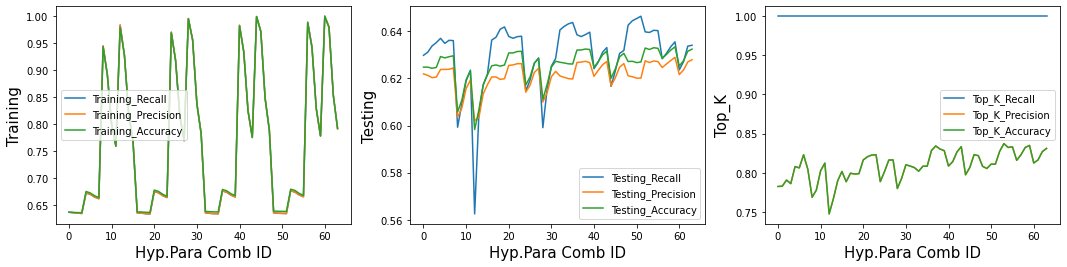

In [11]:
n_cols=3
n_rows=1
fig, axs=plt.subplots(n_rows,n_cols,figsize=(n_cols*6,n_rows*4))

ax = axs[0]
ax.plot(Output["Overall_Training_Recall"],label='Training_Recall')
ax.plot(Output["Overall_Training_Precision"],label='Training_Precision')
ax.plot(Output["Overall_Training_Accuracy"],label='Training_Accuracy')
ax.legend()
ax.set_xlabel("Hyp.Para Comb ID",fontsize=15);
ax.set_ylabel("Training",fontsize=15);

ax = axs[1]
ax.plot(Output["Overall_Testing_Recall"],label='Testing_Recall')
ax.plot(Output["Overall_Testing_Precision"],label='Testing_Precision')
ax.plot(Output["Overall_Testing_Accuracy"],label='Testing_Accuracy')
ax.legend()
ax.set_xlabel("Hyp.Para Comb ID",fontsize=15);
ax.set_ylabel("Testing",fontsize=15);

ax = axs[2]
ax.plot(Output["Top_K_Recall"],label='Top_K_Recall')
ax.plot(Output["Top_K_Precision"],label='Top_K_Precision')
ax.plot(Output["Top_K_Accuracy"],label='Top_K_Accuracy')
ax.legend()
ax.set_xlabel("Hyp.Para Comb ID",fontsize=15);
ax.set_ylabel("Top_K",fontsize=15);



In [12]:
for i in range (len(Output["Overall_Testing_Accuracy"])):
    print("=========================================",i,"==================================================")
    print("TeA=",Output["Overall_Testing_Accuracy"][i],"TeP=",Output["Overall_Testing_Precision"][i],
          "TeR=",Output["Overall_Testing_Recall"][i])
    print("KA=",Output["Top_K_Accuracy"][i],"KP=",Output["Top_K_Precision"][i],
          "KR=",Output["Top_K_Recall"][i])
    print(Output["Classifier"][i])
   

========================================= 0 ==================================================
TeA= 0.6248272807840768 TeP= 0.62196586953547 TeR= 0.629841569326435
KA= 0.7824590163934428 KP= 0.7824590163934428 KR= 1.0
RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=50,
                       n_estimators=75, n_jobs=50, random_state=43)
========================================= 1 ==================================================
TeA= 0.6248254507234934 TeP= 0.6213265046404358 TeR= 0.631160714369834
KA= 0.7827868852459017 KP= 0.7827868852459017 KR= 1.0
RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=50,
                       n_estimators=75, n_jobs=50, random_state=43)
========================================= 2 ==================================================
TeA= 0.6243378936158412 TeP= 0.6203730095142265 TeR= 0.6337981885901317
KA= 0.7906557377049183 KP= 0.7906557377049183 KR= 1.0
RandomForestClassifier(criterion='entropy', m